# Library

In [ ]:
import logging
import requests
from bs4 import BeautifulSoup
from urllib.error import HTTPError

import http.client as httplib  # or http.client if you're on Python 3 # httplib
httplib._MAXHEADERS = 10000
# ChunkedEncodingError

import time
import datetime
from datetime import datetime, timedelta

import re

import json

import warnings
warnings.simplefilter(action='ignore')

import pandas as pd
import numpy as np
import sys

import random 
from random import sample

In [ ]:
# pathes
art_project_path = '/content/drive/MyDrive/Art/Art_Project'
art_project_path_backups = '/content/drive/MyDrive/Art/Art_Project/parsing_backups'
art_project_path_tests = '/content/drive/MyDrive/Art/Art_Project/parsing_tests'

url_add = 'https://www.artsy.net'

# files
cat_dict = '/artsy_genom_cat_dict.txt'
gen_dict = '/artsy_genom_gen_dict.txt'
artwork_dict = '/artsy_genom_artwork_dict.txt'
artist_dict = '/artsy_genom_artist_dict.txt'
temp_data = '/artsy_temp_data.csv'
temp_data_add_up = '/artsy_temp_data_add_up.csv'

# id length
cat_id_len = 2
gen_id_len = 5
artist_id_len = 5

# for addition and updating
recently_added_pref = '?sort=-published_at'
recently_updated_pref = '?sort=-partner_updated_at'

# Functions

## Openings and savings

In [ ]:
# 1. Save json dict
def save_dict(tree_dict, file, folder):
  if folder=='live':
    with open(art_project_path + file, 'w') as outfile:
      json.dump(tree_dict, outfile)
  elif folder=='backup':
    with open(art_project_path_backups + file, 'w') as outfile:
      json.dump(tree_dict, outfile)

# 2. Open json dict
def open_dict(file, folder):
  if folder=='live':
    with open(art_project_path + file, 'rb') as infile:
      tree_dict = json.load(infile)
  elif folder=='backup':
    with open(art_project_path_backups + file, 'rb') as infile:
      tree_dict = json.load(infile)
  return tree_dict

# 3. Open file.csv
def open_file_csv(file, folder): # folder: live, backup or test
  if folder=='live':
    df = pd.read_csv(art_project_path + file)
  elif folder=='backup':
    df = pd.read_csv(art_project_path_backups + file)
  elif folder=='test':
    df = pd.read_csv(art_project_path_tests + file)
  return df

# 4. Save df to csv file
def save_df_file(df, file, folder): # folder: live, backup or test
  if folder=='live':
    df.to_csv(art_project_path + file, index=False)
  elif folder=='backup':
    df.to_csv(art_project_path_backups + file, index=False)
  elif folder=='test':
    df.to_csv(art_project_path_tests + file, index=False)


## Parsing

### get_page

In [ ]:
# 5. get_page
logging.basicConfig(level=logging.DEBUG, format="%(message)s")

def get_page(url, session):
  #response = requests.get(url, headers={'User-Agent': 'Chrome/97.0.4692.71'})
  try:
    response = session.get(url, headers={'User-Agent': 'Chrome/97.0.4692.71'})
  except: # requests.exceptions.ChunkedEncodingError:
    print('Error: ' + str(url) + '-> resession')
    time.sleep(0.5)
    session = requests.Session()
    response = session.get(url, headers={'User-Agent': 'Chrome/97.0.4692.71'})

  try:
    response.raise_for_status()
    bs_page = BeautifulSoup(response.text, 'html.parser')
    return bs_page

  except requests.exceptions.HTTPError: # for correction
    pass
    print('HTTPError: ' + str(url))
    
  #bs_page = BeautifulSoup(response.text, 'html.parser')
  #return bs_page

### get next pages links list

In [ ]:
# 6. get next pages links list
def get_next_page_list(url, page):
  try:
    last_page_data = page.find('main').find_all('nav', class_='Box-sc-15se88d-0 Text-sc-18gcpao-0 ibHUpM gzwvJD')[0].find_all('a')[-2]
    last_page = last_page_data.get_text()
    page_link = last_page_data.get('href')[:-len(last_page)]
    next_page_link_list_new = [url + page_link + str(p) for p in range(2, int(last_page)+1)]
  except:
    next_page_link_list_new = []

  return next_page_link_list_new

# 6.1 get next pages links list
def get_next_page_list_add_up(url, page):
  try:
    last_page_data = page.find('main').find_all('nav', class_='Box-sc-15se88d-0 Text-sc-18gcpao-0 ibHUpM gzwvJD')[0].find_all('a')[-2]
    last_page = last_page_data.get_text()
    last_page_link = last_page_data.get('href')
    next_page_link_list_new = [url + last_page_link.split('&')[0][:-len(last_page)] + str(p) + '&' + last_page_link.split('&')[1] for p in range(2, int(last_page)+1)]
  except:
    next_page_link_list_new = []

  return next_page_link_list_new

In [ ]:
# https://www.artsy.net/gene/inlay
# https://www.artsy.net/gene/inlay?page=2
# https://www.artsy.net/gene/inlay?sort=-published_at
# https://www.artsy.net/gene/inlay?page=2&sort=-published_at

### get data from pages

In [ ]:
# 7. get data from pages
def get_page_data(page):
  code_block = page.find('main').find_all('div', class_='ArtworkGrid-sc-1jsqquq-0 djwrUe')
  try:
    object_block = code_block[0].find_all('div', relay='[object Object]')
  
    # for the beggining into a DataFrame
    artsy_id_list = [obj.get('data-id') for obj in object_block]
    imgage_list = [obj.find_all('a')[0].find('img').get('src') for obj in object_block]
    artist_list = [obj.find_all('a')[1].find_all('div')[0].get_text() for obj in object_block]
  
    gallery_list = []
    for obj in object_block:
      try:
        gallery_list.append(obj.find_all('a')[1].find('div', class_='Box-sc-15se88d-0 Text-sc-18gcpao-0 caIGcn hENCPo').get_text())
      except:
        gallery_list.append(np.nan)
  
    price_list = []
    for obj in object_block:
      try:
        price_list.append(obj.find_all('a')[1].find('div', class_='Box-sc-15se88d-0 Text-sc-18gcpao-0 eXbAnU jkuGdd').get_text())
      except:
        price_list.append(np.nan)
  
    # can be no year info !!!
    name_list = []
    year_list = []
    for obj in object_block:
      text = obj.find_all('a')[1].find('div', class_='Box-sc-15se88d-0 Text-sc-18gcpao-0 caIGcn kySEpG').get_text()
      name = obj.find_all('a')[1].find('div', class_='Box-sc-15se88d-0 Text-sc-18gcpao-0 caIGcn kySEpG').find('i').get_text()
      year = text.replace(name, '').replace(', ', '')
      if len(year)==0:
        year = np.nan
      name_list.append(name)
      year_list.append(year)

    df_data_new = pd.DataFrame({'artsy_id': artsy_id_list,
                                'name': name_list, 
                                'link': imgage_list, 
                                'year': year_list,
                                'artist': artist_list,
                                'gallery': gallery_list,
                                'price': price_list
                                })
  except:
    df_data_new = pd.DataFrame({'artsy_id': np.nan,
                                'name': np.nan, 
                                'link': np.nan, 
                                'year': np.nan,
                                'artist': np.nan,
                                'gallery': np.nan,
                                'price': np.nan
                                }, index=[0])
  
  return df_data_new

### get category data into df - aggregator

In [ ]:
# Function aggregator
# 8. Get the all category data into DataFrame
def get_df_data(df_input, genes_links_list, genes_ids_list, cat):
  start_time = time.time()
  print(datetime.now().time())
  df_output = df_input.copy()
  df_output = df_output[0:0]

  for link in genes_links_list:
    session = requests.Session()
    total_link = url_add + link
    print('Parsing of gene', genes_ids_list[genes_links_list.index(link)], total_link, 'has started')
    # 5. get_page
    gene_page = get_page(total_link, session)
    #           get_page(url, session) -> 
    # -> bs_page
    
    # 6. get next pages links list
    next_page_link_list = get_next_page_list(url_add, gene_page)
    #                     get_next_page_list(url, page) -> 
    # -> next_page_link_list_new
    print(len(next_page_link_list)+1, 'pages for parsing')

    # 7. get data from pages
    df_data = get_page_data(gene_page)
    #         get_page_data(page) -> 
    # -> df_data_new
    df_data['gene_id'] = genes_ids_list[genes_links_list.index(link)]
    df_data['category_id'] = cat
    df_data['parsing_date'] = datetime.now().date().strftime('%Y-%m-%d')
    df_data['updating_date'] = datetime.now().date().strftime('%Y-%m-%d')

    df_output = pd.concat([df_output, df_data])

    # Get data from next pages
    if len(next_page_link_list) > 0:
      for page_link in next_page_link_list:
        # 5. get_page
        gene_page = get_page(page_link, session)
        #           get_page(url, session) -> 
        # -> bs_page

        # 7. get data from pages
        df_data = get_page_data(gene_page)
        #         get_page_data(page) -> 
        # -> df_data_new
        df_data['gene_id'] = genes_ids_list[genes_links_list.index(link)]
        df_data['category_id'] = cat
        df_data['parsing_date'] = datetime.now().date().strftime('%Y-%m-%d')
        df_data['updating_date'] = datetime.now().date().strftime('%Y-%m-%d')

        df_output = pd.concat([df_output, df_data])
      
    print('Parsing of gene', genes_ids_list[genes_links_list.index(link)], total_link, 'has finished')
    print((time.time() - start_time), 'seconds have passed')
    print(datetime.now().time())
    print('')
    time.sleep(0.5)

  return df_output

In [ ]:
# Function aggregator
# 8.1 Get the first pages category data into DataFrame
def get_df_data_add_up(df_input, genes_links_list, genes_ids_list, genes_cat_list, g_c):
  start_time = time.time()
  print(datetime.now().time())
  df_output = df_input.copy()
  #df_output['pages_count'] = np.nan # only for the first time !!!!
  #df_output['second_page_link'] = np.nan # only for the first time !!!!
  df_output = df_output[0:0]

  session = requests.Session()
  l_c = 0
  for link in genes_links_list:
    #session = requests.Session()
    total_link = url_add + link
    print('Parsing of gene', genes_ids_list[genes_links_list.index(link)], total_link, 'has started')
    # 5. get_page
    gene_page = get_page(total_link, session)
    #           get_page(url, session) -> 
    # -> bs_page
    
    try:
      # 6.1 get next pages links list
      next_page_link_list = get_next_page_list_add_up(url_add, gene_page)
      #                     get_next_page_list_add_up(url, page) -> 
      # -> next_page_link_list_new
    except: 
      next_page_link_list = []
    
    print(len(next_page_link_list)+1, 'pages for parsing')

    try:
      # 7. get data from pages
      df_data = get_page_data(gene_page)
      #         get_page_data(page) -> 
      # -> df_data_new
    except:
      df_data = pd.DataFrame({'artsy_id': np.nan,
                              'name': np.nan, 
                              'link': np.nan, 
                              'year': np.nan,
                              'artist': np.nan,
                              'gallery': np.nan,
                              'price': np.nan
                              }, index=[0])
      
    df_data['gene_id'] = genes_ids_list[genes_links_list.index(link)]
    df_data['category_id'] = genes_cat_list[genes_links_list.index(link)] # cat !!!!!!!!!
    df_data['parsing_date'] = datetime.now().date().strftime('%Y-%m-%d')
    df_data['updating_date'] = datetime.now().date().strftime('%Y-%m-%d')
    df_data['pages_count'] = len(next_page_link_list)+1
    if len(next_page_link_list) > 0:
      df_data['second_page_link'] = next_page_link_list[0]
    else:
      df_data['second_page_link'] = np.nan

    df_output = pd.concat([df_output, df_data])
      
    print('Parsing of gene', genes_ids_list[genes_links_list.index(link)], total_link, 'has finished')
    print((time.time() - start_time), 'seconds have passed')
    print(datetime.now().time())
    print('')
    l_c += 1
    g_c += 1
    if l_c == 10:
      session = requests.Session()
      l_c = 0
    time.sleep(0.5)

  return df_output, g_c

### correct image link

In [ ]:
# 9. correct image link
def img_link_corr(img):
  parts = img.split('.jpg')[0].replace('?', '/').replace('%2F', '/').split('/')
  img_new = parts[0] + '//' + parts[5] + '/' + parts[6] + '/' + parts[7]  + '.jpg'
  return img_new

### filtering

In [ ]:
# 10. Filtering
def get_cat_id(cat):
  return cat

def gene_links_samples(gen_key):
  cat_id = get_cat_id(cat)
  return genes_dict[gen_key]['category_id'] == cat_id

# Gens dict

In [ ]:
url = 'https://www.artsy.net/categories'

In [ ]:
response = requests.get(url, headers={'User-Agent': 'Chrome/97.0.4692.71'})
genome_page = BeautifulSoup(response.text, 'html.parser')
genome_page.title.string

Starting new HTTPS connection (1): www.artsy.net:443
https://www.artsy.net:443 "GET /categories HTTP/1.1" 200 None


'Artsy — Discover, Buy, and Sell Fine Art'

## categories_dict

In [ ]:
# !!!!! For the first time !!!!!
confirmation = input('Confirm the categories_dict re/seting (y/n)')
if confirmation == 'y':
  categories_dict = {}
  print('categories_dict has been re/set {}'.format(datetime.now().strftime('%Y-%m-%d %H:%M')))
  print("dictionary's length is - {}".format(len(categories_dict)))
else:
  print('nothing has happened')

Confirm the categories_dict re/seting (y/n)y
categories_dict has been re/set 2022-03-30 06:01
dictionary's length is - 0


In [ ]:
# !!!!! All next times !!!!!
confirmation = input('Confirm the categories_dict opening (y/n)')
if confirmation == 'y':
  categories_dict = open_dict(cat_dict, 'live') # 2. Open json dict
  print('categories_dict has been opened {}'.format(datetime.now().strftime('%Y-%m-%d %H:%M')))
  print("dictionary's length is - {}".format(len(categories_dict)))
else:
  print('nothing has happened')

Confirm the categories_dict opening (y/n)y
categories_dict has been opened 2022-05-02 08:40
dictionary's length is - 16


In [ ]:
categories_dict['artistic_disciplines']

{'genes_id': ['01001', '01002', '01003', '01004', '01005', '01006', '01007'],
 'id': '01',
 'link': 'jump--artistic-disciplines',
 'name': 'Artistic Disciplines',
 'parsing_date': '2022-03-30',
 'updating_date': '2022-03-30'}

In [ ]:
categories_block = genome_page.find('div', class_='sticky-inner-wrapper').find_all('div', class_='Box-sc-15se88d-0 Flex-cw39ct-0 elJsUD')

#categories_dict = {'artistic_disciplines': {'id': '02', 'name': 'Artistic Disciplines', 'link': 'jump--artistic-disciplines'}}
id = len(categories_dict) + 1
for cat in categories_block:
  key = cat.find('a').get('href').replace('#jump--', '').replace('-', '_')
  if key not in categories_dict.keys():
    categories_dict.update({key: {'id': str(id) if len(str(id))>1 else '0'+str(id), 'name': cat.get_text(), 'link': cat.find('a').get('href').replace('#', ''), 'genes_id': [], 'parsing_date': datetime.now().date().strftime('%Y-%m-%d'), 'updating_date': datetime.now().date().strftime('%Y-%m-%d')}})
    id += 1
    print('New key has been added - {}'.format(key))
  else:
    if categories_dict[key]['link'] != cat.find('a').get('href').replace('#', '') or categories_dict[key]['name'] != cat.get_text():
      print('an Old name - {}\nor an Old link - {}'.format(categories_dict[key]['name'], categories_dict[key]['link']))
      categories_dict[key].update({'link': cat.find('a').get('href').replace('#', '')})
      categories_dict[key].update({'name': cat.get_text()})
      categories_dict[key].update({'updating_date': datetime.now().date().strftime('%Y-%m-%d')})
      print('has been updated with \na New name - {}\nor a New link - {}'.format(categories_dict[key]['name'], categories_dict[key]['link']))
      print('')

In [ ]:
len(categories_dict)

16

In [ ]:
categories_dict['artistic_disciplines']

{'genes_id': ['01001', '01002', '01003', '01004', '01005', '01006', '01007'],
 'id': '01',
 'link': 'jump--artistic-disciplines',
 'name': 'Artistic Disciplines',
 'parsing_date': '2022-03-30',
 'updating_date': '2022-03-30'}

In [ ]:
confirmation = input('Confirm the categories_dict saving (y/n)')
if confirmation == 'y':
  save_dict(categories_dict, cat_dict) # 1. Save json dict
  print('categories_dict has been saved {}'.format(datetime.now().strftime('%Y-%m-%d %H:%M')))
  print("dictionary's length is - {}".format(len(categories_dict)))
else:
  print('nothing has happened')

Confirm the categories_dict saving (y/n)y
categories_dict has been saved 2022-03-30 06:02
dictionary's length is - 16


## genes_dict

In [ ]:
# !!!!! For the first time !!!!!
confirmation = input('Confirm the genes_dict re/seting (y/n)')
if confirmation == 'y':
  genes_dict = {}
  print('genes_dict has been re/set {}'.format(datetime.now().strftime('%Y-%m-%d %H:%M')))
  print("dictionary's length is - {}".format(len(genes_dict)))
else:
  print('nothing has happened')

Confirm the genes_dict re/seting (y/n)y
genes_dict was re/set


In [ ]:
# !!!!! All next times !!!!!
confirmation = input('Confirm the genes_dict opening (y/n)')
if confirmation == 'y':
  genes_dict = open_dict(gen_dict, 'live') # 2. Open json dict
  print('genes_dict has been opened {}'.format(datetime.now().strftime('%Y-%m-%d %H:%M')))
  print("dictionary's length is - {}".format(len(genes_dict)))
else:
  print('nothing has happened')

Confirm the genes_dict opening (y/n)y
genes_dict has been opened 2022-05-02 08:40
dictionary's length is - 1033


In [ ]:
# !!!!! All next times !!!!!
# Determining the count of genes in the category for creating an id (using () instead of [] is also possible)
count_list = [sum([1 for v in genes_dict.values() if v['category_id']==value['id']]) for value in categories_dict.values()]
id_len = len(str(max(count_list)))
print(id_len)
print(count_list)

3
[7, 213, 252, 26, 75, 176, 20, 68, 39, 22, 69, 27, 6, 7, 19, 7]


In [ ]:
genes_dict['bad_painting']

{'artist_id': ['25055', '21189'],
 'artsy_id': ['553be2df7261692b035d0400',
  '553a8ea872616909c03a0000',
  '54f0c97a7261693fa3ea1400',
  '54f0c97c726169731f9f1400',
  '553a8e737261697635630000',
  '553a8e61726169623a4f0000'],
 'category_id': '03',
 'id': '03001',
 'link': '/gene/bad-painting',
 'name': '"Bad Painting"',
 'parsing_date': '2022-03-29',
 'updating_date': '2022-03-29'}

In [ ]:
#genes_dict = {'architecture_1': {'id': '0201', 'name': 'Architecture', 'link': '/gene/architecture-1', 'category_id': '02'}}
# !!! working link is 'https://www.artsy.net' + link !!!
for value in categories_dict.values():
  category = genome_page.find('div', id=value['link']).find('h2').text
  if category == value['name']:
    count = sum([1 for v in genes_dict.values() if v['category_id'] == value['id']])
    id = count+1
    gens_block = genome_page.find('div', id=value['link']).find_all('a')
    for a in gens_block:
      gen_key = a.get('href').replace('/gene/', '').replace('-', '_')
      if gen_key not in genes_dict.keys():
        genes_dict.update({gen_key: {'id': value['id']+('0'*(id_len-len(str(id)))+str(id)), 'name': a.get_text(), 'link': a.get('href'), 'category_id': value['id'], 'artsy_id': [], 'artist_id': [], 'parsing_date': datetime.now().date().strftime('%Y-%m-%d'), 'updating_date': datetime.now().date().strftime('%Y-%m-%d')}})
        id += 1
        print('New key has been added - {}'.format(gen_key)) # !!! Not for the first time
      else:
        if genes_dict[gen_key]['link'] != a.get('href') or genes_dict[gen_key]['name'] != a.get_text():
          print('an Old name - {}\nor an Old link - {}'.format(genes_dict[gen_key]['name'], genes_dict[gen_key]['link']))
          genes_dict[gen_key].update({'link': a.get('href')})
          genes_dict[gen_key].update({'name': a.get_text()})
          genes_dict[gen_key].update({'updating_date': datetime.now().date().strftime('%Y-%m-%d')})
          print('has been updated with \na New name - {}\nor a New link - {}'.format(genes_dict[gen_key]['name'], genes_dict[gen_key]['link']))
          print('')
  else:
    print("Category name doesn't match")

In [ ]:
len(genes_dict)

1033

In [ ]:
genes_dict['bad_painting']

{'artist_id': ['25055', '21189'],
 'artsy_id': ['553be2df7261692b035d0400',
  '553a8ea872616909c03a0000',
  '54f0c97a7261693fa3ea1400',
  '54f0c97c726169731f9f1400',
  '553a8e737261697635630000',
  '553a8e61726169623a4f0000'],
 'category_id': '03',
 'id': '03001',
 'link': '/gene/bad-painting',
 'name': '"Bad Painting"',
 'parsing_date': '2022-03-29',
 'updating_date': '2022-03-29'}

In [ ]:
filtered_dict = {k: v for k, v in categories_dict.items() if v['id'] == genes_dict['nft']['category_id']}
print('New gene in category:', list(filtered_dict.keys())[0])
print('')
genes_dict['nft']

New gene in category: medium_and_techniques



{'artist_id': [],
 'artsy_id': [],
 'category_id': '06',
 'id': '06176',
 'link': '/gene/nft',
 'name': 'NFT',
 'parsing_date': '2022-04-20',
 'updating_date': '2022-04-20'}

In [ ]:
print(url_add + genes_dict['nft']['link'])

https://www.artsy.net/gene/nft


In [ ]:
confirmation = input('Confirm the genes_dict saving (y/n)')
if confirmation == 'y':
  save_dict(genes_dict, gen_dict, 'live') # 1. Save json dict
  print('genes_dict was saved {}'.format(datetime.now().strftime('%Y-%m-%d %H:%M')))
  print("dictionary's length is - {}".format(len(genes_dict)))
else:
  print('nothing has happened')

Confirm the genes_dict saving (y/n)y
genes_dict was saved 2022-04-20 07:24
dictionary's length is - 1033


### addition/updating lists of genes' id into the categories_dict

In [ ]:
# Dict of genes' id for the categories_dict
#cat_gen_id_dict = {}
#for value in categories_dict.values():
#  gen_id_list = [v['id'] for v in genes_dict.values() if v['category_id'] == value['id']]
#  cat_gen_id_dict.update({value['id']: gen_id_list})

#len(cat_gen_id_dict)

16

In [ ]:
#cat_gen_id_dict['01']

['01001', '01002', '01003', '01004', '01005', '01006', '01007']

In [ ]:
#for k, v in categories_dict.items():
#  for key, value in cat_gen_id_dict.items():
#    if v['id'] == key and categories_dict[k]['genes_id'] != value:
#      categories_dict[k].update({'genes_id': value})
#      categories_dict[k].update({'updating_date': datetime.now().date().strftime('%Y-%m-%d')})

#len(categories_dict)

16

In [ ]:
for key, value in categories_dict.items():
  gen_id_list = [v['id'] for v in genes_dict.values() if v['category_id'] == value['id']]
  if categories_dict[key]['genes_id'] != gen_id_list:
      categories_dict[key].update({'genes_id': gen_id_list})
      categories_dict[key].update({'updating_date': datetime.now().date().strftime('%Y-%m-%d')})
      print('Category', key, 'has been updated')

len(categories_dict)

Category {'id': '06', 'name': 'Medium and Techniques', 'link': 'jump--medium-and-techniques', 'genes_id': ['06001', '06002', '06003', '06004', '06005', '06006', '06007', '06008', '06009', '06010', '06011', '06012', '06013', '06014', '06015', '06016', '06017', '06018', '06019', '06020', '06021', '06022', '06023', '06024', '06025', '06026', '06027', '06028', '06029', '06030', '06031', '06032', '06033', '06034', '06035', '06036', '06037', '06038', '06039', '06040', '06041', '06042', '06043', '06044', '06045', '06046', '06047', '06048', '06049', '06050', '06051', '06052', '06053', '06054', '06055', '06056', '06057', '06058', '06059', '06060', '06061', '06062', '06063', '06064', '06065', '06066', '06067', '06068', '06069', '06070', '06071', '06072', '06073', '06074', '06075', '06076', '06077', '06078', '06079', '06080', '06081', '06082', '06083', '06084', '06085', '06086', '06087', '06088', '06089', '06090', '06091', '06092', '06093', '06094', '06095', '06096', '06097', '06098', '06099', '0

16

In [ ]:
categories_dict['artistic_disciplines']

{'genes_id': ['01001', '01002', '01003', '01004', '01005', '01006', '01007'],
 'id': '01',
 'link': 'jump--artistic-disciplines',
 'name': 'Artistic Disciplines',
 'parsing_date': '2022-03-30',
 'updating_date': '2022-03-30'}

In [ ]:
confirmation = input('Confirm the categories_dict saving (y/n)')
if confirmation == 'y':
  save_dict(categories_dict, cat_dict, 'live') # 1. Save json dict
  print('categories_dict has been saved {}'.format(datetime.now().strftime('%Y-%m-%d %H:%M')))
  print("dictionary's length is - {}".format(len(categories_dict)))
else:
  print('nothing has happened')

Confirm the categories_dict saving (y/n)y
categories_dict has been saved 2022-04-20 07:38
dictionary's length is - 16


# Artworks and Artists dicts

## Filtering

The fastest and simplest way to collect data is to go through the genes_dict and read data from a tape of objects like from a news feed. On a tape they have:
- artist's name - to the artists_dict !!!
- artwork name - to the artworks_dict
- artwork year - to the artworks_dict
- Galleries and Institutions name - to the galleries_dict !!!
- price - to the artworks_dict
- image link - to the artworks_dict

That's anough for me.

In parallel I'm going to collect artists_dict and galleries_dict.

Artwork can belong to different genes, but I don't need this repetition in the artworks_dict. So I can't create a composed id for it (like gene id). Artwork id should be end-to-end.

Seems like I should choose the most comprehensive category, collect its database, and then add to it only new information.

But how much artworks are in Artsy database? Via their API I collected around 26 000 once.

In [ ]:
categories_dict = open_dict(cat_dict, 'live') # 2. Open json dict
print("dictionary's length is - {}".format(len(categories_dict)))

dictionary's length is - 16


In [ ]:
def by_value(item):
  return len(item[1]['genes_id'])

for k, v in sorted(categories_dict.items(), key=by_value, reverse=True):
  print(k, '->', 'id', v['id'], '->', 'genes count' , len(v['genes_id']))

styles_and_movements -> id 03 -> genes count 252
subject_matter -> id 02 -> genes count 213
medium_and_techniques -> id 06 -> genes count 175
visual_qualities -> id 05 -> genes count 75
cultural_and_religious_styles -> id 11 -> genes count 69
geographic_regions -> id 08 -> genes count 68
materials -> id 09 -> genes count 39
furniture_and_lighting -> id 12 -> genes count 27
design_movements -> id 04 -> genes count 26
design_concepts_and_techniques -> id 10 -> genes count 22
time_periods -> id 07 -> genes count 20
tableware_vessels_and_objects -> id 15 -> genes count 19
artistic_disciplines -> id 01 -> genes count 7
jewelry_and_fashion_object_types -> id 14 -> genes count 7
antiquities_artifacts_and_religious_objects -> id 16 -> genes count 7
textiles -> id 13 -> genes count 6


03 styles_and_movements looks like the the most comprehensive category.
Next will be:
- subject_matter -> 02
- medium_and_techniques -> 06

In [ ]:
genes_dict = open_dict(gen_dict, 'live') # 2. Open json dict
print("dictionary's length is - {}".format(len(genes_dict)))

dictionary's length is - 1033


## Data collecting

### Parsing

#### First collection

In [ ]:
# for first collection !!!!!!!!!!
cat = '09'
filtered_dict = {k: v for k, v in genes_dict.items() if v['category_id'] == cat}
genes_links_list = [v['link'] for v in filtered_dict.values()]
genes_ids_list = [v['id'] for v in filtered_dict.values()]
print(len(genes_links_list))
print(len(genes_ids_list))

39
39


In [ ]:
# NEW GENE !!!
cat = '06'
genes_links_list = [genes_dict['nft']['link']]
genes_ids_list = [genes_dict['nft']['id']]
print(len(genes_links_list))
print(len(genes_ids_list))

1
1


In [ ]:
len(genes_ids_list_er)

2

In [ ]:
# too many genes -> let's collect by 50 at a time
backup_names = []

In [ ]:
df_temp_data_old = open_file_csv(temp_data, 'live') # 3. Open file.csv
try:
  # 8. Get the all category data into DataFrame    !!!!! [:] or _er         !!!!! [:] or _er 
  df_temp_data_new = get_df_data(df_temp_data_old, genes_links_list, genes_ids_list, cat)
  #                  get_df_data(df_input, genes_links_list, genes_ids_list, cat) ->
  # -> df_output
except SystemExit:
  pass

save_df_file(df_temp_data_new, temp_data, 'live') # 4. Save df to csv file

new_name_csv = temp_data.replace('.csv', '') + '_' + str(datetime.now()) + '.csv'
backup_names.append(new_name_csv)
save_df_file(df_temp_data_new, new_name_csv, 'backup') # 4. Save df to csv file

Starting new HTTPS connection (1): www.artsy.net:443


08:37:53.808458
Parsing of gene 06176 https://www.artsy.net/gene/nft has started


https://www.artsy.net:443 "GET /gene/nft HTTP/1.1" 200 None


9 pages for parsing


https://www.artsy.net:443 "GET /gene/nft?page=2 HTTP/1.1" 200 None
https://www.artsy.net:443 "GET /gene/nft?page=3 HTTP/1.1" 200 None
https://www.artsy.net:443 "GET /gene/nft?page=4 HTTP/1.1" 200 None
https://www.artsy.net:443 "GET /gene/nft?page=5 HTTP/1.1" 200 None
https://www.artsy.net:443 "GET /gene/nft?page=6 HTTP/1.1" 200 None
https://www.artsy.net:443 "GET /gene/nft?page=7 HTTP/1.1" 200 None
https://www.artsy.net:443 "GET /gene/nft?page=8 HTTP/1.1" 200 None
https://www.artsy.net:443 "GET /gene/nft?page=9 HTTP/1.1" 200 None


Parsing of gene 06176 https://www.artsy.net/gene/nft has finished
16.782116651535034 seconds have passed
08:38:10.590718



Saving blocks of 50 genes' data in separate files in beckup folder. Then we'll join them together and check if some pages have been missed during the parsing.

In [ ]:
backup_names

['/artsy_temp_data_2022-04-20 08:38:11.107399.csv']

In [ ]:
#backup_names_cat_06 = ['/artsy_temp_data_2022-04-06 07:01:26.758130.csv',
#                       '/artsy_temp_data_2022-04-06 07:19:01.562291.csv',
#                       '/artsy_temp_data_2022-04-06 08:35:48.400500.csv',
#                       '/artsy_temp_data_2022-04-06 10:31:00.254918.csv',
#                       '/artsy_temp_data_2022-04-06 11:58:44.750998.csv',
#                       '/artsy_temp_data_2022-04-06 12:41:26.025146.csv',
#                       '/artsy_temp_data_2022-04-06 13:34:44.996171.csv']
#                       + '/artsy_temp_data_2022-04-06 14:58:06.086053.csv'
#
#backup_names_cat_05 = ['/artsy_temp_data_2022-04-06 16:39:34.236815.csv',
#                       '/artsy_temp_data_2022-04-06 17:49:37.250209.csv']
#                       + 
#                      ['/artsy_temp_data_2022-04-15 07:46:32.183547.csv',
#                       '/artsy_temp_data_2022-04-15 07:56:14.144004.csv']
#
#backup_names_cat_11 = ['/artsy_temp_data_2022-04-08 06:51:14.997844.csv',
#                       '/artsy_temp_data_2022-04-08 07:08:01.411081.csv']
#                       +
#                       '/artsy_temp_data_2022-04-18 09:50:37.600100.csv'
#
#backup_names_cat_08 = ['/artsy_temp_data_2022-04-08 08:57:02.093364.csv',
#                       '/artsy_temp_data_2022-04-08 10:40:21.922750.csv']
#                       +
#                       '/artsy_temp_data_2022-04-18 12:02:55.479950.csv',
#                       '/artsy_temp_data_2022-04-18 12:43:06.028716.csv'
#                       +
#                       '/artsy_temp_data_2022-04-18 14:06:13.761778.csv'
#
#backup_names_cat_09 = ['/artsy_temp_data_2022-04-08 12:02:03.429937.csv',
#                       '/artsy_temp_data_2022-04-08 12:20:19.139091.csv',
#                       '/artsy_temp_data_2022-04-08 12:50:03.398655.csv',
#                       '/artsy_temp_data_2022-04-08 13:09:14.315180.csv']
#                       +
#                       '/artsy_temp_data_2022-04-18 15:58:00.276252.csv',
#                       +
#                       '/artsy_temp_data_2022-04-18 16:07:15.086943.csv'
#
#backup_names_cat_12 = ['/artsy_temp_data_2022-04-19 09:23:10.775068.csv',
#                       '/artsy_temp_data_2022-04-19 09:44:44.394285.csv']
#                       +
#                       '/artsy_temp_data_2022-04-19 10:51:43.926261.csv'
#
#backup_names_cat_04 = ['/artsy_temp_data_2022-04-08 15:20:14.101746.csv']
#                       +
#                       '/artsy_temp_data_2022-04-19 04:08:43.691739.csv'
#
#backup_names_cat_10 = ['/artsy_temp_data_2022-04-19 07:35:01.334592.csv',
#                       '/artsy_temp_data_2022-04-19 07:48:03.359223.csv']
#                       +
#                       '/artsy_temp_data_2022-04-19 08:11:46.261977.csv'
#
#backup_names_cat_07 = ['/artsy_temp_data_2022-04-09 04:15:24.907317.csv',
#                       '/artsy_temp_data_2022-04-09 05:05:55.273163.csv']
#                       +
#                       '/artsy_temp_data_2022-04-19 04:48:56.712756.csv'
#
#backup_names_cat_15 = ['/artsy_temp_data_2022-04-09 05:29:21.939929.csv']
#                       +
#                       '/artsy_temp_data_2022-04-19 05:22:25.192914.csv'
#
#backup_names_cat_01 = ['/artsy_temp_data_2022-04-09 05:43:38.333522.csv']
#
#backup_names_cat_14 = ['/artsy_temp_data_2022-04-09 06:01:02.568000.csv']
#
#backup_names_cat_16 = ['/artsy_temp_data_2022-04-09 06:22:33.619264.csv']
#
#backup_names_cat_13 = ['/artsy_temp_data_2022-04-09 06:44:32.738152.csv']
#                       +
#                       '/artsy_temp_data_2022-04-19 07:06:37.297601.csv'

##### Primary parsing checking

Checking the completeness of the data

In [ ]:
# cat 06 NEW GENE
#backup_names = ['/artsy_temp_data_2022-04-09 06:44:32.738152.csv']
backup_names

['/artsy_temp_data_2022-04-20 08:38:11.107399.csv']

In [ ]:
df_cat_dat = open_file_csv(backup_names[0], 'backup') # 3. Open file.csv
for name in backup_names[1:]:
  df_cat_dat_part = open_file_csv(name, 'backup') # 3. Open file.csv
  df_cat_dat = pd.concat([df_cat_dat, df_cat_dat_part])

In [ ]:
# or
df_cat_dat = open_file_csv(backup_names[0], 'backup') # 3. Open file.csv

In [ ]:
df_cat_dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   artsy_id       263 non-null    object
 1   name           263 non-null    object
 2   link           263 non-null    object
 3   year           257 non-null    object
 4   artist         263 non-null    object
 5   gallery        263 non-null    object
 6   price          263 non-null    object
 7   gene_id        263 non-null    int64 
 8   category_id    263 non-null    int64 
 9   parsing_date   263 non-null    object
 10  updating_date  263 non-null    object
dtypes: int64(2), object(9)
memory usage: 22.7+ KB


In [ ]:
df_cat_dat['category_id'].unique()

array([6])

In [ ]:
# !!!!!!!!!!!!!!!!

In [ ]:
df_cat_dat_nan = df_cat_dat.loc[df_cat_dat['category_id'].isna()==True]
df_cat_dat_nan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 2611 to 4705
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   artsy_id       2 non-null      object 
 1   name           2 non-null      object 
 2   link           0 non-null      object 
 3   year           0 non-null      object 
 4   artist         0 non-null      object 
 5   gallery        0 non-null      object 
 6   price          0 non-null      object 
 7   gene_id        0 non-null      float64
 8   category_id    0 non-null      object 
 9   parsing_date   0 non-null      object 
 10  updating_date  0 non-null      object 
dtypes: float64(1), object(10)
memory usage: 192.0+ bytes


In [ ]:
df_cat_dat_nan

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date
2611,61698fb5299f47000de9a839,‘Ero’ chairs by Starck for Kartell,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4705,61698fb5299f47000de9a839,‘Ero’ chairs by Starck for Kartell,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
artsy_id_list = df_cat_dat_nan['artsy_id'].tolist()
name_list = df_cat_dat_nan['name'].tolist()

In [ ]:
df_cat_dat_date = df_cat_dat.loc[df_cat_dat['category_id']=='2022-04-19']
df_cat_dat_date.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 2612 to 4706
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   artsy_id       2 non-null      object 
 1   name           2 non-null      object 
 2   link           2 non-null      object 
 3   year           2 non-null      object 
 4   artist         2 non-null      object 
 5   gallery        2 non-null      object 
 6   price          2 non-null      object 
 7   gene_id        2 non-null      float64
 8   category_id    2 non-null      object 
 9   parsing_date   2 non-null      object 
 10  updating_date  0 non-null      object 
dtypes: float64(1), object(10)
memory usage: 192.0+ bytes


In [ ]:
df_cat_dat_date

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date
2612,(Italy),https://d7hftxdivxxvm.cloudfront.net?resize_to...,Circa 2000,Philippe Starck‘Ero’ chairs by Starck for Kart...,Eclectica Contemporary,Price on request,12005,12.0,2022-04-19,2022-04-19,NaN
4706,(Italy),https://d7hftxdivxxvm.cloudfront.net?resize_to...,Circa 2000,Philippe Starck‘Ero’ chairs by Starck for Kart...,Eclectica Contemporary,Price on request,12017,12.0,2022-04-19,2022-04-19,NaN


In [ ]:
imgage_list = df_cat_dat_date['name'].tolist()
year_list = df_cat_dat_date['link'].tolist()
artist_list = df_cat_dat_date['year'].tolist()
gallery_list = df_cat_dat_date['artist'].tolist()
price_list = df_cat_dat_date['gallery'].tolist()
gene_list = df_cat_dat_date['price'].tolist()
cat_list = df_cat_dat_date['gene_id'].tolist()
parsing_list = df_cat_dat_date['parsing_date'].tolist()

In [ ]:
df_data_new = pd.DataFrame({'artsy_id': artsy_id_list,
                            'name': name_list, 
                            'link': imgage_list, 
                            'year': year_list,
                            'artist': artist_list,
                            'gallery': gallery_list,
                            'price': price_list,
                            'gene_id': gene_list,
                            'category_id': cat_list,
                            'parsing_date': parsing_list,
                            'updating_date': parsing_list,
                            })
df_data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   artsy_id       2 non-null      object 
 1   name           2 non-null      object 
 2   link           2 non-null      object 
 3   year           2 non-null      object 
 4   artist         2 non-null      object 
 5   gallery        2 non-null      object 
 6   price          2 non-null      object 
 7   gene_id        2 non-null      object 
 8   category_id    2 non-null      float64
 9   parsing_date   2 non-null      object 
 10  updating_date  2 non-null      object 
dtypes: float64(1), object(10)
memory usage: 304.0+ bytes


In [ ]:
df_data_new['category_id'].unique()

array([12.])

In [ ]:
df_cat_dat_12 = df_cat_dat.loc[df_cat_dat['category_id']=='12']
df_cat_dat_12.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23348 entries, 0 to 13960
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   artsy_id       23345 non-null  object 
 1   name           23345 non-null  object 
 2   link           23345 non-null  object 
 3   year           22845 non-null  object 
 4   artist         23345 non-null  object 
 5   gallery        23091 non-null  object 
 6   price          23345 non-null  object 
 7   gene_id        23348 non-null  float64
 8   category_id    23348 non-null  object 
 9   parsing_date   23348 non-null  object 
 10  updating_date  23348 non-null  object 
dtypes: float64(1), object(10)
memory usage: 2.1+ MB


In [ ]:
df_cat_dat_12['category_id'].unique()

array(['12'], dtype=object)

In [ ]:
df_cat_dat = df_cat_dat_12.copy()
df_cat_dat = pd.concat([df_cat_dat, df_data_new])
df_cat_dat = df_cat_dat.reset_index().drop(['index'], axis=1)
df_cat_dat['category_id'] = 12

df_cat_dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23350 entries, 0 to 23349
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   artsy_id       23347 non-null  object
 1   name           23347 non-null  object
 2   link           23347 non-null  object
 3   year           22847 non-null  object
 4   artist         23347 non-null  object
 5   gallery        23093 non-null  object
 6   price          23347 non-null  object
 7   gene_id        23350 non-null  object
 8   category_id    23350 non-null  int64 
 9   parsing_date   23350 non-null  object
 10  updating_date  23350 non-null  object
dtypes: int64(1), object(10)
memory usage: 2.0+ MB


In [ ]:
df_cat_dat['category_id'].unique()

array([12])

In [ ]:
# !!!!!!!!

In [ ]:
df_cat_dat['category_id'] = df_cat_dat['category_id'].dropna().apply(lambda x: str(x) if len(str(x))==cat_id_len else ('0'*(cat_id_len-len(str(x)))+str(x)))
df_cat_dat['gene_id'] = df_cat_dat['gene_id'].dropna().apply(lambda x: str(x) if len(str(x))==gen_id_len else ('0'*(gen_id_len-len(str(x)))+str(x)))

#df_cat_dat['category_id'] = df_cat_dat['category_id'].dropna().apply(lambda x: str(int(float(x))) if len(str(int(float(x))))==cat_id_len else ('0'*(cat_id_len-len(str(int(float(x)))))+str(int(float(x)))))
#df_cat_dat['gene_id'] = df_cat_dat['gene_id'].dropna().apply(lambda x: str(int(float(x))) if len(str(int(float(x))))==gen_id_len else ('0'*(gen_id_len-len(str(int(float(x)))))+str(int(float(x)))))

In [ ]:
df_cat_dat.loc[df_cat_dat['artsy_id'].isna()==True]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date


In [ ]:
df_cat_dat.loc[df_cat_dat['gene_id']=='12011'].head()

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date
5611,624d61a5e25714000c32bde3,Spanish 18th Century Refectory Dining Table,https://d7hftxdivxxvm.cloudfront.net?resize_to...,1700-1750,Unknown ArtistSpanish 18th Century Refectory D...,AVANTIQUES,"US$4,500",12011,12,2022-04-19,2022-04-19
5612,5eb1d70b3e52a6000df08763,"""Cloud"" CenterTable",https://d7hftxdivxxvm.cloudfront.net?resize_to...,2020,"Jacques Jarrige""Cloud"" CenterTable, 2020Valeri...",Valerie Goodman Gallery,"US$27,000",12011,12,2022-04-19,2022-04-19
5613,59da74309c18db249fcdbccd,"Lacquered desk table ""Luca""",https://d7hftxdivxxvm.cloudfront.net?resize_to...,2017,"Jacques JarrigeLacquered desk table ""Luca"", 20...",Valerie Goodman Gallery,"US$23,750",12011,12,2022-04-19,2022-04-19
5614,5bae2d5b1f74731ca8eac04a,Oval dining table with leaves,https://d7hftxdivxxvm.cloudfront.net?resize_to...,1952,"Hans J. WegnerOval dining table with leaves, 1...",Dansk Møbelkunst Gallery,Price on request,12011,12,2022-04-19,2022-04-19
5615,620258c734e7fc000b5e722f,Lovö dining table,https://d7hftxdivxxvm.cloudfront.net?resize_to...,1930,"Axel Einar HjorthLovö dining table, 1930Gokela...",Gokelaere & Robinson,"€14,000",12011,12,2022-04-19,2022-04-19


Getting list of genes with missing pages parsing and lounch parsing of these genes (not pages !!!) again.

In [ ]:
genes_ids_list_er = [str(g_id) for g_id in df_cat_dat.loc[df_cat_dat['artsy_id'].isna()==True]['gene_id']]
genes_ids_list_er = list(set(genes_ids_list_er))
genes_ids_list_er

['12014', '12011']

In [ ]:
genes_links_list_er = [genes_links_list[genes_ids_list.index(g_id)] for g_id in genes_ids_list_er]
genes_links_list_er

['/gene/lighting', '/gene/dining-table']

In [ ]:
df_cat_dat = df_cat_dat.dropna(subset=['artsy_id'], axis=0)

It would be better for faster errors' parsing if I got the page number info...

!!! One item can belong not only to different categoryes but also to different genes into one category. That's very important for joining with reparsed data !!!

In [ ]:
print(df_cat_dat['artsy_id'].count())
print(df_cat_dat['artsy_id'].nunique())

110253
73696


In [ ]:
print(df_cat_dat.groupby(['gene_id', 'artsy_id'])['artsy_id'].count().max())
print(df_cat_dat.groupby(['gene_id', 'artsy_id'])['artsy_id'].nunique().max())

2
1


In [ ]:
gene_artsy_groupped = df_cat_dat.groupby(['gene_id', 'artsy_id'])['artsy_id'].agg(['count']).reset_index()
gene_artsy_groupped.loc[gene_artsy_groupped['count']>1]

,gene_id,artsy_id,count
4309,06007,540f40cd7261692d6d550000,2
18541,06021,5ae9db4a9c18db166e639c7e,2
20019,06021,606d59a4b58b09000e0f0fed,2
20209,06021,60e05ea715fca20013f5854a,2
20657,06021,61c0ee1e845711000bf8163c,2
...,...,...,...
247062,06174,5f172c2dea92a20011267465,2
250018,06175,618bea8b5180b7000e0faba9,2
250139,06175,61ba11e097ec3a000b017724,2
251094,06175,623b41fed562fe000c49e3ba,2


In [ ]:
df_cat_dat.loc[df_cat_dat['artsy_id']=='6248b64fa3259b000c24e910']

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date
39366,6248b64fa3259b000c24e910,Time Is Movin’,https://d7hftxdivxxvm.cloudfront.net?resize_to...,2021,"Mitsuyo OkadaTime Is Movin’, 2021Space 776US$290",Space 776,US$290,06175,06,2022-04-06,2022-04-06
39369,6248b64fa3259b000c24e910,Time Is Movin’,https://d7hftxdivxxvm.cloudfront.net?resize_to...,2021,"Mitsuyo OkadaTime Is Movin’, 2021Space 776US$290",Space 776,US$290,06175,06,2022-04-06,2022-04-06


In [ ]:
for link in df_cat_dat.loc[df_cat_dat['artsy_id']=='4d8b93484eb68a1b2c00125b']['link']:
  print(link)

https://d7hftxdivxxvm.cloudfront.net?resize_to=fit&src=https%3A%2F%2Fd32dm0rphc51dk.cloudfront.net%2F8NpaJhOeMqPmSGH2IdLcWw%2Flarge.jpg&width=445&height=353&quality=80
https://d7hftxdivxxvm.cloudfront.net?resize_to=fit&src=https%3A%2F%2Fd32dm0rphc51dk.cloudfront.net%2F8NpaJhOeMqPmSGH2IdLcWw%2Flarge.jpg&width=445&height=353&quality=80
https://d7hftxdivxxvm.cloudfront.net?resize_to=fit&src=https%3A%2F%2Fd32dm0rphc51dk.cloudfront.net%2F8NpaJhOeMqPmSGH2IdLcWw%2Flarge.jpg&width=445&height=353&quality=80
https://d7hftxdivxxvm.cloudfront.net?resize_to=fit&src=https%3A%2F%2Fd32dm0rphc51dk.cloudfront.net%2F8NpaJhOeMqPmSGH2IdLcWw%2Flarge.jpg&width=445&height=353&quality=80
https://d7hftxdivxxvm.cloudfront.net?resize_to=fit&src=https%3A%2F%2Fd32dm0rphc51dk.cloudfront.net%2F8NpaJhOeMqPmSGH2IdLcWw%2Flarge.jpg&width=445&height=353&quality=80
https://d7hftxdivxxvm.cloudfront.net?resize_to=fit&src=https%3A%2F%2Fd32dm0rphc51dk.cloudfront.net%2F8NpaJhOeMqPmSGH2IdLcWw%2Flarge.jpg&width=445&height=353&qua

There can be item duplicates inside one gene items' list also. Delete them.

##### Errors' parsing checking

Checking the completeness of a new data after collecting error genes

In [ ]:
# !!!!!!!!!!!!!!!!!

In [ ]:
# cat 09
backup_names = ['/artsy_temp_data_2022-04-18 15:58:00.276252.csv',
                '/artsy_temp_data_2022-04-18 16:07:15.086943.csv']

In [ ]:
df_temp_data_new = open_file_csv(backup_names[0], 'backup') # 3. Open file.csv
for name in backup_names[1:]:
  df_temp_data_new_part = open_file_csv(name, 'backup') # 3. Open file.csv
  df_temp_data_new = pd.concat([df_temp_data_new, df_temp_data_new_part])

#df_temp_data_new = df_temp_data_new.dropna(subset=['artsy_id'], axis=0) # !!!
df_temp_data_new.drop_duplicates(subset = ['gene_id', 'artsy_id'], keep = 'first', inplace = True)
df_temp_data_new = df_temp_data_new.reset_index().drop(['index'], axis=1) # !!!


In [ ]:
df_temp_data_new['category_id'] = df_temp_data_new['category_id'].dropna().apply(lambda x: str(x) if len(str(x))==cat_id_len else ('0'*(cat_id_len-len(str(x)))+str(x)))
df_temp_data_new['gene_id'] = df_temp_data_new['gene_id'].dropna().apply(lambda x: str(x) if len(str(x))==gen_id_len else ('0'*(gen_id_len-len(str(x)))+str(x)))

In [ ]:
# !!!!!!!!!!!!!

In [ ]:
df_temp_data_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2373 entries, 0 to 7
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   artsy_id       2373 non-null   object
 1   name           2373 non-null   object
 2   link           2373 non-null   object
 3   year           2315 non-null   object
 4   artist         2373 non-null   object
 5   gallery        2357 non-null   object
 6   price          2373 non-null   object
 7   gene_id        2373 non-null   object
 8   category_id    2373 non-null   object
 9   parsing_date   2373 non-null   object
 10  updating_date  2373 non-null   object
dtypes: object(11)
memory usage: 222.5+ KB


Everything is correct in case of empty df. -> Mergening

In [ ]:
df_temp_data_new.loc[df_temp_data_new['artsy_id'].isna()==True]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date


In [ ]:
df_temp_data_new.loc[df_temp_data_new['gene_id']=='04016'].head()

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date
0,6234540a64caba000b7d3d9e,Osvaldo Borsani & Eugenio Gerli for Tecno Oval...,https://d7hftxdivxxvm.cloudfront.net?resize_to...,1968,"Osvaldo Borsani, Eugenio GerliOsvaldo Borsani ...",MORENTZ,"US$6,450",04016,04,2022-04-19,2022-04-19
1,623b0890478704000b678259,Desk,https://d7hftxdivxxvm.cloudfront.net?resize_to...,ca. 1960,"Marco ZanusoDesk , ca. 1960Gokelaere & Robinso...",Gokelaere & Robinson,"€25,000",04016,04,2022-04-19,2022-04-19
2,545a72c57261692cdfe90100,"""Nitor,"" Bronze Candlestick",https://d7hftxdivxxvm.cloudfront.net?resize_to...,2014,"Aldus""Nitor,"" Bronze Candlestick, 2014Maison G...",Maison Gerard,"US$6,200",04016,04,2022-04-19,2022-04-19
3,5592bc6e7261693ebf00003d,Try Tray,https://d7hftxdivxxvm.cloudfront.net?resize_to...,1995,"Gaetano PesceTry Tray, 1995The Modern ArchiveU...",The Modern Archive,US$595,04016,04,2022-04-19,2022-04-19
4,53eac6aa7261691149ef0000,Octopus Chandelier,https://d7hftxdivxxvm.cloudfront.net?resize_to...,2014,"Achille SalvagniOctopus Chandelier, 2014Maison...",Maison Gerard,"US$147,500",04016,04,2022-04-19,2022-04-19


In [ ]:
print(url_add + genes_links_list[15])
print(genes_ids_list[15])

https://www.artsy.net/gene/italian-furniture-and-design
04016


In [ ]:
genes_ids_list_er = [genes_ids_list[15]]
genes_links_list_er = [genes_links_list[15]]

In [ ]:
# or

In [ ]:
genes_ids_list_er = [g_id for g_id in df_temp_data_new.loc[df_temp_data_new['artsy_id'].isna()==True]['gene_id']]
genes_ids_list_er = list(set(genes_ids_list_er))
genes_ids_list_er

['09039', '09031']

In [ ]:
genes_links_list_er = [genes_links_list[genes_ids_list.index(g_id)] for g_id in genes_ids_list_er]
genes_links_list_er

['/gene/wood', '/gene/stone']

In [ ]:
df_temp_data_new = df_temp_data_new.dropna(subset=['artsy_id'], axis=0)

In [ ]:
save_df_file(df_temp_data_new, new_name_csv, 'backup') # 4. Save df to csv file

##### Merging of all the data

In [ ]:
# cat 10
df_cat_dat_total = pd.concat([df_cat_dat, df_temp_data_new])
df_cat_dat_total.drop_duplicates(subset = ['gene_id', 'artsy_id'], keep = 'first', inplace = True)
df_cat_dat_total = df_cat_dat_total.reset_index().drop(['index'], axis=1) # !!!

In [ ]:
# OR
df_cat_dat_total = df_cat_dat.copy()

In [ ]:
df_cat_dat_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29336 entries, 0 to 29335
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artsy_id          29336 non-null  object 
 1   name              29336 non-null  object 
 2   link              29336 non-null  object 
 3   year              28085 non-null  object 
 4   artist            29336 non-null  object 
 5   gallery           29330 non-null  object 
 6   price             29336 non-null  object 
 7   gene_id           29336 non-null  int64  
 8   category_id       29336 non-null  int64  
 9   parsing_date      29336 non-null  object 
 10  updating_date     29336 non-null  object 
 11  pages_count       29336 non-null  float64
 12  second_page_link  28197 non-null  object 
dtypes: float64(1), int64(2), object(10)
memory usage: 2.9+ MB


Genes checking: sometimes there may be a problem (like with cat 03)

In [ ]:
print(len(genes_ids_list))
df_cat_dat_total['gene_id'].dropna().nunique()

1


1

In [ ]:
save_df_file(df_cat_dat_total, '/artsy_temp_data_new_gene.csv', 'backup') # 4. Save df to csv file
#df_cat_dat_total = open_file_csv('/artsy_temp_data_09.csv', 'backup') # 3. Open file.csv

In [ ]:
# !!! cat 10 !!!
check_gene_id = df_cat_dat_total['gene_id'].dropna().unique().tolist()
len(check_gene_id)

27

In [ ]:
genes_ids_list_er = list(set(genes_ids_list) - set(check_gene_id))
genes_ids_list_er

['10021',
 '10008',
 '10001',
 '10013',
 '10006',
 '10017',
 '10020',
 '10004',
 '10009',
 '10003',
 '10014',
 '10015',
 '10012',
 '10016',
 '10005',
 '10010',
 '10011',
 '10018',
 '10002',
 '10007',
 '10022',
 '10019']

In [ ]:
genes_links_list_er = [genes_links_list[genes_ids_list.index(g_id)] for g_id in genes_ids_list_er]
for link in genes_links_list_er:
  print(url_add + link)

https://www.artsy.net/gene/whimsical-design
https://www.artsy.net/gene/handcrafted-furniture-and-design
https://www.artsy.net/gene/cad-computer-aided-design
https://www.artsy.net/gene/modular-design
https://www.artsy.net/gene/engineering-slash-construction-and-design
https://www.artsy.net/gene/restrained-forms
https://www.artsy.net/gene/timber-frame-construction
https://www.artsy.net/gene/design-by-artists
https://www.artsy.net/gene/iconic-works-of-design
https://www.artsy.net/gene/design-by-architects
https://www.artsy.net/gene/non-functional-design
https://www.artsy.net/gene/reinforced-concrete-construction
https://www.artsy.net/gene/masonry-construction
https://www.artsy.net/gene/religious-building
https://www.artsy.net/gene/emerging-design
https://www.artsy.net/gene/industrial-and-product-design
https://www.artsy.net/gene/jewelry-by-painters-and-sculptors
https://www.artsy.net/gene/steel-slash-iron-frame-construction
https://www.artsy.net/gene/childrens-furniture-and-design
https:/

Pages of these genes are empty, so everything's allright.

#### Addition and Updating

In [ ]:
# for addition or updating !!!!!!!!!!!

def get_lists(cat, prefix):

  filtered_dict = {k: v for k, v in genes_dict.items() if v['category_id'] == cat}
  genes_links_list = [v['link']+prefix for v in filtered_dict.values()]
  genes_ids_list = [v['id'] for v in filtered_dict.values()]
  genes_cat_list = [cat for gene in genes_ids_list]
  print("Lists' length:", len(genes_links_list), len(genes_ids_list), len(genes_cat_list))
  print('')

  return genes_links_list, genes_ids_list, genes_cat_list


def get_files_w_data(genes_links_list, genes_ids_list, genes_cat_list, g_c):
  
  df_temp_data_old = open_file_csv(temp_data_add_up, 'live') # 3. Open file.csv
  #  8.1 Get the first pages category data into DataFrame
  #try:                                   #                     !!!!!!!               !!!!!!      !!!!!!
  df_temp_data_new, gene_count = get_df_data_add_up(df_temp_data_old, genes_links_list, genes_ids_list, genes_cat_list, g_c)
    #                              get_df_data_add_up(df_input, genes_links_list, genes_ids_list, genes_cat_list, g_c) ->
    # -> df_output
  #except SystemExit:
  #  pass
  #  print('SystemExit !!!!!')

  save_df_file(df_temp_data_new, temp_data_add_up, 'live') # 4. Save df to csv file

  new_name_csv = temp_data_add_up.replace('.csv', '') + '_' + str(datetime.now()) + '.csv'
  #new_names.append(new_name_csv)
  save_df_file(df_temp_data_new, new_name_csv, 'backup') # 4. Save df to csv file
  print(gene_count, 'genes have been collected')
  print('')

  #if gene_count != len(genes_links_list):
  #  get_files_w_data(genes_links_list[gene_count-1:], genes_ids_list[gene_count-1:], genes_cat_list[gene_count-1:], gene_count)

  return new_name_csv

In [ ]:
prefix = recently_added_pref
#prefix = recently_updated_pref
backup_names = []

print("Dictionary's length is - {}".format(len(categories_dict)))
cat_id_list = [v['id'] for v in categories_dict.values()]
print("List's length is - {}".format(len(cat_id_list)))
print('')

for cat in cat_id_list:
  g_c = 0
  #new_names = []
  lists = get_lists(cat, prefix)
  new_name_csv = get_files_w_data(lists[0], lists[1], lists[2], g_c) # new_names
  #              get_files_w_data(genes_links_list, genes_ids_list, genes_cat_list) ->
  # -> backup_names
  backup_names.append(new_name_csv)

print(len(backup_names))
backup_names

Starting new HTTPS connection (1): www.artsy.net:443


Dictionary's length is - 16
List's length is - 16

Lists' length: 7 7 7

06:03:52.168534
Parsing of gene 01001 https://www.artsy.net/gene/architecture-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/architecture-1?sort=-published_at HTTP/1.1" 200 None


22 pages for parsing
Parsing of gene 01001 https://www.artsy.net/gene/architecture-1?sort=-published_at has finished
2.413074493408203 seconds have passed
06:03:54.582250

Parsing of gene 01002 https://www.artsy.net/gene/design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/design?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 01002 https://www.artsy.net/gene/design?sort=-published_at has finished
5.03136682510376 seconds have passed
06:03:57.199945

Parsing of gene 01003 https://www.artsy.net/gene/fashion-design-and-wearable-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/fashion-design-and-wearable-art?sort=-published_at HTTP/1.1" 200 None


92 pages for parsing
Parsing of gene 01003 https://www.artsy.net/gene/fashion-design-and-wearable-art?sort=-published_at has finished
8.295309782028198 seconds have passed
06:04:00.463898

Parsing of gene 01004 https://www.artsy.net/gene/graphic-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/graphic-design?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 01004 https://www.artsy.net/gene/graphic-design?sort=-published_at has finished
11.428304433822632 seconds have passed
06:04:03.596883

Parsing of gene 01005 https://www.artsy.net/gene/jewelry?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/jewelry?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 01005 https://www.artsy.net/gene/jewelry?sort=-published_at has finished
14.37569284439087 seconds have passed
06:04:06.544282

Parsing of gene 01006 https://www.artsy.net/gene/music?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/music?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 01006 https://www.artsy.net/gene/music?sort=-published_at has finished
17.050594806671143 seconds have passed
06:04:09.219177

Parsing of gene 01007 https://www.artsy.net/gene/written-word?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/written-word?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 01007 https://www.artsy.net/gene/written-word?sort=-published_at has finished
19.725517511367798 seconds have passed
06:04:11.894109



Starting new HTTPS connection (1): www.artsy.net:443


7 genes have been collected

Lists' length: 213 213 213

06:04:12.418145
Parsing of gene 02001 https://www.artsy.net/gene/abstract-landscape?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-landscape?sort=-published_at HTTP/1.1" 200 None


75 pages for parsing
Parsing of gene 02001 https://www.artsy.net/gene/abstract-landscape?sort=-published_at has finished
2.2254443168640137 seconds have passed
06:04:14.643633

Parsing of gene 02002 https://www.artsy.net/gene/adolescence-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/adolescence-1?sort=-published_at HTTP/1.1" 200 None


22 pages for parsing
Parsing of gene 02002 https://www.artsy.net/gene/adolescence-1?sort=-published_at has finished
4.622727394104004 seconds have passed
06:04:17.040917

Parsing of gene 02003 https://www.artsy.net/gene/advertising-and-brands?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/advertising-and-brands?sort=-published_at HTTP/1.1" 200 None


35 pages for parsing
Parsing of gene 02003 https://www.artsy.net/gene/advertising-and-brands?sort=-published_at has finished
7.232346534729004 seconds have passed
06:04:19.650538

Parsing of gene 02004 https://www.artsy.net/gene/african-diaspora?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/african-diaspora?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 02004 https://www.artsy.net/gene/african-diaspora?sort=-published_at has finished
10.428197860717773 seconds have passed
06:04:22.846383

Parsing of gene 02005 https://www.artsy.net/gene/allegory?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/allegory?sort=-published_at HTTP/1.1" 200 None


17 pages for parsing
Parsing of gene 02005 https://www.artsy.net/gene/allegory?sort=-published_at has finished
13.175600051879883 seconds have passed
06:04:25.593827

Parsing of gene 02006 https://www.artsy.net/gene/alter-egos-and-avatars?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/alter-egos-and-avatars?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 02006 https://www.artsy.net/gene/alter-egos-and-avatars?sort=-published_at has finished
15.700565338134766 seconds have passed
06:04:28.118757

Parsing of gene 02007 https://www.artsy.net/gene/americana?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/americana?sort=-published_at HTTP/1.1" 200 None


60 pages for parsing
Parsing of gene 02007 https://www.artsy.net/gene/americana?sort=-published_at has finished
19.00178813934326 seconds have passed
06:04:31.419981

Parsing of gene 02008 https://www.artsy.net/gene/anatomy?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/anatomy?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 02008 https://www.artsy.net/gene/anatomy?sort=-published_at has finished
21.81386160850525 seconds have passed
06:04:34.232259

Parsing of gene 02009 https://www.artsy.net/gene/animal-portrait?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animal-portrait?sort=-published_at HTTP/1.1" 200 None


26 pages for parsing
Parsing of gene 02009 https://www.artsy.net/gene/animal-portrait?sort=-published_at has finished
24.583335638046265 seconds have passed
06:04:37.001513

Parsing of gene 02010 https://www.artsy.net/gene/animals?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?sort=-published_at has finished
28.58181405067444 seconds have passed
06:04:41.000004



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02011 https://www.artsy.net/gene/anthropomorphism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/anthropomorphism?sort=-published_at HTTP/1.1" 200 None


25 pages for parsing
Parsing of gene 02011 https://www.artsy.net/gene/anthropomorphism?sort=-published_at has finished
30.844667196273804 seconds have passed
06:04:43.262870

Parsing of gene 02012 https://www.artsy.net/gene/antiquity-as-subject?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/antiquity-as-subject?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 02012 https://www.artsy.net/gene/antiquity-as-subject?sort=-published_at has finished
33.065072774887085 seconds have passed
06:04:45.483750

Parsing of gene 02013 https://www.artsy.net/gene/architectures-effects?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/architectures-effects?sort=-published_at HTTP/1.1" 200 None


42 pages for parsing
Parsing of gene 02013 https://www.artsy.net/gene/architectures-effects?sort=-published_at has finished
35.63922691345215 seconds have passed
06:04:48.057804

Parsing of gene 02014 https://www.artsy.net/gene/arrivals-slash-departures?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/arrivals-slash-departures?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 02014 https://www.artsy.net/gene/arrivals-slash-departures?sort=-published_at has finished
37.9407639503479 seconds have passed
06:04:50.359274

Parsing of gene 02015 https://www.artsy.net/gene/artist-as-ethnographer?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/artist-as-ethnographer?sort=-published_at HTTP/1.1" 200 None


37 pages for parsing
Parsing of gene 02015 https://www.artsy.net/gene/artist-as-ethnographer?sort=-published_at has finished
40.56081438064575 seconds have passed
06:04:52.979336

Parsing of gene 02016 https://www.artsy.net/gene/atmospheric-landscapes?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/atmospheric-landscapes?sort=-published_at HTTP/1.1" 200 None


51 pages for parsing
Parsing of gene 02016 https://www.artsy.net/gene/atmospheric-landscapes?sort=-published_at has finished
43.346391439437866 seconds have passed
06:04:55.764595

Parsing of gene 02017 https://www.artsy.net/gene/attenuated-figure?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/attenuated-figure?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 02017 https://www.artsy.net/gene/attenuated-figure?sort=-published_at has finished
45.811673641204834 seconds have passed
06:04:58.229863

Parsing of gene 02018 https://www.artsy.net/gene/bars-and-restaurants?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bars-and-restaurants?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 02018 https://www.artsy.net/gene/bars-and-restaurants?sort=-published_at has finished
48.54613542556763 seconds have passed
06:05:00.964339

Parsing of gene 02019 https://www.artsy.net/gene/bathers?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bathers?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 02019 https://www.artsy.net/gene/bathers?sort=-published_at has finished
50.909910917282104 seconds have passed
06:05:03.328115

Parsing of gene 02020 https://www.artsy.net/gene/bedrooms-and-bathrooms?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bedrooms-and-bathrooms?sort=-published_at HTTP/1.1" 200 None


20 pages for parsing
Parsing of gene 02020 https://www.artsy.net/gene/bedrooms-and-bathrooms?sort=-published_at has finished
53.315102338790894 seconds have passed
06:05:05.733308



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02021 https://www.artsy.net/gene/bible-story?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bible-story?sort=-published_at HTTP/1.1" 200 None


33 pages for parsing
Parsing of gene 02021 https://www.artsy.net/gene/bible-story?sort=-published_at has finished
56.188247203826904 seconds have passed
06:05:08.606472

Parsing of gene 02022 https://www.artsy.net/gene/body-parts?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/body-parts?sort=-published_at HTTP/1.1" 200 None


61 pages for parsing
Parsing of gene 02022 https://www.artsy.net/gene/body-parts?sort=-published_at has finished
58.56111764907837 seconds have passed
06:05:10.979316

Parsing of gene 02023 https://www.artsy.net/gene/caricatures-and-parody?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/caricatures-and-parody?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 02023 https://www.artsy.net/gene/caricatures-and-parody?sort=-published_at has finished
61.90183067321777 seconds have passed
06:05:14.320027

Parsing of gene 02024 https://www.artsy.net/gene/celebrity?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/celebrity?sort=-published_at HTTP/1.1" 200 None


79 pages for parsing
Parsing of gene 02024 https://www.artsy.net/gene/celebrity?sort=-published_at has finished
65.49208855628967 seconds have passed
06:05:17.910617

Parsing of gene 02025 https://www.artsy.net/gene/censorship?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/censorship?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 02025 https://www.artsy.net/gene/censorship?sort=-published_at has finished
67.83185291290283 seconds have passed
06:05:20.250358

Parsing of gene 02026 https://www.artsy.net/gene/childhood?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/childhood?sort=-published_at HTTP/1.1" 200 None


61 pages for parsing
Parsing of gene 02026 https://www.artsy.net/gene/childhood?sort=-published_at has finished
70.480464220047 seconds have passed
06:05:22.898969

Parsing of gene 02027 https://www.artsy.net/gene/circus-slash-carnival?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/circus-slash-carnival?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 02027 https://www.artsy.net/gene/circus-slash-carnival?sort=-published_at has finished
73.70825386047363 seconds have passed
06:05:26.126630

Parsing of gene 02028 https://www.artsy.net/gene/city-scenes?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/city-scenes?sort=-published_at HTTP/1.1" 200 None


87 pages for parsing
Parsing of gene 02028 https://www.artsy.net/gene/city-scenes?sort=-published_at has finished
78.70474410057068 seconds have passed
06:05:31.122941

Parsing of gene 02029 https://www.artsy.net/gene/cityscapes?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cityscapes?sort=-published_at HTTP/1.1" 200 None


55 pages for parsing
Parsing of gene 02029 https://www.artsy.net/gene/cityscapes?sort=-published_at has finished
81.51834392547607 seconds have passed
06:05:33.936856

Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cityscapes-and-city-scenes?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?sort=-published_at has finished
83.76449537277222 seconds have passed
06:05:36.182698



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02031 https://www.artsy.net/gene/classical-figure?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/classical-figure?sort=-published_at HTTP/1.1" 200 None


33 pages for parsing
Parsing of gene 02031 https://www.artsy.net/gene/classical-figure?sort=-published_at has finished
86.765784740448 seconds have passed
06:05:39.184515

Parsing of gene 02032 https://www.artsy.net/gene/classical-mythology?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/classical-mythology?sort=-published_at HTTP/1.1" 200 None


30 pages for parsing
Parsing of gene 02032 https://www.artsy.net/gene/classical-mythology?sort=-published_at has finished
89.28464889526367 seconds have passed
06:05:41.703161

Parsing of gene 02033 https://www.artsy.net/gene/collective-history?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/collective-history?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02033 https://www.artsy.net/gene/collective-history?sort=-published_at has finished
91.75827407836914 seconds have passed
06:05:44.176793

Parsing of gene 02034 https://www.artsy.net/gene/conflict?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/conflict?sort=-published_at HTTP/1.1" 200 None


59 pages for parsing
Parsing of gene 02034 https://www.artsy.net/gene/conflict?sort=-published_at has finished
94.18920516967773 seconds have passed
06:05:46.607770

Parsing of gene 02035 https://www.artsy.net/gene/consumerism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/consumerism?sort=-published_at HTTP/1.1" 200 None


42 pages for parsing
Parsing of gene 02035 https://www.artsy.net/gene/consumerism?sort=-published_at has finished
96.38846182823181 seconds have passed
06:05:48.806976

Parsing of gene 02036 https://www.artsy.net/gene/contrapposto?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contrapposto?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 02036 https://www.artsy.net/gene/contrapposto?sort=-published_at has finished
98.57771682739258 seconds have passed
06:05:50.995904

Parsing of gene 02037 https://www.artsy.net/gene/crime?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/crime?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 02037 https://www.artsy.net/gene/crime?sort=-published_at has finished
101.30374908447266 seconds have passed
06:05:53.722244

Parsing of gene 02038 https://www.artsy.net/gene/cross-cultural-dialogue?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cross-cultural-dialogue?sort=-published_at HTTP/1.1" 200 None


81 pages for parsing
Parsing of gene 02038 https://www.artsy.net/gene/cross-cultural-dialogue?sort=-published_at has finished
103.42022681236267 seconds have passed
06:05:55.838774

Parsing of gene 02039 https://www.artsy.net/gene/crowds?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/crowds?sort=-published_at HTTP/1.1" 200 None


62 pages for parsing
Parsing of gene 02039 https://www.artsy.net/gene/crowds?sort=-published_at has finished
106.68199515342712 seconds have passed
06:05:59.100538

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?sort=-published_at has finished
109.4134750366211 seconds have passed
06:06:01.831664



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02041 https://www.artsy.net/gene/decay?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/decay?sort=-published_at HTTP/1.1" 200 None


56 pages for parsing
Parsing of gene 02041 https://www.artsy.net/gene/decay?sort=-published_at has finished
113.16101551055908 seconds have passed
06:06:05.579230

Parsing of gene 02042 https://www.artsy.net/gene/deep-time?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/deep-time?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 02042 https://www.artsy.net/gene/deep-time?sort=-published_at has finished
115.8072772026062 seconds have passed
06:06:08.225805

Parsing of gene 02043 https://www.artsy.net/gene/deities-and-holy-figures?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/deities-and-holy-figures?sort=-published_at HTTP/1.1" 200 None


60 pages for parsing
Parsing of gene 02043 https://www.artsy.net/gene/deities-and-holy-figures?sort=-published_at has finished
118.02413773536682 seconds have passed
06:06:10.442339

Parsing of gene 02044 https://www.artsy.net/gene/delegated-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/delegated-art?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 02044 https://www.artsy.net/gene/delegated-art?sort=-published_at has finished
120.2900025844574 seconds have passed
06:06:12.709071

Parsing of gene 02045 https://www.artsy.net/gene/diaristic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/diaristic?sort=-published_at HTTP/1.1" 200 None


29 pages for parsing
Parsing of gene 02045 https://www.artsy.net/gene/diaristic?sort=-published_at has finished
127.61471319198608 seconds have passed
06:06:20.032903

Parsing of gene 02046 https://www.artsy.net/gene/digital-culture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/digital-culture?sort=-published_at HTTP/1.1" 500 None


HTTPError: https://www.artsy.net/gene/digital-culture?sort=-published_at
1 pages for parsing
Parsing of gene 02046 https://www.artsy.net/gene/digital-culture?sort=-published_at has finished
133.48961067199707 seconds have passed
06:06:25.907817

Parsing of gene 02047 https://www.artsy.net/gene/disaster?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/disaster?sort=-published_at HTTP/1.1" 200 None


16 pages for parsing
Parsing of gene 02047 https://www.artsy.net/gene/disaster?sort=-published_at has finished
135.8372347354889 seconds have passed
06:06:28.256232

Parsing of gene 02048 https://www.artsy.net/gene/dreams-slash-altered-states-of-consciousness?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dreams-slash-altered-states-of-consciousness?sort=-published_at HTTP/1.1" 200 None


23 pages for parsing
Parsing of gene 02048 https://www.artsy.net/gene/dreams-slash-altered-states-of-consciousness?sort=-published_at has finished
139.0628845691681 seconds have passed
06:06:31.481471

Parsing of gene 02049 https://www.artsy.net/gene/engaged-with-byzantine-and-medieval-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/engaged-with-byzantine-and-medieval-art?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 02049 https://www.artsy.net/gene/engaged-with-byzantine-and-medieval-art?sort=-published_at has finished
141.22383379936218 seconds have passed
06:06:33.642025

Parsing of gene 02050 https://www.artsy.net/gene/engaged-with-communist-visual-culture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/engaged-with-communist-visual-culture?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 02050 https://www.artsy.net/gene/engaged-with-communist-visual-culture?sort=-published_at has finished
149.3422691822052 seconds have passed
06:06:41.760510



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02051 https://www.artsy.net/gene/engaged-with-european-old-masters?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/engaged-with-european-old-masters?sort=-published_at HTTP/1.1" 200 None


20 pages for parsing
Parsing of gene 02051 https://www.artsy.net/gene/engaged-with-european-old-masters?sort=-published_at has finished
152.24961066246033 seconds have passed
06:06:44.668641

Parsing of gene 02052 https://www.artsy.net/gene/engaged-with-pre-columbian-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/engaged-with-pre-columbian-art?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 02052 https://www.artsy.net/gene/engaged-with-pre-columbian-art?sort=-published_at has finished
154.3731505870819 seconds have passed
06:06:46.791357

Parsing of gene 02053 https://www.artsy.net/gene/engaged-with-traditional-african-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/engaged-with-traditional-african-art?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 02053 https://www.artsy.net/gene/engaged-with-traditional-african-art?sort=-published_at has finished
156.3525562286377 seconds have passed
06:06:48.771056

Parsing of gene 02054 https://www.artsy.net/gene/engaged-with-traditional-chinese-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/engaged-with-traditional-chinese-art?sort=-published_at HTTP/1.1" 200 None


31 pages for parsing
Parsing of gene 02054 https://www.artsy.net/gene/engaged-with-traditional-chinese-art?sort=-published_at has finished
158.94468212127686 seconds have passed
06:06:51.363197

Parsing of gene 02055 https://www.artsy.net/gene/engaged-with-traditional-islamic-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/engaged-with-traditional-islamic-art?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 02055 https://www.artsy.net/gene/engaged-with-traditional-islamic-art?sort=-published_at has finished
160.6475601196289 seconds have passed
06:06:53.066067

Parsing of gene 02056 https://www.artsy.net/gene/engaged-with-traditional-japanese-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/engaged-with-traditional-japanese-art?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 02056 https://www.artsy.net/gene/engaged-with-traditional-japanese-art?sort=-published_at has finished
163.52342462539673 seconds have passed
06:06:55.942105

Parsing of gene 02057 https://www.artsy.net/gene/engaged-with-traditional-korean-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/engaged-with-traditional-korean-art?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 02057 https://www.artsy.net/gene/engaged-with-traditional-korean-art?sort=-published_at has finished
165.79150462150574 seconds have passed
06:06:58.209998

Parsing of gene 02058 https://www.artsy.net/gene/engagement-with-mass-media?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/engagement-with-mass-media?sort=-published_at HTTP/1.1" 200 None


52 pages for parsing
Parsing of gene 02058 https://www.artsy.net/gene/engagement-with-mass-media?sort=-published_at has finished
167.9849259853363 seconds have passed
06:07:00.403469

Parsing of gene 02059 https://www.artsy.net/gene/equestrian?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/equestrian?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 02059 https://www.artsy.net/gene/equestrian?sort=-published_at has finished
170.34769487380981 seconds have passed
06:07:02.765891

Parsing of gene 02060 https://www.artsy.net/gene/erotic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/erotic?sort=-published_at HTTP/1.1" 200 None


66 pages for parsing
Parsing of gene 02060 https://www.artsy.net/gene/erotic?sort=-published_at has finished
172.50339651107788 seconds have passed
06:07:04.921587



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02061 https://www.artsy.net/gene/eye-contact?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/eye-contact?sort=-published_at HTTP/1.1" 200 None


91 pages for parsing
Parsing of gene 02061 https://www.artsy.net/gene/eye-contact?sort=-published_at has finished
175.0871171951294 seconds have passed
06:07:07.505305

Parsing of gene 02062 https://www.artsy.net/gene/face?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/face?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02062 https://www.artsy.net/gene/face?sort=-published_at has finished
177.3687436580658 seconds have passed
06:07:09.787237

Parsing of gene 02063 https://www.artsy.net/gene/failure?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/failure?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 02063 https://www.artsy.net/gene/failure?sort=-published_at has finished
179.50640773773193 seconds have passed
06:07:11.924595

Parsing of gene 02064 https://www.artsy.net/gene/family?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/family?sort=-published_at HTTP/1.1" 200 None


32 pages for parsing
Parsing of gene 02064 https://www.artsy.net/gene/family?sort=-published_at has finished
181.9291090965271 seconds have passed
06:07:14.347287

Parsing of gene 02065 https://www.artsy.net/gene/femininity?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/femininity?sort=-published_at HTTP/1.1" 200 None


39 pages for parsing
Parsing of gene 02065 https://www.artsy.net/gene/femininity?sort=-published_at has finished
184.10342693328857 seconds have passed
06:07:16.521628

Parsing of gene 02066 https://www.artsy.net/gene/fertility-slash-pregnancy-slash-birth?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/fertility-slash-pregnancy-slash-birth?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 02066 https://www.artsy.net/gene/fertility-slash-pregnancy-slash-birth?sort=-published_at has finished
186.87705254554749 seconds have passed
06:07:19.295243

Parsing of gene 02067 https://www.artsy.net/gene/figure-studies?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figure-studies?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 02067 https://www.artsy.net/gene/figure-studies?sort=-published_at has finished
189.71399545669556 seconds have passed
06:07:22.132582

Parsing of gene 02068 https://www.artsy.net/gene/figure-from-the-back-ruckenfigur?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figure-from-the-back-ruckenfigur?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 02068 https://www.artsy.net/gene/figure-from-the-back-ruckenfigur?sort=-published_at has finished
192.15119099617004 seconds have passed
06:07:24.569375

Parsing of gene 02069 https://www.artsy.net/gene/figures-in-nature?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figures-in-nature?sort=-published_at HTTP/1.1" 200 None


80 pages for parsing
Parsing of gene 02069 https://www.artsy.net/gene/figures-in-nature?sort=-published_at has finished
195.48224592208862 seconds have passed
06:07:27.900464

Parsing of gene 02070 https://www.artsy.net/gene/figures-of-the-art-world?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figures-of-the-art-world?sort=-published_at HTTP/1.1" 200 None


25 pages for parsing
Parsing of gene 02070 https://www.artsy.net/gene/figures-of-the-art-world?sort=-published_at has finished
198.556494474411 seconds have passed
06:07:30.975505



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02071 https://www.artsy.net/gene/flora?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?sort=-published_at has finished
201.55709886550903 seconds have passed
06:07:33.975291

Parsing of gene 02072 https://www.artsy.net/gene/focus-on-the-social-margins?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/focus-on-the-social-margins?sort=-published_at HTTP/1.1" 200 None


54 pages for parsing
Parsing of gene 02072 https://www.artsy.net/gene/focus-on-the-social-margins?sort=-published_at has finished
204.33576083183289 seconds have passed
06:07:36.754271

Parsing of gene 02073 https://www.artsy.net/gene/food?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/food?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02073 https://www.artsy.net/gene/food?sort=-published_at has finished
206.8906524181366 seconds have passed
06:07:39.309148

Parsing of gene 02074 https://www.artsy.net/gene/gender?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gender?sort=-published_at HTTP/1.1" 200 None


70 pages for parsing
Parsing of gene 02074 https://www.artsy.net/gene/gender?sort=-published_at has finished
209.75674891471863 seconds have passed
06:07:42.174951

Parsing of gene 02075 https://www.artsy.net/gene/glamour?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/glamour?sort=-published_at HTTP/1.1" 200 None


49 pages for parsing
Parsing of gene 02075 https://www.artsy.net/gene/glamour?sort=-published_at has finished
212.62575507164001 seconds have passed
06:07:45.044242

Parsing of gene 02076 https://www.artsy.net/gene/globalization?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/globalization?sort=-published_at HTTP/1.1" 200 None


28 pages for parsing
Parsing of gene 02076 https://www.artsy.net/gene/globalization?sort=-published_at has finished
215.43674850463867 seconds have passed
06:07:47.854952

Parsing of gene 02077 https://www.artsy.net/gene/grotesque?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/grotesque?sort=-published_at HTTP/1.1" 200 None


47 pages for parsing
Parsing of gene 02077 https://www.artsy.net/gene/grotesque?sort=-published_at has finished
217.9903531074524 seconds have passed
06:07:50.408543

Parsing of gene 02078 https://www.artsy.net/gene/group-portrait?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/group-portrait?sort=-published_at HTTP/1.1" 200 None


84 pages for parsing
Parsing of gene 02078 https://www.artsy.net/gene/group-portrait?sort=-published_at has finished
223.3022541999817 seconds have passed
06:07:55.720455

Parsing of gene 02079 https://www.artsy.net/gene/group-of-objects?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/group-of-objects?sort=-published_at HTTP/1.1" 200 None


25 pages for parsing
Parsing of gene 02079 https://www.artsy.net/gene/group-of-objects?sort=-published_at has finished
225.5824794769287 seconds have passed
06:07:58.000692

Parsing of gene 02080 https://www.artsy.net/gene/group-of-portraits?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/group-of-portraits?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 02080 https://www.artsy.net/gene/group-of-portraits?sort=-published_at has finished
229.08910465240479 seconds have passed
06:08:01.507303



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02081 https://www.artsy.net/gene/haze?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/haze?sort=-published_at HTTP/1.1" 200 None


55 pages for parsing
Parsing of gene 02081 https://www.artsy.net/gene/haze?sort=-published_at has finished
231.55942368507385 seconds have passed
06:08:03.978444

Parsing of gene 02082 https://www.artsy.net/gene/hugs-and-kisses?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hugs-and-kisses?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 02082 https://www.artsy.net/gene/hugs-and-kisses?sort=-published_at has finished
235.81732511520386 seconds have passed
06:08:08.236302

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?sort=-published_at has finished
238.25919365882874 seconds have passed
06:08:10.677398

Parsing of gene 02084 https://www.artsy.net/gene/humor?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/humor?sort=-published_at HTTP/1.1" 200 None


98 pages for parsing
Parsing of gene 02084 https://www.artsy.net/gene/humor?sort=-published_at has finished
240.94134211540222 seconds have passed
06:08:13.359857

Parsing of gene 02085 https://www.artsy.net/gene/hybrids-and-imaginary-creatures?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hybrids-and-imaginary-creatures?sort=-published_at HTTP/1.1" 200 None


55 pages for parsing
Parsing of gene 02085 https://www.artsy.net/gene/hybrids-and-imaginary-creatures?sort=-published_at has finished
243.93280220031738 seconds have passed
06:08:16.351299

Parsing of gene 02086 https://www.artsy.net/gene/implied-narrative?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/implied-narrative?sort=-published_at HTTP/1.1" 200 None


62 pages for parsing
Parsing of gene 02086 https://www.artsy.net/gene/implied-narrative?sort=-published_at has finished
247.5318088531494 seconds have passed
06:08:19.950002

Parsing of gene 02087 https://www.artsy.net/gene/improbable-physics?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/improbable-physics?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 02087 https://www.artsy.net/gene/improbable-physics?sort=-published_at has finished
249.58566236495972 seconds have passed
06:08:22.004778

Parsing of gene 02088 https://www.artsy.net/gene/individual-portrait?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/individual-portrait?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02088 https://www.artsy.net/gene/individual-portrait?sort=-published_at has finished
252.0582571029663 seconds have passed
06:08:24.476491

Parsing of gene 02089 https://www.artsy.net/gene/industry?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/industry?sort=-published_at HTTP/1.1" 200 None


24 pages for parsing
Parsing of gene 02089 https://www.artsy.net/gene/industry?sort=-published_at has finished
254.45643520355225 seconds have passed
06:08:26.874625

Parsing of gene 02090 https://www.artsy.net/gene/infographics-and-diagrams?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/infographics-and-diagrams?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 02090 https://www.artsy.net/gene/infographics-and-diagrams?sort=-published_at has finished
257.12010407447815 seconds have passed
06:08:29.538296



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02091 https://www.artsy.net/gene/institutional-critique?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/institutional-critique?sort=-published_at HTTP/1.1" 200 None


19 pages for parsing
Parsing of gene 02091 https://www.artsy.net/gene/institutional-critique?sort=-published_at has finished
259.7123906612396 seconds have passed
06:08:32.130585

Parsing of gene 02092 https://www.artsy.net/gene/interiors?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/interiors?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02092 https://www.artsy.net/gene/interiors?sort=-published_at has finished
262.1724765300751 seconds have passed
06:08:34.590979

Parsing of gene 02093 https://www.artsy.net/gene/interlaced-bodies?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/interlaced-bodies?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 02093 https://www.artsy.net/gene/interlaced-bodies?sort=-published_at has finished
265.25272727012634 seconds have passed
06:08:37.671211

Parsing of gene 02094 https://www.artsy.net/gene/intersectionality?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/intersectionality?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 02094 https://www.artsy.net/gene/intersectionality?sort=-published_at has finished
268.3267879486084 seconds have passed
06:08:40.744979

Parsing of gene 02095 https://www.artsy.net/gene/isolation-slash-alienation?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/isolation-slash-alienation?sort=-published_at HTTP/1.1" 200 None


65 pages for parsing
Parsing of gene 02095 https://www.artsy.net/gene/isolation-slash-alienation?sort=-published_at has finished
270.81255555152893 seconds have passed
06:08:43.231062

Parsing of gene 02096 https://www.artsy.net/gene/kawaii?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/kawaii?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 02096 https://www.artsy.net/gene/kawaii?sort=-published_at has finished
273.13224697113037 seconds have passed
06:08:45.550792

Parsing of gene 02097 https://www.artsy.net/gene/kitsch?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/kitsch?sort=-published_at HTTP/1.1" 200 None


17 pages for parsing
Parsing of gene 02097 https://www.artsy.net/gene/kitsch?sort=-published_at has finished
276.0868670940399 seconds have passed
06:08:48.505393

Parsing of gene 02098 https://www.artsy.net/gene/landscape-and-nature-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/landscape-and-nature-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02098 https://www.artsy.net/gene/landscape-and-nature-photography?sort=-published_at has finished
278.9819462299347 seconds have passed
06:08:51.400474

Parsing of gene 02099 https://www.artsy.net/gene/landscapes?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/landscapes?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02099 https://www.artsy.net/gene/landscapes?sort=-published_at has finished
281.49604868888855 seconds have passed
06:08:53.917078

Parsing of gene 02100 https://www.artsy.net/gene/language?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/language?sort=-published_at HTTP/1.1" 200 None


45 pages for parsing
Parsing of gene 02100 https://www.artsy.net/gene/language?sort=-published_at has finished
284.4941306114197 seconds have passed
06:08:56.912326



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02101 https://www.artsy.net/gene/leisure?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/leisure?sort=-published_at HTTP/1.1" 200 None


40 pages for parsing
Parsing of gene 02101 https://www.artsy.net/gene/leisure?sort=-published_at has finished
287.98273515701294 seconds have passed
06:09:00.400921

Parsing of gene 02102 https://www.artsy.net/gene/light-as-subject?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/light-as-subject?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02102 https://www.artsy.net/gene/light-as-subject?sort=-published_at has finished
290.4427819252014 seconds have passed
06:09:02.860981

Parsing of gene 02103 https://www.artsy.net/gene/line-form-and-color?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/line-form-and-color?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02103 https://www.artsy.net/gene/line-form-and-color?sort=-published_at has finished
294.33547282218933 seconds have passed
06:09:06.753667

Parsing of gene 02104 https://www.artsy.net/gene/love?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/love?sort=-published_at HTTP/1.1" 200 None


28 pages for parsing
Parsing of gene 02104 https://www.artsy.net/gene/love?sort=-published_at has finished
296.6954891681671 seconds have passed
06:09:09.114005

Parsing of gene 02105 https://www.artsy.net/gene/machines?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/machines?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02105 https://www.artsy.net/gene/machines?sort=-published_at has finished
299.24838376045227 seconds have passed
06:09:11.666901

Parsing of gene 02106 https://www.artsy.net/gene/madonna-and-child?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/madonna-and-child?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 02106 https://www.artsy.net/gene/madonna-and-child?sort=-published_at has finished
301.8413851261139 seconds have passed
06:09:14.259585

Parsing of gene 02107 https://www.artsy.net/gene/manga?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/manga?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 02107 https://www.artsy.net/gene/manga?sort=-published_at has finished
303.8025860786438 seconds have passed
06:09:16.220782

Parsing of gene 02108 https://www.artsy.net/gene/maps-slash-networks?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/maps-slash-networks?sort=-published_at HTTP/1.1" 200 None


26 pages for parsing
Parsing of gene 02108 https://www.artsy.net/gene/maps-slash-networks?sort=-published_at has finished
306.2905595302582 seconds have passed
06:09:18.709068

Parsing of gene 02109 https://www.artsy.net/gene/masculinity?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/masculinity?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 02109 https://www.artsy.net/gene/masculinity?sort=-published_at has finished
309.62609243392944 seconds have passed
06:09:22.044290

Parsing of gene 02110 https://www.artsy.net/gene/math?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/math?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 02110 https://www.artsy.net/gene/math?sort=-published_at has finished
311.938111782074 seconds have passed
06:09:24.356305



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02111 https://www.artsy.net/gene/medical-slash-health?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/medical-slash-health?sort=-published_at HTTP/1.1" 200 None


16 pages for parsing
Parsing of gene 02111 https://www.artsy.net/gene/medical-slash-health?sort=-published_at has finished
314.6903803348541 seconds have passed
06:09:27.108584

Parsing of gene 02112 https://www.artsy.net/gene/migration?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/migration?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 02112 https://www.artsy.net/gene/migration?sort=-published_at has finished
322.5921416282654 seconds have passed
06:09:35.010342

Parsing of gene 02113 https://www.artsy.net/gene/modes-of-transportation?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/modes-of-transportation?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02113 https://www.artsy.net/gene/modes-of-transportation?sort=-published_at has finished
328.89109683036804 seconds have passed
06:09:41.309891

Parsing of gene 02114 https://www.artsy.net/gene/mortality?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mortality?sort=-published_at HTTP/1.1" 500 None


HTTPError: https://www.artsy.net/gene/mortality?sort=-published_at
1 pages for parsing
Parsing of gene 02114 https://www.artsy.net/gene/mortality?sort=-published_at has finished
334.6018126010895 seconds have passed
06:09:47.019990

Parsing of gene 02115 https://www.artsy.net/gene/mourning-and-commemoration?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mourning-and-commemoration?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02115 https://www.artsy.net/gene/mourning-and-commemoration?sort=-published_at has finished
340.49530124664307 seconds have passed
06:09:52.913499

Parsing of gene 02116 https://www.artsy.net/gene/movement?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/movement?sort=-published_at HTTP/1.1" 200 None


75 pages for parsing
Parsing of gene 02116 https://www.artsy.net/gene/movement?sort=-published_at has finished
343.3248293399811 seconds have passed
06:09:55.743679

Parsing of gene 02117 https://www.artsy.net/gene/mutated-bodies?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mutated-bodies?sort=-published_at HTTP/1.1" 200 None


26 pages for parsing
Parsing of gene 02117 https://www.artsy.net/gene/mutated-bodies?sort=-published_at has finished
345.5713801383972 seconds have passed
06:09:57.989570

Parsing of gene 02118 https://www.artsy.net/gene/mysticism-shamanism-and-the-occult?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mysticism-shamanism-and-the-occult?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 02118 https://www.artsy.net/gene/mysticism-shamanism-and-the-occult?sort=-published_at has finished
347.7679674625397 seconds have passed
06:10:00.186162

Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mythology-and-religion?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?sort=-published_at has finished
350.1163909435272 seconds have passed
06:10:02.534917

Parsing of gene 02120 https://www.artsy.net/gene/narrative?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/narrative?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02120 https://www.artsy.net/gene/narrative?sort=-published_at has finished
352.34232354164124 seconds have passed
06:10:04.760526



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02121 https://www.artsy.net/gene/natural-history?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/natural-history?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 02121 https://www.artsy.net/gene/natural-history?sort=-published_at has finished
354.61803340911865 seconds have passed
06:10:07.036581

Parsing of gene 02122 https://www.artsy.net/gene/nature?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nature?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02122 https://www.artsy.net/gene/nature?sort=-published_at has finished
357.74876856803894 seconds have passed
06:10:10.167267

Parsing of gene 02123 https://www.artsy.net/gene/nautical?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nautical?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 02123 https://www.artsy.net/gene/nautical?sort=-published_at has finished
360.24146938323975 seconds have passed
06:10:12.659979

Parsing of gene 02124 https://www.artsy.net/gene/nostalgia?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nostalgia?sort=-published_at HTTP/1.1" 200 None


67 pages for parsing
Parsing of gene 02124 https://www.artsy.net/gene/nostalgia?sort=-published_at has finished
362.57068490982056 seconds have passed
06:10:14.988877

Parsing of gene 02125 https://www.artsy.net/gene/nude?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nude?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02125 https://www.artsy.net/gene/nude?sort=-published_at has finished
365.5655508041382 seconds have passed
06:10:17.983751

Parsing of gene 02126 https://www.artsy.net/gene/obsolescence?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/obsolescence?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 02126 https://www.artsy.net/gene/obsolescence?sort=-published_at has finished
379.2788233757019 seconds have passed
06:10:31.697054

Parsing of gene 02127 https://www.artsy.net/gene/outer-space?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/outer-space?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02127 https://www.artsy.net/gene/outer-space?sort=-published_at has finished
381.8832769393921 seconds have passed
06:10:34.301488

Parsing of gene 02128 https://www.artsy.net/gene/parties-and-celebrations?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/parties-and-celebrations?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 02128 https://www.artsy.net/gene/parties-and-celebrations?sort=-published_at has finished
384.6699664592743 seconds have passed
06:10:37.088504

Parsing of gene 02129 https://www.artsy.net/gene/people-at-home?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/people-at-home?sort=-published_at HTTP/1.1" 200 None


25 pages for parsing
Parsing of gene 02129 https://www.artsy.net/gene/people-at-home?sort=-published_at has finished
387.7807128429413 seconds have passed
06:10:40.199208

Parsing of gene 02130 https://www.artsy.net/gene/performing-arts?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/performing-arts?sort=-published_at HTTP/1.1" 200 None


28 pages for parsing
Parsing of gene 02130 https://www.artsy.net/gene/performing-arts?sort=-published_at has finished
390.4884202480316 seconds have passed
06:10:42.906614



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02131 https://www.artsy.net/gene/personal-histories?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/personal-histories?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02131 https://www.artsy.net/gene/personal-histories?sort=-published_at has finished
392.71494364738464 seconds have passed
06:10:45.133488

Parsing of gene 02132 https://www.artsy.net/gene/personal-writing-systems?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/personal-writing-systems?sort=-published_at HTTP/1.1" 200 None


17 pages for parsing
Parsing of gene 02132 https://www.artsy.net/gene/personal-writing-systems?sort=-published_at has finished
396.20282006263733 seconds have passed
06:10:48.621855

Parsing of gene 02133 https://www.artsy.net/gene/personification?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/personification?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 02133 https://www.artsy.net/gene/personification?sort=-published_at has finished
398.34331607818604 seconds have passed
06:10:50.761515

Parsing of gene 02134 https://www.artsy.net/gene/political?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/political?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02134 https://www.artsy.net/gene/political?sort=-published_at has finished
400.56344866752625 seconds have passed
06:10:52.981641

Parsing of gene 02135 https://www.artsy.net/gene/political-events?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/political-events?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 02135 https://www.artsy.net/gene/political-events?sort=-published_at has finished
403.39587926864624 seconds have passed
06:10:55.814091

Parsing of gene 02136 https://www.artsy.net/gene/political-figures?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/political-figures?sort=-published_at HTTP/1.1" 200 None


17 pages for parsing
Parsing of gene 02136 https://www.artsy.net/gene/political-figures?sort=-published_at has finished
406.6875545978546 seconds have passed
06:10:59.105750

Parsing of gene 02137 https://www.artsy.net/gene/popular-culture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/popular-culture?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02137 https://www.artsy.net/gene/popular-culture?sort=-published_at has finished
409.67653489112854 seconds have passed
06:11:02.094728

Parsing of gene 02138 https://www.artsy.net/gene/portrait?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?sort=-published_at has finished
411.9481394290924 seconds have passed
06:11:04.366338

Parsing of gene 02139 https://www.artsy.net/gene/portraits-without-a-face?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portraits-without-a-face?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 02139 https://www.artsy.net/gene/portraits-without-a-face?sort=-published_at has finished
414.1503264904022 seconds have passed
06:11:06.568525

Parsing of gene 02140 https://www.artsy.net/gene/provocative?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/provocative?sort=-published_at HTTP/1.1" 200 None


70 pages for parsing
Parsing of gene 02140 https://www.artsy.net/gene/provocative?sort=-published_at has finished
416.7827956676483 seconds have passed
06:11:09.200986



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02141 https://www.artsy.net/gene/psychoanalysis?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/psychoanalysis?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 02141 https://www.artsy.net/gene/psychoanalysis?sort=-published_at has finished
419.4424457550049 seconds have passed
06:11:11.861801

Parsing of gene 02142 https://www.artsy.net/gene/racial-and-ethnic-identity?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/racial-and-ethnic-identity?sort=-published_at HTTP/1.1" 200 None


44 pages for parsing
Parsing of gene 02142 https://www.artsy.net/gene/racial-and-ethnic-identity?sort=-published_at has finished
422.3024697303772 seconds have passed
06:11:14.720671

Parsing of gene 02143 https://www.artsy.net/gene/references-to-art-history?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/references-to-art-history?sort=-published_at HTTP/1.1" 200 None


79 pages for parsing
Parsing of gene 02143 https://www.artsy.net/gene/references-to-art-history?sort=-published_at has finished
425.2523946762085 seconds have passed
06:11:17.671282

Parsing of gene 02144 https://www.artsy.net/gene/reflections?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/reflections?sort=-published_at HTTP/1.1" 200 None


48 pages for parsing
Parsing of gene 02144 https://www.artsy.net/gene/reflections?sort=-published_at has finished
427.92226457595825 seconds have passed
06:11:20.340820

Parsing of gene 02145 https://www.artsy.net/gene/related-to-fashion?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/related-to-fashion?sort=-published_at HTTP/1.1" 200 None


68 pages for parsing
Parsing of gene 02145 https://www.artsy.net/gene/related-to-fashion?sort=-published_at has finished
431.62701535224915 seconds have passed
06:11:24.045565

Parsing of gene 02146 https://www.artsy.net/gene/related-to-film?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/related-to-film?sort=-published_at HTTP/1.1" 200 None


31 pages for parsing
Parsing of gene 02146 https://www.artsy.net/gene/related-to-film?sort=-published_at has finished
433.8750500679016 seconds have passed
06:11:26.293615

Parsing of gene 02147 https://www.artsy.net/gene/related-to-games?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/related-to-games?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 02147 https://www.artsy.net/gene/related-to-games?sort=-published_at has finished
436.8157711029053 seconds have passed
06:11:29.234284

Parsing of gene 02148 https://www.artsy.net/gene/related-to-hip-hop?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/related-to-hip-hop?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 02148 https://www.artsy.net/gene/related-to-hip-hop?sort=-published_at has finished
439.47559881210327 seconds have passed
06:11:31.893798

Parsing of gene 02149 https://www.artsy.net/gene/related-to-literature?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/related-to-literature?sort=-published_at HTTP/1.1" 200 None


47 pages for parsing
Parsing of gene 02149 https://www.artsy.net/gene/related-to-literature?sort=-published_at has finished
442.8894696235657 seconds have passed
06:11:35.307977

Parsing of gene 02150 https://www.artsy.net/gene/related-to-music?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/related-to-music?sort=-published_at HTTP/1.1" 200 None


63 pages for parsing
Parsing of gene 02150 https://www.artsy.net/gene/related-to-music?sort=-published_at has finished
446.4489223957062 seconds have passed
06:11:38.867443



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02151 https://www.artsy.net/gene/related-to-punk?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/related-to-punk?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 02151 https://www.artsy.net/gene/related-to-punk?sort=-published_at has finished
449.174574136734 seconds have passed
06:11:41.592780

Parsing of gene 02152 https://www.artsy.net/gene/related-to-religion?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/related-to-religion?sort=-published_at HTTP/1.1" 200 None


72 pages for parsing
Parsing of gene 02152 https://www.artsy.net/gene/related-to-religion?sort=-published_at has finished
454.11508679389954 seconds have passed
06:11:46.533630

Parsing of gene 02153 https://www.artsy.net/gene/related-to-toys?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/related-to-toys?sort=-published_at HTTP/1.1" 200 None


39 pages for parsing
Parsing of gene 02153 https://www.artsy.net/gene/related-to-toys?sort=-published_at has finished
457.5930817127228 seconds have passed
06:11:50.011280

Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-architecture?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?sort=-published_at has finished
459.78783082962036 seconds have passed
06:11:52.206375

Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-everyday-objects?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?sort=-published_at has finished
461.92731261253357 seconds have passed
06:11:54.345503

Parsing of gene 02156 https://www.artsy.net/gene/royal-slash-court-commission?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/royal-slash-court-commission?sort=-published_at HTTP/1.1" 200 None


19 pages for parsing
Parsing of gene 02156 https://www.artsy.net/gene/royal-slash-court-commission?sort=-published_at has finished
463.9270496368408 seconds have passed
06:11:56.345247

Parsing of gene 02157 https://www.artsy.net/gene/royalty-and-aristocracy?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/royalty-and-aristocracy?sort=-published_at HTTP/1.1" 200 None


25 pages for parsing
Parsing of gene 02157 https://www.artsy.net/gene/royalty-and-aristocracy?sort=-published_at has finished
466.71684646606445 seconds have passed
06:11:59.135341

Parsing of gene 02158 https://www.artsy.net/gene/rural-life?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/rural-life?sort=-published_at HTTP/1.1" 200 None


57 pages for parsing
Parsing of gene 02158 https://www.artsy.net/gene/rural-life?sort=-published_at has finished
468.8659517765045 seconds have passed
06:12:01.284151

Parsing of gene 02159 https://www.artsy.net/gene/saints?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/saints?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 02159 https://www.artsy.net/gene/saints?sort=-published_at has finished
471.23775243759155 seconds have passed
06:12:03.655945

Parsing of gene 02160 https://www.artsy.net/gene/scenes-of-everyday-life?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/scenes-of-everyday-life?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02160 https://www.artsy.net/gene/scenes-of-everyday-life?sort=-published_at has finished
473.4990441799164 seconds have passed
06:12:05.917249



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02161 https://www.artsy.net/gene/science?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/science?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02161 https://www.artsy.net/gene/science?sort=-published_at has finished
476.42713499069214 seconds have passed
06:12:08.845680

Parsing of gene 02162 https://www.artsy.net/gene/science-fiction?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/science-fiction?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 02162 https://www.artsy.net/gene/science-fiction?sort=-published_at has finished
478.9842529296875 seconds have passed
06:12:11.402482

Parsing of gene 02163 https://www.artsy.net/gene/seduction-and-courtship?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/seduction-and-courtship?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 02163 https://www.artsy.net/gene/seduction-and-courtship?sort=-published_at has finished
482.16978764533997 seconds have passed
06:12:14.587994

Parsing of gene 02164 https://www.artsy.net/gene/self-as-subject?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/self-as-subject?sort=-published_at HTTP/1.1" 200 None


42 pages for parsing
Parsing of gene 02164 https://www.artsy.net/gene/self-as-subject?sort=-published_at has finished
484.50336170196533 seconds have passed
06:12:16.921856

Parsing of gene 02165 https://www.artsy.net/gene/self-portrait?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/self-portrait?sort=-published_at HTTP/1.1" 200 None


42 pages for parsing
Parsing of gene 02165 https://www.artsy.net/gene/self-portrait?sort=-published_at has finished
488.6114525794983 seconds have passed
06:12:21.029940

Parsing of gene 02166 https://www.artsy.net/gene/sex?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sex?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 02166 https://www.artsy.net/gene/sex?sort=-published_at has finished
491.70917320251465 seconds have passed
06:12:24.127741

Parsing of gene 02167 https://www.artsy.net/gene/sexual-identity?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sexual-identity?sort=-published_at HTTP/1.1" 200 None


18 pages for parsing
Parsing of gene 02167 https://www.artsy.net/gene/sexual-identity?sort=-published_at has finished
494.00175285339355 seconds have passed
06:12:26.420261

Parsing of gene 02168 https://www.artsy.net/gene/shadows?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/shadows?sort=-published_at HTTP/1.1" 200 None


64 pages for parsing
Parsing of gene 02168 https://www.artsy.net/gene/shadows?sort=-published_at has finished
497.3260688781738 seconds have passed
06:12:29.744627

Parsing of gene 02169 https://www.artsy.net/gene/silhouettes?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/silhouettes?sort=-published_at HTTP/1.1" 200 None


28 pages for parsing
Parsing of gene 02169 https://www.artsy.net/gene/silhouettes?sort=-published_at has finished
499.6306984424591 seconds have passed
06:12:32.048893

Parsing of gene 02170 https://www.artsy.net/gene/skyscapes?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/skyscapes?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02170 https://www.artsy.net/gene/skyscapes?sort=-published_at has finished
502.3166968822479 seconds have passed
06:12:34.735199



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02171 https://www.artsy.net/gene/southern-gothic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/southern-gothic?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 02171 https://www.artsy.net/gene/southern-gothic?sort=-published_at has finished
504.58326053619385 seconds have passed
06:12:37.001473

Parsing of gene 02172 https://www.artsy.net/gene/spaces-of-the-art-world?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spaces-of-the-art-world?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 02172 https://www.artsy.net/gene/spaces-of-the-art-world?sort=-published_at has finished
507.44520139694214 seconds have passed
06:12:39.864505

Parsing of gene 02173 https://www.artsy.net/gene/sports-slash-athletics?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sports-slash-athletics?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02173 https://www.artsy.net/gene/sports-slash-athletics?sort=-published_at has finished
509.8153839111328 seconds have passed
06:12:42.233572

Parsing of gene 02174 https://www.artsy.net/gene/still-life?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/still-life?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02174 https://www.artsy.net/gene/still-life?sort=-published_at has finished
513.384866476059 seconds have passed
06:12:45.803367

Parsing of gene 02175 https://www.artsy.net/gene/stolen-moments?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/stolen-moments?sort=-published_at HTTP/1.1" 200 None


47 pages for parsing
Parsing of gene 02175 https://www.artsy.net/gene/stolen-moments?sort=-published_at has finished
515.4351418018341 seconds have passed
06:12:47.853676

Parsing of gene 02176 https://www.artsy.net/gene/suburbia?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/suburbia?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 02176 https://www.artsy.net/gene/suburbia?sort=-published_at has finished
517.9639241695404 seconds have passed
06:12:50.382474

Parsing of gene 02177 https://www.artsy.net/gene/surveillance?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/surveillance?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 02177 https://www.artsy.net/gene/surveillance?sort=-published_at has finished
521.0198104381561 seconds have passed
06:12:53.438003

Parsing of gene 02178 https://www.artsy.net/gene/symbolic-composition?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/symbolic-composition?sort=-published_at HTTP/1.1" 200 None


70 pages for parsing
Parsing of gene 02178 https://www.artsy.net/gene/symbolic-composition?sort=-published_at has finished
523.0432295799255 seconds have passed
06:12:55.461453

Parsing of gene 02179 https://www.artsy.net/gene/talismanic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/talismanic?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 02179 https://www.artsy.net/gene/talismanic?sort=-published_at has finished
525.0278589725494 seconds have passed
06:12:57.446051

Parsing of gene 02180 https://www.artsy.net/gene/technology?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/technology?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02180 https://www.artsy.net/gene/technology?sort=-published_at has finished
527.7161157131195 seconds have passed
06:13:00.134324



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02181 https://www.artsy.net/gene/text?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/text?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02181 https://www.artsy.net/gene/text?sort=-published_at has finished
530.6219317913055 seconds have passed
06:13:03.040424

Parsing of gene 02182 https://www.artsy.net/gene/the-abject?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-abject?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 02182 https://www.artsy.net/gene/the-abject?sort=-published_at has finished
532.9680964946747 seconds have passed
06:13:05.386608

Parsing of gene 02183 https://www.artsy.net/gene/the-afterlife?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-afterlife?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 02183 https://www.artsy.net/gene/the-afterlife?sort=-published_at has finished
535.1939911842346 seconds have passed
06:13:07.612187

Parsing of gene 02184 https://www.artsy.net/gene/the-american-west?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-american-west?sort=-published_at HTTP/1.1" 200 None


23 pages for parsing
Parsing of gene 02184 https://www.artsy.net/gene/the-american-west?sort=-published_at has finished
537.1605286598206 seconds have passed
06:13:09.578719

Parsing of gene 02185 https://www.artsy.net/gene/the-art-market?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-art-market?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 02185 https://www.artsy.net/gene/the-art-market?sort=-published_at has finished
539.1597015857697 seconds have passed
06:13:11.577897

Parsing of gene 02186 https://www.artsy.net/gene/the-artists-studio?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-artists-studio?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 02186 https://www.artsy.net/gene/the-artists-studio?sort=-published_at has finished
541.6991062164307 seconds have passed
06:13:14.117619

Parsing of gene 02187 https://www.artsy.net/gene/the-body?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-body?sort=-published_at HTTP/1.1" 200 None


57 pages for parsing
Parsing of gene 02187 https://www.artsy.net/gene/the-body?sort=-published_at has finished
544.02610206604 seconds have passed
06:13:16.444304

Parsing of gene 02188 https://www.artsy.net/gene/the-city?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-city?sort=-published_at HTTP/1.1" 200 None


41 pages for parsing
Parsing of gene 02188 https://www.artsy.net/gene/the-city?sort=-published_at has finished
546.450915813446 seconds have passed
06:13:18.869398

Parsing of gene 02189 https://www.artsy.net/gene/the-domestic-and-domesticity?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-domestic-and-domesticity?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 02189 https://www.artsy.net/gene/the-domestic-and-domesticity?sort=-published_at has finished
548.5775275230408 seconds have passed
06:13:20.995721

Parsing of gene 02190 https://www.artsy.net/gene/the-elements?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-elements?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 02190 https://www.artsy.net/gene/the-elements?sort=-published_at has finished
551.5805928707123 seconds have passed
06:13:23.998785



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02191 https://www.artsy.net/gene/the-environment?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-environment?sort=-published_at HTTP/1.1" 200 None


73 pages for parsing
Parsing of gene 02191 https://www.artsy.net/gene/the-environment?sort=-published_at has finished
554.1660709381104 seconds have passed
06:13:26.585076

Parsing of gene 02192 https://www.artsy.net/gene/the-fantastic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-fantastic?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02192 https://www.artsy.net/gene/the-fantastic?sort=-published_at has finished
556.9812669754028 seconds have passed
06:13:29.399476

Parsing of gene 02193 https://www.artsy.net/gene/the-mundane?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-mundane?sort=-published_at HTTP/1.1" 200 None


30 pages for parsing
Parsing of gene 02193 https://www.artsy.net/gene/the-mundane?sort=-published_at has finished
559.6257617473602 seconds have passed
06:13:32.044776

Parsing of gene 02194 https://www.artsy.net/gene/the-seasons?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-seasons?sort=-published_at HTTP/1.1" 200 None


30 pages for parsing
Parsing of gene 02194 https://www.artsy.net/gene/the-seasons?sort=-published_at has finished
561.7493314743042 seconds have passed
06:13:34.167898

Parsing of gene 02195 https://www.artsy.net/gene/the-senses?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-senses?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 02195 https://www.artsy.net/gene/the-senses?sort=-published_at has finished
563.8439295291901 seconds have passed
06:13:36.262133

Parsing of gene 02196 https://www.artsy.net/gene/the-sublime?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-sublime?sort=-published_at HTTP/1.1" 200 None


30 pages for parsing
Parsing of gene 02196 https://www.artsy.net/gene/the-sublime?sort=-published_at has finished
566.621541261673 seconds have passed
06:13:39.039734

Parsing of gene 02197 https://www.artsy.net/gene/time?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/time?sort=-published_at HTTP/1.1" 200 None


66 pages for parsing
Parsing of gene 02197 https://www.artsy.net/gene/time?sort=-published_at has finished
568.9234974384308 seconds have passed
06:13:41.341682

Parsing of gene 02198 https://www.artsy.net/gene/times-of-day?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/times-of-day?sort=-published_at HTTP/1.1" 200 None


37 pages for parsing
Parsing of gene 02198 https://www.artsy.net/gene/times-of-day?sort=-published_at has finished
572.4107511043549 seconds have passed
06:13:44.828958

Parsing of gene 02199 https://www.artsy.net/gene/traces-indexes-and-implied-presence?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/traces-indexes-and-implied-presence?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 02199 https://www.artsy.net/gene/traces-indexes-and-implied-presence?sort=-published_at has finished
574.5199790000916 seconds have passed
06:13:46.938176

Parsing of gene 02200 https://www.artsy.net/gene/trauma-and-struggle?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/trauma-and-struggle?sort=-published_at HTTP/1.1" 200 None


37 pages for parsing
Parsing of gene 02200 https://www.artsy.net/gene/trauma-and-struggle?sort=-published_at has finished
576.9486703872681 seconds have passed
06:13:49.366873



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02201 https://www.artsy.net/gene/travel-slash-tourism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/travel-slash-tourism?sort=-published_at HTTP/1.1" 200 None


91 pages for parsing
Parsing of gene 02201 https://www.artsy.net/gene/travel-slash-tourism?sort=-published_at has finished
579.5895006656647 seconds have passed
06:13:52.007691

Parsing of gene 02202 https://www.artsy.net/gene/unsettling-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/unsettling-1?sort=-published_at HTTP/1.1" 200 None


80 pages for parsing
Parsing of gene 02202 https://www.artsy.net/gene/unsettling-1?sort=-published_at has finished
582.2578566074371 seconds have passed
06:13:54.676370

Parsing of gene 02203 https://www.artsy.net/gene/urbanization?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/urbanization?sort=-published_at HTTP/1.1" 200 None


30 pages for parsing
Parsing of gene 02203 https://www.artsy.net/gene/urbanization?sort=-published_at has finished
585.0656065940857 seconds have passed
06:13:57.483821

Parsing of gene 02204 https://www.artsy.net/gene/utopia?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/utopia?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 02204 https://www.artsy.net/gene/utopia?sort=-published_at has finished
588.5012195110321 seconds have passed
06:14:00.919767

Parsing of gene 02205 https://www.artsy.net/gene/vacant-and-vacated-spaces?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/vacant-and-vacated-spaces?sort=-published_at HTTP/1.1" 200 None


53 pages for parsing
Parsing of gene 02205 https://www.artsy.net/gene/vacant-and-vacated-spaces?sort=-published_at has finished
590.8427884578705 seconds have passed
06:14:03.261021

Parsing of gene 02206 https://www.artsy.net/gene/violence?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/violence?sort=-published_at HTTP/1.1" 200 None


35 pages for parsing
Parsing of gene 02206 https://www.artsy.net/gene/violence?sort=-published_at has finished
595.6247370243073 seconds have passed
06:14:08.042935

Parsing of gene 02207 https://www.artsy.net/gene/virtue-and-vice?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/virtue-and-vice?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 02207 https://www.artsy.net/gene/virtue-and-vice?sort=-published_at has finished
598.2607414722443 seconds have passed
06:14:10.678929

Parsing of gene 02208 https://www.artsy.net/gene/visual-perception?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/visual-perception?sort=-published_at HTTP/1.1" 200 None


87 pages for parsing
Parsing of gene 02208 https://www.artsy.net/gene/visual-perception?sort=-published_at has finished
600.9535114765167 seconds have passed
06:14:13.372363

Parsing of gene 02209 https://www.artsy.net/gene/war-and-military?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/war-and-military?sort=-published_at HTTP/1.1" 200 None


46 pages for parsing
Parsing of gene 02209 https://www.artsy.net/gene/war-and-military?sort=-published_at has finished
603.8077275753021 seconds have passed
06:14:16.225930

Parsing of gene 02210 https://www.artsy.net/gene/water?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/water?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 02210 https://www.artsy.net/gene/water?sort=-published_at has finished
606.6010048389435 seconds have passed
06:14:19.019198



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02211 https://www.artsy.net/gene/waterscapes?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/waterscapes?sort=-published_at HTTP/1.1" 200 None


92 pages for parsing
Parsing of gene 02211 https://www.artsy.net/gene/waterscapes?sort=-published_at has finished
609.2098271846771 seconds have passed
06:14:21.628019

Parsing of gene 02212 https://www.artsy.net/gene/work-and-workers?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-and-workers?sort=-published_at HTTP/1.1" 200 None


30 pages for parsing
Parsing of gene 02212 https://www.artsy.net/gene/work-and-workers?sort=-published_at has finished
611.8491325378418 seconds have passed
06:14:24.267671

Parsing of gene 02213 https://www.artsy.net/gene/zoomorphism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/zoomorphism?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 02213 https://www.artsy.net/gene/zoomorphism?sort=-published_at has finished
614.067672252655 seconds have passed
06:14:26.485877



Starting new HTTPS connection (1): www.artsy.net:443


213 genes have been collected

Lists' length: 252 252 252

06:14:27.190734
Parsing of gene 03001 https://www.artsy.net/gene/bad-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bad-painting?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03001 https://www.artsy.net/gene/bad-painting?sort=-published_at has finished
2.0641610622406006 seconds have passed
06:14:29.255288

Parsing of gene 03002 https://www.artsy.net/gene/85-new-wave?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/85-new-wave?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 03002 https://www.artsy.net/gene/85-new-wave?sort=-published_at has finished
4.09078049659729 seconds have passed
06:14:31.281883

Parsing of gene 03003 https://www.artsy.net/gene/19th-century-american-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/19th-century-american-art?sort=-published_at HTTP/1.1" 200 None


43 pages for parsing
Parsing of gene 03003 https://www.artsy.net/gene/19th-century-american-art?sort=-published_at has finished
6.798801898956299 seconds have passed
06:14:33.989575

Parsing of gene 03004 https://www.artsy.net/gene/19th-century-american-paintings-and-works-on-paper?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/19th-century-american-paintings-and-works-on-paper?sort=-published_at HTTP/1.1" 200 None


72 pages for parsing
Parsing of gene 03004 https://www.artsy.net/gene/19th-century-american-paintings-and-works-on-paper?sort=-published_at has finished
11.026721954345703 seconds have passed
06:14:38.217508

Parsing of gene 03005 https://www.artsy.net/gene/19th-century-french-academy?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/19th-century-french-academy?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03005 https://www.artsy.net/gene/19th-century-french-academy?sort=-published_at has finished
13.179394245147705 seconds have passed
06:14:40.370172

Parsing of gene 03006 https://www.artsy.net/gene/19th-century-german-realism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/19th-century-german-realism?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03006 https://www.artsy.net/gene/19th-century-german-realism?sort=-published_at has finished
15.190603971481323 seconds have passed
06:14:42.381387

Parsing of gene 03007 https://www.artsy.net/gene/20th-century-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/20th-century-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03007 https://www.artsy.net/gene/20th-century-art?sort=-published_at has finished
17.776945114135742 seconds have passed
06:14:44.967738

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?sort=-published_at has finished
20.075066566467285 seconds have passed
06:14:47.266154

Parsing of gene 03009 https://www.artsy.net/gene/abstract-expressionism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-expressionism?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03009 https://www.artsy.net/gene/abstract-expressionism?sort=-published_at has finished
23.163503646850586 seconds have passed
06:14:50.354276

Parsing of gene 03010 https://www.artsy.net/gene/abstract-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-painting?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03010 https://www.artsy.net/gene/abstract-painting?sort=-published_at has finished
25.575515747070312 seconds have passed
06:14:52.766307



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03011 https://www.artsy.net/gene/abstract-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03011 https://www.artsy.net/gene/abstract-photography?sort=-published_at has finished
28.254870653152466 seconds have passed
06:14:55.446790

Parsing of gene 03012 https://www.artsy.net/gene/abstract-sculpture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-sculpture?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03012 https://www.artsy.net/gene/abstract-sculpture?sort=-published_at has finished
30.540849924087524 seconds have passed
06:14:57.731646

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?sort=-published_at has finished
33.12502336502075 seconds have passed
06:15:00.316637

Parsing of gene 03014 https://www.artsy.net/gene/abstraction-creation?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstraction-creation?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03014 https://www.artsy.net/gene/abstraction-creation?sort=-published_at has finished
35.63347053527832 seconds have passed
06:15:02.824631

Parsing of gene 03015 https://www.artsy.net/gene/action-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/action-painting?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 03015 https://www.artsy.net/gene/action-painting?sort=-published_at has finished
38.05042815208435 seconds have passed
06:15:05.241204

Parsing of gene 03016 https://www.artsy.net/gene/afrofuturism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/afrofuturism?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03016 https://www.artsy.net/gene/afrofuturism?sort=-published_at has finished
40.43805956840515 seconds have passed
06:15:07.629143

Parsing of gene 03017 https://www.artsy.net/gene/american-impressionism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/american-impressionism?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 03017 https://www.artsy.net/gene/american-impressionism?sort=-published_at has finished
42.71352458000183 seconds have passed
06:15:09.904309

Parsing of gene 03018 https://www.artsy.net/gene/american-modernism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/american-modernism?sort=-published_at HTTP/1.1" 200 None


40 pages for parsing
Parsing of gene 03018 https://www.artsy.net/gene/american-modernism?sort=-published_at has finished
45.261032819747925 seconds have passed
06:15:12.452126

Parsing of gene 03019 https://www.artsy.net/gene/american-prints-1880-1950?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/american-prints-1880-1950?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 03019 https://www.artsy.net/gene/american-prints-1880-1950?sort=-published_at has finished
47.85048222541809 seconds have passed
06:15:15.041620

Parsing of gene 03020 https://www.artsy.net/gene/american-realism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/american-realism?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 03020 https://www.artsy.net/gene/american-realism?sort=-published_at has finished
49.91891956329346 seconds have passed
06:15:17.110016



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03021 https://www.artsy.net/gene/american-regionalism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/american-regionalism?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03021 https://www.artsy.net/gene/american-regionalism?sort=-published_at has finished
52.73014974594116 seconds have passed
06:15:19.920925

Parsing of gene 03022 https://www.artsy.net/gene/american-sculpture-1830-1950?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/american-sculpture-1830-1950?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 03022 https://www.artsy.net/gene/american-sculpture-1830-1950?sort=-published_at has finished
55.30244302749634 seconds have passed
06:15:22.493232

Parsing of gene 03023 https://www.artsy.net/gene/american-tonalism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/american-tonalism?sort=-published_at HTTP/1.1" 200 None


16 pages for parsing
Parsing of gene 03023 https://www.artsy.net/gene/american-tonalism?sort=-published_at has finished
57.86250925064087 seconds have passed
06:15:25.053306

Parsing of gene 03024 https://www.artsy.net/gene/american-works-on-paper-1880-1950?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/american-works-on-paper-1880-1950?sort=-published_at HTTP/1.1" 200 None


24 pages for parsing
Parsing of gene 03024 https://www.artsy.net/gene/american-works-on-paper-1880-1950?sort=-published_at has finished
60.63036036491394 seconds have passed
06:15:27.821137

Parsing of gene 03025 https://www.artsy.net/gene/art-brut?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/art-brut?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03025 https://www.artsy.net/gene/art-brut?sort=-published_at has finished
63.896090507507324 seconds have passed
06:15:31.086885

Parsing of gene 03026 https://www.artsy.net/gene/art-deco?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/art-deco?sort=-published_at HTTP/1.1" 200 None


51 pages for parsing
Parsing of gene 03026 https://www.artsy.net/gene/art-deco?sort=-published_at has finished
66.21112489700317 seconds have passed
06:15:33.401899

Parsing of gene 03027 https://www.artsy.net/gene/art-informel?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/art-informel?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 03027 https://www.artsy.net/gene/art-informel?sort=-published_at has finished
70.01729917526245 seconds have passed
06:15:37.208076

Parsing of gene 03028 https://www.artsy.net/gene/art-nouveau?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/art-nouveau?sort=-published_at HTTP/1.1" 200 None


33 pages for parsing
Parsing of gene 03028 https://www.artsy.net/gene/art-nouveau?sort=-published_at has finished
73.10137271881104 seconds have passed
06:15:40.292511

Parsing of gene 03029 https://www.artsy.net/gene/arte-povera?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/arte-povera?sort=-published_at HTTP/1.1" 200 None


28 pages for parsing
Parsing of gene 03029 https://www.artsy.net/gene/arte-povera?sort=-published_at has finished
76.11024165153503 seconds have passed
06:15:43.301015

Parsing of gene 03030 https://www.artsy.net/gene/ashcan-school?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ashcan-school?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03030 https://www.artsy.net/gene/ashcan-school?sort=-published_at has finished
80.65256428718567 seconds have passed
06:15:47.843334



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03031 https://www.artsy.net/gene/barbizon-school?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/barbizon-school?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03031 https://www.artsy.net/gene/barbizon-school?sort=-published_at has finished
84.76065921783447 seconds have passed
06:15:51.951421

Parsing of gene 03032 https://www.artsy.net/gene/baroque?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/baroque?sort=-published_at HTTP/1.1" 200 None


38 pages for parsing
Parsing of gene 03032 https://www.artsy.net/gene/baroque?sort=-published_at has finished
87.15815162658691 seconds have passed
06:15:54.348940

Parsing of gene 03033 https://www.artsy.net/gene/bauhaus?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bauhaus?sort=-published_at HTTP/1.1" 200 None


56 pages for parsing
Parsing of gene 03033 https://www.artsy.net/gene/bauhaus?sort=-published_at has finished
89.2765474319458 seconds have passed
06:15:56.468319

Parsing of gene 03034 https://www.artsy.net/gene/bay-area-figurative-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bay-area-figurative-art?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03034 https://www.artsy.net/gene/bay-area-figurative-art?sort=-published_at has finished
91.33416676521301 seconds have passed
06:15:58.524947

Parsing of gene 03035 https://www.artsy.net/gene/beijing-east-village?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/beijing-east-village?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03035 https://www.artsy.net/gene/beijing-east-village?sort=-published_at has finished
93.53553867340088 seconds have passed
06:16:00.727134

Parsing of gene 03036 https://www.artsy.net/gene/bengal-school-of-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bengal-school-of-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03036 https://www.artsy.net/gene/bengal-school-of-art?sort=-published_at has finished
95.788321018219 seconds have passed
06:16:02.979098

Parsing of gene 03037 https://www.artsy.net/gene/black-arts-movement?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-arts-movement?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03037 https://www.artsy.net/gene/black-arts-movement?sort=-published_at has finished
98.06633520126343 seconds have passed
06:16:05.257402

Parsing of gene 03038 https://www.artsy.net/gene/black-mountain-college?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-mountain-college?sort=-published_at HTTP/1.1" 200 None


23 pages for parsing
Parsing of gene 03038 https://www.artsy.net/gene/black-mountain-college?sort=-published_at has finished
100.84765863418579 seconds have passed
06:16:08.038787

Parsing of gene 03039 https://www.artsy.net/gene/body-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/body-art?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03039 https://www.artsy.net/gene/body-art?sort=-published_at has finished
103.23086881637573 seconds have passed
06:16:10.421644

Parsing of gene 03040 https://www.artsy.net/gene/calarts?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/calarts?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 03040 https://www.artsy.net/gene/calarts?sort=-published_at has finished
105.65309882164001 seconds have passed
06:16:12.843875



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03041 https://www.artsy.net/gene/capitalist-realism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/capitalist-realism?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03041 https://www.artsy.net/gene/capitalist-realism?sort=-published_at has finished
108.19732856750488 seconds have passed
06:16:15.388420

Parsing of gene 03042 https://www.artsy.net/gene/chicago-imagists?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/chicago-imagists?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03042 https://www.artsy.net/gene/chicago-imagists?sort=-published_at has finished
111.31335997581482 seconds have passed
06:16:18.504480

Parsing of gene 03043 https://www.artsy.net/gene/chicano-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/chicano-art?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03043 https://www.artsy.net/gene/chicano-art?sort=-published_at has finished
113.50239658355713 seconds have passed
06:16:20.693975

Parsing of gene 03044 https://www.artsy.net/gene/cluj-school?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cluj-school?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03044 https://www.artsy.net/gene/cluj-school?sort=-published_at has finished
115.82219123840332 seconds have passed
06:16:23.013289

Parsing of gene 03045 https://www.artsy.net/gene/cobra?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cobra?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03045 https://www.artsy.net/gene/cobra?sort=-published_at has finished
120.04350805282593 seconds have passed
06:16:27.235373

Parsing of gene 03046 https://www.artsy.net/gene/colab?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/colab?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03046 https://www.artsy.net/gene/colab?sort=-published_at has finished
121.94714379310608 seconds have passed
06:16:29.137927

Parsing of gene 03047 https://www.artsy.net/gene/collaborations-and-collectives?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/collaborations-and-collectives?sort=-published_at HTTP/1.1" 200 None


48 pages for parsing
Parsing of gene 03047 https://www.artsy.net/gene/collaborations-and-collectives?sort=-published_at has finished
124.38371157646179 seconds have passed
06:16:31.574497

Parsing of gene 03048 https://www.artsy.net/gene/color-field-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/color-field-painting?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 03048 https://www.artsy.net/gene/color-field-painting?sort=-published_at has finished
127.05929780006409 seconds have passed
06:16:34.250082

Parsing of gene 03049 https://www.artsy.net/gene/conceptual-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/conceptual-art?sort=-published_at HTTP/1.1" 200 None


87 pages for parsing
Parsing of gene 03049 https://www.artsy.net/gene/conceptual-art?sort=-published_at has finished
129.8624997138977 seconds have passed
06:16:37.053619

Parsing of gene 03050 https://www.artsy.net/gene/conceptual-art-and-contemporary-conceptualism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/conceptual-art-and-contemporary-conceptualism?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03050 https://www.artsy.net/gene/conceptual-art-and-contemporary-conceptualism?sort=-published_at has finished
132.95817232131958 seconds have passed
06:16:40.149282



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03051 https://www.artsy.net/gene/concrete-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/concrete-art?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 03051 https://www.artsy.net/gene/concrete-art?sort=-published_at has finished
135.91139602661133 seconds have passed
06:16:43.102175

Parsing of gene 03052 https://www.artsy.net/gene/constructivism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/constructivism?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 03052 https://www.artsy.net/gene/constructivism?sort=-published_at has finished
138.48571920394897 seconds have passed
06:16:45.676499

Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-academic-realism?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?sort=-published_at has finished
141.0421543121338 seconds have passed
06:16:48.233254

Parsing of gene 03054 https://www.artsy.net/gene/contemporary-african-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-african-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03054 https://www.artsy.net/gene/contemporary-african-art?sort=-published_at has finished
144.3224823474884 seconds have passed
06:16:51.513269

Parsing of gene 03055 https://www.artsy.net/gene/contemporary-archaeological?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-archaeological?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 03055 https://www.artsy.net/gene/contemporary-archaeological?sort=-published_at has finished
147.46924090385437 seconds have passed
06:16:54.660653

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?sort=-published_at has finished
149.88777422904968 seconds have passed
06:16:57.078555

Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-asian-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?sort=-published_at has finished
152.50876092910767 seconds have passed
06:16:59.699859

Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-british-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?sort=-published_at has finished
154.77789402008057 seconds have passed
06:17:01.968992

Parsing of gene 03059 https://www.artsy.net/gene/contemporary-canadian-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-canadian-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03059 https://www.artsy.net/gene/contemporary-canadian-art?sort=-published_at has finished
157.52354645729065 seconds have passed
06:17:04.714680

Parsing of gene 03060 https://www.artsy.net/gene/contemporary-ceramics?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-ceramics?sort=-published_at HTTP/1.1" 200 None


56 pages for parsing
Parsing of gene 03060 https://www.artsy.net/gene/contemporary-ceramics?sort=-published_at has finished
160.5264914035797 seconds have passed
06:17:07.717614



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03061 https://www.artsy.net/gene/contemporary-chinese-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-chinese-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03061 https://www.artsy.net/gene/contemporary-chinese-art?sort=-published_at has finished
163.699444770813 seconds have passed
06:17:10.890228

Parsing of gene 03062 https://www.artsy.net/gene/contemporary-color-fields?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-color-fields?sort=-published_at HTTP/1.1" 200 None


56 pages for parsing
Parsing of gene 03062 https://www.artsy.net/gene/contemporary-color-fields?sort=-published_at has finished
166.85276818275452 seconds have passed
06:17:14.044352

Parsing of gene 03063 https://www.artsy.net/gene/contemporary-conceptualism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-conceptualism?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03063 https://www.artsy.net/gene/contemporary-conceptualism?sort=-published_at has finished
169.1241455078125 seconds have passed
06:17:16.316422

Parsing of gene 03064 https://www.artsy.net/gene/contemporary-diy?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-diy?sort=-published_at HTTP/1.1" 200 None


20 pages for parsing
Parsing of gene 03064 https://www.artsy.net/gene/contemporary-diy?sort=-published_at has finished
171.89037466049194 seconds have passed
06:17:19.082029

Parsing of gene 03065 https://www.artsy.net/gene/contemporary-fact-versus-fiction?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-fact-versus-fiction?sort=-published_at HTTP/1.1" 200 None


37 pages for parsing
Parsing of gene 03065 https://www.artsy.net/gene/contemporary-fact-versus-fiction?sort=-published_at has finished
174.94720792770386 seconds have passed
06:17:22.137977

Parsing of gene 03066 https://www.artsy.net/gene/contemporary-fauvist?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-fauvist?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 03066 https://www.artsy.net/gene/contemporary-fauvist?sort=-published_at has finished
177.16123270988464 seconds have passed
06:17:24.352023

Parsing of gene 03067 https://www.artsy.net/gene/contemporary-faux-naif?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-faux-naif?sort=-published_at HTTP/1.1" 200 None


44 pages for parsing
Parsing of gene 03067 https://www.artsy.net/gene/contemporary-faux-naif?sort=-published_at has finished
179.38706493377686 seconds have passed
06:17:26.578535

Parsing of gene 03068 https://www.artsy.net/gene/contemporary-feminist?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-feminist?sort=-published_at HTTP/1.1" 200 None


40 pages for parsing
Parsing of gene 03068 https://www.artsy.net/gene/contemporary-feminist?sort=-published_at has finished
181.68594408035278 seconds have passed
06:17:28.877040

Parsing of gene 03069 https://www.artsy.net/gene/contemporary-figurative-drawing?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-figurative-drawing?sort=-published_at HTTP/1.1" 200 None


49 pages for parsing
Parsing of gene 03069 https://www.artsy.net/gene/contemporary-figurative-drawing?sort=-published_at has finished
183.6815152168274 seconds have passed
06:17:30.873161

Parsing of gene 03070 https://www.artsy.net/gene/contemporary-figurative-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-figurative-painting?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03070 https://www.artsy.net/gene/contemporary-figurative-painting?sort=-published_at has finished
185.75287508964539 seconds have passed
06:17:32.943661



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03071 https://www.artsy.net/gene/contemporary-gestural-abstraction?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-gestural-abstraction?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03071 https://www.artsy.net/gene/contemporary-gestural-abstraction?sort=-published_at has finished
188.01386523246765 seconds have passed
06:17:35.204947

Parsing of gene 03072 https://www.artsy.net/gene/contemporary-glass?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-glass?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 03072 https://www.artsy.net/gene/contemporary-glass?sort=-published_at has finished
190.58908033370972 seconds have passed
06:17:37.780171

Parsing of gene 03073 https://www.artsy.net/gene/contemporary-gothic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-gothic?sort=-published_at HTTP/1.1" 200 None


17 pages for parsing
Parsing of gene 03073 https://www.artsy.net/gene/contemporary-gothic?sort=-published_at has finished
192.8998634815216 seconds have passed
06:17:40.090640

Parsing of gene 03074 https://www.artsy.net/gene/contemporary-graphic-realism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-graphic-realism?sort=-published_at HTTP/1.1" 200 None


46 pages for parsing
Parsing of gene 03074 https://www.artsy.net/gene/contemporary-graphic-realism?sort=-published_at has finished
196.50927352905273 seconds have passed
06:17:43.700381

Parsing of gene 03075 https://www.artsy.net/gene/contemporary-grotesque?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-grotesque?sort=-published_at HTTP/1.1" 200 None


33 pages for parsing
Parsing of gene 03075 https://www.artsy.net/gene/contemporary-grotesque?sort=-published_at has finished
198.93831825256348 seconds have passed
06:17:46.129413

Parsing of gene 03076 https://www.artsy.net/gene/contemporary-impressionist?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-impressionist?sort=-published_at HTTP/1.1" 200 None


31 pages for parsing
Parsing of gene 03076 https://www.artsy.net/gene/contemporary-impressionist?sort=-published_at has finished
201.45639991760254 seconds have passed
06:17:48.647565

Parsing of gene 03077 https://www.artsy.net/gene/contemporary-indian-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-indian-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03077 https://www.artsy.net/gene/contemporary-indian-art?sort=-published_at has finished
203.37594890594482 seconds have passed
06:17:50.567029

Parsing of gene 03078 https://www.artsy.net/gene/contemporary-latin-american-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-latin-american-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03078 https://www.artsy.net/gene/contemporary-latin-american-art?sort=-published_at has finished
206.3018786907196 seconds have passed
06:17:53.492660

Parsing of gene 03079 https://www.artsy.net/gene/contemporary-middle-eastern-and-north-african-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-middle-eastern-and-north-african-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03079 https://www.artsy.net/gene/contemporary-middle-eastern-and-north-african-art?sort=-published_at has finished
208.77197766304016 seconds have passed
06:17:55.963078

Parsing of gene 03080 https://www.artsy.net/gene/contemporary-minimalist?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-minimalist?sort=-published_at HTTP/1.1" 200 None


27 pages for parsing
Parsing of gene 03080 https://www.artsy.net/gene/contemporary-minimalist?sort=-published_at has finished
212.14147639274597 seconds have passed
06:17:59.332256



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03081 https://www.artsy.net/gene/contemporary-modernist-type-photography-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-modernist-type-photography-1?sort=-published_at HTTP/1.1" 200 None


33 pages for parsing
Parsing of gene 03081 https://www.artsy.net/gene/contemporary-modernist-type-photography-1?sort=-published_at has finished
215.11208295822144 seconds have passed
06:18:02.303168

Parsing of gene 03082 https://www.artsy.net/gene/contemporary-op-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-op-art?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 03082 https://www.artsy.net/gene/contemporary-op-art?sort=-published_at has finished
218.40266370773315 seconds have passed
06:18:05.593800

Parsing of gene 03083 https://www.artsy.net/gene/contemporary-participation?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-participation?sort=-published_at HTTP/1.1" 200 None


20 pages for parsing
Parsing of gene 03083 https://www.artsy.net/gene/contemporary-participation?sort=-published_at has finished
221.15872025489807 seconds have passed
06:18:08.350075

Parsing of gene 03084 https://www.artsy.net/gene/contemporary-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03084 https://www.artsy.net/gene/contemporary-photography?sort=-published_at has finished
224.73691272735596 seconds have passed
06:18:11.928010

Parsing of gene 03085 https://www.artsy.net/gene/contemporary-pop?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-pop?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03085 https://www.artsy.net/gene/contemporary-pop?sort=-published_at has finished
227.1626636981964 seconds have passed
06:18:14.353467

Parsing of gene 03086 https://www.artsy.net/gene/contemporary-portrait-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-portrait-painting?sort=-published_at HTTP/1.1" 200 None


61 pages for parsing
Parsing of gene 03086 https://www.artsy.net/gene/contemporary-portrait-painting?sort=-published_at has finished
230.18383955955505 seconds have passed
06:18:17.374613

Parsing of gene 03087 https://www.artsy.net/gene/contemporary-portrait-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-portrait-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03087 https://www.artsy.net/gene/contemporary-portrait-photography?sort=-published_at has finished
233.19127821922302 seconds have passed
06:18:20.382468

Parsing of gene 03088 https://www.artsy.net/gene/contemporary-re-creations-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-re-creations-1?sort=-published_at HTTP/1.1" 200 None


20 pages for parsing
Parsing of gene 03088 https://www.artsy.net/gene/contemporary-re-creations-1?sort=-published_at has finished
236.4906816482544 seconds have passed
06:18:23.681806

Parsing of gene 03089 https://www.artsy.net/gene/contemporary-realist-portrait-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-realist-portrait-photography?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 03089 https://www.artsy.net/gene/contemporary-realist-portrait-photography?sort=-published_at has finished
238.68197798728943 seconds have passed
06:18:25.873080

Parsing of gene 03090 https://www.artsy.net/gene/contemporary-scandinavian-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-scandinavian-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03090 https://www.artsy.net/gene/contemporary-scandinavian-art?sort=-published_at has finished
242.1283266544342 seconds have passed
06:18:29.319406



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03091 https://www.artsy.net/gene/contemporary-surrealistic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-surrealistic?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03091 https://www.artsy.net/gene/contemporary-surrealistic?sort=-published_at has finished
244.8705859184265 seconds have passed
06:18:32.061363

Parsing of gene 03092 https://www.artsy.net/gene/contemporary-traces-of-memory-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-traces-of-memory-1?sort=-published_at HTTP/1.1" 200 None


47 pages for parsing
Parsing of gene 03092 https://www.artsy.net/gene/contemporary-traces-of-memory-1?sort=-published_at has finished
247.56678295135498 seconds have passed
06:18:34.757882

Parsing of gene 03093 https://www.artsy.net/gene/contemporary-turkish-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-turkish-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03093 https://www.artsy.net/gene/contemporary-turkish-art?sort=-published_at has finished
249.92212176322937 seconds have passed
06:18:37.113211

Parsing of gene 03094 https://www.artsy.net/gene/contemporary-use-of-textiles-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-use-of-textiles-1?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03094 https://www.artsy.net/gene/contemporary-use-of-textiles-1?sort=-published_at has finished
252.15693831443787 seconds have passed
06:18:39.348027

Parsing of gene 03095 https://www.artsy.net/gene/contemporary-vintage-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-vintage-photography?sort=-published_at HTTP/1.1" 200 None


26 pages for parsing
Parsing of gene 03095 https://www.artsy.net/gene/contemporary-vintage-photography?sort=-published_at has finished
254.4626817703247 seconds have passed
06:18:41.653483

Parsing of gene 03096 https://www.artsy.net/gene/cubism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cubism?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 03096 https://www.artsy.net/gene/cubism?sort=-published_at has finished
257.65447449684143 seconds have passed
06:18:44.845251

Parsing of gene 03097 https://www.artsy.net/gene/cynical-realism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cynical-realism?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03097 https://www.artsy.net/gene/cynical-realism?sort=-published_at has finished
259.6103620529175 seconds have passed
06:18:46.801138

Parsing of gene 03098 https://www.artsy.net/gene/dada?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dada?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 03098 https://www.artsy.net/gene/dada?sort=-published_at has finished
262.3405246734619 seconds have passed
06:18:49.531814

Parsing of gene 03099 https://www.artsy.net/gene/dansaekhwa?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dansaekhwa?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03099 https://www.artsy.net/gene/dansaekhwa?sort=-published_at has finished
264.1147668361664 seconds have passed
06:18:51.305542

Parsing of gene 03100 https://www.artsy.net/gene/danube-school?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/danube-school?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03100 https://www.artsy.net/gene/danube-school?sort=-published_at has finished
266.2046322822571 seconds have passed
06:18:53.395408



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03101 https://www.artsy.net/gene/dau-al-set?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dau-al-set?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03101 https://www.artsy.net/gene/dau-al-set?sort=-published_at has finished
267.9989640712738 seconds have passed
06:18:55.191414

Parsing of gene 03102 https://www.artsy.net/gene/de-stijl?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/de-stijl?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03102 https://www.artsy.net/gene/de-stijl?sort=-published_at has finished
270.27486276626587 seconds have passed
06:18:57.465967

Parsing of gene 03103 https://www.artsy.net/gene/deconstructivism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/deconstructivism?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03103 https://www.artsy.net/gene/deconstructivism?sort=-published_at has finished
272.575448513031 seconds have passed
06:18:59.766223

Parsing of gene 03104 https://www.artsy.net/gene/deutscher-werkbund?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/deutscher-werkbund?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03104 https://www.artsy.net/gene/deutscher-werkbund?sort=-published_at has finished
274.3265428543091 seconds have passed
06:19:01.517859

Parsing of gene 03105 https://www.artsy.net/gene/die-brucke?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/die-brucke?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03105 https://www.artsy.net/gene/die-brucke?sort=-published_at has finished
276.8837146759033 seconds have passed
06:19:04.075767

Parsing of gene 03106 https://www.artsy.net/gene/documentary-film?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/documentary-film?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 03106 https://www.artsy.net/gene/documentary-film?sort=-published_at has finished
279.9612247943878 seconds have passed
06:19:07.152921

Parsing of gene 03107 https://www.artsy.net/gene/documentary-travel-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/documentary-travel-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03107 https://www.artsy.net/gene/documentary-travel-photography?sort=-published_at has finished
282.44474172592163 seconds have passed
06:19:09.635521

Parsing of gene 03108 https://www.artsy.net/gene/dusseldorf-school-of-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dusseldorf-school-of-photography?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03108 https://www.artsy.net/gene/dusseldorf-school-of-photography?sort=-published_at has finished
284.8044500350952 seconds have passed
06:19:11.995219

Parsing of gene 03109 https://www.artsy.net/gene/dutch-and-flemish?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dutch-and-flemish?sort=-published_at HTTP/1.1" 200 None


23 pages for parsing
Parsing of gene 03109 https://www.artsy.net/gene/dutch-and-flemish?sort=-published_at has finished
290.04775881767273 seconds have passed
06:19:17.238545

Parsing of gene 03110 https://www.artsy.net/gene/early-computer-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/early-computer-art?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03110 https://www.artsy.net/gene/early-computer-art?sort=-published_at has finished
292.75349855422974 seconds have passed
06:19:19.944475



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03111 https://www.artsy.net/gene/early-renaissance?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/early-renaissance?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 03111 https://www.artsy.net/gene/early-renaissance?sort=-published_at has finished
295.58975315093994 seconds have passed
06:19:22.780532

Parsing of gene 03112 https://www.artsy.net/gene/east-village-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/east-village-art?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 03112 https://www.artsy.net/gene/east-village-art?sort=-published_at has finished
297.8351728916168 seconds have passed
06:19:25.025954

Parsing of gene 03113 https://www.artsy.net/gene/emerging-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/emerging-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03113 https://www.artsy.net/gene/emerging-art?sort=-published_at has finished
300.5383355617523 seconds have passed
06:19:27.729113

Parsing of gene 03114 https://www.artsy.net/gene/expressionism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/expressionism?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03114 https://www.artsy.net/gene/expressionism?sort=-published_at has finished
303.02977991104126 seconds have passed
06:19:30.220875

Parsing of gene 03115 https://www.artsy.net/gene/fashion-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/fashion-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03115 https://www.artsy.net/gene/fashion-photography?sort=-published_at has finished
306.9454998970032 seconds have passed
06:19:34.136298

Parsing of gene 03116 https://www.artsy.net/gene/fauvism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/fauvism?sort=-published_at HTTP/1.1" 200 None


34 pages for parsing
Parsing of gene 03116 https://www.artsy.net/gene/fauvism?sort=-published_at has finished
310.01364731788635 seconds have passed
06:19:37.204458

Parsing of gene 03117 https://www.artsy.net/gene/faux-naif?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/faux-naif?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03117 https://www.artsy.net/gene/faux-naif?sort=-published_at has finished
313.21626329421997 seconds have passed
06:19:40.407364

Parsing of gene 03118 https://www.artsy.net/gene/feminist-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/feminist-art?sort=-published_at HTTP/1.1" 200 None


56 pages for parsing
Parsing of gene 03118 https://www.artsy.net/gene/feminist-art?sort=-published_at has finished
316.9481680393219 seconds have passed
06:19:44.139261

Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/feminist-art-and-contemporary-feminist?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?sort=-published_at has finished
319.7654960155487 seconds have passed
06:19:46.956631

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?sort=-published_at has finished
322.63788390159607 seconds have passed
06:19:49.828660



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03121 https://www.artsy.net/gene/figurative-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-painting?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03121 https://www.artsy.net/gene/figurative-painting?sort=-published_at has finished
324.98562240600586 seconds have passed
06:19:52.176400

Parsing of gene 03122 https://www.artsy.net/gene/figurative-sculpture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-sculpture?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03122 https://www.artsy.net/gene/figurative-sculpture?sort=-published_at has finished
327.5680480003357 seconds have passed
06:19:54.759123

Parsing of gene 03123 https://www.artsy.net/gene/fluxus?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/fluxus?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03123 https://www.artsy.net/gene/fluxus?sort=-published_at has finished
330.0642423629761 seconds have passed
06:19:57.255532

Parsing of gene 03124 https://www.artsy.net/gene/folk-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/folk-art?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 03124 https://www.artsy.net/gene/folk-art?sort=-published_at has finished
332.4822335243225 seconds have passed
06:19:59.673919

Parsing of gene 03125 https://www.artsy.net/gene/funk-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/funk-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03125 https://www.artsy.net/gene/funk-art?sort=-published_at has finished
335.0634648799896 seconds have passed
06:20:02.254240

Parsing of gene 03126 https://www.artsy.net/gene/futurism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/futurism?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03126 https://www.artsy.net/gene/futurism?sort=-published_at has finished
338.60760045051575 seconds have passed
06:20:05.798399

Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/geometric-abstraction?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?sort=-published_at has finished
341.29135751724243 seconds have passed
06:20:08.482963

Parsing of gene 03128 https://www.artsy.net/gene/german-expressionism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/german-expressionism?sort=-published_at HTTP/1.1" 200 None


36 pages for parsing
Parsing of gene 03128 https://www.artsy.net/gene/german-expressionism?sort=-published_at has finished
345.10489201545715 seconds have passed
06:20:12.295681

Parsing of gene 03129 https://www.artsy.net/gene/gestural-abstraction?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gestural-abstraction?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03129 https://www.artsy.net/gene/gestural-abstraction?sort=-published_at has finished
347.3360221385956 seconds have passed
06:20:14.526805

Parsing of gene 03130 https://www.artsy.net/gene/gothic-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gothic-art?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03130 https://www.artsy.net/gene/gothic-art?sort=-published_at has finished
355.1191473007202 seconds have passed
06:20:22.309939



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/graffiti-and-street-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?sort=-published_at has finished
357.628351688385 seconds have passed
06:20:24.819488

Parsing of gene 03132 https://www.artsy.net/gene/grand-manner?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/grand-manner?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 03132 https://www.artsy.net/gene/grand-manner?sort=-published_at has finished
359.5767910480499 seconds have passed
06:20:26.767569

Parsing of gene 03133 https://www.artsy.net/gene/group-material?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/group-material?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03133 https://www.artsy.net/gene/group-material?sort=-published_at has finished
361.72708225250244 seconds have passed
06:20:28.917862

Parsing of gene 03134 https://www.artsy.net/gene/group-zero?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/group-zero?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03134 https://www.artsy.net/gene/group-zero?sort=-published_at has finished
364.3326315879822 seconds have passed
06:20:31.523414

Parsing of gene 03135 https://www.artsy.net/gene/group-f-slash-64?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/group-f-slash-64?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03135 https://www.artsy.net/gene/group-f-slash-64?sort=-published_at has finished
371.0399045944214 seconds have passed
06:20:38.230985

Parsing of gene 03136 https://www.artsy.net/gene/gutai?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gutai?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03136 https://www.artsy.net/gene/gutai?sort=-published_at has finished
373.34168791770935 seconds have passed
06:20:40.532501

Parsing of gene 03137 https://www.artsy.net/gene/happenings?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/happenings?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03137 https://www.artsy.net/gene/happenings?sort=-published_at has finished
375.15671825408936 seconds have passed
06:20:42.347499

Parsing of gene 03138 https://www.artsy.net/gene/harlem-renaissance?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/harlem-renaissance?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03138 https://www.artsy.net/gene/harlem-renaissance?sort=-published_at has finished
377.07119703292847 seconds have passed
06:20:44.262792

Parsing of gene 03139 https://www.artsy.net/gene/helsinki-school-of-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/helsinki-school-of-photography?sort=-published_at HTTP/1.1" 200 None


16 pages for parsing
Parsing of gene 03139 https://www.artsy.net/gene/helsinki-school-of-photography?sort=-published_at has finished
381.50133204460144 seconds have passed
06:20:48.692423

Parsing of gene 03140 https://www.artsy.net/gene/high-renaissance?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/high-renaissance?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 03140 https://www.artsy.net/gene/high-renaissance?sort=-published_at has finished
383.55947852134705 seconds have passed
06:20:50.750262



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03141 https://www.artsy.net/gene/hudson-river-school?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hudson-river-school?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 03141 https://www.artsy.net/gene/hudson-river-school?sort=-published_at has finished
386.0621314048767 seconds have passed
06:20:53.253211

Parsing of gene 03142 https://www.artsy.net/gene/hyperrealism-and-photorealism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hyperrealism-and-photorealism?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03142 https://www.artsy.net/gene/hyperrealism-and-photorealism?sort=-published_at has finished
388.4943380355835 seconds have passed
06:20:55.685475

Parsing of gene 03143 https://www.artsy.net/gene/iconic-works-of-art-history?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/iconic-works-of-art-history?sort=-published_at HTTP/1.1" 200 None


18 pages for parsing
Parsing of gene 03143 https://www.artsy.net/gene/iconic-works-of-art-history?sort=-published_at has finished
393.16678977012634 seconds have passed
06:21:00.357911

Parsing of gene 03144 https://www.artsy.net/gene/identity-politics-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/identity-politics-1?sort=-published_at HTTP/1.1" 200 None


19 pages for parsing
Parsing of gene 03144 https://www.artsy.net/gene/identity-politics-1?sort=-published_at has finished
406.2165505886078 seconds have passed
06:21:13.407666

Parsing of gene 03145 https://www.artsy.net/gene/impressionism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/impressionism?sort=-published_at HTTP/1.1" 200 None


34 pages for parsing
Parsing of gene 03145 https://www.artsy.net/gene/impressionism?sort=-published_at has finished
408.73534297943115 seconds have passed
06:21:15.926484

Parsing of gene 03146 https://www.artsy.net/gene/impressionism-and-contemporary-impressionist?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/impressionism-and-contemporary-impressionist?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03146 https://www.artsy.net/gene/impressionism-and-contemporary-impressionist?sort=-published_at has finished
411.3150155544281 seconds have passed
06:21:18.506118

Parsing of gene 03147 https://www.artsy.net/gene/japanese-erotic-prints?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/japanese-erotic-prints?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03147 https://www.artsy.net/gene/japanese-erotic-prints?sort=-published_at has finished
413.03189492225647 seconds have passed
06:21:20.222980

Parsing of gene 03148 https://www.artsy.net/gene/japanese-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/japanese-photography?sort=-published_at HTTP/1.1" 200 None


24 pages for parsing
Parsing of gene 03148 https://www.artsy.net/gene/japanese-photography?sort=-published_at has finished
415.6394534111023 seconds have passed
06:21:22.830595

Parsing of gene 03149 https://www.artsy.net/gene/japonisme?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/japonisme?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 03149 https://www.artsy.net/gene/japonisme?sort=-published_at has finished
422.4590232372284 seconds have passed
06:21:29.649798

Parsing of gene 03150 https://www.artsy.net/gene/kano-school?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/kano-school?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03150 https://www.artsy.net/gene/kano-school?sort=-published_at has finished
428.41890001296997 seconds have passed
06:21:35.610004



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03151 https://www.artsy.net/gene/land-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/land-art?sort=-published_at HTTP/1.1" 200 None


16 pages for parsing
Parsing of gene 03151 https://www.artsy.net/gene/land-art?sort=-published_at has finished
433.4626226425171 seconds have passed
06:21:40.654247

Parsing of gene 03152 https://www.artsy.net/gene/landscape-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/landscape-photography?sort=-published_at HTTP/1.1" 200 None


97 pages for parsing
Parsing of gene 03152 https://www.artsy.net/gene/landscape-photography?sort=-published_at has finished
436.8535394668579 seconds have passed
06:21:44.045125

Parsing of gene 03153 https://www.artsy.net/gene/light-and-space-movement?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/light-and-space-movement?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 03153 https://www.artsy.net/gene/light-and-space-movement?sort=-published_at has finished
439.4026908874512 seconds have passed
06:21:46.593967

Parsing of gene 03154 https://www.artsy.net/gene/luminism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/luminism?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03154 https://www.artsy.net/gene/luminism?sort=-published_at has finished
441.53435730934143 seconds have passed
06:21:48.725129

Parsing of gene 03155 https://www.artsy.net/gene/mannerism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mannerism?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 03155 https://www.artsy.net/gene/mannerism?sort=-published_at has finished
443.6780288219452 seconds have passed
06:21:50.868823

Parsing of gene 03156 https://www.artsy.net/gene/medieval-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/medieval-art?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 03156 https://www.artsy.net/gene/medieval-art?sort=-published_at has finished
445.64822697639465 seconds have passed
06:21:52.839008

Parsing of gene 03157 https://www.artsy.net/gene/mexican-muralism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mexican-muralism?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03157 https://www.artsy.net/gene/mexican-muralism?sort=-published_at has finished
448.5074532032013 seconds have passed
06:21:55.698601

Parsing of gene 03158 https://www.artsy.net/gene/minimalism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/minimalism?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03158 https://www.artsy.net/gene/minimalism?sort=-published_at has finished
451.68276357650757 seconds have passed
06:21:58.873846

Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/minimalism-and-contemporary-minimalist?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?sort=-published_at has finished
454.65559697151184 seconds have passed
06:22:01.846706

Parsing of gene 03160 https://www.artsy.net/gene/modern-jewelry?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/modern-jewelry?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03160 https://www.artsy.net/gene/modern-jewelry?sort=-published_at has finished
457.37483835220337 seconds have passed
06:22:04.565614



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03161 https://www.artsy.net/gene/modern-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/modern-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03161 https://www.artsy.net/gene/modern-photography?sort=-published_at has finished
460.0502531528473 seconds have passed
06:22:07.241034

Parsing of gene 03162 https://www.artsy.net/gene/modern-and-impressionist-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/modern-and-impressionist-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03162 https://www.artsy.net/gene/modern-and-impressionist-art?sort=-published_at has finished
463.16578936576843 seconds have passed
06:22:10.356571

Parsing of gene 03163 https://www.artsy.net/gene/modern-and-impressionist-prints?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/modern-and-impressionist-prints?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03163 https://www.artsy.net/gene/modern-and-impressionist-prints?sort=-published_at has finished
466.42911314964294 seconds have passed
06:22:13.619915

Parsing of gene 03164 https://www.artsy.net/gene/mono-ha?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mono-ha?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03164 https://www.artsy.net/gene/mono-ha?sort=-published_at has finished
470.09114122390747 seconds have passed
06:22:17.281919

Parsing of gene 03165 https://www.artsy.net/gene/nabis?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nabis?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 03165 https://www.artsy.net/gene/nabis?sort=-published_at has finished
472.66198897361755 seconds have passed
06:22:19.852769

Parsing of gene 03166 https://www.artsy.net/gene/neo-conceptualism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/neo-conceptualism?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03166 https://www.artsy.net/gene/neo-conceptualism?sort=-published_at has finished
475.03574562072754 seconds have passed
06:22:22.226522

Parsing of gene 03167 https://www.artsy.net/gene/neo-concrete-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/neo-concrete-art?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03167 https://www.artsy.net/gene/neo-concrete-art?sort=-published_at has finished
477.401326417923 seconds have passed
06:22:24.592454

Parsing of gene 03168 https://www.artsy.net/gene/neo-dada?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/neo-dada?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 03168 https://www.artsy.net/gene/neo-dada?sort=-published_at has finished
479.80328726768494 seconds have passed
06:22:26.994398

Parsing of gene 03169 https://www.artsy.net/gene/neo-expressionism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/neo-expressionism?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 03169 https://www.artsy.net/gene/neo-expressionism?sort=-published_at has finished
482.90787506103516 seconds have passed
06:22:30.098959

Parsing of gene 03170 https://www.artsy.net/gene/neo-geo?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/neo-geo?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03170 https://www.artsy.net/gene/neo-geo?sort=-published_at has finished
486.49418568611145 seconds have passed
06:22:33.685282



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03171 https://www.artsy.net/gene/neo-impressionism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/neo-impressionism?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03171 https://www.artsy.net/gene/neo-impressionism?sort=-published_at has finished
488.3068096637726 seconds have passed
06:22:35.497913

Parsing of gene 03172 https://www.artsy.net/gene/neo-plasticism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/neo-plasticism?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03172 https://www.artsy.net/gene/neo-plasticism?sort=-published_at has finished
490.52814412117004 seconds have passed
06:22:37.719227

Parsing of gene 03173 https://www.artsy.net/gene/neoclassicism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/neoclassicism?sort=-published_at HTTP/1.1" 200 None


22 pages for parsing
Parsing of gene 03173 https://www.artsy.net/gene/neoclassicism?sort=-published_at has finished
494.7844295501709 seconds have passed
06:22:41.975528

Parsing of gene 03174 https://www.artsy.net/gene/net-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/net-art?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03174 https://www.artsy.net/gene/net-art?sort=-published_at has finished
497.6513295173645 seconds have passed
06:22:44.842105

Parsing of gene 03175 https://www.artsy.net/gene/neue-sachlichkeit?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/neue-sachlichkeit?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03175 https://www.artsy.net/gene/neue-sachlichkeit?sort=-published_at has finished
499.980979681015 seconds have passed
06:22:47.171758

Parsing of gene 03176 https://www.artsy.net/gene/new-american-color-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-american-color-photography?sort=-published_at HTTP/1.1" 200 None


26 pages for parsing
Parsing of gene 03176 https://www.artsy.net/gene/new-american-color-photography?sort=-published_at has finished
502.70473647117615 seconds have passed
06:22:49.895514

Parsing of gene 03177 https://www.artsy.net/gene/new-american-documentary-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-american-documentary-photography?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03177 https://www.artsy.net/gene/new-american-documentary-photography?sort=-published_at has finished
504.9200382232666 seconds have passed
06:22:52.110831

Parsing of gene 03178 https://www.artsy.net/gene/new-british-sculpture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-british-sculpture?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03178 https://www.artsy.net/gene/new-british-sculpture?sort=-published_at has finished
507.2795207500458 seconds have passed
06:22:54.470290

Parsing of gene 03179 https://www.artsy.net/gene/new-leipzig-school?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-leipzig-school?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03179 https://www.artsy.net/gene/new-leipzig-school?sort=-published_at has finished
509.5479793548584 seconds have passed
06:22:56.739113

Parsing of gene 03180 https://www.artsy.net/gene/new-topographics?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-topographics?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03180 https://www.artsy.net/gene/new-topographics?sort=-published_at has finished
512.0656003952026 seconds have passed
06:22:59.256394



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03181 https://www.artsy.net/gene/new-york-school?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-school?sort=-published_at HTTP/1.1" 200 None


30 pages for parsing
Parsing of gene 03181 https://www.artsy.net/gene/new-york-school?sort=-published_at has finished
514.665632724762 seconds have passed
06:23:01.856410

Parsing of gene 03182 https://www.artsy.net/gene/nineteenth-century-french-realism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nineteenth-century-french-realism?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 03182 https://www.artsy.net/gene/nineteenth-century-french-realism?sort=-published_at has finished
518.0241317749023 seconds have passed
06:23:05.215222

Parsing of gene 03183 https://www.artsy.net/gene/northern-renaissance?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/northern-renaissance?sort=-published_at HTTP/1.1" 200 None


26 pages for parsing
Parsing of gene 03183 https://www.artsy.net/gene/northern-renaissance?sort=-published_at has finished
520.121344089508 seconds have passed
06:23:07.312136

Parsing of gene 03184 https://www.artsy.net/gene/nouveau-realisme?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nouveau-realisme?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03184 https://www.artsy.net/gene/nouveau-realisme?sort=-published_at has finished
522.5817539691925 seconds have passed
06:23:09.772988

Parsing of gene 03185 https://www.artsy.net/gene/nul-group?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nul-group?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03185 https://www.artsy.net/gene/nul-group?sort=-published_at has finished
523.9068555831909 seconds have passed
06:23:11.097633

Parsing of gene 03186 https://www.artsy.net/gene/old-master-drawings-and-prints?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/old-master-drawings-and-prints?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03186 https://www.artsy.net/gene/old-master-drawings-and-prints?sort=-published_at has finished
526.3215956687927 seconds have passed
06:23:13.512487

Parsing of gene 03187 https://www.artsy.net/gene/old-master-influenced-fantasy?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/old-master-influenced-fantasy?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 03187 https://www.artsy.net/gene/old-master-influenced-fantasy?sort=-published_at has finished
528.8650922775269 seconds have passed
06:23:16.056254

Parsing of gene 03188 https://www.artsy.net/gene/old-masters?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/old-masters?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03188 https://www.artsy.net/gene/old-masters?sort=-published_at has finished
531.9460759162903 seconds have passed
06:23:19.136866

Parsing of gene 03189 https://www.artsy.net/gene/op-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/op-art?sort=-published_at HTTP/1.1" 200 None


79 pages for parsing
Parsing of gene 03189 https://www.artsy.net/gene/op-art?sort=-published_at has finished
535.0044324398041 seconds have passed
06:23:22.195521

Parsing of gene 03190 https://www.artsy.net/gene/orientalism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/orientalism?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 03190 https://www.artsy.net/gene/orientalism?sort=-published_at has finished
537.8323481082916 seconds have passed
06:23:25.023478



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03191 https://www.artsy.net/gene/orphism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/orphism?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03191 https://www.artsy.net/gene/orphism?sort=-published_at has finished
539.8264815807343 seconds have passed
06:23:27.017259

Parsing of gene 03192 https://www.artsy.net/gene/pattern-and-decoration-movement?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pattern-and-decoration-movement?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03192 https://www.artsy.net/gene/pattern-and-decoration-movement?sort=-published_at has finished
542.7076230049133 seconds have passed
06:23:29.898744

Parsing of gene 03193 https://www.artsy.net/gene/pictorialism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pictorialism?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03193 https://www.artsy.net/gene/pictorialism?sort=-published_at has finished
544.851357460022 seconds have passed
06:23:32.042502

Parsing of gene 03194 https://www.artsy.net/gene/pittura-metafisica?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pittura-metafisica?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03194 https://www.artsy.net/gene/pittura-metafisica?sort=-published_at has finished
547.0777275562286 seconds have passed
06:23:34.269678

Parsing of gene 03195 https://www.artsy.net/gene/pointillism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pointillism?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03195 https://www.artsy.net/gene/pointillism?sort=-published_at has finished
549.6500663757324 seconds have passed
06:23:36.840837

Parsing of gene 03196 https://www.artsy.net/gene/political-minimalism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/political-minimalism?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 03196 https://www.artsy.net/gene/political-minimalism?sort=-published_at has finished
552.3818295001984 seconds have passed
06:23:39.572608

Parsing of gene 03197 https://www.artsy.net/gene/political-pop?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/political-pop?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03197 https://www.artsy.net/gene/political-pop?sort=-published_at has finished
555.4545958042145 seconds have passed
06:23:42.645417

Parsing of gene 03198 https://www.artsy.net/gene/pop-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03198 https://www.artsy.net/gene/pop-art?sort=-published_at has finished
557.9500343799591 seconds have passed
06:23:45.141114

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?sort=-published_at has finished
560.3372013568878 seconds have passed
06:23:47.529111

Parsing of gene 03200 https://www.artsy.net/gene/post-70s-ego-generation?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-70s-ego-generation?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 03200 https://www.artsy.net/gene/post-70s-ego-generation?sort=-published_at has finished
562.9303352832794 seconds have passed
06:23:50.121108



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03201 https://www.artsy.net/gene/post-impressionism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-impressionism?sort=-published_at HTTP/1.1" 200 None


24 pages for parsing
Parsing of gene 03201 https://www.artsy.net/gene/post-impressionism?sort=-published_at has finished
565.6048748493195 seconds have passed
06:23:52.795956

Parsing of gene 03202 https://www.artsy.net/gene/post-internet-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-internet-art?sort=-published_at HTTP/1.1" 200 None


70 pages for parsing
Parsing of gene 03202 https://www.artsy.net/gene/post-internet-art?sort=-published_at has finished
569.1723725795746 seconds have passed
06:23:56.363147

Parsing of gene 03203 https://www.artsy.net/gene/post-painterly-abstraction?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-painterly-abstraction?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 03203 https://www.artsy.net/gene/post-painterly-abstraction?sort=-published_at has finished
571.3944778442383 seconds have passed
06:23:58.585615

Parsing of gene 03204 https://www.artsy.net/gene/post-war-american-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-war-american-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03204 https://www.artsy.net/gene/post-war-american-art?sort=-published_at has finished
574.1689503192902 seconds have passed
06:24:01.359725

Parsing of gene 03205 https://www.artsy.net/gene/post-war-european-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-war-european-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03205 https://www.artsy.net/gene/post-war-european-art?sort=-published_at has finished
576.6027550697327 seconds have passed
06:24:03.793862

Parsing of gene 03206 https://www.artsy.net/gene/post-world-war-i-european-classicism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-world-war-i-european-classicism?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 03206 https://www.artsy.net/gene/post-world-war-i-european-classicism?sort=-published_at has finished
579.4793171882629 seconds have passed
06:24:06.670106

Parsing of gene 03207 https://www.artsy.net/gene/post-world-war-ii-school-of-paris?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-world-war-ii-school-of-paris?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 03207 https://www.artsy.net/gene/post-world-war-ii-school-of-paris?sort=-published_at has finished
582.5488731861115 seconds have passed
06:24:09.740015

Parsing of gene 03208 https://www.artsy.net/gene/postminimalism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/postminimalism?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 03208 https://www.artsy.net/gene/postminimalism?sort=-published_at has finished
584.9601089954376 seconds have passed
06:24:12.150904

Parsing of gene 03209 https://www.artsy.net/gene/pre-raphaelites?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pre-raphaelites?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03209 https://www.artsy.net/gene/pre-raphaelites?sort=-published_at has finished
587.278876543045 seconds have passed
06:24:14.469957

Parsing of gene 03210 https://www.artsy.net/gene/pre-world-war-ii-school-of-paris?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pre-world-war-ii-school-of-paris?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 03210 https://www.artsy.net/gene/pre-world-war-ii-school-of-paris?sort=-published_at has finished
589.5396642684937 seconds have passed
06:24:16.730460



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03211 https://www.artsy.net/gene/precisionism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/precisionism?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03211 https://www.artsy.net/gene/precisionism?sort=-published_at has finished
592.2252998352051 seconds have passed
06:24:19.416072

Parsing of gene 03212 https://www.artsy.net/gene/process-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/process-art?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03212 https://www.artsy.net/gene/process-art?sort=-published_at has finished
594.7910668849945 seconds have passed
06:24:21.981839

Parsing of gene 03213 https://www.artsy.net/gene/progressive-artists-movement?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/progressive-artists-movement?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03213 https://www.artsy.net/gene/progressive-artists-movement?sort=-published_at has finished
596.9832766056061 seconds have passed
06:24:24.174054

Parsing of gene 03214 https://www.artsy.net/gene/purism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/purism?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03214 https://www.artsy.net/gene/purism?sort=-published_at has finished
599.0427589416504 seconds have passed
06:24:26.233520

Parsing of gene 03215 https://www.artsy.net/gene/relational-aesthetics?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/relational-aesthetics?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 03215 https://www.artsy.net/gene/relational-aesthetics?sort=-published_at has finished
602.4952838420868 seconds have passed
06:24:29.686056

Parsing of gene 03216 https://www.artsy.net/gene/renaissance?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/renaissance?sort=-published_at HTTP/1.1" 200 None


50 pages for parsing
Parsing of gene 03216 https://www.artsy.net/gene/renaissance?sort=-published_at has finished
605.4784171581268 seconds have passed
06:24:32.669541

Parsing of gene 03217 https://www.artsy.net/gene/rinpa-school?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/rinpa-school?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03217 https://www.artsy.net/gene/rinpa-school?sort=-published_at has finished
607.4383509159088 seconds have passed
06:24:34.629482

Parsing of gene 03218 https://www.artsy.net/gene/rococo-art-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/rococo-art-and-design?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 03218 https://www.artsy.net/gene/rococo-art-and-design?sort=-published_at has finished
610.5032110214233 seconds have passed
06:24:37.693986

Parsing of gene 03219 https://www.artsy.net/gene/romanticism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/romanticism?sort=-published_at HTTP/1.1" 200 None


22 pages for parsing
Parsing of gene 03219 https://www.artsy.net/gene/romanticism?sort=-published_at has finished
613.3563907146454 seconds have passed
06:24:40.547163

Parsing of gene 03220 https://www.artsy.net/gene/school-of-london?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/school-of-london?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 03220 https://www.artsy.net/gene/school-of-london?sort=-published_at has finished
615.3146305084229 seconds have passed
06:24:42.505403



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03221 https://www.artsy.net/gene/outsider-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/outsider-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03221 https://www.artsy.net/gene/outsider-art?sort=-published_at has finished
617.8410120010376 seconds have passed
06:24:45.032093

Parsing of gene 03222 https://www.artsy.net/gene/shin-hanga?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/shin-hanga?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03222 https://www.artsy.net/gene/shin-hanga?sort=-published_at has finished
620.1118626594543 seconds have passed
06:24:47.302646

Parsing of gene 03223 https://www.artsy.net/gene/social-action?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/social-action?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 03223 https://www.artsy.net/gene/social-action?sort=-published_at has finished
623.0711591243744 seconds have passed
06:24:50.262247

Parsing of gene 03224 https://www.artsy.net/gene/social-realism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/social-realism?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03224 https://www.artsy.net/gene/social-realism?sort=-published_at has finished
625.7822411060333 seconds have passed
06:24:52.973012

Parsing of gene 03225 https://www.artsy.net/gene/socialist-realism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/socialist-realism?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03225 https://www.artsy.net/gene/socialist-realism?sort=-published_at has finished
628.4586889743805 seconds have passed
06:24:55.649789

Parsing of gene 03226 https://www.artsy.net/gene/soviet-nonconformist-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/soviet-nonconformist-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03226 https://www.artsy.net/gene/soviet-nonconformist-art?sort=-published_at has finished
630.4901015758514 seconds have passed
06:24:57.682078

Parsing of gene 03227 https://www.artsy.net/gene/spatialism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spatialism?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03227 https://www.artsy.net/gene/spatialism?sort=-published_at has finished
632.695130109787 seconds have passed
06:24:59.885925

Parsing of gene 03228 https://www.artsy.net/gene/spiral-group?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spiral-group?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03228 https://www.artsy.net/gene/spiral-group?sort=-published_at has finished
634.641795873642 seconds have passed
06:25:01.832895

Parsing of gene 03229 https://www.artsy.net/gene/street-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/street-photography?sort=-published_at HTTP/1.1" 200 None


24 pages for parsing
Parsing of gene 03229 https://www.artsy.net/gene/street-photography?sort=-published_at has finished
637.0923388004303 seconds have passed
06:25:04.283469

Parsing of gene 03230 https://www.artsy.net/gene/studio-museum-in-harlem-artist-in-residence-air-program?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/studio-museum-in-harlem-artist-in-residence-air-program?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03230 https://www.artsy.net/gene/studio-museum-in-harlem-artist-in-residence-air-program?sort=-published_at has finished
640.0167582035065 seconds have passed
06:25:07.207799



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03231 https://www.artsy.net/gene/suprematism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/suprematism?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03231 https://www.artsy.net/gene/suprematism?sort=-published_at has finished
641.9342060089111 seconds have passed
06:25:09.125408

Parsing of gene 03232 https://www.artsy.net/gene/surrealism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/surrealism?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03232 https://www.artsy.net/gene/surrealism?sort=-published_at has finished
644.548424243927 seconds have passed
06:25:11.740368

Parsing of gene 03233 https://www.artsy.net/gene/symbolism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/symbolism?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 03233 https://www.artsy.net/gene/symbolism?sort=-published_at has finished
646.7765946388245 seconds have passed
06:25:13.967735

Parsing of gene 03234 https://www.artsy.net/gene/synchromism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/synchromism?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03234 https://www.artsy.net/gene/synchromism?sort=-published_at has finished
649.0002691745758 seconds have passed
06:25:16.191351

Parsing of gene 03235 https://www.artsy.net/gene/the-aesthetic-movement?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-aesthetic-movement?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03235 https://www.artsy.net/gene/the-aesthetic-movement?sort=-published_at has finished
650.9798214435577 seconds have passed
06:25:18.170598

Parsing of gene 03236 https://www.artsy.net/gene/the-anthropocene?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-anthropocene?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 03236 https://www.artsy.net/gene/the-anthropocene?sort=-published_at has finished
653.1770579814911 seconds have passed
06:25:20.367827

Parsing of gene 03237 https://www.artsy.net/gene/the-blue-rider?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-blue-rider?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03237 https://www.artsy.net/gene/the-blue-rider?sort=-published_at has finished
655.8541278839111 seconds have passed
06:25:23.044905

Parsing of gene 03238 https://www.artsy.net/gene/the-new-fauves?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-new-fauves?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03238 https://www.artsy.net/gene/the-new-fauves?sort=-published_at has finished
657.784282207489 seconds have passed
06:25:24.975382

Parsing of gene 03239 https://www.artsy.net/gene/the-pictures-generation?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-pictures-generation?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 03239 https://www.artsy.net/gene/the-pictures-generation?sort=-published_at has finished
661.1131601333618 seconds have passed
06:25:28.303939

Parsing of gene 03240 https://www.artsy.net/gene/the-stars-art-group-xing-xing?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-stars-art-group-xing-xing?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03240 https://www.artsy.net/gene/the-stars-art-group-xing-xing?sort=-published_at has finished
663.6694767475128 seconds have passed
06:25:30.860261



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03241 https://www.artsy.net/gene/traditional-arts-of-africa-oceania-and-the-americas?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/traditional-arts-of-africa-oceania-and-the-americas?sort=-published_at HTTP/1.1" 200 None


70 pages for parsing
Parsing of gene 03241 https://www.artsy.net/gene/traditional-arts-of-africa-oceania-and-the-americas?sort=-published_at has finished
667.4297363758087 seconds have passed
06:25:34.620512

Parsing of gene 03242 https://www.artsy.net/gene/transavanguardia?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/transavanguardia?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03242 https://www.artsy.net/gene/transavanguardia?sort=-published_at has finished
669.5164940357208 seconds have passed
06:25:36.707629

Parsing of gene 03243 https://www.artsy.net/gene/ukiyo-e?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ukiyo-e?sort=-published_at HTTP/1.1" 200 None


81 pages for parsing
Parsing of gene 03243 https://www.artsy.net/gene/ukiyo-e?sort=-published_at has finished
671.8987905979156 seconds have passed
06:25:39.090270

Parsing of gene 03244 https://www.artsy.net/gene/venetian-school?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/venetian-school?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 03244 https://www.artsy.net/gene/venetian-school?sort=-published_at has finished
673.981321811676 seconds have passed
06:25:41.172096

Parsing of gene 03245 https://www.artsy.net/gene/vienna-secession?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/vienna-secession?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 03245 https://www.artsy.net/gene/vienna-secession?sort=-published_at has finished
676.1642949581146 seconds have passed
06:25:43.355364

Parsing of gene 03246 https://www.artsy.net/gene/viennese-actionism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/viennese-actionism?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03246 https://www.artsy.net/gene/viennese-actionism?sort=-published_at has finished
677.5334296226501 seconds have passed
06:25:44.725281

Parsing of gene 03247 https://www.artsy.net/gene/washington-color-school?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/washington-color-school?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 03247 https://www.artsy.net/gene/washington-color-school?sort=-published_at has finished
680.0753846168518 seconds have passed
06:25:47.266526

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?sort=-published_at has finished
682.6766123771667 seconds have passed
06:25:49.867737

Parsing of gene 03249 https://www.artsy.net/gene/works-progress-administration-wpa?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/works-progress-administration-wpa?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 03249 https://www.artsy.net/gene/works-progress-administration-wpa?sort=-published_at has finished
685.149670124054 seconds have passed
06:25:52.340466

Parsing of gene 03250 https://www.artsy.net/gene/yale-university-school-of-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/yale-university-school-of-art?sort=-published_at HTTP/1.1" 200 None


19 pages for parsing
Parsing of gene 03250 https://www.artsy.net/gene/yale-university-school-of-art?sort=-published_at has finished
687.5858809947968 seconds have passed
06:25:54.776663



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03251 https://www.artsy.net/gene/young-british-artists-ybas?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/young-british-artists-ybas?sort=-published_at HTTP/1.1" 200 None


88 pages for parsing
Parsing of gene 03251 https://www.artsy.net/gene/young-british-artists-ybas?sort=-published_at has finished
690.0493652820587 seconds have passed
06:25:57.240500

Parsing of gene 03252 https://www.artsy.net/gene/zaire-school-of-popular-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/zaire-school-of-popular-painting?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03252 https://www.artsy.net/gene/zaire-school-of-popular-painting?sort=-published_at has finished
692.1978650093079 seconds have passed
06:25:59.389126



Starting new HTTPS connection (1): www.artsy.net:443


252 genes have been collected

Lists' length: 26 26 26

06:26:00.146711
Parsing of gene 04001 https://www.artsy.net/gene/20th-century-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/20th-century-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


48 pages for parsing
Parsing of gene 04001 https://www.artsy.net/gene/20th-century-furniture-and-design?sort=-published_at has finished
2.1771597862243652 seconds have passed
06:26:02.323913

Parsing of gene 04002 https://www.artsy.net/gene/american-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/american-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


42 pages for parsing
Parsing of gene 04002 https://www.artsy.net/gene/american-furniture-and-design?sort=-published_at has finished
4.930377721786499 seconds have passed
06:26:05.077149

Parsing of gene 04003 https://www.artsy.net/gene/american-mid-century-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/american-mid-century-design?sort=-published_at HTTP/1.1" 200 None


19 pages for parsing
Parsing of gene 04003 https://www.artsy.net/gene/american-mid-century-design?sort=-published_at has finished
7.303691148757935 seconds have passed
06:26:07.450832

Parsing of gene 04004 https://www.artsy.net/gene/american-studio-craft-movement?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/american-studio-craft-movement?sort=-published_at HTTP/1.1" 200 None


22 pages for parsing
Parsing of gene 04004 https://www.artsy.net/gene/american-studio-craft-movement?sort=-published_at has finished
9.573276281356812 seconds have passed
06:26:09.720036

Parsing of gene 04005 https://www.artsy.net/gene/art-deco-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/art-deco-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


59 pages for parsing
Parsing of gene 04005 https://www.artsy.net/gene/art-deco-furniture-and-design?sort=-published_at has finished
12.095146656036377 seconds have passed
06:26:12.242303

Parsing of gene 04006 https://www.artsy.net/gene/art-nouveau-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/art-nouveau-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


45 pages for parsing
Parsing of gene 04006 https://www.artsy.net/gene/art-nouveau-furniture-and-design?sort=-published_at has finished
14.502039432525635 seconds have passed
06:26:14.648807

Parsing of gene 04007 https://www.artsy.net/gene/arts-and-crafts-movement?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/arts-and-crafts-movement?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 04007 https://www.artsy.net/gene/arts-and-crafts-movement?sort=-published_at has finished
17.50544285774231 seconds have passed
06:26:17.652483

Parsing of gene 04008 https://www.artsy.net/gene/brazilian-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brazilian-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 04008 https://www.artsy.net/gene/brazilian-furniture-and-design?sort=-published_at has finished
19.728509664535522 seconds have passed
06:26:19.875278

Parsing of gene 04009 https://www.artsy.net/gene/british-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/british-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 04009 https://www.artsy.net/gene/british-furniture-and-design?sort=-published_at has finished
21.851662635803223 seconds have passed
06:26:21.998412

Parsing of gene 04010 https://www.artsy.net/gene/brutalism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brutalism?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 04010 https://www.artsy.net/gene/brutalism?sort=-published_at has finished
23.899976015090942 seconds have passed
06:26:24.047517



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 04011 https://www.artsy.net/gene/contemporary-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


90 pages for parsing
Parsing of gene 04011 https://www.artsy.net/gene/contemporary-furniture-and-design?sort=-published_at has finished
26.363425731658936 seconds have passed
06:26:26.510205

Parsing of gene 04012 https://www.artsy.net/gene/danish-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/danish-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 04012 https://www.artsy.net/gene/danish-furniture-and-design?sort=-published_at has finished
28.807509660720825 seconds have passed
06:26:28.954623

Parsing of gene 04013 https://www.artsy.net/gene/dutch-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dutch-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 04013 https://www.artsy.net/gene/dutch-furniture-and-design?sort=-published_at has finished
31.38091206550598 seconds have passed
06:26:31.527985

Parsing of gene 04014 https://www.artsy.net/gene/french-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/french-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


32 pages for parsing
Parsing of gene 04014 https://www.artsy.net/gene/french-furniture-and-design?sort=-published_at has finished
34.72397828102112 seconds have passed
06:26:34.871052

Parsing of gene 04015 https://www.artsy.net/gene/international-style?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/international-style?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 04015 https://www.artsy.net/gene/international-style?sort=-published_at has finished
37.57151651382446 seconds have passed
06:26:37.718635

Parsing of gene 04016 https://www.artsy.net/gene/italian-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/italian-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


38 pages for parsing
Parsing of gene 04016 https://www.artsy.net/gene/italian-furniture-and-design?sort=-published_at has finished
41.24328422546387 seconds have passed
06:26:41.390367

Parsing of gene 04017 https://www.artsy.net/gene/memphis-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/memphis-design?sort=-published_at HTTP/1.1" 200 None


29 pages for parsing
Parsing of gene 04017 https://www.artsy.net/gene/memphis-design?sort=-published_at has finished
43.48177528381348 seconds have passed
06:26:43.629414

Parsing of gene 04018 https://www.artsy.net/gene/mid-century-modern-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mid-century-modern-design?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 04018 https://www.artsy.net/gene/mid-century-modern-design?sort=-published_at has finished
46.66553282737732 seconds have passed
06:26:46.812801

Parsing of gene 04019 https://www.artsy.net/gene/modern-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/modern-design?sort=-published_at HTTP/1.1" 200 None


32 pages for parsing
Parsing of gene 04019 https://www.artsy.net/gene/modern-design?sort=-published_at has finished
50.34729814529419 seconds have passed
06:26:50.494399

Parsing of gene 04020 https://www.artsy.net/gene/modern-and-contemporary-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/modern-and-contemporary-design?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 04020 https://www.artsy.net/gene/modern-and-contemporary-design?sort=-published_at has finished
53.15113854408264 seconds have passed
06:26:53.297899



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 04021 https://www.artsy.net/gene/modern-and-contemporary-fashion-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/modern-and-contemporary-fashion-design?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 04021 https://www.artsy.net/gene/modern-and-contemporary-fashion-design?sort=-published_at has finished
55.92090034484863 seconds have passed
06:26:56.067653

Parsing of gene 04022 https://www.artsy.net/gene/post-war-french-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-war-french-design?sort=-published_at HTTP/1.1" 200 None


32 pages for parsing
Parsing of gene 04022 https://www.artsy.net/gene/post-war-french-design?sort=-published_at has finished
58.69854283332825 seconds have passed
06:26:58.845490

Parsing of gene 04023 https://www.artsy.net/gene/postmodern-architecture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/postmodern-architecture-and-design?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 04023 https://www.artsy.net/gene/postmodern-architecture-and-design?sort=-published_at has finished
61.21104431152344 seconds have passed
06:27:01.357815

Parsing of gene 04024 https://www.artsy.net/gene/scandinavian-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/scandinavian-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


47 pages for parsing
Parsing of gene 04024 https://www.artsy.net/gene/scandinavian-furniture-and-design?sort=-published_at has finished
63.56536149978638 seconds have passed
06:27:03.713318

Parsing of gene 04025 https://www.artsy.net/gene/union-des-artistes-modernes?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/union-des-artistes-modernes?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 04025 https://www.artsy.net/gene/union-des-artistes-modernes?sort=-published_at has finished
65.94260597229004 seconds have passed
06:27:06.089363

Parsing of gene 04026 https://www.artsy.net/gene/wiener-werkstatte?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/wiener-werkstatte?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 04026 https://www.artsy.net/gene/wiener-werkstatte?sort=-published_at has finished
67.59125542640686 seconds have passed
06:27:07.738010



Starting new HTTPS connection (1): www.artsy.net:443


26 genes have been collected

Lists' length: 75 75 75

06:27:08.283554
Parsing of gene 05001 https://www.artsy.net/gene/abstract-illusionism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-illusionism?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 05001 https://www.artsy.net/gene/abstract-illusionism?sort=-published_at has finished
1.7185156345367432 seconds have passed
06:27:10.002415

Parsing of gene 05002 https://www.artsy.net/gene/allover-composition?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/allover-composition?sort=-published_at HTTP/1.1" 200 None


65 pages for parsing
Parsing of gene 05002 https://www.artsy.net/gene/allover-composition?sort=-published_at has finished
4.50908350944519 seconds have passed
06:27:12.792768

Parsing of gene 05003 https://www.artsy.net/gene/angular?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/angular?sort=-published_at HTTP/1.1" 200 None


46 pages for parsing
Parsing of gene 05003 https://www.artsy.net/gene/angular?sort=-published_at has finished
6.976390600204468 seconds have passed
06:27:15.260300

Parsing of gene 05004 https://www.artsy.net/gene/arabesque-slash-scroll?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/arabesque-slash-scroll?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 05004 https://www.artsy.net/gene/arabesque-slash-scroll?sort=-published_at has finished
9.649115324020386 seconds have passed
06:27:17.933028

Parsing of gene 05005 https://www.artsy.net/gene/asymmetrical?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asymmetrical?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 05005 https://www.artsy.net/gene/asymmetrical?sort=-published_at has finished
11.719777822494507 seconds have passed
06:27:20.003387

Parsing of gene 05006 https://www.artsy.net/gene/balance?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/balance?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 05006 https://www.artsy.net/gene/balance?sort=-published_at has finished
13.993159770965576 seconds have passed
06:27:22.276764

Parsing of gene 05007 https://www.artsy.net/gene/biomorphic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/biomorphic?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05007 https://www.artsy.net/gene/biomorphic?sort=-published_at has finished
16.44491744041443 seconds have passed
06:27:24.728525

Parsing of gene 05008 https://www.artsy.net/gene/black-and-white?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-and-white?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05008 https://www.artsy.net/gene/black-and-white?sort=-published_at has finished
18.87859082221985 seconds have passed
06:27:27.162185

Parsing of gene 05009 https://www.artsy.net/gene/blown-off-roof-perspective?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/blown-off-roof-perspective?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 05009 https://www.artsy.net/gene/blown-off-roof-perspective?sort=-published_at has finished
22.5832998752594 seconds have passed
06:27:30.868847

Parsing of gene 05010 https://www.artsy.net/gene/blurred?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/blurred?sort=-published_at HTTP/1.1" 200 None


82 pages for parsing
Parsing of gene 05010 https://www.artsy.net/gene/blurred?sort=-published_at has finished
24.799992322921753 seconds have passed
06:27:33.083597



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?sort=-published_at has finished
28.59533143043518 seconds have passed
06:27:36.879232

Parsing of gene 05012 https://www.artsy.net/gene/bulbous?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bulbous?sort=-published_at HTTP/1.1" 200 None


22 pages for parsing
Parsing of gene 05012 https://www.artsy.net/gene/bulbous?sort=-published_at has finished
32.41733002662659 seconds have passed
06:27:40.701290

Parsing of gene 05013 https://www.artsy.net/gene/calligraphic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/calligraphic?sort=-published_at HTTP/1.1" 200 None


38 pages for parsing
Parsing of gene 05013 https://www.artsy.net/gene/calligraphic?sort=-published_at has finished
35.007362604141235 seconds have passed
06:27:43.290966

Parsing of gene 05014 https://www.artsy.net/gene/color-gradient?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/color-gradient?sort=-published_at HTTP/1.1" 200 None


41 pages for parsing
Parsing of gene 05014 https://www.artsy.net/gene/color-gradient?sort=-published_at has finished
37.857651233673096 seconds have passed
06:27:46.141599

Parsing of gene 05015 https://www.artsy.net/gene/columns-and-totems?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/columns-and-totems?sort=-published_at HTTP/1.1" 200 None


88 pages for parsing
Parsing of gene 05015 https://www.artsy.net/gene/columns-and-totems?sort=-published_at has finished
40.1625714302063 seconds have passed
06:27:48.446540

Parsing of gene 05016 https://www.artsy.net/gene/contour-line?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contour-line?sort=-published_at HTTP/1.1" 200 None


35 pages for parsing
Parsing of gene 05016 https://www.artsy.net/gene/contour-line?sort=-published_at has finished
42.3579740524292 seconds have passed
06:27:50.641889

Parsing of gene 05017 https://www.artsy.net/gene/cracked?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cracked?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 05017 https://www.artsy.net/gene/cracked?sort=-published_at has finished
45.31716847419739 seconds have passed
06:27:53.601078

Parsing of gene 05018 https://www.artsy.net/gene/creased-crinkled-wrinkled?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/creased-crinkled-wrinkled?sort=-published_at HTTP/1.1" 200 None


27 pages for parsing
Parsing of gene 05018 https://www.artsy.net/gene/creased-crinkled-wrinkled?sort=-published_at has finished
48.71345067024231 seconds have passed
06:27:56.997140

Parsing of gene 05019 https://www.artsy.net/gene/crystalline-and-geological-forms?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/crystalline-and-geological-forms?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 05019 https://www.artsy.net/gene/crystalline-and-geological-forms?sort=-published_at has finished
55.65212392807007 seconds have passed
06:28:03.936543

Parsing of gene 05020 https://www.artsy.net/gene/curvilinear-forms?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/curvilinear-forms?sort=-published_at HTTP/1.1" 500 None


HTTPError: https://www.artsy.net/gene/curvilinear-forms?sort=-published_at
1 pages for parsing
Parsing of gene 05020 https://www.artsy.net/gene/curvilinear-forms?sort=-published_at has finished
61.640084743499756 seconds have passed
06:28:09.923704



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?sort=-published_at has finished
72.83370685577393 seconds have passed
06:28:21.117676

Parsing of gene 05022 https://www.artsy.net/gene/dense-composition?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dense-composition?sort=-published_at HTTP/1.1" 200 None


90 pages for parsing
Parsing of gene 05022 https://www.artsy.net/gene/dense-composition?sort=-published_at has finished
75.74112725257874 seconds have passed
06:28:24.024728

Parsing of gene 05023 https://www.artsy.net/gene/divisionist?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/divisionist?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 05023 https://www.artsy.net/gene/divisionist?sort=-published_at has finished
78.40173029899597 seconds have passed
06:28:26.685331

Parsing of gene 05024 https://www.artsy.net/gene/dotted?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dotted?sort=-published_at HTTP/1.1" 200 None


53 pages for parsing
Parsing of gene 05024 https://www.artsy.net/gene/dotted?sort=-published_at has finished
80.97574663162231 seconds have passed
06:28:29.259715

Parsing of gene 05025 https://www.artsy.net/gene/dynamism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dynamism?sort=-published_at HTTP/1.1" 200 None


61 pages for parsing
Parsing of gene 05025 https://www.artsy.net/gene/dynamism?sort=-published_at has finished
83.13882899284363 seconds have passed
06:28:31.424579

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?sort=-published_at has finished
94.26338481903076 seconds have passed
06:28:42.547314

Parsing of gene 05027 https://www.artsy.net/gene/emphasis-on-linear-perspective?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/emphasis-on-linear-perspective?sort=-published_at HTTP/1.1" 200 None


26 pages for parsing
Parsing of gene 05027 https://www.artsy.net/gene/emphasis-on-linear-perspective?sort=-published_at has finished
97.57385635375977 seconds have passed
06:28:45.857823

Parsing of gene 05028 https://www.artsy.net/gene/extreme-angle?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/extreme-angle?sort=-published_at HTTP/1.1" 200 None


30 pages for parsing
Parsing of gene 05028 https://www.artsy.net/gene/extreme-angle?sort=-published_at has finished
99.60973572731018 seconds have passed
06:28:47.893692

Parsing of gene 05029 https://www.artsy.net/gene/flatness?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flatness?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05029 https://www.artsy.net/gene/flatness?sort=-published_at has finished
102.13820219039917 seconds have passed
06:28:50.421804

Parsing of gene 05030 https://www.artsy.net/gene/fractal-like-slash-kaleidoscopic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/fractal-like-slash-kaleidoscopic?sort=-published_at HTTP/1.1" 200 None


16 pages for parsing
Parsing of gene 05030 https://www.artsy.net/gene/fractal-like-slash-kaleidoscopic?sort=-published_at has finished
104.50795984268188 seconds have passed
06:28:52.791882



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05031 https://www.artsy.net/gene/fragmented-geometry?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/fragmented-geometry?sort=-published_at HTTP/1.1" 200 None


39 pages for parsing
Parsing of gene 05031 https://www.artsy.net/gene/fragmented-geometry?sort=-published_at has finished
107.6833746433258 seconds have passed
06:28:55.967672

Parsing of gene 05032 https://www.artsy.net/gene/geometric?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/geometric?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05032 https://www.artsy.net/gene/geometric?sort=-published_at has finished
110.44049644470215 seconds have passed
06:28:58.724096

Parsing of gene 05033 https://www.artsy.net/gene/glittery?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/glittery?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 05033 https://www.artsy.net/gene/glittery?sort=-published_at has finished
113.37340927124023 seconds have passed
06:29:01.657303

Parsing of gene 05034 https://www.artsy.net/gene/grid?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/grid?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05034 https://www.artsy.net/gene/grid?sort=-published_at has finished
117.2233989238739 seconds have passed
06:29:05.506999

Parsing of gene 05035 https://www.artsy.net/gene/hard-edged-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hard-edged-1?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05035 https://www.artsy.net/gene/hard-edged-1?sort=-published_at has finished
119.02923560142517 seconds have passed
06:29:07.312824

Parsing of gene 05036 https://www.artsy.net/gene/highly-detailed?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/highly-detailed?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05036 https://www.artsy.net/gene/highly-detailed?sort=-published_at has finished
121.63852882385254 seconds have passed
06:29:09.922511

Parsing of gene 05037 https://www.artsy.net/gene/highly-ornamented?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/highly-ornamented?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 05037 https://www.artsy.net/gene/highly-ornamented?sort=-published_at has finished
124.09764313697815 seconds have passed
06:29:12.381609

Parsing of gene 05038 https://www.artsy.net/gene/iridescence-slash-opalescence?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/iridescence-slash-opalescence?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 05038 https://www.artsy.net/gene/iridescence-slash-opalescence?sort=-published_at has finished
126.75847220420837 seconds have passed
06:29:15.042086

Parsing of gene 05039 https://www.artsy.net/gene/irregular-curvilinear-forms?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/irregular-curvilinear-forms?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05039 https://www.artsy.net/gene/irregular-curvilinear-forms?sort=-published_at has finished
129.09011316299438 seconds have passed
06:29:17.373712

Parsing of gene 05040 https://www.artsy.net/gene/irregular-linear-forms?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/irregular-linear-forms?sort=-published_at HTTP/1.1" 200 None


99 pages for parsing
Parsing of gene 05040 https://www.artsy.net/gene/irregular-linear-forms?sort=-published_at has finished
131.4553623199463 seconds have passed
06:29:19.739796



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05041 https://www.artsy.net/gene/layered-images?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/layered-images?sort=-published_at HTTP/1.1" 200 None


99 pages for parsing
Parsing of gene 05041 https://www.artsy.net/gene/layered-images?sort=-published_at has finished
134.17295598983765 seconds have passed
06:29:22.456890

Parsing of gene 05042 https://www.artsy.net/gene/linear-forms?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/linear-forms?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05042 https://www.artsy.net/gene/linear-forms?sort=-published_at has finished
136.39984035491943 seconds have passed
06:29:24.683812

Parsing of gene 05043 https://www.artsy.net/gene/marbleized?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/marbleized?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 05043 https://www.artsy.net/gene/marbleized?sort=-published_at has finished
138.63207483291626 seconds have passed
06:29:26.916076

Parsing of gene 05044 https://www.artsy.net/gene/metallic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/metallic?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05044 https://www.artsy.net/gene/metallic?sort=-published_at has finished
141.37873220443726 seconds have passed
06:29:29.662706

Parsing of gene 05045 https://www.artsy.net/gene/mimicking-ruined-materials?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mimicking-ruined-materials?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 05045 https://www.artsy.net/gene/mimicking-ruined-materials?sort=-published_at has finished
143.62297010421753 seconds have passed
06:29:31.906571

Parsing of gene 05046 https://www.artsy.net/gene/mirrored?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mirrored?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 05046 https://www.artsy.net/gene/mirrored?sort=-published_at has finished
146.17686915397644 seconds have passed
06:29:34.460480

Parsing of gene 05047 https://www.artsy.net/gene/molecular-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/molecular-1?sort=-published_at HTTP/1.1" 200 None


24 pages for parsing
Parsing of gene 05047 https://www.artsy.net/gene/molecular-1?sort=-published_at has finished
149.18324184417725 seconds have passed
06:29:37.466849

Parsing of gene 05048 https://www.artsy.net/gene/mr-doodle-pop-heart-collection?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mr-doodle-pop-heart-collection?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05048 https://www.artsy.net/gene/mr-doodle-pop-heart-collection?sort=-published_at has finished
150.9832363128662 seconds have passed
06:29:39.266836

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?sort=-published_at has finished
153.7288212776184 seconds have passed
06:29:42.012421

Parsing of gene 05050 https://www.artsy.net/gene/patinated-and-oxidized?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/patinated-and-oxidized?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05050 https://www.artsy.net/gene/patinated-and-oxidized?sort=-published_at has finished
156.1579761505127 seconds have passed
06:29:44.441902



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05051 https://www.artsy.net/gene/patterns?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/patterns?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05051 https://www.artsy.net/gene/patterns?sort=-published_at has finished
158.68072867393494 seconds have passed
06:29:46.964698

Parsing of gene 05052 https://www.artsy.net/gene/piles-slash-stacks?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/piles-slash-stacks?sort=-published_at HTTP/1.1" 200 None


17 pages for parsing
Parsing of gene 05052 https://www.artsy.net/gene/piles-slash-stacks?sort=-published_at has finished
161.24370765686035 seconds have passed
06:29:49.527659

Parsing of gene 05053 https://www.artsy.net/gene/pixelated?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pixelated?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 05053 https://www.artsy.net/gene/pixelated?sort=-published_at has finished
163.74355959892273 seconds have passed
06:29:52.027159

Parsing of gene 05054 https://www.artsy.net/gene/primary-abstraction?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/primary-abstraction?sort=-published_at HTTP/1.1" 200 None


75 pages for parsing
Parsing of gene 05054 https://www.artsy.net/gene/primary-abstraction?sort=-published_at has finished
166.2765703201294 seconds have passed
06:29:54.560684

Parsing of gene 05055 https://www.artsy.net/gene/primary-colors?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/primary-colors?sort=-published_at HTTP/1.1" 200 None


24 pages for parsing
Parsing of gene 05055 https://www.artsy.net/gene/primary-colors?sort=-published_at has finished
169.88291430473328 seconds have passed
06:29:58.167830

Parsing of gene 05056 https://www.artsy.net/gene/psychedelic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/psychedelic?sort=-published_at HTTP/1.1" 200 None


26 pages for parsing
Parsing of gene 05056 https://www.artsy.net/gene/psychedelic?sort=-published_at has finished
172.1791388988495 seconds have passed
06:30:00.463137

Parsing of gene 05057 https://www.artsy.net/gene/radiating-lines?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/radiating-lines?sort=-published_at HTTP/1.1" 200 None


24 pages for parsing
Parsing of gene 05057 https://www.artsy.net/gene/radiating-lines?sort=-published_at has finished
175.1980652809143 seconds have passed
06:30:03.482489

Parsing of gene 05058 https://www.artsy.net/gene/raw-versus-finished?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/raw-versus-finished?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 05058 https://www.artsy.net/gene/raw-versus-finished?sort=-published_at has finished
179.69537591934204 seconds have passed
06:30:07.978980

Parsing of gene 05059 https://www.artsy.net/gene/rough?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/rough?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05059 https://www.artsy.net/gene/rough?sort=-published_at has finished
181.79515838623047 seconds have passed
06:30:10.079895

Parsing of gene 05060 https://www.artsy.net/gene/scattered-composition?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/scattered-composition?sort=-published_at HTTP/1.1" 200 None


25 pages for parsing
Parsing of gene 05060 https://www.artsy.net/gene/scattered-composition?sort=-published_at has finished
184.09477162361145 seconds have passed
06:30:12.379154



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05061 https://www.artsy.net/gene/sharp-slash-prickly?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sharp-slash-prickly?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 05061 https://www.artsy.net/gene/sharp-slash-prickly?sort=-published_at has finished
186.45031213760376 seconds have passed
06:30:14.733918

Parsing of gene 05062 https://www.artsy.net/gene/shiny-slash-glossy?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/shiny-slash-glossy?sort=-published_at HTTP/1.1" 200 None


31 pages for parsing
Parsing of gene 05062 https://www.artsy.net/gene/shiny-slash-glossy?sort=-published_at has finished
189.10820651054382 seconds have passed
06:30:17.391825

Parsing of gene 05063 https://www.artsy.net/gene/single-object?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/single-object?sort=-published_at HTTP/1.1" 200 None


47 pages for parsing
Parsing of gene 05063 https://www.artsy.net/gene/single-object?sort=-published_at has finished
191.3126585483551 seconds have passed
06:30:19.596269

Parsing of gene 05064 https://www.artsy.net/gene/slender?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/slender?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 05064 https://www.artsy.net/gene/slender?sort=-published_at has finished
194.05367875099182 seconds have passed
06:30:22.337639

Parsing of gene 05065 https://www.artsy.net/gene/slumped-slash-draped?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/slumped-slash-draped?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 05065 https://www.artsy.net/gene/slumped-slash-draped?sort=-published_at has finished
196.15909147262573 seconds have passed
06:30:24.443816

Parsing of gene 05066 https://www.artsy.net/gene/smooth-surface?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/smooth-surface?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05066 https://www.artsy.net/gene/smooth-surface?sort=-published_at has finished
198.86816239356995 seconds have passed
06:30:27.151750

Parsing of gene 05067 https://www.artsy.net/gene/sparse?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sparse?sort=-published_at HTTP/1.1" 200 None


85 pages for parsing
Parsing of gene 05067 https://www.artsy.net/gene/sparse?sort=-published_at has finished
201.30608940124512 seconds have passed
06:30:29.590723

Parsing of gene 05068 https://www.artsy.net/gene/stained-glass-effect?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/stained-glass-effect?sort=-published_at HTTP/1.1" 200 None


17 pages for parsing
Parsing of gene 05068 https://www.artsy.net/gene/stained-glass-effect?sort=-published_at has finished
203.5020637512207 seconds have passed
06:30:31.785966

Parsing of gene 05069 https://www.artsy.net/gene/striped?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/striped?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05069 https://www.artsy.net/gene/striped?sort=-published_at has finished
206.04644894599915 seconds have passed
06:30:34.330049

Parsing of gene 05070 https://www.artsy.net/gene/symmetrical?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/symmetrical?sort=-published_at HTTP/1.1" 200 None


41 pages for parsing
Parsing of gene 05070 https://www.artsy.net/gene/symmetrical?sort=-published_at has finished
208.37391591072083 seconds have passed
06:30:36.657514



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05071 https://www.artsy.net/gene/tangled-forms?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/tangled-forms?sort=-published_at HTTP/1.1" 200 None


51 pages for parsing
Parsing of gene 05071 https://www.artsy.net/gene/tangled-forms?sort=-published_at has finished
211.20301961898804 seconds have passed
06:30:39.486942

Parsing of gene 05072 https://www.artsy.net/gene/transparent-slash-translucent-medium?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/transparent-slash-translucent-medium?sort=-published_at HTTP/1.1" 200 None


34 pages for parsing
Parsing of gene 05072 https://www.artsy.net/gene/transparent-slash-translucent-medium?sort=-published_at has finished
214.0589201450348 seconds have passed
06:30:42.342526

Parsing of gene 05073 https://www.artsy.net/gene/viscous-forms?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/viscous-forms?sort=-published_at HTTP/1.1" 200 None


23 pages for parsing
Parsing of gene 05073 https://www.artsy.net/gene/viscous-forms?sort=-published_at has finished
216.533846616745 seconds have passed
06:30:44.817487

Parsing of gene 05074 https://www.artsy.net/gene/woven-slash-perforated?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/woven-slash-perforated?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 05074 https://www.artsy.net/gene/woven-slash-perforated?sort=-published_at has finished
220.35107135772705 seconds have passed
06:30:48.634669

Parsing of gene 05075 https://www.artsy.net/gene/wrapped?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/wrapped?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 05075 https://www.artsy.net/gene/wrapped?sort=-published_at has finished
222.64208912849426 seconds have passed
06:30:50.925676



Starting new HTTPS connection (1): www.artsy.net:443


75 genes have been collected

Lists' length: 176 176 176

06:30:51.508868
Parsing of gene 06001 https://www.artsy.net/gene/aerial-view?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/aerial-view?sort=-published_at HTTP/1.1" 200 None


24 pages for parsing
Parsing of gene 06001 https://www.artsy.net/gene/aerial-view?sort=-published_at has finished
2.441096544265747 seconds have passed
06:30:53.950009

Parsing of gene 06002 https://www.artsy.net/gene/album-folio-and-fan-formats?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/album-folio-and-fan-formats?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 06002 https://www.artsy.net/gene/album-folio-and-fan-formats?sort=-published_at has finished
5.468850374221802 seconds have passed
06:30:56.977776

Parsing of gene 06003 https://www.artsy.net/gene/altarpiece?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/altarpiece?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 06003 https://www.artsy.net/gene/altarpiece?sort=-published_at has finished
8.080223321914673 seconds have passed
06:30:59.589124

Parsing of gene 06004 https://www.artsy.net/gene/altered-and-substituted-canvases?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/altered-and-substituted-canvases?sort=-published_at HTTP/1.1" 200 None


40 pages for parsing
Parsing of gene 06004 https://www.artsy.net/gene/altered-and-substituted-canvases?sort=-published_at has finished
10.149494171142578 seconds have passed
06:31:01.659894

Parsing of gene 06005 https://www.artsy.net/gene/analogue-filmmaking?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/analogue-filmmaking?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 06005 https://www.artsy.net/gene/analogue-filmmaking?sort=-published_at has finished
12.717000484466553 seconds have passed
06:31:04.226230

Parsing of gene 06006 https://www.artsy.net/gene/animation?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animation?sort=-published_at HTTP/1.1" 200 None


37 pages for parsing
Parsing of gene 06006 https://www.artsy.net/gene/animation?sort=-published_at has finished
14.707552194595337 seconds have passed
06:31:06.216799

Parsing of gene 06007 https://www.artsy.net/gene/appropriation?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/appropriation?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06007 https://www.artsy.net/gene/appropriation?sort=-published_at has finished
17.204333543777466 seconds have passed
06:31:08.713598

Parsing of gene 06008 https://www.artsy.net/gene/arabic-slash-farsi-calligraphy?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/arabic-slash-farsi-calligraphy?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 06008 https://www.artsy.net/gene/arabic-slash-farsi-calligraphy?sort=-published_at has finished
19.90196132659912 seconds have passed
06:31:11.411197

Parsing of gene 06009 https://www.artsy.net/gene/archaeological-object?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/archaeological-object?sort=-published_at HTTP/1.1" 200 None


17 pages for parsing
Parsing of gene 06009 https://www.artsy.net/gene/archaeological-object?sort=-published_at has finished
22.645384073257446 seconds have passed
06:31:14.154908

Parsing of gene 06010 https://www.artsy.net/gene/art-that-plays-with-scale?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/art-that-plays-with-scale?sort=-published_at HTTP/1.1" 200 None


35 pages for parsing
Parsing of gene 06010 https://www.artsy.net/gene/art-that-plays-with-scale?sort=-published_at has finished
25.972519874572754 seconds have passed
06:31:17.481457



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06011 https://www.artsy.net/gene/artists-frame?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/artists-frame?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 06011 https://www.artsy.net/gene/artists-frame?sort=-published_at has finished
28.70345687866211 seconds have passed
06:31:20.212380

Parsing of gene 06012 https://www.artsy.net/gene/artists-books?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/artists-books?sort=-published_at HTTP/1.1" 200 None


74 pages for parsing
Parsing of gene 06012 https://www.artsy.net/gene/artists-books?sort=-published_at has finished
31.697373151779175 seconds have passed
06:31:23.206284

Parsing of gene 06013 https://www.artsy.net/gene/automatism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/automatism?sort=-published_at HTTP/1.1" 200 None


23 pages for parsing
Parsing of gene 06013 https://www.artsy.net/gene/automatism?sort=-published_at has finished
34.01639008522034 seconds have passed
06:31:25.526102

Parsing of gene 06014 https://www.artsy.net/gene/bentwood?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bentwood?sort=-published_at HTTP/1.1" 200 None


25 pages for parsing
Parsing of gene 06014 https://www.artsy.net/gene/bentwood?sort=-published_at has finished
37.441110610961914 seconds have passed
06:31:28.950373

Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-and-white-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?sort=-published_at has finished
40.61699056625366 seconds have passed
06:31:32.126730

Parsing of gene 06016 https://www.artsy.net/gene/body-casts-slash-body-prints?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/body-casts-slash-body-prints?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 06016 https://www.artsy.net/gene/body-casts-slash-body-prints?sort=-published_at has finished
43.25911617279053 seconds have passed
06:31:34.768030

Parsing of gene 06017 https://www.artsy.net/gene/books-and-portfolios?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/books-and-portfolios?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06017 https://www.artsy.net/gene/books-and-portfolios?sort=-published_at has finished
46.28854203224182 seconds have passed
06:31:37.797824

Parsing of gene 06018 https://www.artsy.net/gene/burned-slash-charred?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/burned-slash-charred?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 06018 https://www.artsy.net/gene/burned-slash-charred?sort=-published_at has finished
49.34453082084656 seconds have passed
06:31:40.853813

Parsing of gene 06019 https://www.artsy.net/gene/camera-obscura?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/camera-obscura?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06019 https://www.artsy.net/gene/camera-obscura?sort=-published_at has finished
51.528345584869385 seconds have passed
06:31:43.037316

Parsing of gene 06020 https://www.artsy.net/gene/caravaggesque?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/caravaggesque?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 06020 https://www.artsy.net/gene/caravaggesque?sort=-published_at has finished
53.51972270011902 seconds have passed
06:31:45.028950



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06021 https://www.artsy.net/gene/carving?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/carving?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06021 https://www.artsy.net/gene/carving?sort=-published_at has finished
57.24286365509033 seconds have passed
06:31:48.752628

Parsing of gene 06022 https://www.artsy.net/gene/chance?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/chance?sort=-published_at HTTP/1.1" 200 None


28 pages for parsing
Parsing of gene 06022 https://www.artsy.net/gene/chance?sort=-published_at has finished
61.64128637313843 seconds have passed
06:31:53.151676

Parsing of gene 06023 https://www.artsy.net/gene/chiaroscuro?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/chiaroscuro?sort=-published_at HTTP/1.1" 200 None


46 pages for parsing
Parsing of gene 06023 https://www.artsy.net/gene/chiaroscuro?sort=-published_at has finished
64.5977885723114 seconds have passed
06:31:56.106719

Parsing of gene 06024 https://www.artsy.net/gene/cinematic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cinematic?sort=-published_at HTTP/1.1" 200 None


52 pages for parsing
Parsing of gene 06024 https://www.artsy.net/gene/cinematic?sort=-published_at has finished
66.98383808135986 seconds have passed
06:31:58.492749

Parsing of gene 06025 https://www.artsy.net/gene/close-up?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/close-up?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06025 https://www.artsy.net/gene/close-up?sort=-published_at has finished
69.35059928894043 seconds have passed
06:32:00.859514

Parsing of gene 06026 https://www.artsy.net/gene/collage?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/collage?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06026 https://www.artsy.net/gene/collage?sort=-published_at has finished
72.24272036552429 seconds have passed
06:32:03.751640

Parsing of gene 06027 https://www.artsy.net/gene/collecting-and-modes-of-display?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/collecting-and-modes-of-display?sort=-published_at HTTP/1.1" 200 None


34 pages for parsing
Parsing of gene 06027 https://www.artsy.net/gene/collecting-and-modes-of-display?sort=-published_at has finished
74.82535600662231 seconds have passed
06:32:06.334485

Parsing of gene 06028 https://www.artsy.net/gene/color-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/color-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06028 https://www.artsy.net/gene/color-photography?sort=-published_at has finished
77.19509696960449 seconds have passed
06:32:08.704015

Parsing of gene 06029 https://www.artsy.net/gene/color-theory?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/color-theory?sort=-published_at HTTP/1.1" 200 None


57 pages for parsing
Parsing of gene 06029 https://www.artsy.net/gene/color-theory?sort=-published_at has finished
79.80336618423462 seconds have passed
06:32:11.312268

Parsing of gene 06030 https://www.artsy.net/gene/comic-slash-cartoon?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/comic-slash-cartoon?sort=-published_at HTTP/1.1" 200 None


71 pages for parsing
Parsing of gene 06030 https://www.artsy.net/gene/comic-slash-cartoon?sort=-published_at has finished
82.13852787017822 seconds have passed
06:32:13.647461



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06031 https://www.artsy.net/gene/computer-aided-manufacturing?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/computer-aided-manufacturing?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 06031 https://www.artsy.net/gene/computer-aided-manufacturing?sort=-published_at has finished
85.76422548294067 seconds have passed
06:32:17.273139

Parsing of gene 06032 https://www.artsy.net/gene/copies-and-emulations?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/copies-and-emulations?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 06032 https://www.artsy.net/gene/copies-and-emulations?sort=-published_at has finished
87.88845896720886 seconds have passed
06:32:19.397990

Parsing of gene 06033 https://www.artsy.net/gene/cut-slash-ripped?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cut-slash-ripped?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 06033 https://www.artsy.net/gene/cut-slash-ripped?sort=-published_at has finished
90.38796782493591 seconds have passed
06:32:21.896880

Parsing of gene 06034 https://www.artsy.net/gene/dance?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dance?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06034 https://www.artsy.net/gene/dance?sort=-published_at has finished
92.38906598091125 seconds have passed
06:32:23.897976

Parsing of gene 06035 https://www.artsy.net/gene/delicate-materials?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/delicate-materials?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 06035 https://www.artsy.net/gene/delicate-materials?sort=-published_at has finished
94.53032851219177 seconds have passed
06:32:26.039258

Parsing of gene 06036 https://www.artsy.net/gene/densely-textured-or-haptic-surface?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/densely-textured-or-haptic-surface?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 06036 https://www.artsy.net/gene/densely-textured-or-haptic-surface?sort=-published_at has finished
96.9408450126648 seconds have passed
06:32:28.450083

Parsing of gene 06037 https://www.artsy.net/gene/design-slash-architecture-study?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/design-slash-architecture-study?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 06037 https://www.artsy.net/gene/design-slash-architecture-study?sort=-published_at has finished
100.19950366020203 seconds have passed
06:32:31.708782

Parsing of gene 06038 https://www.artsy.net/gene/digital-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/digital-art?sort=-published_at HTTP/1.1" 200 None


83 pages for parsing
Parsing of gene 06038 https://www.artsy.net/gene/digital-art?sort=-published_at has finished
103.10118365287781 seconds have passed
06:32:34.610418

Parsing of gene 06039 https://www.artsy.net/gene/digital-painting-and-drawing?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/digital-painting-and-drawing?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06039 https://www.artsy.net/gene/digital-painting-and-drawing?sort=-published_at has finished
105.4684510231018 seconds have passed
06:32:36.977753

Parsing of gene 06040 https://www.artsy.net/gene/digital-print?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/digital-print?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06040 https://www.artsy.net/gene/digital-print?sort=-published_at has finished
107.68126273155212 seconds have passed
06:32:39.190472



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06041 https://www.artsy.net/gene/digital-as-manual?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/digital-as-manual?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 06041 https://www.artsy.net/gene/digital-as-manual?sort=-published_at has finished
111.00351810455322 seconds have passed
06:32:42.512933

Parsing of gene 06042 https://www.artsy.net/gene/digitally-manipulated?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/digitally-manipulated?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 06042 https://www.artsy.net/gene/digitally-manipulated?sort=-published_at has finished
114.02046179771423 seconds have passed
06:32:45.529711

Parsing of gene 06043 https://www.artsy.net/gene/divinatory-objects-talismans-and-amulets?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/divinatory-objects-talismans-and-amulets?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 06043 https://www.artsy.net/gene/divinatory-objects-talismans-and-amulets?sort=-published_at has finished
117.5630271434784 seconds have passed
06:32:49.072261

Parsing of gene 06044 https://www.artsy.net/gene/documentary-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/documentary-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06044 https://www.artsy.net/gene/documentary-photography?sort=-published_at has finished
120.31648182868958 seconds have passed
06:32:51.825509

Parsing of gene 06045 https://www.artsy.net/gene/drawing?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/drawing?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06045 https://www.artsy.net/gene/drawing?sort=-published_at has finished
122.65383648872375 seconds have passed
06:32:54.162761

Parsing of gene 06046 https://www.artsy.net/gene/east-asian-calligraphy?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/east-asian-calligraphy?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 06046 https://www.artsy.net/gene/east-asian-calligraphy?sort=-published_at has finished
124.81565618515015 seconds have passed
06:32:56.324568

Parsing of gene 06047 https://www.artsy.net/gene/east-asian-ink-and-wash-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/east-asian-ink-and-wash-painting?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06047 https://www.artsy.net/gene/east-asian-ink-and-wash-painting?sort=-published_at has finished
126.91944169998169 seconds have passed
06:32:58.429521

Parsing of gene 06048 https://www.artsy.net/gene/embossed-paper?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/embossed-paper?sort=-published_at HTTP/1.1" 200 None


49 pages for parsing
Parsing of gene 06048 https://www.artsy.net/gene/embossed-paper?sort=-published_at has finished
129.2060420513153 seconds have passed
06:33:00.715306

Parsing of gene 06049 https://www.artsy.net/gene/en-plein-air?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/en-plein-air?sort=-published_at HTTP/1.1" 200 None


24 pages for parsing
Parsing of gene 06049 https://www.artsy.net/gene/en-plein-air?sort=-published_at has finished
131.327739238739 seconds have passed
06:33:02.836974

Parsing of gene 06050 https://www.artsy.net/gene/encaustic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/encaustic?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06050 https://www.artsy.net/gene/encaustic?sort=-published_at has finished
134.30790829658508 seconds have passed
06:33:05.817135



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06051 https://www.artsy.net/gene/endurance-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/endurance-art?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 06051 https://www.artsy.net/gene/endurance-art?sort=-published_at has finished
136.69413208961487 seconds have passed
06:33:08.203049

Parsing of gene 06052 https://www.artsy.net/gene/ephemera?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ephemera?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 06052 https://www.artsy.net/gene/ephemera?sort=-published_at has finished
138.9070258140564 seconds have passed
06:33:10.416251

Parsing of gene 06053 https://www.artsy.net/gene/erased-and-obscured?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/erased-and-obscured?sort=-published_at HTTP/1.1" 200 None


44 pages for parsing
Parsing of gene 06053 https://www.artsy.net/gene/erased-and-obscured?sort=-published_at has finished
141.272536277771 seconds have passed
06:33:12.782126

Parsing of gene 06054 https://www.artsy.net/gene/etching-slash-engraving?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/etching-slash-engraving?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06054 https://www.artsy.net/gene/etching-slash-engraving?sort=-published_at has finished
143.66408467292786 seconds have passed
06:33:15.172997

Parsing of gene 06055 https://www.artsy.net/gene/extruded-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/extruded-design?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 06055 https://www.artsy.net/gene/extruded-design?sort=-published_at has finished
145.56543946266174 seconds have passed
06:33:17.074363

Parsing of gene 06056 https://www.artsy.net/gene/film-slash-video?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/film-slash-video?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06056 https://www.artsy.net/gene/film-slash-video?sort=-published_at has finished
148.3043909072876 seconds have passed
06:33:19.813307

Parsing of gene 06057 https://www.artsy.net/gene/focus-on-materials?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/focus-on-materials?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06057 https://www.artsy.net/gene/focus-on-materials?sort=-published_at has finished
150.6586833000183 seconds have passed
06:33:22.167597

Parsing of gene 06058 https://www.artsy.net/gene/folded-planes?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/folded-planes?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 06058 https://www.artsy.net/gene/folded-planes?sort=-published_at has finished
153.36110544204712 seconds have passed
06:33:24.870017

Parsing of gene 06059 https://www.artsy.net/gene/found-footage-and-found-video?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/found-footage-and-found-video?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 06059 https://www.artsy.net/gene/found-footage-and-found-video?sort=-published_at has finished
155.678608417511 seconds have passed
06:33:27.189489

Parsing of gene 06060 https://www.artsy.net/gene/fresco?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/fresco?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 06060 https://www.artsy.net/gene/fresco?sort=-published_at has finished
157.82972717285156 seconds have passed
06:33:29.339491



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06061 https://www.artsy.net/gene/frontal-perspective?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/frontal-perspective?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 06061 https://www.artsy.net/gene/frontal-perspective?sort=-published_at has finished
161.06548619270325 seconds have passed
06:33:32.574525

Parsing of gene 06062 https://www.artsy.net/gene/generative-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/generative-art?sort=-published_at HTTP/1.1" 200 None


25 pages for parsing
Parsing of gene 06062 https://www.artsy.net/gene/generative-art?sort=-published_at has finished
163.0939176082611 seconds have passed
06:33:34.603582

Parsing of gene 06063 https://www.artsy.net/gene/gestural?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gestural?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06063 https://www.artsy.net/gene/gestural?sort=-published_at has finished
165.38735914230347 seconds have passed
06:33:36.896619

Parsing of gene 06064 https://www.artsy.net/gene/glass-and-ceramics?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/glass-and-ceramics?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06064 https://www.artsy.net/gene/glass-and-ceramics?sort=-published_at has finished
168.23029589653015 seconds have passed
06:33:39.739531

Parsing of gene 06065 https://www.artsy.net/gene/glitch-aesthetic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/glitch-aesthetic?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 06065 https://www.artsy.net/gene/glitch-aesthetic?sort=-published_at has finished
170.7946879863739 seconds have passed
06:33:42.303594

Parsing of gene 06066 https://www.artsy.net/gene/gold-leaf-and-gilding?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gold-leaf-and-gilding?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06066 https://www.artsy.net/gene/gold-leaf-and-gilding?sort=-published_at has finished
173.41065073013306 seconds have passed
06:33:44.919575

Parsing of gene 06067 https://www.artsy.net/gene/handscroll?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/handscroll?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 06067 https://www.artsy.net/gene/handscroll?sort=-published_at has finished
175.77277398109436 seconds have passed
06:33:47.281979

Parsing of gene 06068 https://www.artsy.net/gene/hanging-scroll?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hanging-scroll?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 06068 https://www.artsy.net/gene/hanging-scroll?sort=-published_at has finished
179.01569318771362 seconds have passed
06:33:50.524620

Parsing of gene 06069 https://www.artsy.net/gene/hatching?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hatching?sort=-published_at HTTP/1.1" 200 None


75 pages for parsing
Parsing of gene 06069 https://www.artsy.net/gene/hatching?sort=-published_at has finished
181.55036664009094 seconds have passed
06:33:53.060115

Parsing of gene 06070 https://www.artsy.net/gene/history-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/history-painting?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 06070 https://www.artsy.net/gene/history-painting?sort=-published_at has finished
183.34149360656738 seconds have passed
06:33:54.850406



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06071 https://www.artsy.net/gene/hyperrealism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hyperrealism?sort=-published_at HTTP/1.1" 200 None


57 pages for parsing
Parsing of gene 06071 https://www.artsy.net/gene/hyperrealism?sort=-published_at has finished
185.44240951538086 seconds have passed
06:33:56.952159

Parsing of gene 06072 https://www.artsy.net/gene/illustration?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/illustration?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06072 https://www.artsy.net/gene/illustration?sort=-published_at has finished
190.0589144229889 seconds have passed
06:34:01.567843

Parsing of gene 06073 https://www.artsy.net/gene/imitated-material?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/imitated-material?sort=-published_at HTTP/1.1" 200 None


22 pages for parsing
Parsing of gene 06073 https://www.artsy.net/gene/imitated-material?sort=-published_at has finished
192.7593879699707 seconds have passed
06:34:04.268287

Parsing of gene 06074 https://www.artsy.net/gene/immersive?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/immersive?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 06074 https://www.artsy.net/gene/immersive?sort=-published_at has finished
195.44396924972534 seconds have passed
06:34:06.952883

Parsing of gene 06075 https://www.artsy.net/gene/impasto?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/impasto?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06075 https://www.artsy.net/gene/impasto?sort=-published_at has finished
197.8272466659546 seconds have passed
06:34:09.336162

Parsing of gene 06076 https://www.artsy.net/gene/installation?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/installation?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06076 https://www.artsy.net/gene/installation?sort=-published_at has finished
200.71460580825806 seconds have passed
06:34:12.223520

Parsing of gene 06077 https://www.artsy.net/gene/intaglio?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/intaglio?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06077 https://www.artsy.net/gene/intaglio?sort=-published_at has finished
203.8088903427124 seconds have passed
06:34:15.317807

Parsing of gene 06078 https://www.artsy.net/gene/intentionally-exposed-canvas?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/intentionally-exposed-canvas?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06078 https://www.artsy.net/gene/intentionally-exposed-canvas?sort=-published_at has finished
207.02024865150452 seconds have passed
06:34:18.529528

Parsing of gene 06079 https://www.artsy.net/gene/interactive?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/interactive?sort=-published_at HTTP/1.1" 200 None


42 pages for parsing
Parsing of gene 06079 https://www.artsy.net/gene/interactive?sort=-published_at has finished
210.43078684806824 seconds have passed
06:34:21.939702

Parsing of gene 06080 https://www.artsy.net/gene/intricately-sculpted?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/intricately-sculpted?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 06080 https://www.artsy.net/gene/intricately-sculpted?sort=-published_at has finished
213.2318468093872 seconds have passed
06:34:24.741130



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06081 https://www.artsy.net/gene/kinetic-sculpture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/kinetic-sculpture?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06081 https://www.artsy.net/gene/kinetic-sculpture?sort=-published_at has finished
216.1769163608551 seconds have passed
06:34:27.685824

Parsing of gene 06082 https://www.artsy.net/gene/large-brushstrokes-slash-loose-brushwork?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/large-brushstrokes-slash-loose-brushwork?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06082 https://www.artsy.net/gene/large-brushstrokes-slash-loose-brushwork?sort=-published_at has finished
218.51019740104675 seconds have passed
06:34:30.019104

Parsing of gene 06083 https://www.artsy.net/gene/large-scale-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/large-scale-painting?sort=-published_at HTTP/1.1" 200 None


28 pages for parsing
Parsing of gene 06083 https://www.artsy.net/gene/large-scale-painting?sort=-published_at has finished
220.6616063117981 seconds have passed
06:34:32.170526

Parsing of gene 06084 https://www.artsy.net/gene/large-scale-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/large-scale-photography?sort=-published_at HTTP/1.1" 200 None


61 pages for parsing
Parsing of gene 06084 https://www.artsy.net/gene/large-scale-photography?sort=-published_at has finished
223.09314823150635 seconds have passed
06:34:34.602049

Parsing of gene 06085 https://www.artsy.net/gene/large-scale-sculpture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/large-scale-sculpture?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06085 https://www.artsy.net/gene/large-scale-sculpture?sort=-published_at has finished
225.22894430160522 seconds have passed
06:34:36.738377

Parsing of gene 06086 https://www.artsy.net/gene/light-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/light-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06086 https://www.artsy.net/gene/light-art?sort=-published_at has finished
227.4402620792389 seconds have passed
06:34:38.949175

Parsing of gene 06087 https://www.artsy.net/gene/lightbox?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/lightbox?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 06087 https://www.artsy.net/gene/lightbox?sort=-published_at has finished
229.640540599823 seconds have passed
06:34:41.149483

Parsing of gene 06088 https://www.artsy.net/gene/lithograph-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/lithograph-1?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06088 https://www.artsy.net/gene/lithograph-1?sort=-published_at has finished
232.30789923667908 seconds have passed
06:34:43.816813

Parsing of gene 06089 https://www.artsy.net/gene/long-distance-and-deep-distance?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/long-distance-and-deep-distance?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 06089 https://www.artsy.net/gene/long-distance-and-deep-distance?sort=-published_at has finished
237.11365938186646 seconds have passed
06:34:48.622572

Parsing of gene 06090 https://www.artsy.net/gene/long-exposure?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/long-exposure?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 06090 https://www.artsy.net/gene/long-exposure?sort=-published_at has finished
239.58202362060547 seconds have passed
06:34:51.091249



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06091 https://www.artsy.net/gene/mail-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mail-art?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 06091 https://www.artsy.net/gene/mail-art?sort=-published_at has finished
241.64628911018372 seconds have passed
06:34:53.155535

Parsing of gene 06092 https://www.artsy.net/gene/manipulated-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/manipulated-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06092 https://www.artsy.net/gene/manipulated-photography?sort=-published_at has finished
244.38831996917725 seconds have passed
06:34:55.897248

Parsing of gene 06093 https://www.artsy.net/gene/manuscript?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/manuscript?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 06093 https://www.artsy.net/gene/manuscript?sort=-published_at has finished
247.2030611038208 seconds have passed
06:34:58.711971

Parsing of gene 06094 https://www.artsy.net/gene/maquette?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/maquette?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 06094 https://www.artsy.net/gene/maquette?sort=-published_at has finished
250.0876429080963 seconds have passed
06:35:01.596557

Parsing of gene 06095 https://www.artsy.net/gene/mediated-view?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mediated-view?sort=-published_at HTTP/1.1" 200 None


23 pages for parsing
Parsing of gene 06095 https://www.artsy.net/gene/mediated-view?sort=-published_at has finished
252.6583113670349 seconds have passed
06:35:04.167227

Parsing of gene 06096 https://www.artsy.net/gene/miniature-and-small-scale-paintings?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/miniature-and-small-scale-paintings?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06096 https://www.artsy.net/gene/miniature-and-small-scale-paintings?sort=-published_at has finished
255.68442177772522 seconds have passed
06:35:07.193334

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?sort=-published_at has finished
258.0692329406738 seconds have passed
06:35:09.578495

Parsing of gene 06098 https://www.artsy.net/gene/monochrome-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/monochrome-painting?sort=-published_at HTTP/1.1" 200 None


17 pages for parsing
Parsing of gene 06098 https://www.artsy.net/gene/monochrome-painting?sort=-published_at has finished
260.4889597892761 seconds have passed
06:35:11.998197

Parsing of gene 06099 https://www.artsy.net/gene/monotype-slash-monoprint?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/monotype-slash-monoprint?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06099 https://www.artsy.net/gene/monotype-slash-monoprint?sort=-published_at has finished
263.1082215309143 seconds have passed
06:35:14.617496

Parsing of gene 06100 https://www.artsy.net/gene/multiple-exposure?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/multiple-exposure?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06100 https://www.artsy.net/gene/multiple-exposure?sort=-published_at has finished
265.7113366127014 seconds have passed
06:35:17.221063



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06101 https://www.artsy.net/gene/multiple-screens?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/multiple-screens?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 06101 https://www.artsy.net/gene/multiple-screens?sort=-published_at has finished
269.3935477733612 seconds have passed
06:35:20.902488

Parsing of gene 06102 https://www.artsy.net/gene/multiple-styles?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/multiple-styles?sort=-published_at HTTP/1.1" 200 None


32 pages for parsing
Parsing of gene 06102 https://www.artsy.net/gene/multiple-styles?sort=-published_at has finished
271.80657625198364 seconds have passed
06:35:23.315477

Parsing of gene 06103 https://www.artsy.net/gene/murals-and-wall-drawings?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/murals-and-wall-drawings?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 06103 https://www.artsy.net/gene/murals-and-wall-drawings?sort=-published_at has finished
274.7774612903595 seconds have passed
06:35:26.286717

Parsing of gene 06104 https://www.artsy.net/gene/negative-image?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/negative-image?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 06104 https://www.artsy.net/gene/negative-image?sort=-published_at has finished
277.56729769706726 seconds have passed
06:35:29.077214

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?sort=-published_at has finished
280.30002617836 seconds have passed
06:35:31.808933

Parsing of gene 06106 https://www.artsy.net/gene/oil-on-copper?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-on-copper?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 06106 https://www.artsy.net/gene/oil-on-copper?sort=-published_at has finished
282.3419098854065 seconds have passed
06:35:33.850813

Parsing of gene 06107 https://www.artsy.net/gene/oil-on-panel?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-on-panel?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06107 https://www.artsy.net/gene/oil-on-panel?sort=-published_at has finished
285.01926445961 seconds have passed
06:35:36.528210

Parsing of gene 06108 https://www.artsy.net/gene/open-form?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/open-form?sort=-published_at HTTP/1.1" 200 None


46 pages for parsing
Parsing of gene 06108 https://www.artsy.net/gene/open-form?sort=-published_at has finished
287.48854398727417 seconds have passed
06:35:38.997670

Parsing of gene 06109 https://www.artsy.net/gene/organic-material?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/organic-material?sort=-published_at HTTP/1.1" 200 None


35 pages for parsing
Parsing of gene 06109 https://www.artsy.net/gene/organic-material?sort=-published_at has finished
290.2488889694214 seconds have passed
06:35:41.758123

Parsing of gene 06110 https://www.artsy.net/gene/outdoor-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/outdoor-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06110 https://www.artsy.net/gene/outdoor-art?sort=-published_at has finished
292.7960958480835 seconds have passed
06:35:44.305017



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06111 https://www.artsy.net/gene/painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?sort=-published_at has finished
295.5467526912689 seconds have passed
06:35:47.055970

Parsing of gene 06112 https://www.artsy.net/gene/painting-and-writing-tools?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting-and-writing-tools?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 06112 https://www.artsy.net/gene/painting-and-writing-tools?sort=-published_at has finished
297.95780301094055 seconds have passed
06:35:49.466723

Parsing of gene 06113 https://www.artsy.net/gene/panorama?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/panorama?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 06113 https://www.artsy.net/gene/panorama?sort=-published_at has finished
302.31702637672424 seconds have passed
06:35:53.826287

Parsing of gene 06114 https://www.artsy.net/gene/paper-cut-outs?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/paper-cut-outs?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 06114 https://www.artsy.net/gene/paper-cut-outs?sort=-published_at has finished
304.5486550331116 seconds have passed
06:35:56.057577

Parsing of gene 06115 https://www.artsy.net/gene/passage?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/passage?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 06115 https://www.artsy.net/gene/passage?sort=-published_at has finished
306.74213337898254 seconds have passed
06:35:58.251406

Parsing of gene 06116 https://www.artsy.net/gene/pastel?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06116 https://www.artsy.net/gene/pastel?sort=-published_at has finished
309.2341856956482 seconds have passed
06:36:00.743108

Parsing of gene 06117 https://www.artsy.net/gene/performance-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/performance-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06117 https://www.artsy.net/gene/performance-art?sort=-published_at has finished
312.5055363178253 seconds have passed
06:36:04.014821

Parsing of gene 06118 https://www.artsy.net/gene/photogram?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photogram?sort=-published_at HTTP/1.1" 200 None


88 pages for parsing
Parsing of gene 06118 https://www.artsy.net/gene/photogram?sort=-published_at has finished
314.85927391052246 seconds have passed
06:36:06.368183

Parsing of gene 06119 https://www.artsy.net/gene/photograph-as-material?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photograph-as-material?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 06119 https://www.artsy.net/gene/photograph-as-material?sort=-published_at has finished
318.3074653148651 seconds have passed
06:36:09.816384

Parsing of gene 06120 https://www.artsy.net/gene/photographic-source?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photographic-source?sort=-published_at HTTP/1.1" 200 None


80 pages for parsing
Parsing of gene 06120 https://www.artsy.net/gene/photographic-source?sort=-published_at has finished
320.37750005722046 seconds have passed
06:36:11.886616



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06121 https://www.artsy.net/gene/photographs-of-surfaces?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photographs-of-surfaces?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 06121 https://www.artsy.net/gene/photographs-of-surfaces?sort=-published_at has finished
323.23872113227844 seconds have passed
06:36:14.747632

Parsing of gene 06122 https://www.artsy.net/gene/photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?sort=-published_at has finished
326.1950857639313 seconds have passed
06:36:17.704328

Parsing of gene 06123 https://www.artsy.net/gene/photojournalism?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photojournalism?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06123 https://www.artsy.net/gene/photojournalism?sort=-published_at has finished
328.7603485584259 seconds have passed
06:36:20.269260

Parsing of gene 06124 https://www.artsy.net/gene/photomontage?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photomontage?sort=-published_at HTTP/1.1" 200 None


17 pages for parsing
Parsing of gene 06124 https://www.artsy.net/gene/photomontage?sort=-published_at has finished
331.3423125743866 seconds have passed
06:36:22.851580

Parsing of gene 06125 https://www.artsy.net/gene/photorealistic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photorealistic?sort=-published_at HTTP/1.1" 200 None


51 pages for parsing
Parsing of gene 06125 https://www.artsy.net/gene/photorealistic?sort=-published_at has finished
333.41865634918213 seconds have passed
06:36:24.927572

Parsing of gene 06126 https://www.artsy.net/gene/picassoesque?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/picassoesque?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 06126 https://www.artsy.net/gene/picassoesque?sort=-published_at has finished
336.01706528663635 seconds have passed
06:36:27.525975

Parsing of gene 06127 https://www.artsy.net/gene/polychrome-sculpture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/polychrome-sculpture?sort=-published_at HTTP/1.1" 200 None


25 pages for parsing
Parsing of gene 06127 https://www.artsy.net/gene/polychrome-sculpture?sort=-published_at has finished
338.2039544582367 seconds have passed
06:36:29.712865

Parsing of gene 06128 https://www.artsy.net/gene/poster?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/poster?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06128 https://www.artsy.net/gene/poster?sort=-published_at has finished
340.488728761673 seconds have passed
06:36:31.997639

Parsing of gene 06129 https://www.artsy.net/gene/poured?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/poured?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 06129 https://www.artsy.net/gene/poured?sort=-published_at has finished
342.58954763412476 seconds have passed
06:36:34.099459

Parsing of gene 06130 https://www.artsy.net/gene/printed-matter?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/printed-matter?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06130 https://www.artsy.net/gene/printed-matter?sort=-published_at has finished
344.95005440711975 seconds have passed
06:36:36.459276



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06131 https://www.artsy.net/gene/prints?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?sort=-published_at has finished
347.714923620224 seconds have passed
06:36:39.223838

Parsing of gene 06132 https://www.artsy.net/gene/process-oriented?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/process-oriented?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06132 https://www.artsy.net/gene/process-oriented?sort=-published_at has finished
350.58328557014465 seconds have passed
06:36:42.092565

Parsing of gene 06133 https://www.artsy.net/gene/projection?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/projection?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 06133 https://www.artsy.net/gene/projection?sort=-published_at has finished
353.7387773990631 seconds have passed
06:36:45.247693

Parsing of gene 06134 https://www.artsy.net/gene/pulled-scraped-and-scratched?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pulled-scraped-and-scratched?sort=-published_at HTTP/1.1" 200 None


25 pages for parsing
Parsing of gene 06134 https://www.artsy.net/gene/pulled-scraped-and-scratched?sort=-published_at has finished
356.16699385643005 seconds have passed
06:36:47.675899

Parsing of gene 06135 https://www.artsy.net/gene/recycled?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/recycled?sort=-published_at HTTP/1.1" 200 None


32 pages for parsing
Parsing of gene 06135 https://www.artsy.net/gene/recycled?sort=-published_at has finished
358.3886559009552 seconds have passed
06:36:49.898340

Parsing of gene 06136 https://www.artsy.net/gene/reduced-scale-architecture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/reduced-scale-architecture?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 06136 https://www.artsy.net/gene/reduced-scale-architecture?sort=-published_at has finished
360.5396568775177 seconds have passed
06:36:52.048555

Parsing of gene 06137 https://www.artsy.net/gene/relief?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/relief?sort=-published_at HTTP/1.1" 200 None


26 pages for parsing
Parsing of gene 06137 https://www.artsy.net/gene/relief?sort=-published_at has finished
362.9955425262451 seconds have passed
06:36:54.504480

Parsing of gene 06138 https://www.artsy.net/gene/rembrandtesque?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/rembrandtesque?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 06138 https://www.artsy.net/gene/rembrandtesque?sort=-published_at has finished
365.2076141834259 seconds have passed
06:36:56.716527

Parsing of gene 06139 https://www.artsy.net/gene/repetition?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/repetition?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06139 https://www.artsy.net/gene/repetition?sort=-published_at has finished
368.08755803108215 seconds have passed
06:36:59.596808

Parsing of gene 06140 https://www.artsy.net/gene/research-as-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/research-as-art?sort=-published_at HTTP/1.1" 200 None


20 pages for parsing
Parsing of gene 06140 https://www.artsy.net/gene/research-as-art?sort=-published_at has finished
370.993346452713 seconds have passed
06:37:02.502256



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06141 https://www.artsy.net/gene/restored-and-repurposed?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/restored-and-repurposed?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 06141 https://www.artsy.net/gene/restored-and-repurposed?sort=-published_at has finished
372.9148485660553 seconds have passed
06:37:04.424475

Parsing of gene 06142 https://www.artsy.net/gene/screen-format?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/screen-format?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 06142 https://www.artsy.net/gene/screen-format?sort=-published_at has finished
374.81360268592834 seconds have passed
06:37:06.322511

Parsing of gene 06143 https://www.artsy.net/gene/sculptural-use-of-paint?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculptural-use-of-paint?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 06143 https://www.artsy.net/gene/sculptural-use-of-paint?sort=-published_at has finished
377.0052242279053 seconds have passed
06:37:08.514485

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?sort=-published_at has finished
380.51777958869934 seconds have passed
06:37:12.026693

Parsing of gene 06145 https://www.artsy.net/gene/sculpture-based-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture-based-photography?sort=-published_at HTTP/1.1" 200 None


31 pages for parsing
Parsing of gene 06145 https://www.artsy.net/gene/sculpture-based-photography?sort=-published_at has finished
383.4456067085266 seconds have passed
06:37:14.955136

Parsing of gene 06146 https://www.artsy.net/gene/sfumato?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sfumato?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 06146 https://www.artsy.net/gene/sfumato?sort=-published_at has finished
385.6203875541687 seconds have passed
06:37:17.129315

Parsing of gene 06147 https://www.artsy.net/gene/shallow-depth-of-field?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/shallow-depth-of-field?sort=-published_at HTTP/1.1" 200 None


17 pages for parsing
Parsing of gene 06147 https://www.artsy.net/gene/shallow-depth-of-field?sort=-published_at has finished
388.6428873538971 seconds have passed
06:37:20.151815

Parsing of gene 06148 https://www.artsy.net/gene/silkscreen-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/silkscreen-1?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06148 https://www.artsy.net/gene/silkscreen-1?sort=-published_at has finished
391.0503203868866 seconds have passed
06:37:22.559232

Parsing of gene 06149 https://www.artsy.net/gene/site-specific-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/site-specific-art?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 06149 https://www.artsy.net/gene/site-specific-art?sort=-published_at has finished
393.80873107910156 seconds have passed
06:37:25.317642

Parsing of gene 06150 https://www.artsy.net/gene/snapshot-aesthetic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/snapshot-aesthetic?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06150 https://www.artsy.net/gene/snapshot-aesthetic?sort=-published_at has finished
396.00187945365906 seconds have passed
06:37:27.510808



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06151 https://www.artsy.net/gene/soft-sculpture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/soft-sculpture?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 06151 https://www.artsy.net/gene/soft-sculpture?sort=-published_at has finished
399.06511187553406 seconds have passed
06:37:30.574329

Parsing of gene 06152 https://www.artsy.net/gene/sound-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sound-art?sort=-published_at HTTP/1.1" 200 None


28 pages for parsing
Parsing of gene 06152 https://www.artsy.net/gene/sound-art?sort=-published_at has finished
402.6652367115021 seconds have passed
06:37:34.174147

Parsing of gene 06153 https://www.artsy.net/gene/splattered-slash-dripped?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/splattered-slash-dripped?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06153 https://www.artsy.net/gene/splattered-slash-dripped?sort=-published_at has finished
405.1693661212921 seconds have passed
06:37:36.679100

Parsing of gene 06154 https://www.artsy.net/gene/spray-paint?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spray-paint?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06154 https://www.artsy.net/gene/spray-paint?sort=-published_at has finished
408.74961829185486 seconds have passed
06:37:40.258530

Parsing of gene 06155 https://www.artsy.net/gene/staged-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/staged-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06155 https://www.artsy.net/gene/staged-photography?sort=-published_at has finished
411.2140574455261 seconds have passed
06:37:42.723299

Parsing of gene 06156 https://www.artsy.net/gene/stains-slash-washes?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/stains-slash-washes?sort=-published_at HTTP/1.1" 200 None


71 pages for parsing
Parsing of gene 06156 https://www.artsy.net/gene/stains-slash-washes?sort=-published_at has finished
413.9572505950928 seconds have passed
06:37:45.466224

Parsing of gene 06157 https://www.artsy.net/gene/study?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/study?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06157 https://www.artsy.net/gene/study?sort=-published_at has finished
416.5494019985199 seconds have passed
06:37:48.058334

Parsing of gene 06158 https://www.artsy.net/gene/suspended-slash-hanging?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/suspended-slash-hanging?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 06158 https://www.artsy.net/gene/suspended-slash-hanging?sort=-published_at has finished
419.21546959877014 seconds have passed
06:37:50.724398

Parsing of gene 06159 https://www.artsy.net/gene/tempera?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/tempera?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06159 https://www.artsy.net/gene/tempera?sort=-published_at has finished
421.3797857761383 seconds have passed
06:37:52.888698

Parsing of gene 06160 https://www.artsy.net/gene/time-lapse-photography-and-film?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/time-lapse-photography-and-film?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 06160 https://www.artsy.net/gene/time-lapse-photography-and-film?sort=-published_at has finished
424.1918377876282 seconds have passed
06:37:55.701104



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06161 https://www.artsy.net/gene/tondo?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/tondo?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 06161 https://www.artsy.net/gene/tondo?sort=-published_at has finished
426.72058939933777 seconds have passed
06:37:58.229507

Parsing of gene 06162 https://www.artsy.net/gene/topographic-photography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/topographic-photography?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06162 https://www.artsy.net/gene/topographic-photography?sort=-published_at has finished
429.44131731987 seconds have passed
06:38:00.951533

Parsing of gene 06163 https://www.artsy.net/gene/traditional-photographic-techniques?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/traditional-photographic-techniques?sort=-published_at HTTP/1.1" 200 None


41 pages for parsing
Parsing of gene 06163 https://www.artsy.net/gene/traditional-photographic-techniques?sort=-published_at has finished
431.9597818851471 seconds have passed
06:38:03.468778

Parsing of gene 06164 https://www.artsy.net/gene/traditional-scroll-painting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/traditional-scroll-painting?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 06164 https://www.artsy.net/gene/traditional-scroll-painting?sort=-published_at has finished
434.159286737442 seconds have passed
06:38:05.669075

Parsing of gene 06165 https://www.artsy.net/gene/transfer?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/transfer?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 06165 https://www.artsy.net/gene/transfer?sort=-published_at has finished
436.262464761734 seconds have passed
06:38:07.771372

Parsing of gene 06166 https://www.artsy.net/gene/trompe-loeil?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/trompe-loeil?sort=-published_at HTTP/1.1" 200 None


19 pages for parsing
Parsing of gene 06166 https://www.artsy.net/gene/trompe-loeil?sort=-published_at has finished
438.9266495704651 seconds have passed
06:38:10.436439

Parsing of gene 06167 https://www.artsy.net/gene/typography?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/typography?sort=-published_at HTTP/1.1" 200 None


29 pages for parsing
Parsing of gene 06167 https://www.artsy.net/gene/typography?sort=-published_at has finished
441.25526905059814 seconds have passed
06:38:12.764538

Parsing of gene 06168 https://www.artsy.net/gene/typologies?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/typologies?sort=-published_at HTTP/1.1" 200 None


37 pages for parsing
Parsing of gene 06168 https://www.artsy.net/gene/typologies?sort=-published_at has finished
443.77637124061584 seconds have passed
06:38:15.285296

Parsing of gene 06169 https://www.artsy.net/gene/use-of-traditional-techniques?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/use-of-traditional-techniques?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06169 https://www.artsy.net/gene/use-of-traditional-techniques?sort=-published_at has finished
446.4449534416199 seconds have passed
06:38:17.953884

Parsing of gene 06170 https://www.artsy.net/gene/virtual-and-augmented-reality?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/virtual-and-augmented-reality?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06170 https://www.artsy.net/gene/virtual-and-augmented-reality?sort=-published_at has finished
448.0015456676483 seconds have passed
06:38:19.510490



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06171 https://www.artsy.net/gene/wall-sculpture-and-installation?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/wall-sculpture-and-installation?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06171 https://www.artsy.net/gene/wall-sculpture-and-installation?sort=-published_at has finished
452.11831974983215 seconds have passed
06:38:23.627597

Parsing of gene 06172 https://www.artsy.net/gene/watercolor?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/watercolor?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06172 https://www.artsy.net/gene/watercolor?sort=-published_at has finished
454.91924262046814 seconds have passed
06:38:26.428985

Parsing of gene 06173 https://www.artsy.net/gene/website?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/website?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06173 https://www.artsy.net/gene/website?sort=-published_at has finished
458.2252905368805 seconds have passed
06:38:29.734489

Parsing of gene 06174 https://www.artsy.net/gene/woodcut-and-linocut?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/woodcut-and-linocut?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06174 https://www.artsy.net/gene/woodcut-and-linocut?sort=-published_at has finished
460.82444190979004 seconds have passed
06:38:32.333356

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?sort=-published_at has finished
463.1502823829651 seconds have passed
06:38:34.659562

Parsing of gene 06176 https://www.artsy.net/gene/nft?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nft?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 06176 https://www.artsy.net/gene/nft?sort=-published_at has finished
465.2210569381714 seconds have passed
06:38:36.729984



Starting new HTTPS connection (1): www.artsy.net:443


176 genes have been collected

Lists' length: 20 20 20

06:38:37.405853
Parsing of gene 07001 https://www.artsy.net/gene/1000-1400-ce?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1000-1400-ce?sort=-published_at HTTP/1.1" 200 None


32 pages for parsing
Parsing of gene 07001 https://www.artsy.net/gene/1000-1400-ce?sort=-published_at has finished
2.4555716514587402 seconds have passed
06:38:39.861803

Parsing of gene 07002 https://www.artsy.net/gene/15th-century?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/15th-century?sort=-published_at HTTP/1.1" 200 None


71 pages for parsing
Parsing of gene 07002 https://www.artsy.net/gene/15th-century?sort=-published_at has finished
5.5337605476379395 seconds have passed
06:38:42.939657

Parsing of gene 07003 https://www.artsy.net/gene/16th-century?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/16th-century?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07003 https://www.artsy.net/gene/16th-century?sort=-published_at has finished
9.216638803482056 seconds have passed
06:38:46.622544

Parsing of gene 07004 https://www.artsy.net/gene/17th-century?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/17th-century?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07004 https://www.artsy.net/gene/17th-century?sort=-published_at has finished
12.400228261947632 seconds have passed
06:38:49.806932

Parsing of gene 07005 https://www.artsy.net/gene/18th-century?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/18th-century?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07005 https://www.artsy.net/gene/18th-century?sort=-published_at has finished
14.86910629272461 seconds have passed
06:38:52.275014

Parsing of gene 07006 https://www.artsy.net/gene/1900-1917?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1900-1917?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07006 https://www.artsy.net/gene/1900-1917?sort=-published_at has finished
17.396687507629395 seconds have passed
06:38:54.803131

Parsing of gene 07007 https://www.artsy.net/gene/1918-1939-interwar?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1918-1939-interwar?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07007 https://www.artsy.net/gene/1918-1939-interwar?sort=-published_at has finished
19.72433614730835 seconds have passed
06:38:57.130598

Parsing of gene 07008 https://www.artsy.net/gene/1940s-1950s?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1940s-1950s?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07008 https://www.artsy.net/gene/1940s-1950s?sort=-published_at has finished
22.56849241256714 seconds have passed
06:38:59.975024

Parsing of gene 07009 https://www.artsy.net/gene/19th-century?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/19th-century?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07009 https://www.artsy.net/gene/19th-century?sort=-published_at has finished
25.376368045806885 seconds have passed
06:39:02.782627

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?sort=-published_at has finished
27.77540373802185 seconds have passed
06:39:05.181656



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 07011 https://www.artsy.net/gene/500-1000-ce?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/500-1000-ce?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 07011 https://www.artsy.net/gene/500-1000-ce?sort=-published_at has finished
30.00568985939026 seconds have passed
06:39:07.412305

Parsing of gene 07012 https://www.artsy.net/gene/ancient-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ancient-art?sort=-published_at HTTP/1.1" 200 None


37 pages for parsing
Parsing of gene 07012 https://www.artsy.net/gene/ancient-art?sort=-published_at has finished
33.0032012462616 seconds have passed
06:39:10.409099

Parsing of gene 07013 https://www.artsy.net/gene/1960s?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1960s?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07013 https://www.artsy.net/gene/1960s?sort=-published_at has finished
36.0883731842041 seconds have passed
06:39:13.494259

Parsing of gene 07014 https://www.artsy.net/gene/1970s?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970s?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07014 https://www.artsy.net/gene/1970s?sort=-published_at has finished
38.60909914970398 seconds have passed
06:39:16.014998

Parsing of gene 07015 https://www.artsy.net/gene/1980s?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1980s?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07015 https://www.artsy.net/gene/1980s?sort=-published_at has finished
41.27637767791748 seconds have passed
06:39:18.682481

Parsing of gene 07016 https://www.artsy.net/gene/1990s?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1990s?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07016 https://www.artsy.net/gene/1990s?sort=-published_at has finished
44.07230234146118 seconds have passed
06:39:21.478206

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?sort=-published_at has finished
46.88625240325928 seconds have passed
06:39:24.292152

Parsing of gene 07018 https://www.artsy.net/gene/late-19th-century?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/late-19th-century?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07018 https://www.artsy.net/gene/late-19th-century?sort=-published_at has finished
49.13765859603882 seconds have passed
06:39:26.543560

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?sort=-published_at has finished
51.38843750953674 seconds have passed
06:39:28.794716

Parsing of gene 07020 https://www.artsy.net/gene/prehistoric-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prehistoric-art?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 07020 https://www.artsy.net/gene/prehistoric-art?sort=-published_at has finished
54.306724548339844 seconds have passed
06:39:31.712948



Starting new HTTPS connection (1): www.artsy.net:443


20 genes have been collected

Lists' length: 68 68 68

06:39:32.250408
Parsing of gene 08001 https://www.artsy.net/gene/africa?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/africa?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08001 https://www.artsy.net/gene/africa?sort=-published_at has finished
3.1382808685302734 seconds have passed
06:39:35.388752

Parsing of gene 08002 https://www.artsy.net/gene/united-states?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?sort=-published_at has finished
6.309197187423706 seconds have passed
06:39:38.559669

Parsing of gene 08003 https://www.artsy.net/gene/andes-region-bolivia-colombia-ecuador-peru-venezuela?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/andes-region-bolivia-colombia-ecuador-peru-venezuela?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08003 https://www.artsy.net/gene/andes-region-bolivia-colombia-ecuador-peru-venezuela?sort=-published_at has finished
8.866389036178589 seconds have passed
06:39:41.117150

Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-america-and-the-caribbean?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?sort=-published_at has finished
11.462796688079834 seconds have passed
06:39:43.713615

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?sort=-published_at has finished
13.55449390411377 seconds have passed
06:39:45.805275

Parsing of gene 08006 https://www.artsy.net/gene/australia-and-new-zealand?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/australia-and-new-zealand?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08006 https://www.artsy.net/gene/australia-and-new-zealand?sort=-published_at has finished
15.921666860580444 seconds have passed
06:39:48.172422

Parsing of gene 08007 https://www.artsy.net/gene/austria?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/austria?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08007 https://www.artsy.net/gene/austria?sort=-published_at has finished
18.692612171173096 seconds have passed
06:39:50.943913

Parsing of gene 08008 https://www.artsy.net/gene/beijing-artists?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/beijing-artists?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08008 https://www.artsy.net/gene/beijing-artists?sort=-published_at has finished
20.9889874458313 seconds have passed
06:39:53.239454

Parsing of gene 08009 https://www.artsy.net/gene/belgium?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/belgium?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08009 https://www.artsy.net/gene/belgium?sort=-published_at has finished
23.58241558074951 seconds have passed
06:39:55.832868

Parsing of gene 08010 https://www.artsy.net/gene/berlin-artists?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/berlin-artists?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08010 https://www.artsy.net/gene/berlin-artists?sort=-published_at has finished
26.381510972976685 seconds have passed
06:39:58.631962



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08011 https://www.artsy.net/gene/brazil?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brazil?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08011 https://www.artsy.net/gene/brazil?sort=-published_at has finished
29.29507064819336 seconds have passed
06:40:01.545524

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?sort=-published_at has finished
32.3254017829895 seconds have passed
06:40:04.575862

Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brooklyn-artists?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?sort=-published_at has finished
35.05231165885925 seconds have passed
06:40:07.302764

Parsing of gene 08014 https://www.artsy.net/gene/california-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/california-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08014 https://www.artsy.net/gene/california-art?sort=-published_at has finished
37.77942085266113 seconds have passed
06:40:10.029894

Parsing of gene 08015 https://www.artsy.net/gene/canada?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/canada?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08015 https://www.artsy.net/gene/canada?sort=-published_at has finished
40.433905601501465 seconds have passed
06:40:12.684733

Parsing of gene 08016 https://www.artsy.net/gene/caribbean?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/caribbean?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08016 https://www.artsy.net/gene/caribbean?sort=-published_at has finished
42.804131507873535 seconds have passed
06:40:15.054914

Parsing of gene 08017 https://www.artsy.net/gene/caucasus?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/caucasus?sort=-published_at HTTP/1.1" 200 None


41 pages for parsing
Parsing of gene 08017 https://www.artsy.net/gene/caucasus?sort=-published_at has finished
45.764100074768066 seconds have passed
06:40:18.014554

Parsing of gene 08018 https://www.artsy.net/gene/central-america-1?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/central-america-1?sort=-published_at HTTP/1.1" 200 None


67 pages for parsing
Parsing of gene 08018 https://www.artsy.net/gene/central-america-1?sort=-published_at has finished
48.374488830566406 seconds have passed
06:40:20.626041

Parsing of gene 08019 https://www.artsy.net/gene/central-asia?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/central-asia?sort=-published_at HTTP/1.1" 200 None


17 pages for parsing
Parsing of gene 08019 https://www.artsy.net/gene/central-asia?sort=-published_at has finished
50.786335468292236 seconds have passed
06:40:23.036804

Parsing of gene 08020 https://www.artsy.net/gene/china?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/china?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08020 https://www.artsy.net/gene/china?sort=-published_at has finished
53.00976800918579 seconds have passed
06:40:25.260674



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08021 https://www.artsy.net/gene/cuba?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cuba?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08021 https://www.artsy.net/gene/cuba?sort=-published_at has finished
55.70148777961731 seconds have passed
06:40:27.951951

Parsing of gene 08022 https://www.artsy.net/gene/the-netherlands?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-netherlands?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08022 https://www.artsy.net/gene/the-netherlands?sort=-published_at has finished
58.644797563552856 seconds have passed
06:40:30.895616

Parsing of gene 08023 https://www.artsy.net/gene/eastern-africa?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/eastern-africa?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08023 https://www.artsy.net/gene/eastern-africa?sort=-published_at has finished
61.08312201499939 seconds have passed
06:40:33.333897

Parsing of gene 08024 https://www.artsy.net/gene/eastern-europe?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/eastern-europe?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08024 https://www.artsy.net/gene/eastern-europe?sort=-published_at has finished
63.750569343566895 seconds have passed
06:40:36.001347

Parsing of gene 08025 https://www.artsy.net/gene/east-germany?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/east-germany?sort=-published_at HTTP/1.1" 200 None


64 pages for parsing
Parsing of gene 08025 https://www.artsy.net/gene/east-germany?sort=-published_at has finished
66.05869436264038 seconds have passed
06:40:38.309494

Parsing of gene 08026 https://www.artsy.net/gene/eastern-mediterranean?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/eastern-mediterranean?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08026 https://www.artsy.net/gene/eastern-mediterranean?sort=-published_at has finished
68.45093965530396 seconds have passed
06:40:40.701395

Parsing of gene 08027 https://www.artsy.net/gene/egypt?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/egypt?sort=-published_at HTTP/1.1" 200 None


60 pages for parsing
Parsing of gene 08027 https://www.artsy.net/gene/egypt?sort=-published_at has finished
70.99726605415344 seconds have passed
06:40:43.247720

Parsing of gene 08028 https://www.artsy.net/gene/flanders-and-luxembourg?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flanders-and-luxembourg?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 08028 https://www.artsy.net/gene/flanders-and-luxembourg?sort=-published_at has finished
73.26753759384155 seconds have passed
06:40:45.517987

Parsing of gene 08029 https://www.artsy.net/gene/france?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/france?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08029 https://www.artsy.net/gene/france?sort=-published_at has finished
76.26116561889648 seconds have passed
06:40:48.512463

Parsing of gene 08030 https://www.artsy.net/gene/french-guiana-guyana-and-suriname?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/french-guiana-guyana-and-suriname?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 08030 https://www.artsy.net/gene/french-guiana-guyana-and-suriname?sort=-published_at has finished
79.23260879516602 seconds have passed
06:40:51.483075



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08031 https://www.artsy.net/gene/germany?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/germany?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08031 https://www.artsy.net/gene/germany?sort=-published_at has finished
81.65229988098145 seconds have passed
06:40:53.903072

Parsing of gene 08032 https://www.artsy.net/gene/greece?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/greece?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08032 https://www.artsy.net/gene/greece?sort=-published_at has finished
84.27825450897217 seconds have passed
06:40:56.529238

Parsing of gene 08033 https://www.artsy.net/gene/hong-kong?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hong-kong?sort=-published_at HTTP/1.1" 200 None


59 pages for parsing
Parsing of gene 08033 https://www.artsy.net/gene/hong-kong?sort=-published_at has finished
86.63479518890381 seconds have passed
06:40:58.885246

Parsing of gene 08034 https://www.artsy.net/gene/india?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/india?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08034 https://www.artsy.net/gene/india?sort=-published_at has finished
89.83760738372803 seconds have passed
06:41:02.088060

Parsing of gene 08035 https://www.artsy.net/gene/iran?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/iran?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08035 https://www.artsy.net/gene/iran?sort=-published_at has finished
92.61356091499329 seconds have passed
06:41:04.864010

Parsing of gene 08036 https://www.artsy.net/gene/iraq?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/iraq?sort=-published_at HTTP/1.1" 200 None


32 pages for parsing
Parsing of gene 08036 https://www.artsy.net/gene/iraq?sort=-published_at has finished
95.13332319259644 seconds have passed
06:41:07.384101

Parsing of gene 08037 https://www.artsy.net/gene/israel?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/israel?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08037 https://www.artsy.net/gene/israel?sort=-published_at has finished
98.08281922340393 seconds have passed
06:41:10.333623

Parsing of gene 08038 https://www.artsy.net/gene/italy?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/italy?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08038 https://www.artsy.net/gene/italy?sort=-published_at has finished
100.9425835609436 seconds have passed
06:41:13.193347

Parsing of gene 08039 https://www.artsy.net/gene/japan?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/japan?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08039 https://www.artsy.net/gene/japan?sort=-published_at has finished
103.47142004966736 seconds have passed
06:41:15.722394

Parsing of gene 08040 https://www.artsy.net/gene/korea?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/korea?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08040 https://www.artsy.net/gene/korea?sort=-published_at has finished
105.83165526390076 seconds have passed
06:41:18.082475



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-american-art?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?sort=-published_at has finished
110.69977974891663 seconds have passed
06:41:22.950241

Parsing of gene 08042 https://www.artsy.net/gene/lebanon-syria-jordan-and-palestine?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/lebanon-syria-jordan-and-palestine?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08042 https://www.artsy.net/gene/lebanon-syria-jordan-and-palestine?sort=-published_at has finished
112.96330881118774 seconds have passed
06:41:25.213775

Parsing of gene 08043 https://www.artsy.net/gene/london-artists?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?sort=-published_at has finished
115.70620679855347 seconds have passed
06:41:27.956966

Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/los-angeles-artists?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?sort=-published_at has finished
117.77233386039734 seconds have passed
06:41:30.023160

Parsing of gene 08045 https://www.artsy.net/gene/melanesia-micronesia-and-polynesia?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/melanesia-micronesia-and-polynesia?sort=-published_at HTTP/1.1" 200 None


16 pages for parsing
Parsing of gene 08045 https://www.artsy.net/gene/melanesia-micronesia-and-polynesia?sort=-published_at has finished
120.50199890136719 seconds have passed
06:41:32.752492

Parsing of gene 08046 https://www.artsy.net/gene/mexico?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mexico?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08046 https://www.artsy.net/gene/mexico?sort=-published_at has finished
123.52882599830627 seconds have passed
06:41:35.779631

Parsing of gene 08047 https://www.artsy.net/gene/middle-africa?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/middle-africa?sort=-published_at HTTP/1.1" 200 None


92 pages for parsing
Parsing of gene 08047 https://www.artsy.net/gene/middle-africa?sort=-published_at has finished
125.67212653160095 seconds have passed
06:41:37.922579

Parsing of gene 08048 https://www.artsy.net/gene/middle-east-and-north-africa?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/middle-east-and-north-africa?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08048 https://www.artsy.net/gene/middle-east-and-north-africa?sort=-published_at has finished
128.1348168849945 seconds have passed
06:41:40.385277

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?sort=-published_at has finished
130.97453474998474 seconds have passed
06:41:43.224990

Parsing of gene 08050 https://www.artsy.net/gene/northern-africa?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/northern-africa?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08050 https://www.artsy.net/gene/northern-africa?sort=-published_at has finished
133.7415373325348 seconds have passed
06:41:45.991992



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08051 https://www.artsy.net/gene/pakistan?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pakistan?sort=-published_at HTTP/1.1" 200 None


52 pages for parsing
Parsing of gene 08051 https://www.artsy.net/gene/pakistan?sort=-published_at has finished
137.57415080070496 seconds have passed
06:41:49.824613

Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/paris-artists?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?sort=-published_at has finished
140.0668981075287 seconds have passed
06:41:52.317713

Parsing of gene 08053 https://www.artsy.net/gene/portugal?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portugal?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08053 https://www.artsy.net/gene/portugal?sort=-published_at has finished
143.22575688362122 seconds have passed
06:41:55.476577

Parsing of gene 08054 https://www.artsy.net/gene/russia?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/russia?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08054 https://www.artsy.net/gene/russia?sort=-published_at has finished
145.43115305900574 seconds have passed
06:41:57.681608

Parsing of gene 08055 https://www.artsy.net/gene/san-francisco-artists?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/san-francisco-artists?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08055 https://www.artsy.net/gene/san-francisco-artists?sort=-published_at has finished
149.9628894329071 seconds have passed
06:42:02.213363

Parsing of gene 08056 https://www.artsy.net/gene/scandinavia?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/scandinavia?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08056 https://www.artsy.net/gene/scandinavia?sort=-published_at has finished
152.4474959373474 seconds have passed
06:42:04.697944

Parsing of gene 08057 https://www.artsy.net/gene/south-africa?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/south-africa?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08057 https://www.artsy.net/gene/south-africa?sort=-published_at has finished
154.7939739227295 seconds have passed
06:42:07.044438

Parsing of gene 08058 https://www.artsy.net/gene/south-asia?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/south-asia?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08058 https://www.artsy.net/gene/south-asia?sort=-published_at has finished
157.7430489063263 seconds have passed
06:42:09.994307

Parsing of gene 08059 https://www.artsy.net/gene/southeast-asia?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/southeast-asia?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08059 https://www.artsy.net/gene/southeast-asia?sort=-published_at has finished
160.4651358127594 seconds have passed
06:42:12.715584

Parsing of gene 08060 https://www.artsy.net/gene/southeast-europe?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/southeast-europe?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08060 https://www.artsy.net/gene/southeast-europe?sort=-published_at has finished
162.92711639404297 seconds have passed
06:42:15.177584



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08061 https://www.artsy.net/gene/southern-cone-argentina-chile-paraguay-uruguay?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/southern-cone-argentina-chile-paraguay-uruguay?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08061 https://www.artsy.net/gene/southern-cone-argentina-chile-paraguay-uruguay?sort=-published_at has finished
166.06365656852722 seconds have passed
06:42:18.314112

Parsing of gene 08062 https://www.artsy.net/gene/spain?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spain?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08062 https://www.artsy.net/gene/spain?sort=-published_at has finished
168.7031216621399 seconds have passed
06:42:20.953575

Parsing of gene 08063 https://www.artsy.net/gene/switzerland?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/switzerland?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08063 https://www.artsy.net/gene/switzerland?sort=-published_at has finished
171.03148531913757 seconds have passed
06:42:23.282741

Parsing of gene 08064 https://www.artsy.net/gene/taiwan?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/taiwan?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08064 https://www.artsy.net/gene/taiwan?sort=-published_at has finished
173.00500416755676 seconds have passed
06:42:25.255479

Parsing of gene 08065 https://www.artsy.net/gene/tibet?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/tibet?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 08065 https://www.artsy.net/gene/tibet?sort=-published_at has finished
175.1719663143158 seconds have passed
06:42:27.422423

Parsing of gene 08066 https://www.artsy.net/gene/tokyo-artists?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/tokyo-artists?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08066 https://www.artsy.net/gene/tokyo-artists?sort=-published_at has finished
176.27549290657043 seconds have passed
06:42:28.525950

Parsing of gene 08067 https://www.artsy.net/gene/turkey?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/turkey?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08067 https://www.artsy.net/gene/turkey?sort=-published_at has finished
178.58550119400024 seconds have passed
06:42:30.835954

Parsing of gene 08068 https://www.artsy.net/gene/western-africa?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/western-africa?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 08068 https://www.artsy.net/gene/western-africa?sort=-published_at has finished
181.04433345794678 seconds have passed
06:42:33.295479



Starting new HTTPS connection (1): www.artsy.net:443


68 genes have been collected

Lists' length: 39 39 39

06:42:33.887938
Parsing of gene 09001 https://www.artsy.net/gene/aluminum?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/aluminum?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09001 https://www.artsy.net/gene/aluminum?sort=-published_at has finished
2.489218235015869 seconds have passed
06:42:36.377201

Parsing of gene 09002 https://www.artsy.net/gene/assemblage?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/assemblage?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09002 https://www.artsy.net/gene/assemblage?sort=-published_at has finished
4.694239854812622 seconds have passed
06:42:38.582858

Parsing of gene 09003 https://www.artsy.net/gene/bone?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bone?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 09003 https://www.artsy.net/gene/bone?sort=-published_at has finished
6.56413197517395 seconds have passed
06:42:40.452112

Parsing of gene 09004 https://www.artsy.net/gene/brass?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brass?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09004 https://www.artsy.net/gene/brass?sort=-published_at has finished
9.847945928573608 seconds have passed
06:42:43.735926

Parsing of gene 09005 https://www.artsy.net/gene/bronze?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bronze?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09005 https://www.artsy.net/gene/bronze?sort=-published_at has finished
12.47555923461914 seconds have passed
06:42:46.363534

Parsing of gene 09006 https://www.artsy.net/gene/cardboard?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cardboard?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 09006 https://www.artsy.net/gene/cardboard?sort=-published_at has finished
14.862581014633179 seconds have passed
06:42:48.750886

Parsing of gene 09007 https://www.artsy.net/gene/ceramic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ceramic?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09007 https://www.artsy.net/gene/ceramic?sort=-published_at has finished
17.671635389328003 seconds have passed
06:42:51.559619

Parsing of gene 09008 https://www.artsy.net/gene/chalk?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/chalk?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 09008 https://www.artsy.net/gene/chalk?sort=-published_at has finished
20.099736213684082 seconds have passed
06:42:53.987714

Parsing of gene 09009 https://www.artsy.net/gene/chrome-plated?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/chrome-plated?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 09009 https://www.artsy.net/gene/chrome-plated?sort=-published_at has finished
22.522254943847656 seconds have passed
06:42:56.410238

Parsing of gene 09010 https://www.artsy.net/gene/concrete?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/concrete?sort=-published_at HTTP/1.1" 200 None


91 pages for parsing
Parsing of gene 09010 https://www.artsy.net/gene/concrete?sort=-published_at has finished
25.093395471572876 seconds have passed
06:42:58.982170



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 09011 https://www.artsy.net/gene/enamel?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/enamel?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 09011 https://www.artsy.net/gene/enamel?sort=-published_at has finished
27.57807731628418 seconds have passed
06:43:01.466079

Parsing of gene 09012 https://www.artsy.net/gene/found-objects?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/found-objects?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09012 https://www.artsy.net/gene/found-objects?sort=-published_at has finished
31.094446897506714 seconds have passed
06:43:04.982446

Parsing of gene 09013 https://www.artsy.net/gene/gemstone?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gemstone?sort=-published_at HTTP/1.1" 200 None


23 pages for parsing
Parsing of gene 09013 https://www.artsy.net/gene/gemstone?sort=-published_at has finished
33.24713635444641 seconds have passed
06:43:07.135121

Parsing of gene 09014 https://www.artsy.net/gene/glass-as-material?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/glass-as-material?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09014 https://www.artsy.net/gene/glass-as-material?sort=-published_at has finished
35.830167293548584 seconds have passed
06:43:09.718151

Parsing of gene 09015 https://www.artsy.net/gene/gold?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gold?sort=-published_at HTTP/1.1" 200 None


36 pages for parsing
Parsing of gene 09015 https://www.artsy.net/gene/gold?sort=-published_at has finished
38.31288433074951 seconds have passed
06:43:12.200867

Parsing of gene 09016 https://www.artsy.net/gene/inlay?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/inlay?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 09016 https://www.artsy.net/gene/inlay?sort=-published_at has finished
41.5756938457489 seconds have passed
06:43:15.463999

Parsing of gene 09017 https://www.artsy.net/gene/ivory?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ivory?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 09017 https://www.artsy.net/gene/ivory?sort=-published_at has finished
44.027562618255615 seconds have passed
06:43:17.915859

Parsing of gene 09018 https://www.artsy.net/gene/leather-slash-hide?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/leather-slash-hide?sort=-published_at HTTP/1.1" 200 None


41 pages for parsing
Parsing of gene 09018 https://www.artsy.net/gene/leather-slash-hide?sort=-published_at has finished
46.49730634689331 seconds have passed
06:43:20.385610

Parsing of gene 09019 https://www.artsy.net/gene/marble?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/marble?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09019 https://www.artsy.net/gene/marble?sort=-published_at has finished
48.95229744911194 seconds have passed
06:43:22.840629

Parsing of gene 09020 https://www.artsy.net/gene/metal?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/metal?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09020 https://www.artsy.net/gene/metal?sort=-published_at has finished
51.34673476219177 seconds have passed
06:43:25.235038



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 09021 https://www.artsy.net/gene/mosaics?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mosaics?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 09021 https://www.artsy.net/gene/mosaics?sort=-published_at has finished
53.74540638923645 seconds have passed
06:43:27.633764

Parsing of gene 09022 https://www.artsy.net/gene/natural-fibers?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/natural-fibers?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 09022 https://www.artsy.net/gene/natural-fibers?sort=-published_at has finished
56.528568506240845 seconds have passed
06:43:30.416560

Parsing of gene 09023 https://www.artsy.net/gene/neon-and-fluorescent-light?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/neon-and-fluorescent-light?sort=-published_at HTTP/1.1" 200 None


94 pages for parsing
Parsing of gene 09023 https://www.artsy.net/gene/neon-and-fluorescent-light?sort=-published_at has finished
59.23019599914551 seconds have passed
06:43:33.118191

Parsing of gene 09024 https://www.artsy.net/gene/plaster?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/plaster?sort=-published_at HTTP/1.1" 200 None


57 pages for parsing
Parsing of gene 09024 https://www.artsy.net/gene/plaster?sort=-published_at has finished
61.76802468299866 seconds have passed
06:43:35.656003

Parsing of gene 09025 https://www.artsy.net/gene/plastic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/plastic?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09025 https://www.artsy.net/gene/plastic?sort=-published_at has finished
64.5421290397644 seconds have passed
06:43:38.430111

Parsing of gene 09026 https://www.artsy.net/gene/porcelain?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/porcelain?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09026 https://www.artsy.net/gene/porcelain?sort=-published_at has finished
67.36077427864075 seconds have passed
06:43:41.248756

Parsing of gene 09027 https://www.artsy.net/gene/resin?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/resin?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09027 https://www.artsy.net/gene/resin?sort=-published_at has finished
70.03652858734131 seconds have passed
06:43:43.924518

Parsing of gene 09028 https://www.artsy.net/gene/silver?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/silver?sort=-published_at HTTP/1.1" 200 None


39 pages for parsing
Parsing of gene 09028 https://www.artsy.net/gene/silver?sort=-published_at has finished
72.8750696182251 seconds have passed
06:43:46.763904

Parsing of gene 09029 https://www.artsy.net/gene/stained-glass?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/stained-glass?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 09029 https://www.artsy.net/gene/stained-glass?sort=-published_at has finished
75.31209015846252 seconds have passed
06:43:49.200075

Parsing of gene 09030 https://www.artsy.net/gene/steel?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/steel?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09030 https://www.artsy.net/gene/steel?sort=-published_at has finished
78.10938334465027 seconds have passed
06:43:51.997366



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 09031 https://www.artsy.net/gene/stone?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/stone?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09031 https://www.artsy.net/gene/stone?sort=-published_at has finished
80.98734402656555 seconds have passed
06:43:54.876822

Parsing of gene 09032 https://www.artsy.net/gene/taxidermy?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/taxidermy?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09032 https://www.artsy.net/gene/taxidermy?sort=-published_at has finished
83.554612159729 seconds have passed
06:43:57.442594

Parsing of gene 09033 https://www.artsy.net/gene/terracotta?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/terracotta?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 09033 https://www.artsy.net/gene/terracotta?sort=-published_at has finished
86.12308239936829 seconds have passed
06:44:00.011065

Parsing of gene 09034 https://www.artsy.net/gene/use-of-common-materials?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/use-of-common-materials?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09034 https://www.artsy.net/gene/use-of-common-materials?sort=-published_at has finished
88.74220895767212 seconds have passed
06:44:02.631373

Parsing of gene 09035 https://www.artsy.net/gene/use-of-ephemeral-materials?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/use-of-ephemeral-materials?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 09035 https://www.artsy.net/gene/use-of-ephemeral-materials?sort=-published_at has finished
91.76067852973938 seconds have passed
06:44:05.648965

Parsing of gene 09036 https://www.artsy.net/gene/use-of-paper?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/use-of-paper?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 09036 https://www.artsy.net/gene/use-of-paper?sort=-published_at has finished
95.1369354724884 seconds have passed
06:44:09.024914

Parsing of gene 09037 https://www.artsy.net/gene/use-of-precious-materials?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/use-of-precious-materials?sort=-published_at HTTP/1.1" 200 None


52 pages for parsing
Parsing of gene 09037 https://www.artsy.net/gene/use-of-precious-materials?sort=-published_at has finished
101.77931380271912 seconds have passed
06:44:15.667489

Parsing of gene 09038 https://www.artsy.net/gene/use-of-vintage-imagery?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/use-of-vintage-imagery?sort=-published_at HTTP/1.1" 200 None


22 pages for parsing
Parsing of gene 09038 https://www.artsy.net/gene/use-of-vintage-imagery?sort=-published_at has finished
104.75421404838562 seconds have passed
06:44:18.642482

Parsing of gene 09039 https://www.artsy.net/gene/wood?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/wood?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 09039 https://www.artsy.net/gene/wood?sort=-published_at has finished
107.14066410064697 seconds have passed
06:44:21.028651



Starting new HTTPS connection (1): www.artsy.net:443


39 genes have been collected

Lists' length: 22 22 22

06:44:21.578504
Parsing of gene 10001 https://www.artsy.net/gene/cad-computer-aided-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cad-computer-aided-design?sort=-published_at HTTP/1.1" 200 None


21 pages for parsing
Parsing of gene 10001 https://www.artsy.net/gene/cad-computer-aided-design?sort=-published_at has finished
1.8135664463043213 seconds have passed
06:44:23.392110

Parsing of gene 10002 https://www.artsy.net/gene/childrens-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/childrens-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 10002 https://www.artsy.net/gene/childrens-furniture-and-design?sort=-published_at has finished
4.434170722961426 seconds have passed
06:44:26.013044

Parsing of gene 10003 https://www.artsy.net/gene/design-by-architects?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/design-by-architects?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 10003 https://www.artsy.net/gene/design-by-architects?sort=-published_at has finished
6.8140974044799805 seconds have passed
06:44:28.392649

Parsing of gene 10004 https://www.artsy.net/gene/design-by-artists?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/design-by-artists?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 10004 https://www.artsy.net/gene/design-by-artists?sort=-published_at has finished
8.871469974517822 seconds have passed
06:44:30.450328

Parsing of gene 10005 https://www.artsy.net/gene/emerging-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/emerging-design?sort=-published_at HTTP/1.1" 200 None


93 pages for parsing
Parsing of gene 10005 https://www.artsy.net/gene/emerging-design?sort=-published_at has finished
11.232043981552124 seconds have passed
06:44:32.810911

Parsing of gene 10006 https://www.artsy.net/gene/engineering-slash-construction-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/engineering-slash-construction-and-design?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 10006 https://www.artsy.net/gene/engineering-slash-construction-and-design?sort=-published_at has finished
17.66383171081543 seconds have passed
06:44:39.243060

Parsing of gene 10007 https://www.artsy.net/gene/focus-on-joints-slash-connections?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/focus-on-joints-slash-connections?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 10007 https://www.artsy.net/gene/focus-on-joints-slash-connections?sort=-published_at has finished
24.50648593902588 seconds have passed
06:44:46.085365

Parsing of gene 10008 https://www.artsy.net/gene/handcrafted-furniture-and-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/handcrafted-furniture-and-design?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 10008 https://www.artsy.net/gene/handcrafted-furniture-and-design?sort=-published_at has finished
29.26638388633728 seconds have passed
06:44:50.845254

Parsing of gene 10009 https://www.artsy.net/gene/iconic-works-of-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/iconic-works-of-design?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 10009 https://www.artsy.net/gene/iconic-works-of-design?sort=-published_at has finished
31.42715573310852 seconds have passed
06:44:53.006172

Parsing of gene 10010 https://www.artsy.net/gene/industrial-and-product-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/industrial-and-product-design?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 10010 https://www.artsy.net/gene/industrial-and-product-design?sort=-published_at has finished
34.36103677749634 seconds have passed
06:44:55.939585



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 10011 https://www.artsy.net/gene/jewelry-by-painters-and-sculptors?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/jewelry-by-painters-and-sculptors?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 10011 https://www.artsy.net/gene/jewelry-by-painters-and-sculptors?sort=-published_at has finished
37.82555317878723 seconds have passed
06:44:59.404413

Parsing of gene 10012 https://www.artsy.net/gene/masonry-construction?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/masonry-construction?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 10012 https://www.artsy.net/gene/masonry-construction?sort=-published_at has finished
40.23737931251526 seconds have passed
06:45:01.815940

Parsing of gene 10013 https://www.artsy.net/gene/modular-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/modular-design?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 10013 https://www.artsy.net/gene/modular-design?sort=-published_at has finished
42.33676481246948 seconds have passed
06:45:03.915333

Parsing of gene 10014 https://www.artsy.net/gene/non-functional-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/non-functional-design?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 10014 https://www.artsy.net/gene/non-functional-design?sort=-published_at has finished
44.368945360183716 seconds have passed
06:45:05.947498

Parsing of gene 10015 https://www.artsy.net/gene/reinforced-concrete-construction?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/reinforced-concrete-construction?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 10015 https://www.artsy.net/gene/reinforced-concrete-construction?sort=-published_at has finished
46.20048713684082 seconds have passed
06:45:07.779043

Parsing of gene 10016 https://www.artsy.net/gene/religious-building?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/religious-building?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 10016 https://www.artsy.net/gene/religious-building?sort=-published_at has finished
48.724421977996826 seconds have passed
06:45:10.302971

Parsing of gene 10017 https://www.artsy.net/gene/restrained-forms?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/restrained-forms?sort=-published_at HTTP/1.1" 200 None


19 pages for parsing
Parsing of gene 10017 https://www.artsy.net/gene/restrained-forms?sort=-published_at has finished
51.29506731033325 seconds have passed
06:45:12.873616

Parsing of gene 10018 https://www.artsy.net/gene/steel-slash-iron-frame-construction?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/steel-slash-iron-frame-construction?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 10018 https://www.artsy.net/gene/steel-slash-iron-frame-construction?sort=-published_at has finished
53.666651487350464 seconds have passed
06:45:15.245533

Parsing of gene 10019 https://www.artsy.net/gene/sustainable-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sustainable-design?sort=-published_at HTTP/1.1" 200 None


49 pages for parsing
Parsing of gene 10019 https://www.artsy.net/gene/sustainable-design?sort=-published_at has finished
56.45301413536072 seconds have passed
06:45:18.031563

Parsing of gene 10020 https://www.artsy.net/gene/timber-frame-construction?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/timber-frame-construction?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 10020 https://www.artsy.net/gene/timber-frame-construction?sort=-published_at has finished
58.54820466041565 seconds have passed
06:45:20.126757



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 10021 https://www.artsy.net/gene/whimsical-design?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/whimsical-design?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 10021 https://www.artsy.net/gene/whimsical-design?sort=-published_at has finished
61.51616358757019 seconds have passed
06:45:23.095037

Parsing of gene 10022 https://www.artsy.net/gene/women-designers?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-designers?sort=-published_at HTTP/1.1" 200 None


76 pages for parsing
Parsing of gene 10022 https://www.artsy.net/gene/women-designers?sort=-published_at has finished
64.49185061454773 seconds have passed
06:45:26.070765



Starting new HTTPS connection (1): www.artsy.net:443


22 genes have been collected

Lists' length: 69 69 69

06:45:26.611648
Parsing of gene 11001 https://www.artsy.net/gene/aboriginal-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/aboriginal-art?sort=-published_at HTTP/1.1" 200 None


43 pages for parsing
Parsing of gene 11001 https://www.artsy.net/gene/aboriginal-art?sort=-published_at has finished
2.428197145462036 seconds have passed
06:45:29.041030

Parsing of gene 11002 https://www.artsy.net/gene/ancient-egypt?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ancient-egypt?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 11002 https://www.artsy.net/gene/ancient-egypt?sort=-published_at has finished
4.549684762954712 seconds have passed
06:45:31.161379

Parsing of gene 11003 https://www.artsy.net/gene/art-of-burma?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/art-of-burma?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 11003 https://www.artsy.net/gene/art-of-burma?sort=-published_at has finished
6.497617244720459 seconds have passed
06:45:33.109313

Parsing of gene 11004 https://www.artsy.net/gene/art-of-tonga?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/art-of-tonga?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11004 https://www.artsy.net/gene/art-of-tonga?sort=-published_at has finished
8.058950424194336 seconds have passed
06:45:34.670647

Parsing of gene 11005 https://www.artsy.net/gene/art-of-the-congo?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/art-of-the-congo?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11005 https://www.artsy.net/gene/art-of-the-congo?sort=-published_at has finished
9.799392700195312 seconds have passed
06:45:36.411085

Parsing of gene 11006 https://www.artsy.net/gene/art-of-the-ivory-coast?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/art-of-the-ivory-coast?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11006 https://www.artsy.net/gene/art-of-the-ivory-coast?sort=-published_at has finished
11.601616382598877 seconds have passed
06:45:38.213325

Parsing of gene 11007 https://www.artsy.net/gene/art-of-the-upper-paleolithic?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/art-of-the-upper-paleolithic?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11007 https://www.artsy.net/gene/art-of-the-upper-paleolithic?sort=-published_at has finished
13.401021718978882 seconds have passed
06:45:40.012713

Parsing of gene 11008 https://www.artsy.net/gene/asante-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asante-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11008 https://www.artsy.net/gene/asante-art?sort=-published_at has finished
14.787624597549438 seconds have passed
06:45:41.399315

Parsing of gene 11009 https://www.artsy.net/gene/aztec-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/aztec-art?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 11009 https://www.artsy.net/gene/aztec-art?sort=-published_at has finished
17.018757104873657 seconds have passed
06:45:43.630807

Parsing of gene 11010 https://www.artsy.net/gene/bamileke-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bamileke-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11010 https://www.artsy.net/gene/bamileke-art?sort=-published_at has finished
19.18787407875061 seconds have passed
06:45:45.799895



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 11011 https://www.artsy.net/gene/benin-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/benin-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11011 https://www.artsy.net/gene/benin-art?sort=-published_at has finished
21.382447242736816 seconds have passed
06:45:47.994139

Parsing of gene 11012 https://www.artsy.net/gene/buddhist-art-and-architecture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/buddhist-art-and-architecture?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 11012 https://www.artsy.net/gene/buddhist-art-and-architecture?sort=-published_at has finished
23.804871082305908 seconds have passed
06:45:50.416565

Parsing of gene 11013 https://www.artsy.net/gene/byzantine-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/byzantine-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11013 https://www.artsy.net/gene/byzantine-art?sort=-published_at has finished
25.65189290046692 seconds have passed
06:45:52.263822

Parsing of gene 11014 https://www.artsy.net/gene/cambodian-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cambodian-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11014 https://www.artsy.net/gene/cambodian-art?sort=-published_at has finished
26.722968101501465 seconds have passed
06:45:53.334887

Parsing of gene 11015 https://www.artsy.net/gene/celtic-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/celtic-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11015 https://www.artsy.net/gene/celtic-art?sort=-published_at has finished
27.841285943984985 seconds have passed
06:45:54.454071

Parsing of gene 11016 https://www.artsy.net/gene/cheyenne-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cheyenne-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11016 https://www.artsy.net/gene/cheyenne-art?sort=-published_at has finished
29.87118148803711 seconds have passed
06:45:56.482878

Parsing of gene 11017 https://www.artsy.net/gene/christian-art-and-architecture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/christian-art-and-architecture?sort=-published_at HTTP/1.1" 200 None


45 pages for parsing
Parsing of gene 11017 https://www.artsy.net/gene/christian-art-and-architecture?sort=-published_at has finished
33.66262197494507 seconds have passed
06:46:00.274699

Parsing of gene 11018 https://www.artsy.net/gene/early-medieval-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/early-medieval-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11018 https://www.artsy.net/gene/early-medieval-art?sort=-published_at has finished
35.619767904281616 seconds have passed
06:46:02.231810

Parsing of gene 11019 https://www.artsy.net/gene/eastern-zhou-dynasty?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/eastern-zhou-dynasty?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11019 https://www.artsy.net/gene/eastern-zhou-dynasty?sort=-published_at has finished
36.92865586280823 seconds have passed
06:46:03.540721

Parsing of gene 11020 https://www.artsy.net/gene/edo-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/edo-art?sort=-published_at HTTP/1.1" 200 None


56 pages for parsing
Parsing of gene 11020 https://www.artsy.net/gene/edo-art?sort=-published_at has finished
39.13301348686218 seconds have passed
06:46:05.745020



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 11021 https://www.artsy.net/gene/etruscan-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/etruscan-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11021 https://www.artsy.net/gene/etruscan-art?sort=-published_at has finished
42.225746393203735 seconds have passed
06:46:08.837798

Parsing of gene 11022 https://www.artsy.net/gene/greek-art-and-architecture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/greek-art-and-architecture?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 11022 https://www.artsy.net/gene/greek-art-and-architecture?sort=-published_at has finished
44.696173429489136 seconds have passed
06:46:11.307864

Parsing of gene 11023 https://www.artsy.net/gene/greek-and-roman-art-and-architecture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/greek-and-roman-art-and-architecture?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 11023 https://www.artsy.net/gene/greek-and-roman-art-and-architecture?sort=-published_at has finished
47.33804535865784 seconds have passed
06:46:13.949743

Parsing of gene 11024 https://www.artsy.net/gene/guatemalan-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/guatemalan-art?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 11024 https://www.artsy.net/gene/guatemalan-art?sort=-published_at has finished
49.87117838859558 seconds have passed
06:46:16.482887

Parsing of gene 11025 https://www.artsy.net/gene/han-dynasty?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/han-dynasty?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 11025 https://www.artsy.net/gene/han-dynasty?sort=-published_at has finished
52.32758045196533 seconds have passed
06:46:18.939622

Parsing of gene 11026 https://www.artsy.net/gene/heian-period?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/heian-period?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11026 https://www.artsy.net/gene/heian-period?sort=-published_at has finished
53.490758657455444 seconds have passed
06:46:20.102475

Parsing of gene 11027 https://www.artsy.net/gene/hellenistic-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hellenistic-art?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 11027 https://www.artsy.net/gene/hellenistic-art?sort=-published_at has finished
55.47270727157593 seconds have passed
06:46:22.084414

Parsing of gene 11028 https://www.artsy.net/gene/himalayan-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/himalayan-art?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 11028 https://www.artsy.net/gene/himalayan-art?sort=-published_at has finished
57.41895294189453 seconds have passed
06:46:24.030643

Parsing of gene 11029 https://www.artsy.net/gene/hindu-art-and-architecture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hindu-art-and-architecture?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 11029 https://www.artsy.net/gene/hindu-art-and-architecture?sort=-published_at has finished
59.450252056121826 seconds have passed
06:46:26.061939

Parsing of gene 11030 https://www.artsy.net/gene/hopi-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hopi-art?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 11030 https://www.artsy.net/gene/hopi-art?sort=-published_at has finished
61.39693021774292 seconds have passed
06:46:28.008625



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 11031 https://www.artsy.net/gene/iban-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/iban-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11031 https://www.artsy.net/gene/iban-art?sort=-published_at has finished
62.799444913864136 seconds have passed
06:46:29.411505

Parsing of gene 11032 https://www.artsy.net/gene/igbo-ibo-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/igbo-ibo-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11032 https://www.artsy.net/gene/igbo-ibo-art?sort=-published_at has finished
64.98352026939392 seconds have passed
06:46:31.595566

Parsing of gene 11033 https://www.artsy.net/gene/indonesian-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/indonesian-art?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 11033 https://www.artsy.net/gene/indonesian-art?sort=-published_at has finished
67.46103000640869 seconds have passed
06:46:34.072718

Parsing of gene 11034 https://www.artsy.net/gene/islamic-art-and-architecture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/islamic-art-and-architecture?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 11034 https://www.artsy.net/gene/islamic-art-and-architecture?sort=-published_at has finished
69.58497309684753 seconds have passed
06:46:36.196968

Parsing of gene 11035 https://www.artsy.net/gene/kushan-empire?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/kushan-empire?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11035 https://www.artsy.net/gene/kushan-empire?sort=-published_at has finished
71.68015956878662 seconds have passed
06:46:38.292169

Parsing of gene 11036 https://www.artsy.net/gene/maranao-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/maranao-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11036 https://www.artsy.net/gene/maranao-art?sort=-published_at has finished
73.4432954788208 seconds have passed
06:46:40.055301

Parsing of gene 11037 https://www.artsy.net/gene/mayan-art-and-architecture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mayan-art-and-architecture?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 11037 https://www.artsy.net/gene/mayan-art-and-architecture?sort=-published_at has finished
75.25820803642273 seconds have passed
06:46:41.869918

Parsing of gene 11038 https://www.artsy.net/gene/mbole-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mbole-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11038 https://www.artsy.net/gene/mbole-art?sort=-published_at has finished
76.31023359298706 seconds have passed
06:46:42.921925

Parsing of gene 11039 https://www.artsy.net/gene/meiji-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/meiji-art?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 11039 https://www.artsy.net/gene/meiji-art?sort=-published_at has finished
79.27207016944885 seconds have passed
06:46:45.883762

Parsing of gene 11040 https://www.artsy.net/gene/mende-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mende-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11040 https://www.artsy.net/gene/mende-art?sort=-published_at has finished
80.67298364639282 seconds have passed
06:46:47.285007



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 11041 https://www.artsy.net/gene/mesopotamian-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mesopotamian-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11041 https://www.artsy.net/gene/mesopotamian-art?sort=-published_at has finished
83.90550804138184 seconds have passed
06:46:50.517218

Parsing of gene 11042 https://www.artsy.net/gene/ming-dynasty?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ming-dynasty?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 11042 https://www.artsy.net/gene/ming-dynasty?sort=-published_at has finished
86.61892986297607 seconds have passed
06:46:53.230939

Parsing of gene 11043 https://www.artsy.net/gene/minoan-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/minoan-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11043 https://www.artsy.net/gene/minoan-art?sort=-published_at has finished
88.03082704544067 seconds have passed
06:46:54.642525

Parsing of gene 11044 https://www.artsy.net/gene/moche-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/moche-art?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 11044 https://www.artsy.net/gene/moche-art?sort=-published_at has finished
90.35584783554077 seconds have passed
06:46:56.967540

Parsing of gene 11045 https://www.artsy.net/gene/mughal-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mughal-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11045 https://www.artsy.net/gene/mughal-art?sort=-published_at has finished
92.27282810211182 seconds have passed
06:46:58.884522

Parsing of gene 11046 https://www.artsy.net/gene/mycenaean-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mycenaean-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11046 https://www.artsy.net/gene/mycenaean-art?sort=-published_at has finished
93.75216889381409 seconds have passed
06:47:00.364224

Parsing of gene 11047 https://www.artsy.net/gene/native-american-first-nations-and-alaska-native-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/native-american-first-nations-and-alaska-native-art?sort=-published_at HTTP/1.1" 200 None


46 pages for parsing
Parsing of gene 11047 https://www.artsy.net/gene/native-american-first-nations-and-alaska-native-art?sort=-published_at has finished
96.16303873062134 seconds have passed
06:47:02.774754

Parsing of gene 11048 https://www.artsy.net/gene/northern-and-southern-dynasties?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/northern-and-southern-dynasties?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11048 https://www.artsy.net/gene/northern-and-southern-dynasties?sort=-published_at has finished
98.48255896568298 seconds have passed
06:47:05.094607

Parsing of gene 11049 https://www.artsy.net/gene/oku-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oku-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11049 https://www.artsy.net/gene/oku-art?sort=-published_at has finished
100.25908780097961 seconds have passed
06:47:06.871102

Parsing of gene 11050 https://www.artsy.net/gene/ottoman-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ottoman-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11050 https://www.artsy.net/gene/ottoman-art?sort=-published_at has finished
102.17962789535522 seconds have passed
06:47:08.791337



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 11051 https://www.artsy.net/gene/papua-new-guinea-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/papua-new-guinea-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11051 https://www.artsy.net/gene/papua-new-guinea-art?sort=-published_at has finished
104.49433088302612 seconds have passed
06:47:11.106017

Parsing of gene 11052 https://www.artsy.net/gene/phoenician-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/phoenician-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11052 https://www.artsy.net/gene/phoenician-art?sort=-published_at has finished
105.82145547866821 seconds have passed
06:47:12.433760

Parsing of gene 11053 https://www.artsy.net/gene/pre-columbian-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pre-columbian-art?sort=-published_at HTTP/1.1" 200 None


8 pages for parsing
Parsing of gene 11053 https://www.artsy.net/gene/pre-columbian-art?sort=-published_at has finished
108.13125443458557 seconds have passed
06:47:14.742953

Parsing of gene 11054 https://www.artsy.net/gene/qing-dynasty?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/qing-dynasty?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 11054 https://www.artsy.net/gene/qing-dynasty?sort=-published_at has finished
111.28922319412231 seconds have passed
06:47:17.901267

Parsing of gene 11055 https://www.artsy.net/gene/roman-art-and-architecture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/roman-art-and-architecture?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 11055 https://www.artsy.net/gene/roman-art-and-architecture?sort=-published_at has finished
113.54655194282532 seconds have passed
06:47:20.158242

Parsing of gene 11056 https://www.artsy.net/gene/romanesque-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/romanesque-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11056 https://www.artsy.net/gene/romanesque-art?sort=-published_at has finished
115.68853425979614 seconds have passed
06:47:22.300237

Parsing of gene 11057 https://www.artsy.net/gene/shang-dynasty?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/shang-dynasty?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11057 https://www.artsy.net/gene/shang-dynasty?sort=-published_at has finished
117.35046339035034 seconds have passed
06:47:23.962177

Parsing of gene 11058 https://www.artsy.net/gene/song-dynasty?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/song-dynasty?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11058 https://www.artsy.net/gene/song-dynasty?sort=-published_at has finished
119.47739219665527 seconds have passed
06:47:26.090394

Parsing of gene 11059 https://www.artsy.net/gene/sui-dynasty?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sui-dynasty?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11059 https://www.artsy.net/gene/sui-dynasty?sort=-published_at has finished
120.87280201911926 seconds have passed
06:47:27.484492

Parsing of gene 11060 https://www.artsy.net/gene/tang-dynasty?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/tang-dynasty?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11060 https://www.artsy.net/gene/tang-dynasty?sort=-published_at has finished
122.91628050804138 seconds have passed
06:47:29.527961



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 11061 https://www.artsy.net/gene/thai-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/thai-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11061 https://www.artsy.net/gene/thai-art?sort=-published_at has finished
125.30055260658264 seconds have passed
06:47:31.912599

Parsing of gene 11062 https://www.artsy.net/gene/traditional-african-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/traditional-african-art?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 11062 https://www.artsy.net/gene/traditional-african-art?sort=-published_at has finished
127.5396158695221 seconds have passed
06:47:34.151709

Parsing of gene 11063 https://www.artsy.net/gene/traditional-oceanic-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/traditional-oceanic-art?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 11063 https://www.artsy.net/gene/traditional-oceanic-art?sort=-published_at has finished
129.73740315437317 seconds have passed
06:47:36.350299

Parsing of gene 11064 https://www.artsy.net/gene/western-zhou-dynasty?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/western-zhou-dynasty?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11064 https://www.artsy.net/gene/western-zhou-dynasty?sort=-published_at has finished
131.84643292427063 seconds have passed
06:47:38.458127

Parsing of gene 11065 https://www.artsy.net/gene/yaka-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/yaka-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11065 https://www.artsy.net/gene/yaka-art?sort=-published_at has finished
133.79233121871948 seconds have passed
06:47:40.404024

Parsing of gene 11066 https://www.artsy.net/gene/yombe-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/yombe-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11066 https://www.artsy.net/gene/yombe-art?sort=-published_at has finished
135.86366176605225 seconds have passed
06:47:42.477186

Parsing of gene 11067 https://www.artsy.net/gene/yoruba-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/yoruba-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11067 https://www.artsy.net/gene/yoruba-art?sort=-published_at has finished
137.7896077632904 seconds have passed
06:47:44.401328

Parsing of gene 11068 https://www.artsy.net/gene/yuan-dynasty?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/yuan-dynasty?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11068 https://www.artsy.net/gene/yuan-dynasty?sort=-published_at has finished
140.24322271347046 seconds have passed
06:47:46.854924

Parsing of gene 11069 https://www.artsy.net/gene/yupik-art?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/yupik-art?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11069 https://www.artsy.net/gene/yupik-art?sort=-published_at has finished
141.60088896751404 seconds have passed
06:47:48.213300



Starting new HTTPS connection (1): www.artsy.net:443


69 genes have been collected

Lists' length: 27 27 27

06:47:48.773411
Parsing of gene 12001 https://www.artsy.net/gene/armchair?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/armchair?sort=-published_at HTTP/1.1" 200 None


28 pages for parsing
Parsing of gene 12001 https://www.artsy.net/gene/armchair?sort=-published_at has finished
3.517756462097168 seconds have passed
06:47:52.291567

Parsing of gene 12002 https://www.artsy.net/gene/bed?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bed?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 12002 https://www.artsy.net/gene/bed?sort=-published_at has finished
7.625091314315796 seconds have passed
06:47:56.398548

Parsing of gene 12003 https://www.artsy.net/gene/bench?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bench?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 12003 https://www.artsy.net/gene/bench?sort=-published_at has finished
11.30463457107544 seconds have passed
06:48:00.079009

Parsing of gene 12004 https://www.artsy.net/gene/ceiling-light?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ceiling-light?sort=-published_at HTTP/1.1" 200 None


15 pages for parsing
Parsing of gene 12004 https://www.artsy.net/gene/ceiling-light?sort=-published_at has finished
13.743381261825562 seconds have passed
06:48:02.516855

Parsing of gene 12005 https://www.artsy.net/gene/chair?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/chair?sort=-published_at HTTP/1.1" 200 None


68 pages for parsing
Parsing of gene 12005 https://www.artsy.net/gene/chair?sort=-published_at has finished
16.306944608688354 seconds have passed
06:48:05.081234

Parsing of gene 12006 https://www.artsy.net/gene/chaise-lounge?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/chaise-lounge?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 12006 https://www.artsy.net/gene/chaise-lounge?sort=-published_at has finished
19.448134660720825 seconds have passed
06:48:08.221912

Parsing of gene 12007 https://www.artsy.net/gene/chandelier?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/chandelier?sort=-published_at HTTP/1.1" 200 None


7 pages for parsing
Parsing of gene 12007 https://www.artsy.net/gene/chandelier?sort=-published_at has finished
21.962491273880005 seconds have passed
06:48:10.735960

Parsing of gene 12008 https://www.artsy.net/gene/coffee-table?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/coffee-table?sort=-published_at HTTP/1.1" 200 None


25 pages for parsing
Parsing of gene 12008 https://www.artsy.net/gene/coffee-table?sort=-published_at has finished
24.941100120544434 seconds have passed
06:48:13.714555

Parsing of gene 12009 https://www.artsy.net/gene/console?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/console?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 12009 https://www.artsy.net/gene/console?sort=-published_at has finished
27.277061462402344 seconds have passed
06:48:16.050530

Parsing of gene 12010 https://www.artsy.net/gene/desk?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/desk?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 12010 https://www.artsy.net/gene/desk?sort=-published_at has finished
29.748881101608276 seconds have passed
06:48:18.522337



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 12011 https://www.artsy.net/gene/dining-table?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dining-table?sort=-published_at HTTP/1.1" 200 None


11 pages for parsing
Parsing of gene 12011 https://www.artsy.net/gene/dining-table?sort=-published_at has finished
32.15211343765259 seconds have passed
06:48:20.925884

Parsing of gene 12012 https://www.artsy.net/gene/floor-lamp?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/floor-lamp?sort=-published_at HTTP/1.1" 200 None


17 pages for parsing
Parsing of gene 12012 https://www.artsy.net/gene/floor-lamp?sort=-published_at has finished
36.00123143196106 seconds have passed
06:48:24.774688

Parsing of gene 12013 https://www.artsy.net/gene/furniture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/furniture?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 12013 https://www.artsy.net/gene/furniture?sort=-published_at has finished
38.51253342628479 seconds have passed
06:48:27.287110

Parsing of gene 12014 https://www.artsy.net/gene/lighting?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/lighting?sort=-published_at HTTP/1.1" 200 None


70 pages for parsing
Parsing of gene 12014 https://www.artsy.net/gene/lighting?sort=-published_at has finished
41.38124084472656 seconds have passed
06:48:30.154695

Parsing of gene 12015 https://www.artsy.net/gene/mirror?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mirror?sort=-published_at HTTP/1.1" 200 None


25 pages for parsing
Parsing of gene 12015 https://www.artsy.net/gene/mirror?sort=-published_at has finished
43.91785502433777 seconds have passed
06:48:32.691676

Parsing of gene 12016 https://www.artsy.net/gene/sconce?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sconce?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 12016 https://www.artsy.net/gene/sconce?sort=-published_at has finished
46.41680693626404 seconds have passed
06:48:35.190268

Parsing of gene 12017 https://www.artsy.net/gene/seating?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/seating?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 12017 https://www.artsy.net/gene/seating?sort=-published_at has finished
49.791568756103516 seconds have passed
06:48:38.565023

Parsing of gene 12018 https://www.artsy.net/gene/shelving?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/shelving?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 12018 https://www.artsy.net/gene/shelving?sort=-published_at has finished
53.99989175796509 seconds have passed
06:48:42.773339

Parsing of gene 12019 https://www.artsy.net/gene/side-chair?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/side-chair?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 12019 https://www.artsy.net/gene/side-chair?sort=-published_at has finished
56.46366262435913 seconds have passed
06:48:45.237131

Parsing of gene 12020 https://www.artsy.net/gene/side-table?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/side-table?sort=-published_at HTTP/1.1" 200 None


37 pages for parsing
Parsing of gene 12020 https://www.artsy.net/gene/side-table?sort=-published_at has finished
59.219239234924316 seconds have passed
06:48:47.992699



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 12021 https://www.artsy.net/gene/sideboard?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sideboard?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 12021 https://www.artsy.net/gene/sideboard?sort=-published_at has finished
62.12282609939575 seconds have passed
06:48:50.896284

Parsing of gene 12022 https://www.artsy.net/gene/sofa?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sofa?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 12022 https://www.artsy.net/gene/sofa?sort=-published_at has finished
64.64918160438538 seconds have passed
06:48:53.422640

Parsing of gene 12023 https://www.artsy.net/gene/stool?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/stool?sort=-published_at HTTP/1.1" 200 None


26 pages for parsing
Parsing of gene 12023 https://www.artsy.net/gene/stool?sort=-published_at has finished
66.98370432853699 seconds have passed
06:48:55.757166

Parsing of gene 12024 https://www.artsy.net/gene/storage?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/storage?sort=-published_at HTTP/1.1" 200 None


31 pages for parsing
Parsing of gene 12024 https://www.artsy.net/gene/storage?sort=-published_at has finished
69.39817833900452 seconds have passed
06:48:58.171635

Parsing of gene 12025 https://www.artsy.net/gene/table?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/table?sort=-published_at HTTP/1.1" 200 None


89 pages for parsing
Parsing of gene 12025 https://www.artsy.net/gene/table?sort=-published_at has finished
72.34459638595581 seconds have passed
06:49:01.118056

Parsing of gene 12026 https://www.artsy.net/gene/table-lamp?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/table-lamp?sort=-published_at HTTP/1.1" 200 None


23 pages for parsing
Parsing of gene 12026 https://www.artsy.net/gene/table-lamp?sort=-published_at has finished
75.59976720809937 seconds have passed
06:49:04.373213

Parsing of gene 12027 https://www.artsy.net/gene/upholstered-furniture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/upholstered-furniture?sort=-published_at HTTP/1.1" 200 None


17 pages for parsing
Parsing of gene 12027 https://www.artsy.net/gene/upholstered-furniture?sort=-published_at has finished
77.90893268585205 seconds have passed
06:49:06.682742



Starting new HTTPS connection (1): www.artsy.net:443


27 genes have been collected

Lists' length: 6 6 6

06:49:07.224809
Parsing of gene 13001 https://www.artsy.net/gene/embroidery?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/embroidery?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 13001 https://www.artsy.net/gene/embroidery?sort=-published_at has finished
1.76997709274292 seconds have passed
06:49:08.994829

Parsing of gene 13002 https://www.artsy.net/gene/knitted-and-crocheted?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/knitted-and-crocheted?sort=-published_at HTTP/1.1" 200 None


46 pages for parsing
Parsing of gene 13002 https://www.artsy.net/gene/knitted-and-crocheted?sort=-published_at has finished
4.39718770980835 seconds have passed
06:49:11.622040

Parsing of gene 13003 https://www.artsy.net/gene/rug?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/rug?sort=-published_at HTTP/1.1" 200 None


32 pages for parsing
Parsing of gene 13003 https://www.artsy.net/gene/rug?sort=-published_at has finished
7.706298112869263 seconds have passed
06:49:14.931155

Parsing of gene 13004 https://www.artsy.net/gene/tapestry-and-wall-hanging?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/tapestry-and-wall-hanging?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 13004 https://www.artsy.net/gene/tapestry-and-wall-hanging?sort=-published_at has finished
10.207719564437866 seconds have passed
06:49:17.432880

Parsing of gene 13005 https://www.artsy.net/gene/textile-arts?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/textile-arts?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 13005 https://www.artsy.net/gene/textile-arts?sort=-published_at has finished
12.914283514022827 seconds have passed
06:49:20.139519

Parsing of gene 13006 https://www.artsy.net/gene/use-of-fabric?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/use-of-fabric?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 13006 https://www.artsy.net/gene/use-of-fabric?sort=-published_at has finished
15.526171445846558 seconds have passed
06:49:22.751353



Starting new HTTPS connection (1): www.artsy.net:443


6 genes have been collected

Lists' length: 7 7 7

06:49:23.274016
Parsing of gene 14001 https://www.artsy.net/gene/bracelets?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bracelets?sort=-published_at HTTP/1.1" 200 None


10 pages for parsing
Parsing of gene 14001 https://www.artsy.net/gene/bracelets?sort=-published_at has finished
1.783036470413208 seconds have passed
06:49:25.057461

Parsing of gene 14002 https://www.artsy.net/gene/brooches?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brooches?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 14002 https://www.artsy.net/gene/brooches?sort=-published_at has finished
4.730218172073364 seconds have passed
06:49:28.004283

Parsing of gene 14003 https://www.artsy.net/gene/costume-accessory?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/costume-accessory?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 14003 https://www.artsy.net/gene/costume-accessory?sort=-published_at has finished
7.747952222824097 seconds have passed
06:49:31.022345

Parsing of gene 14004 https://www.artsy.net/gene/earrings?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earrings?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 14004 https://www.artsy.net/gene/earrings?sort=-published_at has finished
10.031043529510498 seconds have passed
06:49:33.305413

Parsing of gene 14005 https://www.artsy.net/gene/necklaces?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/necklaces?sort=-published_at HTTP/1.1" 200 None


33 pages for parsing
Parsing of gene 14005 https://www.artsy.net/gene/necklaces?sort=-published_at has finished
12.21005654335022 seconds have passed
06:49:35.484131

Parsing of gene 14006 https://www.artsy.net/gene/rings?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/rings?sort=-published_at HTTP/1.1" 200 None


13 pages for parsing
Parsing of gene 14006 https://www.artsy.net/gene/rings?sort=-published_at has finished
14.4341459274292 seconds have passed
06:49:37.708223

Parsing of gene 14007 https://www.artsy.net/gene/watches?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/watches?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 14007 https://www.artsy.net/gene/watches?sort=-published_at has finished
17.134724617004395 seconds have passed
06:49:40.408787



Starting new HTTPS connection (1): www.artsy.net:443


7 genes have been collected

Lists' length: 19 19 19

06:49:40.942797
Parsing of gene 15001 https://www.artsy.net/gene/artist-merchandise-and-multiples?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/artist-merchandise-and-multiples?sort=-published_at HTTP/1.1" 200 None


25 pages for parsing
Parsing of gene 15001 https://www.artsy.net/gene/artist-merchandise-and-multiples?sort=-published_at has finished
2.2750725746154785 seconds have passed
06:49:43.218210

Parsing of gene 15002 https://www.artsy.net/gene/bowl?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bowl?sort=-published_at HTTP/1.1" 200 None


14 pages for parsing
Parsing of gene 15002 https://www.artsy.net/gene/bowl?sort=-published_at has finished
5.499284982681274 seconds have passed
06:49:46.442483

Parsing of gene 15003 https://www.artsy.net/gene/clock?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/clock?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 15003 https://www.artsy.net/gene/clock?sort=-published_at has finished
13.950095891952515 seconds have passed
06:49:54.893248

Parsing of gene 15004 https://www.artsy.net/gene/container?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/container?sort=-published_at HTTP/1.1" 500 None


HTTPError: https://www.artsy.net/gene/container?sort=-published_at
1 pages for parsing
Parsing of gene 15004 https://www.artsy.net/gene/container?sort=-published_at has finished
19.704517126083374 seconds have passed
06:50:00.647329

Parsing of gene 15005 https://www.artsy.net/gene/door?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/door?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 15005 https://www.artsy.net/gene/door?sort=-published_at has finished
22.13905382156372 seconds have passed
06:50:03.082812

Parsing of gene 15006 https://www.artsy.net/gene/flatware?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flatware?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 15006 https://www.artsy.net/gene/flatware?sort=-published_at has finished
25.944971561431885 seconds have passed
06:50:06.887805

Parsing of gene 15007 https://www.artsy.net/gene/frame?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/frame?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 15007 https://www.artsy.net/gene/frame?sort=-published_at has finished
27.03505849838257 seconds have passed
06:50:07.978213

Parsing of gene 15008 https://www.artsy.net/gene/glass-objects?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/glass-objects?sort=-published_at HTTP/1.1" 200 None


52 pages for parsing
Parsing of gene 15008 https://www.artsy.net/gene/glass-objects?sort=-published_at has finished
29.314452648162842 seconds have passed
06:50:10.257289

Parsing of gene 15009 https://www.artsy.net/gene/household-objects?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/household-objects?sort=-published_at HTTP/1.1" 200 None


3 pages for parsing
Parsing of gene 15009 https://www.artsy.net/gene/household-objects?sort=-published_at has finished
31.66506552696228 seconds have passed
06:50:12.608211

Parsing of gene 15010 https://www.artsy.net/gene/objets-de-vertu?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/objets-de-vertu?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 15010 https://www.artsy.net/gene/objets-de-vertu?sort=-published_at has finished
33.5537166595459 seconds have passed
06:50:14.496551



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 15011 https://www.artsy.net/gene/plate?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/plate?sort=-published_at HTTP/1.1" 200 None


45 pages for parsing
Parsing of gene 15011 https://www.artsy.net/gene/plate?sort=-published_at has finished
36.33846378326416 seconds have passed
06:50:17.281667

Parsing of gene 15012 https://www.artsy.net/gene/postcard?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/postcard?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 15012 https://www.artsy.net/gene/postcard?sort=-published_at has finished
39.04652547836304 seconds have passed
06:50:19.989721

Parsing of gene 15013 https://www.artsy.net/gene/tableware?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/tableware?sort=-published_at HTTP/1.1" 200 None


66 pages for parsing
Parsing of gene 15013 https://www.artsy.net/gene/tableware?sort=-published_at has finished
41.485504388809204 seconds have passed
06:50:22.428692

Parsing of gene 15014 https://www.artsy.net/gene/tool?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/tool?sort=-published_at HTTP/1.1" 200 None


5 pages for parsing
Parsing of gene 15014 https://www.artsy.net/gene/tool?sort=-published_at has finished
44.13380408287048 seconds have passed
06:50:25.076965

Parsing of gene 15015 https://www.artsy.net/gene/towel?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/towel?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 15015 https://www.artsy.net/gene/towel?sort=-published_at has finished
45.968947887420654 seconds have passed
06:50:26.911783

Parsing of gene 15016 https://www.artsy.net/gene/tray?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/tray?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 15016 https://www.artsy.net/gene/tray?sort=-published_at has finished
49.41560649871826 seconds have passed
06:50:30.358474

Parsing of gene 15017 https://www.artsy.net/gene/vase?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/vase?sort=-published_at HTTP/1.1" 200 None


31 pages for parsing
Parsing of gene 15017 https://www.artsy.net/gene/vase?sort=-published_at has finished
53.415603160858154 seconds have passed
06:50:34.358816

Parsing of gene 15018 https://www.artsy.net/gene/vessel?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/vessel?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 15018 https://www.artsy.net/gene/vessel?sort=-published_at has finished
56.41599225997925 seconds have passed
06:50:37.359317

Parsing of gene 15019 https://www.artsy.net/gene/wallpaper?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/wallpaper?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 15019 https://www.artsy.net/gene/wallpaper?sort=-published_at has finished
59.07186818122864 seconds have passed
06:50:40.014709



Starting new HTTPS connection (1): www.artsy.net:443


19 genes have been collected

Lists' length: 7 7 7

06:50:40.547630
Parsing of gene 16001 https://www.artsy.net/gene/arms-and-armor?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/arms-and-armor?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 16001 https://www.artsy.net/gene/arms-and-armor?sort=-published_at has finished
1.668308973312378 seconds have passed
06:50:42.216531

Parsing of gene 16002 https://www.artsy.net/gene/ceremonial-object?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ceremonial-object?sort=-published_at HTTP/1.1" 200 None


12 pages for parsing
Parsing of gene 16002 https://www.artsy.net/gene/ceremonial-object?sort=-published_at has finished
3.73628568649292 seconds have passed
06:50:44.283961

Parsing of gene 16003 https://www.artsy.net/gene/funerary-slash-commemorative-object?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/funerary-slash-commemorative-object?sort=-published_at HTTP/1.1" 200 None


6 pages for parsing
Parsing of gene 16003 https://www.artsy.net/gene/funerary-slash-commemorative-object?sort=-published_at has finished
6.067512512207031 seconds have passed
06:50:46.615188

Parsing of gene 16004 https://www.artsy.net/gene/mask?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mask?sort=-published_at HTTP/1.1" 200 None


4 pages for parsing
Parsing of gene 16004 https://www.artsy.net/gene/mask?sort=-published_at has finished
7.854952335357666 seconds have passed
06:50:48.402630

Parsing of gene 16005 https://www.artsy.net/gene/musical-instrument?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/musical-instrument?sort=-published_at HTTP/1.1" 200 None


2 pages for parsing
Parsing of gene 16005 https://www.artsy.net/gene/musical-instrument?sort=-published_at has finished
10.170138359069824 seconds have passed
06:50:50.717826

Parsing of gene 16006 https://www.artsy.net/gene/reliquary?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/reliquary?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 16006 https://www.artsy.net/gene/reliquary?sort=-published_at has finished
13.008878946304321 seconds have passed
06:50:53.556548

Parsing of gene 16007 https://www.artsy.net/gene/tablet-slash-stele?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/tablet-slash-stele?sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 16007 https://www.artsy.net/gene/tablet-slash-stele?sort=-published_at has finished
15.157246112823486 seconds have passed
06:50:55.704920

7 genes have been collected

16


['/artsy_temp_data_add_up_2022-05-03 06:50:40.526079.csv',
 '/artsy_temp_data_add_up_2022-05-03 06:49:40.918054.csv',
 '/artsy_temp_data_add_up_2022-05-03 06:38:37.297533.csv',
 '/artsy_temp_data_add_up_2022-05-03 06:50:56.212904.csv',
 '/artsy_temp_data_add_up_2022-05-03 06:45:26.586933.csv',
 '/artsy_temp_data_add_up_2022-05-03 06:04:12.402503.csv',
 '/artsy_temp_data_add_up_2022-05-03 06:42:33.837298.csv',
 '/artsy_temp_data_add_up_2022-05-03 06:49:23.259512.csv',
 '/artsy_temp_data_add_up_2022-05-03 06:14:27.061397.csv',
 '/artsy_temp_data_add_up_2022-05-03 06:25:59.990584.csv',
 '/artsy_temp_data_add_up_2022-05-03 06:47:48.733625.csv',
 '/artsy_temp_data_add_up_2022-05-03 06:27:08.255033.csv',
 '/artsy_temp_data_add_up_2022-05-03 06:30:51.455539.csv',
 '/artsy_temp_data_add_up_2022-05-03 06:39:32.227190.csv',
 '/artsy_temp_data_add_up_2022-05-03 06:49:07.198240.csv',
 '/artsy_temp_data_add_up_2022-05-03 06:44:21.547861.csv']

##### Merging

In [ ]:
backup_names = ['/artsy_temp_data_add_up_2022-05-03 06:50:40.526079.csv',
 '/artsy_temp_data_add_up_2022-05-03 06:49:40.918054.csv',
 '/artsy_temp_data_add_up_2022-05-03 06:38:37.297533.csv',
 '/artsy_temp_data_add_up_2022-05-03 06:50:56.212904.csv',
 '/artsy_temp_data_add_up_2022-05-03 06:45:26.586933.csv',
 '/artsy_temp_data_add_up_2022-05-03 06:04:12.402503.csv',
 '/artsy_temp_data_add_up_2022-05-03 06:42:33.837298.csv',
 '/artsy_temp_data_add_up_2022-05-03 06:49:23.259512.csv',
 '/artsy_temp_data_add_up_2022-05-03 06:14:27.061397.csv',
 '/artsy_temp_data_add_up_2022-05-03 06:25:59.990584.csv',
 '/artsy_temp_data_add_up_2022-05-03 06:47:48.733625.csv',
 '/artsy_temp_data_add_up_2022-05-03 06:27:08.255033.csv',
 '/artsy_temp_data_add_up_2022-05-03 06:30:51.455539.csv',
 '/artsy_temp_data_add_up_2022-05-03 06:39:32.227190.csv',
 '/artsy_temp_data_add_up_2022-05-03 06:49:07.198240.csv',
 '/artsy_temp_data_add_up_2022-05-03 06:44:21.547861.csv']

print(len(backup_names))

16


In [ ]:
df_cat_dat = open_file_csv(backup_names[0], 'backup') # 3. Open file.csv
for name in backup_names[1:]:
  df_cat_dat_part = open_file_csv(name, 'backup') # 3. Open file.csv
  df_cat_dat = pd.concat([df_cat_dat, df_cat_dat_part])

df_cat_dat.drop_duplicates(subset = ['gene_id', 'artsy_id'], keep = 'first', inplace = True)
df_cat_dat = df_cat_dat.reset_index().drop(['index'], axis=1)

df_cat_dat['category_id'] = df_cat_dat['category_id'].dropna().apply(lambda x: str(x) if len(str(x))==cat_id_len else ('0'*(cat_id_len-len(str(x)))+str(x)))
df_cat_dat['gene_id'] = df_cat_dat['gene_id'].dropna().apply(lambda x: str(x) if len(str(x))==gen_id_len else ('0'*(gen_id_len-len(str(x)))+str(x)))

In [ ]:
df_cat_dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29191 entries, 0 to 29190
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artsy_id          29186 non-null  object 
 1   name              29186 non-null  object 
 2   link              29186 non-null  object 
 3   year              27948 non-null  object 
 4   artist            29186 non-null  object 
 5   gallery           29180 non-null  object 
 6   price             29186 non-null  object 
 7   gene_id           29191 non-null  object 
 8   category_id       29191 non-null  object 
 9   parsing_date      29191 non-null  object 
 10  updating_date     29191 non-null  object 
 11  pages_count       29191 non-null  float64
 12  second_page_link  28048 non-null  object 
dtypes: float64(1), object(12)
memory usage: 2.9+ MB


In [ ]:
for l in df_cat_dat.sample(5)['second_page_link']:
  print(l)

https://www.artsy.net/gene/engaged-with-traditional-african-art?page=2&sort=-published_at
https://www.artsy.net/gene/black-mountain-college?page=2&sort=-published_at
https://www.artsy.net/gene/movement?page=2&sort=-published_at
https://www.artsy.net/gene/architecture-1?page=2&sort=-published_at
https://www.artsy.net/gene/biomorphic?page=2&sort=-published_at


In [ ]:
genes_ids_total_list = [v['id'] for v in genes_dict.values()]
genes_links_total_list = [v['link']+prefix for v in genes_dict.values()]
genes_cat_total_list = [v['category_id'] for v in genes_dict.values()]
print('Total genes count is', len(genes_ids_total_list))

Total genes count is 1033


In [ ]:
check_gene_id = df_cat_dat['gene_id'].dropna().unique().tolist()
print('Collected genes count is', len(check_gene_id))

genes_ids_list_er = list(set(genes_ids_total_list) - set(check_gene_id))
print('Error genes count is', len(genes_ids_list_er))

Collected genes count is 1030
Error genes count is 3


In [ ]:
genes_links_list_er = [genes_links_total_list[genes_ids_total_list.index(g_id)] for g_id in genes_ids_list_er]
genes_cat_list_er = [genes_cat_total_list[genes_ids_total_list.index(g_id)] for g_id in genes_ids_list_er]
print("list's length is", len(genes_links_list_er), len(genes_cat_list_er))

list's length is 3 3


Pages of these genes ('03133', '03185', '08066') are empty, so everything's allright.

In [ ]:
for link in genes_links_list_er:
  print('Gene id', genes_ids_list_er[genes_links_list_er.index(link)])
  print(url_add + link)

Gene id 03185
https://www.artsy.net/gene/nul-group?sort=-published_at
Gene id 08066
https://www.artsy.net/gene/tokyo-artists?sort=-published_at
Gene id 03133
https://www.artsy.net/gene/group-material?sort=-published_at


In [ ]:
# if more then these 3 genes
g_c = 0

new_name_csv = get_files_w_data(genes_links_list_er, genes_ids_list_er, genes_cat_list_er, g_c)
#              get_files_w_data(genes_links_list, genes_ids_list, genes_cat_list) ->
# -> new_name_csv
backup_names.append(new_name_csv)

print(len(backup_names))
backup_names

In [ ]:
df_cat_dat.loc[df_cat_dat['artsy_id'].isna()==True]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link
90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15004,15,2022-05-03,2022-05-03,1.0,NaN
10461,NaN,NaN,NaN,NaN,NaN,NaN,NaN,02046,02,2022-05-03,2022-05-03,1.0,NaN
12472,NaN,NaN,NaN,NaN,NaN,NaN,NaN,02114,02,2022-05-03,2022-05-03,1.0,NaN
12473,NaN,NaN,NaN,NaN,NaN,NaN,NaN,02115,02,2022-05-03,2022-05-03,1.0,NaN
24989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,05020,05,2022-05-03,2022-05-03,1.0,NaN


In [ ]:
#df_cat_dat.loc[df_cat_dat['gene_id']=='15004'].head()
df_cat_dat.loc[df_cat_dat['gene_id'].isin(df_cat_dat.loc[df_cat_dat['artsy_id'].isna()==True]['gene_id'].unique())]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link
90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15004,15,2022-05-03,2022-05-03,1.0,NaN
10461,NaN,NaN,NaN,NaN,NaN,NaN,NaN,02046,02,2022-05-03,2022-05-03,1.0,NaN
12472,NaN,NaN,NaN,NaN,NaN,NaN,NaN,02114,02,2022-05-03,2022-05-03,1.0,NaN
12473,NaN,NaN,NaN,NaN,NaN,NaN,NaN,02115,02,2022-05-03,2022-05-03,1.0,NaN
24989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,05020,05,2022-05-03,2022-05-03,1.0,NaN


In [ ]:
genes_ids_list_er = df_cat_dat.loc[df_cat_dat['artsy_id'].isna()==True]['gene_id'].tolist()
genes_links_list_er = [genes_links_total_list[genes_ids_total_list.index(g_id)] for g_id in genes_ids_list_er]
genes_cat_list_er = [genes_cat_total_list[genes_ids_total_list.index(g_id)] for g_id in genes_ids_list_er]
print("list's length is", len(genes_ids_list_er), len(genes_links_list_er), len(genes_cat_list_er))
for link in genes_links_list_er:
  print(url_add + link)

list's length is 5 5 5
https://www.artsy.net/gene/container?sort=-published_at
https://www.artsy.net/gene/digital-culture?sort=-published_at
https://www.artsy.net/gene/mortality?sort=-published_at
https://www.artsy.net/gene/mourning-and-commemoration?sort=-published_at
https://www.artsy.net/gene/curvilinear-forms?sort=-published_at


In [ ]:
df_cat_dat = df_cat_dat.dropna(subset=['artsy_id'], axis=0)

In [ ]:
backup_names = []
g_c = 0

new_name_csv = get_files_w_data(genes_links_list_er, genes_ids_list_er, genes_cat_list_er, g_c)
#              get_files_w_data(genes_links_list, genes_ids_list, genes_cat_list) ->
# -> new_name_csv
backup_names.append(new_name_csv)

print(len(backup_names))
backup_names

Starting new HTTPS connection (1): www.artsy.net:443


07:09:40.326202
Parsing of gene 15004 https://www.artsy.net/gene/container?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/container?sort=-published_at HTTP/1.1" 200 None


16 pages for parsing
Parsing of gene 15004 https://www.artsy.net/gene/container?sort=-published_at has finished
1.2669486999511719 seconds have passed
07:09:41.593194

Parsing of gene 02046 https://www.artsy.net/gene/digital-culture?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/digital-culture?sort=-published_at HTTP/1.1" 200 None


44 pages for parsing
Parsing of gene 02046 https://www.artsy.net/gene/digital-culture?sort=-published_at has finished
5.029933452606201 seconds have passed
07:09:45.356181

Parsing of gene 02114 https://www.artsy.net/gene/mortality?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mortality?sort=-published_at HTTP/1.1" 200 None


72 pages for parsing
Parsing of gene 02114 https://www.artsy.net/gene/mortality?sort=-published_at has finished
7.3212220668792725 seconds have passed
07:09:47.647484

Parsing of gene 02115 https://www.artsy.net/gene/mourning-and-commemoration?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mourning-and-commemoration?sort=-published_at HTTP/1.1" 200 None


9 pages for parsing
Parsing of gene 02115 https://www.artsy.net/gene/mourning-and-commemoration?sort=-published_at has finished
9.92363715171814 seconds have passed
07:09:50.250200

Parsing of gene 05020 https://www.artsy.net/gene/curvilinear-forms?sort=-published_at has started


https://www.artsy.net:443 "GET /gene/curvilinear-forms?sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 05020 https://www.artsy.net/gene/curvilinear-forms?sort=-published_at has finished
13.023155450820923 seconds have passed
07:09:53.349529

5 genes have been collected

1


['/artsy_temp_data_add_up_2022-05-03 07:09:53.857478.csv']

In [ ]:
df_temp_data_new = open_file_csv(backup_names[0], 'backup') # 3. Open file.csv
df_temp_data_new['category_id'] = df_temp_data_new['category_id'].dropna().apply(lambda x: str(x) if len(str(x))==cat_id_len else ('0'*(cat_id_len-len(str(x)))+str(x)))
df_temp_data_new['gene_id'] = df_temp_data_new['gene_id'].dropna().apply(lambda x: str(x) if len(str(x))==gen_id_len else ('0'*(gen_id_len-len(str(x)))+str(x)))

df_temp_data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artsy_id          150 non-null    object 
 1   name              150 non-null    object 
 2   link              150 non-null    object 
 3   year              142 non-null    object 
 4   artist            150 non-null    object 
 5   gallery           150 non-null    object 
 6   price             150 non-null    object 
 7   gene_id           150 non-null    object 
 8   category_id       150 non-null    object 
 9   parsing_date      150 non-null    object 
 10  updating_date     150 non-null    object 
 11  pages_count       150 non-null    float64
 12  second_page_link  150 non-null    object 
dtypes: float64(1), object(12)
memory usage: 15.4+ KB


##### Total

In [ ]:
df_cat_dat_total = pd.concat([df_cat_dat, df_temp_data_new])
df_cat_dat_total.drop_duplicates(subset = ['gene_id', 'artsy_id'], keep = 'first', inplace = True)
df_cat_dat_total = df_cat_dat_total.reset_index().drop(['index'], axis=1)

In [ ]:
# OR !!!!!!!!!!
df_cat_dat_total = df_cat_dat.copy()

In [ ]:
df_cat_dat_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29336 entries, 0 to 29335
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artsy_id          29336 non-null  object 
 1   name              29336 non-null  object 
 2   link              29336 non-null  object 
 3   year              28090 non-null  object 
 4   artist            29336 non-null  object 
 5   gallery           29330 non-null  object 
 6   price             29336 non-null  object 
 7   gene_id           29336 non-null  object 
 8   category_id       29336 non-null  object 
 9   parsing_date      29336 non-null  object 
 10  updating_date     29336 non-null  object 
 11  pages_count       29336 non-null  float64
 12  second_page_link  28198 non-null  object 
dtypes: float64(1), object(12)
memory usage: 2.9+ MB


In [ ]:
df_cat_dat_total.loc[df_cat_dat_total['artsy_id'].isna()==True]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link


In [ ]:
print(df_cat_dat_total['category_id'].nunique())
df_cat_dat_total['category_id'].unique()

16


array(['15', '14', '06', '16', '10', '01', '08', '13', '02', '03', '11',
       '04', '05', '07', '12', '09'], dtype=object)

In [ ]:
df_cat_dat_total['artsy_id'].nunique()

17281

In [ ]:
add_up_name_csv = temp_data_add_up.replace('.csv', '') + '_' + str(datetime.now()) + '.csv'
print(add_up_name_csv)
save_df_file(df_cat_dat_total, add_up_name_csv, 'backup') # 4. Save df to csv file

/artsy_temp_data_add_up_2022-05-03 07:13:27.875263.csv


In [ ]:
artworks_dict = open_dict(artwork_dict, 'live')
print("dictionary's length is: ", len(artworks_dict))

old_id_list = list(artworks_dict.keys()) # list of str
print("ids list's length is: ", len(old_id_list))

dictionary's length is:  469506
ids list's length is:  469506


In [ ]:
# New df data

new_id_list = df_cat_dat_total['artsy_id'].unique() # list of str

new_artwork_id = list(set(new_id_list) - set(old_id_list))
cross_artwork_id = list(set(old_id_list) & set(new_id_list))
print('New id count:', len(new_artwork_id))
print('Cross id count:', len(cross_artwork_id))
print('Check the division:', len(new_id_list)==len(new_artwork_id)+len(cross_artwork_id))

New id count: 3231
Cross id count: 14050
Check the division: True


In [ ]:
# df only with new artworks
df_cat_dat_new_ids = df_cat_dat_total.loc[df_cat_dat_total['artsy_id'].isin(new_artwork_id)]
df_cat_dat_new_ids.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6591 entries, 30 to 29185
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artsy_id          6591 non-null   object 
 1   name              6591 non-null   object 
 2   link              6591 non-null   object 
 3   year              6577 non-null   object 
 4   artist            6591 non-null   object 
 5   gallery           6591 non-null   object 
 6   price             6591 non-null   object 
 7   gene_id           6591 non-null   object 
 8   category_id       6591 non-null   object 
 9   parsing_date      6591 non-null   object 
 10  updating_date     6591 non-null   object 
 11  pages_count       6591 non-null   float64
 12  second_page_link  6591 non-null   object 
dtypes: float64(1), object(12)
memory usage: 720.9+ KB


In [ ]:
df_cat_dat_new_ids['artsy_id'].nunique()

3231

In [ ]:
df_cat_dat_new_ids.sample(5)

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link
17016,625eb47b97fd2e000e494406,Romance & Cigarettes,https://d7hftxdivxxvm.cloudfront.net?resize_to...,2017,"Eddie PeakeRomance & Cigarettes, 2017Galeria D...",Galeria Duarte Sequeira,Price on request,03058,03,2022-05-03,2022-05-03,100.0,https://www.artsy.net/gene/contemporary-britis...
7071,626ec25706b8fb000b2fd99c,Untitled (lux),https://d7hftxdivxxvm.cloudfront.net?resize_to...,2019,"Jordan KerwickUntitled (lux) , 2019Blond Conte...",Blond Contemporary,Price on request,08006,08,2022-05-03,2022-05-03,100.0,https://www.artsy.net/gene/australia-and-new-z...
27101,627092a03e001b000b6d574c,Thought After Filthy Thought,https://d7hftxdivxxvm.cloudfront.net?resize_to...,2019,"Harland MillerThought After Filthy Thought, 20...",Robin Rile Fine Art,Price on request,07017,07,2022-05-03,2022-05-03,100.0,https://www.artsy.net/gene/1970-present?page=2...
1160,626aadc725ca0d000e801eaa,"Field Stone, Feels Tone, Feel Stoned (complete...",https://d7hftxdivxxvm.cloudfront.net?resize_to...,1972,"William T. WileyField Stone, Feels Tone, Feel ...",Hindman,$500,06017,06,2022-05-03,2022-05-03,100.0,https://www.artsy.net/gene/books-and-portfolio...
24630,626f7cf97baa40000eb6cecb,Artist of 4176 yen,https://d7hftxdivxxvm.cloudfront.net?resize_to...,2022,"Yukyo YamamotoArtist of 4176 yen , 2022SHIHODO...",SHIHODO Gallery,Price on request,05008,05,2022-05-03,2022-05-03,100.0,https://www.artsy.net/gene/black-and-white?pag...


In [ ]:
save_df_file(df_cat_dat_new_ids, '/artsy_temp_data_add.csv', 'backup') # 4. Save df to csv file

##### Check for parsing next page

In [ ]:
gene_grouped_total = df_cat_dat_total.groupby(['gene_id'])['artsy_id'].agg(['count']).reset_index()
gene_grouped_new = df_cat_dat_new_ids.groupby(['gene_id'])['artsy_id'].agg(['count']).reset_index()

gene_id_list = list(set(df_cat_dat_new_ids['gene_id'].tolist()))
gene_id_dict = {}
for gene in gene_id_list:
  if gene_grouped_new.loc[gene_grouped_new['gene_id']==gene]['count'].values[0] < gene_grouped_total.loc[gene_grouped_total['gene_id']==gene]['count'].values[0]:
    pass
  else:
    gene_id_dict.update({gene: {'pages_count': df_cat_dat_new_ids.loc[df_cat_dat_new_ids['gene_id']==gene]['pages_count'].mean(),
                                'second_page_link': df_cat_dat_new_ids.loc[df_cat_dat_new_ids['gene_id']==gene]['second_page_link'].tolist()[0].replace(url_add, ''),
                                'category_id': df_cat_dat_new_ids.loc[df_cat_dat_new_ids['gene_id']==gene]['category_id'].tolist()[0]
                                }
                         })

print('New ids genes count', len(gene_id_list))
print('Need to check next pages for', len(gene_id_dict), 'genes')

genes_links_list_next = [v['second_page_link'] for v in gene_id_dict.values()]
genes_cat_list_next = [v['category_id'] for v in gene_id_dict.values()]
genes_ids_list_next = list(gene_id_dict.keys())
print("list's length is", len(genes_links_list_next), len(genes_cat_list_next), len(genes_ids_list_next))

New ids genes count 299
Need to check next pages for 185 genes
list's length is 185 185 185


In [ ]:
backup_names = []
g_c = 0

new_name_csv = get_files_w_data(genes_links_list_next, genes_ids_list_next, genes_cat_list_next, g_c)
#              get_files_w_data(genes_links_list, genes_ids_list, genes_cat_list) ->
# -> new_name_csv
backup_names.append(new_name_csv)

print(len(backup_names))
backup_names

Starting new HTTPS connection (1): www.artsy.net:443


07:20:37.511947
Parsing of gene 08068 https://www.artsy.net/gene/western-africa?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/western-africa?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08068 https://www.artsy.net/gene/western-africa?page=2&sort=-published_at has finished
1.9385182857513428 seconds have passed
07:20:39.450856

Parsing of gene 03221 https://www.artsy.net/gene/outsider-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/outsider-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03221 https://www.artsy.net/gene/outsider-art?page=2&sort=-published_at has finished
5.2053093910217285 seconds have passed
07:20:42.717315

Parsing of gene 09034 https://www.artsy.net/gene/use-of-common-materials?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/use-of-common-materials?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09034 https://www.artsy.net/gene/use-of-common-materials?page=2&sort=-published_at has finished
7.768394947052002 seconds have passed
07:20:45.280386

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=2&sort=-published_at has finished
10.152668952941895 seconds have passed
07:20:47.664667

Parsing of gene 08031 https://www.artsy.net/gene/germany?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/germany?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08031 https://www.artsy.net/gene/germany?page=2&sort=-published_at has finished
12.55160641670227 seconds have passed
07:20:50.063623

Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brooklyn-artists?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?page=2&sort=-published_at has finished
16.85347318649292 seconds have passed
07:20:54.365500

Parsing of gene 08062 https://www.artsy.net/gene/spain?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spain?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08062 https://www.artsy.net/gene/spain?page=2&sort=-published_at has finished
19.672271966934204 seconds have passed
07:20:57.184269

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=2&sort=-published_at has finished
21.52474308013916 seconds have passed
07:20:59.036734

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=2&sort=-published_at has finished
24.99357032775879 seconds have passed
07:21:02.505577

Parsing of gene 08008 https://www.artsy.net/gene/beijing-artists?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/beijing-artists?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08008 https://www.artsy.net/gene/beijing-artists?page=2&sort=-published_at has finished
27.903905391693115 seconds have passed
07:21:05.415905



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03146 https://www.artsy.net/gene/impressionism-and-contemporary-impressionist?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/impressionism-and-contemporary-impressionist?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03146 https://www.artsy.net/gene/impressionism-and-contemporary-impressionist?page=2&sort=-published_at has finished
30.683130741119385 seconds have passed
07:21:08.195125

Parsing of gene 06054 https://www.artsy.net/gene/etching-slash-engraving?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/etching-slash-engraving?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06054 https://www.artsy.net/gene/etching-slash-engraving?page=2&sort=-published_at has finished
33.098604679107666 seconds have passed
07:21:10.610599

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=2&sort=-published_at has finished
35.185054540634155 seconds have passed
07:21:12.697044

Parsing of gene 09005 https://www.artsy.net/gene/bronze?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bronze?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09005 https://www.artsy.net/gene/bronze?page=2&sort=-published_at has finished
37.46005320549011 seconds have passed
07:21:14.972387

Parsing of gene 05066 https://www.artsy.net/gene/smooth-surface?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/smooth-surface?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05066 https://www.artsy.net/gene/smooth-surface?page=2&sort=-published_at has finished
39.51435899734497 seconds have passed
07:21:17.026721

Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1990s?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=2&sort=-published_at has finished
41.97860527038574 seconds have passed
07:21:19.491609

Parsing of gene 02181 https://www.artsy.net/gene/text?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/text?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02181 https://www.artsy.net/gene/text?page=2&sort=-published_at has finished
44.095516204833984 seconds have passed
07:21:21.607517

Parsing of gene 06110 https://www.artsy.net/gene/outdoor-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/outdoor-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06110 https://www.artsy.net/gene/outdoor-art?page=2&sort=-published_at has finished
46.05706238746643 seconds have passed
07:21:23.570155

Parsing of gene 06153 https://www.artsy.net/gene/splattered-slash-dripped?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/splattered-slash-dripped?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06153 https://www.artsy.net/gene/splattered-slash-dripped?page=2&sort=-published_at has finished
48.29354238510132 seconds have passed
07:21:25.805535

Parsing of gene 08048 https://www.artsy.net/gene/middle-east-and-north-africa?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/middle-east-and-north-africa?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08048 https://www.artsy.net/gene/middle-east-and-north-africa?page=2&sort=-published_at has finished
50.501222133636475 seconds have passed
07:21:28.013221



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02010 https://www.artsy.net/gene/animals?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?page=2&sort=-published_at has finished
52.72982716560364 seconds have passed
07:21:30.241826

Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/los-angeles-artists?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=2&sort=-published_at has finished
54.95140314102173 seconds have passed
07:21:32.463388

Parsing of gene 06021 https://www.artsy.net/gene/carving?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/carving?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06021 https://www.artsy.net/gene/carving?page=2&sort=-published_at has finished
58.12249493598938 seconds have passed
07:21:35.634816

Parsing of gene 06047 https://www.artsy.net/gene/east-asian-ink-and-wash-painting?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/east-asian-ink-and-wash-painting?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06047 https://www.artsy.net/gene/east-asian-ink-and-wash-painting?page=2&sort=-published_at has finished
60.38682961463928 seconds have passed
07:21:37.898834

Parsing of gene 08039 https://www.artsy.net/gene/japan?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/japan?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08039 https://www.artsy.net/gene/japan?page=2&sort=-published_at has finished
62.56628704071045 seconds have passed
07:21:40.079001

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=2&sort=-published_at has finished
65.90556287765503 seconds have passed
07:21:43.417558

Parsing of gene 06038 https://www.artsy.net/gene/digital-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/digital-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06038 https://www.artsy.net/gene/digital-art?page=2&sort=-published_at has finished
68.01556134223938 seconds have passed
07:21:45.527554

Parsing of gene 06044 https://www.artsy.net/gene/documentary-photography?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/documentary-photography?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06044 https://www.artsy.net/gene/documentary-photography?page=2&sort=-published_at has finished
70.32845568656921 seconds have passed
07:21:47.840471

Parsing of gene 08037 https://www.artsy.net/gene/israel?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/israel?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08037 https://www.artsy.net/gene/israel?page=2&sort=-published_at has finished
73.33331799507141 seconds have passed
07:21:50.845316

Parsing of gene 08003 https://www.artsy.net/gene/andes-region-bolivia-colombia-ecuador-peru-venezuela?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/andes-region-bolivia-colombia-ecuador-peru-venezuela?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08003 https://www.artsy.net/gene/andes-region-bolivia-colombia-ecuador-peru-venezuela?page=2&sort=-published_at has finished
75.70159339904785 seconds have passed
07:21:53.214230



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03077 https://www.artsy.net/gene/contemporary-indian-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-indian-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03077 https://www.artsy.net/gene/contemporary-indian-art?page=2&sort=-published_at has finished
78.11515092849731 seconds have passed
07:21:55.627145

Parsing of gene 07007 https://www.artsy.net/gene/1918-1939-interwar?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1918-1939-interwar?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07007 https://www.artsy.net/gene/1918-1939-interwar?page=2&sort=-published_at has finished
80.53113150596619 seconds have passed
07:21:58.043126

Parsing of gene 06039 https://www.artsy.net/gene/digital-painting-and-drawing?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/digital-painting-and-drawing?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06039 https://www.artsy.net/gene/digital-painting-and-drawing?page=2&sort=-published_at has finished
83.10385012626648 seconds have passed
07:22:00.616162

Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-british-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=2&sort=-published_at has finished
86.1515212059021 seconds have passed
07:22:03.663514

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=2&sort=-published_at has finished
90.38599419593811 seconds have passed
07:22:07.897988

Parsing of gene 01002 https://www.artsy.net/gene/design?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/design?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 01002 https://www.artsy.net/gene/design?page=2&sort=-published_at has finished
92.6135926246643 seconds have passed
07:22:10.125588

Parsing of gene 08046 https://www.artsy.net/gene/mexico?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mexico?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08046 https://www.artsy.net/gene/mexico?page=2&sort=-published_at has finished
95.98879981040955 seconds have passed
07:22:13.500793

Parsing of gene 06117 https://www.artsy.net/gene/performance-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/performance-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06117 https://www.artsy.net/gene/performance-art?page=2&sort=-published_at has finished
97.83082985877991 seconds have passed
07:22:15.342834

Parsing of gene 06150 https://www.artsy.net/gene/snapshot-aesthetic?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/snapshot-aesthetic?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06150 https://www.artsy.net/gene/snapshot-aesthetic?page=2&sort=-published_at has finished
99.77541089057922 seconds have passed
07:22:17.287816

Parsing of gene 08057 https://www.artsy.net/gene/south-africa?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/south-africa?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08057 https://www.artsy.net/gene/south-africa?page=2&sort=-published_at has finished
102.05627298355103 seconds have passed
07:22:19.568270



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 09039 https://www.artsy.net/gene/wood?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/wood?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09039 https://www.artsy.net/gene/wood?page=2&sort=-published_at has finished
104.08748078346252 seconds have passed
07:22:21.599822

Parsing of gene 12013 https://www.artsy.net/gene/furniture?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/furniture?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 12013 https://www.artsy.net/gene/furniture?page=2&sort=-published_at has finished
106.34092164039612 seconds have passed
07:22:23.853348

Parsing of gene 02173 https://www.artsy.net/gene/sports-slash-athletics?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sports-slash-athletics?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02173 https://www.artsy.net/gene/sports-slash-athletics?page=2&sort=-published_at has finished
109.26404619216919 seconds have passed
07:22:26.776034

Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/paris-artists?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=2&sort=-published_at has finished
111.59547781944275 seconds have passed
07:22:29.107501

Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/feminist-art-and-contemporary-feminist?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?page=2&sort=-published_at has finished
113.87974262237549 seconds have passed
07:22:31.391746

Parsing of gene 06026 https://www.artsy.net/gene/collage?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/collage?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06026 https://www.artsy.net/gene/collage?page=2&sort=-published_at has finished
115.84529399871826 seconds have passed
07:22:33.357970

Parsing of gene 05034 https://www.artsy.net/gene/grid?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/grid?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05034 https://www.artsy.net/gene/grid?page=2&sort=-published_at has finished
118.71931219100952 seconds have passed
07:22:36.231327

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=2&sort=-published_at has finished
123.06319904327393 seconds have passed
07:22:40.575928

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=2&sort=-published_at has finished
134.62618470191956 seconds have passed
07:22:52.138180

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=2&sort=-published_at has finished
136.71504592895508 seconds have passed
07:22:54.227042



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08061 https://www.artsy.net/gene/southern-cone-argentina-chile-paraguay-uruguay?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/southern-cone-argentina-chile-paraguay-uruguay?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08061 https://www.artsy.net/gene/southern-cone-argentina-chile-paraguay-uruguay?page=2&sort=-published_at has finished
139.8892855644226 seconds have passed
07:22:57.401282

Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/drawing?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=2&sort=-published_at has finished
142.23046040534973 seconds have passed
07:22:59.742477

Parsing of gene 05059 https://www.artsy.net/gene/rough?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/rough?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05059 https://www.artsy.net/gene/rough?page=2&sort=-published_at has finished
145.73766040802002 seconds have passed
07:23:03.249663

Parsing of gene 08040 https://www.artsy.net/gene/korea?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/korea?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08040 https://www.artsy.net/gene/korea?page=2&sort=-published_at has finished
150.10141611099243 seconds have passed
07:23:07.613799

Parsing of gene 05069 https://www.artsy.net/gene/striped?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/striped?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05069 https://www.artsy.net/gene/striped?page=2&sort=-published_at has finished
152.22234582901 seconds have passed
07:23:09.734945

Parsing of gene 08021 https://www.artsy.net/gene/cuba?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cuba?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08021 https://www.artsy.net/gene/cuba?page=2&sort=-published_at has finished
154.26066088676453 seconds have passed
07:23:11.773325

Parsing of gene 09007 https://www.artsy.net/gene/ceramic?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ceramic?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09007 https://www.artsy.net/gene/ceramic?page=2&sort=-published_at has finished
157.46797966957092 seconds have passed
07:23:14.979977

Parsing of gene 08015 https://www.artsy.net/gene/canada?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/canada?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08015 https://www.artsy.net/gene/canada?page=2&sort=-published_at has finished
161.53921699523926 seconds have passed
07:23:19.051217

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=2&sort=-published_at has finished
163.86861300468445 seconds have passed
07:23:21.381475

Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-and-white-photography?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?page=2&sort=-published_at has finished
169.8629424571991 seconds have passed
07:23:27.374912



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03078 https://www.artsy.net/gene/contemporary-latin-american-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-latin-american-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03078 https://www.artsy.net/gene/contemporary-latin-american-art?page=2&sort=-published_at has finished
176.92775225639343 seconds have passed
07:23:34.440627

Parsing of gene 10008 https://www.artsy.net/gene/handcrafted-furniture-and-design?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/handcrafted-furniture-and-design?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 10008 https://www.artsy.net/gene/handcrafted-furniture-and-design?page=2&sort=-published_at has finished
179.9467751979828 seconds have passed
07:23:37.458775

Parsing of gene 03115 https://www.artsy.net/gene/fashion-photography?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/fashion-photography?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03115 https://www.artsy.net/gene/fashion-photography?page=2&sort=-published_at has finished
182.76697421073914 seconds have passed
07:23:40.278985

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=2&sort=-published_at has finished
184.85271763801575 seconds have passed
07:23:42.364710

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=2&sort=-published_at has finished
198.4346525669098 seconds have passed
07:23:55.946691

Parsing of gene 08038 https://www.artsy.net/gene/italy?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/italy?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08038 https://www.artsy.net/gene/italy?page=2&sort=-published_at has finished
201.11929845809937 seconds have passed
07:23:58.631618

Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cityscapes-and-city-scenes?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?page=2&sort=-published_at has finished
203.51579213142395 seconds have passed
07:24:01.028331

Parsing of gene 02092 https://www.artsy.net/gene/interiors?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/interiors?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02092 https://www.artsy.net/gene/interiors?page=2&sort=-published_at has finished
205.69523930549622 seconds have passed
07:24:03.207239

Parsing of gene 06072 https://www.artsy.net/gene/illustration?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/illustration?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06072 https://www.artsy.net/gene/illustration?page=2&sort=-published_at has finished
207.7887828350067 seconds have passed
07:24:05.301652

Parsing of gene 06025 https://www.artsy.net/gene/close-up?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/close-up?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06025 https://www.artsy.net/gene/close-up?page=2&sort=-published_at has finished
210.1757950782776 seconds have passed
07:24:07.687788



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03061 https://www.artsy.net/gene/contemporary-chinese-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-chinese-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03061 https://www.artsy.net/gene/contemporary-chinese-art?page=2&sort=-published_at has finished
212.4624059200287 seconds have passed
07:24:09.975625

Parsing of gene 13005 https://www.artsy.net/gene/textile-arts?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/textile-arts?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 13005 https://www.artsy.net/gene/textile-arts?page=2&sort=-published_at has finished
215.24997735023499 seconds have passed
07:24:12.761998

Parsing of gene 03059 https://www.artsy.net/gene/contemporary-canadian-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-canadian-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03059 https://www.artsy.net/gene/contemporary-canadian-art?page=2&sort=-published_at has finished
217.4958803653717 seconds have passed
07:24:15.008587

Parsing of gene 05007 https://www.artsy.net/gene/biomorphic?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/biomorphic?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05007 https://www.artsy.net/gene/biomorphic?page=2&sort=-published_at has finished
219.955552816391 seconds have passed
07:24:17.467557

Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/minimalism-and-contemporary-minimalist?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=2&sort=-published_at has finished
222.6853790283203 seconds have passed
07:24:20.197390

Parsing of gene 06086 https://www.artsy.net/gene/light-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/light-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06086 https://www.artsy.net/gene/light-art?page=2&sort=-published_at has finished
224.78241658210754 seconds have passed
07:24:22.294421

Parsing of gene 06148 https://www.artsy.net/gene/silkscreen-1?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/silkscreen-1?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06148 https://www.artsy.net/gene/silkscreen-1?page=2&sort=-published_at has finished
226.76768612861633 seconds have passed
07:24:24.279669

Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-academic-realism?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?page=2&sort=-published_at has finished
230.07130670547485 seconds have passed
07:24:27.583289

Parsing of gene 03129 https://www.artsy.net/gene/gestural-abstraction?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gestural-abstraction?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03129 https://www.artsy.net/gene/gestural-abstraction?page=2&sort=-published_at has finished
233.38268995285034 seconds have passed
07:24:30.895017

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=2&sort=-published_at has finished
236.44635367393494 seconds have passed
07:24:33.958718



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05008 https://www.artsy.net/gene/black-and-white?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-and-white?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05008 https://www.artsy.net/gene/black-and-white?page=2&sort=-published_at has finished
238.95535349845886 seconds have passed
07:24:36.467734

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=2&sort=-published_at has finished
241.12524271011353 seconds have passed
07:24:38.638144

Parsing of gene 08011 https://www.artsy.net/gene/brazil?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brazil?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08011 https://www.artsy.net/gene/brazil?page=2&sort=-published_at has finished
245.77439618110657 seconds have passed
07:24:43.286760

Parsing of gene 08009 https://www.artsy.net/gene/belgium?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/belgium?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08009 https://www.artsy.net/gene/belgium?page=2&sort=-published_at has finished
249.80896377563477 seconds have passed
07:24:47.320956

Parsing of gene 08024 https://www.artsy.net/gene/eastern-europe?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/eastern-europe?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08024 https://www.artsy.net/gene/eastern-europe?page=2&sort=-published_at has finished
251.99552154541016 seconds have passed
07:24:49.507523

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=2&sort=-published_at has finished
254.10345697402954 seconds have passed
07:24:51.616308

Parsing of gene 08056 https://www.artsy.net/gene/scandinavia?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/scandinavia?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08056 https://www.artsy.net/gene/scandinavia?page=2&sort=-published_at has finished
256.36489391326904 seconds have passed
07:24:53.876889

Parsing of gene 08006 https://www.artsy.net/gene/australia-and-new-zealand?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/australia-and-new-zealand?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08006 https://www.artsy.net/gene/australia-and-new-zealand?page=2&sort=-published_at has finished
258.74805760383606 seconds have passed
07:24:56.260388

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=2&sort=-published_at has finished
261.4007873535156 seconds have passed
07:24:58.913094

Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mythology-and-religion?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?page=2&sort=-published_at has finished
263.6567711830139 seconds have passed
07:25:01.169083



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08029 https://www.artsy.net/gene/france?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/france?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08029 https://www.artsy.net/gene/france?page=2&sort=-published_at has finished
266.28563165664673 seconds have passed
07:25:03.797632

Parsing of gene 03113 https://www.artsy.net/gene/emerging-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/emerging-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03113 https://www.artsy.net/gene/emerging-art?page=2&sort=-published_at has finished
269.0601894855499 seconds have passed
07:25:06.572202

Parsing of gene 06162 https://www.artsy.net/gene/topographic-photography?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/topographic-photography?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06162 https://www.artsy.net/gene/topographic-photography?page=2&sort=-published_at has finished
271.54511618614197 seconds have passed
07:25:09.057115

Parsing of gene 08020 https://www.artsy.net/gene/china?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/china?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08020 https://www.artsy.net/gene/china?page=2&sort=-published_at has finished
273.9722399711609 seconds have passed
07:25:11.484227

Parsing of gene 09001 https://www.artsy.net/gene/aluminum?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/aluminum?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09001 https://www.artsy.net/gene/aluminum?page=2&sort=-published_at has finished
276.4914128780365 seconds have passed
07:25:14.003409

Parsing of gene 08022 https://www.artsy.net/gene/the-netherlands?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-netherlands?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08022 https://www.artsy.net/gene/the-netherlands?page=2&sort=-published_at has finished
281.9375813007355 seconds have passed
07:25:19.449577

Parsing of gene 06088 https://www.artsy.net/gene/lithograph-1?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/lithograph-1?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06088 https://www.artsy.net/gene/lithograph-1?page=2&sort=-published_at has finished
284.5152292251587 seconds have passed
07:25:22.027221

Parsing of gene 03205 https://www.artsy.net/gene/post-war-european-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-war-european-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03205 https://www.artsy.net/gene/post-war-european-art?page=2&sort=-published_at has finished
287.2443382740021 seconds have passed
07:25:24.756698

Parsing of gene 05050 https://www.artsy.net/gene/patinated-and-oxidized?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/patinated-and-oxidized?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05050 https://www.artsy.net/gene/patinated-and-oxidized?page=2&sort=-published_at has finished
290.7687349319458 seconds have passed
07:25:28.281662

Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-american-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=2&sort=-published_at has finished
293.2746698856354 seconds have passed
07:25:30.786670



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=2&sort=-published_at has finished
296.03928327560425 seconds have passed
07:25:33.551624

Parsing of gene 11001 https://www.artsy.net/gene/aboriginal-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/aboriginal-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 11001 https://www.artsy.net/gene/aboriginal-art?page=2&sort=-published_at has finished
298.4535245895386 seconds have passed
07:25:35.965869

Parsing of gene 03204 https://www.artsy.net/gene/post-war-american-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-war-american-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03204 https://www.artsy.net/gene/post-war-american-art?page=2&sort=-published_at has finished
300.5997507572174 seconds have passed
07:25:38.112058

Parsing of gene 06154 https://www.artsy.net/gene/spray-paint?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spray-paint?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06154 https://www.artsy.net/gene/spray-paint?page=2&sort=-published_at has finished
303.47241020202637 seconds have passed
07:25:40.984415

Parsing of gene 09002 https://www.artsy.net/gene/assemblage?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/assemblage?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09002 https://www.artsy.net/gene/assemblage?page=2&sort=-published_at has finished
305.9299736022949 seconds have passed
07:25:43.441962

Parsing of gene 09027 https://www.artsy.net/gene/resin?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/resin?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09027 https://www.artsy.net/gene/resin?page=2&sort=-published_at has finished
308.7552418708801 seconds have passed
07:25:46.267236

Parsing of gene 03161 https://www.artsy.net/gene/modern-photography?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/modern-photography?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03161 https://www.artsy.net/gene/modern-photography?page=2&sort=-published_at has finished
316.6542408466339 seconds have passed
07:25:54.166249

Parsing of gene 06172 https://www.artsy.net/gene/watercolor?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/watercolor?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06172 https://www.artsy.net/gene/watercolor?page=2&sort=-published_at has finished
327.6008343696594 seconds have passed
07:26:05.112833

Parsing of gene 08058 https://www.artsy.net/gene/south-asia?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/south-asia?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08058 https://www.artsy.net/gene/south-asia?page=2&sort=-published_at has finished
330.0478181838989 seconds have passed
07:26:07.559814

Parsing of gene 05044 https://www.artsy.net/gene/metallic?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/metallic?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05044 https://www.artsy.net/gene/metallic?page=2&sort=-published_at has finished
331.96749901771545 seconds have passed
07:26:09.479493



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06076 https://www.artsy.net/gene/installation?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/installation?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06076 https://www.artsy.net/gene/installation?page=2&sort=-published_at has finished
333.9609818458557 seconds have passed
07:26:11.473670

Parsing of gene 02127 https://www.artsy.net/gene/outer-space?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/outer-space?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02127 https://www.artsy.net/gene/outer-space?page=2&sort=-published_at has finished
337.6561007499695 seconds have passed
07:26:15.168097

Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-everyday-objects?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=2&sort=-published_at has finished
339.99908232688904 seconds have passed
07:26:17.511075

Parsing of gene 15018 https://www.artsy.net/gene/vessel?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/vessel?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 15018 https://www.artsy.net/gene/vessel?page=2&sort=-published_at has finished
342.3091905117035 seconds have passed
07:26:19.821183

Parsing of gene 06159 https://www.artsy.net/gene/tempera?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/tempera?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06159 https://www.artsy.net/gene/tempera?page=2&sort=-published_at has finished
345.37363743782043 seconds have passed
07:26:22.885631

Parsing of gene 09030 https://www.artsy.net/gene/steel?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/steel?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09030 https://www.artsy.net/gene/steel?page=2&sort=-published_at has finished
347.54328298568726 seconds have passed
07:26:25.055480

Parsing of gene 02073 https://www.artsy.net/gene/food?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/food?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02073 https://www.artsy.net/gene/food?page=2&sort=-published_at has finished
349.8269712924957 seconds have passed
07:26:27.338990

Parsing of gene 03163 https://www.artsy.net/gene/modern-and-impressionist-prints?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/modern-and-impressionist-prints?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03163 https://www.artsy.net/gene/modern-and-impressionist-prints?page=2&sort=-published_at has finished
352.8551297187805 seconds have passed
07:26:30.367134

Parsing of gene 03107 https://www.artsy.net/gene/documentary-travel-photography?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/documentary-travel-photography?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03107 https://www.artsy.net/gene/documentary-travel-photography?page=2&sort=-published_at has finished
355.1367304325104 seconds have passed
07:26:32.648744

Parsing of gene 03117 https://www.artsy.net/gene/faux-naif?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/faux-naif?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03117 https://www.artsy.net/gene/faux-naif?page=2&sort=-published_at has finished
357.6855881214142 seconds have passed
07:26:35.197586



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/graffiti-and-street-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=2&sort=-published_at has finished
360.2790970802307 seconds have passed
07:26:37.791104

Parsing of gene 03054 https://www.artsy.net/gene/contemporary-african-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-african-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03054 https://www.artsy.net/gene/contemporary-african-art?page=2&sort=-published_at has finished
362.306268453598 seconds have passed
07:26:39.818263

Parsing of gene 06075 https://www.artsy.net/gene/impasto?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/impasto?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06075 https://www.artsy.net/gene/impasto?page=2&sort=-published_at has finished
365.46197748184204 seconds have passed
07:26:42.973973

Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-asian-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=2&sort=-published_at has finished
367.7886748313904 seconds have passed
07:26:45.300666

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=2&sort=-published_at has finished
370.08025884628296 seconds have passed
07:26:47.592252

Parsing of gene 08010 https://www.artsy.net/gene/berlin-artists?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/berlin-artists?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08010 https://www.artsy.net/gene/berlin-artists?page=2&sort=-published_at has finished
371.9270634651184 seconds have passed
07:26:49.439958

Parsing of gene 06107 https://www.artsy.net/gene/oil-on-panel?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-on-panel?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06107 https://www.artsy.net/gene/oil-on-panel?page=2&sort=-published_at has finished
374.0299537181854 seconds have passed
07:26:51.541949

Parsing of gene 03094 https://www.artsy.net/gene/contemporary-use-of-textiles-1?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-use-of-textiles-1?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03094 https://www.artsy.net/gene/contemporary-use-of-textiles-1?page=2&sort=-published_at has finished
376.2233247756958 seconds have passed
07:26:53.735317

Parsing of gene 07006 https://www.artsy.net/gene/1900-1917?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1900-1917?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07006 https://www.artsy.net/gene/1900-1917?page=2&sort=-published_at has finished
378.7615702152252 seconds have passed
07:26:56.273571

Parsing of gene 08063 https://www.artsy.net/gene/switzerland?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/switzerland?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08063 https://www.artsy.net/gene/switzerland?page=2&sort=-published_at has finished
381.01945185661316 seconds have passed
07:26:58.531828



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-architecture?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?page=2&sort=-published_at has finished
383.3690617084503 seconds have passed
07:27:00.881371

Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970s?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=2&sort=-published_at has finished
385.6526880264282 seconds have passed
07:27:03.165022

Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/patterns?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=2&sort=-published_at has finished
388.0639832019806 seconds have passed
07:27:05.576311

Parsing of gene 13006 https://www.artsy.net/gene/use-of-fabric?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/use-of-fabric?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 13006 https://www.artsy.net/gene/use-of-fabric?page=2&sort=-published_at has finished
389.89833903312683 seconds have passed
07:27:07.410696

Parsing of gene 09014 https://www.artsy.net/gene/glass-as-material?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/glass-as-material?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09014 https://www.artsy.net/gene/glass-as-material?page=2&sort=-published_at has finished
392.37629413604736 seconds have passed
07:27:09.888659

Parsing of gene 02161 https://www.artsy.net/gene/science?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/science?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02161 https://www.artsy.net/gene/science?page=2&sort=-published_at has finished
394.62058997154236 seconds have passed
07:27:12.132585

Parsing of gene 02113 https://www.artsy.net/gene/modes-of-transportation?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/modes-of-transportation?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02113 https://www.artsy.net/gene/modes-of-transportation?page=2&sort=-published_at has finished
396.84015583992004 seconds have passed
07:27:14.352150

Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/california-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=2&sort=-published_at has finished
398.910986661911 seconds have passed
07:27:16.422981

Parsing of gene 06092 https://www.artsy.net/gene/manipulated-photography?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/manipulated-photography?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06092 https://www.artsy.net/gene/manipulated-photography?page=2&sort=-published_at has finished
400.97401094436646 seconds have passed
07:27:18.486333

Parsing of gene 02105 https://www.artsy.net/gene/machines?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/machines?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02105 https://www.artsy.net/gene/machines?page=2&sort=-published_at has finished
403.26221561431885 seconds have passed
07:27:20.774588



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08034 https://www.artsy.net/gene/india?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/india?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08034 https://www.artsy.net/gene/india?page=2&sort=-published_at has finished
405.43536734580994 seconds have passed
07:27:22.947364

Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1980s?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=2&sort=-published_at has finished
408.39724612236023 seconds have passed
07:27:25.909234

Parsing of gene 06155 https://www.artsy.net/gene/staged-photography?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/staged-photography?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06155 https://www.artsy.net/gene/staged-photography?page=2&sort=-published_at has finished
410.3770852088928 seconds have passed
07:27:27.889078

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=2&sort=-published_at has finished
413.0283372402191 seconds have passed
07:27:30.541923

Parsing of gene 06128 https://www.artsy.net/gene/poster?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/poster?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06128 https://www.artsy.net/gene/poster?page=2&sort=-published_at has finished
415.23643708229065 seconds have passed
07:27:32.748815

Parsing of gene 07018 https://www.artsy.net/gene/late-19th-century?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/late-19th-century?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07018 https://www.artsy.net/gene/late-19th-century?page=2&sort=-published_at has finished
417.5416660308838 seconds have passed
07:27:35.053664

Parsing of gene 02170 https://www.artsy.net/gene/skyscapes?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/skyscapes?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02170 https://www.artsy.net/gene/skyscapes?page=2&sort=-published_at has finished
420.33675479888916 seconds have passed
07:27:37.849466

Parsing of gene 03087 https://www.artsy.net/gene/contemporary-portrait-photography?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-portrait-photography?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03087 https://www.artsy.net/gene/contemporary-portrait-photography?page=2&sort=-published_at has finished
424.27384757995605 seconds have passed
07:27:41.785849

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=2&sort=-published_at has finished
426.74429750442505 seconds have passed
07:27:44.257173

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=2&sort=-published_at has finished
429.5804138183594 seconds have passed
07:27:47.092406



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06096 https://www.artsy.net/gene/miniature-and-small-scale-paintings?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/miniature-and-small-scale-paintings?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06096 https://www.artsy.net/gene/miniature-and-small-scale-paintings?page=2&sort=-published_at has finished
432.15566539764404 seconds have passed
07:27:49.667673

Parsing of gene 06040 https://www.artsy.net/gene/digital-print?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/digital-print?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06040 https://www.artsy.net/gene/digital-print?page=2&sort=-published_at has finished
435.2841353416443 seconds have passed
07:27:52.796481

Parsing of gene 03079 https://www.artsy.net/gene/contemporary-middle-eastern-and-north-african-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-middle-eastern-and-north-african-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03079 https://www.artsy.net/gene/contemporary-middle-eastern-and-north-african-art?page=2&sort=-published_at has finished
439.93738865852356 seconds have passed
07:27:57.450260

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=2&sort=-published_at has finished
442.2391757965088 seconds have passed
07:27:59.751183

Parsing of gene 07008 https://www.artsy.net/gene/1940s-1950s?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1940s-1950s?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07008 https://www.artsy.net/gene/1940s-1950s?page=2&sort=-published_at has finished
444.5292012691498 seconds have passed
07:28:02.041576

Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/still-life?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=2&sort=-published_at has finished
446.89220333099365 seconds have passed
07:28:04.404212

Parsing of gene 02125 https://www.artsy.net/gene/nude?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nude?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02125 https://www.artsy.net/gene/nude?page=2&sort=-published_at has finished
449.41257214546204 seconds have passed
07:28:06.924587

Parsing of gene 06171 https://www.artsy.net/gene/wall-sculpture-and-installation?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/wall-sculpture-and-installation?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06171 https://www.artsy.net/gene/wall-sculpture-and-installation?page=2&sort=-published_at has finished
452.5057301521301 seconds have passed
07:28:10.017721

Parsing of gene 08007 https://www.artsy.net/gene/austria?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/austria?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08007 https://www.artsy.net/gene/austria?page=2&sort=-published_at has finished
457.1260702610016 seconds have passed
07:28:14.638084

Parsing of gene 06116 https://www.artsy.net/gene/pastel?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06116 https://www.artsy.net/gene/pastel?page=2&sort=-published_at has finished
459.3437798023224 seconds have passed
07:28:16.855788



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08054 https://www.artsy.net/gene/russia?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/russia?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08054 https://www.artsy.net/gene/russia?page=2&sort=-published_at has finished
461.67874908447266 seconds have passed
07:28:19.190755

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=2&sort=-published_at has finished
464.64560866355896 seconds have passed
07:28:22.157613

Parsing of gene 03090 https://www.artsy.net/gene/contemporary-scandinavian-art?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-scandinavian-art?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03090 https://www.artsy.net/gene/contemporary-scandinavian-art?page=2&sort=-published_at has finished
467.7885377407074 seconds have passed
07:28:25.300559

Parsing of gene 03011 https://www.artsy.net/gene/abstract-photography?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-photography?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03011 https://www.artsy.net/gene/abstract-photography?page=2&sort=-published_at has finished
469.9414541721344 seconds have passed
07:28:27.453469

Parsing of gene 06085 https://www.artsy.net/gene/large-scale-sculpture?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/large-scale-sculpture?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06085 https://www.artsy.net/gene/large-scale-sculpture?page=2&sort=-published_at has finished
472.91586089134216 seconds have passed
07:28:30.428389

Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-america-and-the-caribbean?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=2&sort=-published_at has finished
475.30004930496216 seconds have passed
07:28:32.812058

Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/color-photography?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=2&sort=-published_at has finished
477.427622795105 seconds have passed
07:28:34.940299

Parsing of gene 06064 https://www.artsy.net/gene/glass-and-ceramics?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/glass-and-ceramics?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06064 https://www.artsy.net/gene/glass-and-ceramics?page=2&sort=-published_at has finished
479.4859085083008 seconds have passed
07:28:36.997906

Parsing of gene 06174 https://www.artsy.net/gene/woodcut-and-linocut?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/woodcut-and-linocut?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06174 https://www.artsy.net/gene/woodcut-and-linocut?page=2&sort=-published_at has finished
481.61451268196106 seconds have passed
07:28:39.126512

Parsing of gene 03142 https://www.artsy.net/gene/hyperrealism-and-photorealism?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hyperrealism-and-photorealism?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03142 https://www.artsy.net/gene/hyperrealism-and-photorealism?page=2&sort=-published_at has finished
483.9979772567749 seconds have passed
07:28:41.509976



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=2&sort=-published_at has finished
486.9173867702484 seconds have passed
07:28:44.429381

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=2&sort=-published_at has finished
489.3412275314331 seconds have passed
07:28:46.854441

Parsing of gene 07009 https://www.artsy.net/gene/19th-century?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/19th-century?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07009 https://www.artsy.net/gene/19th-century?page=2&sort=-published_at has finished
492.5186541080475 seconds have passed
07:28:50.030656

Parsing of gene 08059 https://www.artsy.net/gene/southeast-asia?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/southeast-asia?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08059 https://www.artsy.net/gene/southeast-asia?page=2&sort=-published_at has finished
495.50957918167114 seconds have passed
07:28:53.021572

Parsing of gene 02180 https://www.artsy.net/gene/technology?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/technology?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02180 https://www.artsy.net/gene/technology?page=2&sort=-published_at has finished
497.58245301246643 seconds have passed
07:28:55.094481

Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/geometric-abstraction?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=2&sort=-published_at has finished
499.725882768631 seconds have passed
07:28:57.239170

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=2&sort=-published_at has finished
502.1944010257721 seconds have passed
07:28:59.706400

Parsing of gene 09025 https://www.artsy.net/gene/plastic?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/plastic?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09025 https://www.artsy.net/gene/plastic?page=2&sort=-published_at has finished
504.8022358417511 seconds have passed
07:29:02.315525

Parsing of gene 09026 https://www.artsy.net/gene/porcelain?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/porcelain?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09026 https://www.artsy.net/gene/porcelain?page=2&sort=-published_at has finished
507.8816604614258 seconds have passed
07:29:05.393650

Parsing of gene 02071 https://www.artsy.net/gene/flora?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?page=2&sort=-published_at has finished
510.6353862285614 seconds have passed
07:29:08.147732



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06099 https://www.artsy.net/gene/monotype-slash-monoprint?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/monotype-slash-monoprint?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06099 https://www.artsy.net/gene/monotype-slash-monoprint?page=2&sort=-published_at has finished
513.9384567737579 seconds have passed
07:29:11.450823

Parsing of gene 07013 https://www.artsy.net/gene/1960s?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1960s?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07013 https://www.artsy.net/gene/1960s?page=2&sort=-published_at has finished
516.2176048755646 seconds have passed
07:29:13.729599

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=2&sort=-published_at has finished
518.5316777229309 seconds have passed
07:29:16.043998

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=2&sort=-published_at has finished
520.4270305633545 seconds have passed
07:29:17.939334

Parsing of gene 06066 https://www.artsy.net/gene/gold-leaf-and-gilding?page=2&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gold-leaf-and-gilding?page=2&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06066 https://www.artsy.net/gene/gold-leaf-and-gilding?page=2&sort=-published_at has finished
522.752457857132 seconds have passed
07:29:20.264477

185 genes have been collected

1


['/artsy_temp_data_add_up_2022-05-03 07:29:20.831464.csv']

In [ ]:
check_df = open_file_csv(backup_names[0], 'backup') # 3. Open file.csv
check_df['category_id'] = check_df['category_id'].dropna().apply(lambda x: str(x) if len(str(x))==cat_id_len else ('0'*(cat_id_len-len(str(x)))+str(x)))
check_df['gene_id'] = check_df['gene_id'].dropna().apply(lambda x: str(x) if len(str(x))==gen_id_len else ('0'*(gen_id_len-len(str(x)))+str(x)))

print('Need to check next pages for', len(gene_id_dict), 'genes')
print('Next pages for', check_df['gene_id'].nunique(), 'genes have been checked')

Need to check next pages for 185 genes
Next pages for 185 genes have been checked


##### Check for parsing next page (from 3)

In [ ]:
gene_id_dict_new = gene_id_dict.copy()
check_dict = {}

for str_num in range(3, 101):

  df_temp_data_new = open_file_csv(backup_names[-1], 'backup') # 3. Open file.csv

  df_temp_data_new['category_id'] = df_temp_data_new['category_id'].dropna().apply(lambda x: str(x) if len(str(x))==cat_id_len else ('0'*(cat_id_len-len(str(x)))+str(x)))
  df_temp_data_new['gene_id'] = df_temp_data_new['gene_id'].dropna().apply(lambda x: str(x) if len(str(x))==gen_id_len else ('0'*(gen_id_len-len(str(x)))+str(x)))

  genes_ids_list_check = df_temp_data_new.loc[df_temp_data_new['artsy_id'].isna()==True]['gene_id'].tolist()
  print('Needed to check next pages for', len(gene_id_dict_new), 'genes')
  print("Collected genes' count", len(genes_ids_list_check))
  print('')

  if len(gene_id_dict_new) > len(genes_ids_list_check):
    check_dict.update({str(str_num-1): list(set(gene_id_dict_new) - set(genes_ids_list_check))})

  # New df data

  new_id_list = df_temp_data_new['artsy_id'].unique() # list of str

  new_artwork_id = list(set(new_id_list) - set(old_id_list))
  cross_artwork_id = list(set(old_id_list) & set(new_id_list))
  print('New id count:', len(new_artwork_id))
  print('Cross id count:', len(cross_artwork_id))
  print('Check the division:', len(new_id_list)==len(new_artwork_id)+len(cross_artwork_id))
  print('')

  df_temp_data_new_ids = df_temp_data_new.loc[df_temp_data_new['artsy_id'].isin(new_artwork_id)]

  gene_grouped_total = df_temp_data_new.groupby(['gene_id'])['artsy_id'].agg(['count']).reset_index()
  gene_grouped_new = df_temp_data_new_ids.groupby(['gene_id'])['artsy_id'].agg(['count']).reset_index()

  gene_id_list_new = list(set(df_temp_data_new_ids['gene_id'].tolist()))
  gene_id_dict_new = {}
  for gene in gene_id_list_new:
    if gene_grouped_new.loc[gene_grouped_new['gene_id']==gene]['count'].values[0] < gene_grouped_total.loc[gene_grouped_total['gene_id']==gene]['count'].values[0]:
      pass
    else:
      gene_id_dict_new.update({gene: {'pages_count': gene_id_dict[gene]['pages_count'],
                                      'second_page_link': gene_id_dict[gene]['second_page_link'],
                                      'category_id': df_temp_data_new_ids.loc[df_temp_data_new_ids['gene_id']==gene]['category_id'].tolist()[0]
                                  }
                           })

  print('New ids genes count', len(gene_id_list_new))
  print('Need to check next pages for', len(gene_id_dict_new), 'genes')
  print('')

  if len(gene_id_dict_new) > 0:
    genes_links_list_next = [v['second_page_link'].split('&')[0][:-1] + str(str_num) + '&' + v['second_page_link'].split('&')[1] for v in gene_id_dict_new.values()]
    genes_cat_list_next = [v['category_id'] for v in gene_id_dict_new.values()]
    genes_ids_list_next = list(gene_id_dict_new.keys())
    print("list's length is", len(genes_links_list_next), len(genes_cat_list_next), len(genes_ids_list_next))
    print(genes_links_list_next[0])
    print('')
  
    g_c = 0
    new_name_csv = get_files_w_data(genes_links_list_next, genes_ids_list_next, genes_cat_list_next, g_c)
    #              get_files_w_data(genes_links_list, genes_ids_list, genes_cat_list) ->
    # -> new_name_csv
    backup_names.append(new_name_csv)

  print('')

Needed to check next pages for 185 genes
Collected genes' count 185

New id count: 3378
Cross id count: 618
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 184
Need to check next pages for 145 genes

list's length is 145 145 145
/gene/western-africa?page=3&sort=-published_at

07:47:42.059260
Parsing of gene 08068 https://www.artsy.net/gene/western-africa?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/western-africa?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08068 https://www.artsy.net/gene/western-africa?page=3&sort=-published_at has finished
1.9445123672485352 seconds have passed
07:47:44.004354

Parsing of gene 03221 https://www.artsy.net/gene/outsider-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/outsider-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03221 https://www.artsy.net/gene/outsider-art?page=3&sort=-published_at has finished
4.651986837387085 seconds have passed
07:47:46.711494

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=3&sort=-published_at has finished
6.923924207687378 seconds have passed
07:47:48.983246

Parsing of gene 08031 https://www.artsy.net/gene/germany?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/germany?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08031 https://www.artsy.net/gene/germany?page=3&sort=-published_at has finished
8.976432800292969 seconds have passed
07:47:51.036073

Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brooklyn-artists?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?page=3&sort=-published_at has finished
11.05723762512207 seconds have passed
07:47:53.116547

Parsing of gene 08062 https://www.artsy.net/gene/spain?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spain?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08062 https://www.artsy.net/gene/spain?page=3&sort=-published_at has finished
14.038270950317383 seconds have passed
07:47:56.098483

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=3&sort=-published_at has finished
16.109254598617554 seconds have passed
07:47:58.168582

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=3&sort=-published_at has finished
18.479982614517212 seconds have passed
07:48:00.539288

Parsing of gene 08008 https://www.artsy.net/gene/beijing-artists?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/beijing-artists?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08008 https://www.artsy.net/gene/beijing-artists?page=3&sort=-published_at has finished
20.761947870254517 seconds have passed
07:48:02.821624

Parsing of gene 03146 https://www.artsy.net/gene/impressionism-and-contemporary-impressionist?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/impressionism-and-contemporary-impressionist?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03146 https://www.artsy.net/gene/impressionism-and-contemporary-impressionist?page=3&sort=-published_at has finished
23.229355812072754 seconds have passed
07:48:05.288662



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06054 https://www.artsy.net/gene/etching-slash-engraving?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/etching-slash-engraving?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06054 https://www.artsy.net/gene/etching-slash-engraving?page=3&sort=-published_at has finished
25.58658719062805 seconds have passed
07:48:07.645896

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=3&sort=-published_at has finished
27.941498517990112 seconds have passed
07:48:10.000817

Parsing of gene 09005 https://www.artsy.net/gene/bronze?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bronze?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09005 https://www.artsy.net/gene/bronze?page=3&sort=-published_at has finished
30.211113691329956 seconds have passed
07:48:12.270783

Parsing of gene 05066 https://www.artsy.net/gene/smooth-surface?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/smooth-surface?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05066 https://www.artsy.net/gene/smooth-surface?page=3&sort=-published_at has finished
32.46093153953552 seconds have passed
07:48:14.520606

Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1990s?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=3&sort=-published_at has finished
35.72549104690552 seconds have passed
07:48:17.785128

Parsing of gene 02181 https://www.artsy.net/gene/text?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/text?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02181 https://www.artsy.net/gene/text?page=3&sort=-published_at has finished
38.11701679229736 seconds have passed
07:48:20.176309

Parsing of gene 06110 https://www.artsy.net/gene/outdoor-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/outdoor-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06110 https://www.artsy.net/gene/outdoor-art?page=3&sort=-published_at has finished
40.784085512161255 seconds have passed
07:48:22.844289

Parsing of gene 06153 https://www.artsy.net/gene/splattered-slash-dripped?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/splattered-slash-dripped?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06153 https://www.artsy.net/gene/splattered-slash-dripped?page=3&sort=-published_at has finished
43.55293083190918 seconds have passed
07:48:25.612257

Parsing of gene 08048 https://www.artsy.net/gene/middle-east-and-north-africa?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/middle-east-and-north-africa?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08048 https://www.artsy.net/gene/middle-east-and-north-africa?page=3&sort=-published_at has finished
45.74799180030823 seconds have passed
07:48:27.807307

Parsing of gene 02010 https://www.artsy.net/gene/animals?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?page=3&sort=-published_at has finished
47.949087619781494 seconds have passed
07:48:30.008400



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/los-angeles-artists?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=3&sort=-published_at has finished
51.03282165527344 seconds have passed
07:48:33.092491

Parsing of gene 08039 https://www.artsy.net/gene/japan?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/japan?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08039 https://www.artsy.net/gene/japan?page=3&sort=-published_at has finished
53.139031171798706 seconds have passed
07:48:35.198723

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=3&sort=-published_at has finished
55.33275008201599 seconds have passed
07:48:37.392372

Parsing of gene 06044 https://www.artsy.net/gene/documentary-photography?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/documentary-photography?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06044 https://www.artsy.net/gene/documentary-photography?page=3&sort=-published_at has finished
57.50435495376587 seconds have passed
07:48:39.564034

Parsing of gene 03077 https://www.artsy.net/gene/contemporary-indian-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-indian-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03077 https://www.artsy.net/gene/contemporary-indian-art?page=3&sort=-published_at has finished
60.141213178634644 seconds have passed
07:48:42.200519

Parsing of gene 08003 https://www.artsy.net/gene/andes-region-bolivia-colombia-ecuador-peru-venezuela?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/andes-region-bolivia-colombia-ecuador-peru-venezuela?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08003 https://www.artsy.net/gene/andes-region-bolivia-colombia-ecuador-peru-venezuela?page=3&sort=-published_at has finished
62.46523714065552 seconds have passed
07:48:44.524546

Parsing of gene 07007 https://www.artsy.net/gene/1918-1939-interwar?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1918-1939-interwar?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07007 https://www.artsy.net/gene/1918-1939-interwar?page=3&sort=-published_at has finished
65.32780647277832 seconds have passed
07:48:47.387416

Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-british-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=3&sort=-published_at has finished
67.82270336151123 seconds have passed
07:48:49.882008

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=3&sort=-published_at has finished
70.07099199295044 seconds have passed
07:48:52.130315

Parsing of gene 08046 https://www.artsy.net/gene/mexico?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mexico?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08046 https://www.artsy.net/gene/mexico?page=3&sort=-published_at has finished
72.18684339523315 seconds have passed
07:48:54.246527



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 01002 https://www.artsy.net/gene/design?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/design?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 01002 https://www.artsy.net/gene/design?page=3&sort=-published_at has finished
76.53156614303589 seconds have passed
07:48:58.591199

Parsing of gene 09039 https://www.artsy.net/gene/wood?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/wood?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09039 https://www.artsy.net/gene/wood?page=3&sort=-published_at has finished
79.19761180877686 seconds have passed
07:49:01.256917

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=3&sort=-published_at has finished
81.41385436058044 seconds have passed
07:49:03.473557

Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/paris-artists?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=3&sort=-published_at has finished
83.84926390647888 seconds have passed
07:49:05.908917

Parsing of gene 05034 https://www.artsy.net/gene/grid?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/grid?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05034 https://www.artsy.net/gene/grid?page=3&sort=-published_at has finished
86.9282865524292 seconds have passed
07:49:08.987932

Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/feminist-art-and-contemporary-feminist?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?page=3&sort=-published_at has finished
89.04973220825195 seconds have passed
07:49:11.109930

Parsing of gene 06026 https://www.artsy.net/gene/collage?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/collage?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06026 https://www.artsy.net/gene/collage?page=3&sort=-published_at has finished
91.52559113502502 seconds have passed
07:49:13.584895

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=3&sort=-published_at has finished
94.54326224327087 seconds have passed
07:49:16.602581

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=3&sort=-published_at has finished
96.90413308143616 seconds have passed
07:49:18.963824

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=3&sort=-published_at has finished
99.94188499450684 seconds have passed
07:49:22.001193



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/drawing?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=3&sort=-published_at has finished
102.68455982208252 seconds have passed
07:49:24.744187

Parsing of gene 08040 https://www.artsy.net/gene/korea?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/korea?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08040 https://www.artsy.net/gene/korea?page=3&sort=-published_at has finished
105.28383088111877 seconds have passed
07:49:27.343829

Parsing of gene 05069 https://www.artsy.net/gene/striped?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/striped?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05069 https://www.artsy.net/gene/striped?page=3&sort=-published_at has finished
107.89301681518555 seconds have passed
07:49:29.954200

Parsing of gene 09007 https://www.artsy.net/gene/ceramic?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ceramic?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09007 https://www.artsy.net/gene/ceramic?page=3&sort=-published_at has finished
110.27652263641357 seconds have passed
07:49:32.335843

Parsing of gene 08015 https://www.artsy.net/gene/canada?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/canada?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08015 https://www.artsy.net/gene/canada?page=3&sort=-published_at has finished
113.11429786682129 seconds have passed
07:49:35.174382

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=3&sort=-published_at has finished
115.01473951339722 seconds have passed
07:49:37.074386

Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-and-white-photography?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?page=3&sort=-published_at has finished
117.31166625022888 seconds have passed
07:49:39.370974

Parsing of gene 03078 https://www.artsy.net/gene/contemporary-latin-american-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-latin-american-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03078 https://www.artsy.net/gene/contemporary-latin-american-art?page=3&sort=-published_at has finished
119.42880892753601 seconds have passed
07:49:41.488499

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=3&sort=-published_at has finished
121.94104290008545 seconds have passed
07:49:44.000349

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=3&sort=-published_at has finished
124.57297587394714 seconds have passed
07:49:46.632293



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08038 https://www.artsy.net/gene/italy?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/italy?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08038 https://www.artsy.net/gene/italy?page=3&sort=-published_at has finished
126.53989219665527 seconds have passed
07:49:48.599211

Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cityscapes-and-city-scenes?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?page=3&sort=-published_at has finished
128.90156865119934 seconds have passed
07:49:50.961235

Parsing of gene 02092 https://www.artsy.net/gene/interiors?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/interiors?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02092 https://www.artsy.net/gene/interiors?page=3&sort=-published_at has finished
130.99640560150146 seconds have passed
07:49:53.055722

Parsing of gene 06072 https://www.artsy.net/gene/illustration?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/illustration?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06072 https://www.artsy.net/gene/illustration?page=3&sort=-published_at has finished
133.34537053108215 seconds have passed
07:49:55.404683

Parsing of gene 03061 https://www.artsy.net/gene/contemporary-chinese-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-chinese-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03061 https://www.artsy.net/gene/contemporary-chinese-art?page=3&sort=-published_at has finished
135.34488701820374 seconds have passed
07:49:57.404482

Parsing of gene 13005 https://www.artsy.net/gene/textile-arts?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/textile-arts?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 13005 https://www.artsy.net/gene/textile-arts?page=3&sort=-published_at has finished
137.41050219535828 seconds have passed
07:49:59.469808

Parsing of gene 03059 https://www.artsy.net/gene/contemporary-canadian-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-canadian-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03059 https://www.artsy.net/gene/contemporary-canadian-art?page=3&sort=-published_at has finished
139.74106454849243 seconds have passed
07:50:01.800726

Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/minimalism-and-contemporary-minimalist?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=3&sort=-published_at has finished
141.92490911483765 seconds have passed
07:50:03.984228

Parsing of gene 06148 https://www.artsy.net/gene/silkscreen-1?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/silkscreen-1?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06148 https://www.artsy.net/gene/silkscreen-1?page=3&sort=-published_at has finished
143.99111914634705 seconds have passed
07:50:06.050806

Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-academic-realism?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?page=3&sort=-published_at has finished
146.3441035747528 seconds have passed
07:50:08.403774



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03129 https://www.artsy.net/gene/gestural-abstraction?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gestural-abstraction?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03129 https://www.artsy.net/gene/gestural-abstraction?page=3&sort=-published_at has finished
148.57709622383118 seconds have passed
07:50:10.636401

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=3&sort=-published_at has finished
151.11512112617493 seconds have passed
07:50:13.174445

Parsing of gene 05008 https://www.artsy.net/gene/black-and-white?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-and-white?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05008 https://www.artsy.net/gene/black-and-white?page=3&sort=-published_at has finished
153.29358839988708 seconds have passed
07:50:15.352897

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=3&sort=-published_at has finished
155.31471133232117 seconds have passed
07:50:17.374012

Parsing of gene 08009 https://www.artsy.net/gene/belgium?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/belgium?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08009 https://www.artsy.net/gene/belgium?page=3&sort=-published_at has finished
157.38688015937805 seconds have passed
07:50:19.446950

Parsing of gene 08024 https://www.artsy.net/gene/eastern-europe?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/eastern-europe?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08024 https://www.artsy.net/gene/eastern-europe?page=3&sort=-published_at has finished
159.7882010936737 seconds have passed
07:50:21.847957

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=3&sort=-published_at has finished
161.8814344406128 seconds have passed
07:50:23.940746

Parsing of gene 08056 https://www.artsy.net/gene/scandinavia?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/scandinavia?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08056 https://www.artsy.net/gene/scandinavia?page=3&sort=-published_at has finished
164.00122690200806 seconds have passed
07:50:26.060534

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=3&sort=-published_at has finished
166.05365467071533 seconds have passed
07:50:28.113310

Parsing of gene 08006 https://www.artsy.net/gene/australia-and-new-zealand?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/australia-and-new-zealand?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08006 https://www.artsy.net/gene/australia-and-new-zealand?page=3&sort=-published_at has finished
168.42893719673157 seconds have passed
07:50:30.489149



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mythology-and-religion?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?page=3&sort=-published_at has finished
170.73308396339417 seconds have passed
07:50:32.792781

Parsing of gene 08029 https://www.artsy.net/gene/france?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/france?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08029 https://www.artsy.net/gene/france?page=3&sort=-published_at has finished
173.06234526634216 seconds have passed
07:50:35.121667

Parsing of gene 08020 https://www.artsy.net/gene/china?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/china?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08020 https://www.artsy.net/gene/china?page=3&sort=-published_at has finished
175.12932133674622 seconds have passed
07:50:37.188965

Parsing of gene 08022 https://www.artsy.net/gene/the-netherlands?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/the-netherlands?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08022 https://www.artsy.net/gene/the-netherlands?page=3&sort=-published_at has finished
177.82534837722778 seconds have passed
07:50:39.884684

Parsing of gene 06088 https://www.artsy.net/gene/lithograph-1?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/lithograph-1?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06088 https://www.artsy.net/gene/lithograph-1?page=3&sort=-published_at has finished
180.0460488796234 seconds have passed
07:50:42.106955

Parsing of gene 03205 https://www.artsy.net/gene/post-war-european-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-war-european-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03205 https://www.artsy.net/gene/post-war-european-art?page=3&sort=-published_at has finished
182.71516346931458 seconds have passed
07:50:44.774504

Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-american-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=3&sort=-published_at has finished
185.12643814086914 seconds have passed
07:50:47.187037

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=3&sort=-published_at has finished
187.40661931037903 seconds have passed
07:50:49.465936

Parsing of gene 03204 https://www.artsy.net/gene/post-war-american-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-war-american-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03204 https://www.artsy.net/gene/post-war-american-art?page=3&sort=-published_at has finished
189.46297883987427 seconds have passed
07:50:51.522290

Parsing of gene 09027 https://www.artsy.net/gene/resin?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/resin?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09027 https://www.artsy.net/gene/resin?page=3&sort=-published_at has finished
191.7598741054535 seconds have passed
07:50:53.819200



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06154 https://www.artsy.net/gene/spray-paint?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spray-paint?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06154 https://www.artsy.net/gene/spray-paint?page=3&sort=-published_at has finished
193.8567202091217 seconds have passed
07:50:55.916368

Parsing of gene 03161 https://www.artsy.net/gene/modern-photography?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/modern-photography?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03161 https://www.artsy.net/gene/modern-photography?page=3&sort=-published_at has finished
195.98113703727722 seconds have passed
07:50:58.040480

Parsing of gene 06172 https://www.artsy.net/gene/watercolor?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/watercolor?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06172 https://www.artsy.net/gene/watercolor?page=3&sort=-published_at has finished
198.33452534675598 seconds have passed
07:51:00.393837

Parsing of gene 05044 https://www.artsy.net/gene/metallic?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/metallic?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05044 https://www.artsy.net/gene/metallic?page=3&sort=-published_at has finished
200.68647265434265 seconds have passed
07:51:02.745780

Parsing of gene 06076 https://www.artsy.net/gene/installation?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/installation?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06076 https://www.artsy.net/gene/installation?page=3&sort=-published_at has finished
203.11811661720276 seconds have passed
07:51:05.177448

Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-everyday-objects?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=3&sort=-published_at has finished
205.1156005859375 seconds have passed
07:51:07.175207

Parsing of gene 06159 https://www.artsy.net/gene/tempera?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/tempera?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06159 https://www.artsy.net/gene/tempera?page=3&sort=-published_at has finished
207.33831310272217 seconds have passed
07:51:09.397626

Parsing of gene 09030 https://www.artsy.net/gene/steel?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/steel?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09030 https://www.artsy.net/gene/steel?page=3&sort=-published_at has finished
209.80436038970947 seconds have passed
07:51:11.863677

Parsing of gene 02073 https://www.artsy.net/gene/food?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/food?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02073 https://www.artsy.net/gene/food?page=3&sort=-published_at has finished
211.7512083053589 seconds have passed
07:51:13.810520

Parsing of gene 03107 https://www.artsy.net/gene/documentary-travel-photography?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/documentary-travel-photography?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03107 https://www.artsy.net/gene/documentary-travel-photography?page=3&sort=-published_at has finished
213.63460206985474 seconds have passed
07:51:15.693904



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03117 https://www.artsy.net/gene/faux-naif?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/faux-naif?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03117 https://www.artsy.net/gene/faux-naif?page=3&sort=-published_at has finished
215.77242422103882 seconds have passed
07:51:17.833095

Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/graffiti-and-street-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=3&sort=-published_at has finished
217.8445281982422 seconds have passed
07:51:19.903838

Parsing of gene 03054 https://www.artsy.net/gene/contemporary-african-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-african-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03054 https://www.artsy.net/gene/contemporary-african-art?page=3&sort=-published_at has finished
219.67648029327393 seconds have passed
07:51:21.735793

Parsing of gene 06075 https://www.artsy.net/gene/impasto?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/impasto?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06075 https://www.artsy.net/gene/impasto?page=3&sort=-published_at has finished
221.6418755054474 seconds have passed
07:51:23.701179

Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-asian-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=3&sort=-published_at has finished
223.55589056015015 seconds have passed
07:51:25.615194

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=3&sort=-published_at has finished
225.55220794677734 seconds have passed
07:51:27.611949

Parsing of gene 08010 https://www.artsy.net/gene/berlin-artists?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/berlin-artists?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08010 https://www.artsy.net/gene/berlin-artists?page=3&sort=-published_at has finished
227.86165308952332 seconds have passed
07:51:29.921271

Parsing of gene 06107 https://www.artsy.net/gene/oil-on-panel?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-on-panel?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06107 https://www.artsy.net/gene/oil-on-panel?page=3&sort=-published_at has finished
229.91053771972656 seconds have passed
07:51:31.970198

Parsing of gene 03094 https://www.artsy.net/gene/contemporary-use-of-textiles-1?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-use-of-textiles-1?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03094 https://www.artsy.net/gene/contemporary-use-of-textiles-1?page=3&sort=-published_at has finished
231.955637216568 seconds have passed
07:51:34.014941

Parsing of gene 07006 https://www.artsy.net/gene/1900-1917?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1900-1917?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07006 https://www.artsy.net/gene/1900-1917?page=3&sort=-published_at has finished
235.07436728477478 seconds have passed
07:51:37.134007



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08063 https://www.artsy.net/gene/switzerland?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/switzerland?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08063 https://www.artsy.net/gene/switzerland?page=3&sort=-published_at has finished
237.7872016429901 seconds have passed
07:51:39.847378

Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-architecture?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?page=3&sort=-published_at has finished
240.55507612228394 seconds have passed
07:51:42.615270

Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970s?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=3&sort=-published_at has finished
242.82286977767944 seconds have passed
07:51:44.882181

Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/patterns?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=3&sort=-published_at has finished
245.53673934936523 seconds have passed
07:51:47.596375

Parsing of gene 13006 https://www.artsy.net/gene/use-of-fabric?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/use-of-fabric?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 13006 https://www.artsy.net/gene/use-of-fabric?page=3&sort=-published_at has finished
247.77750253677368 seconds have passed
07:51:49.838030

Parsing of gene 09014 https://www.artsy.net/gene/glass-as-material?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/glass-as-material?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09014 https://www.artsy.net/gene/glass-as-material?page=3&sort=-published_at has finished
249.81733107566833 seconds have passed
07:51:51.876636

Parsing of gene 02113 https://www.artsy.net/gene/modes-of-transportation?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/modes-of-transportation?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02113 https://www.artsy.net/gene/modes-of-transportation?page=3&sort=-published_at has finished
252.01251435279846 seconds have passed
07:51:54.071838

Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/california-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=3&sort=-published_at has finished
254.27051830291748 seconds have passed
07:51:56.330156

Parsing of gene 06092 https://www.artsy.net/gene/manipulated-photography?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/manipulated-photography?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06092 https://www.artsy.net/gene/manipulated-photography?page=3&sort=-published_at has finished
256.680246591568 seconds have passed
07:51:58.739891

Parsing of gene 02105 https://www.artsy.net/gene/machines?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/machines?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02105 https://www.artsy.net/gene/machines?page=3&sort=-published_at has finished
258.92831444740295 seconds have passed
07:52:00.987957



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08034 https://www.artsy.net/gene/india?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/india?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08034 https://www.artsy.net/gene/india?page=3&sort=-published_at has finished
261.3557643890381 seconds have passed
07:52:03.415076

Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1980s?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=3&sort=-published_at has finished
263.6875488758087 seconds have passed
07:52:05.746861

Parsing of gene 06155 https://www.artsy.net/gene/staged-photography?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/staged-photography?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06155 https://www.artsy.net/gene/staged-photography?page=3&sort=-published_at has finished
266.39422845840454 seconds have passed
07:52:08.453930

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=3&sort=-published_at has finished
268.43621706962585 seconds have passed
07:52:10.495527

Parsing of gene 07018 https://www.artsy.net/gene/late-19th-century?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/late-19th-century?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07018 https://www.artsy.net/gene/late-19th-century?page=3&sort=-published_at has finished
271.5599639415741 seconds have passed
07:52:13.619630

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=3&sort=-published_at has finished
273.6522831916809 seconds have passed
07:52:15.711914

Parsing of gene 02170 https://www.artsy.net/gene/skyscapes?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/skyscapes?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02170 https://www.artsy.net/gene/skyscapes?page=3&sort=-published_at has finished
275.9449608325958 seconds have passed
07:52:18.004266

Parsing of gene 03087 https://www.artsy.net/gene/contemporary-portrait-photography?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-portrait-photography?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03087 https://www.artsy.net/gene/contemporary-portrait-photography?page=3&sort=-published_at has finished
277.8015067577362 seconds have passed
07:52:19.860813

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=3&sort=-published_at has finished
280.3831021785736 seconds have passed
07:52:22.443271

Parsing of gene 06096 https://www.artsy.net/gene/miniature-and-small-scale-paintings?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/miniature-and-small-scale-paintings?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06096 https://www.artsy.net/gene/miniature-and-small-scale-paintings?page=3&sort=-published_at has finished
282.4712450504303 seconds have passed
07:52:24.530562



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06040 https://www.artsy.net/gene/digital-print?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/digital-print?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06040 https://www.artsy.net/gene/digital-print?page=3&sort=-published_at has finished
284.510773897171 seconds have passed
07:52:26.570104

Parsing of gene 07008 https://www.artsy.net/gene/1940s-1950s?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1940s-1950s?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07008 https://www.artsy.net/gene/1940s-1950s?page=3&sort=-published_at has finished
286.7453293800354 seconds have passed
07:52:28.805555

Parsing of gene 03079 https://www.artsy.net/gene/contemporary-middle-eastern-and-north-african-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-middle-eastern-and-north-african-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03079 https://www.artsy.net/gene/contemporary-middle-eastern-and-north-african-art?page=3&sort=-published_at has finished
288.64104080200195 seconds have passed
07:52:30.700363

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=3&sort=-published_at has finished
291.0155243873596 seconds have passed
07:52:33.074835

Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/still-life?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=3&sort=-published_at has finished
293.4758634567261 seconds have passed
07:52:35.535167

Parsing of gene 02125 https://www.artsy.net/gene/nude?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nude?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02125 https://www.artsy.net/gene/nude?page=3&sort=-published_at has finished
295.34451818466187 seconds have passed
07:52:37.403841

Parsing of gene 06171 https://www.artsy.net/gene/wall-sculpture-and-installation?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/wall-sculpture-and-installation?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06171 https://www.artsy.net/gene/wall-sculpture-and-installation?page=3&sort=-published_at has finished
297.5159511566162 seconds have passed
07:52:39.575273

Parsing of gene 06116 https://www.artsy.net/gene/pastel?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06116 https://www.artsy.net/gene/pastel?page=3&sort=-published_at has finished
299.5562176704407 seconds have passed
07:52:41.615528

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=3&sort=-published_at has finished
301.4131324291229 seconds have passed
07:52:43.472471

Parsing of gene 03090 https://www.artsy.net/gene/contemporary-scandinavian-art?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-scandinavian-art?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03090 https://www.artsy.net/gene/contemporary-scandinavian-art?page=3&sort=-published_at has finished
303.4172704219818 seconds have passed
07:52:45.476952



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03011 https://www.artsy.net/gene/abstract-photography?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-photography?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03011 https://www.artsy.net/gene/abstract-photography?page=3&sort=-published_at has finished
306.18860125541687 seconds have passed
07:52:48.247921

Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-america-and-the-caribbean?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=3&sort=-published_at has finished
308.40503191947937 seconds have passed
07:52:50.464339

Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/color-photography?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=3&sort=-published_at has finished
311.5133681297302 seconds have passed
07:52:53.572999

Parsing of gene 06064 https://www.artsy.net/gene/glass-and-ceramics?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/glass-and-ceramics?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06064 https://www.artsy.net/gene/glass-and-ceramics?page=3&sort=-published_at has finished
314.12493348121643 seconds have passed
07:52:56.184250

Parsing of gene 06174 https://www.artsy.net/gene/woodcut-and-linocut?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/woodcut-and-linocut?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06174 https://www.artsy.net/gene/woodcut-and-linocut?page=3&sort=-published_at has finished
316.96575927734375 seconds have passed
07:52:59.025070

Parsing of gene 03142 https://www.artsy.net/gene/hyperrealism-and-photorealism?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hyperrealism-and-photorealism?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03142 https://www.artsy.net/gene/hyperrealism-and-photorealism?page=3&sort=-published_at has finished
318.79380917549133 seconds have passed
07:53:00.853117

Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=3&sort=-published_at has finished
321.33150935173035 seconds have passed
07:53:03.390833

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=3&sort=-published_at has finished
323.625048160553 seconds have passed
07:53:05.684708

Parsing of gene 02180 https://www.artsy.net/gene/technology?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/technology?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02180 https://www.artsy.net/gene/technology?page=3&sort=-published_at has finished
326.7333173751831 seconds have passed
07:53:08.792987

Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/geometric-abstraction?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=3&sort=-published_at has finished
328.8016366958618 seconds have passed
07:53:10.860940



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06131 https://www.artsy.net/gene/prints?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=3&sort=-published_at has finished
330.93855381011963 seconds have passed
07:53:12.998722

Parsing of gene 02071 https://www.artsy.net/gene/flora?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?page=3&sort=-published_at has finished
332.9569022655487 seconds have passed
07:53:15.017217

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=3&sort=-published_at has finished
335.57993245124817 seconds have passed
07:53:17.639242

Parsing of gene 07013 https://www.artsy.net/gene/1960s?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1960s?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07013 https://www.artsy.net/gene/1960s?page=3&sort=-published_at has finished
337.8250150680542 seconds have passed
07:53:19.884318

Parsing of gene 06066 https://www.artsy.net/gene/gold-leaf-and-gilding?page=3&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gold-leaf-and-gilding?page=3&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06066 https://www.artsy.net/gene/gold-leaf-and-gilding?page=3&sort=-published_at has finished
340.31398820877075 seconds have passed
07:53:22.373296

145 genes have been collected


Needed to check next pages for 145 genes
Collected genes' count 145

New id count: 3069
Cross id count: 377
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 144
Need to check next pages for 121 genes

list's length is 121 121 121
/gene/outsider-art?page=4&sort=-published_at

07:53:23.433541
Parsing of gene 03221 https://www.artsy.net/gene/outsider-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/outsider-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03221 https://www.artsy.net/gene/outsider-art?page=4&sort=-published_at has finished
2.0242621898651123 seconds have passed
07:53:25.457876

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=4&sort=-published_at has finished
3.973012685775757 seconds have passed
07:53:27.406610

Parsing of gene 08031 https://www.artsy.net/gene/germany?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/germany?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08031 https://www.artsy.net/gene/germany?page=4&sort=-published_at has finished
5.927548408508301 seconds have passed
07:53:29.361118

Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brooklyn-artists?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?page=4&sort=-published_at has finished
8.08961820602417 seconds have passed
07:53:31.523195

Parsing of gene 08062 https://www.artsy.net/gene/spain?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spain?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08062 https://www.artsy.net/gene/spain?page=4&sort=-published_at has finished
10.44402265548706 seconds have passed
07:53:33.877615

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=4&sort=-published_at has finished
12.788755416870117 seconds have passed
07:53:36.222344

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=4&sort=-published_at has finished
15.294523477554321 seconds have passed
07:53:38.728123

Parsing of gene 03146 https://www.artsy.net/gene/impressionism-and-contemporary-impressionist?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/impressionism-and-contemporary-impressionist?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03146 https://www.artsy.net/gene/impressionism-and-contemporary-impressionist?page=4&sort=-published_at has finished
17.162802696228027 seconds have passed
07:53:40.597240

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=4&sort=-published_at has finished
19.196990728378296 seconds have passed
07:53:42.630591

Parsing of gene 09005 https://www.artsy.net/gene/bronze?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bronze?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09005 https://www.artsy.net/gene/bronze?page=4&sort=-published_at has finished
21.257577896118164 seconds have passed
07:53:44.691176



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05066 https://www.artsy.net/gene/smooth-surface?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/smooth-surface?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05066 https://www.artsy.net/gene/smooth-surface?page=4&sort=-published_at has finished
24.31290864944458 seconds have passed
07:53:47.747205

Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1990s?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=4&sort=-published_at has finished
27.11985421180725 seconds have passed
07:53:50.554324

Parsing of gene 02181 https://www.artsy.net/gene/text?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/text?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02181 https://www.artsy.net/gene/text?page=4&sort=-published_at has finished
29.714791297912598 seconds have passed
07:53:53.148376

Parsing of gene 06153 https://www.artsy.net/gene/splattered-slash-dripped?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/splattered-slash-dripped?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06153 https://www.artsy.net/gene/splattered-slash-dripped?page=4&sort=-published_at has finished
31.682388067245483 seconds have passed
07:53:55.116304

Parsing of gene 08048 https://www.artsy.net/gene/middle-east-and-north-africa?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/middle-east-and-north-africa?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08048 https://www.artsy.net/gene/middle-east-and-north-africa?page=4&sort=-published_at has finished
33.583625078201294 seconds have passed
07:53:57.017211

Parsing of gene 02010 https://www.artsy.net/gene/animals?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?page=4&sort=-published_at has finished
35.60461759567261 seconds have passed
07:53:59.038203

Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/los-angeles-artists?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=4&sort=-published_at has finished
38.7418646812439 seconds have passed
07:54:02.175639

Parsing of gene 08039 https://www.artsy.net/gene/japan?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/japan?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08039 https://www.artsy.net/gene/japan?page=4&sort=-published_at has finished
40.64862036705017 seconds have passed
07:54:04.082571

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=4&sort=-published_at has finished
43.06898880004883 seconds have passed
07:54:06.502891

Parsing of gene 06044 https://www.artsy.net/gene/documentary-photography?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/documentary-photography?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06044 https://www.artsy.net/gene/documentary-photography?page=4&sort=-published_at has finished
44.979355812072754 seconds have passed
07:54:08.413259



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-british-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=4&sort=-published_at has finished
47.23300313949585 seconds have passed
07:54:10.666925

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=4&sort=-published_at has finished
49.57836198806763 seconds have passed
07:54:13.012278

Parsing of gene 01002 https://www.artsy.net/gene/design?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/design?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 01002 https://www.artsy.net/gene/design?page=4&sort=-published_at has finished
52.573545932769775 seconds have passed
07:54:16.008517

Parsing of gene 09039 https://www.artsy.net/gene/wood?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/wood?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09039 https://www.artsy.net/gene/wood?page=4&sort=-published_at has finished
55.01418876647949 seconds have passed
07:54:18.448100

Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/paris-artists?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=4&sort=-published_at has finished
57.38790225982666 seconds have passed
07:54:20.821826

Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/feminist-art-and-contemporary-feminist?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?page=4&sort=-published_at has finished
59.43921136856079 seconds have passed
07:54:22.873130

Parsing of gene 06026 https://www.artsy.net/gene/collage?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/collage?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06026 https://www.artsy.net/gene/collage?page=4&sort=-published_at has finished
61.55958843231201 seconds have passed
07:54:24.993532

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=4&sort=-published_at has finished
63.63475060462952 seconds have passed
07:54:27.068331

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=4&sort=-published_at has finished
66.02155208587646 seconds have passed
07:54:29.455490

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=4&sort=-published_at has finished
67.93897247314453 seconds have passed
07:54:31.373305



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/drawing?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=4&sort=-published_at has finished
70.02920722961426 seconds have passed
07:54:33.463132

Parsing of gene 08040 https://www.artsy.net/gene/korea?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/korea?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08040 https://www.artsy.net/gene/korea?page=4&sort=-published_at has finished
72.10647296905518 seconds have passed
07:54:35.540059

Parsing of gene 05069 https://www.artsy.net/gene/striped?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/striped?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05069 https://www.artsy.net/gene/striped?page=4&sort=-published_at has finished
74.64745306968689 seconds have passed
07:54:38.081775

Parsing of gene 09007 https://www.artsy.net/gene/ceramic?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ceramic?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09007 https://www.artsy.net/gene/ceramic?page=4&sort=-published_at has finished
76.84729528427124 seconds have passed
07:54:40.280896

Parsing of gene 08015 https://www.artsy.net/gene/canada?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/canada?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08015 https://www.artsy.net/gene/canada?page=4&sort=-published_at has finished
79.69926309585571 seconds have passed
07:54:43.132849

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=4&sort=-published_at has finished
83.40765929222107 seconds have passed
07:54:46.841246

Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-and-white-photography?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?page=4&sort=-published_at has finished
85.40560221672058 seconds have passed
07:54:48.840117

Parsing of gene 03078 https://www.artsy.net/gene/contemporary-latin-american-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-latin-american-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03078 https://www.artsy.net/gene/contemporary-latin-american-art?page=4&sort=-published_at has finished
87.46898531913757 seconds have passed
07:54:50.902571

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=4&sort=-published_at has finished
89.64093494415283 seconds have passed
07:54:53.074528

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=4&sort=-published_at has finished
91.76770949363708 seconds have passed
07:54:55.201302



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08038 https://www.artsy.net/gene/italy?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/italy?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08038 https://www.artsy.net/gene/italy?page=4&sort=-published_at has finished
94.18354940414429 seconds have passed
07:54:57.617140

Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cityscapes-and-city-scenes?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?page=4&sort=-published_at has finished
96.50901508331299 seconds have passed
07:54:59.942599

Parsing of gene 02092 https://www.artsy.net/gene/interiors?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/interiors?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02092 https://www.artsy.net/gene/interiors?page=4&sort=-published_at has finished
98.56591868400574 seconds have passed
07:55:01.999521

Parsing of gene 06072 https://www.artsy.net/gene/illustration?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/illustration?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06072 https://www.artsy.net/gene/illustration?page=4&sort=-published_at has finished
100.58902144432068 seconds have passed
07:55:04.022621

Parsing of gene 13005 https://www.artsy.net/gene/textile-arts?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/textile-arts?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 13005 https://www.artsy.net/gene/textile-arts?page=4&sort=-published_at has finished
102.95387625694275 seconds have passed
07:55:06.387815

Parsing of gene 03059 https://www.artsy.net/gene/contemporary-canadian-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-canadian-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03059 https://www.artsy.net/gene/contemporary-canadian-art?page=4&sort=-published_at has finished
105.08785223960876 seconds have passed
07:55:08.521460

Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/minimalism-and-contemporary-minimalist?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=4&sort=-published_at has finished
108.2880334854126 seconds have passed
07:55:11.722504

Parsing of gene 06148 https://www.artsy.net/gene/silkscreen-1?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/silkscreen-1?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06148 https://www.artsy.net/gene/silkscreen-1?page=4&sort=-published_at has finished
110.18595838546753 seconds have passed
07:55:13.619556

Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-academic-realism?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?page=4&sort=-published_at has finished
112.09178400039673 seconds have passed
07:55:15.525708

Parsing of gene 03129 https://www.artsy.net/gene/gestural-abstraction?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gestural-abstraction?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03129 https://www.artsy.net/gene/gestural-abstraction?page=4&sort=-published_at has finished
114.63738012313843 seconds have passed
07:55:18.071295



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=4&sort=-published_at has finished
117.08184742927551 seconds have passed
07:55:20.515812

Parsing of gene 05008 https://www.artsy.net/gene/black-and-white?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-and-white?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05008 https://www.artsy.net/gene/black-and-white?page=4&sort=-published_at has finished
119.5752649307251 seconds have passed
07:55:23.008869

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=4&sort=-published_at has finished
121.51218843460083 seconds have passed
07:55:24.945779

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=4&sort=-published_at has finished
123.46754574775696 seconds have passed
07:55:26.901145

Parsing of gene 08009 https://www.artsy.net/gene/belgium?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/belgium?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08009 https://www.artsy.net/gene/belgium?page=4&sort=-published_at has finished
125.48946499824524 seconds have passed
07:55:28.924611

Parsing of gene 08024 https://www.artsy.net/gene/eastern-europe?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/eastern-europe?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08024 https://www.artsy.net/gene/eastern-europe?page=4&sort=-published_at has finished
132.18155789375305 seconds have passed
07:55:35.615513

Parsing of gene 08056 https://www.artsy.net/gene/scandinavia?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/scandinavia?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08056 https://www.artsy.net/gene/scandinavia?page=4&sort=-published_at has finished
134.9976930618286 seconds have passed
07:55:38.431664

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=4&sort=-published_at has finished
136.8768448829651 seconds have passed
07:55:40.310441

Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mythology-and-religion?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?page=4&sort=-published_at has finished
151.35698318481445 seconds have passed
07:55:54.790586

Parsing of gene 08029 https://www.artsy.net/gene/france?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/france?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08029 https://www.artsy.net/gene/france?page=4&sort=-published_at has finished
153.42286658287048 seconds have passed
07:55:56.856475



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06088 https://www.artsy.net/gene/lithograph-1?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/lithograph-1?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06088 https://www.artsy.net/gene/lithograph-1?page=4&sort=-published_at has finished
155.90971326828003 seconds have passed
07:55:59.343686

Parsing of gene 03205 https://www.artsy.net/gene/post-war-european-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-war-european-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03205 https://www.artsy.net/gene/post-war-european-art?page=4&sort=-published_at has finished
158.39429879188538 seconds have passed
07:56:01.828217

Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-american-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=4&sort=-published_at has finished
161.4010875225067 seconds have passed
07:56:04.834674

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=4&sort=-published_at has finished
164.2721447944641 seconds have passed
07:56:07.706054

Parsing of gene 03204 https://www.artsy.net/gene/post-war-american-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-war-american-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03204 https://www.artsy.net/gene/post-war-american-art?page=4&sort=-published_at has finished
166.60155749320984 seconds have passed
07:56:10.035155

Parsing of gene 09027 https://www.artsy.net/gene/resin?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/resin?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09027 https://www.artsy.net/gene/resin?page=4&sort=-published_at has finished
168.94935727119446 seconds have passed
07:56:12.382958

Parsing of gene 06154 https://www.artsy.net/gene/spray-paint?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spray-paint?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06154 https://www.artsy.net/gene/spray-paint?page=4&sort=-published_at has finished
171.03853130340576 seconds have passed
07:56:14.472462

Parsing of gene 06172 https://www.artsy.net/gene/watercolor?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/watercolor?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06172 https://www.artsy.net/gene/watercolor?page=4&sort=-published_at has finished
173.7740650177002 seconds have passed
07:56:17.207658

Parsing of gene 05044 https://www.artsy.net/gene/metallic?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/metallic?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05044 https://www.artsy.net/gene/metallic?page=4&sort=-published_at has finished
176.07150793075562 seconds have passed
07:56:19.506004

Parsing of gene 06076 https://www.artsy.net/gene/installation?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/installation?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06076 https://www.artsy.net/gene/installation?page=4&sort=-published_at has finished
178.7307574748993 seconds have passed
07:56:22.164343



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-everyday-objects?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=4&sort=-published_at has finished
181.46683883666992 seconds have passed
07:56:24.900423

Parsing of gene 09030 https://www.artsy.net/gene/steel?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/steel?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09030 https://www.artsy.net/gene/steel?page=4&sort=-published_at has finished
183.8895444869995 seconds have passed
07:56:27.323131

Parsing of gene 02073 https://www.artsy.net/gene/food?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/food?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02073 https://www.artsy.net/gene/food?page=4&sort=-published_at has finished
186.35365176200867 seconds have passed
07:56:29.787237

Parsing of gene 03107 https://www.artsy.net/gene/documentary-travel-photography?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/documentary-travel-photography?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03107 https://www.artsy.net/gene/documentary-travel-photography?page=4&sort=-published_at has finished
190.44457697868347 seconds have passed
07:56:33.878168

Parsing of gene 03117 https://www.artsy.net/gene/faux-naif?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/faux-naif?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03117 https://www.artsy.net/gene/faux-naif?page=4&sort=-published_at has finished
192.38513851165771 seconds have passed
07:56:35.818737

Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/graffiti-and-street-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=4&sort=-published_at has finished
195.1764154434204 seconds have passed
07:56:38.610008

Parsing of gene 03054 https://www.artsy.net/gene/contemporary-african-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-african-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03054 https://www.artsy.net/gene/contemporary-african-art?page=4&sort=-published_at has finished
197.14859914779663 seconds have passed
07:56:40.582221

Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-asian-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=4&sort=-published_at has finished
198.95504522323608 seconds have passed
07:56:42.388650

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=4&sort=-published_at has finished
201.2895805835724 seconds have passed
07:56:44.723182

Parsing of gene 08010 https://www.artsy.net/gene/berlin-artists?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/berlin-artists?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08010 https://www.artsy.net/gene/berlin-artists?page=4&sort=-published_at has finished
203.2426085472107 seconds have passed
07:56:46.676210



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06107 https://www.artsy.net/gene/oil-on-panel?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-on-panel?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06107 https://www.artsy.net/gene/oil-on-panel?page=4&sort=-published_at has finished
205.70183300971985 seconds have passed
07:56:49.135419

Parsing of gene 03094 https://www.artsy.net/gene/contemporary-use-of-textiles-1?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-use-of-textiles-1?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03094 https://www.artsy.net/gene/contemporary-use-of-textiles-1?page=4&sort=-published_at has finished
207.65382409095764 seconds have passed
07:56:51.087469

Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-architecture?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?page=4&sort=-published_at has finished
209.97200417518616 seconds have passed
07:56:53.405592

Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970s?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=4&sort=-published_at has finished
212.08914160728455 seconds have passed
07:56:55.522729

Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/patterns?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=4&sort=-published_at has finished
214.58934426307678 seconds have passed
07:56:58.022927

Parsing of gene 13006 https://www.artsy.net/gene/use-of-fabric?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/use-of-fabric?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 13006 https://www.artsy.net/gene/use-of-fabric?page=4&sort=-published_at has finished
216.49352169036865 seconds have passed
07:56:59.927110

Parsing of gene 09014 https://www.artsy.net/gene/glass-as-material?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/glass-as-material?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09014 https://www.artsy.net/gene/glass-as-material?page=4&sort=-published_at has finished
219.05715417861938 seconds have passed
07:57:02.490746

Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/california-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=4&sort=-published_at has finished
221.07593059539795 seconds have passed
07:57:04.509525

Parsing of gene 06092 https://www.artsy.net/gene/manipulated-photography?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/manipulated-photography?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06092 https://www.artsy.net/gene/manipulated-photography?page=4&sort=-published_at has finished
223.724693775177 seconds have passed
07:57:07.158318

Parsing of gene 08034 https://www.artsy.net/gene/india?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/india?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08034 https://www.artsy.net/gene/india?page=4&sort=-published_at has finished
225.5809543132782 seconds have passed
07:57:09.014876



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1980s?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=4&sort=-published_at has finished
227.70617985725403 seconds have passed
07:57:11.139777

Parsing of gene 06155 https://www.artsy.net/gene/staged-photography?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/staged-photography?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06155 https://www.artsy.net/gene/staged-photography?page=4&sort=-published_at has finished
230.68385934829712 seconds have passed
07:57:14.117469

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=4&sort=-published_at has finished
232.93615078926086 seconds have passed
07:57:16.369746

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=4&sort=-published_at has finished
235.03227305412292 seconds have passed
07:57:18.466250

Parsing of gene 02170 https://www.artsy.net/gene/skyscapes?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/skyscapes?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02170 https://www.artsy.net/gene/skyscapes?page=4&sort=-published_at has finished
237.1123218536377 seconds have passed
07:57:20.545916

Parsing of gene 03087 https://www.artsy.net/gene/contemporary-portrait-photography?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-portrait-photography?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03087 https://www.artsy.net/gene/contemporary-portrait-photography?page=4&sort=-published_at has finished
239.10074853897095 seconds have passed
07:57:22.534692

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=4&sort=-published_at has finished
241.92144560813904 seconds have passed
07:57:25.355378

Parsing of gene 06096 https://www.artsy.net/gene/miniature-and-small-scale-paintings?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/miniature-and-small-scale-paintings?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06096 https://www.artsy.net/gene/miniature-and-small-scale-paintings?page=4&sort=-published_at has finished
244.2555570602417 seconds have passed
07:57:27.689507

Parsing of gene 06040 https://www.artsy.net/gene/digital-print?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/digital-print?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06040 https://www.artsy.net/gene/digital-print?page=4&sort=-published_at has finished
246.32907676696777 seconds have passed
07:57:29.763392

Parsing of gene 07008 https://www.artsy.net/gene/1940s-1950s?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1940s-1950s?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07008 https://www.artsy.net/gene/1940s-1950s?page=4&sort=-published_at has finished
248.42449259757996 seconds have passed
07:57:31.858096



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=4&sort=-published_at has finished
252.66196870803833 seconds have passed
07:57:36.095543

Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/still-life?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=4&sort=-published_at has finished
254.58703351020813 seconds have passed
07:57:38.020631

Parsing of gene 02125 https://www.artsy.net/gene/nude?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nude?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02125 https://www.artsy.net/gene/nude?page=4&sort=-published_at has finished
256.83507800102234 seconds have passed
07:57:40.268666

Parsing of gene 06171 https://www.artsy.net/gene/wall-sculpture-and-installation?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/wall-sculpture-and-installation?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06171 https://www.artsy.net/gene/wall-sculpture-and-installation?page=4&sort=-published_at has finished
258.8914613723755 seconds have passed
07:57:42.325081

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=4&sort=-published_at has finished
261.4694347381592 seconds have passed
07:57:44.903022

Parsing of gene 03090 https://www.artsy.net/gene/contemporary-scandinavian-art?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-scandinavian-art?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03090 https://www.artsy.net/gene/contemporary-scandinavian-art?page=4&sort=-published_at has finished
264.2118299007416 seconds have passed
07:57:47.646336

Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-america-and-the-caribbean?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=4&sort=-published_at has finished
266.6223690509796 seconds have passed
07:57:50.056271

Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/color-photography?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=4&sort=-published_at has finished
268.9210801124573 seconds have passed
07:57:52.354672

Parsing of gene 06064 https://www.artsy.net/gene/glass-and-ceramics?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/glass-and-ceramics?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06064 https://www.artsy.net/gene/glass-and-ceramics?page=4&sort=-published_at has finished
271.02575874328613 seconds have passed
07:57:54.459352

Parsing of gene 06174 https://www.artsy.net/gene/woodcut-and-linocut?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/woodcut-and-linocut?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06174 https://www.artsy.net/gene/woodcut-and-linocut?page=4&sort=-published_at has finished
273.74367475509644 seconds have passed
07:57:57.177628



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03142 https://www.artsy.net/gene/hyperrealism-and-photorealism?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hyperrealism-and-photorealism?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03142 https://www.artsy.net/gene/hyperrealism-and-photorealism?page=4&sort=-published_at has finished
276.6031529903412 seconds have passed
07:58:00.036737

Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=4&sort=-published_at has finished
279.4470729827881 seconds have passed
07:58:02.881381

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=4&sort=-published_at has finished
282.3509957790375 seconds have passed
07:58:05.784922

Parsing of gene 02180 https://www.artsy.net/gene/technology?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/technology?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02180 https://www.artsy.net/gene/technology?page=4&sort=-published_at has finished
284.39936208724976 seconds have passed
07:58:07.833276

Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/geometric-abstraction?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=4&sort=-published_at has finished
286.85945987701416 seconds have passed
07:58:10.293385

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=4&sort=-published_at has finished
289.5553603172302 seconds have passed
07:58:12.988950

Parsing of gene 02071 https://www.artsy.net/gene/flora?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?page=4&sort=-published_at has finished
291.6584882736206 seconds have passed
07:58:15.092077

Parsing of gene 07013 https://www.artsy.net/gene/1960s?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1960s?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07013 https://www.artsy.net/gene/1960s?page=4&sort=-published_at has finished
294.3197145462036 seconds have passed
07:58:17.753308

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=4&sort=-published_at has finished
296.7889082431793 seconds have passed
07:58:20.222510

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=4&sort=-published_at has finished
299.2209692001343 seconds have passed
07:58:22.654565



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06066 https://www.artsy.net/gene/gold-leaf-and-gilding?page=4&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gold-leaf-and-gilding?page=4&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06066 https://www.artsy.net/gene/gold-leaf-and-gilding?page=4&sort=-published_at has finished
301.7758285999298 seconds have passed
07:58:25.209413

121 genes have been collected


Needed to check next pages for 121 genes
Collected genes' count 121

New id count: 2748
Cross id count: 286
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 121
Need to check next pages for 102 genes

list's length is 102 102 102
/gene/outsider-art?page=5&sort=-published_at

07:58:26.200096
Parsing of gene 03221 https://www.artsy.net/gene/outsider-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/outsider-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03221 https://www.artsy.net/gene/outsider-art?page=5&sort=-published_at has finished
2.028615951538086 seconds have passed
07:58:28.229079

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=5&sort=-published_at has finished
4.059819459915161 seconds have passed
07:58:30.259961

Parsing of gene 08031 https://www.artsy.net/gene/germany?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/germany?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08031 https://www.artsy.net/gene/germany?page=5&sort=-published_at has finished
6.3633129596710205 seconds have passed
07:58:32.564960

Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brooklyn-artists?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?page=5&sort=-published_at has finished
8.619148015975952 seconds have passed
07:58:34.819676

Parsing of gene 08062 https://www.artsy.net/gene/spain?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spain?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08062 https://www.artsy.net/gene/spain?page=5&sort=-published_at has finished
10.54274606704712 seconds have passed
07:58:36.743215

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=5&sort=-published_at has finished
12.705671072006226 seconds have passed
07:58:38.906147

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=5&sort=-published_at has finished
15.088375806808472 seconds have passed
07:58:41.288522

Parsing of gene 03146 https://www.artsy.net/gene/impressionism-and-contemporary-impressionist?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/impressionism-and-contemporary-impressionist?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03146 https://www.artsy.net/gene/impressionism-and-contemporary-impressionist?page=5&sort=-published_at has finished
17.215822219848633 seconds have passed
07:58:43.415974

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=5&sort=-published_at has finished
19.27340841293335 seconds have passed
07:58:45.473563

Parsing of gene 09005 https://www.artsy.net/gene/bronze?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bronze?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09005 https://www.artsy.net/gene/bronze?page=5&sort=-published_at has finished
21.753698110580444 seconds have passed
07:58:47.953849



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1990s?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=5&sort=-published_at has finished
24.033260345458984 seconds have passed
07:58:50.233677

Parsing of gene 02181 https://www.artsy.net/gene/text?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/text?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02181 https://www.artsy.net/gene/text?page=5&sort=-published_at has finished
26.148163318634033 seconds have passed
07:58:52.349231

Parsing of gene 02010 https://www.artsy.net/gene/animals?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?page=5&sort=-published_at has finished
28.212874174118042 seconds have passed
07:58:54.413030

Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/los-angeles-artists?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=5&sort=-published_at has finished
31.07443928718567 seconds have passed
07:58:57.274585

Parsing of gene 08039 https://www.artsy.net/gene/japan?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/japan?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08039 https://www.artsy.net/gene/japan?page=5&sort=-published_at has finished
33.34255051612854 seconds have passed
07:58:59.542687

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=5&sort=-published_at has finished
35.57142472267151 seconds have passed
07:59:01.771574

Parsing of gene 06044 https://www.artsy.net/gene/documentary-photography?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/documentary-photography?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06044 https://www.artsy.net/gene/documentary-photography?page=5&sort=-published_at has finished
37.51805901527405 seconds have passed
07:59:03.718534

Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-british-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=5&sort=-published_at has finished
39.54783034324646 seconds have passed
07:59:05.747981

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=5&sort=-published_at has finished
41.667612075805664 seconds have passed
07:59:07.867762

Parsing of gene 01002 https://www.artsy.net/gene/design?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/design?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 01002 https://www.artsy.net/gene/design?page=5&sort=-published_at has finished
43.798144578933716 seconds have passed
07:59:09.998303



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=5&sort=-published_at has finished
46.02762722969055 seconds have passed
07:59:12.227764

Parsing of gene 09039 https://www.artsy.net/gene/wood?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/wood?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09039 https://www.artsy.net/gene/wood?page=5&sort=-published_at has finished
47.901724338531494 seconds have passed
07:59:14.101867

Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/paris-artists?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=5&sort=-published_at has finished
49.724730253219604 seconds have passed
07:59:15.924877

Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/feminist-art-and-contemporary-feminist?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?page=5&sort=-published_at has finished
60.48895812034607 seconds have passed
07:59:26.689464

Parsing of gene 06026 https://www.artsy.net/gene/collage?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/collage?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06026 https://www.artsy.net/gene/collage?page=5&sort=-published_at has finished
63.97769641876221 seconds have passed
07:59:30.177842

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=5&sort=-published_at has finished
66.31692838668823 seconds have passed
07:59:32.517399

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=5&sort=-published_at has finished
68.62110662460327 seconds have passed
07:59:34.821991

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=5&sort=-published_at has finished
70.5650086402893 seconds have passed
07:59:36.765529

Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/drawing?page=5&sort=-published_at HTTP/1.1" 500 None


HTTPError: https://www.artsy.net/gene/drawing?page=5&sort=-published_at
1 pages for parsing
Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=5&sort=-published_at has finished
76.50241470336914 seconds have passed
07:59:42.702879

Parsing of gene 08040 https://www.artsy.net/gene/korea?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/korea?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08040 https://www.artsy.net/gene/korea?page=5&sort=-published_at has finished
83.17665123939514 seconds have passed
07:59:49.377124



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 09007 https://www.artsy.net/gene/ceramic?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/ceramic?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09007 https://www.artsy.net/gene/ceramic?page=5&sort=-published_at has finished
86.61843085289001 seconds have passed
07:59:52.818919

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=5&sort=-published_at has finished
88.80650520324707 seconds have passed
07:59:55.007548

Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-and-white-photography?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?page=5&sort=-published_at has finished
90.76640343666077 seconds have passed
07:59:56.966555

Parsing of gene 03078 https://www.artsy.net/gene/contemporary-latin-american-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-latin-american-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03078 https://www.artsy.net/gene/contemporary-latin-american-art?page=5&sort=-published_at has finished
92.80165982246399 seconds have passed
07:59:59.002162

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=5&sort=-published_at has finished
95.53288650512695 seconds have passed
08:00:01.733773

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=5&sort=-published_at has finished
98.05917048454285 seconds have passed
08:00:04.259695

Parsing of gene 08038 https://www.artsy.net/gene/italy?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/italy?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08038 https://www.artsy.net/gene/italy?page=5&sort=-published_at has finished
101.45876240730286 seconds have passed
08:00:07.658909

Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cityscapes-and-city-scenes?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?page=5&sort=-published_at has finished
104.79720139503479 seconds have passed
08:00:10.998254

Parsing of gene 02092 https://www.artsy.net/gene/interiors?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/interiors?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02092 https://www.artsy.net/gene/interiors?page=5&sort=-published_at has finished
107.02582263946533 seconds have passed
08:00:13.225980

Parsing of gene 06072 https://www.artsy.net/gene/illustration?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/illustration?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06072 https://www.artsy.net/gene/illustration?page=5&sort=-published_at has finished
109.92388463020325 seconds have passed
08:00:16.124033



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 13005 https://www.artsy.net/gene/textile-arts?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/textile-arts?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 13005 https://www.artsy.net/gene/textile-arts?page=5&sort=-published_at has finished
111.76965475082397 seconds have passed
08:00:17.970114

Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/minimalism-and-contemporary-minimalist?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=5&sort=-published_at has finished
113.49144053459167 seconds have passed
08:00:19.691917

Parsing of gene 06148 https://www.artsy.net/gene/silkscreen-1?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/silkscreen-1?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06148 https://www.artsy.net/gene/silkscreen-1?page=5&sort=-published_at has finished
115.86466217041016 seconds have passed
08:00:22.065140

Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-academic-realism?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?page=5&sort=-published_at has finished
118.55355167388916 seconds have passed
08:00:24.753709

Parsing of gene 03129 https://www.artsy.net/gene/gestural-abstraction?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gestural-abstraction?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03129 https://www.artsy.net/gene/gestural-abstraction?page=5&sort=-published_at has finished
121.64927625656128 seconds have passed
08:00:27.849419

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=5&sort=-published_at has finished
123.88099718093872 seconds have passed
08:00:30.081153

Parsing of gene 05008 https://www.artsy.net/gene/black-and-white?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-and-white?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05008 https://www.artsy.net/gene/black-and-white?page=5&sort=-published_at has finished
126.4202811717987 seconds have passed
08:00:32.620451

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=5&sort=-published_at has finished
129.1140902042389 seconds have passed
08:00:35.314248

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=5&sort=-published_at has finished
131.328843832016 seconds have passed
08:00:37.529006

Parsing of gene 08024 https://www.artsy.net/gene/eastern-europe?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/eastern-europe?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08024 https://www.artsy.net/gene/eastern-europe?page=5&sort=-published_at has finished
133.51151514053345 seconds have passed
08:00:39.712049



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08056 https://www.artsy.net/gene/scandinavia?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/scandinavia?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08056 https://www.artsy.net/gene/scandinavia?page=5&sort=-published_at has finished
135.49132442474365 seconds have passed
08:00:41.691492

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=5&sort=-published_at has finished
137.76986026763916 seconds have passed
08:00:43.970008

Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mythology-and-religion?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?page=5&sort=-published_at has finished
139.79853510856628 seconds have passed
08:00:45.999013

Parsing of gene 08029 https://www.artsy.net/gene/france?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/france?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08029 https://www.artsy.net/gene/france?page=5&sort=-published_at has finished
142.19548082351685 seconds have passed
08:00:48.395957

Parsing of gene 06088 https://www.artsy.net/gene/lithograph-1?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/lithograph-1?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06088 https://www.artsy.net/gene/lithograph-1?page=5&sort=-published_at has finished
144.45077180862427 seconds have passed
08:00:50.651244

Parsing of gene 03205 https://www.artsy.net/gene/post-war-european-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-war-european-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03205 https://www.artsy.net/gene/post-war-european-art?page=5&sort=-published_at has finished
146.55353093147278 seconds have passed
08:00:52.753994

Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-american-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=5&sort=-published_at has finished
148.5885365009308 seconds have passed
08:00:54.789012

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=5&sort=-published_at has finished
151.14102005958557 seconds have passed
08:00:57.341163

Parsing of gene 03204 https://www.artsy.net/gene/post-war-american-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-war-american-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03204 https://www.artsy.net/gene/post-war-american-art?page=5&sort=-published_at has finished
153.55575585365295 seconds have passed
08:00:59.755927

Parsing of gene 06154 https://www.artsy.net/gene/spray-paint?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spray-paint?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06154 https://www.artsy.net/gene/spray-paint?page=5&sort=-published_at has finished
156.31267857551575 seconds have passed
08:01:02.512817



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06172 https://www.artsy.net/gene/watercolor?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/watercolor?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06172 https://www.artsy.net/gene/watercolor?page=5&sort=-published_at has finished
158.88952445983887 seconds have passed
08:01:05.089666

Parsing of gene 05044 https://www.artsy.net/gene/metallic?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/metallic?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05044 https://www.artsy.net/gene/metallic?page=5&sort=-published_at has finished
161.09836792945862 seconds have passed
08:01:07.298879

Parsing of gene 06076 https://www.artsy.net/gene/installation?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/installation?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06076 https://www.artsy.net/gene/installation?page=5&sort=-published_at has finished
163.09928107261658 seconds have passed
08:01:09.299447

Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-everyday-objects?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=5&sort=-published_at has finished
165.39602613449097 seconds have passed
08:01:11.596170

Parsing of gene 03117 https://www.artsy.net/gene/faux-naif?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/faux-naif?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03117 https://www.artsy.net/gene/faux-naif?page=5&sort=-published_at has finished
167.98988723754883 seconds have passed
08:01:14.190343

Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/graffiti-and-street-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=5&sort=-published_at has finished
170.06876826286316 seconds have passed
08:01:16.269246

Parsing of gene 03054 https://www.artsy.net/gene/contemporary-african-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-african-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03054 https://www.artsy.net/gene/contemporary-african-art?page=5&sort=-published_at has finished
172.58255982398987 seconds have passed
08:01:18.782706

Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-asian-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=5&sort=-published_at has finished
174.78082990646362 seconds have passed
08:01:20.981285

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=5&sort=-published_at has finished
176.86402535438538 seconds have passed
08:01:23.064524

Parsing of gene 08010 https://www.artsy.net/gene/berlin-artists?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/berlin-artists?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08010 https://www.artsy.net/gene/berlin-artists?page=5&sort=-published_at has finished
178.98544239997864 seconds have passed
08:01:25.185910



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06107 https://www.artsy.net/gene/oil-on-panel?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-on-panel?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06107 https://www.artsy.net/gene/oil-on-panel?page=5&sort=-published_at has finished
180.89322757720947 seconds have passed
08:01:27.093727

Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-architecture?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?page=5&sort=-published_at has finished
182.91196966171265 seconds have passed
08:01:29.112471

Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970s?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=5&sort=-published_at has finished
184.94335961341858 seconds have passed
08:01:31.143503

Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/patterns?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=5&sort=-published_at has finished
187.6541941165924 seconds have passed
08:01:33.854696

Parsing of gene 13006 https://www.artsy.net/gene/use-of-fabric?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/use-of-fabric?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 13006 https://www.artsy.net/gene/use-of-fabric?page=5&sort=-published_at has finished
190.0791049003601 seconds have passed
08:01:36.279627

Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/california-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=5&sort=-published_at has finished
192.39930391311646 seconds have passed
08:01:38.599465

Parsing of gene 06092 https://www.artsy.net/gene/manipulated-photography?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/manipulated-photography?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06092 https://www.artsy.net/gene/manipulated-photography?page=5&sort=-published_at has finished
194.6152217388153 seconds have passed
08:01:40.815729

Parsing of gene 08034 https://www.artsy.net/gene/india?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/india?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08034 https://www.artsy.net/gene/india?page=5&sort=-published_at has finished
197.1523950099945 seconds have passed
08:01:43.352878

Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1980s?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=5&sort=-published_at has finished
200.59036588668823 seconds have passed
08:01:46.790521

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=5&sort=-published_at has finished
203.0337266921997 seconds have passed
08:01:49.233916



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=5&sort=-published_at has finished
205.74885606765747 seconds have passed
08:01:51.949008

Parsing of gene 03087 https://www.artsy.net/gene/contemporary-portrait-photography?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-portrait-photography?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03087 https://www.artsy.net/gene/contemporary-portrait-photography?page=5&sort=-published_at has finished
208.4246780872345 seconds have passed
08:01:54.625141

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=5&sort=-published_at has finished
210.810213804245 seconds have passed
08:01:57.011257

Parsing of gene 06040 https://www.artsy.net/gene/digital-print?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/digital-print?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06040 https://www.artsy.net/gene/digital-print?page=5&sort=-published_at has finished
213.3117756843567 seconds have passed
08:01:59.511906

Parsing of gene 07008 https://www.artsy.net/gene/1940s-1950s?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1940s-1950s?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07008 https://www.artsy.net/gene/1940s-1950s?page=5&sort=-published_at has finished
215.83296966552734 seconds have passed
08:02:02.033487

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=5&sort=-published_at has finished
217.94117856025696 seconds have passed
08:02:04.141336

Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/still-life?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=5&sort=-published_at has finished
219.80311059951782 seconds have passed
08:02:06.003720

Parsing of gene 02125 https://www.artsy.net/gene/nude?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nude?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02125 https://www.artsy.net/gene/nude?page=5&sort=-published_at has finished
223.11762952804565 seconds have passed
08:02:09.318107

Parsing of gene 06171 https://www.artsy.net/gene/wall-sculpture-and-installation?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/wall-sculpture-and-installation?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06171 https://www.artsy.net/gene/wall-sculpture-and-installation?page=5&sort=-published_at has finished
225.30225944519043 seconds have passed
08:02:11.502417

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=5&sort=-published_at has finished
227.6251311302185 seconds have passed
08:02:13.825628



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-america-and-the-caribbean?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=5&sort=-published_at has finished
230.35618996620178 seconds have passed
08:02:16.556720

Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/color-photography?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=5&sort=-published_at has finished
232.37159538269043 seconds have passed
08:02:18.571754

Parsing of gene 06064 https://www.artsy.net/gene/glass-and-ceramics?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/glass-and-ceramics?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06064 https://www.artsy.net/gene/glass-and-ceramics?page=5&sort=-published_at has finished
234.53485536575317 seconds have passed
08:02:20.735003

Parsing of gene 06174 https://www.artsy.net/gene/woodcut-and-linocut?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/woodcut-and-linocut?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06174 https://www.artsy.net/gene/woodcut-and-linocut?page=5&sort=-published_at has finished
237.35232615470886 seconds have passed
08:02:23.552489

Parsing of gene 03142 https://www.artsy.net/gene/hyperrealism-and-photorealism?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hyperrealism-and-photorealism?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03142 https://www.artsy.net/gene/hyperrealism-and-photorealism?page=5&sort=-published_at has finished
239.77402806282043 seconds have passed
08:02:25.974168

Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=5&sort=-published_at has finished
243.3516173362732 seconds have passed
08:02:29.551745

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=5&sort=-published_at has finished
245.42849969863892 seconds have passed
08:02:31.629039

Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/geometric-abstraction?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=5&sort=-published_at has finished
247.50288343429565 seconds have passed
08:02:33.703030

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=5&sort=-published_at has finished
249.58490753173828 seconds have passed
08:02:35.787133

Parsing of gene 02071 https://www.artsy.net/gene/flora?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?page=5&sort=-published_at has finished
252.38356709480286 seconds have passed
08:02:38.584027



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=5&sort=-published_at has finished
254.76361298561096 seconds have passed
08:02:40.964088

Parsing of gene 07013 https://www.artsy.net/gene/1960s?page=5&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1960s?page=5&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07013 https://www.artsy.net/gene/1960s?page=5&sort=-published_at has finished
257.35947275161743 seconds have passed
08:02:43.559616

102 genes have been collected


Needed to check next pages for 102 genes
Collected genes' count 102

New id count: 2421
Cross id count: 207
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 102
Need to check next pages for 87 genes

list's length is 87 87 87
/gene/outsider-art?page=6&sort=-published_at

08:02:44.491609
Parsing of gene 03221 https://www.artsy.net/gene/outsider-art?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/outsider-art?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03221 https://www.artsy.net/gene/outsider-art?page=6&sort=-published_at has finished
2.41119384765625 seconds have passed
08:02:46.903171

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=6&sort=-published_at has finished
4.768488645553589 seconds have passed
08:02:49.260141

Parsing of gene 08031 https://www.artsy.net/gene/germany?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/germany?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08031 https://www.artsy.net/gene/germany?page=6&sort=-published_at has finished
7.160671710968018 seconds have passed
08:02:51.652714

Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brooklyn-artists?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?page=6&sort=-published_at has finished
9.385180234909058 seconds have passed
08:02:53.877198

Parsing of gene 08062 https://www.artsy.net/gene/spain?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spain?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08062 https://www.artsy.net/gene/spain?page=6&sort=-published_at has finished
11.363776683807373 seconds have passed
08:02:55.855448

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=6&sort=-published_at has finished
13.65458083152771 seconds have passed
08:02:58.146232

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=6&sort=-published_at has finished
16.587576866149902 seconds have passed
08:03:01.079602

Parsing of gene 03146 https://www.artsy.net/gene/impressionism-and-contemporary-impressionist?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/impressionism-and-contemporary-impressionist?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03146 https://www.artsy.net/gene/impressionism-and-contemporary-impressionist?page=6&sort=-published_at has finished
19.126306295394897 seconds have passed
08:03:03.617962

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=6&sort=-published_at has finished
21.95981192588806 seconds have passed
08:03:06.451500

Parsing of gene 09005 https://www.artsy.net/gene/bronze?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bronze?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09005 https://www.artsy.net/gene/bronze?page=6&sort=-published_at has finished
24.362784147262573 seconds have passed
08:03:08.854802



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1990s?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=6&sort=-published_at has finished
27.991417169570923 seconds have passed
08:03:12.483399

Parsing of gene 02181 https://www.artsy.net/gene/text?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/text?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02181 https://www.artsy.net/gene/text?page=6&sort=-published_at has finished
30.208940982818604 seconds have passed
08:03:14.700926

Parsing of gene 02010 https://www.artsy.net/gene/animals?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?page=6&sort=-published_at has finished
32.297417402267456 seconds have passed
08:03:16.789084

Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/los-angeles-artists?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=6&sort=-published_at has finished
34.48821568489075 seconds have passed
08:03:18.980174

Parsing of gene 08039 https://www.artsy.net/gene/japan?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/japan?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08039 https://www.artsy.net/gene/japan?page=6&sort=-published_at has finished
36.61230969429016 seconds have passed
08:03:21.104167

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=6&sort=-published_at has finished
38.531785011291504 seconds have passed
08:03:23.023467

Parsing of gene 06044 https://www.artsy.net/gene/documentary-photography?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/documentary-photography?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06044 https://www.artsy.net/gene/documentary-photography?page=6&sort=-published_at has finished
40.8050971031189 seconds have passed
08:03:25.296756

Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-british-art?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=6&sort=-published_at has finished
44.323357820510864 seconds have passed
08:03:28.815029

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=6&sort=-published_at has finished
46.65490651130676 seconds have passed
08:03:31.147419

Parsing of gene 01002 https://www.artsy.net/gene/design?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/design?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 01002 https://www.artsy.net/gene/design?page=6&sort=-published_at has finished
48.82145667076111 seconds have passed
08:03:33.313113



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/paris-artists?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=6&sort=-published_at has finished
51.84012722969055 seconds have passed
08:03:36.331784

Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/feminist-art-and-contemporary-feminist?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?page=6&sort=-published_at has finished
54.372666358947754 seconds have passed
08:03:38.864310

Parsing of gene 06026 https://www.artsy.net/gene/collage?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/collage?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06026 https://www.artsy.net/gene/collage?page=6&sort=-published_at has finished
57.195112466812134 seconds have passed
08:03:41.686781

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=6&sort=-published_at has finished
59.738213300704956 seconds have passed
08:03:44.229866

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=6&sort=-published_at has finished
61.59710073471069 seconds have passed
08:03:46.089641

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=6&sort=-published_at has finished
63.796401023864746 seconds have passed
08:03:48.288100

Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/drawing?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=6&sort=-published_at has finished
66.0689628124237 seconds have passed
08:03:50.560613

Parsing of gene 08040 https://www.artsy.net/gene/korea?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/korea?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08040 https://www.artsy.net/gene/korea?page=6&sort=-published_at has finished
68.68747854232788 seconds have passed
08:03:53.179144

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=6&sort=-published_at has finished
70.59468722343445 seconds have passed
08:03:55.087153

Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-and-white-photography?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?page=6&sort=-published_at has finished
73.14229536056519 seconds have passed
08:03:57.634266



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03078 https://www.artsy.net/gene/contemporary-latin-american-art?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-latin-american-art?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03078 https://www.artsy.net/gene/contemporary-latin-american-art?page=6&sort=-published_at has finished
75.22490215301514 seconds have passed
08:03:59.716575

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=6&sort=-published_at has finished
77.37335729598999 seconds have passed
08:04:01.866705

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=6&sort=-published_at has finished
80.94152998924255 seconds have passed
08:04:05.433181

Parsing of gene 08038 https://www.artsy.net/gene/italy?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/italy?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08038 https://www.artsy.net/gene/italy?page=6&sort=-published_at has finished
83.00323700904846 seconds have passed
08:04:07.494900

Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cityscapes-and-city-scenes?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?page=6&sort=-published_at has finished
85.41956520080566 seconds have passed
08:04:09.911222

Parsing of gene 02092 https://www.artsy.net/gene/interiors?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/interiors?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02092 https://www.artsy.net/gene/interiors?page=6&sort=-published_at has finished
88.64468598365784 seconds have passed
08:04:13.136350

Parsing of gene 06072 https://www.artsy.net/gene/illustration?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/illustration?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06072 https://www.artsy.net/gene/illustration?page=6&sort=-published_at has finished
91.27761554718018 seconds have passed
08:04:15.769267

Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/minimalism-and-contemporary-minimalist?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=6&sort=-published_at has finished
94.11280083656311 seconds have passed
08:04:18.604487

Parsing of gene 06148 https://www.artsy.net/gene/silkscreen-1?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/silkscreen-1?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06148 https://www.artsy.net/gene/silkscreen-1?page=6&sort=-published_at has finished
96.46561622619629 seconds have passed
08:04:20.957290

Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-academic-realism?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?page=6&sort=-published_at has finished
98.86129808425903 seconds have passed
08:04:23.352952



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03129 https://www.artsy.net/gene/gestural-abstraction?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gestural-abstraction?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03129 https://www.artsy.net/gene/gestural-abstraction?page=6&sort=-published_at has finished
101.06567335128784 seconds have passed
08:04:25.557718

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=6&sort=-published_at has finished
104.20395040512085 seconds have passed
08:04:28.695946

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=6&sort=-published_at has finished
106.93287444114685 seconds have passed
08:04:31.424528

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=6&sort=-published_at has finished
109.11811947822571 seconds have passed
08:04:33.609767

Parsing of gene 08024 https://www.artsy.net/gene/eastern-europe?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/eastern-europe?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08024 https://www.artsy.net/gene/eastern-europe?page=6&sort=-published_at has finished
110.8773090839386 seconds have passed
08:04:35.368959

Parsing of gene 08056 https://www.artsy.net/gene/scandinavia?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/scandinavia?page=6&sort=-published_at HTTP/1.1" 500 None


HTTPError: https://www.artsy.net/gene/scandinavia?page=6&sort=-published_at
1 pages for parsing
Parsing of gene 08056 https://www.artsy.net/gene/scandinavia?page=6&sort=-published_at has finished
117.77514410018921 seconds have passed
08:04:42.266785

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=6&sort=-published_at has finished
119.60563063621521 seconds have passed
08:04:44.097305

Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mythology-and-religion?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?page=6&sort=-published_at has finished
121.6167209148407 seconds have passed
08:04:46.108500

Parsing of gene 08029 https://www.artsy.net/gene/france?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/france?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08029 https://www.artsy.net/gene/france?page=6&sort=-published_at has finished
123.94025731086731 seconds have passed
08:04:48.431917

Parsing of gene 06088 https://www.artsy.net/gene/lithograph-1?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/lithograph-1?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06088 https://www.artsy.net/gene/lithograph-1?page=6&sort=-published_at has finished
126.53523206710815 seconds have passed
08:04:51.027769



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03205 https://www.artsy.net/gene/post-war-european-art?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-war-european-art?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03205 https://www.artsy.net/gene/post-war-european-art?page=6&sort=-published_at has finished
128.79440355300903 seconds have passed
08:04:53.286057

Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-american-art?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=6&sort=-published_at has finished
131.34164571762085 seconds have passed
08:04:55.834018

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=6&sort=-published_at has finished
134.26039385795593 seconds have passed
08:04:58.753130

Parsing of gene 03204 https://www.artsy.net/gene/post-war-american-art?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/post-war-american-art?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03204 https://www.artsy.net/gene/post-war-american-art?page=6&sort=-published_at has finished
137.27119255065918 seconds have passed
08:05:01.762853

Parsing of gene 06076 https://www.artsy.net/gene/installation?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/installation?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06076 https://www.artsy.net/gene/installation?page=6&sort=-published_at has finished
139.80754685401917 seconds have passed
08:05:04.299206

Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-everyday-objects?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=6&sort=-published_at has finished
143.20173907279968 seconds have passed
08:05:07.693399

Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/graffiti-and-street-art?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=6&sort=-published_at has finished
146.05712842941284 seconds have passed
08:05:10.548777

Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-asian-art?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=6&sort=-published_at has finished
149.36779356002808 seconds have passed
08:05:13.859714

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=6&sort=-published_at has finished
152.27317667007446 seconds have passed
08:05:16.764834

Parsing of gene 08010 https://www.artsy.net/gene/berlin-artists?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/berlin-artists?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08010 https://www.artsy.net/gene/berlin-artists?page=6&sort=-published_at has finished
155.04023790359497 seconds have passed
08:05:19.531900



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06107 https://www.artsy.net/gene/oil-on-panel?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-on-panel?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06107 https://www.artsy.net/gene/oil-on-panel?page=6&sort=-published_at has finished
158.4416434764862 seconds have passed
08:05:22.933491

Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-architecture?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?page=6&sort=-published_at has finished
160.75390553474426 seconds have passed
08:05:25.246076

Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970s?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=6&sort=-published_at has finished
163.50790309906006 seconds have passed
08:05:27.999878

Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/patterns?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=6&sort=-published_at has finished
165.3595426082611 seconds have passed
08:05:29.853168

Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/california-art?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=6&sort=-published_at has finished
167.48538422584534 seconds have passed
08:05:31.977358

Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1980s?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=6&sort=-published_at has finished
170.93005299568176 seconds have passed
08:05:35.421710

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=6&sort=-published_at has finished
174.53007078170776 seconds have passed
08:05:39.021752

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=6&sort=-published_at has finished
176.68175673484802 seconds have passed
08:05:41.173417

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=6&sort=-published_at has finished
179.19214344024658 seconds have passed
08:05:43.684804

Parsing of gene 06040 https://www.artsy.net/gene/digital-print?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/digital-print?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06040 https://www.artsy.net/gene/digital-print?page=6&sort=-published_at has finished
182.0548722743988 seconds have passed
08:05:46.546907



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=6&sort=-published_at has finished
184.17071056365967 seconds have passed
08:05:48.663491

Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/still-life?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=6&sort=-published_at has finished
186.65737438201904 seconds have passed
08:05:51.149029

Parsing of gene 02125 https://www.artsy.net/gene/nude?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nude?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02125 https://www.artsy.net/gene/nude?page=6&sort=-published_at has finished
189.10352897644043 seconds have passed
08:05:53.595202

Parsing of gene 06171 https://www.artsy.net/gene/wall-sculpture-and-installation?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/wall-sculpture-and-installation?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06171 https://www.artsy.net/gene/wall-sculpture-and-installation?page=6&sort=-published_at has finished
191.55790877342224 seconds have passed
08:05:56.049580

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=6&sort=-published_at has finished
193.7357439994812 seconds have passed
08:05:58.227754

Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-america-and-the-caribbean?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=6&sort=-published_at has finished
195.86740016937256 seconds have passed
08:06:00.359385

Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/color-photography?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=6&sort=-published_at has finished
198.07969784736633 seconds have passed
08:06:02.571712

Parsing of gene 06064 https://www.artsy.net/gene/glass-and-ceramics?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/glass-and-ceramics?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06064 https://www.artsy.net/gene/glass-and-ceramics?page=6&sort=-published_at has finished
200.18431401252747 seconds have passed
08:06:04.676519

Parsing of gene 03142 https://www.artsy.net/gene/hyperrealism-and-photorealism?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/hyperrealism-and-photorealism?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03142 https://www.artsy.net/gene/hyperrealism-and-photorealism?page=6&sort=-published_at has finished
202.85062956809998 seconds have passed
08:06:07.342842

Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=6&sort=-published_at has finished
205.39798426628113 seconds have passed
08:06:09.889647



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06111 https://www.artsy.net/gene/painting?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=6&sort=-published_at has finished
207.86164355278015 seconds have passed
08:06:12.353307

Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/geometric-abstraction?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=6&sort=-published_at has finished
210.56413507461548 seconds have passed
08:06:15.055790

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=6&sort=-published_at has finished
212.80755257606506 seconds have passed
08:06:17.299199

Parsing of gene 02071 https://www.artsy.net/gene/flora?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?page=6&sort=-published_at has finished
214.76992630958557 seconds have passed
08:06:19.261911

Parsing of gene 07013 https://www.artsy.net/gene/1960s?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1960s?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07013 https://www.artsy.net/gene/1960s?page=6&sort=-published_at has finished
218.326806306839 seconds have passed
08:06:22.819236

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=6&sort=-published_at has finished
221.23567247390747 seconds have passed
08:06:25.727334

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=6&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=6&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=6&sort=-published_at has finished
223.61257362365723 seconds have passed
08:06:28.104226

87 genes have been collected


Needed to check next pages for 87 genes
Collected genes' count 87

New id count: 2134
Cross id count: 199
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 87
Need to check next pages for 74 genes

list's length is 74 74 74
/gene/new-york-artists?page=7&sort=-published_at

08:06:29.012409
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=7&sort=-published_at has finished
2.1992595195770264 seconds have passed
08:06:31.211723

Parsing of gene 08031 https://www.artsy.net/gene/germany?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/germany?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08031 https://www.artsy.net/gene/germany?page=7&sort=-published_at has finished
4.201060771942139 seconds have passed
08:06:33.213522

Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brooklyn-artists?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?page=7&sort=-published_at has finished
7.20750880241394 seconds have passed
08:06:36.219978

Parsing of gene 08062 https://www.artsy.net/gene/spain?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spain?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08062 https://www.artsy.net/gene/spain?page=7&sort=-published_at has finished
9.35560417175293 seconds have passed
08:06:38.368064

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=7&sort=-published_at has finished
11.610181093215942 seconds have passed
08:06:40.622637

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=7&sort=-published_at has finished
13.712929487228394 seconds have passed
08:06:42.725387

Parsing of gene 03146 https://www.artsy.net/gene/impressionism-and-contemporary-impressionist?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/impressionism-and-contemporary-impressionist?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03146 https://www.artsy.net/gene/impressionism-and-contemporary-impressionist?page=7&sort=-published_at has finished
15.901908874511719 seconds have passed
08:06:44.914376

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=7&sort=-published_at has finished
18.25259017944336 seconds have passed
08:06:47.265361

Parsing of gene 09005 https://www.artsy.net/gene/bronze?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bronze?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09005 https://www.artsy.net/gene/bronze?page=7&sort=-published_at has finished
20.697550296783447 seconds have passed
08:06:49.710009

Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1990s?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=7&sort=-published_at has finished
23.396806955337524 seconds have passed
08:06:52.409252



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02010 https://www.artsy.net/gene/animals?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?page=7&sort=-published_at has finished
26.112897157669067 seconds have passed
08:06:55.125721

Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/los-angeles-artists?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=7&sort=-published_at has finished
28.140015363693237 seconds have passed
08:06:57.153362

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=7&sort=-published_at has finished
30.871678590774536 seconds have passed
08:06:59.884132

Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-british-art?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=7&sort=-published_at has finished
32.81293988227844 seconds have passed
08:07:01.825394

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=7&sort=-published_at has finished
34.912720918655396 seconds have passed
08:07:03.925176

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=7&sort=-published_at has finished
37.32070446014404 seconds have passed
08:07:06.333160

Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/paris-artists?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=7&sort=-published_at has finished
41.98519492149353 seconds have passed
08:07:10.997656

Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/feminist-art-and-contemporary-feminist?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?page=7&sort=-published_at has finished
44.190574645996094 seconds have passed
08:07:13.203375

Parsing of gene 06026 https://www.artsy.net/gene/collage?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/collage?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06026 https://www.artsy.net/gene/collage?page=7&sort=-published_at has finished
50.146000623703 seconds have passed
08:07:19.158831

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=7&sort=-published_at HTTP/1.1" 500 None


HTTPError: https://www.artsy.net/gene/1860-1969?page=7&sort=-published_at
1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=7&sort=-published_at has finished
55.91344881057739 seconds have passed
08:07:24.926438



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=7&sort=-published_at has finished
68.43527173995972 seconds have passed
08:07:37.448055

Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=7&sort=-published_at has finished
72.03859853744507 seconds have passed
08:07:41.051398

Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/drawing?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=7&sort=-published_at has finished
75.04386234283447 seconds have passed
08:07:44.056336

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=7&sort=-published_at has finished
81.36249828338623 seconds have passed
08:07:50.375345

Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-and-white-photography?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?page=7&sort=-published_at has finished
83.35084509849548 seconds have passed
08:07:52.364181

Parsing of gene 03078 https://www.artsy.net/gene/contemporary-latin-american-art?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-latin-american-art?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03078 https://www.artsy.net/gene/contemporary-latin-american-art?page=7&sort=-published_at has finished
92.91426634788513 seconds have passed
08:08:01.927059

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=7&sort=-published_at has finished
95.69768500328064 seconds have passed
08:08:04.710145

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=7&sort=-published_at has finished
100.30200839042664 seconds have passed
08:08:09.315208

Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cityscapes-and-city-scenes?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?page=7&sort=-published_at has finished
103.18510937690735 seconds have passed
08:08:12.197572

Parsing of gene 02092 https://www.artsy.net/gene/interiors?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/interiors?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02092 https://www.artsy.net/gene/interiors?page=7&sort=-published_at has finished
105.9909520149231 seconds have passed
08:08:15.003786



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/minimalism-and-contemporary-minimalist?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=7&sort=-published_at has finished
108.33090472221375 seconds have passed
08:08:17.343760

Parsing of gene 06148 https://www.artsy.net/gene/silkscreen-1?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/silkscreen-1?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06148 https://www.artsy.net/gene/silkscreen-1?page=7&sort=-published_at has finished
111.29117965698242 seconds have passed
08:08:20.303653

Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-academic-realism?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?page=7&sort=-published_at has finished
113.8574767112732 seconds have passed
08:08:22.870245

Parsing of gene 03129 https://www.artsy.net/gene/gestural-abstraction?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gestural-abstraction?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03129 https://www.artsy.net/gene/gestural-abstraction?page=7&sort=-published_at has finished
116.79794454574585 seconds have passed
08:08:25.810763

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=7&sort=-published_at has finished
119.17917037010193 seconds have passed
08:08:28.191625

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=7&sort=-published_at has finished
121.44817805290222 seconds have passed
08:08:30.460633

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=7&sort=-published_at has finished
124.41745233535767 seconds have passed
08:08:33.429906

Parsing of gene 08024 https://www.artsy.net/gene/eastern-europe?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/eastern-europe?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08024 https://www.artsy.net/gene/eastern-europe?page=7&sort=-published_at has finished
126.8769223690033 seconds have passed
08:08:35.889376

Parsing of gene 08056 https://www.artsy.net/gene/scandinavia?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/scandinavia?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08056 https://www.artsy.net/gene/scandinavia?page=7&sort=-published_at has finished
129.14999508857727 seconds have passed
08:08:38.162480

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=7&sort=-published_at has finished
131.33507990837097 seconds have passed
08:08:40.347543



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mythology-and-religion?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?page=7&sort=-published_at has finished
133.74953889846802 seconds have passed
08:08:42.762317

Parsing of gene 08029 https://www.artsy.net/gene/france?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/france?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08029 https://www.artsy.net/gene/france?page=7&sort=-published_at has finished
136.050213098526 seconds have passed
08:08:45.062986

Parsing of gene 06088 https://www.artsy.net/gene/lithograph-1?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/lithograph-1?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06088 https://www.artsy.net/gene/lithograph-1?page=7&sort=-published_at has finished
138.72322630882263 seconds have passed
08:08:47.736025

Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-american-art?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=7&sort=-published_at has finished
141.07147002220154 seconds have passed
08:08:50.084222

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=7&sort=-published_at has finished
144.00716853141785 seconds have passed
08:08:53.019629

Parsing of gene 06076 https://www.artsy.net/gene/installation?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/installation?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06076 https://www.artsy.net/gene/installation?page=7&sort=-published_at has finished
145.9902319908142 seconds have passed
08:08:55.003017

Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-everyday-objects?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=7&sort=-published_at has finished
147.86312413215637 seconds have passed
08:08:56.875897

Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/graffiti-and-street-art?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=7&sort=-published_at has finished
150.08639478683472 seconds have passed
08:08:59.098859

Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-asian-art?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=7&sort=-published_at has finished
152.3416142463684 seconds have passed
08:09:01.354086

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=7&sort=-published_at has finished
154.83401370048523 seconds have passed
08:09:03.846878



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08010 https://www.artsy.net/gene/berlin-artists?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/berlin-artists?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08010 https://www.artsy.net/gene/berlin-artists?page=7&sort=-published_at has finished
157.09205389022827 seconds have passed
08:09:06.104520

Parsing of gene 06107 https://www.artsy.net/gene/oil-on-panel?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-on-panel?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06107 https://www.artsy.net/gene/oil-on-panel?page=7&sort=-published_at has finished
159.88241028785706 seconds have passed
08:09:08.894871

Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-architecture?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?page=7&sort=-published_at has finished
162.37739658355713 seconds have passed
08:09:11.389852

Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970s?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=7&sort=-published_at has finished
164.64991641044617 seconds have passed
08:09:13.663243

Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/patterns?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=7&sort=-published_at has finished
166.962012052536 seconds have passed
08:09:15.974794

Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/california-art?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=7&sort=-published_at has finished
168.80705523490906 seconds have passed
08:09:17.819527

Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1980s?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=7&sort=-published_at has finished
175.38060665130615 seconds have passed
08:09:24.393064

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=7&sort=-published_at has finished
178.75734543800354 seconds have passed
08:09:27.769805

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=7&sort=-published_at has finished
181.38912868499756 seconds have passed
08:09:30.401583

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=7&sort=-published_at has finished
183.93606877326965 seconds have passed
08:09:32.948899



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=7&sort=-published_at has finished
186.20636510849 seconds have passed
08:09:35.219703

Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/still-life?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=7&sort=-published_at has finished
191.89416790008545 seconds have passed
08:09:40.906624

Parsing of gene 02125 https://www.artsy.net/gene/nude?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/nude?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02125 https://www.artsy.net/gene/nude?page=7&sort=-published_at has finished
199.35622811317444 seconds have passed
08:09:48.369581

Parsing of gene 06171 https://www.artsy.net/gene/wall-sculpture-and-installation?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/wall-sculpture-and-installation?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06171 https://www.artsy.net/gene/wall-sculpture-and-installation?page=7&sort=-published_at has finished
203.00485467910767 seconds have passed
08:09:52.017673

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=7&sort=-published_at has finished
205.2764275074005 seconds have passed
08:09:54.288883

Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-america-and-the-caribbean?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=7&sort=-published_at has finished
207.19836711883545 seconds have passed
08:09:56.210822

Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/color-photography?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=7&sort=-published_at has finished
209.41259598731995 seconds have passed
08:09:58.425058

Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=7&sort=-published_at has finished
213.72144079208374 seconds have passed
08:10:02.734794

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=7&sort=-published_at has finished
215.6642599105835 seconds have passed
08:10:04.677063

Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/geometric-abstraction?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=7&sort=-published_at has finished
217.9715940952301 seconds have passed
08:10:06.984383



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06131 https://www.artsy.net/gene/prints?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=7&sort=-published_at has finished
220.67458724975586 seconds have passed
08:10:09.687037

Parsing of gene 02071 https://www.artsy.net/gene/flora?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?page=7&sort=-published_at has finished
222.88296794891357 seconds have passed
08:10:11.895415

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=7&sort=-published_at has finished
231.9547402858734 seconds have passed
08:10:20.967196

Parsing of gene 07013 https://www.artsy.net/gene/1960s?page=7&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1960s?page=7&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07013 https://www.artsy.net/gene/1960s?page=7&sort=-published_at has finished
234.50552415847778 seconds have passed
08:10:23.517992

74 genes have been collected


Needed to check next pages for 74 genes
Collected genes' count 74

New id count: 1827
Cross id count: 107
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 73
Need to check next pages for 67 genes

list's length is 67 67 67
/gene/sculpture?page=8&sort=-published_at

08:10:24.378650
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=8&sort=-published_at has finished
4.258455038070679 seconds have passed
08:10:28.637519

Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-american-art?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=8&sort=-published_at has finished
7.137590169906616 seconds have passed
08:10:31.516486

Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/drawing?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=8&sort=-published_at has finished
9.171855926513672 seconds have passed
08:10:33.550566

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=8&sort=-published_at has finished
11.840327024459839 seconds have passed
08:10:36.219025

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=8&sort=-published_at has finished
13.92510724067688 seconds have passed
08:10:38.303808

Parsing of gene 08031 https://www.artsy.net/gene/germany?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/germany?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08031 https://www.artsy.net/gene/germany?page=8&sort=-published_at has finished
18.545611143112183 seconds have passed
08:10:42.924664

Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brooklyn-artists?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?page=8&sort=-published_at has finished
20.619795560836792 seconds have passed
08:10:44.999195

Parsing of gene 08062 https://www.artsy.net/gene/spain?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/spain?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08062 https://www.artsy.net/gene/spain?page=8&sort=-published_at has finished
22.555635452270508 seconds have passed
08:10:46.934338

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=8&sort=-published_at has finished
24.737284660339355 seconds have passed
08:10:49.115981

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=8&sort=-published_at has finished
26.658241271972656 seconds have passed
08:10:51.037255



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=8&sort=-published_at has finished
28.59607434272766 seconds have passed
08:10:52.975104

Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-and-white-photography?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?page=8&sort=-published_at has finished
30.47870135307312 seconds have passed
08:10:54.857402

Parsing of gene 03078 https://www.artsy.net/gene/contemporary-latin-american-art?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-latin-american-art?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03078 https://www.artsy.net/gene/contemporary-latin-american-art?page=8&sort=-published_at has finished
32.805917739868164 seconds have passed
08:10:57.184613

Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1980s?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=8&sort=-published_at has finished
35.78598403930664 seconds have passed
08:11:00.164684

Parsing of gene 03146 https://www.artsy.net/gene/impressionism-and-contemporary-impressionist?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/impressionism-and-contemporary-impressionist?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03146 https://www.artsy.net/gene/impressionism-and-contemporary-impressionist?page=8&sort=-published_at has finished
37.62289357185364 seconds have passed
08:11:02.001915

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=8&sort=-published_at has finished
40.840662717819214 seconds have passed
08:11:05.220232

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=8&sort=-published_at has finished
42.786492347717285 seconds have passed
08:11:07.165541

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=8&sort=-published_at has finished
44.61948323249817 seconds have passed
08:11:08.998197

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=8&sort=-published_at has finished
47.28374099731445 seconds have passed
08:11:11.662830

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=8&sort=-published_at has finished
49.91096639633179 seconds have passed
08:11:14.289664



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 09005 https://www.artsy.net/gene/bronze?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bronze?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 09005 https://www.artsy.net/gene/bronze?page=8&sort=-published_at has finished
52.39388632774353 seconds have passed
08:11:16.773276

Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cityscapes-and-city-scenes?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?page=8&sort=-published_at has finished
54.36532473564148 seconds have passed
08:11:18.744020

Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1990s?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=8&sort=-published_at has finished
59.485509634017944 seconds have passed
08:11:23.864211

Parsing of gene 02092 https://www.artsy.net/gene/interiors?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/interiors?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02092 https://www.artsy.net/gene/interiors?page=8&sort=-published_at has finished
61.79896116256714 seconds have passed
08:11:26.177658

Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-everyday-objects?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=8&sort=-published_at has finished
63.983795166015625 seconds have passed
08:11:28.362492

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=8&sort=-published_at has finished
66.38228821754456 seconds have passed
08:11:30.762852

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=8&sort=-published_at has finished
69.44330668449402 seconds have passed
08:11:33.822007

Parsing of gene 02010 https://www.artsy.net/gene/animals?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?page=8&sort=-published_at has finished
71.47132563591003 seconds have passed
08:11:35.850040

Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/los-angeles-artists?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=8&sort=-published_at has finished
73.62300443649292 seconds have passed
08:11:38.001702

Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/feminist-art-and-contemporary-feminist?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?page=8&sort=-published_at has finished
75.70063400268555 seconds have passed
08:11:40.079340



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/still-life?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=8&sort=-published_at has finished
78.06633639335632 seconds have passed
08:11:42.445373

Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/minimalism-and-contemporary-minimalist?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=8&sort=-published_at has finished
80.8972909450531 seconds have passed
08:11:45.275994

Parsing of gene 06171 https://www.artsy.net/gene/wall-sculpture-and-installation?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/wall-sculpture-and-installation?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06171 https://www.artsy.net/gene/wall-sculpture-and-installation?page=8&sort=-published_at has finished
82.79876971244812 seconds have passed
08:11:47.177798

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=8&sort=-published_at has finished
85.59570503234863 seconds have passed
08:11:49.974399

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=8&sort=-published_at has finished
87.90408444404602 seconds have passed
08:11:52.283099

Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-academic-realism?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?page=8&sort=-published_at has finished
90.38176894187927 seconds have passed
08:11:54.760493

Parsing of gene 03129 https://www.artsy.net/gene/gestural-abstraction?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/gestural-abstraction?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03129 https://www.artsy.net/gene/gestural-abstraction?page=8&sort=-published_at has finished
92.68148827552795 seconds have passed
08:11:57.060206

Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-america-and-the-caribbean?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=8&sort=-published_at has finished
94.8535966873169 seconds have passed
08:11:59.232292

Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/color-photography?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=8&sort=-published_at has finished
96.75328159332275 seconds have passed
08:12:01.132328

Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/graffiti-and-street-art?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=8&sort=-published_at has finished
99.43560147285461 seconds have passed
08:12:03.814683



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=8&sort=-published_at has finished
101.83443880081177 seconds have passed
08:12:06.213141

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=8&sort=-published_at has finished
103.64922404289246 seconds have passed
08:12:08.027932

Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-asian-art?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=8&sort=-published_at has finished
105.68353939056396 seconds have passed
08:12:10.062248

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=8&sort=-published_at has finished
107.78925514221191 seconds have passed
08:12:12.168284

Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-british-art?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=8&sort=-published_at has finished
110.0326578617096 seconds have passed
08:12:14.411726

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=8&sort=-published_at has finished
112.61960339546204 seconds have passed
08:12:16.998681

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=8&sort=-published_at has finished
115.05335021018982 seconds have passed
08:12:19.432960

Parsing of gene 08010 https://www.artsy.net/gene/berlin-artists?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/berlin-artists?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08010 https://www.artsy.net/gene/berlin-artists?page=8&sort=-published_at has finished
118.29601716995239 seconds have passed
08:12:22.675241

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=8&sort=-published_at has finished
121.19088530540466 seconds have passed
08:12:25.569592

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=8&sort=-published_at has finished
124.2297043800354 seconds have passed
08:12:28.608762



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-architecture?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?page=8&sort=-published_at has finished
126.54923391342163 seconds have passed
08:12:30.927945

Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/geometric-abstraction?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=8&sort=-published_at has finished
129.39035320281982 seconds have passed
08:12:33.769376

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=8&sort=-published_at has finished
132.21121191978455 seconds have passed
08:12:36.589913

Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970s?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=8&sort=-published_at has finished
134.7201783657074 seconds have passed
08:12:39.098888

Parsing of gene 02071 https://www.artsy.net/gene/flora?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?page=8&sort=-published_at has finished
137.99528694152832 seconds have passed
08:12:42.374312

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=8&sort=-published_at has finished
140.28547596931458 seconds have passed
08:12:44.664523

Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mythology-and-religion?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02119 https://www.artsy.net/gene/mythology-and-religion?page=8&sort=-published_at has finished
145.23911547660828 seconds have passed
08:12:49.618123

Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/patterns?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=8&sort=-published_at has finished
147.36489534378052 seconds have passed
08:12:51.743918

Parsing of gene 08029 https://www.artsy.net/gene/france?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/france?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08029 https://www.artsy.net/gene/france?page=8&sort=-published_at has finished
149.63082575798035 seconds have passed
08:12:54.009525

Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/paris-artists?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=8&sort=-published_at has finished
152.0097315311432 seconds have passed
08:12:56.389117



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=8&sort=-published_at has finished
154.08173513412476 seconds have passed
08:12:58.460812

Parsing of gene 07013 https://www.artsy.net/gene/1960s?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1960s?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07013 https://www.artsy.net/gene/1960s?page=8&sort=-published_at has finished
156.30830812454224 seconds have passed
08:13:00.687020

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=8&sort=-published_at has finished
158.3363835811615 seconds have passed
08:13:02.715082

Parsing of gene 06026 https://www.artsy.net/gene/collage?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/collage?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06026 https://www.artsy.net/gene/collage?page=8&sort=-published_at has finished
160.5315718650818 seconds have passed
08:13:04.910273

Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/california-art?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=8&sort=-published_at has finished
165.33863306045532 seconds have passed
08:13:09.718175

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=8&sort=-published_at has finished
167.25169324874878 seconds have passed
08:13:11.630752

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=8&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=8&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=8&sort=-published_at has finished
169.24133229255676 seconds have passed
08:13:13.620036

67 genes have been collected


Needed to check next pages for 67 genes
Collected genes' count 67

New id count: 1704
Cross id count: 155
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 66
Need to check next pages for 59 genes

list's length is 59 59 59
/gene/sculpture?page=9&sort=-published_at

08:13:14.480571
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=9&sort=-published_at has finished
1.576080560684204 seconds have passed
08:13:16.057135

Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-american-art?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=9&sort=-published_at has finished
3.6082239151000977 seconds have passed
08:13:18.089157

Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/drawing?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=9&sort=-published_at has finished
6.0682971477508545 seconds have passed
08:13:20.548918

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=9&sort=-published_at has finished
8.28074836730957 seconds have passed
08:13:22.761376

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=9&sort=-published_at has finished
12.58321213722229 seconds have passed
08:13:27.063834

Parsing of gene 08031 https://www.artsy.net/gene/germany?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/germany?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08031 https://www.artsy.net/gene/germany?page=9&sort=-published_at has finished
14.473348379135132 seconds have passed
08:13:28.953972

Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brooklyn-artists?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?page=9&sort=-published_at has finished
16.667730808258057 seconds have passed
08:13:31.148356

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=9&sort=-published_at has finished
20.08809185028076 seconds have passed
08:13:34.568706

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=9&sort=-published_at has finished
24.06543755531311 seconds have passed
08:13:38.546064

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=9&sort=-published_at has finished
27.286917448043823 seconds have passed
08:13:41.767518



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-and-white-photography?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?page=9&sort=-published_at has finished
30.86289691925049 seconds have passed
08:13:45.343529

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=9&sort=-published_at has finished
33.29604482650757 seconds have passed
08:13:47.776667

Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1980s?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=9&sort=-published_at has finished
35.406352281570435 seconds have passed
08:13:49.887842

Parsing of gene 03146 https://www.artsy.net/gene/impressionism-and-contemporary-impressionist?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/impressionism-and-contemporary-impressionist?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03146 https://www.artsy.net/gene/impressionism-and-contemporary-impressionist?page=9&sort=-published_at has finished
37.5783429145813 seconds have passed
08:13:52.059884

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=9&sort=-published_at has finished
39.59852457046509 seconds have passed
08:13:54.079142

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=9&sort=-published_at has finished
41.57678294181824 seconds have passed
08:13:56.057399

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=9&sort=-published_at has finished
43.755327224731445 seconds have passed
08:13:58.235958

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=9&sort=-published_at has finished
45.630271196365356 seconds have passed
08:14:00.110896

Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cityscapes-and-city-scenes?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?page=9&sort=-published_at has finished
48.12980246543884 seconds have passed
08:14:02.610808

Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1990s?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=9&sort=-published_at has finished
50.94689655303955 seconds have passed
08:14:05.427517



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-everyday-objects?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=9&sort=-published_at has finished
53.301695108413696 seconds have passed
08:14:07.782554

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=9&sort=-published_at has finished
55.665098667144775 seconds have passed
08:14:10.145721

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=9&sort=-published_at has finished
57.78516340255737 seconds have passed
08:14:12.266096

Parsing of gene 02010 https://www.artsy.net/gene/animals?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?page=9&sort=-published_at has finished
59.98720622062683 seconds have passed
08:14:14.467827

Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/los-angeles-artists?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=9&sort=-published_at has finished
62.068870544433594 seconds have passed
08:14:16.549517

Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/still-life?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=9&sort=-published_at has finished
64.10015869140625 seconds have passed
08:14:18.580771

Parsing of gene 06171 https://www.artsy.net/gene/wall-sculpture-and-installation?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/wall-sculpture-and-installation?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06171 https://www.artsy.net/gene/wall-sculpture-and-installation?page=9&sort=-published_at has finished
66.65717959403992 seconds have passed
08:14:21.137796

Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/minimalism-and-contemporary-minimalist?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=9&sort=-published_at has finished
68.79387044906616 seconds have passed
08:14:23.274810

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=9&sort=-published_at has finished
71.64090895652771 seconds have passed
08:14:26.121543

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=9&sort=-published_at has finished
75.0105209350586 seconds have passed
08:14:29.491149



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-academic-realism?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?page=9&sort=-published_at has finished
78.53700017929077 seconds have passed
08:14:33.017616

Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-america-and-the-caribbean?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=9&sort=-published_at has finished
83.24769377708435 seconds have passed
08:14:37.728312

Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/color-photography?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=9&sort=-published_at has finished
85.38815474510193 seconds have passed
08:14:39.868772

Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/graffiti-and-street-art?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=9&sort=-published_at has finished
88.13755202293396 seconds have passed
08:14:42.618543

Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=9&sort=-published_at has finished
90.18024778366089 seconds have passed
08:14:44.660871

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=9&sort=-published_at has finished
92.1650984287262 seconds have passed
08:14:46.646257

Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-asian-art?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=9&sort=-published_at has finished
94.35282945632935 seconds have passed
08:14:48.833836

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=9&sort=-published_at has finished
97.18120050430298 seconds have passed
08:14:51.662475

Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-british-art?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=9&sort=-published_at has finished
99.38408541679382 seconds have passed
08:14:53.865039

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=9&sort=-published_at has finished
102.07635569572449 seconds have passed
08:14:56.556977



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=9&sort=-published_at has finished
104.16426420211792 seconds have passed
08:14:58.645201

Parsing of gene 08010 https://www.artsy.net/gene/berlin-artists?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/berlin-artists?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08010 https://www.artsy.net/gene/berlin-artists?page=9&sort=-published_at has finished
105.9267954826355 seconds have passed
08:15:00.408133

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=9&sort=-published_at has finished
108.72249174118042 seconds have passed
08:15:03.203441

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=9&sort=-published_at has finished
111.1759877204895 seconds have passed
08:15:05.656621

Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/geometric-abstraction?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=9&sort=-published_at has finished
113.24247145652771 seconds have passed
08:15:07.723089

Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-architecture?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?page=9&sort=-published_at has finished
116.20166110992432 seconds have passed
08:15:10.682278

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=9&sort=-published_at has finished
118.22054719924927 seconds have passed
08:15:12.701171

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=9&sort=-published_at has finished
120.28176546096802 seconds have passed
08:15:14.762381

Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970s?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=9&sort=-published_at has finished
123.9496099948883 seconds have passed
08:15:18.430231

Parsing of gene 02071 https://www.artsy.net/gene/flora?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?page=9&sort=-published_at has finished
126.91173434257507 seconds have passed
08:15:21.392351



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=9&sort=-published_at has finished
128.9681534767151 seconds have passed
08:15:23.449111

Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/patterns?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=9&sort=-published_at has finished
130.9240391254425 seconds have passed
08:15:25.404979

Parsing of gene 08029 https://www.artsy.net/gene/france?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/france?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08029 https://www.artsy.net/gene/france?page=9&sort=-published_at has finished
132.98977184295654 seconds have passed
08:15:27.470389

Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/paris-artists?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=9&sort=-published_at has finished
135.06459379196167 seconds have passed
08:15:29.545611

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=9&sort=-published_at has finished
137.6320345401764 seconds have passed
08:15:32.112653

Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/feminist-art-and-contemporary-feminist?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03119 https://www.artsy.net/gene/feminist-art-and-contemporary-feminist?page=9&sort=-published_at has finished
140.05775809288025 seconds have passed
08:15:34.538444

Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/california-art?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=9&sort=-published_at has finished
142.0902075767517 seconds have passed
08:15:36.571153

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=9&sort=-published_at has finished
144.50205397605896 seconds have passed
08:15:38.983004

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=9&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=9&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=9&sort=-published_at has finished
146.76110124588013 seconds have passed
08:15:41.241718

59 genes have been collected


Needed to check next pages for 59 genes
Collected genes' count 59

New id count: 1605
Cross id count: 40
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 59
Need to check next pages for 56 genes

list's length is 56 56 56
/gene/sculpture?page=10&sort=-published_at

08:15:42.104835
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=10&sort=-published_at has finished
2.1870877742767334 seconds have passed
08:15:44.292221

Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-american-art?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08041 https://www.artsy.net/gene/latin-american-art?page=10&sort=-published_at has finished
4.312656402587891 seconds have passed
08:15:46.418263

Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/drawing?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=10&sort=-published_at has finished
10.777855396270752 seconds have passed
08:15:52.884620

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=10&sort=-published_at has finished
15.771911382675171 seconds have passed
08:15:57.877707

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=10&sort=-published_at has finished
18.08811092376709 seconds have passed
08:16:00.192993

Parsing of gene 08031 https://www.artsy.net/gene/germany?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/germany?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08031 https://www.artsy.net/gene/germany?page=10&sort=-published_at has finished
22.081289768218994 seconds have passed
08:16:04.186184

Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/brooklyn-artists?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08013 https://www.artsy.net/gene/brooklyn-artists?page=10&sort=-published_at has finished
24.692126274108887 seconds have passed
08:16:06.797007

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=10&sort=-published_at has finished
27.56423592567444 seconds have passed
08:16:09.669117

Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-and-white-photography?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?page=10&sort=-published_at has finished
30.23474907875061 seconds have passed
08:16:12.339615

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=10&sort=-published_at has finished
32.65023732185364 seconds have passed
08:16:14.755135



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=10&sort=-published_at has finished
37.413658618927 seconds have passed
08:16:19.518524

Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1980s?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=10&sort=-published_at has finished
40.635393381118774 seconds have passed
08:16:22.740278

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=10&sort=-published_at has finished
43.151142835617065 seconds have passed
08:16:25.256035

Parsing of gene 03146 https://www.artsy.net/gene/impressionism-and-contemporary-impressionist?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/impressionism-and-contemporary-impressionist?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03146 https://www.artsy.net/gene/impressionism-and-contemporary-impressionist?page=10&sort=-published_at has finished
45.47734308242798 seconds have passed
08:16:27.582217

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=10&sort=-published_at has finished
48.521424293518066 seconds have passed
08:16:30.626686

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=10&sort=-published_at has finished
51.751192808151245 seconds have passed
08:16:33.856416

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=10&sort=-published_at has finished
54.098164796829224 seconds have passed
08:16:36.203049

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=10&sort=-published_at has finished
56.59121131896973 seconds have passed
08:16:38.696441

Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cityscapes-and-city-scenes?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02030 https://www.artsy.net/gene/cityscapes-and-city-scenes?page=10&sort=-published_at has finished
58.731239318847656 seconds have passed
08:16:40.836139

Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1990s?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=10&sort=-published_at has finished
61.13730239868164 seconds have passed
08:16:43.242790



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-everyday-objects?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=10&sort=-published_at has finished
63.95535731315613 seconds have passed
08:16:46.060258

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=10&sort=-published_at has finished
66.75883555412292 seconds have passed
08:16:48.863738

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=10&sort=-published_at has finished
69.9655647277832 seconds have passed
08:16:52.071105

Parsing of gene 02010 https://www.artsy.net/gene/animals?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?page=10&sort=-published_at has finished
71.95738458633423 seconds have passed
08:16:54.062777

Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/los-angeles-artists?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=10&sort=-published_at has finished
74.92998838424683 seconds have passed
08:16:57.034863

Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/still-life?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=10&sort=-published_at has finished
79.5130205154419 seconds have passed
08:17:01.617914

Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/minimalism-and-contemporary-minimalist?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=10&sort=-published_at has finished
81.4599359035492 seconds have passed
08:17:03.564830

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=10&sort=-published_at has finished
84.37645173072815 seconds have passed
08:17:06.481345

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=10&sort=-published_at has finished
87.59808278083801 seconds have passed
08:17:09.703279

Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-academic-realism?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?page=10&sort=-published_at has finished
90.17919826507568 seconds have passed
08:17:12.284095



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-america-and-the-caribbean?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=10&sort=-published_at has finished
92.22185754776001 seconds have passed
08:17:14.327076

Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/color-photography?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=10&sort=-published_at has finished
94.26716375350952 seconds have passed
08:17:16.372380

Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/graffiti-and-street-art?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=10&sort=-published_at has finished
98.53992056846619 seconds have passed
08:17:20.644786

Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=10&sort=-published_at has finished
100.4645128250122 seconds have passed
08:17:22.569860

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=10&sort=-published_at has finished
102.31027412414551 seconds have passed
08:17:24.415155

Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-asian-art?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=10&sort=-published_at has finished
104.45638942718506 seconds have passed
08:17:26.561692

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=10&sort=-published_at has finished
107.63706135749817 seconds have passed
08:17:29.742636

Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-british-art?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=10&sort=-published_at has finished
109.86051344871521 seconds have passed
08:17:31.965415

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=10&sort=-published_at has finished
112.0930585861206 seconds have passed
08:17:34.198455

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=10&sort=-published_at has finished
115.6855480670929 seconds have passed
08:17:37.791042



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06122 https://www.artsy.net/gene/photography?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=10&sort=-published_at has finished
118.0433702468872 seconds have passed
08:17:40.148770

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=10&sort=-published_at has finished
120.04161715507507 seconds have passed
08:17:42.146496

Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/geometric-abstraction?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=10&sort=-published_at has finished
123.20355486869812 seconds have passed
08:17:45.308460

Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-architecture?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02154 https://www.artsy.net/gene/representations-of-architecture?page=10&sort=-published_at has finished
126.704341173172 seconds have passed
08:17:48.809227

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=10&sort=-published_at has finished
130.83097887039185 seconds have passed
08:17:52.935857

Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970s?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=10&sort=-published_at has finished
133.59632635116577 seconds have passed
08:17:55.701215

Parsing of gene 02071 https://www.artsy.net/gene/flora?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?page=10&sort=-published_at has finished
137.384024143219 seconds have passed
08:17:59.488882

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=10&sort=-published_at has finished
139.81405186653137 seconds have passed
08:18:01.918937

Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/patterns?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=10&sort=-published_at has finished
143.43885684013367 seconds have passed
08:18:05.543740

Parsing of gene 08029 https://www.artsy.net/gene/france?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/france?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08029 https://www.artsy.net/gene/france?page=10&sort=-published_at has finished
146.04267382621765 seconds have passed
08:18:08.147915



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/paris-artists?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=10&sort=-published_at has finished
148.39768075942993 seconds have passed
08:18:10.503312

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=10&sort=-published_at has finished
151.25047612190247 seconds have passed
08:18:13.355356

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=10&sort=-published_at has finished
153.28344202041626 seconds have passed
08:18:15.388670

Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/california-art?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=10&sort=-published_at has finished
155.23290491104126 seconds have passed
08:18:17.337782

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=10&sort=-published_at has finished
157.78136563301086 seconds have passed
08:18:19.886261

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=10&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=10&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=10&sort=-published_at has finished
159.5845911502838 seconds have passed
08:18:21.689495

56 genes have been collected


Needed to check next pages for 56 genes
Collected genes' count 56

New id count: 1490
Cross id count: 55
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 56
Need to check next pages for 51 genes

list's length is 51 51 51
/gene/sculpture?page=11&sort=-published_at

08:18:22.498393
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=11&sort=-published_at has finished
1.3985416889190674 seconds have passed
08:18:23.896976

Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/drawing?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=11&sort=-published_at has finished
3.45027232170105 seconds have passed
08:18:25.948708

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=11&sort=-published_at has finished
5.414637327194214 seconds have passed
08:18:27.913089

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=11&sort=-published_at has finished
7.604360580444336 seconds have passed
08:18:30.102789

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=11&sort=-published_at has finished
9.930407047271729 seconds have passed
08:18:32.428846

Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/black-and-white-photography?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06015 https://www.artsy.net/gene/black-and-white-photography?page=11&sort=-published_at has finished
12.0132737159729 seconds have passed
08:18:34.511705

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=11&sort=-published_at has finished
13.95046877861023 seconds have passed
08:18:36.448903

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=11&sort=-published_at has finished
16.57994318008423 seconds have passed
08:18:39.078381

Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1980s?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07015 https://www.artsy.net/gene/1980s?page=11&sort=-published_at has finished
18.828562021255493 seconds have passed
08:18:41.327000

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=11&sort=-published_at has finished
21.015689849853516 seconds have passed
08:18:43.514118



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03146 https://www.artsy.net/gene/impressionism-and-contemporary-impressionist?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/impressionism-and-contemporary-impressionist?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03146 https://www.artsy.net/gene/impressionism-and-contemporary-impressionist?page=11&sort=-published_at has finished
25.02177357673645 seconds have passed
08:18:47.521417

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=11&sort=-published_at has finished
28.65779423713684 seconds have passed
08:18:51.156257

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=11&sort=-published_at has finished
33.38908839225769 seconds have passed
08:18:55.887883

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=11&sort=-published_at has finished
35.538954973220825 seconds have passed
08:18:58.037944

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=11&sort=-published_at has finished
37.8868944644928 seconds have passed
08:19:00.385334

Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1990s?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07016 https://www.artsy.net/gene/1990s?page=11&sort=-published_at has finished
40.221171140670776 seconds have passed
08:19:02.719619

Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-everyday-objects?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=11&sort=-published_at has finished
42.594101428985596 seconds have passed
08:19:05.092546

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=11&sort=-published_at has finished
44.87539267539978 seconds have passed
08:19:07.374149

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=11&sort=-published_at has finished
48.19170165061951 seconds have passed
08:19:10.690512

Parsing of gene 02010 https://www.artsy.net/gene/animals?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?page=11&sort=-published_at has finished
50.36268663406372 seconds have passed
08:19:12.861127



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/los-angeles-artists?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=11&sort=-published_at has finished
52.96216702461243 seconds have passed
08:19:15.460923

Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/still-life?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=11&sort=-published_at has finished
56.582427978515625 seconds have passed
08:19:19.080868

Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/minimalism-and-contemporary-minimalist?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=11&sort=-published_at has finished
58.596707820892334 seconds have passed
08:19:21.096046

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=11&sort=-published_at has finished
60.48387956619263 seconds have passed
08:19:22.982323

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=11&sort=-published_at has finished
62.711371183395386 seconds have passed
08:19:25.209804

Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-academic-realism?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?page=11&sort=-published_at has finished
65.56142807006836 seconds have passed
08:19:28.060196

Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/latin-america-and-the-caribbean?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08004 https://www.artsy.net/gene/latin-america-and-the-caribbean?page=11&sort=-published_at has finished
76.29101896286011 seconds have passed
08:19:38.789648

Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/color-photography?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=11&sort=-published_at has finished
79.63071036338806 seconds have passed
08:19:42.129505

Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/graffiti-and-street-art?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=11&sort=-published_at has finished
81.925283908844 seconds have passed
08:19:44.424035

Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=11&sort=-published_at has finished
84.58313012123108 seconds have passed
08:19:47.081584



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06111 https://www.artsy.net/gene/painting?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=11&sort=-published_at has finished
86.60180950164795 seconds have passed
08:19:49.100253

Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-asian-art?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=11&sort=-published_at has finished
90.27072191238403 seconds have passed
08:19:52.769158

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=11&sort=-published_at has finished
93.49512553215027 seconds have passed
08:19:55.993560

Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-british-art?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=11&sort=-published_at has finished
95.54027962684631 seconds have passed
08:19:58.038730

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=11&sort=-published_at has finished
99.48598051071167 seconds have passed
08:20:01.984777

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=11&sort=-published_at has finished
101.58994698524475 seconds have passed
08:20:04.088394

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=11&sort=-published_at has finished
107.8478901386261 seconds have passed
08:20:10.346333

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?page=11&sort=-published_at HTTP/1.1" 500 None


HTTPError: https://www.artsy.net/gene/earth-tones?page=11&sort=-published_at
1 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=11&sort=-published_at has finished
113.57280349731445 seconds have passed
08:20:16.071241

Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/geometric-abstraction?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=11&sort=-published_at has finished
120.54938292503357 seconds have passed
08:20:23.048407

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=11&sort=-published_at has finished
126.54178380966187 seconds have passed
08:20:29.040991



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970s?page=11&sort=-published_at HTTP/1.1" 504 None


HTTPError: https://www.artsy.net/gene/1970s?page=11&sort=-published_at
1 pages for parsing
Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=11&sort=-published_at has finished
147.22403597831726 seconds have passed
08:20:49.722547

Parsing of gene 02071 https://www.artsy.net/gene/flora?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?page=11&sort=-published_at HTTP/1.1" 504 None


HTTPError: https://www.artsy.net/gene/flora?page=11&sort=-published_at
1 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?page=11&sort=-published_at has finished
147.95463824272156 seconds have passed
08:20:50.453492

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=11&sort=-published_at has finished
149.81292271614075 seconds have passed
08:20:52.311735

Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/patterns?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=11&sort=-published_at has finished
152.01817727088928 seconds have passed
08:20:54.516626

Parsing of gene 08029 https://www.artsy.net/gene/france?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/france?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08029 https://www.artsy.net/gene/france?page=11&sort=-published_at has finished
166.941885471344 seconds have passed
08:21:09.440684

Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/paris-artists?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=11&sort=-published_at has finished
169.10092663764954 seconds have passed
08:21:11.599709

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=11&sort=-published_at has finished
171.73854064941406 seconds have passed
08:21:14.237000

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=11&sort=-published_at has finished
175.59320712089539 seconds have passed
08:21:18.091643

Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/california-art?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=11&sort=-published_at has finished
177.85666680335999 seconds have passed
08:21:20.355107

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=11&sort=-published_at has finished
179.80217623710632 seconds have passed
08:21:22.301869



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=11&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=11&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=11&sort=-published_at has finished
181.80789804458618 seconds have passed
08:21:24.306341

51 genes have been collected


Needed to check next pages for 51 genes
Collected genes' count 51

New id count: 1218
Cross id count: 49
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 51
Need to check next pages for 46 genes

list's length is 46 46 46
/gene/sculpture?page=12&sort=-published_at

08:21:25.118157
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=12&sort=-published_at has finished
2.838752031326294 seconds have passed
08:21:27.957718

Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/drawing?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=12&sort=-published_at has finished
8.00653624534607 seconds have passed
08:21:33.125924

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=12&sort=-published_at has finished
10.5043306350708 seconds have passed
08:21:35.622541

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=12&sort=-published_at has finished
12.769081115722656 seconds have passed
08:21:37.887633

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=12&sort=-published_at has finished
16.353177785873413 seconds have passed
08:21:41.471722

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=12&sort=-published_at has finished
18.72761106491089 seconds have passed
08:21:43.845818

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=12&sort=-published_at has finished
21.576438426971436 seconds have passed
08:21:46.694961

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=12&sort=-published_at has finished
23.824066162109375 seconds have passed
08:21:48.942274

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=12&sort=-published_at has finished
26.3075954914093 seconds have passed
08:21:51.425795

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=12&sort=-published_at has finished
28.364655017852783 seconds have passed
08:21:53.482877



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=12&sort=-published_at has finished
33.1145601272583 seconds have passed
08:21:58.233095

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=12&sort=-published_at has finished
35.39294672012329 seconds have passed
08:22:00.511505

Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/representations-of-everyday-objects?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02155 https://www.artsy.net/gene/representations-of-everyday-objects?page=12&sort=-published_at has finished
39.60553765296936 seconds have passed
08:22:04.724134

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=12&sort=-published_at has finished
42.23585915565491 seconds have passed
08:22:07.354745

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=12&sort=-published_at has finished
44.11629009246826 seconds have passed
08:22:09.234852

Parsing of gene 02010 https://www.artsy.net/gene/animals?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?page=12&sort=-published_at has finished
46.83695030212402 seconds have passed
08:22:11.955509

Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/los-angeles-artists?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=12&sort=-published_at has finished
48.884156227111816 seconds have passed
08:22:14.002359

Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/still-life?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=12&sort=-published_at has finished
51.38031888008118 seconds have passed
08:22:16.498517

Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/minimalism-and-contemporary-minimalist?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=12&sort=-published_at has finished
54.105218172073364 seconds have passed
08:22:19.223797

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=12&sort=-published_at has finished
56.05126595497131 seconds have passed
08:22:21.170392



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=12&sort=-published_at has finished
59.26349115371704 seconds have passed
08:22:24.381697

Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-academic-realism?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03053 https://www.artsy.net/gene/contemporary-academic-realism?page=12&sort=-published_at has finished
63.37577486038208 seconds have passed
08:22:28.494313

Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/color-photography?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=12&sort=-published_at has finished
65.7813470363617 seconds have passed
08:22:30.899551

Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/graffiti-and-street-art?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=12&sort=-published_at has finished
67.76210427284241 seconds have passed
08:22:32.880318

Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=12&sort=-published_at has finished
70.52375388145447 seconds have passed
08:22:35.641960

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=12&sort=-published_at has finished
73.31231498718262 seconds have passed
08:22:38.430522

Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-asian-art?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=12&sort=-published_at has finished
75.292560338974 seconds have passed
08:22:40.411089

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=12&sort=-published_at has finished
77.2524905204773 seconds have passed
08:22:42.370698

Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-british-art?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=12&sort=-published_at has finished
79.56858229637146 seconds have passed
08:22:44.687126

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=12&sort=-published_at has finished
81.68222403526306 seconds have passed
08:22:46.800737



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=12&sort=-published_at has finished
83.94038248062134 seconds have passed
08:22:49.058588

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=12&sort=-published_at has finished
86.58539724349976 seconds have passed
08:22:51.703608

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=12&sort=-published_at has finished
88.54694247245789 seconds have passed
08:22:53.665144

Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/geometric-abstraction?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=12&sort=-published_at has finished
90.74239563941956 seconds have passed
08:22:55.860615

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=12&sort=-published_at has finished
92.76161861419678 seconds have passed
08:22:57.879833

Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970s?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=12&sort=-published_at has finished
95.0273208618164 seconds have passed
08:23:00.145536

Parsing of gene 02071 https://www.artsy.net/gene/flora?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?page=12&sort=-published_at has finished
97.02107262611389 seconds have passed
08:23:02.139629

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=12&sort=-published_at has finished
99.22153067588806 seconds have passed
08:23:04.339744

Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/patterns?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05051 https://www.artsy.net/gene/patterns?page=12&sort=-published_at has finished
102.00836849212646 seconds have passed
08:23:07.126575

Parsing of gene 08029 https://www.artsy.net/gene/france?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/france?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08029 https://www.artsy.net/gene/france?page=12&sort=-published_at has finished
104.1910331249237 seconds have passed
08:23:09.309249



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/paris-artists?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08052 https://www.artsy.net/gene/paris-artists?page=12&sort=-published_at has finished
107.70286440849304 seconds have passed
08:23:12.821485

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=12&sort=-published_at has finished
111.33702063560486 seconds have passed
08:23:16.455611

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=12&sort=-published_at has finished
113.547602891922 seconds have passed
08:23:18.667334

Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/california-art?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=12&sort=-published_at has finished
115.87425541877747 seconds have passed
08:23:20.992911

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=12&sort=-published_at has finished
118.42455911636353 seconds have passed
08:23:23.543112

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=12&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=12&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=12&sort=-published_at has finished
120.45060658454895 seconds have passed
08:23:25.568827

46 genes have been collected


Needed to check next pages for 46 genes
Collected genes' count 46

New id count: 1193
Cross id count: 59
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 46
Need to check next pages for 42 genes

list's length is 42 42 42
/gene/sculpture?page=13&sort=-published_at

08:23:26.364064
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=13&sort=-published_at has finished
1.5564637184143066 seconds have passed
08:23:27.920584

Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/drawing?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06045 https://www.artsy.net/gene/drawing?page=13&sort=-published_at has finished
3.981123685836792 seconds have passed
08:23:30.346924

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=13&sort=-published_at has finished
6.093129396438599 seconds have passed
08:23:32.457782

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=13&sort=-published_at has finished
8.233841180801392 seconds have passed
08:23:34.598264

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=13&sort=-published_at has finished
10.158910512924194 seconds have passed
08:23:36.523026

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=13&sort=-published_at has finished
12.610273122787476 seconds have passed
08:23:38.974775

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=13&sort=-published_at has finished
14.481348514556885 seconds have passed
08:23:40.846022

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=13&sort=-published_at has finished
16.434215784072876 seconds have passed
08:23:42.798714

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=13&sort=-published_at has finished
19.23526120185852 seconds have passed
08:23:45.599506

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=13&sort=-published_at has finished
23.7157301902771 seconds have passed
08:23:50.079841



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=13&sort=-published_at has finished
29.465678930282593 seconds have passed
08:23:55.829798

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=13&sort=-published_at has finished
31.725032091140747 seconds have passed
08:23:58.089516

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=13&sort=-published_at has finished
34.06577706336975 seconds have passed
08:24:00.429888

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=13&sort=-published_at has finished
36.286187171936035 seconds have passed
08:24:02.650671

Parsing of gene 02010 https://www.artsy.net/gene/animals?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?page=13&sort=-published_at has finished
38.47187304496765 seconds have passed
08:24:04.836309

Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/los-angeles-artists?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=13&sort=-published_at has finished
40.832289934158325 seconds have passed
08:24:07.196406

Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/still-life?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=13&sort=-published_at has finished
42.85266041755676 seconds have passed
08:24:09.217092

Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/minimalism-and-contemporary-minimalist?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=13&sort=-published_at has finished
44.6329505443573 seconds have passed
08:24:10.997070

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=13&sort=-published_at has finished
46.523359060287476 seconds have passed
08:24:12.887492

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=13&sort=-published_at has finished
48.69187021255493 seconds have passed
08:24:15.056318



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/color-photography?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06028 https://www.artsy.net/gene/color-photography?page=13&sort=-published_at has finished
51.365347385406494 seconds have passed
08:24:17.729487

Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/graffiti-and-street-art?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=13&sort=-published_at has finished
53.51172947883606 seconds have passed
08:24:19.875814

Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=13&sort=-published_at has finished
55.989975452423096 seconds have passed
08:24:22.354396

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=13&sort=-published_at has finished
57.917202949523926 seconds have passed
08:24:24.281688

Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-asian-art?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=13&sort=-published_at has finished
60.7238450050354 seconds have passed
08:24:27.087969

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=13&sort=-published_at has finished
62.961461544036865 seconds have passed
08:24:29.325909

Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-british-art?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=13&sort=-published_at has finished
64.87465023994446 seconds have passed
08:24:31.238765

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=13&sort=-published_at has finished
66.88707780838013 seconds have passed
08:24:33.251574

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=13&sort=-published_at has finished
69.06188535690308 seconds have passed
08:24:35.426308

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=13&sort=-published_at has finished
71.231454372406 seconds have passed
08:24:37.595565



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=13&sort=-published_at has finished
73.48347282409668 seconds have passed
08:24:39.847583

Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/geometric-abstraction?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=13&sort=-published_at has finished
75.69011950492859 seconds have passed
08:24:42.054243

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=13&sort=-published_at has finished
77.52907657623291 seconds have passed
08:24:43.893763

Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970s?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07014 https://www.artsy.net/gene/1970s?page=13&sort=-published_at has finished
80.14871525764465 seconds have passed
08:24:46.512830

Parsing of gene 02071 https://www.artsy.net/gene/flora?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?page=13&sort=-published_at has finished
82.32464551925659 seconds have passed
08:24:48.688769

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=13&sort=-published_at has finished
89.42024445533752 seconds have passed
08:24:55.784740

Parsing of gene 08029 https://www.artsy.net/gene/france?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/france?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08029 https://www.artsy.net/gene/france?page=13&sort=-published_at has finished
91.76649832725525 seconds have passed
08:24:58.130614

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=13&sort=-published_at has finished
94.19090008735657 seconds have passed
08:25:00.555412

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=13&sort=-published_at has finished
98.13257884979248 seconds have passed
08:25:04.497562

Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/california-art?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=13&sort=-published_at has finished
99.94520854949951 seconds have passed
08:25:06.309678



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=13&sort=-published_at has finished
102.36194729804993 seconds have passed
08:25:08.726064

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=13&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=13&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=13&sort=-published_at has finished
106.13244891166687 seconds have passed
08:25:12.496572

42 genes have been collected


Needed to check next pages for 42 genes
Collected genes' count 42

New id count: 1109
Cross id count: 65
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 42
Need to check next pages for 39 genes

list's length is 39 39 39
/gene/sculpture?page=14&sort=-published_at

08:25:13.283001
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=14&sort=-published_at has finished
2.157689332962036 seconds have passed
08:25:15.440724

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=14&sort=-published_at has finished
4.735475301742554 seconds have passed
08:25:18.018530

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=14&sort=-published_at has finished
7.057979345321655 seconds have passed
08:25:20.341010

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=14&sort=-published_at has finished
9.586719512939453 seconds have passed
08:25:22.869763

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=14&sort=-published_at has finished
11.623035192489624 seconds have passed
08:25:24.906084

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=14&sort=-published_at has finished
13.996557474136353 seconds have passed
08:25:27.279603

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=14&sort=-published_at has finished
16.08442497253418 seconds have passed
08:25:29.367493

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=14&sort=-published_at has finished
18.478132724761963 seconds have passed
08:25:31.761888

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=14&sort=-published_at has finished
20.732600688934326 seconds have passed
08:25:34.015652

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=14&sort=-published_at has finished
24.174394845962524 seconds have passed
08:25:37.457461



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=14&sort=-published_at has finished
27.842217683792114 seconds have passed
08:25:41.125264

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=14&sort=-published_at has finished
29.848137617111206 seconds have passed
08:25:43.134167

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=14&sort=-published_at has finished
33.360251665115356 seconds have passed
08:25:46.643308

Parsing of gene 02010 https://www.artsy.net/gene/animals?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?page=14&sort=-published_at has finished
35.9104061126709 seconds have passed
08:25:49.195012

Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/los-angeles-artists?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08044 https://www.artsy.net/gene/los-angeles-artists?page=14&sort=-published_at has finished
38.46747612953186 seconds have passed
08:25:51.750529

Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/still-life?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=14&sort=-published_at has finished
41.395912170410156 seconds have passed
08:25:54.679305

Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/minimalism-and-contemporary-minimalist?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=14&sort=-published_at has finished
43.82528066635132 seconds have passed
08:25:57.108333

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=14&sort=-published_at has finished
46.06325602531433 seconds have passed
08:25:59.346658

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=14&sort=-published_at has finished
48.380539655685425 seconds have passed
08:26:01.663589

Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/graffiti-and-street-art?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=14&sort=-published_at has finished
50.383667945861816 seconds have passed
08:26:03.666714



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=14&sort=-published_at has finished
52.823195934295654 seconds have passed
08:26:06.106980

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=14&sort=-published_at has finished
54.78159475326538 seconds have passed
08:26:08.064996

Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-asian-art?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03057 https://www.artsy.net/gene/contemporary-asian-art?page=14&sort=-published_at has finished
57.256415605545044 seconds have passed
08:26:10.539803

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=14&sort=-published_at has finished
59.40033555030823 seconds have passed
08:26:12.683373

Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-british-art?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=14&sort=-published_at has finished
61.57666850090027 seconds have passed
08:26:14.859710

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=14&sort=-published_at has finished
63.44756245613098 seconds have passed
08:26:16.730608

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=14&sort=-published_at has finished
66.26561689376831 seconds have passed
08:26:19.548986

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=14&sort=-published_at has finished
68.57395339012146 seconds have passed
08:26:21.856998

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=14&sort=-published_at has finished
70.75608038902283 seconds have passed
08:26:24.039141

Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/geometric-abstraction?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=14&sort=-published_at has finished
73.67150855064392 seconds have passed
08:26:26.954562



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06131 https://www.artsy.net/gene/prints?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=14&sort=-published_at has finished
75.97181534767151 seconds have passed
08:26:29.254862

Parsing of gene 02071 https://www.artsy.net/gene/flora?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?page=14&sort=-published_at has finished
78.2128689289093 seconds have passed
08:26:31.495914

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=14&sort=-published_at has finished
80.62986898422241 seconds have passed
08:26:33.912907

Parsing of gene 08029 https://www.artsy.net/gene/france?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/france?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08029 https://www.artsy.net/gene/france?page=14&sort=-published_at has finished
82.61515951156616 seconds have passed
08:26:35.898221

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=14&sort=-published_at has finished
84.90161466598511 seconds have passed
08:26:38.184678

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=14&sort=-published_at has finished
86.74452781677246 seconds have passed
08:26:40.027913

Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/california-art?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=14&sort=-published_at has finished
90.18638014793396 seconds have passed
08:26:43.469800

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=14&sort=-published_at has finished
92.25131630897522 seconds have passed
08:26:45.534738

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=14&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=14&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=14&sort=-published_at has finished
94.37219476699829 seconds have passed
08:26:47.655626

39 genes have been collected


Needed to check next pages for 39 genes
Collected genes' count 39

New id count: 1091
Cross id count: 13
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 39
Need to check next pages for 37 genes

list's length is 37 37 37
/gene/sculpture?page=15&sort=-published_at

08:26:48.436373
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=15&sort=-published_at has finished
1.4194350242614746 seconds have passed
08:26:49.855872

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=15&sort=-published_at has finished
3.288717031478882 seconds have passed
08:26:51.725135

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=15&sort=-published_at has finished
8.10764455795288 seconds have passed
08:26:56.544065

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=15&sort=-published_at has finished
12.733131408691406 seconds have passed
08:27:01.170141

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=15&sort=-published_at has finished
14.795142889022827 seconds have passed
08:27:03.231909

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=15&sort=-published_at has finished
17.40973472595215 seconds have passed
08:27:05.846544

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=15&sort=-published_at has finished
19.793036460876465 seconds have passed
08:27:08.229839

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=15&sort=-published_at has finished
21.727712869644165 seconds have passed
08:27:10.164607

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=15&sort=-published_at has finished
24.606725931167603 seconds have passed
08:27:13.043528

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=15&sort=-published_at has finished
27.416588306427002 seconds have passed
08:27:15.853320



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=15&sort=-published_at has finished
30.166675329208374 seconds have passed
08:27:18.603096

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=15&sort=-published_at has finished
33.50213599205017 seconds have passed
08:27:21.938921

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=15&sort=-published_at has finished
36.62880611419678 seconds have passed
08:27:25.065605

Parsing of gene 02010 https://www.artsy.net/gene/animals?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?page=15&sort=-published_at has finished
38.849865436553955 seconds have passed
08:27:27.286626

Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/still-life?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02174 https://www.artsy.net/gene/still-life?page=15&sort=-published_at has finished
41.13324522972107 seconds have passed
08:27:29.569677

Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/minimalism-and-contemporary-minimalist?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=15&sort=-published_at has finished
43.924548625946045 seconds have passed
08:27:32.360968

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=15&sort=-published_at has finished
47.4195601940155 seconds have passed
08:27:35.855970

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=15&sort=-published_at has finished
50.06261706352234 seconds have passed
08:27:38.499445

Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/graffiti-and-street-art?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03131 https://www.artsy.net/gene/graffiti-and-street-art?page=15&sort=-published_at has finished
52.381396770477295 seconds have passed
08:27:40.818346

Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=15&sort=-published_at has finished
55.07934045791626 seconds have passed
08:27:43.516076



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06111 https://www.artsy.net/gene/painting?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=15&sort=-published_at has finished
57.208637952804565 seconds have passed
08:27:45.645063

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=15&sort=-published_at has finished
59.360212564468384 seconds have passed
08:27:47.796961

Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-british-art?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03058 https://www.artsy.net/gene/contemporary-british-art?page=15&sort=-published_at has finished
61.403019189834595 seconds have passed
08:27:49.839826

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=15&sort=-published_at has finished
64.65886044502258 seconds have passed
08:27:53.095279

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=15&sort=-published_at has finished
67.67083430290222 seconds have passed
08:27:56.107639

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=15&sort=-published_at has finished
70.00935912132263 seconds have passed
08:27:58.445795

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=15&sort=-published_at has finished
72.25017666816711 seconds have passed
08:28:00.686657

Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/geometric-abstraction?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=15&sort=-published_at has finished
74.82323718070984 seconds have passed
08:28:03.259662

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=15&sort=-published_at has finished
76.57379603385925 seconds have passed
08:28:05.011089

Parsing of gene 02071 https://www.artsy.net/gene/flora?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?page=15&sort=-published_at has finished
78.52044439315796 seconds have passed
08:28:06.956879



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=15&sort=-published_at has finished
80.68692827224731 seconds have passed
08:28:09.123363

Parsing of gene 08029 https://www.artsy.net/gene/france?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/france?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08029 https://www.artsy.net/gene/france?page=15&sort=-published_at has finished
83.0505518913269 seconds have passed
08:28:11.487331

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=15&sort=-published_at has finished
85.60416054725647 seconds have passed
08:28:14.040917

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=15&sort=-published_at has finished
87.79295325279236 seconds have passed
08:28:16.230321

Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/california-art?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=15&sort=-published_at has finished
91.01293897628784 seconds have passed
08:28:19.449363

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=15&sort=-published_at has finished
92.89478254318237 seconds have passed
08:28:21.332118

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=15&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=15&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=15&sort=-published_at has finished
95.21479344367981 seconds have passed
08:28:23.651212

37 genes have been collected


Needed to check next pages for 37 genes
Collected genes' count 37

New id count: 1014
Cross id count: 44
Check the division: True



Starting new HTTPS connection (1): www.artsy.net:443


New ids genes count 37
Need to check next pages for 34 genes

list's length is 34 34 34
/gene/sculpture?page=16&sort=-published_at

08:28:24.422894
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=16&sort=-published_at has finished
1.7256569862365723 seconds have passed
08:28:26.148604

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=16&sort=-published_at has finished
5.4163267612457275 seconds have passed
08:28:29.839281

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=16&sort=-published_at has finished
7.601443529129028 seconds have passed
08:28:32.025049

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=16&sort=-published_at has finished
9.50534701347351 seconds have passed
08:28:33.928995

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=16&sort=-published_at has finished
11.795675039291382 seconds have passed
08:28:36.218616

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=16&sort=-published_at has finished
14.248660802841187 seconds have passed
08:28:38.671606

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=16&sort=-published_at has finished
16.512484550476074 seconds have passed
08:28:40.935424

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=16&sort=-published_at has finished
18.45911955833435 seconds have passed
08:28:42.882059

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=16&sort=-published_at has finished
20.570309162139893 seconds have passed
08:28:44.993250

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=16&sort=-published_at has finished
23.28435468673706 seconds have passed
08:28:47.707313



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=16&sort=-published_at has finished
26.356645107269287 seconds have passed
08:28:50.779899

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=16&sort=-published_at has finished
29.185214281082153 seconds have passed
08:28:53.608528

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=16&sort=-published_at has finished
31.156519651412964 seconds have passed
08:28:55.579764

Parsing of gene 02010 https://www.artsy.net/gene/animals?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?page=16&sort=-published_at has finished
33.44710564613342 seconds have passed
08:28:57.870377

Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/minimalism-and-contemporary-minimalist?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=16&sort=-published_at has finished
35.601799964904785 seconds have passed
08:29:00.024746

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=16&sort=-published_at has finished
39.17916822433472 seconds have passed
08:29:03.602123

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=16&sort=-published_at has finished
41.96051621437073 seconds have passed
08:29:06.384562

Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/london-artists?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08043 https://www.artsy.net/gene/london-artists?page=16&sort=-published_at has finished
43.77804350852966 seconds have passed
08:29:08.200984

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=16&sort=-published_at has finished
46.34133052825928 seconds have passed
08:29:10.764671

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=16&sort=-published_at has finished
48.23928928375244 seconds have passed
08:29:12.663797



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=16&sort=-published_at has finished
50.42764234542847 seconds have passed
08:29:14.851812

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=16&sort=-published_at has finished
52.52617883682251 seconds have passed
08:29:16.949121

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=16&sort=-published_at has finished
54.59512996673584 seconds have passed
08:29:19.018397

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=16&sort=-published_at has finished
56.85142421722412 seconds have passed
08:29:21.274362

Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/geometric-abstraction?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03127 https://www.artsy.net/gene/geometric-abstraction?page=16&sort=-published_at has finished
61.979376554489136 seconds have passed
08:29:26.402322

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=16&sort=-published_at has finished
64.56981706619263 seconds have passed
08:29:28.992763

Parsing of gene 02071 https://www.artsy.net/gene/flora?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?page=16&sort=-published_at has finished
66.90466475486755 seconds have passed
08:29:31.327600

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=16&sort=-published_at has finished
68.96957874298096 seconds have passed
08:29:33.392534

Parsing of gene 08029 https://www.artsy.net/gene/france?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/france?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08029 https://www.artsy.net/gene/france?page=16&sort=-published_at has finished
71.18001866340637 seconds have passed
08:29:35.603283

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=16&sort=-published_at has finished
73.54194736480713 seconds have passed
08:29:37.964887



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=16&sort=-published_at has finished
75.46838593482971 seconds have passed
08:29:39.891685

Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/california-art?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=16&sort=-published_at has finished
78.03092122077942 seconds have passed
08:29:42.454194

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=16&sort=-published_at has finished
79.87552976608276 seconds have passed
08:29:44.298498

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=16&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=16&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=16&sort=-published_at has finished
89.66889333724976 seconds have passed
08:29:54.092165

34 genes have been collected


Needed to check next pages for 34 genes
Collected genes' count 34

New id count: 963
Cross id count: 27
Check the division: True

New ids genes count 34
Need to check next pages for 32 genes

list's length is 32 32 32
/gene/sculpture?page=17&sort=-published_at

08:29:54.828624


Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=17&sort=-published_at has finished
3.2919070720672607 seconds have passed
08:29:58.121537

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=17&sort=-published_at HTTP/1.1" 500 None


HTTPError: https://www.artsy.net/gene/bright-and-vivid-colors?page=17&sort=-published_at
1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=17&sort=-published_at has finished
9.020223379135132 seconds have passed
08:30:03.848914

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=17&sort=-published_at has finished
11.127376317977905 seconds have passed
08:30:05.956052

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=17&sort=-published_at has finished
13.533098936080933 seconds have passed
08:30:08.361775

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=17&sort=-published_at has finished
15.511542797088623 seconds have passed
08:30:10.340941

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=17&sort=-published_at has finished
19.10954999923706 seconds have passed
08:30:13.938220

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=17&sort=-published_at has finished
22.134400367736816 seconds have passed
08:30:16.963070

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=17&sort=-published_at has finished
24.648797750473022 seconds have passed
08:30:19.477479

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=17&sort=-published_at has finished
26.79776430130005 seconds have passed
08:30:21.626421

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=17&sort=-published_at has finished
32.862404108047485 seconds have passed
08:30:27.691622



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=17&sort=-published_at has finished
35.56773257255554 seconds have passed
08:30:30.396771

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=17&sort=-published_at has finished
39.425432443618774 seconds have passed
08:30:34.254466

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=17&sort=-published_at has finished
42.65517234802246 seconds have passed
08:30:37.484174

Parsing of gene 02010 https://www.artsy.net/gene/animals?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?page=17&sort=-published_at has finished
47.195961713790894 seconds have passed
08:30:42.024633

Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/minimalism-and-contemporary-minimalist?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03159 https://www.artsy.net/gene/minimalism-and-contemporary-minimalist?page=17&sort=-published_at has finished
49.2103066444397 seconds have passed
08:30:44.038990

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=17&sort=-published_at has finished
51.64419198036194 seconds have passed
08:30:46.473858

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=17&sort=-published_at has finished
53.97091197967529 seconds have passed
08:30:48.799588

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=17&sort=-published_at has finished
56.11922860145569 seconds have passed
08:30:50.947917

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=17&sort=-published_at has finished
58.408552169799805 seconds have passed
08:30:53.237238

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=17&sort=-published_at has finished
61.942643880844116 seconds have passed
08:30:56.771678



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=17&sort=-published_at has finished
66.54588437080383 seconds have passed
08:31:01.375308

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=17&sort=-published_at has finished
68.89865136146545 seconds have passed
08:31:03.727330

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=17&sort=-published_at has finished
71.46715712547302 seconds have passed
08:31:06.295856

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=17&sort=-published_at has finished
74.63315320014954 seconds have passed
08:31:09.462159

Parsing of gene 02071 https://www.artsy.net/gene/flora?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?page=17&sort=-published_at has finished
77.55947232246399 seconds have passed
08:31:12.388147

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=17&sort=-published_at has finished
80.13552260398865 seconds have passed
08:31:14.964192

Parsing of gene 08029 https://www.artsy.net/gene/france?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/france?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08029 https://www.artsy.net/gene/france?page=17&sort=-published_at has finished
84.00469017028809 seconds have passed
08:31:18.833366

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=17&sort=-published_at has finished
87.04350066184998 seconds have passed
08:31:21.872172

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=17&sort=-published_at has finished
89.32668590545654 seconds have passed
08:31:24.155374

Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/california-art?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08014 https://www.artsy.net/gene/california-art?page=17&sort=-published_at has finished
91.98429775238037 seconds have passed
08:31:26.812992



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=17&sort=-published_at has finished
94.83267998695374 seconds have passed
08:31:29.661338

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=17&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=17&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=17&sort=-published_at has finished
97.58934712409973 seconds have passed
08:31:32.418336

32 genes have been collected


Needed to check next pages for 32 genes
Collected genes' count 32

New id count: 858
Cross id count: 19
Check the division: True

New ids genes count 32
Need to check next pages for 30 genes

list's length is 30 30 30
/gene/sculpture?page=18&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


08:31:33.165120
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=18&sort=-published_at has finished
3.352290630340576 seconds have passed
08:31:36.517496

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=18&sort=-published_at has finished
7.280798435211182 seconds have passed
08:31:40.446719

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=18&sort=-published_at has finished
10.290648460388184 seconds have passed
08:31:43.456131

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=18&sort=-published_at has finished
12.890630006790161 seconds have passed
08:31:46.055793

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=18&sort=-published_at has finished
16.263362646102905 seconds have passed
08:31:49.428533

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=18&sort=-published_at has finished
18.45839548110962 seconds have passed
08:31:51.623575

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=18&sort=-published_at has finished
21.52577781677246 seconds have passed
08:31:54.691997

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=18&sort=-published_at has finished
25.049190998077393 seconds have passed
08:31:58.214353

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=18&sort=-published_at has finished
27.486534357070923 seconds have passed
08:32:00.652015

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=18&sort=-published_at has finished
29.995734930038452 seconds have passed
08:32:03.161220



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=18&sort=-published_at has finished
32.222747802734375 seconds have passed
08:32:05.387923

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=18&sort=-published_at has finished
34.58935260772705 seconds have passed
08:32:07.754526

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=18&sort=-published_at has finished
37.30441069602966 seconds have passed
08:32:10.469577

Parsing of gene 02010 https://www.artsy.net/gene/animals?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?page=18&sort=-published_at has finished
40.826560974121094 seconds have passed
08:32:13.992597

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=18&sort=-published_at has finished
43.380927085876465 seconds have passed
08:32:16.546098

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=18&sort=-published_at has finished
45.42717242240906 seconds have passed
08:32:18.592338

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=18&sort=-published_at has finished
47.66762566566467 seconds have passed
08:32:20.832798

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=18&sort=-published_at has finished
49.580671548843384 seconds have passed
08:32:22.747092

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=18&sort=-published_at has finished
52.335763692855835 seconds have passed
08:32:25.500927

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=18&sort=-published_at has finished
54.38680863380432 seconds have passed
08:32:27.551964



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06122 https://www.artsy.net/gene/photography?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=18&sort=-published_at has finished
57.044044971466064 seconds have passed
08:32:30.210136

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=18&sort=-published_at has finished
59.69177722930908 seconds have passed
08:32:32.856950

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=18&sort=-published_at has finished
62.280264139175415 seconds have passed
08:32:35.445451

Parsing of gene 02071 https://www.artsy.net/gene/flora?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?page=18&sort=-published_at has finished
64.50593328475952 seconds have passed
08:32:37.671105

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=18&sort=-published_at has finished
67.22938919067383 seconds have passed
08:32:40.394588

Parsing of gene 08029 https://www.artsy.net/gene/france?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/france?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08029 https://www.artsy.net/gene/france?page=18&sort=-published_at has finished
70.42700791358948 seconds have passed
08:32:43.592443

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=18&sort=-published_at has finished
73.86953997612 seconds have passed
08:32:47.034704

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=18&sort=-published_at has finished
76.03980660438538 seconds have passed
08:32:49.204976

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=18&sort=-published_at has finished
79.20210647583008 seconds have passed
08:32:52.367625

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=18&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=18&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=18&sort=-published_at has finished
81.95822286605835 seconds have passed
08:32:55.123398

30 genes have been collected


Needed to check next pages for 30 genes
Collected genes' count 30

New id count: 834
Cross id count: 21
Check the division: True

New ids genes count 30
Need to check next pages for 29 genes

list's length is 29 29 29
/gene/sculpture?page=19&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


08:32:55.877678
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=19&sort=-published_at has finished
3.639538288116455 seconds have passed
08:32:59.517264

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=19&sort=-published_at has finished
6.8912928104400635 seconds have passed
08:33:02.769015

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=19&sort=-published_at has finished
11.478893518447876 seconds have passed
08:33:07.356620

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=19&sort=-published_at has finished
14.544749021530151 seconds have passed
08:33:10.423747

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=19&sort=-published_at has finished
16.825891733169556 seconds have passed
08:33:12.703621

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=19&sort=-published_at has finished
19.481202602386475 seconds have passed
08:33:15.358924

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=19&sort=-published_at has finished
22.211512565612793 seconds have passed
08:33:18.089237

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=19&sort=-published_at has finished
24.197542905807495 seconds have passed
08:33:20.075268

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=19&sort=-published_at has finished
26.72408175468445 seconds have passed
08:33:22.602372

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=19&sort=-published_at has finished
28.97821617126465 seconds have passed
08:33:24.856262



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=19&sort=-published_at has finished
49.7386953830719 seconds have passed
08:33:45.616420

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=19&sort=-published_at has finished
53.09833383560181 seconds have passed
08:33:48.976069

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=19&sort=-published_at has finished
55.615901947021484 seconds have passed
08:33:51.493631

Parsing of gene 02010 https://www.artsy.net/gene/animals?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?page=19&sort=-published_at has finished
58.43698334693909 seconds have passed
08:33:54.314717

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=19&sort=-published_at has finished
61.75339436531067 seconds have passed
08:33:57.631123

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=19&sort=-published_at has finished
63.74728727340698 seconds have passed
08:33:59.625401

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=19&sort=-published_at has finished
66.89610242843628 seconds have passed
08:34:02.775072

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=19&sort=-published_at has finished
68.98779463768005 seconds have passed
08:34:04.865533

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=19&sort=-published_at has finished
71.17433643341064 seconds have passed
08:34:07.052054

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=19&sort=-published_at has finished
73.34627723693848 seconds have passed
08:34:09.224342



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06122 https://www.artsy.net/gene/photography?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=19&sort=-published_at has finished
75.48279070854187 seconds have passed
08:34:11.360862

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=19&sort=-published_at has finished
81.4948468208313 seconds have passed
08:34:17.372568

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=19&sort=-published_at has finished
83.43159031867981 seconds have passed
08:34:19.309691

Parsing of gene 02071 https://www.artsy.net/gene/flora?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?page=19&sort=-published_at HTTP/1.1" 500 None


HTTPError: https://www.artsy.net/gene/flora?page=19&sort=-published_at
1 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?page=19&sort=-published_at has finished
89.20443773269653 seconds have passed
08:34:25.082701

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=19&sort=-published_at has finished
92.54349327087402 seconds have passed
08:34:28.421444

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=19&sort=-published_at has finished
94.53176522254944 seconds have passed
08:34:30.409507

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=19&sort=-published_at has finished
96.62702560424805 seconds have passed
08:34:32.504761

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=19&sort=-published_at has finished
99.26472926139832 seconds have passed
08:34:35.142478

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=19&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=19&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=19&sort=-published_at has finished
101.87957859039307 seconds have passed
08:34:37.758020

29 genes have been collected


Needed to check next pages for 29 genes
Collected genes' count 29

New id count: 771
Cross id count: 0
Check the division: True

New ids genes count 29
Need to check next pages for 29

Starting new HTTPS connection (1): www.artsy.net:443


 genes

list's length is 29 29 29
/gene/sculpture?page=20&sort=-published_at

08:34:38.526638
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=20&sort=-published_at has finished
1.7731590270996094 seconds have passed
08:34:40.300174

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=20&sort=-published_at has finished
3.995518684387207 seconds have passed
08:34:42.522586

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=20&sort=-published_at has finished
8.419319152832031 seconds have passed
08:34:46.946954

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=20&sort=-published_at has finished
10.672942638397217 seconds have passed
08:34:49.199631

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=20&sort=-published_at has finished
13.281196117401123 seconds have passed
08:34:51.807879

Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-versus-figurative-art?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03013 https://www.artsy.net/gene/abstract-versus-figurative-art?page=20&sort=-published_at has finished
15.354905843734741 seconds have passed
08:34:53.881939

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=20&sort=-published_at has finished
19.19187307357788 seconds have passed
08:34:57.718894

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=20&sort=-published_at has finished
21.49200177192688 seconds have passed
08:35:00.020311

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=20&sort=-published_at has finished
24.2587251663208 seconds have passed
08:35:02.785770

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=20&sort=-published_at has finished
27.02237105369568 seconds have passed
08:35:05.549051



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=20&sort=-published_at has finished
29.880505800247192 seconds have passed
08:35:08.407631

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=20&sort=-published_at has finished
32.23508620262146 seconds have passed
08:35:10.762091

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=20&sort=-published_at has finished
36.15699481964111 seconds have passed
08:35:14.683676

Parsing of gene 02010 https://www.artsy.net/gene/animals?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?page=20&sort=-published_at has finished
38.644761085510254 seconds have passed
08:35:17.171467

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=20&sort=-published_at has finished
41.39107537269592 seconds have passed
08:35:19.917769

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=20&sort=-published_at has finished
44.015591859817505 seconds have passed
08:35:22.542492

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=20&sort=-published_at has finished
45.81406807899475 seconds have passed
08:35:24.341086

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=20&sort=-published_at has finished
48.05461144447327 seconds have passed
08:35:26.581285

Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/asian-art?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08005 https://www.artsy.net/gene/asian-art?page=20&sort=-published_at has finished
51.05471348762512 seconds have passed
08:35:29.582131

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=20&sort=-published_at has finished
53.197312116622925 seconds have passed
08:35:31.723997



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06122 https://www.artsy.net/gene/photography?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=20&sort=-published_at has finished
55.44060230255127 seconds have passed
08:35:33.967306

Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/earth-tones?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05026 https://www.artsy.net/gene/earth-tones?page=20&sort=-published_at has finished
58.04730296134949 seconds have passed
08:35:36.573984

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=20&sort=-published_at has finished
61.91143560409546 seconds have passed
08:35:40.438466

Parsing of gene 02071 https://www.artsy.net/gene/flora?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/flora?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02071 https://www.artsy.net/gene/flora?page=20&sort=-published_at has finished
65.42236804962158 seconds have passed
08:35:43.949393

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=20&sort=-published_at has finished
67.56325817108154 seconds have passed
08:35:46.090253

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=20&sort=-published_at has finished
70.69973921775818 seconds have passed
08:35:49.226983

Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-kingdom-and-ireland?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08012 https://www.artsy.net/gene/united-kingdom-and-ireland?page=20&sort=-published_at has finished
73.79668641090393 seconds have passed
08:35:52.323370

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=20&sort=-published_at has finished
77.15187382698059 seconds have passed
08:35:55.678888

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=20&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=20&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=20&sort=-published_at has finished
80.33526420593262 seconds have passed
08:35:58.862270

29 genes have been collected


Needed to check next pages for 29 genes
Collected genes' count 29

New id count: 713
Cross id count: 118
Check the division: True

New ids genes count 27
Need to check next pages for 24 genes

list's length is 24 24 24
/gene/sculpture?page=21&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


08:35:59.610842
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=21&sort=-published_at has finished
1.8419740200042725 seconds have passed
08:36:01.452862

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=21&sort=-published_at has finished
4.558858156204224 seconds have passed
08:36:04.169742

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=21&sort=-published_at has finished
6.793578147888184 seconds have passed
08:36:06.404800

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=21&sort=-published_at has finished
9.267443418502808 seconds have passed
08:36:08.878339

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=21&sort=-published_at has finished
12.445175170898438 seconds have passed
08:36:12.056074

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=21&sort=-published_at has finished
15.67614483833313 seconds have passed
08:36:15.287348

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=21&sort=-published_at has finished
18.228881359100342 seconds have passed
08:36:17.840093

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=21&sort=-published_at has finished
20.673526763916016 seconds have passed
08:36:20.284945

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=21&sort=-published_at has finished
22.954906225204468 seconds have passed
08:36:22.566113

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=21&sort=-published_at has finished
25.635863304138184 seconds have passed
08:36:25.247091



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=21&sort=-published_at has finished
28.298969984054565 seconds have passed
08:36:27.909872

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=21&sort=-published_at has finished
30.837390899658203 seconds have passed
08:36:30.448282

Parsing of gene 02010 https://www.artsy.net/gene/animals?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/animals?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02010 https://www.artsy.net/gene/animals?page=21&sort=-published_at has finished
33.475929260253906 seconds have passed
08:36:33.087747

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=21&sort=-published_at has finished
35.66850996017456 seconds have passed
08:36:35.279397

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=21&sort=-published_at has finished
37.94625735282898 seconds have passed
08:36:37.557158

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=21&sort=-published_at has finished
40.07764434814453 seconds have passed
08:36:39.688536

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=21&sort=-published_at has finished
42.191561698913574 seconds have passed
08:36:41.802480

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=21&sort=-published_at has finished
45.14208912849426 seconds have passed
08:36:44.752979

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=21&sort=-published_at has finished
47.408071756362915 seconds have passed
08:36:47.018959

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=21&sort=-published_at has finished
50.89340043067932 seconds have passed
08:36:50.505211



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=21&sort=-published_at has finished
53.80966639518738 seconds have passed
08:36:53.420877

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=21&sort=-published_at has finished
55.906168937683105 seconds have passed
08:36:55.517072

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=21&sort=-published_at has finished
59.436649799346924 seconds have passed
08:36:59.047883

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=21&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=21&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=21&sort=-published_at has finished
61.632357597351074 seconds have passed
08:37:01.243632



Starting new HTTPS connection (1): www.artsy.net:443


24 genes have been collected


Needed to check next pages for 24 genes
Collected genes' count 24

New id count: 676
Cross id count: 10
Check the division: True

New ids genes count 24
Need to check next pages for 23 genes

list's length is 23 23 23
/gene/sculpture?page=22&sort=-published_at

08:37:01.957478
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=22&sort=-published_at has finished
1.7479984760284424 seconds have passed
08:37:03.705527

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=22&sort=-published_at has finished
4.9662816524505615 seconds have passed
08:37:06.923809

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=22&sort=-published_at has finished
7.482860803604126 seconds have passed
08:37:09.440400

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=22&sort=-published_at has finished
10.396143674850464 seconds have passed
08:37:12.355925

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=22&sort=-published_at has finished
12.5194411277771 seconds have passed
08:37:14.477295

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=22&sort=-published_at has finished
14.620837450027466 seconds have passed
08:37:16.578722

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=22&sort=-published_at has finished
17.501041889190674 seconds have passed
08:37:19.458566

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=22&sort=-published_at has finished
20.112459897994995 seconds have passed
08:37:22.070411

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=22&sort=-published_at has finished
22.3048198223114 seconds have passed
08:37:24.264453

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=22&sort=-published_at has finished
26.64137101173401 seconds have passed
08:37:28.598911



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=22&sort=-published_at has finished
30.88769769668579 seconds have passed
08:37:32.845211

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=22&sort=-published_at has finished
32.88392090797424 seconds have passed
08:37:34.842529

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=22&sort=-published_at has finished
35.94373655319214 seconds have passed
08:37:37.901638

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=22&sort=-published_at has finished
38.99694871902466 seconds have passed
08:37:40.954830

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=22&sort=-published_at has finished
41.50481343269348 seconds have passed
08:37:43.462341

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=22&sort=-published_at has finished
44.10430097579956 seconds have passed
08:37:46.061822

Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pastel-colors?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05049 https://www.artsy.net/gene/pastel-colors?page=22&sort=-published_at has finished
46.207900285720825 seconds have passed
08:37:48.166357

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=22&sort=-published_at has finished
48.470670223236084 seconds have passed
08:37:50.428190

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=22&sort=-published_at has finished
51.69744372367859 seconds have passed
08:37:53.654981

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=22&sort=-published_at has finished
53.876317501068115 seconds have passed
08:37:55.833836



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=22&sort=-published_at has finished
57.66125845909119 seconds have passed
08:37:59.619099

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=22&sort=-published_at has finished
61.50133752822876 seconds have passed
08:38:03.459179

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=22&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=22&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=22&sort=-published_at has finished
63.333452463150024 seconds have passed
08:38:05.291326

23 genes have been collected


Needed to check next pages for 23 genes
Collected genes' count 23

New id count: 660
Cross id count: 5
Check the division: True

New ids genes count 23
Need to check next pages for 22 genes

list's length is 22 22 22
/gene/sculpture?page=23&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


08:38:06.034093
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=23&sort=-published_at has finished
2.5278139114379883 seconds have passed
08:38:08.562278

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=23&sort=-published_at has finished
4.523217678070068 seconds have passed
08:38:10.557720

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=23&sort=-published_at has finished
6.673720598220825 seconds have passed
08:38:12.708179

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=23&sort=-published_at has finished
8.89554214477539 seconds have passed
08:38:14.930010

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=23&sort=-published_at has finished
11.471000671386719 seconds have passed
08:38:17.505503

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=23&sort=-published_at has finished
13.626056432723999 seconds have passed
08:38:19.660529

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=23&sort=-published_at has finished
16.022273302078247 seconds have passed
08:38:22.056792

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=23&sort=-published_at has finished
18.331308364868164 seconds have passed
08:38:24.365467

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=23&sort=-published_at has finished
20.94595217704773 seconds have passed
08:38:26.980095

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=23&sort=-published_at has finished
23.516830444335938 seconds have passed
08:38:29.550976



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=23&sort=-published_at has finished
25.614166975021362 seconds have passed
08:38:31.648693

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=23&sort=-published_at has finished
28.117446899414062 seconds have passed
08:38:34.151930

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=23&sort=-published_at has finished
30.238189458847046 seconds have passed
08:38:36.272714

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=23&sort=-published_at has finished
32.42490768432617 seconds have passed
08:38:38.459051

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=23&sort=-published_at has finished
34.76583242416382 seconds have passed
08:38:40.799989

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=23&sort=-published_at has finished
37.14848446846008 seconds have passed
08:38:43.182614

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=23&sort=-published_at has finished
40.681450605392456 seconds have passed
08:38:46.715941

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=23&sort=-published_at has finished
43.702160120010376 seconds have passed
08:38:49.736307

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=23&sort=-published_at has finished
46.99027395248413 seconds have passed
08:38:53.024787

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=23&sort=-published_at has finished
49.42481064796448 seconds have passed
08:38:55.458950



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=23&sort=-published_at has finished
52.40838956832886 seconds have passed
08:38:58.442538

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=23&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=23&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=23&sort=-published_at has finished
54.357475996017456 seconds have passed
08:39:00.391622



Starting new HTTPS connection (1): www.artsy.net:443


22 genes have been collected


Needed to check next pages for 22 genes
Collected genes' count 22

New id count: 630
Cross id count: 0
Check the division: True

New ids genes count 22
Need to check next pages for 22 genes

list's length is 22 22 22
/gene/sculpture?page=24&sort=-published_at

08:39:01.111794
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=24&sort=-published_at has finished
1.788558006286621 seconds have passed
08:39:02.900768

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=24&sort=-published_at has finished
3.8544118404388428 seconds have passed
08:39:04.966629

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=24&sort=-published_at has finished
6.545278787612915 seconds have passed
08:39:07.657496

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=24&sort=-published_at has finished
8.47083306312561 seconds have passed
08:39:09.582661

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=24&sort=-published_at has finished
10.612544775009155 seconds have passed
08:39:11.724758

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=24&sort=-published_at has finished
12.55747103691101 seconds have passed
08:39:13.669335

Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/dark-colors?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05021 https://www.artsy.net/gene/dark-colors?page=24&sort=-published_at has finished
14.363712310791016 seconds have passed
08:39:15.475891

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=24&sort=-published_at has finished
17.011159420013428 seconds have passed
08:39:18.122994

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=24&sort=-published_at has finished
19.1901593208313 seconds have passed
08:39:20.302321

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=24&sort=-published_at has finished
21.380401372909546 seconds have passed
08:39:22.492241



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=24&sort=-published_at has finished
23.775784254074097 seconds have passed
08:39:24.887628

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=24&sort=-published_at has finished
26.129098892211914 seconds have passed
08:39:27.240939

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=24&sort=-published_at has finished
28.462135791778564 seconds have passed
08:39:29.573988

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=24&sort=-published_at has finished
30.632660627365112 seconds have passed
08:39:31.744516

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=24&sort=-published_at has finished
33.505810022354126 seconds have passed
08:39:34.617670

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=24&sort=-published_at has finished
36.68391489982605 seconds have passed
08:39:37.795753

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=24&sort=-published_at has finished
39.67130637168884 seconds have passed
08:39:40.783152

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=24&sort=-published_at has finished
42.61267018318176 seconds have passed
08:39:43.724515

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=24&sort=-published_at has finished
44.69327473640442 seconds have passed
08:39:45.806906

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=24&sort=-published_at has finished
47.62276077270508 seconds have passed
08:39:48.734611



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=24&sort=-published_at has finished
50.350701570510864 seconds have passed
08:39:51.462860

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=24&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=24&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=24&sort=-published_at has finished
52.58158564567566 seconds have passed
08:39:53.693424



Starting new HTTPS connection (1): www.artsy.net:443


22 genes have been collected


Needed to check next pages for 22 genes
Collected genes' count 22

New id count: 600
Cross id count: 14
Check the division: True

New ids genes count 22
Need to check next pages for 21 genes

list's length is 21 21 21
/gene/sculpture?page=25&sort=-published_at

08:39:54.411629
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=25&sort=-published_at has finished
1.7521746158599854 seconds have passed
08:39:56.163876

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=25&sort=-published_at has finished
4.590329647064209 seconds have passed
08:39:59.002398

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=25&sort=-published_at has finished
7.786901950836182 seconds have passed
08:40:02.198902

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=25&sort=-published_at has finished
9.673732280731201 seconds have passed
08:40:04.085776

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=25&sort=-published_at has finished
11.507470846176147 seconds have passed
08:40:05.919548

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=25&sort=-published_at has finished
13.976907014846802 seconds have passed
08:40:08.388891

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=25&sort=-published_at has finished
16.075047969818115 seconds have passed
08:40:10.486726

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=25&sort=-published_at has finished
19.089266777038574 seconds have passed
08:40:13.500955

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=25&sort=-published_at has finished
21.473105669021606 seconds have passed
08:40:15.885112

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=25&sort=-published_at has finished
23.66731572151184 seconds have passed
08:40:18.079346



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=25&sort=-published_at has finished
25.6475191116333 seconds have passed
08:40:20.060116

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=25&sort=-published_at has finished
27.770317316055298 seconds have passed
08:40:22.182008

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=25&sort=-published_at has finished
29.783942222595215 seconds have passed
08:40:24.195628

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=25&sort=-published_at has finished
31.84636950492859 seconds have passed
08:40:26.258274

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=25&sort=-published_at has finished
33.73547005653381 seconds have passed
08:40:28.147730

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=25&sort=-published_at has finished
35.95040988922119 seconds have passed
08:40:30.362743

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=25&sort=-published_at has finished
38.84586954116821 seconds have passed
08:40:33.257887

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=25&sort=-published_at has finished
40.95974612236023 seconds have passed
08:40:35.371802

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=25&sort=-published_at has finished
43.32358503341675 seconds have passed
08:40:37.735261

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=25&sort=-published_at has finished
46.36967468261719 seconds have passed
08:40:40.781398



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=25&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=25&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=25&sort=-published_at has finished
48.892990589141846 seconds have passed
08:40:43.304667



Starting new HTTPS connection (1): www.artsy.net:443


21 genes have been collected


Needed to check next pages for 21 genes
Collected genes' count 21

New id count: 591
Cross id count: 0
Check the division: True

New ids genes count 21
Need to check next pages for 21 genes

list's length is 21 21 21
/gene/sculpture?page=26&sort=-published_at

08:40:44.022053
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=26&sort=-published_at has finished
1.6757261753082275 seconds have passed
08:40:45.697825

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=26&sort=-published_at has finished
4.086699962615967 seconds have passed
08:40:48.108797

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=26&sort=-published_at has finished
6.388941049575806 seconds have passed
08:40:50.411034

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=26&sort=-published_at has finished
9.49889588356018 seconds have passed
08:40:53.520994

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=26&sort=-published_at has finished
11.92801284790039 seconds have passed
08:40:55.950480

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=26&sort=-published_at has finished
14.938937425613403 seconds have passed
08:40:58.961043

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=26&sort=-published_at has finished
17.77580451965332 seconds have passed
08:41:01.797905

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=26&sort=-published_at has finished
20.07137370109558 seconds have passed
08:41:04.093497

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=26&sort=-published_at has finished
21.870599269866943 seconds have passed
08:41:05.892706

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=26&sort=-published_at has finished
25.236067056655884 seconds have passed
08:41:09.258528



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=26&sort=-published_at has finished
27.351046800613403 seconds have passed
08:41:11.373153

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=26&sort=-published_at has finished
29.51861834526062 seconds have passed
08:41:13.541033

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=26&sort=-published_at has finished
31.517873525619507 seconds have passed
08:41:15.540276

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=26&sort=-published_at has finished
34.462252378463745 seconds have passed
08:41:18.484621

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=26&sort=-published_at has finished
37.7804856300354 seconds have passed
08:41:21.802605

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=26&sort=-published_at has finished
40.01725769042969 seconds have passed
08:41:24.040111

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=26&sort=-published_at has finished
42.84921479225159 seconds have passed
08:41:26.871314

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=26&sort=-published_at has finished
45.06720161437988 seconds have passed
08:41:29.089486

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=26&sort=-published_at has finished
47.16088581085205 seconds have passed
08:41:31.182991

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=26&sort=-published_at has finished
49.185872077941895 seconds have passed
08:41:33.208285



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=26&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=26&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=26&sort=-published_at has finished
51.46507024765015 seconds have passed
08:41:35.487166

21 genes have been collected


Needed to check next pages for 21 genes
Collected genes' count 21

New id count: 588
Cross id count: 0
Check the division: True

New ids genes count 21
Need to check next pages for 21 genes

list's length is 21 21 21
/gene/sculpture?page=27&sort=-published_at



Starting new HTTPS connection (1): www.artsy.net:443


08:41:36.213242
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=27&sort=-published_at has finished
1.5275051593780518 seconds have passed
08:41:37.740792

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=27&sort=-published_at has finished
3.975290060043335 seconds have passed
08:41:40.188584

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=27&sort=-published_at has finished
6.300235986709595 seconds have passed
08:41:42.513533

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=27&sort=-published_at has finished
8.595169305801392 seconds have passed
08:41:44.808493

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=27&sort=-published_at has finished
11.114726543426514 seconds have passed
08:41:47.328022

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=27&sort=-published_at has finished
13.704337120056152 seconds have passed
08:41:49.917635

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=27&sort=-published_at has finished
16.596020936965942 seconds have passed
08:41:52.809311

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=27&sort=-published_at has finished
19.290491104125977 seconds have passed
08:41:55.504111

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=27&sort=-published_at has finished
21.993558645248413 seconds have passed
08:41:58.206853

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=27&sort=-published_at has finished
25.237979650497437 seconds have passed
08:42:01.451268



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=27&sort=-published_at has finished
27.46465563774109 seconds have passed
08:42:03.678253

Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/portrait?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02138 https://www.artsy.net/gene/portrait?page=27&sort=-published_at has finished
29.83437943458557 seconds have passed
08:42:06.048004

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=27&sort=-published_at has finished
32.27113342285156 seconds have passed
08:42:08.484611

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=27&sort=-published_at has finished
34.71902561187744 seconds have passed
08:42:10.932668

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=27&sort=-published_at has finished
37.33650016784668 seconds have passed
08:42:13.550105

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=27&sort=-published_at has finished
39.7609486579895 seconds have passed
08:42:15.974595

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=27&sort=-published_at has finished
42.73457217216492 seconds have passed
08:42:18.948167

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=27&sort=-published_at has finished
45.60116672515869 seconds have passed
08:42:21.814854

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=27&sort=-published_at has finished
47.646631956100464 seconds have passed
08:42:23.860258

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=27&sort=-published_at has finished
50.709757566452026 seconds have passed
08:42:26.923375



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=27&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=27&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=27&sort=-published_at has finished
53.1205267906189 seconds have passed
08:42:29.334164



Starting new HTTPS connection (1): www.artsy.net:443


21 genes have been collected


Needed to check next pages for 21 genes
Collected genes' count 21

New id count: 589
Cross id count: 16
Check the division: True

New ids genes count 21
Need to check next pages for 20 genes

list's length is 20 20 20
/gene/sculpture?page=28&sort=-published_at

08:42:30.057695
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=28&sort=-published_at has finished
1.8698127269744873 seconds have passed
08:42:31.927579

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=28&sort=-published_at has finished
3.9018962383270264 seconds have passed
08:42:33.959631

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=28&sort=-published_at has finished
6.103158235549927 seconds have passed
08:42:36.160905

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=28&sort=-published_at has finished
8.14230751991272 seconds have passed
08:42:38.200372

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=28&sort=-published_at has finished
10.71858286857605 seconds have passed
08:42:40.776705

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=28&sort=-published_at has finished
12.987189769744873 seconds have passed
08:42:43.045263

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=28&sort=-published_at has finished
15.43982982635498 seconds have passed
08:42:45.497583

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=28&sort=-published_at has finished
17.377372980117798 seconds have passed
08:42:47.435491

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=28&sort=-published_at has finished
19.704389810562134 seconds have passed
08:42:49.762506

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=28&sort=-published_at has finished
22.01648187637329 seconds have passed
08:42:52.074607



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=28&sort=-published_at has finished
24.25799298286438 seconds have passed
08:42:54.315736

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=28&sort=-published_at has finished
26.664558172225952 seconds have passed
08:42:56.722306

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=28&sort=-published_at has finished
29.116291284561157 seconds have passed
08:42:59.174053

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=28&sort=-published_at has finished
31.652897596359253 seconds have passed
08:43:01.710958

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=28&sort=-published_at has finished
34.60132098197937 seconds have passed
08:43:04.659376

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=28&sort=-published_at has finished
38.00492238998413 seconds have passed
08:43:08.062998

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=28&sort=-published_at has finished
39.96480321884155 seconds have passed
08:43:10.023313

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=28&sort=-published_at has finished
42.452115297317505 seconds have passed
08:43:12.510163

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=28&sort=-published_at has finished
45.355098724365234 seconds have passed
08:43:15.412847

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=28&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=28&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=28&sort=-published_at has finished
48.062905073165894 seconds have passed
08:43:18.120645



Starting new HTTPS connection (1): www.artsy.net:443


20 genes have been collected


Needed to check next pages for 20 genes
Collected genes' count 20

New id count: 585
Cross id count: 0
Check the division: True

New ids genes count 20
Need to check next pages for 20 genes

list's length is 20 20 20
/gene/sculpture?page=29&sort=-published_at

08:43:18.828647
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=29&sort=-published_at has finished
2.1050772666931152 seconds have passed
08:43:20.934085

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=29&sort=-published_at has finished
4.525699615478516 seconds have passed
08:43:23.354539

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=29&sort=-published_at has finished
6.557600498199463 seconds have passed
08:43:25.386622

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=29&sort=-published_at has finished
9.211920738220215 seconds have passed
08:43:28.040621

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=29&sort=-published_at has finished
11.324022769927979 seconds have passed
08:43:30.152718

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=29&sort=-published_at has finished
15.222842931747437 seconds have passed
08:43:34.051533

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=29&sort=-published_at has finished
18.23274517059326 seconds have passed
08:43:37.061489

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=29&sort=-published_at has finished
20.70414924621582 seconds have passed
08:43:39.532838

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=29&sort=-published_at has finished
23.079588651657104 seconds have passed
08:43:41.908277

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=29&sort=-published_at has finished
26.140183448791504 seconds have passed
08:43:44.968878



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=29&sort=-published_at has finished
28.318870067596436 seconds have passed
08:43:47.147564

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=29&sort=-published_at has finished
30.37700343132019 seconds have passed
08:43:49.205720

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=29&sort=-published_at has finished
32.53133273124695 seconds have passed
08:43:51.360034

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=29&sort=-published_at has finished
35.5548734664917 seconds have passed
08:43:54.383572

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=29&sort=-published_at has finished
38.030638217926025 seconds have passed
08:43:56.859334

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=29&sort=-published_at has finished
41.70876359939575 seconds have passed
08:44:00.537504

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=29&sort=-published_at has finished
43.817769050598145 seconds have passed
08:44:02.646471

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=29&sort=-published_at has finished
46.327112436294556 seconds have passed
08:44:05.155821

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=29&sort=-published_at has finished
49.11389350891113 seconds have passed
08:44:07.942584

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=29&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=29&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=29&sort=-published_at has finished
51.21688795089722 seconds have passed
08:44:10.046335



Starting new HTTPS connection (1): www.artsy.net:443


20 genes have been collected


Needed to check next pages for 20 genes
Collected genes' count 20

New id count: 587
Cross id count: 0
Check the division: True

New ids genes count 20
Need to check next pages for 20 genes

list's length is 20 20 20
/gene/sculpture?page=30&sort=-published_at

08:44:10.759489
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=30&sort=-published_at has finished
3.1158223152160645 seconds have passed
08:44:13.875648

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=30&sort=-published_at has finished
5.454830884933472 seconds have passed
08:44:16.214363

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=30&sort=-published_at has finished
7.98802924156189 seconds have passed
08:44:18.747882

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=30&sort=-published_at has finished
9.861641645431519 seconds have passed
08:44:20.621186

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=30&sort=-published_at has finished
12.301627159118652 seconds have passed
08:44:23.061517

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=30&sort=-published_at has finished
14.416847944259644 seconds have passed
08:44:25.176537

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=30&sort=-published_at has finished
17.998440742492676 seconds have passed
08:44:28.758851

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=30&sort=-published_at has finished
19.936336040496826 seconds have passed
08:44:30.696183

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=30&sort=-published_at has finished
22.113961696624756 seconds have passed
08:44:32.873504

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=30&sort=-published_at has finished
24.409014225006104 seconds have passed
08:44:35.169258



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=30&sort=-published_at has finished
26.647789001464844 seconds have passed
08:44:37.407690

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=30&sort=-published_at has finished
29.089714288711548 seconds have passed
08:44:39.849261

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=30&sort=-published_at has finished
31.604820489883423 seconds have passed
08:44:42.364355

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=30&sort=-published_at has finished
34.28857111930847 seconds have passed
08:44:45.048106

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=30&sort=-published_at has finished
36.4624810218811 seconds have passed
08:44:47.222012

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=30&sort=-published_at has finished
39.95982575416565 seconds have passed
08:44:50.719734

Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/cultural-commentary?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02040 https://www.artsy.net/gene/cultural-commentary?page=30&sort=-published_at has finished
42.28398513793945 seconds have passed
08:44:53.043522

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=30&sort=-published_at has finished
44.780701875686646 seconds have passed
08:44:55.540234

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=30&sort=-published_at has finished
47.106316566467285 seconds have passed
08:44:57.865878

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=30&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=30&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=30&sort=-published_at has finished
49.53229260444641 seconds have passed
08:45:00.291826



Starting new HTTPS connection (1): www.artsy.net:443


20 genes have been collected


Needed to check next pages for 20 genes
Collected genes' count 20

New id count: 570
Cross id count: 7
Check the division: True

New ids genes count 20
Need to check next pages for 19 genes

list's length is 19 19 19
/gene/sculpture?page=31&sort=-published_at

08:45:00.998042
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=31&sort=-published_at has finished
2.4190423488616943 seconds have passed
08:45:03.417696

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=31&sort=-published_at has finished
5.877548456192017 seconds have passed
08:45:06.875651

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=31&sort=-published_at has finished
8.716470956802368 seconds have passed
08:45:09.714552

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=31&sort=-published_at has finished
11.601094961166382 seconds have passed
08:45:12.599906

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=31&sort=-published_at has finished
13.78501009941101 seconds have passed
08:45:14.783468

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=31&sort=-published_at has finished
15.773336410522461 seconds have passed
08:45:16.771436

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=31&sort=-published_at has finished
17.76626753807068 seconds have passed
08:45:18.764347

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=31&sort=-published_at has finished
19.971922874450684 seconds have passed
08:45:20.970012

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=31&sort=-published_at has finished
33.72605085372925 seconds have passed
08:45:34.724504

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=31&sort=-published_at has finished
35.90831422805786 seconds have passed
08:45:36.906398



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=31&sort=-published_at has finished
37.915321588516235 seconds have passed
08:45:38.913412

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=31&sort=-published_at has finished
39.842862129211426 seconds have passed
08:45:40.840963

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=31&sort=-published_at has finished
41.73047876358032 seconds have passed
08:45:42.728571

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=31&sort=-published_at has finished
43.460527181625366 seconds have passed
08:45:44.458624

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=31&sort=-published_at has finished
45.64520835876465 seconds have passed
08:45:46.643308

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=31&sort=-published_at has finished
51.40863537788391 seconds have passed
08:45:52.406732

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=31&sort=-published_at has finished
54.27369952201843 seconds have passed
08:45:55.271785

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=31&sort=-published_at has finished
56.44325566291809 seconds have passed
08:45:57.441833

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=31&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=31&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=31&sort=-published_at has finished
58.4117865562439 seconds have passed
08:45:59.410205

19 genes have been collected


Needed to check next pages for 19 genes
Collected genes' count 19

New id count: 556
Cross id count: 0
Check the division: True

New ids genes count 19
Need to check next pages for 19 genes

list's length is 19 19 19
/gene/sculpture?page=32&sort=-published_at

08:46:00.142006


Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=32&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=32&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=32&sort=-published_at has finished
1.6747102737426758 seconds have passed
08:46:01.817080

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=32&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=32&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=32&sort=-published_at has finished
4.965041637420654 seconds have passed
08:46:05.107653

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=32&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=32&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=32&sort=-published_at has finished
7.157385587692261 seconds have passed
08:46:07.299798

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=32&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=32&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=32&sort=-published_at has finished
10.453583478927612 seconds have passed
08:46:10.595958

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=32&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=32&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=32&sort=-published_at has finished
12.595988988876343 seconds have passed
08:46:12.738376

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=32&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=32&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=32&sort=-published_at has finished
16.26763367652893 seconds have passed
08:46:16.410414

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=32&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=32&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=32&sort=-published_at has finished
18.599499940872192 seconds have passed
08:46:18.742472

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=32&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=32&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=32&sort=-published_at has finished
20.580838680267334 seconds have passed
08:46:20.723235

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=32&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=32&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=32&sort=-published_at has finished
22.716790676116943 seconds have passed
08:46:22.858838

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=32&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=32&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=32&sort=-published_at has finished
24.98659610748291 seconds have passed
08:46:25.128664



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=32&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=32&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=32&sort=-published_at has finished
27.98324942588806 seconds have passed
08:46:28.125681

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=32&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=32&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=32&sort=-published_at has finished
30.168200254440308 seconds have passed
08:46:30.311113

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=32&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=32&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=32&sort=-published_at has finished
32.53581786155701 seconds have passed
08:46:32.678183

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=32&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=32&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=32&sort=-published_at has finished
34.63562989234924 seconds have passed
08:46:34.777697

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=32&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=32&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=32&sort=-published_at has finished
37.33775353431702 seconds have passed
08:46:37.479815

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=32&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=32&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=32&sort=-published_at has finished
39.782840728759766 seconds have passed
08:46:39.924897

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=32&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=32&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=32&sort=-published_at has finished
42.594008445739746 seconds have passed
08:46:42.736066

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=32&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=32&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=32&sort=-published_at has finished
45.126264333724976 seconds have passed
08:46:45.268684

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=32&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=32&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=32&sort=-published_at has finished
48.43701481819153 seconds have passed
08:46:48.580826



Starting new HTTPS connection (1): www.artsy.net:443


19 genes have been collected


Needed to check next pages for 19 genes
Collected genes' count 19

New id count: 566
Cross id count: 0
Check the division: True

New ids genes count 19
Need to check next pages for 19 genes

list's length is 19 19 19
/gene/sculpture?page=33&sort=-published_at

08:46:49.312700
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=33&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=33&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=33&sort=-published_at has finished
2.3950273990631104 seconds have passed
08:46:51.708090

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=33&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=33&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=33&sort=-published_at has finished
5.611181259155273 seconds have passed
08:46:54.924258

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=33&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=33&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=33&sort=-published_at has finished
7.803889513015747 seconds have passed
08:46:57.116957

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=33&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=33&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=33&sort=-published_at has finished
10.690869569778442 seconds have passed
08:47:00.003615

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=33&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=33&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=33&sort=-published_at has finished
12.817516565322876 seconds have passed
08:47:02.130857

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=33&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=33&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=33&sort=-published_at has finished
14.902776956558228 seconds have passed
08:47:04.215534

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=33&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=33&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=33&sort=-published_at has finished
17.222660779953003 seconds have passed
08:47:06.535794

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=33&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=33&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=33&sort=-published_at has finished
19.173598289489746 seconds have passed
08:47:08.486741

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=33&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=33&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=33&sort=-published_at has finished
21.706849098205566 seconds have passed
08:47:11.019601

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=33&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=33&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=33&sort=-published_at has finished
24.187961101531982 seconds have passed
08:47:13.500706



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=33&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=33&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=33&sort=-published_at has finished
26.660605669021606 seconds have passed
08:47:15.973364

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=33&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=33&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=33&sort=-published_at has finished
29.45669388771057 seconds have passed
08:47:18.769463

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=33&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=33&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=33&sort=-published_at has finished
31.947816371917725 seconds have passed
08:47:21.260569

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=33&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=33&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=33&sort=-published_at has finished
34.45492649078369 seconds have passed
08:47:23.767703

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=33&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=33&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=33&sort=-published_at has finished
36.753029108047485 seconds have passed
08:47:26.066099

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=33&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=33&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=33&sort=-published_at has finished
39.799521684646606 seconds have passed
08:47:29.112640

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=33&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=33&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=33&sort=-published_at has finished
42.70770215988159 seconds have passed
08:47:32.022338

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=33&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=33&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=33&sort=-published_at has finished
45.27947950363159 seconds have passed
08:47:34.592947

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=33&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=33&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=33&sort=-published_at has finished
47.74879813194275 seconds have passed
08:47:37.061899



Starting new HTTPS connection (1): www.artsy.net:443


19 genes have been collected


Needed to check next pages for 19 genes
Collected genes' count 19

New id count: 557
Cross id count: 0
Check the division: True

New ids genes count 19
Need to check next pages for 19 genes

list's length is 19 19 19
/gene/sculpture?page=34&sort=-published_at

08:47:37.779458
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=34&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=34&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=34&sort=-published_at has finished
1.581176996231079 seconds have passed
08:47:39.360692

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=34&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=34&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=34&sort=-published_at has finished
4.091431379318237 seconds have passed
08:47:41.871258

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=34&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=34&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=34&sort=-published_at has finished
6.750201225280762 seconds have passed
08:47:44.530092

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=34&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=34&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=34&sort=-published_at has finished
9.206763505935669 seconds have passed
08:47:46.986282

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=34&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=34&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=34&sort=-published_at has finished
12.6016263961792 seconds have passed
08:47:50.381140

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=34&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=34&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=34&sort=-published_at has finished
16.66022276878357 seconds have passed
08:47:54.440065

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=34&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=34&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=34&sort=-published_at has finished
18.864166259765625 seconds have passed
08:47:56.644090

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=34&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=34&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=34&sort=-published_at has finished
21.436476707458496 seconds have passed
08:47:59.216370

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=34&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=34&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=34&sort=-published_at has finished
23.89083194732666 seconds have passed
08:48:01.670716

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=34&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=34&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=34&sort=-published_at has finished
25.90816569328308 seconds have passed
08:48:03.687993



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=34&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=34&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=34&sort=-published_at has finished
28.136416912078857 seconds have passed
08:48:05.916243

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=34&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=34&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=34&sort=-published_at has finished
30.06818175315857 seconds have passed
08:48:07.848008

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=34&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=34&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=34&sort=-published_at has finished
32.124205112457275 seconds have passed
08:48:09.904022

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=34&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=34&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=34&sort=-published_at has finished
34.354705810546875 seconds have passed
08:48:12.134610

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=34&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=34&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=34&sort=-published_at has finished
37.41644477844238 seconds have passed
08:48:15.195939

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=34&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=34&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=34&sort=-published_at has finished
39.453157901763916 seconds have passed
08:48:17.232676

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=34&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=34&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=34&sort=-published_at has finished
41.57335329055786 seconds have passed
08:48:19.352855

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=34&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=34&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=34&sort=-published_at has finished
43.55154228210449 seconds have passed
08:48:21.331374

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=34&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=34&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=34&sort=-published_at has finished
45.82589244842529 seconds have passed
08:48:23.605395



Starting new HTTPS connection (1): www.artsy.net:443


19 genes have been collected


Needed to check next pages for 19 genes
Collected genes' count 19

New id count: 567
Cross id count: 0
Check the division: True

New ids genes count 19
Need to check next pages for 19 genes

list's length is 19 19 19
/gene/sculpture?page=35&sort=-published_at

08:48:24.321107
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=35&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=35&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=35&sort=-published_at has finished
1.9744980335235596 seconds have passed
08:48:26.295657

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=35&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=35&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=35&sort=-published_at has finished
4.0575830936431885 seconds have passed
08:48:28.379960

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=35&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=35&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=35&sort=-published_at has finished
8.857121706008911 seconds have passed
08:48:33.178481

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=35&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=35&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=35&sort=-published_at has finished
11.06714940071106 seconds have passed
08:48:35.388308

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=35&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=35&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=35&sort=-published_at has finished
13.725739240646362 seconds have passed
08:48:38.046891

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=35&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=35&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=35&sort=-published_at has finished
17.365458726882935 seconds have passed
08:48:41.686607

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=35&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=35&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=35&sort=-published_at has finished
20.09937834739685 seconds have passed
08:48:44.420535

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=35&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=35&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=35&sort=-published_at has finished
23.893285274505615 seconds have passed
08:48:48.215260

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=35&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=35&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=35&sort=-published_at has finished
25.996139764785767 seconds have passed
08:48:50.317657

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=35&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=35&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=35&sort=-published_at has finished
28.3310489654541 seconds have passed
08:48:52.652569



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=35&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=35&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=35&sort=-published_at has finished
30.686346292495728 seconds have passed
08:48:55.007509

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=35&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=35&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=35&sort=-published_at has finished
32.8238160610199 seconds have passed
08:48:57.145279

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=35&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=35&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=35&sort=-published_at has finished
35.15681076049805 seconds have passed
08:48:59.478308

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=35&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=35&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=35&sort=-published_at has finished
37.84201645851135 seconds have passed
08:49:02.163530

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=35&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=35&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=35&sort=-published_at has finished
40.185803174972534 seconds have passed
08:49:04.507264

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=35&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=35&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=35&sort=-published_at has finished
42.422969579696655 seconds have passed
08:49:06.744422

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=35&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=35&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=35&sort=-published_at has finished
44.89242339134216 seconds have passed
08:49:09.213922

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=35&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=35&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=35&sort=-published_at has finished
47.368271827697754 seconds have passed
08:49:11.690340

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=35&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=35&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=35&sort=-published_at has finished
50.41938805580139 seconds have passed
08:49:14.740544



Starting new HTTPS connection (1): www.artsy.net:443


19 genes have been collected


Needed to check next pages for 19 genes
Collected genes' count 19

New id count: 569
Cross id count: 0
Check the division: True

New ids genes count 19
Need to check next pages for 19 genes

list's length is 19 19 19
/gene/sculpture?page=36&sort=-published_at

08:49:15.446876
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=36&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=36&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=36&sort=-published_at has finished
1.719679594039917 seconds have passed
08:49:17.166606

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=36&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=36&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=36&sort=-published_at has finished
4.339364290237427 seconds have passed
08:49:19.786665

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=36&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=36&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=36&sort=-published_at has finished
6.466636657714844 seconds have passed
08:49:21.913883

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=36&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=36&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=36&sort=-published_at has finished
8.627019166946411 seconds have passed
08:49:24.074407

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=36&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=36&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=36&sort=-published_at has finished
11.481724500656128 seconds have passed
08:49:26.929007

Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=36&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/pop-and-contemporary-pop?page=36&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03199 https://www.artsy.net/gene/pop-and-contemporary-pop?page=36&sort=-published_at has finished
13.43209981918335 seconds have passed
08:49:28.879028

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=36&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=36&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=36&sort=-published_at has finished
15.65293264389038 seconds have passed
08:49:31.100570

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=36&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=36&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=36&sort=-published_at has finished
17.663250207901 seconds have passed
08:49:33.110173

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=36&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=36&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=36&sort=-published_at has finished
20.155441999435425 seconds have passed
08:49:35.602365

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=36&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=36&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=36&sort=-published_at has finished
22.351579189300537 seconds have passed
08:49:37.798507



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=36&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=36&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=36&sort=-published_at has finished
24.924333572387695 seconds have passed
08:49:40.371643

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=36&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=36&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=36&sort=-published_at has finished
27.239281177520752 seconds have passed
08:49:42.686203

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=36&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=36&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=36&sort=-published_at has finished
29.317195177078247 seconds have passed
08:49:44.764579

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=36&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=36&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=36&sort=-published_at has finished
31.568013668060303 seconds have passed
08:49:47.014949

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=36&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=36&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=36&sort=-published_at has finished
33.6839554309845 seconds have passed
08:49:49.131180

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=36&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=36&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=36&sort=-published_at has finished
35.61503791809082 seconds have passed
08:49:51.062271

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=36&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=36&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=36&sort=-published_at has finished
38.528443336486816 seconds have passed
08:49:53.975738

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=36&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=36&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=36&sort=-published_at has finished
41.35706353187561 seconds have passed
08:49:56.804321

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=36&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=36&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=36&sort=-published_at has finished
43.55530786514282 seconds have passed
08:49:59.002582



Starting new HTTPS connection (1): www.artsy.net:443


19 genes have been collected


Needed to check next pages for 19 genes
Collected genes' count 19

New id count: 537
Cross id count: 29
Check the division: True

New ids genes count 19
Need to check next pages for 18 genes

list's length is 18 18 18
/gene/sculpture?page=37&sort=-published_at

08:49:59.717170
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=37&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=37&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=37&sort=-published_at has finished
1.9110705852508545 seconds have passed
08:50:01.628991

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=37&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=37&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=37&sort=-published_at has finished
4.188215017318726 seconds have passed
08:50:03.905439

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=37&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=37&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=37&sort=-published_at has finished
6.046764135360718 seconds have passed
08:50:05.763980

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=37&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=37&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=37&sort=-published_at has finished
8.503482341766357 seconds have passed
08:50:08.220717

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=37&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=37&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=37&sort=-published_at has finished
10.726891279220581 seconds have passed
08:50:10.444130

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=37&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=37&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=37&sort=-published_at has finished
12.895465850830078 seconds have passed
08:50:12.613017

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=37&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=37&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=37&sort=-published_at has finished
15.107747316360474 seconds have passed
08:50:14.825446

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=37&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=37&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=37&sort=-published_at has finished
17.260013580322266 seconds have passed
08:50:16.977231

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=37&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=37&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=37&sort=-published_at has finished
19.58875012397766 seconds have passed
08:50:19.306268

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=37&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=37&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=37&sort=-published_at has finished
21.844746828079224 seconds have passed
08:50:21.561972



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=37&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=37&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=37&sort=-published_at has finished
24.221750020980835 seconds have passed
08:50:23.939481

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=37&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=37&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=37&sort=-published_at has finished
26.360822916030884 seconds have passed
08:50:26.078358

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=37&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=37&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=37&sort=-published_at has finished
29.135066270828247 seconds have passed
08:50:28.853148

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=37&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=37&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=37&sort=-published_at has finished
31.467150449752808 seconds have passed
08:50:31.184362

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=37&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=37&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=37&sort=-published_at has finished
33.607765197753906 seconds have passed
08:50:33.324983

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=37&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=37&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=37&sort=-published_at has finished
37.03553748130798 seconds have passed
08:50:36.752756

Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=37&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1860-1969?page=37&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07019 https://www.artsy.net/gene/1860-1969?page=37&sort=-published_at has finished
39.38691020011902 seconds have passed
08:50:39.104113

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=37&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=37&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=37&sort=-published_at has finished
41.921181201934814 seconds have passed
08:50:41.638786



Starting new HTTPS connection (1): www.artsy.net:443


18 genes have been collected


Needed to check next pages for 18 genes
Collected genes' count 18

New id count: 527
Cross id count: 3
Check the division: True

New ids genes count 18
Need to check next pages for 17 genes

list's length is 17 17 17
/gene/sculpture?page=38&sort=-published_at

08:50:42.342232
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=38&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=38&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=38&sort=-published_at has finished
2.419174909591675 seconds have passed
08:50:44.761836

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=38&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=38&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=38&sort=-published_at has finished
4.464689254760742 seconds have passed
08:50:46.807301

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=38&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=38&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=38&sort=-published_at has finished
6.66136908531189 seconds have passed
08:50:49.003637

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=38&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=38&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=38&sort=-published_at has finished
8.771288394927979 seconds have passed
08:50:51.114372

Parsing of gene 06122 https://www.artsy.net/gene/photography?page=38&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/photography?page=38&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06122 https://www.artsy.net/gene/photography?page=38&sort=-published_at has finished
11.392377614974976 seconds have passed
08:50:53.734656

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=38&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=38&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=38&sort=-published_at has finished
13.917696237564087 seconds have passed
08:50:56.260287

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=38&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=38&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=38&sort=-published_at has finished
16.136181116104126 seconds have passed
08:50:58.478487

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=38&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=38&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=38&sort=-published_at has finished
21.456064462661743 seconds have passed
08:51:03.798715

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=38&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=38&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=38&sort=-published_at has finished
24.216501474380493 seconds have passed
08:51:06.559975

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=38&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=38&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=38&sort=-published_at has finished
27.518280267715454 seconds have passed
08:51:09.861322



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=38&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=38&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=38&sort=-published_at has finished
30.22009015083313 seconds have passed
08:51:12.562379

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=38&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=38&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=38&sort=-published_at has finished
33.00479769706726 seconds have passed
08:51:15.347386

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=38&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=38&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=38&sort=-published_at has finished
35.68634629249573 seconds have passed
08:51:18.029800

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=38&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=38&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=38&sort=-published_at has finished
38.77165961265564 seconds have passed
08:51:21.113952

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=38&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=38&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=38&sort=-published_at has finished
42.2260947227478 seconds have passed
08:51:24.568391

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=38&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=38&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=38&sort=-published_at has finished
44.70874500274658 seconds have passed
08:51:27.051024

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=38&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=38&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=38&sort=-published_at has finished
47.19512486457825 seconds have passed
08:51:29.537773



Starting new HTTPS connection (1): www.artsy.net:443


17 genes have been collected


Needed to check next pages for 17 genes
Collected genes' count 17

New id count: 492
Cross id count: 16
Check the division: True

New ids genes count 17
Need to check next pages for 16 genes

list's length is 16 16 16
/gene/sculpture?page=39&sort=-published_at

08:51:30.259085
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=39&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=39&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=39&sort=-published_at has finished
2.0642528533935547 seconds have passed
08:51:32.324234

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=39&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=39&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=39&sort=-published_at has finished
4.1394360065460205 seconds have passed
08:51:34.398565

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=39&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=39&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=39&sort=-published_at has finished
6.888666868209839 seconds have passed
08:51:37.147796

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=39&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=39&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=39&sort=-published_at has finished
9.372118473052979 seconds have passed
08:51:39.631274

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=39&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=39&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=39&sort=-published_at has finished
11.341688871383667 seconds have passed
08:51:41.600836

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=39&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=39&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=39&sort=-published_at has finished
13.346866369247437 seconds have passed
08:51:43.606325

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=39&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=39&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=39&sort=-published_at has finished
15.423820495605469 seconds have passed
08:51:45.683253

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=39&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=39&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=39&sort=-published_at has finished
17.61065983772278 seconds have passed
08:51:47.870321

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=39&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=39&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=39&sort=-published_at has finished
20.285130977630615 seconds have passed
08:51:50.545043

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=39&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=39&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=39&sort=-published_at has finished
22.447420358657837 seconds have passed
08:51:52.706892



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=39&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=39&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=39&sort=-published_at has finished
25.763561964035034 seconds have passed
08:51:56.023555

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=39&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=39&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=39&sort=-published_at has finished
28.278085231781006 seconds have passed
08:51:58.537312

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=39&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=39&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=39&sort=-published_at has finished
31.0009446144104 seconds have passed
08:52:01.260083

Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=39&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/work-on-paper?page=39&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06175 https://www.artsy.net/gene/work-on-paper?page=39&sort=-published_at has finished
33.8932089805603 seconds have passed
08:52:04.152341

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=39&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=39&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=39&sort=-published_at has finished
36.80356955528259 seconds have passed
08:52:07.063021

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=39&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=39&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=39&sort=-published_at has finished
38.85662770271301 seconds have passed
08:52:09.115772



Starting new HTTPS connection (1): www.artsy.net:443


16 genes have been collected


Needed to check next pages for 16 genes
Collected genes' count 16

New id count: 466
Cross id count: 8
Check the division: True

New ids genes count 16
Need to check next pages for 15 genes

list's length is 15 15 15
/gene/sculpture?page=40&sort=-published_at

08:52:09.816593
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=40&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=40&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=40&sort=-published_at has finished
1.6659116744995117 seconds have passed
08:52:11.482577

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=40&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=40&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=40&sort=-published_at has finished
3.6611697673797607 seconds have passed
08:52:13.478136

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=40&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=40&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=40&sort=-published_at has finished
6.503670692443848 seconds have passed
08:52:16.320673

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=40&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=40&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=40&sort=-published_at has finished
8.868703365325928 seconds have passed
08:52:18.685713

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=40&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=40&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=40&sort=-published_at has finished
11.634920358657837 seconds have passed
08:52:21.451558

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=40&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=40&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=40&sort=-published_at has finished
13.877542734146118 seconds have passed
08:52:23.694538

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=40&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=40&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=40&sort=-published_at has finished
17.76511263847351 seconds have passed
08:52:27.581744

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=40&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=40&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=40&sort=-published_at has finished
20.64803171157837 seconds have passed
08:52:30.464691

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=40&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=40&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=40&sort=-published_at has finished
23.038044691085815 seconds have passed
08:52:32.855016

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=40&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=40&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=40&sort=-published_at has finished
25.42271137237549 seconds have passed
08:52:35.239718



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=40&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=40&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=40&sort=-published_at has finished
30.08402919769287 seconds have passed
08:52:39.901006

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=40&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=40&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=40&sort=-published_at has finished
32.09965515136719 seconds have passed
08:52:41.916309

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=40&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=40&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=40&sort=-published_at has finished
35.16087985038757 seconds have passed
08:52:44.977518

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=40&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=40&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=40&sort=-published_at has finished
37.56475257873535 seconds have passed
08:52:47.382162

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=40&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=40&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=40&sort=-published_at has finished
40.026684045791626 seconds have passed
08:52:49.843319



Starting new HTTPS connection (1): www.artsy.net:443


15 genes have been collected


Needed to check next pages for 15 genes
Collected genes' count 15

New id count: 433
Cross id count: 0
Check the division: True

New ids genes count 15
Need to check next pages for 15 genes

list's length is 15 15 15
/gene/sculpture?page=41&sort=-published_at

08:52:50.551159
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=41&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=41&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=41&sort=-published_at has finished
1.8091166019439697 seconds have passed
08:52:52.360327

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=41&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=41&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=41&sort=-published_at has finished
4.673073768615723 seconds have passed
08:52:55.224279

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=41&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=41&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=41&sort=-published_at has finished
7.241608381271362 seconds have passed
08:52:57.792814

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=41&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=41&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=41&sort=-published_at has finished
9.445433616638184 seconds have passed
08:52:59.996663

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=41&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=41&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=41&sort=-published_at has finished
12.226701736450195 seconds have passed
08:53:02.779094

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=41&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=41&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=41&sort=-published_at has finished
14.700568437576294 seconds have passed
08:53:05.252512

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=41&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=41&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=41&sort=-published_at has finished
17.586317777633667 seconds have passed
08:53:08.138339

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=41&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=41&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=41&sort=-published_at has finished
19.48787546157837 seconds have passed
08:53:10.039085

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=41&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=41&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=41&sort=-published_at has finished
22.78463864326477 seconds have passed
08:53:13.337517

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=41&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=41&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=41&sort=-published_at has finished
25.06357431411743 seconds have passed
08:53:15.614779



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=41&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=41&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=41&sort=-published_at has finished
28.020368814468384 seconds have passed
08:53:18.571909

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=41&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=41&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=41&sort=-published_at has finished
30.45687484741211 seconds have passed
08:53:21.008402

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=41&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=41&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=41&sort=-published_at has finished
34.369770526885986 seconds have passed
08:53:24.921291

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=41&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=41&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=41&sort=-published_at has finished
36.84484386444092 seconds have passed
08:53:27.396372

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=41&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=41&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=41&sort=-published_at has finished
39.131972789764404 seconds have passed
08:53:29.683163



Starting new HTTPS connection (1): www.artsy.net:443


15 genes have been collected


Needed to check next pages for 15 genes
Collected genes' count 15

New id count: 444
Cross id count: 0
Check the division: True

New ids genes count 15
Need to check next pages for 15 genes

list's length is 15 15 15
/gene/sculpture?page=42&sort=-published_at

08:53:30.383979
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=42&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=42&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=42&sort=-published_at has finished
2.0255308151245117 seconds have passed
08:53:32.409555

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=42&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=42&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=42&sort=-published_at has finished
4.794094562530518 seconds have passed
08:53:35.178131

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=42&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=42&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=42&sort=-published_at has finished
7.66363787651062 seconds have passed
08:53:38.047996

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=42&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=42&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=42&sort=-published_at has finished
10.039427042007446 seconds have passed
08:53:40.423832

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=42&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=42&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=42&sort=-published_at has finished
12.226714611053467 seconds have passed
08:53:42.611074

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=42&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=42&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=42&sort=-published_at has finished
15.222655057907104 seconds have passed
08:53:45.607005

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=42&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=42&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=42&sort=-published_at has finished
17.23403835296631 seconds have passed
08:53:47.618393

Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=42&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/new-york-artists?page=42&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08049 https://www.artsy.net/gene/new-york-artists?page=42&sort=-published_at has finished
19.40251398086548 seconds have passed
08:53:49.786567

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=42&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=42&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=42&sort=-published_at has finished
21.34202814102173 seconds have passed
08:53:51.726059

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=42&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=42&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=42&sort=-published_at has finished
24.299551486968994 seconds have passed
08:53:54.683588



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=42&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=42&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=42&sort=-published_at has finished
31.170557498931885 seconds have passed
08:54:01.554922

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=42&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=42&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=42&sort=-published_at has finished
33.118505001068115 seconds have passed
08:54:03.503279

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=42&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=42&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=42&sort=-published_at has finished
35.23027539253235 seconds have passed
08:54:05.614316

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=42&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=42&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=42&sort=-published_at has finished
41.332051038742065 seconds have passed
08:54:11.716480

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=42&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=42&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=42&sort=-published_at has finished
43.835739850997925 seconds have passed
08:54:14.220139



Starting new HTTPS connection (1): www.artsy.net:443


15 genes have been collected


Needed to check next pages for 15 genes
Collected genes' count 15

New id count: 396
Cross id count: 25
Check the division: True

New ids genes count 15
Need to check next pages for 14 genes

list's length is 14 14 14
/gene/sculpture?page=43&sort=-published_at

08:54:14.910987
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=43&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/sculpture?page=43&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06144 https://www.artsy.net/gene/sculpture?page=43&sort=-published_at has finished
5.139873743057251 seconds have passed
08:54:20.050908

Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=43&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=43&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=43&sort=-published_at has finished
7.224790811538696 seconds have passed
08:54:22.135829

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=43&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=43&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=43&sort=-published_at has finished
9.030406713485718 seconds have passed
08:54:23.941456

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=43&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=43&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=43&sort=-published_at has finished
11.387057781219482 seconds have passed
08:54:26.298413

Parsing of gene 06131 https://www.artsy.net/gene/prints?page=43&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/prints?page=43&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06131 https://www.artsy.net/gene/prints?page=43&sort=-published_at has finished
13.191613674163818 seconds have passed
08:54:28.102964

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=43&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=43&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=43&sort=-published_at has finished
16.268046140670776 seconds have passed
08:54:31.179086

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=43&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=43&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=43&sort=-published_at has finished
21.165589332580566 seconds have passed
08:54:36.076633

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=43&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=43&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=43&sort=-published_at has finished
23.916707038879395 seconds have passed
08:54:38.827768

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=43&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=43&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=43&sort=-published_at has finished
26.55521321296692 seconds have passed
08:54:41.466252

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=43&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=43&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=43&sort=-published_at has finished
29.162482976913452 seconds have passed
08:54:44.073517



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 06111 https://www.artsy.net/gene/painting?page=43&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=43&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=43&sort=-published_at has finished
31.240224361419678 seconds have passed
08:54:46.151259

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=43&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=43&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=43&sort=-published_at has finished
33.628134965896606 seconds have passed
08:54:48.539540

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=43&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=43&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=43&sort=-published_at has finished
36.50084662437439 seconds have passed
08:54:51.411882

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=43&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=43&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=43&sort=-published_at has finished
39.18675708770752 seconds have passed
08:54:54.098106



Starting new HTTPS connection (1): www.artsy.net:443


14 genes have been collected


Needed to check next pages for 14 genes
Collected genes' count 14

New id count: 393
Cross id count: 27
Check the division: True

New ids genes count 14
Need to check next pages for 12 genes

list's length is 12 12 12
/gene/united-states?page=44&sort=-published_at

08:54:54.792779
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=44&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=44&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=44&sort=-published_at has finished
1.8550879955291748 seconds have passed
08:54:56.647911

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=44&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=44&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=44&sort=-published_at has finished
4.459340333938599 seconds have passed
08:54:59.252538

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=44&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=44&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=44&sort=-published_at has finished
7.222945690155029 seconds have passed
08:55:02.015779

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=44&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=44&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=44&sort=-published_at has finished
9.426172256469727 seconds have passed
08:55:04.219005

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=44&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=44&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=44&sort=-published_at has finished
11.980706453323364 seconds have passed
08:55:06.773533

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=44&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=44&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=44&sort=-published_at has finished
14.816977739334106 seconds have passed
08:55:09.610118

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=44&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=44&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=44&sort=-published_at has finished
18.669414281845093 seconds have passed
08:55:13.462239

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=44&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=44&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=44&sort=-published_at has finished
22.80350351333618 seconds have passed
08:55:17.596698

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=44&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=44&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=44&sort=-published_at has finished
28.46003770828247 seconds have passed
08:55:23.253878

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=44&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=44&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=44&sort=-published_at has finished
30.54679584503174 seconds have passed
08:55:25.339621



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=44&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=44&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=44&sort=-published_at has finished
33.257301568984985 seconds have passed
08:55:28.050129

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=44&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=44&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=44&sort=-published_at has finished
36.27036142349243 seconds have passed
08:55:31.063198



Starting new HTTPS connection (1): www.artsy.net:443


12 genes have been collected


Needed to check next pages for 12 genes
Collected genes' count 12

New id count: 357
Cross id count: 0
Check the division: True

New ids genes count 12
Need to check next pages for 12 genes

list's length is 12 12 12
/gene/united-states?page=45&sort=-published_at

08:55:31.752620
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=45&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=45&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=45&sort=-published_at has finished
1.7159819602966309 seconds have passed
08:55:33.468979

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=45&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=45&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=45&sort=-published_at has finished
4.261558294296265 seconds have passed
08:55:36.014569

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=45&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=45&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=45&sort=-published_at has finished
6.943176507949829 seconds have passed
08:55:38.697090

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=45&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=45&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=45&sort=-published_at has finished
9.267414093017578 seconds have passed
08:55:41.020087

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=45&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=45&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=45&sort=-published_at has finished
12.664284229278564 seconds have passed
08:55:44.417287

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=45&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=45&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=45&sort=-published_at has finished
16.384750604629517 seconds have passed
08:55:48.137800

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=45&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=45&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=45&sort=-published_at has finished
18.625685691833496 seconds have passed
08:55:50.379388

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=45&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=45&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=45&sort=-published_at has finished
21.59052085876465 seconds have passed
08:55:53.343201

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=45&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=45&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=45&sort=-published_at has finished
24.710355043411255 seconds have passed
08:55:56.463026

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=45&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=45&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=45&sort=-published_at has finished
27.09513258934021 seconds have passed
08:55:58.847807



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=45&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=45&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=45&sort=-published_at has finished
29.107025861740112 seconds have passed
08:56:00.860025

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=45&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=45&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=45&sort=-published_at has finished
33.54211902618408 seconds have passed
08:56:05.294782



Starting new HTTPS connection (1): www.artsy.net:443


12 genes have been collected


Needed to check next pages for 12 genes
Collected genes' count 12

New id count: 355
Cross id count: 0
Check the division: True

New ids genes count 12
Need to check next pages for 12 genes

list's length is 12 12 12
/gene/united-states?page=46&sort=-published_at

08:56:06.002957
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=46&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=46&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=46&sort=-published_at has finished
4.454185485839844 seconds have passed
08:56:10.457535

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=46&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=46&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=46&sort=-published_at has finished
6.545559644699097 seconds have passed
08:56:12.548566

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=46&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=46&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=46&sort=-published_at has finished
9.050368785858154 seconds have passed
08:56:15.053369

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=46&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=46&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=46&sort=-published_at has finished
11.977535724639893 seconds have passed
08:56:17.980546

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=46&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=46&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=46&sort=-published_at has finished
14.847877740859985 seconds have passed
08:56:20.850886

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=46&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=46&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=46&sort=-published_at has finished
17.491158485412598 seconds have passed
08:56:23.494882

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=46&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=46&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=46&sort=-published_at has finished
19.93430781364441 seconds have passed
08:56:25.937322

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=46&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=46&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=46&sort=-published_at has finished
22.166430950164795 seconds have passed
08:56:28.169470

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=46&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=46&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=46&sort=-published_at has finished
24.423685312271118 seconds have passed
08:56:30.426696

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=46&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=46&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=46&sort=-published_at has finished
26.771697759628296 seconds have passed
08:56:32.774703



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=46&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=46&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=46&sort=-published_at has finished
30.27188014984131 seconds have passed
08:56:36.274883

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=46&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=46&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=46&sort=-published_at has finished
32.99817252159119 seconds have passed
08:56:39.001655



Starting new HTTPS connection (1): www.artsy.net:443


12 genes have been collected


Needed to check next pages for 12 genes
Collected genes' count 12

New id count: 359
Cross id count: 0
Check the division: True

New ids genes count 12
Need to check next pages for 12 genes

list's length is 12 12 12
/gene/united-states?page=47&sort=-published_at

08:56:39.688772
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=47&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=47&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=47&sort=-published_at has finished
2.883782386779785 seconds have passed
08:56:42.572947

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=47&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=47&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=47&sort=-published_at has finished
5.037217855453491 seconds have passed
08:56:44.726376

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=47&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=47&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=47&sort=-published_at has finished
7.945605993270874 seconds have passed
08:56:47.634792

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=47&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=47&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=47&sort=-published_at has finished
9.895891904830933 seconds have passed
08:56:49.585473

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=47&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=47&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=47&sort=-published_at has finished
12.077749967575073 seconds have passed
08:56:51.767665

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=47&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=47&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=47&sort=-published_at has finished
14.15524172782898 seconds have passed
08:56:53.844060

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=47&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=47&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=47&sort=-published_at has finished
16.135100603103638 seconds have passed
08:56:55.823929

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=47&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=47&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=47&sort=-published_at has finished
18.963210105895996 seconds have passed
08:56:58.652341

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=47&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=47&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=47&sort=-published_at has finished
21.356985092163086 seconds have passed
08:57:01.045811

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=47&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=47&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=47&sort=-published_at has finished
23.815069437026978 seconds have passed
08:57:03.503906



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=47&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=47&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=47&sort=-published_at has finished
26.707220792770386 seconds have passed
08:57:06.396608

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=47&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=47&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=47&sort=-published_at has finished
28.593141555786133 seconds have passed
08:57:08.281965



Starting new HTTPS connection (1): www.artsy.net:443


12 genes have been collected


Needed to check next pages for 12 genes
Collected genes' count 12

New id count: 354
Cross id count: 0
Check the division: True

New ids genes count 12
Need to check next pages for 12 genes

list's length is 12 12 12
/gene/united-states?page=48&sort=-published_at

08:57:08.976610
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=48&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=48&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=48&sort=-published_at has finished
1.4466025829315186 seconds have passed
08:57:10.423642

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=48&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=48&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=48&sort=-published_at has finished
3.2084262371063232 seconds have passed
08:57:12.185384

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=48&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=48&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=48&sort=-published_at has finished
5.107134580612183 seconds have passed
08:57:14.083796

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=48&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=48&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=48&sort=-published_at has finished
7.1780312061309814 seconds have passed
08:57:16.154685

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=48&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=48&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=48&sort=-published_at has finished
13.259658098220825 seconds have passed
08:57:22.236313

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=48&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=48&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=48&sort=-published_at has finished
15.637510538101196 seconds have passed
08:57:24.614528

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=48&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=48&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=48&sort=-published_at has finished
18.612772941589355 seconds have passed
08:57:27.589473

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=48&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=48&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=48&sort=-published_at has finished
20.7167329788208 seconds have passed
08:57:29.693771

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=48&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=48&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=48&sort=-published_at has finished
22.642646551132202 seconds have passed
08:57:31.619311

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=48&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=48&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=48&sort=-published_at has finished
24.838149309158325 seconds have passed
08:57:33.814824



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=48&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=48&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=48&sort=-published_at has finished
26.86216950416565 seconds have passed
08:57:35.838831

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=48&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=48&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=48&sort=-published_at has finished
29.09640622138977 seconds have passed
08:57:38.073379



Starting new HTTPS connection (1): www.artsy.net:443


12 genes have been collected


Needed to check next pages for 12 genes
Collected genes' count 12

New id count: 326
Cross id count: 0
Check the division: True

New ids genes count 12
Need to check next pages for 12 genes

list's length is 12 12 12
/gene/united-states?page=49&sort=-published_at

08:57:38.770573
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=49&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=49&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=49&sort=-published_at has finished
2.8876845836639404 seconds have passed
08:57:41.658316

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=49&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=49&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=49&sort=-published_at has finished
4.904217481613159 seconds have passed
08:57:43.674828

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=49&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=49&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=49&sort=-published_at has finished
7.35676908493042 seconds have passed
08:57:46.127406

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=49&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=49&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=49&sort=-published_at has finished
9.271095275878906 seconds have passed
08:57:48.042483

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=49&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=49&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=49&sort=-published_at has finished
11.391005039215088 seconds have passed
08:57:50.161626

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=49&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=49&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=49&sort=-published_at has finished
14.079105138778687 seconds have passed
08:57:52.849720

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=49&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=49&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=49&sort=-published_at has finished
20.950842142105103 seconds have passed
08:57:59.721809

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=49&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=49&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=49&sort=-published_at has finished
23.480687618255615 seconds have passed
08:58:02.251303

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=49&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=49&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=49&sort=-published_at has finished
25.471339225769043 seconds have passed
08:58:04.242295

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=49&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=49&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=49&sort=-published_at has finished
28.209688186645508 seconds have passed
08:58:06.980682



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=49&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=49&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=49&sort=-published_at has finished
31.061819553375244 seconds have passed
08:58:09.832815

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=49&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=49&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=49&sort=-published_at has finished
33.38380289077759 seconds have passed
08:58:12.154987



Starting new HTTPS connection (1): www.artsy.net:443


12 genes have been collected


Needed to check next pages for 12 genes
Collected genes' count 12

New id count: 334
Cross id count: 0
Check the division: True

New ids genes count 12
Need to check next pages for 12 genes

list's length is 12 12 12
/gene/united-states?page=50&sort=-published_at

08:58:12.838460
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=50&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=50&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=50&sort=-published_at has finished
2.222149610519409 seconds have passed
08:58:15.060657

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=50&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=50&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=50&sort=-published_at has finished
5.401365041732788 seconds have passed
08:58:18.240192

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=50&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=50&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=50&sort=-published_at has finished
7.4360387325286865 seconds have passed
08:58:20.274868

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=50&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=50&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=50&sort=-published_at has finished
9.80501389503479 seconds have passed
08:58:22.644036

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=50&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=50&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=50&sort=-published_at has finished
11.819318771362305 seconds have passed
08:58:24.657841

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=50&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=50&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=50&sort=-published_at has finished
13.746353149414062 seconds have passed
08:58:26.584836

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=50&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=50&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=50&sort=-published_at has finished
15.873615264892578 seconds have passed
08:58:28.712519

Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=50&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/21st-century?page=50&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07010 https://www.artsy.net/gene/21st-century?page=50&sort=-published_at has finished
18.335057020187378 seconds have passed
08:58:31.173919

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=50&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=50&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=50&sort=-published_at has finished
20.7025625705719 seconds have passed
08:58:33.541076

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=50&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=50&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=50&sort=-published_at has finished
23.083001375198364 seconds have passed
08:58:35.921859



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=50&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=50&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=50&sort=-published_at has finished
25.853696584701538 seconds have passed
08:58:38.692205

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=50&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=50&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=50&sort=-published_at has finished
27.850955963134766 seconds have passed
08:58:40.689483



Starting new HTTPS connection (1): www.artsy.net:443


12 genes have been collected


Needed to check next pages for 12 genes
Collected genes' count 12

New id count: 312
Cross id count: 20
Check the division: True

New ids genes count 12
Need to check next pages for 11 genes

list's length is 11 11 11
/gene/united-states?page=51&sort=-published_at

08:58:41.396376
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=51&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=51&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=51&sort=-published_at has finished
3.1553382873535156 seconds have passed
08:58:44.551767

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=51&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=51&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=51&sort=-published_at has finished
5.996417999267578 seconds have passed
08:58:47.392840

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=51&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=51&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=51&sort=-published_at has finished
8.560602903366089 seconds have passed
08:58:49.957030

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=51&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=51&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=51&sort=-published_at has finished
11.39945387840271 seconds have passed
08:58:52.795874

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=51&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=51&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=51&sort=-published_at has finished
13.957775115966797 seconds have passed
08:58:55.354195

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=51&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=51&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=51&sort=-published_at has finished
16.419291019439697 seconds have passed
08:58:57.815719

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=51&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=51&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=51&sort=-published_at has finished
19.26697063446045 seconds have passed
08:59:00.663400

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=51&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=51&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=51&sort=-published_at has finished
21.63194966316223 seconds have passed
08:59:03.028371

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=51&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=51&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=51&sort=-published_at has finished
24.64655041694641 seconds have passed
08:59:06.043323

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=51&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=51&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=51&sort=-published_at has finished
26.77821445465088 seconds have passed
08:59:08.174645



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=51&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=51&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=51&sort=-published_at has finished
29.698920249938965 seconds have passed
08:59:11.096204



Starting new HTTPS connection (1): www.artsy.net:443


11 genes have been collected


Needed to check next pages for 11 genes
Collected genes' count 11

New id count: 304
Cross id count: 0
Check the division: True

New ids genes count 11
Need to check next pages for 11 genes

list's length is 11 11 11
/gene/united-states?page=52&sort=-published_at

08:59:11.784771
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=52&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=52&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=52&sort=-published_at has finished
3.131635904312134 seconds have passed
08:59:14.916479

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=52&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=52&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=52&sort=-published_at has finished
5.651618242263794 seconds have passed
08:59:17.436823

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=52&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=52&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=52&sort=-published_at has finished
7.729167461395264 seconds have passed
08:59:19.514303

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=52&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=52&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=52&sort=-published_at has finished
10.319774150848389 seconds have passed
08:59:22.104914

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=52&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=52&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=52&sort=-published_at has finished
12.872844219207764 seconds have passed
08:59:24.657968

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=52&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=52&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=52&sort=-published_at has finished
15.264853715896606 seconds have passed
08:59:27.049990

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=52&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=52&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=52&sort=-published_at has finished
17.3192458152771 seconds have passed
08:59:29.104405

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=52&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=52&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=52&sort=-published_at has finished
19.9710955619812 seconds have passed
08:59:31.756241

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=52&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=52&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=52&sort=-published_at has finished
21.924636602401733 seconds have passed
08:59:33.709829

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=52&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=52&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=52&sort=-published_at has finished
24.427297353744507 seconds have passed
08:59:36.212487



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=52&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=52&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=52&sort=-published_at has finished
26.95237398147583 seconds have passed
08:59:38.737561



Starting new HTTPS connection (1): www.artsy.net:443


11 genes have been collected


Needed to check next pages for 11 genes
Collected genes' count 11

New id count: 309
Cross id count: 0
Check the division: True

New ids genes count 11
Need to check next pages for 11 genes

list's length is 11 11 11
/gene/united-states?page=53&sort=-published_at

08:59:39.441594
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=53&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=53&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=53&sort=-published_at has finished
2.7050983905792236 seconds have passed
08:59:42.146744

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=53&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=53&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=53&sort=-published_at has finished
4.8360595703125 seconds have passed
08:59:44.278037

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=53&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=53&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=53&sort=-published_at has finished
8.656906843185425 seconds have passed
08:59:48.098546

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=53&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=53&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=53&sort=-published_at has finished
10.949108839035034 seconds have passed
08:59:50.390754

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=53&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=53&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=53&sort=-published_at has finished
13.468568801879883 seconds have passed
08:59:52.910650

Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=53&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/mixed-media?page=53&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06097 https://www.artsy.net/gene/mixed-media?page=53&sort=-published_at has finished
15.523675680160522 seconds have passed
08:59:54.965326

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=53&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=53&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=53&sort=-published_at has finished
17.81559467315674 seconds have passed
08:59:57.257255

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=53&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=53&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=53&sort=-published_at has finished
20.59066677093506 seconds have passed
09:00:00.032314

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=53&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=53&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=53&sort=-published_at has finished
22.601356983184814 seconds have passed
09:00:02.043834

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=53&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=53&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=53&sort=-published_at has finished
25.051419496536255 seconds have passed
09:00:04.493093



Starting new HTTPS connection (1): www.artsy.net:443


Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=53&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=53&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=53&sort=-published_at has finished
27.46468234062195 seconds have passed
09:00:06.906327



Starting new HTTPS connection (1): www.artsy.net:443


11 genes have been collected


Needed to check next pages for 11 genes
Collected genes' count 11

New id count: 308
Cross id count: 1
Check the division: True

New ids genes count 11
Need to check next pages for 10 genes

list's length is 10 10 10
/gene/united-states?page=54&sort=-published_at

09:00:07.605529
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=54&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=54&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=54&sort=-published_at has finished
1.9099199771881104 seconds have passed
09:00:09.515817

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=54&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=54&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=54&sort=-published_at has finished
4.474574327468872 seconds have passed
09:00:12.080505

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=54&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=54&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=54&sort=-published_at has finished
7.252362012863159 seconds have passed
09:00:14.858342

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=54&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=54&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=54&sort=-published_at has finished
9.268973350524902 seconds have passed
09:00:16.874878

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=54&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=54&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=54&sort=-published_at has finished
11.968665838241577 seconds have passed
09:00:19.574593

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=54&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=54&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=54&sort=-published_at has finished
14.187193632125854 seconds have passed
09:00:21.793096

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=54&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=54&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=54&sort=-published_at has finished
16.28058624267578 seconds have passed
09:00:23.886583

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=54&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=54&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=54&sort=-published_at has finished
19.401651859283447 seconds have passed
09:00:27.007583

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=54&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=54&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=54&sort=-published_at has finished
22.388721227645874 seconds have passed
09:00:29.994677

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=54&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=54&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=54&sort=-published_at has finished
25.600496768951416 seconds have passed
09:00:33.206844



Starting new HTTPS connection (1): www.artsy.net:443


10 genes have been collected


Needed to check next pages for 10 genes
Collected genes' count 10

New id count: 280
Cross id count: 0
Check the division: True

New ids genes count 10
Need to check next pages for 10 genes

list's length is 10 10 10
/gene/united-states?page=55&sort=-published_at

09:00:33.921309
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=55&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=55&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=55&sort=-published_at has finished
4.466620206832886 seconds have passed
09:00:38.387978

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=55&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=55&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=55&sort=-published_at has finished
7.0268025398254395 seconds have passed
09:00:40.948157

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=55&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=55&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=55&sort=-published_at has finished
9.18236494064331 seconds have passed
09:00:43.103719

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=55&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=55&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=55&sort=-published_at has finished
11.427722692489624 seconds have passed
09:00:45.349088

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=55&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=55&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=55&sort=-published_at has finished
14.039260149002075 seconds have passed
09:00:47.960631

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=55&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=55&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=55&sort=-published_at has finished
16.506402730941772 seconds have passed
09:00:50.427763

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=55&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=55&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=55&sort=-published_at has finished
19.69142484664917 seconds have passed
09:00:53.613100

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=55&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=55&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=55&sort=-published_at has finished
22.561368465423584 seconds have passed
09:00:56.482725

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=55&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=55&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=55&sort=-published_at has finished
24.685954570770264 seconds have passed
09:00:58.607699

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=55&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=55&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=55&sort=-published_at has finished
26.938403129577637 seconds have passed
09:01:00.860078



Starting new HTTPS connection (1): www.artsy.net:443


10 genes have been collected


Needed to check next pages for 10 genes
Collected genes' count 10

New id count: 287
Cross id count: 0
Check the division: True

New ids genes count 10
Need to check next pages for 10 genes

list's length is 10 10 10
/gene/united-states?page=56&sort=-published_at

09:01:01.542565
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=56&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=56&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=56&sort=-published_at has finished
2.0812766551971436 seconds have passed
09:01:03.624945

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=56&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=56&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=56&sort=-published_at has finished
4.650787830352783 seconds have passed
09:01:06.193403

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=56&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=56&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=56&sort=-published_at has finished
7.297362565994263 seconds have passed
09:01:08.839973

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=56&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=56&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=56&sort=-published_at has finished
9.856770515441895 seconds have passed
09:01:11.399786

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=56&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=56&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=56&sort=-published_at has finished
12.5976881980896 seconds have passed
09:01:14.140300

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=56&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=56&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=56&sort=-published_at has finished
14.788167953491211 seconds have passed
09:01:16.330776

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=56&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=56&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=56&sort=-published_at has finished
17.3048312664032 seconds have passed
09:01:18.847459

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=56&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=56&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=56&sort=-published_at has finished
19.482325315475464 seconds have passed
09:01:21.024942

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=56&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=56&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=56&sort=-published_at has finished
22.005934476852417 seconds have passed
09:01:23.548544

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=56&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=56&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=56&sort=-published_at has finished
24.40202045440674 seconds have passed
09:01:25.944952



Starting new HTTPS connection (1): www.artsy.net:443


10 genes have been collected


Needed to check next pages for 10 genes
Collected genes' count 10

New id count: 291
Cross id count: 0
Check the division: True

New ids genes count 10
Need to check next pages for 10 genes

list's length is 10 10 10
/gene/united-states?page=57&sort=-published_at

09:01:26.640125
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=57&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=57&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=57&sort=-published_at has finished
3.3501062393188477 seconds have passed
09:01:29.990282

Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=57&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/figurative-art?page=57&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03120 https://www.artsy.net/gene/figurative-art?page=57&sort=-published_at has finished
5.194857835769653 seconds have passed
09:01:31.835040

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=57&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=57&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=57&sort=-published_at has finished
7.459275007247925 seconds have passed
09:01:34.099485

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=57&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=57&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=57&sort=-published_at has finished
9.762020587921143 seconds have passed
09:01:36.402202

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=57&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=57&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=57&sort=-published_at has finished
11.971409559249878 seconds have passed
09:01:38.612484

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=57&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=57&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=57&sort=-published_at has finished
15.03070330619812 seconds have passed
09:01:41.670874

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=57&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=57&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=57&sort=-published_at has finished
18.316934823989868 seconds have passed
09:01:44.957110

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=57&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=57&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=57&sort=-published_at has finished
22.63957142829895 seconds have passed
09:01:49.279738

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=57&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=57&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=57&sort=-published_at has finished
24.985153436660767 seconds have passed
09:01:51.625979

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=57&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=57&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=57&sort=-published_at has finished
27.509486198425293 seconds have passed
09:01:54.149680



Starting new HTTPS connection (1): www.artsy.net:443


10 genes have been collected


Needed to check next pages for 10 genes
Collected genes' count 10

New id count: 283
Cross id count: 4
Check the division: True

New ids genes count 10
Need to check next pages for 9 genes

list's length is 9 9 9
/gene/united-states?page=58&sort=-published_at

09:01:54.836243
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=58&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=58&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=58&sort=-published_at has finished
1.722900152206421 seconds have passed
09:01:56.559534

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=58&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=58&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=58&sort=-published_at has finished
4.03178858757019 seconds have passed
09:01:58.868080

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=58&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=58&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=58&sort=-published_at has finished
7.651267051696777 seconds have passed
09:02:02.487898

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=58&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=58&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=58&sort=-published_at has finished
10.459298133850098 seconds have passed
09:02:05.295913

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=58&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=58&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=58&sort=-published_at has finished
12.82133436203003 seconds have passed
09:02:07.657950

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=58&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=58&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=58&sort=-published_at has finished
15.028594017028809 seconds have passed
09:02:09.865203

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=58&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=58&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=58&sort=-published_at has finished
16.90767502784729 seconds have passed
09:02:11.744309

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=58&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=58&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=58&sort=-published_at has finished
19.685007333755493 seconds have passed
09:02:14.521673

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=58&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=58&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=58&sort=-published_at has finished
22.156236171722412 seconds have passed
09:02:16.992876



Starting new HTTPS connection (1): www.artsy.net:443


9 genes have been collected


Needed to check next pages for 9 genes
Collected genes' count 9

New id count: 255
Cross id count: 0
Check the division: True

New ids genes count 9
Need to check next pages for 9 genes

list's length is 9 9 9
/gene/united-states?page=59&sort=-published_at

09:02:17.689252
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=59&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=59&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=59&sort=-published_at has finished
3.208394765853882 seconds have passed
09:02:20.897688

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=59&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=59&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=59&sort=-published_at has finished
6.013666391372681 seconds have passed
09:02:23.703296

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=59&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=59&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=59&sort=-published_at has finished
8.59355902671814 seconds have passed
09:02:26.283171

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=59&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=59&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=59&sort=-published_at has finished
10.956332206726074 seconds have passed
09:02:28.645631

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=59&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=59&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=59&sort=-published_at has finished
13.878988265991211 seconds have passed
09:02:31.569610

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=59&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=59&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=59&sort=-published_at has finished
16.5870041847229 seconds have passed
09:02:34.276302

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=59&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=59&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=59&sort=-published_at has finished
19.486807823181152 seconds have passed
09:02:37.176969

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=59&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=59&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=59&sort=-published_at has finished
21.93605399131775 seconds have passed
09:02:39.625372

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=59&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=59&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=59&sort=-published_at has finished
23.960871696472168 seconds have passed
09:02:41.650535



Starting new HTTPS connection (1): www.artsy.net:443


9 genes have been collected


Needed to check next pages for 9 genes
Collected genes' count 9

New id count: 254
Cross id count: 0
Check the division: True

New ids genes count 9
Need to check next pages for 9 genes

list's length is 9 9 9
/gene/united-states?page=60&sort=-published_at

09:02:42.340232
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=60&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=60&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=60&sort=-published_at has finished
1.6268997192382812 seconds have passed
09:02:43.967799

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=60&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=60&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=60&sort=-published_at has finished
3.9067885875701904 seconds have passed
09:02:46.247077

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=60&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=60&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=60&sort=-published_at has finished
6.493927478790283 seconds have passed
09:02:48.834211

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=60&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=60&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=60&sort=-published_at has finished
8.909291982650757 seconds have passed
09:02:51.250338

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=60&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=60&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=60&sort=-published_at has finished
10.842980861663818 seconds have passed
09:02:53.183258

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=60&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=60&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=60&sort=-published_at has finished
12.812313556671143 seconds have passed
09:02:55.152592

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=60&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=60&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=60&sort=-published_at has finished
15.14517855644226 seconds have passed
09:02:57.485842

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=60&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=60&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=60&sort=-published_at has finished
17.444239616394043 seconds have passed
09:02:59.784518

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=60&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=60&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=60&sort=-published_at has finished
19.965105533599854 seconds have passed
09:03:02.305387



Starting new HTTPS connection (1): www.artsy.net:443


9 genes have been collected


Needed to check next pages for 9 genes
Collected genes' count 9

New id count: 252
Cross id count: 0
Check the division: True

New ids genes count 9
Need to check next pages for 9 genes

list's length is 9 9 9
/gene/united-states?page=61&sort=-published_at

09:03:02.993936
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=61&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=61&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=61&sort=-published_at has finished
4.894729137420654 seconds have passed
09:03:07.888716

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=61&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=61&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=61&sort=-published_at has finished
7.2817463874816895 seconds have passed
09:03:10.275738

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=61&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=61&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=61&sort=-published_at has finished
10.618151664733887 seconds have passed
09:03:13.612131

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=61&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=61&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=61&sort=-published_at has finished
12.805803060531616 seconds have passed
09:03:15.800110

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=61&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=61&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=61&sort=-published_at has finished
14.85609769821167 seconds have passed
09:03:17.850405

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=61&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=61&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=61&sort=-published_at has finished
17.09446406364441 seconds have passed
09:03:20.088807

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=61&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=61&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=61&sort=-published_at has finished
19.143757581710815 seconds have passed
09:03:22.138075

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=61&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=61&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=61&sort=-published_at has finished
21.309432983398438 seconds have passed
09:03:24.303798

Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=61&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/abstract-art?page=61&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03008 https://www.artsy.net/gene/abstract-art?page=61&sort=-published_at has finished
23.503087997436523 seconds have passed
09:03:26.497400



Starting new HTTPS connection (1): www.artsy.net:443


9 genes have been collected


Needed to check next pages for 9 genes
Collected genes' count 9

New id count: 223
Cross id count: 25
Check the division: True

New ids genes count 9
Need to check next pages for 8 genes

list's length is 8 8 8
/gene/united-states?page=62&sort=-published_at

09:03:27.187947
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=62&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=62&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=62&sort=-published_at has finished
16.96527934074402 seconds have passed
09:03:44.153268

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=62&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=62&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=62&sort=-published_at has finished
34.674893856048584 seconds have passed
09:04:01.864133

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=62&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=62&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=62&sort=-published_at has finished
37.714365005493164 seconds have passed
09:04:04.902730

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=62&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=62&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=62&sort=-published_at has finished
40.97535467147827 seconds have passed
09:04:08.163352

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=62&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=62&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=62&sort=-published_at has finished
43.42235255241394 seconds have passed
09:04:10.610343

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=62&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=62&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=62&sort=-published_at has finished
45.69729137420654 seconds have passed
09:04:12.886870

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=62&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=62&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=62&sort=-published_at has finished
48.613699436187744 seconds have passed
09:04:15.801701

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=62&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=62&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=62&sort=-published_at has finished
51.036447286605835 seconds have passed
09:04:18.224816



Starting new HTTPS connection (1): www.artsy.net:443


8 genes have been collected


Needed to check next pages for 8 genes
Collected genes' count 8

New id count: 223
Cross id count: 0
Check the division: True

New ids genes count 8
Need to check next pages for 8 genes

list's length is 8 8 8
/gene/united-states?page=63&sort=-published_at

09:04:18.900863
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=63&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=63&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=63&sort=-published_at has finished
2.029939651489258 seconds have passed
09:04:20.931181

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=63&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=63&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=63&sort=-published_at has finished
5.2580084800720215 seconds have passed
09:04:24.159681

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=63&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=63&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=63&sort=-published_at has finished
7.530624151229858 seconds have passed
09:04:26.431538

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=63&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=63&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=63&sort=-published_at has finished
10.133310556411743 seconds have passed
09:04:29.034585

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=63&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=63&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=63&sort=-published_at has finished
12.646158933639526 seconds have passed
09:04:31.547103

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=63&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=63&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=63&sort=-published_at has finished
14.944056510925293 seconds have passed
09:04:33.845281

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=63&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=63&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=63&sort=-published_at has finished
17.083350658416748 seconds have passed
09:04:35.984260

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=63&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=63&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=63&sort=-published_at has finished
19.85268783569336 seconds have passed
09:04:38.754319



Starting new HTTPS connection (1): www.artsy.net:443


8 genes have been collected


Needed to check next pages for 8 genes
Collected genes' count 8

New id count: 227
Cross id count: 0
Check the division: True

New ids genes count 8
Need to check next pages for 8 genes

list's length is 8 8 8
/gene/united-states?page=64&sort=-published_at

09:04:39.431348
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=64&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=64&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=64&sort=-published_at has finished
2.735607147216797 seconds have passed
09:04:42.167008

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=64&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=64&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=64&sort=-published_at has finished
5.457783460617065 seconds have passed
09:04:44.889177

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=64&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=64&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=64&sort=-published_at has finished
8.221399784088135 seconds have passed
09:04:47.652797

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=64&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=64&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=64&sort=-published_at has finished
11.12899112701416 seconds have passed
09:04:50.560781

Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=64&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/human-figure?page=64&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 02083 https://www.artsy.net/gene/human-figure?page=64&sort=-published_at has finished
13.371652841567993 seconds have passed
09:04:52.803050

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=64&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=64&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=64&sort=-published_at has finished
15.808536291122437 seconds have passed
09:04:55.239943

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=64&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=64&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=64&sort=-published_at has finished
17.98744249343872 seconds have passed
09:04:57.418835

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=64&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=64&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=64&sort=-published_at has finished
20.017202615737915 seconds have passed
09:04:59.448603



Starting new HTTPS connection (1): www.artsy.net:443


8 genes have been collected


Needed to check next pages for 8 genes
Collected genes' count 8

New id count: 225
Cross id count: 4
Check the division: True

New ids genes count 8
Need to check next pages for 7 genes

list's length is 7 7 7
/gene/united-states?page=65&sort=-published_at

09:05:00.157999
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=65&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=65&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=65&sort=-published_at has finished
2.667965888977051 seconds have passed
09:05:02.825928

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=65&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=65&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=65&sort=-published_at has finished
4.839012861251831 seconds have passed
09:05:04.997297

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=65&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=65&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=65&sort=-published_at has finished
7.209177494049072 seconds have passed
09:05:07.367167

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=65&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=65&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=65&sort=-published_at has finished
10.547742366790771 seconds have passed
09:05:10.706013

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=65&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=65&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=65&sort=-published_at has finished
13.092843532562256 seconds have passed
09:05:13.251118

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=65&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=65&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=65&sort=-published_at has finished
15.73170518875122 seconds have passed
09:05:15.889670

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=65&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=65&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=65&sort=-published_at has finished
18.050704956054688 seconds have passed
09:05:18.208690



Starting new HTTPS connection (1): www.artsy.net:443


7 genes have been collected


Needed to check next pages for 7 genes
Collected genes' count 7

New id count: 198
Cross id count: 0
Check the division: True

New ids genes count 7
Need to check next pages for 7 genes

list's length is 7 7 7
/gene/united-states?page=66&sort=-published_at

09:05:18.921630
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=66&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=66&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=66&sort=-published_at has finished
2.9247584342956543 seconds have passed
09:05:21.846460

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=66&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=66&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=66&sort=-published_at has finished
5.826435089111328 seconds have passed
09:05:24.748112

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=66&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=66&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=66&sort=-published_at has finished
8.12620234489441 seconds have passed
09:05:27.047877

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=66&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=66&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=66&sort=-published_at has finished
10.263666152954102 seconds have passed
09:05:29.185347

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=66&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=66&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=66&sort=-published_at has finished
12.349790811538696 seconds have passed
09:05:31.271487

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=66&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=66&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=66&sort=-published_at has finished
14.388491153717041 seconds have passed
09:05:33.310575

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=66&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=66&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=66&sort=-published_at has finished
17.082948446273804 seconds have passed
09:05:36.004624



Starting new HTTPS connection (1): www.artsy.net:443


7 genes have been collected


Needed to check next pages for 7 genes
Collected genes' count 7

New id count: 198
Cross id count: 0
Check the division: True

New ids genes count 7
Need to check next pages for 7 genes

list's length is 7 7 7
/gene/united-states?page=67&sort=-published_at

09:05:36.681230
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=67&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=67&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=67&sort=-published_at has finished
2.4678821563720703 seconds have passed
09:05:39.149552

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=67&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=67&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=67&sort=-published_at has finished
4.517845392227173 seconds have passed
09:05:41.200355

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=67&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=67&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=67&sort=-published_at has finished
6.576304197311401 seconds have passed
09:05:43.257921

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=67&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=67&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=67&sort=-published_at has finished
8.623629570007324 seconds have passed
09:05:45.305234

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=67&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=67&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=67&sort=-published_at has finished
10.72310471534729 seconds have passed
09:05:47.404718

Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=67&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/oil-painting?page=67&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06105 https://www.artsy.net/gene/oil-painting?page=67&sort=-published_at has finished
12.920050859451294 seconds have passed
09:05:49.601713

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=67&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=67&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=67&sort=-published_at has finished
15.295092105865479 seconds have passed
09:05:51.976726



Starting new HTTPS connection (1): www.artsy.net:443


7 genes have been collected


Needed to check next pages for 7 genes
Collected genes' count 7

New id count: 195
Cross id count: 4
Check the division: True

New ids genes count 7
Need to check next pages for 6 genes

list's length is 6 6 6
/gene/united-states?page=68&sort=-published_at

09:05:52.655677
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=68&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=68&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=68&sort=-published_at has finished
2.0625343322753906 seconds have passed
09:05:54.718635

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=68&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=68&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=68&sort=-published_at has finished
4.568959951400757 seconds have passed
09:05:57.224983

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=68&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=68&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=68&sort=-published_at has finished
7.140152215957642 seconds have passed
09:05:59.796175

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=68&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=68&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=68&sort=-published_at has finished
9.600878715515137 seconds have passed
09:06:02.256600

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=68&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=68&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=68&sort=-published_at has finished
12.825968027114868 seconds have passed
09:06:05.482018

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=68&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=68&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=68&sort=-published_at has finished
15.03624963760376 seconds have passed
09:06:07.691991



Starting new HTTPS connection (1): www.artsy.net:443


6 genes have been collected


Needed to check next pages for 6 genes
Collected genes' count 6

New id count: 168
Cross id count: 0
Check the division: True

New ids genes count 6
Need to check next pages for 6 genes

list's length is 6 6 6
/gene/united-states?page=69&sort=-published_at

09:06:08.363892
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=69&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=69&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=69&sort=-published_at has finished
1.9104890823364258 seconds have passed
09:06:10.275259

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=69&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=69&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=69&sort=-published_at has finished
4.1278486251831055 seconds have passed
09:06:12.492385

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=69&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=69&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=69&sort=-published_at has finished
6.969265699386597 seconds have passed
09:06:15.333422

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=69&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=69&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=69&sort=-published_at has finished
9.875200271606445 seconds have passed
09:06:18.239508

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=69&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=69&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=69&sort=-published_at has finished
11.935723066329956 seconds have passed
09:06:20.299976

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=69&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=69&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=69&sort=-published_at has finished
14.433114051818848 seconds have passed
09:06:22.797066



Starting new HTTPS connection (1): www.artsy.net:443


6 genes have been collected


Needed to check next pages for 6 genes
Collected genes' count 6

New id count: 172
Cross id count: 0
Check the division: True

New ids genes count 6
Need to check next pages for 6 genes

list's length is 6 6 6
/gene/united-states?page=70&sort=-published_at

09:06:23.468599
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=70&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=70&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=70&sort=-published_at has finished
1.8305487632751465 seconds have passed
09:06:25.299202

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=70&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=70&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=70&sort=-published_at has finished
4.923590660095215 seconds have passed
09:06:28.392633

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=70&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=70&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=70&sort=-published_at has finished
7.393290281295776 seconds have passed
09:06:30.861941

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=70&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=70&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=70&sort=-published_at has finished
9.375142812728882 seconds have passed
09:06:32.844104

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=70&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=70&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=70&sort=-published_at has finished
11.25521445274353 seconds have passed
09:06:34.724407

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=70&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=70&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=70&sort=-published_at has finished
13.446866989135742 seconds have passed
09:06:36.915523



Starting new HTTPS connection (1): www.artsy.net:443


6 genes have been collected


Needed to check next pages for 6 genes
Collected genes' count 6

New id count: 175
Cross id count: 0
Check the division: True

New ids genes count 6
Need to check next pages for 6 genes

list's length is 6 6 6
/gene/united-states?page=71&sort=-published_at

09:06:37.591508
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=71&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=71&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=71&sort=-published_at has finished
1.7214605808258057 seconds have passed
09:06:39.313017

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=71&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=71&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=71&sort=-published_at has finished
3.6382062435150146 seconds have passed
09:06:41.229766

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=71&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=71&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=71&sort=-published_at has finished
5.955790281295776 seconds have passed
09:06:43.547350

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=71&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=71&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=71&sort=-published_at has finished
8.068808555603027 seconds have passed
09:06:45.660365

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=71&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=71&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=71&sort=-published_at has finished
10.170710563659668 seconds have passed
09:06:47.763169

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=71&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=71&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=71&sort=-published_at has finished
12.242500305175781 seconds have passed
09:06:49.835571



Starting new HTTPS connection (1): www.artsy.net:443


6 genes have been collected


Needed to check next pages for 6 genes
Collected genes' count 6

New id count: 175
Cross id count: 0
Check the division: True

New ids genes count 6
Need to check next pages for 6 genes

list's length is 6 6 6
/gene/united-states?page=72&sort=-published_at

09:06:50.511793
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=72&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=72&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=72&sort=-published_at has finished
2.0369551181793213 seconds have passed
09:06:52.548803

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=72&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=72&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=72&sort=-published_at has finished
3.950056552886963 seconds have passed
09:06:54.461917

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=72&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=72&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=72&sort=-published_at has finished
6.143080234527588 seconds have passed
09:06:56.654923

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=72&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=72&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=72&sort=-published_at has finished
8.611546993255615 seconds have passed
09:06:59.124311

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=72&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=72&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=72&sort=-published_at has finished
10.763217687606812 seconds have passed
09:07:01.275877

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=72&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=72&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=72&sort=-published_at has finished
13.423330068588257 seconds have passed
09:07:03.935191



Starting new HTTPS connection (1): www.artsy.net:443


6 genes have been collected


Needed to check next pages for 6 genes
Collected genes' count 6

New id count: 175
Cross id count: 0
Check the division: True

New ids genes count 6
Need to check next pages for 6 genes

list's length is 6 6 6
/gene/united-states?page=73&sort=-published_at

09:07:04.635689
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=73&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=73&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=73&sort=-published_at has finished
1.7151703834533691 seconds have passed
09:07:06.350906

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=73&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=73&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=73&sort=-published_at has finished
4.333040475845337 seconds have passed
09:07:08.969111

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=73&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=73&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=73&sort=-published_at has finished
6.580329179763794 seconds have passed
09:07:11.216403

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=73&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=73&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=73&sort=-published_at has finished
9.314951658248901 seconds have passed
09:07:13.951012

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=73&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=73&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=73&sort=-published_at has finished
11.110444068908691 seconds have passed
09:07:15.746539

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=73&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=73&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=73&sort=-published_at has finished
13.032559871673584 seconds have passed
09:07:17.668308



Starting new HTTPS connection (1): www.artsy.net:443


6 genes have been collected


Needed to check next pages for 6 genes
Collected genes' count 6

New id count: 175
Cross id count: 0
Check the division: True

New ids genes count 6
Need to check next pages for 6 genes

list's length is 6 6 6
/gene/united-states?page=74&sort=-published_at

09:07:18.354912
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=74&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=74&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=74&sort=-published_at has finished
1.706726312637329 seconds have passed
09:07:20.062009

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=74&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=74&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=74&sort=-published_at has finished
3.993574857711792 seconds have passed
09:07:22.348536

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=74&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=74&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=74&sort=-published_at has finished
6.3288257122039795 seconds have passed
09:07:24.683787

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=74&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=74&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=74&sort=-published_at has finished
8.494668245315552 seconds have passed
09:07:26.849644

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=74&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=74&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=74&sort=-published_at has finished
10.874464511871338 seconds have passed
09:07:29.229805

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=74&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=74&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=74&sort=-published_at has finished
13.006109952926636 seconds have passed
09:07:31.361654



Starting new HTTPS connection (1): www.artsy.net:443


6 genes have been collected


Needed to check next pages for 6 genes
Collected genes' count 6

New id count: 175
Cross id count: 0
Check the division: True

New ids genes count 6
Need to check next pages for 6 genes

list's length is 6 6 6
/gene/united-states?page=75&sort=-published_at

09:07:32.041144
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=75&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=75&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=75&sort=-published_at has finished
2.126194715499878 seconds have passed
09:07:34.167385

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=75&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=75&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=75&sort=-published_at has finished
4.319087743759155 seconds have passed
09:07:36.360278

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=75&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=75&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=75&sort=-published_at has finished
6.828385353088379 seconds have passed
09:07:38.869574

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=75&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=75&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=75&sort=-published_at has finished
9.715352058410645 seconds have passed
09:07:41.757285

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=75&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=75&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=75&sort=-published_at has finished
11.678241491317749 seconds have passed
09:07:43.719597

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=75&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=75&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=75&sort=-published_at has finished
13.908766031265259 seconds have passed
09:07:45.949961



Starting new HTTPS connection (1): www.artsy.net:443


6 genes have been collected


Needed to check next pages for 6 genes
Collected genes' count 6

New id count: 175
Cross id count: 0
Check the division: True

New ids genes count 6
Need to check next pages for 6 genes

list's length is 6 6 6
/gene/united-states?page=76&sort=-published_at

09:07:46.628973
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=76&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=76&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=76&sort=-published_at has finished
1.6844050884246826 seconds have passed
09:07:48.313752

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=76&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=76&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=76&sort=-published_at has finished
5.851573467254639 seconds have passed
09:07:52.480575

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=76&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=76&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=76&sort=-published_at has finished
8.47048807144165 seconds have passed
09:07:55.099490

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=76&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=76&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=76&sort=-published_at has finished
10.624098062515259 seconds have passed
09:07:57.253112

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=76&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=76&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=76&sort=-published_at has finished
13.15666913986206 seconds have passed
09:07:59.785984

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=76&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=76&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=76&sort=-published_at has finished
16.26905083656311 seconds have passed
09:08:02.898381



Starting new HTTPS connection (1): www.artsy.net:443


6 genes have been collected


Needed to check next pages for 6 genes
Collected genes' count 6

New id count: 175
Cross id count: 0
Check the division: True

New ids genes count 6
Need to check next pages for 6 genes

list's length is 6 6 6
/gene/united-states?page=77&sort=-published_at

09:08:03.585085
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=77&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=77&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=77&sort=-published_at has finished
2.4226057529449463 seconds have passed
09:08:06.007743

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=77&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=77&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=77&sort=-published_at has finished
6.607837677001953 seconds have passed
09:08:10.192966

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=77&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=77&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=77&sort=-published_at has finished
9.17797565460205 seconds have passed
09:08:12.763480

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=77&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=77&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=77&sort=-published_at has finished
11.44896936416626 seconds have passed
09:08:15.034477

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=77&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=77&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=77&sort=-published_at has finished
13.913334131240845 seconds have passed
09:08:17.499628

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=77&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=77&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=77&sort=-published_at has finished
16.401782035827637 seconds have passed
09:08:19.987293



Starting new HTTPS connection (1): www.artsy.net:443


6 genes have been collected


Needed to check next pages for 6 genes
Collected genes' count 6

New id count: 175
Cross id count: 0
Check the division: True

New ids genes count 6
Need to check next pages for 6 genes

list's length is 6 6 6
/gene/united-states?page=78&sort=-published_at

09:08:20.671366
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=78&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=78&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=78&sort=-published_at has finished
4.991814136505127 seconds have passed
09:08:25.663587

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=78&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=78&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=78&sort=-published_at has finished
7.510832071304321 seconds have passed
09:08:28.182247

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=78&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=78&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=78&sort=-published_at has finished
10.984355449676514 seconds have passed
09:08:31.655768

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=78&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=78&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=78&sort=-published_at has finished
13.243404150009155 seconds have passed
09:08:33.915135

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=78&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=78&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=78&sort=-published_at has finished
16.23176074028015 seconds have passed
09:08:36.903535

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=78&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=78&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=78&sort=-published_at has finished
18.807292938232422 seconds have passed
09:08:39.478718



Starting new HTTPS connection (1): www.artsy.net:443


6 genes have been collected


Needed to check next pages for 6 genes
Collected genes' count 6

New id count: 176
Cross id count: 0
Check the division: True

New ids genes count 6
Need to check next pages for 6 genes

list's length is 6 6 6
/gene/united-states?page=79&sort=-published_at

09:08:40.158898
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=79&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=79&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=79&sort=-published_at has finished
1.8689610958099365 seconds have passed
09:08:42.028221

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=79&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=79&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=79&sort=-published_at has finished
4.081581115722656 seconds have passed
09:08:44.240852

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=79&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=79&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=79&sort=-published_at has finished
6.453626871109009 seconds have passed
09:08:46.612992

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=79&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=79&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=79&sort=-published_at has finished
9.949262619018555 seconds have passed
09:08:50.108893

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=79&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=79&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=79&sort=-published_at has finished
11.91525411605835 seconds have passed
09:08:52.074200

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=79&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=79&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=79&sort=-published_at has finished
14.234364032745361 seconds have passed
09:08:54.393325



Starting new HTTPS connection (1): www.artsy.net:443


6 genes have been collected


Needed to check next pages for 6 genes
Collected genes' count 6

New id count: 180
Cross id count: 0
Check the division: True

New ids genes count 6
Need to check next pages for 6 genes

list's length is 6 6 6
/gene/united-states?page=80&sort=-published_at

09:08:55.079229
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=80&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=80&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=80&sort=-published_at has finished
1.8182668685913086 seconds have passed
09:08:56.897549

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=80&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=80&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=80&sort=-published_at has finished
3.974592447280884 seconds have passed
09:08:59.053868

Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=80&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/bright-and-vivid-colors?page=80&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 05011 https://www.artsy.net/gene/bright-and-vivid-colors?page=80&sort=-published_at has finished
6.203209638595581 seconds have passed
09:09:01.283255

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=80&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=80&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=80&sort=-published_at has finished
8.228759527206421 seconds have passed
09:09:03.308049

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=80&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=80&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=80&sort=-published_at has finished
11.12826657295227 seconds have passed
09:09:06.207541

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=80&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=80&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=80&sort=-published_at has finished
14.431289434432983 seconds have passed
09:09:09.510570



Starting new HTTPS connection (1): www.artsy.net:443


6 genes have been collected


Needed to check next pages for 6 genes
Collected genes' count 6

New id count: 161
Cross id count: 19
Check the division: True

New ids genes count 6
Need to check next pages for 5 genes

list's length is 5 5 5
/gene/united-states?page=81&sort=-published_at

09:09:10.188163
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=81&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=81&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=81&sort=-published_at has finished
2.0844173431396484 seconds have passed
09:09:12.272625

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=81&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=81&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=81&sort=-published_at has finished
4.250609874725342 seconds have passed
09:09:14.439133

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=81&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=81&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=81&sort=-published_at has finished
6.382852077484131 seconds have passed
09:09:16.571068

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=81&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=81&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=81&sort=-published_at has finished
8.356224298477173 seconds have passed
09:09:18.544420

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=81&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=81&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=81&sort=-published_at has finished
10.559846639633179 seconds have passed
09:09:20.748400



Starting new HTTPS connection (1): www.artsy.net:443


5 genes have been collected


Needed to check next pages for 5 genes
Collected genes' count 5

New id count: 148
Cross id count: 0
Check the division: True

New ids genes count 5
Need to check next pages for 5 genes

list's length is 5 5 5
/gene/united-states?page=82&sort=-published_at

09:09:21.425386
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=82&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=82&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=82&sort=-published_at has finished
2.018118143081665 seconds have passed
09:09:23.443953

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=82&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=82&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=82&sort=-published_at has finished
3.910996675491333 seconds have passed
09:09:25.337190

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=82&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=82&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=82&sort=-published_at has finished
6.149996757507324 seconds have passed
09:09:27.576491

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=82&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=82&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=82&sort=-published_at has finished
8.427818536758423 seconds have passed
09:09:29.854021

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=82&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=82&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=82&sort=-published_at has finished
10.673556804656982 seconds have passed
09:09:32.099012



Starting new HTTPS connection (1): www.artsy.net:443


5 genes have been collected


Needed to check next pages for 5 genes
Collected genes' count 5

New id count: 150
Cross id count: 0
Check the division: True

New ids genes count 5
Need to check next pages for 5 genes

list's length is 5 5 5
/gene/united-states?page=83&sort=-published_at

09:09:32.778737
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=83&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=83&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=83&sort=-published_at has finished
1.8216602802276611 seconds have passed
09:09:34.601311

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=83&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=83&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=83&sort=-published_at has finished
3.905186176300049 seconds have passed
09:09:36.684007

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=83&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=83&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=83&sort=-published_at has finished
6.430859088897705 seconds have passed
09:09:39.209645

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=83&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=83&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=83&sort=-published_at has finished
8.864967584609985 seconds have passed
09:09:41.643756

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=83&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=83&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=83&sort=-published_at has finished
11.529978036880493 seconds have passed
09:09:44.309478



Starting new HTTPS connection (1): www.artsy.net:443


5 genes have been collected


Needed to check next pages for 5 genes
Collected genes' count 5

New id count: 150
Cross id count: 0
Check the division: True

New ids genes count 5
Need to check next pages for 5 genes

list's length is 5 5 5
/gene/united-states?page=84&sort=-published_at

09:09:44.983721
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=84&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/united-states?page=84&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 08002 https://www.artsy.net/gene/united-states?page=84&sort=-published_at has finished
1.6722605228424072 seconds have passed
09:09:46.656361

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=84&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=84&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=84&sort=-published_at has finished
3.7640082836151123 seconds have passed
09:09:48.748116

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=84&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=84&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=84&sort=-published_at has finished
6.124356508255005 seconds have passed
09:09:51.108126

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=84&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=84&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=84&sort=-published_at has finished
8.523191690444946 seconds have passed
09:09:53.507303

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=84&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=84&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=84&sort=-published_at has finished
10.699677228927612 seconds have passed
09:09:55.683484



Starting new HTTPS connection (1): www.artsy.net:443


5 genes have been collected


Needed to check next pages for 5 genes
Collected genes' count 5

New id count: 142
Cross id count: 8
Check the division: True

New ids genes count 5
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/women-artists?page=85&sort=-published_at

09:09:56.373298
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=85&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=85&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=85&sort=-published_at has finished
2.7141709327697754 seconds have passed
09:09:59.088484

Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=85&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=85&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=85&sort=-published_at has finished
4.988309860229492 seconds have passed
09:10:01.362196

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=85&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=85&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=85&sort=-published_at has finished
7.115006685256958 seconds have passed
09:10:03.488498

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=85&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=85&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=85&sort=-published_at has finished
10.374683380126953 seconds have passed
09:10:06.747953



Starting new HTTPS connection (1): www.artsy.net:443


4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 120
Cross id count: 0
Check the division: True

New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/1970-present?page=86&sort=-published_at

09:10:07.419576
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=86&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=86&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=86&sort=-published_at has finished
2.167009115219116 seconds have passed
09:10:09.586621

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=86&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=86&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=86&sort=-published_at has finished
4.093450307846069 seconds have passed
09:10:11.513070

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=86&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=86&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=86&sort=-published_at has finished
6.035836935043335 seconds have passed
09:10:13.455488

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=86&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=86&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=86&sort=-published_at has finished
8.040661334991455 seconds have passed
09:10:15.460289



Starting new HTTPS connection (1): www.artsy.net:443


4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 120
Cross id count: 0
Check the division: True

New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/1970-present?page=87&sort=-published_at

09:10:16.131677
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=87&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=87&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=87&sort=-published_at has finished
2.074958086013794 seconds have passed
09:10:18.207019

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=87&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=87&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=87&sort=-published_at has finished
4.572270154953003 seconds have passed
09:10:20.705472

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=87&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=87&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=87&sort=-published_at has finished
7.1856770515441895 seconds have passed
09:10:23.317400

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=87&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=87&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=87&sort=-published_at has finished
9.167732000350952 seconds have passed
09:10:25.299826



Starting new HTTPS connection (1): www.artsy.net:443


4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 120
Cross id count: 0
Check the division: True

New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/1970-present?page=88&sort=-published_at

09:10:25.973335
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=88&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=88&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=88&sort=-published_at has finished
1.8074572086334229 seconds have passed
09:10:27.781158

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=88&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=88&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=88&sort=-published_at has finished
3.6815669536590576 seconds have passed
09:10:29.655293

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=88&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=88&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=88&sort=-published_at has finished
6.160082578659058 seconds have passed
09:10:32.133798

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=88&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=88&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=88&sort=-published_at has finished
8.3110032081604 seconds have passed
09:10:34.285043



Starting new HTTPS connection (1): www.artsy.net:443


4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 120
Cross id count: 0
Check the division: True

New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/1970-present?page=89&sort=-published_at

09:10:34.957132
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=89&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=89&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=89&sort=-published_at has finished
1.5588035583496094 seconds have passed
09:10:36.516306

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=89&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=89&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=89&sort=-published_at has finished
3.965034008026123 seconds have passed
09:10:38.922211

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=89&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=89&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=89&sort=-published_at has finished
6.222507953643799 seconds have passed
09:10:41.179693

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=89&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=89&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=89&sort=-published_at has finished
8.531170129776001 seconds have passed
09:10:43.489112



Starting new HTTPS connection (1): www.artsy.net:443


4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 120
Cross id count: 0
Check the division: True

New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/1970-present?page=90&sort=-published_at

09:10:44.157183
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=90&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=90&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=90&sort=-published_at has finished
1.795419454574585 seconds have passed
09:10:45.954048

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=90&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=90&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=90&sort=-published_at has finished
3.8039474487304688 seconds have passed
09:10:47.961178

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=90&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=90&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=90&sort=-published_at has finished
7.071393966674805 seconds have passed
09:10:51.228616

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=90&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=90&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=90&sort=-published_at has finished
10.314839124679565 seconds have passed
09:10:54.472061



Starting new HTTPS connection (1): www.artsy.net:443


4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 120
Cross id count: 0
Check the division: True

New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/1970-present?page=91&sort=-published_at

09:10:55.146686
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=91&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=91&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=91&sort=-published_at has finished
4.097522020339966 seconds have passed
09:10:59.244613

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=91&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=91&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=91&sort=-published_at has finished
6.5017218589782715 seconds have passed
09:11:01.648484

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=91&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=91&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=91&sort=-published_at has finished
8.739590167999268 seconds have passed
09:11:03.886734

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=91&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=91&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=91&sort=-published_at has finished
11.484655857086182 seconds have passed
09:11:06.632107



Starting new HTTPS connection (1): www.artsy.net:443


4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 120
Cross id count: 0
Check the division: True

New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/1970-present?page=92&sort=-published_at

09:11:07.308110
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=92&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=92&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=92&sort=-published_at has finished
1.7011165618896484 seconds have passed
09:11:09.009634

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=92&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=92&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=92&sort=-published_at has finished
3.705136775970459 seconds have passed
09:11:11.013676

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=92&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=92&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=92&sort=-published_at has finished
5.811904191970825 seconds have passed
09:11:13.120053

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=92&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=92&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=92&sort=-published_at has finished
8.653989553451538 seconds have passed
09:11:15.962498



Starting new HTTPS connection (1): www.artsy.net:443


4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 120
Cross id count: 0
Check the division: True

New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/1970-present?page=93&sort=-published_at

09:11:16.652213
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=93&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=93&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=93&sort=-published_at has finished
2.0840775966644287 seconds have passed
09:11:18.736351

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=93&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=93&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=93&sort=-published_at has finished
4.233389616012573 seconds have passed
09:11:20.885662

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=93&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=93&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=93&sort=-published_at has finished
7.410884618759155 seconds have passed
09:11:24.063492

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=93&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=93&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=93&sort=-published_at has finished
10.714937210083008 seconds have passed
09:11:27.367201



Starting new HTTPS connection (1): www.artsy.net:443


4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 115
Cross id count: 0
Check the division: True

New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/1970-present?page=94&sort=-published_at

09:11:28.044044
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=94&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=94&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=94&sort=-published_at has finished
2.7628345489501953 seconds have passed
09:11:30.806939

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=94&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=94&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=94&sort=-published_at has finished
5.003286600112915 seconds have passed
09:11:33.047379

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=94&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=94&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=94&sort=-published_at has finished
7.405425786972046 seconds have passed
09:11:35.450537

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=94&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=94&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=94&sort=-published_at has finished
9.774189949035645 seconds have passed
09:11:37.818280



Starting new HTTPS connection (1): www.artsy.net:443


4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 113
Cross id count: 0
Check the division: True

New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/1970-present?page=95&sort=-published_at

09:11:38.489705
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=95&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=95&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=95&sort=-published_at has finished
3.5376176834106445 seconds have passed
09:11:42.027376

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=95&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=95&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=95&sort=-published_at has finished
5.8186867237091064 seconds have passed
09:11:44.308424

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=95&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=95&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=95&sort=-published_at has finished
8.373486757278442 seconds have passed
09:11:46.863238

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=95&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=95&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=95&sort=-published_at has finished
10.972928047180176 seconds have passed
09:11:49.462676



Starting new HTTPS connection (1): www.artsy.net:443


4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 111
Cross id count: 0
Check the division: True

New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/1970-present?page=96&sort=-published_at

09:11:50.143219
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=96&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=96&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=96&sort=-published_at has finished
2.133286476135254 seconds have passed
09:11:52.277097

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=96&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=96&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=96&sort=-published_at has finished
4.315321683883667 seconds have passed
09:11:54.458911

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=96&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=96&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=96&sort=-published_at has finished
6.797301769256592 seconds have passed
09:11:56.940567

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=96&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=96&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=96&sort=-published_at has finished
9.025478839874268 seconds have passed
09:11:59.168757



Starting new HTTPS connection (1): www.artsy.net:443


4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 103
Cross id count: 0
Check the division: True

New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/1970-present?page=97&sort=-published_at

09:11:59.841375
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=97&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=97&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=97&sort=-published_at has finished
2.083621025085449 seconds have passed
09:12:01.925382

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=97&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=97&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=97&sort=-published_at has finished
4.153458833694458 seconds have passed
09:12:03.995211

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=97&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=97&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=97&sort=-published_at has finished
6.1420979499816895 seconds have passed
09:12:05.983506

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=97&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=97&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=97&sort=-published_at has finished
8.368284463882446 seconds have passed
09:12:08.210567



Starting new HTTPS connection (1): www.artsy.net:443


4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 97
Cross id count: 0
Check the division: True

New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/1970-present?page=98&sort=-published_at

09:12:08.882618
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=98&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=98&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=98&sort=-published_at has finished
2.4089505672454834 seconds have passed
09:12:11.291618

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=98&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=98&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=98&sort=-published_at has finished
5.514316558837891 seconds have passed
09:12:14.397009

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=98&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=98&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=98&sort=-published_at has finished
8.088378429412842 seconds have passed
09:12:16.971386

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=98&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=98&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=98&sort=-published_at has finished
10.168465852737427 seconds have passed
09:12:19.051126



Starting new HTTPS connection (1): www.artsy.net:443


4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 101
Cross id count: 0
Check the division: True

New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/1970-present?page=99&sort=-published_at

09:12:19.723914
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=99&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=99&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=99&sort=-published_at has finished
2.258159637451172 seconds have passed
09:12:21.982496

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=99&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=99&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=99&sort=-published_at has finished
4.271731376647949 seconds have passed
09:12:23.996025

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=99&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=99&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=99&sort=-published_at has finished
6.183584213256836 seconds have passed
09:12:25.907558

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=99&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=99&sort=-published_at HTTP/1.1" 200 None


1 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=99&sort=-published_at has finished
8.423763275146484 seconds have passed
09:12:28.147727



Starting new HTTPS connection (1): www.artsy.net:443


4 genes have been collected


Needed to check next pages for 4 genes
Collected genes' count 4

New id count: 101
Cross id count: 0
Check the division: True

New ids genes count 4
Need to check next pages for 4 genes

list's length is 4 4 4
/gene/1970-present?page=100&sort=-published_at

09:12:28.821848
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=100&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/1970-present?page=100&sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 07017 https://www.artsy.net/gene/1970-present?page=100&sort=-published_at has finished
1.8677048683166504 seconds have passed
09:12:30.689935

Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=100&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/women-artists?page=100&sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03248 https://www.artsy.net/gene/women-artists?page=100&sort=-published_at has finished
4.0614118576049805 seconds have passed
09:12:32.883665

Parsing of gene 06111 https://www.artsy.net/gene/painting?page=100&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/painting?page=100&sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 06111 https://www.artsy.net/gene/painting?page=100&sort=-published_at has finished
6.221912145614624 seconds have passed
09:12:35.043816

Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=100&sort=-published_at has started


https://www.artsy.net:443 "GET /gene/contemporary-art?page=100&sort=-published_at HTTP/1.1" 200 None


100 pages for parsing
Parsing of gene 03056 https://www.artsy.net/gene/contemporary-art?page=100&sort=-published_at has finished
8.190057516098022 seconds have passed
09:12:37.012291

4 genes have been collected




In [ ]:
print(len(backup_names))
backup_names

99


['/artsy_temp_data_add_up_2022-05-03 07:29:20.831464.csv',
 '/artsy_temp_data_add_up_2022-05-03 07:53:22.931060.csv',
 '/artsy_temp_data_add_up_2022-05-03 07:58:25.757286.csv',
 '/artsy_temp_data_add_up_2022-05-03 08:02:44.101750.csv',
 '/artsy_temp_data_add_up_2022-05-03 08:06:28.640470.csv',
 '/artsy_temp_data_add_up_2022-05-03 08:10:24.051841.csv',
 '/artsy_temp_data_add_up_2022-05-03 08:13:14.150922.csv',
 '/artsy_temp_data_add_up_2022-05-03 08:15:41.769110.csv',
 '/artsy_temp_data_add_up_2022-05-03 08:18:22.215574.csv',
 '/artsy_temp_data_add_up_2022-05-03 08:21:24.829813.csv',
 '/artsy_temp_data_add_up_2022-05-03 08:23:26.093381.csv',
 '/artsy_temp_data_add_up_2022-05-03 08:25:13.017798.csv',
 '/artsy_temp_data_add_up_2022-05-03 08:26:48.176970.csv',
 '/artsy_temp_data_add_up_2022-05-03 08:28:24.173400.csv',
 '/artsy_temp_data_add_up_2022-05-03 08:29:54.609926.csv',
 '/artsy_temp_data_add_up_2022-05-03 08:31:32.935377.csv',
 '/artsy_temp_data_add_up_2022-05-03 08:32:55.642676.csv

In [ ]:
len(check_dict)

0

##### Merging next pages

In [ ]:
df_temp_data_new = open_file_csv(backup_names[0], 'backup') # 3. Open file.csv
for name in backup_names[1:]:
  df_temp_data_new_part = open_file_csv(name, 'backup') # 3. Open file.csv
  df_temp_data_new = pd.concat([df_temp_data_new, df_temp_data_new_part])

df_temp_data_new.drop_duplicates(subset = ['gene_id', 'artsy_id'], keep = 'first', inplace = True)
df_temp_data_new = df_temp_data_new.reset_index().drop(['index'], axis=1)

df_temp_data_new['category_id'] = df_temp_data_new['category_id'].dropna().apply(lambda x: str(x) if len(str(x))==cat_id_len else ('0'*(cat_id_len-len(str(x)))+str(x)))
df_temp_data_new['gene_id'] = df_temp_data_new['gene_id'].dropna().apply(lambda x: str(x) if len(str(x))==gen_id_len else ('0'*(gen_id_len-len(str(x)))+str(x)))

df_temp_data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61873 entries, 0 to 61872
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artsy_id          61860 non-null  object 
 1   name              61860 non-null  object 
 2   link              61860 non-null  object 
 3   year              61563 non-null  object 
 4   artist            61860 non-null  object 
 5   gallery           61860 non-null  object 
 6   price             61860 non-null  object 
 7   gene_id           61873 non-null  object 
 8   category_id       61873 non-null  object 
 9   parsing_date      61873 non-null  object 
 10  updating_date     61873 non-null  object 
 11  pages_count       61873 non-null  float64
 12  second_page_link  120 non-null    object 
dtypes: float64(1), object(12)
memory usage: 6.1+ MB


In [ ]:
df_temp_data_new.loc[df_temp_data_new['artsy_id'].isna()==True]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link
1770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,06015,06,2022-05-03,2022-05-03,1.0,NaN
14156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,06045,06,2022-05-03,2022-05-03,1.0,NaN
17637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,08056,08,2022-05-03,2022-05-03,1.0,NaN
19398,NaN,NaN,NaN,NaN,NaN,NaN,NaN,06026,06,2022-05-03,2022-05-03,1.0,NaN
19399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,07019,07,2022-05-03,2022-05-03,1.0,NaN
27421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,06122,06,2022-05-03,2022-05-03,1.0,NaN
27422,NaN,NaN,NaN,NaN,NaN,NaN,NaN,05026,05,2022-05-03,2022-05-03,1.0,NaN
27453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,06131,06,2022-05-03,2022-05-03,1.0,NaN
27454,NaN,NaN,NaN,NaN,NaN,NaN,NaN,07014,07,2022-05-03,2022-05-03,1.0,NaN
27455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,02071,02,2022-05-03,2022-05-03,1.0,NaN


In [ ]:
print(df_temp_data_new['category_id'].nunique())
print(df_temp_data_new['gene_id'].nunique())

13
185


In [ ]:
df_temp_data_new = df_temp_data_new.dropna(subset=['artsy_id'], axis=0)

In [ ]:
# New df data

new_id_list = df_temp_data_new['artsy_id'].unique() # list of str

new_artwork_id = list(set(new_id_list) - set(old_id_list))
cross_artwork_id = list(set(old_id_list) & set(new_id_list))
print('New id count:', len(new_artwork_id))
print('Cross id count:', len(cross_artwork_id))
print('Check the division:', len(new_id_list)==len(new_artwork_id)+len(cross_artwork_id))

New id count: 11339
Cross id count: 1796
Check the division: True


In [ ]:
df_temp_data_new_ids = df_temp_data_new.loc[df_temp_data_new['artsy_id'].isin(new_artwork_id)]
df_temp_data_new_ids.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59035 entries, 0 to 61872
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artsy_id          59035 non-null  object 
 1   name              59035 non-null  object 
 2   link              59035 non-null  object 
 3   year              58739 non-null  object 
 4   artist            59035 non-null  object 
 5   gallery           59035 non-null  object 
 6   price             59035 non-null  object 
 7   gene_id           59035 non-null  object 
 8   category_id       59035 non-null  object 
 9   parsing_date      59035 non-null  object 
 10  updating_date     59035 non-null  object 
 11  pages_count       59035 non-null  float64
 12  second_page_link  120 non-null    object 
dtypes: float64(1), object(12)
memory usage: 6.3+ MB


In [ ]:
save_df_file(df_temp_data_new_ids, '/artsy_temp_data_add_nexts.csv', 'backup') # 4. Save df to csv file

##### Total with next pages

In [ ]:
# !!!!!!!!!!!
df_cat_dat = open_file_csv('/artsy_temp_data_add.csv', 'backup') # 3. Open file.csv
df_next_data = open_file_csv('/artsy_temp_data_add_nexts.csv', 'backup') # 3. Open file.csv

df_cat_dat_total = pd.concat([df_cat_dat, df_next_data])
df_cat_dat_total.drop_duplicates(subset = ['gene_id', 'artsy_id'], keep = 'first', inplace = True)
df_cat_dat_total = df_cat_dat_total.reset_index().drop(['index'], axis=1)

df_cat_dat_total['category_id'] = df_cat_dat_total['category_id'].dropna().apply(lambda x: str(x) if len(str(x))==cat_id_len else ('0'*(cat_id_len-len(str(x)))+str(x)))
df_cat_dat_total['gene_id'] = df_cat_dat_total['gene_id'].dropna().apply(lambda x: str(x) if len(str(x))==gen_id_len else ('0'*(gen_id_len-len(str(x)))+str(x)))

In [ ]:
df_cat_dat_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65447 entries, 0 to 65446
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artsy_id          65447 non-null  object 
 1   name              65447 non-null  object 
 2   link              65447 non-null  object 
 3   year              65137 non-null  object 
 4   artist            65447 non-null  object 
 5   gallery           65447 non-null  object 
 6   price             65447 non-null  object 
 7   gene_id           65447 non-null  object 
 8   category_id       65447 non-null  object 
 9   parsing_date      65447 non-null  object 
 10  updating_date     65447 non-null  object 
 11  pages_count       65447 non-null  float64
 12  second_page_link  6711 non-null   object 
dtypes: float64(1), object(12)
memory usage: 6.5+ MB


In [ ]:
df_cat_dat_total['gene_id'].nunique()

299

In [ ]:
save_df_file(df_cat_dat_total, '/artsy_temp_data_add.csv', 'backup') # 4. Save df to csv file

## Data studying

In [ ]:
#df_cat_dat_total = open_file_csv('/artsy_temp_data_05.csv', 'backup') # 3. Open file.csv

In [ ]:
# Addition and Updating !!!!!!!!!!!!!
df_cat_dat_total = open_file_csv('/artsy_temp_data_add.csv', 'backup') # 3. Open file.csv

In [ ]:
df_cat_dat_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65447 entries, 0 to 65446
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artsy_id          65447 non-null  object 
 1   name              65447 non-null  object 
 2   link              65447 non-null  object 
 3   year              65137 non-null  object 
 4   artist            65447 non-null  object 
 5   gallery           65447 non-null  object 
 6   price             65447 non-null  object 
 7   gene_id           65447 non-null  int64  
 8   category_id       65447 non-null  int64  
 9   parsing_date      65447 non-null  object 
 10  updating_date     65447 non-null  object 
 11  pages_count       65447 non-null  float64
 12  second_page_link  6711 non-null   object 
dtypes: float64(1), int64(2), object(10)
memory usage: 6.5+ MB


In [ ]:
print(df_cat_dat_total.groupby(['gene_id', 'artsy_id'])['artsy_id'].count().max())
print(df_cat_dat_total.groupby(['gene_id', 'artsy_id'])['artsy_id'].nunique().max())

1
1


Transform id from int into str and link into a working one.

In [ ]:
df_cat_dat_total['category_id'] = df_cat_dat_total['category_id'].dropna().apply(lambda x: str(x) if len(str(x))==cat_id_len else ('0'*(cat_id_len-len(str(x)))+str(x)))
df_cat_dat_total['gene_id'] = df_cat_dat_total['gene_id'].dropna().apply(lambda x: str(x) if len(str(x))==gen_id_len else ('0'*(gen_id_len-len(str(x)))+str(x)))

df_cat_dat_total['link'] = df_cat_dat_total['link'].dropna().apply(lambda x: img_link_corr(x))

df_cat_dat_total.sample(5)

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link
24010,6260dfbc38651b000bc4052f,Anima / Animus,https://d32dm0rphc51dk.cloudfront.net/OUVievdn...,2019,"Ayano Sudo 須藤 絢乃Anima / Animus, 2019MEMUS$1,00...",MEM,"US$1,000–US$2,000",03119,03,2022-05-03,2022-05-03,1.0,NaN
40376,6267f498826396000e6aff56,Untitled,https://d32dm0rphc51dk.cloudfront.net/I1mnkU_L...,2021,"Majla ZeneliUntitled, 2021Jarmuschek + Partner...",Jarmuschek + Partner,€950,05021,05,2022-05-03,2022-05-03,1.0,NaN
19773,626a8c6f8951c8000ce78bd7,Long-awaited Meeting,https://d32dm0rphc51dk.cloudfront.net/FyPNefVv...,2021,"Stepan RyabchenkoLong-awaited Meeting, 2021Sap...",Sapar Contemporary,Price on request,08024,08,2022-05-03,2022-05-03,1.0,NaN
11572,626cf55bc2d890000cd957b8,Graft Series EG8,https://d32dm0rphc51dk.cloudfront.net/3RhiJQp-...,2022,"Jennyfer StratmanGraft Series EG8, 2022Whistle...",Whistler Contemporary,"C$5,000–C$7,500",09005,09,2022-05-03,2022-05-03,1.0,NaN
46713,626c1e0df9977c000eb0e301,Untitled (Perpetrator Every Morning…),https://d32dm0rphc51dk.cloudfront.net/4ANsxTUv...,1995,"Raymond Pettibon, Rush WhiteUntitled (Perpetra...",Santa Monica Auctions,"$2,000",03056,03,2022-05-03,2022-05-03,1.0,NaN


In [ ]:
for link in df_cat_dat_total['link'].sample(5):
  print(link)

https://d32dm0rphc51dk.cloudfront.net/iBIsEB6G6IlZ7YMrMIYKYg/large.jpg
https://d32dm0rphc51dk.cloudfront.net/bgVvrccRKAv_94VBC6Y73g/large.jpg
https://d32dm0rphc51dk.cloudfront.net/7z-aa24ItAfy9wy3HxBFGQ/large.jpg
https://d32dm0rphc51dk.cloudfront.net/s4JMhJbWrJm3TTILeT6cAg/large.jpg
https://d32dm0rphc51dk.cloudfront.net/IkUMcbct1tfACLR3gNoIbw/large.jpg


Count of unique artsy_id and link should be equal. But sometimes they're not (like in cat 03).

In [ ]:
print(df_cat_dat_total['artsy_id'].nunique())
print(df_cat_dat_total['link'].nunique())

11483
11487


In [ ]:
# !!! links' problem solving !!!

In [ ]:
artsy_id_link = df_cat_dat_total[['artsy_id', 'link']]
artsy_id_link.drop_duplicates(subset = ['link', 'artsy_id'], keep = 'first', inplace = True)
artsy_id_link.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11487 entries, 0 to 65414
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   artsy_id  11487 non-null  object
 1   link      11487 non-null  object
dtypes: object(2)
memory usage: 269.2+ KB


In [ ]:
artsy_link_groupped = artsy_id_link.groupby(['artsy_id'])['link'].agg(['count']).reset_index()
links_prob_list = artsy_link_groupped.loc[artsy_link_groupped['count']>1]['artsy_id'].tolist()
len(links_prob_list)

4

In [ ]:
links_prob_list

['6267bcf976ed57000d03f300',
 '6267bcf9b36024000ca5b62e',
 '626ffbdb6da9eb000bb0dab9',
 '626ffc14c770d2000c2eaa59']

In [ ]:
inx = 3
df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==links_prob_list[inx]]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link
1949,626ffc14c770d2000c2eaa59,Flowery Year-22-10,https://d32dm0rphc51dk.cloudfront.net/pif8xX-9...,2022,"Ying Shuai 帅鹰 (Chinese, born 1976)Flowery Year...",Soemo Fine Arts,"US$4,000",08008,08,2022-05-03,2022-05-03,100.0,https://www.artsy.net/gene/beijing-artists?pag...
11139,626ffc14c770d2000c2eaa59,Flowery Year-22-10,https://d32dm0rphc51dk.cloudfront.net/pif8xX-9...,2022,"Ying Shuai 帅鹰 (Chinese, born 1976)Flowery Year...",Soemo Fine Arts,"US$4,000",02071,02,2022-05-03,2022-05-03,1.0,NaN
19154,626ffc14c770d2000c2eaa59,Flowery Year-22-10,https://d32dm0rphc51dk.cloudfront.net/dfcZmaDO...,2022,"Ying Shuai 帅鹰 (Chinese, born 1976)Flowery Year...",Soemo Fine Arts,"US$4,000",03008,03,2022-05-03,2022-05-03,1.0,NaN
23034,626ffc14c770d2000c2eaa59,Flowery Year-22-10,https://d32dm0rphc51dk.cloudfront.net/dfcZmaDO...,2022,"Ying Shuai 帅鹰 (Chinese, born 1976)Flowery Year...",Soemo Fine Arts,"US$4,000",06097,06,2022-05-03,2022-05-03,1.0,NaN
24675,626ffc14c770d2000c2eaa59,Flowery Year-22-10,https://d32dm0rphc51dk.cloudfront.net/dfcZmaDO...,2022,"Ying Shuai 帅鹰 (Chinese, born 1976)Flowery Year...",Soemo Fine Arts,"US$4,000",05011,05,2022-05-03,2022-05-03,1.0,NaN
41302,626ffc14c770d2000c2eaa59,Flowery Year-22-10,https://d32dm0rphc51dk.cloudfront.net/dfcZmaDO...,2022,"Ying Shuai 帅鹰 (Chinese, born 1976)Flowery Year...",Soemo Fine Arts,"US$4,000",06111,06,2022-05-03,2022-05-03,1.0,NaN


In [ ]:
inx_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==links_prob_list[inx]].index.tolist()

link_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==links_prob_list[inx]]['link'].unique()
link_list

array(['https://d32dm0rphc51dk.cloudfront.net/pif8xX-9dYj67_ake8HpaQ/large.jpg',
       'https://d32dm0rphc51dk.cloudfront.net/dfcZmaDOF5DlUVODqgeK0A/large.jpg'],
      dtype=object)

These pictures are the same but shots were done with different light. Replace the last one.

In [ ]:
for i in inx_list:
  df_cat_dat_total.at[i, 'link'] = link_list[0]

#df_cat_dat_total.at[162343, 'link'] = 'https://d32dm0rphc51dk.cloudfront.net/dIHPcpGCPw8QyU-YRGQRMA/large.jpg'

In [ ]:
print(df_cat_dat_total['artsy_id'].nunique())
print(df_cat_dat_total['link'].nunique())

11483
11483


In [ ]:
save_df_file(df_cat_dat_total, '/artsy_temp_data_add.csv', 'backup') # 4. Save df to csv file
#df_cat_dat_total = open_file_csv('/artsy_temp_data_05.csv', 'backup') # 3. Open file.csv

In [ ]:
# !!! links' problem solving !!!

### Artists

We need to create artist id for artworks dict. Artists seem to be ok.

In [ ]:
#df_cat_dat_total = open_file_csv('/artsy_temp_data_05.csv', 'backup') # 3. Open file.csv

In [ ]:
print(df_cat_dat_total['artist'].dropna().nunique())
artists_list = sorted(df_cat_dat_total['artist'].dropna().unique().tolist())
print(len(artists_list))

10909
10909


In [ ]:
artists_list[:10]

['2b+photoPieces of Me #1, 2022MvVO ARTUS$2,500 ',
 '2b+photoPieces of Me #2, 2022MvVO ARTUS$2,500 ',
 '2b+photoPieces of Me #3, 2022MvVO ARTUS$2,500 ',
 '2b+photoPieces of Me #4, 202MvVO ARTUS$2,500 ',
 'A.M. MarzollaBlue Embrace, 2019Santa Barbara Visual ArtistsUS$9,000 ',
 'A.M. MarzollaFor PABS II Series 8 , 2019Santa Barbara Visual ArtistsUS$8,000 ',
 'A.M. MarzollaI Was There, 2019Santa Barbara Visual ArtistsUS$1,600 ',
 'A.M. MarzollaPurple Estruaries, 2019Santa Barbara Visual ArtistsUS$6,400 ',
 'A.R. PenckUntitled, 1979Santa Monica Auctions$400 (1 bid)',
 'ABCNTHussle, 2020Thinkspace ProjectsUS$1,000 ']

In [ ]:
artists_list[-10:]

['Édouard VuillardFleurs sur une console, ca. 1905BAILLY GALLERYPrice on request ',
 'Élisée MacletMontmartre, rue Saint-Vincent, ca. 1950Samhart Gallery€9,000 ',
 'Élisée MacletMoulin de la Galette, ca. 1950Samhart Gallery€8,500 ',
 'Élisée MacletMoulins à Montmartre, ca. 1950Samhart Gallery€9,000 ',
 'Élisée MacletRue à Montmartre avec Moulin de la Galette, ca. 1950Samhart Gallery€8,500 ',
 'Émilie CharmyNature morte avec cerises, 1920Connaught Brown£7,000 ',
 'Øystein AasanModel for model, mistral , 2015Galleria Enrico Astuni€3,500–€4,500 ',
 'Øystein AasanONCE REMOVED (BASIC), In the know , 2021Galleria Enrico Astuni€4,500–€5,500 ',
 '曹吉岡Cao Jigang天际 Skyrim, 2022Bluerider ARTPrice on request ',
 '曹吉岡Cao Jigang蓝色山峰 Blue Mountain, 2022Bluerider ARTPrice on request ']

In [ ]:
artists_list[(len(artists_list)//2):(len(artists_list)//2+10)]

['Kate SamworthHome Before Dark, 2022RJD GalleryUS$3,500 ',
 'Kate SamworthInjured Fawn, 2022RJD GalleryUS$850 ',
 'Kate SamworthSeasonal Change, 2021RJD GalleryUS$750 ',
 'Kate SamworthWashing , 2022RJD GalleryUS$3,500 ',
 'Kate SamworthZephyr, 2021RJD GalleryUS$1,400 ',
 'Katerina BelkinaGreeting the rising star, 2022Galerie Lilja Zakirova€4,000 ',
 'Katerina BelkinaOffering.From the fairy tale: The Seven Ravens, (Brothers Grimm), 2019Galerie Lilja Zakirova€1,250–€8,300 ',
 'Katerina BelkinaShedding Stars. The Star Talers, (Brothers Grimm), 2019Galerie Lilja Zakirova€1,250–€14,300 ',
 'Katharina Arndtcloudy today #1, 2021Bode Projects€4,400 ',
 'Katharina Arndtcloudy today #2, 2021Bode Projects€4,400 ']

Not ok actually. If it become important, I'll do somthing with it. -> It became. Look 'artists name revision' block

In [ ]:
#decoding_table = (
#'\x00'     #  0x00 -> NULL
#'\x01'     #  0x01 -> START OF HEADING
#'\x02'     #  0x02 -> START OF TEXT
#'\x03'     #  0x03 -> END OF TEXT
#'\x04'     #  0x04 -> END OF TRANSMISSION
#'\x05'     #  0x05 -> ENQUIRY
#'\x06'     #  0x06 -> ACKNOWLEDGE
#'\x07'     #  0x07 -> BELL
#'\x08'     #  0x08 -> BACKSPACE
#'\t'       #  0x09 -> HORIZONTAL TABULATION
#'\n'       #  0x0A -> LINE FEED
#'\x0b'     #  0x0B -> VERTICAL TABULATION
#'\x0c'     #  0x0C -> FORM FEED
#'\r'       #  0x0D -> CARRIAGE RETURN
#'\x0e'     #  0x0E -> SHIFT OUT
#'\x0f'     #  0x0F -> SHIFT IN
#'\x10'     #  0x10 -> DATA LINK ESCAPE
#'\x11'     #  0x11 -> DE
#add the character code here
#'\u200b' #add this in the file and save it.

### Galleries

We also need to create gallery id for artworks dict.

In [ ]:
print(df_cat_dat_total['gallery'].nunique())
gallery_list = sorted(df_cat_dat_total['gallery'].dropna().unique().tolist())
print(len(gallery_list))

4104
4104


In [ ]:
gallery_list[:10]

[' "A Brush with Reality: Calligraphic Paintings by Lobsang Choephel" at Tibet House US, New York (2015)',
 ' "Disguise: Masks and Global African Art" at Seattle Art Museum, Seattle (2015)',
 '"2015 Wolfgang Hahn Prize: Michael Krebber and R. H. Quaytman" at Museum Ludwig, Cologne (2015)',
 '"21er Raum: Iman Issa - Material" at 21er Haus, Vienna',
 '"4 REAL & TRUE 2. Wim Wenders. Landscapes. Photographs." at Museum Kunstpalast, Düsseldorf (2015)',
 '"A Beautiful Lie – Eckersberg" at Statens Museum for Kunst, Copenhagen ',
 '"A New Dynasty – Created in China"  Venue: ARoS Aarhus Museum of Art, Aarhus ',
 '"Abstract/Object" at Art Institute of Chicago, Chicago',
 '"Accrochage 3: Pop & Music/Sound" at Fondation Louis Vuitton, Paris',
 '"Adventures of the Black Square: Abstract Art and Society 1915-2015" at Whitechapel Gallery, London (2015)']

In [ ]:
gallery_list[-10:]

['°CLAIRbyKahn Galerie',
 'ÆRENA Galleries and Gardens',
 'Österreichische Galerie Belvedere, Vienna',
 '“Clifford Ross: Landscape Seen & Imagined” at MASS MoCA, North Adams (2015)',
 '“Collectionism and Modernity. Two Case Studies: The Im Obersteg and Rudolf Staechelin Collections” at the Museo Reina Sofía, Madrid',
 '“Created by a Hand with but a Chisel Armed…” Sculpture in St Petersburg’s Palaces in the 19th Century at The State Hermitage Museum, 2016',
 '“L’image volée” at Fondazione Prada, Milan (2016)',
 '√K Contemporary',
 '首都藝術中心 Capital Art Center',
 '鳩ノ森美術 / HATONOMORI ART']

Seems like in some cases there's a exhibition name in a gellery name box. Let's try to divide them.

In [ ]:
exhib_list = []
gal_list = []

for g in gallery_list:
  try:
    gal = g.split(' at ')[-1]
    gal_list.append(gal)
    exhib_list.append(g.replace(' at ' + gal, ''))
  except:
    gal_list.append(g)

gal_list = sorted(list(set(gal_list)))
print(len(gal_list))
exhib_list = sorted(list(set(exhib_list)))
print(len(exhib_list))

5256
5360


In [ ]:
gal_list[:10]

[' Museum Ludwig, Cologne',
 '"A New Dynasty – Created in China"  Venue: ARoS Aarhus Museum of Art, Aarhus ',
 '"Anselm Kiefer"at Centre Pompidou, Paris',
 '"Barbie"at Musée des Arts Décoratifs, Paris',
 '"Chen Zhen: Without going to New York and Paris, life could be internationalized"  Venue: Rockbund Art Museum, Shanghai',
 '"Inhuman"at Fridericianum, Kassel, Germany',
 '"Joaquín Torres-García: The Arcadian Modern"at the Museum of Modern Art, New York',
 '"Landscapes of Belgium" Musée d\'Ixelles, Brussels (2015)',
 '"Philippe Parreno: Anywhere, Anywhere, Out Of The World", Palais de Tokyo, Paris (2013)',
 '"This Art is Your Art" Competition: The White House Historical Association, Artsy, and the Robert Rauschenberg Foundation']

The data is not clear and this info is not critical, leave it as it is, won't do gallery id.

### Artworks

In [ ]:
#df_cat_dat_total = open_file_csv('/artsy_temp_data_05.csv', 'backup') # 3. Open file.csv

In [ ]:
# Addition and Updating !!!!!!!!!!!!!
#df_cat_dat_total = open_file_csv('/artsy_temp_data_add.csv', 'backup') # 3. Open file.csv

In [ ]:
#df_cat_dat_total.columns

Index(['artsy_id', 'name', 'link', 'year', 'artist', 'gallery', 'price',
       'gene_id', 'category_id', 'parsing_date', 'updating_date'],
      dtype='object')

In [ ]:
# Addition and Updating !!!!!!!!!!!!!
df_cat_dat_total.columns

Index(['artsy_id', 'name', 'link', 'year', 'artist', 'gallery', 'price',
       'gene_id', 'category_id', 'parsing_date', 'updating_date',
       'pages_count', 'second_page_link'],
      dtype='object')

For ***one to one connections***

In [ ]:
one_to_one = df_cat_dat_total.groupby(['artsy_id', 'name', 'link', 'year', 'artist', 'gallery', 'price', 'parsing_date', 'updating_date'])['category_id'].agg(['count']).reset_index()
one_to_one.sample(5)

,artsy_id,name,link,year,artist,gallery,price,parsing_date,updating_date,count
1460,6260151c3a746f000eb4bb32,Magnolia,https://d32dm0rphc51dk.cloudfront.net/7tGKxMrj...,2019,"Raquel Alvarez SardinaMagnolia, 2019The Biscui...",The Biscuit Factory,"£3,000",2022-05-03,2022-05-03,11
4101,62697eada92328000c5d9f48,Malibu Confection Counter,https://d32dm0rphc51dk.cloudfront.net/rGMipeEx...,2019,"Clay VorhesMalibu Confection Counter, 2019Skid...",Skidmore Contemporary Art,"US$16,000",2022-05-03,2022-05-03,5
8348,626c048120abf9000cb3c87b,Ocean becomes sky becomes ocean,https://d32dm0rphc51dk.cloudfront.net/JPfHSZQ6...,2022,Corinne Lisa CostelloOcean becomes sky becomes...,GALERIA AZUR,€507,2022-05-03,2022-05-03,5
1000,6256a3f641d45d000e50d4e6,Dragon tail,https://d32dm0rphc51dk.cloudfront.net/02rx5vWd...,2021,"Lusie SchellenbergDragon tail, 2021ART SHOW IN...",ART SHOW INTERNATIONAL GALLERY,"US$2,200",2022-05-03,2022-05-03,2
6998,626af12aa0a29a000b62a160,Elements,https://d32dm0rphc51dk.cloudfront.net/CBkraBl7...,2022,"Frank OwenElements, 2022Nancy Hoffman GalleryP...",Nancy Hoffman Gallery,Price on request,2022-05-03,2022-05-03,3


In [ ]:
print(df_cat_dat_total['artsy_id'].nunique())
print(one_to_one['artsy_id'].count())
print(one_to_one['artsy_id'].nunique())

11483
11412
11396


In [ ]:
print('artsy_id count must be', df_cat_dat_total['artsy_id'].nunique())
print('')
for col in ['name', 'link', 'year', 'artist', 'gallery', 'price', 'parsing_date', 'updating_date']:
  group_df = df_cat_dat_total.groupby(['artsy_id', col])['category_id'].agg(['count']).reset_index()
  print('by column', col)
  print('artsy_id count is', group_df['artsy_id'].count())
  print('artsy_id nunique is', group_df['artsy_id'].nunique())
  print('count and nunique is the same - ', group_df['artsy_id'].count()==group_df['artsy_id'].nunique())
  print(list(set(df_cat_dat_total['artsy_id'].unique()) - set(group_df['artsy_id'].unique())))
  print('')

artsy_id count must be 11483

by column name
artsy_id count is 11489
artsy_id nunique is 11483
count and nunique is the same -  False
[]

by column link
artsy_id count is 11483
artsy_id nunique is 11483
count and nunique is the same -  True
[]

by column year
artsy_id count is 11397
artsy_id nunique is 11396
count and nunique is the same -  False
['626c1e2e938315000cdeef7f', '626a479f80a950000b679d06', '6269bb83d3ace4000e9f3ee9', '626c1e2b38c467000c8f406f', '626aadfe5121c1000bb8e181', '626aa8e65b3d77000c9b0931', '62696b4fce77dd000bf7442d', '6269a326ef06bc000e2a0765', '626bb50dfa4dcb000be6e6cb', '626aac368fed3d000c57ecd5', '6269a32ad3ace4000c974056', '6269a324d3ace4000e9f2b07', '6269a322cb38a0000b4106b6', '6269a310a88bdf000b73e6ec', '626aae77e24256000be9d0c8', '626a610096f53e000b96218b', '626aadc20eb41b000d6884e6', '6269bb87cb38a0000df9b4e5', '58ea7a1a275b24286cc11718', '626aac3ca07be3000ea6c3ed', '626bf53a172e42000db3fde9', '626bd41c180401000da6c470', '626aac3a5d87e8000c2f752e', '626aa

In [ ]:
df_cat_dat_total.loc[df_cat_dat_total['artsy_id'].isin(['5ade13f79c18db6586720662', '57e27e8a7622dd65fc000380', '57ee50cbcd530e65fa00003f'])]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date
27348,57ee50cbcd530e65fa00003f,"A Large White-ground Lekythos, Attributed to t...",https://d32dm0rphc51dk.cloudfront.net/91vHFCn1...,Attic-ca. 410 B.C.,"Unknown GreekA Large White-ground Lekythos, At...",NaN,,07012,07,2022-04-09,2022-04-09
27360,57e27e8a7622dd65fc000380,A Torso of an Athlete,https://d32dm0rphc51dk.cloudfront.net/rgHMZzri...,Late HellenisticRoman1st cent. B.C.,"Unknown GreekA Torso of an Athlete, Late Helle...",NaN,Sold,07012,07,2022-04-09,2022-04-09
28164,5ade13f79c18db6586720662,An Attic Bilingual Eye-cup,https://d32dm0rphc51dk.cloudfront.net/5qmgVLxc...,NaN,Unknown GreekAn Attic Bilingual Eye-cup,NaN,,07012,07,2022-04-09,2022-04-09


Due to NaNs in 'name' (sometimes), 'year' and 'gallery' we can loose ids. And we have problems with prices, sometimes in years and artists.

#### name

In [ ]:
artsy_id_name = df_cat_dat_total[['artsy_id', 'name']]
artsy_id_name.drop_duplicates(subset = ['name', 'artsy_id'], keep = 'first', inplace = True)
id_name_g = artsy_id_name.groupby(['artsy_id'])['name'].agg(['count']).reset_index()

id_prob_name = id_name_g.loc[id_name_g['count']>1]['artsy_id'].tolist()
len(id_prob_name)

5

In [ ]:
inx = 4
df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_name[inx]]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link
579,626f720406b8fb000df09604,I wish your heart could be comfortable,https://d32dm0rphc51dk.cloudfront.net/K5_OBV-F...,2021,Kim hyun leeI wish your heart could be comfort...,Luan & Co.,Sold,06072,06,2022-05-03,2022-05-03,100.0,https://www.artsy.net/gene/illustration?page=2...
11751,626f720406b8fb000df09604,I wish your heart could be comfortable,https://d32dm0rphc51dk.cloudfront.net/K5_OBV-F...,2021,Kim hyun leeI wish your heart could be comfort...,Luan & Co.,Sold,02010,02,2022-05-03,2022-05-03,1.0,NaN
26387,626f720406b8fb000df09604,I hope no one is lonely,https://d32dm0rphc51dk.cloudfront.net/K5_OBV-F...,2021,"Kim hyun leeI hope no one is lonely, 2021Luan ...",Luan & Co.,Sold,03120,03,2022-05-03,2022-05-03,1.0,NaN
32004,626f720406b8fb000df09604,I hope you to feel comfortable,https://d32dm0rphc51dk.cloudfront.net/K5_OBV-F...,2021,"Kim hyun leeI hope you to feel comfortable, 20...",Luan & Co.,Sold,05011,05,2022-05-03,2022-05-03,1.0,NaN
37848,626f720406b8fb000df09604,I hope you to feel comfortable,https://d32dm0rphc51dk.cloudfront.net/K5_OBV-F...,2021,"Kim hyun leeI hope you to feel comfortable, 20...",Luan & Co.,Sold,03248,03,2022-05-03,2022-05-03,1.0,NaN
47511,626f720406b8fb000df09604,I hope you to feel comfortable,https://d32dm0rphc51dk.cloudfront.net/K5_OBV-F...,2021,"Kim hyun leeI hope you to feel comfortable, 20...",Luan & Co.,Sold,06111,06,2022-05-03,2022-05-03,1.0,NaN


In [ ]:
inx_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_name[inx]].index.tolist()

name_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_name[inx]]['name'].unique()
name_list

array(['I wish your heart could be comfortable',
       'I hope no one is lonely', 'I hope you to feel comfortable'],
      dtype=object)

In [ ]:
for i in inx_list:
  df_cat_dat_total.at[i, 'name'] = name_list[2]
  #df_cat_dat_total.at[i, 'name'] = 'Salade de Alf Landon'

#### price

In [ ]:
artsy_id_price = df_cat_dat_total[['artsy_id', 'price']]
artsy_id_price.drop_duplicates(subset = ['price', 'artsy_id'], keep = 'first', inplace = True)
id_price_g = artsy_id_price.groupby(['artsy_id'])['price'].agg(['count']).reset_index()

id_prob_price = id_price_g.loc[id_price_g['count']>1]['artsy_id'].tolist()
len(id_prob_price)

9

In different genes mentioned price could be different. In most cases prices are very similar -> put the mode or one that in the interval. Sometims there isn't a mode or it's 'Price on request'. Put the maximum. We don't need history here.

In [ ]:
inx = 8
df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_price[inx]]
#df_cat_dat_total.loc[df_cat_dat_total['artsy_id'].isin(id_prob_price)]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link
1768,6270cd5a987743000bced259,PANEL SET B,https://d32dm0rphc51dk.cloudfront.net/MPe3wDC7...,2021,"Erik ParkerPANEL SET B, 202110 Art & DesignUS$...",10 Art & Design,"US$4,200",08002,08,2022-05-03,2022-05-03,100.0,https://www.artsy.net/gene/united-states?page=...
2433,6270cd5a987743000bced259,PANEL SET B,https://d32dm0rphc51dk.cloudfront.net/MPe3wDC7...,2021,"Erik ParkerPANEL SET B, 202110 Art & DesignUS$...",10 Art & Design,"US$3,950",08031,08,2022-05-03,2022-05-03,100.0,https://www.artsy.net/gene/germany?page=2&sort...
2818,6270cd5a987743000bced259,PANEL SET B,https://d32dm0rphc51dk.cloudfront.net/MPe3wDC7...,2021,"Erik ParkerPANEL SET B, 202110 Art & DesignUS$...",10 Art & Design,"US$3,950",08049,08,2022-05-03,2022-05-03,100.0,https://www.artsy.net/gene/new-york-artists?pa...
5911,6270cd5a987743000bced259,PANEL SET B,https://d32dm0rphc51dk.cloudfront.net/MPe3wDC7...,2021,"Erik ParkerPANEL SET B, 202110 Art & DesignUS$...",10 Art & Design,"US$4,200",07017,07,2022-05-03,2022-05-03,100.0,https://www.artsy.net/gene/1970-present?page=2...


In [ ]:
inx_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_price[inx]].index.tolist()

price_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_price[inx]]['price'].unique()
price_list

array(['US$4,200 ', 'US$3,950 '], dtype=object)

In [ ]:
for i in inx_list:
  df_cat_dat_total.at[i, 'price'] = price_list[0]

In [ ]:
# OR !!!!!!

In [ ]:
for inx in id_prob_price:
  inx_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==inx].index.tolist()
  price_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==inx]['price'].unique()
  for i in inx_list:
    df_cat_dat_total.at[i, 'price'] = price_list[0]

#### year

In [ ]:
artsy_id_year = df_cat_dat_total[['artsy_id', 'year']]
artsy_id_year.drop_duplicates(subset = ['year', 'artsy_id'], keep = 'first', inplace = True)
id_year_g = artsy_id_year.groupby(['artsy_id'])['year'].agg(['count']).reset_index()

id_prob_year = id_year_g.loc[id_year_g['count']>1]['artsy_id'].tolist()
len(id_prob_year)

1

In [ ]:
inx = 0
df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_year[inx]]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link
3660,62701139f63622000c9e1b03,8323,https://d32dm0rphc51dk.cloudfront.net/_RKuVLEv...,2022,"Iñaki Moreno8323, 2022Casa Estudio Granados€9,...",Casa Estudio Granados,"€9,900",02125,02,2022-05-03,2022-05-03,100.0,https://www.artsy.net/gene/nude?page=2&sort=-p...
5319,62701139f63622000c9e1b03,8323,https://d32dm0rphc51dk.cloudfront.net/_RKuVLEv...,2022,"Iñaki Moreno8323, 2022Casa Estudio Granados€9,...",Casa Estudio Granados,"€9,900",05021,05,2022-05-03,2022-05-03,100.0,https://www.artsy.net/gene/dark-colors?page=2&...
15892,62701139f63622000c9e1b03,8323,https://d32dm0rphc51dk.cloudfront.net/_RKuVLEv...,2021,"Iñaki Moreno8323, 2021Casa Estudio Granados€9,...",Casa Estudio Granados,"€9,900",03008,03,2022-05-03,2022-05-03,1.0,NaN
16082,62701139f63622000c9e1b03,8323,https://d32dm0rphc51dk.cloudfront.net/_RKuVLEv...,2021,"Iñaki Moreno8323, 2021Casa Estudio Granados€9,...",Casa Estudio Granados,"€9,900",02083,02,2022-05-03,2022-05-03,1.0,NaN
23011,62701139f63622000c9e1b03,8323,https://d32dm0rphc51dk.cloudfront.net/_RKuVLEv...,2021,"Iñaki Moreno8323, 2021Casa Estudio Granados€9,...",Casa Estudio Granados,"€9,900",06097,06,2022-05-03,2022-05-03,1.0,NaN
38972,62701139f63622000c9e1b03,8323,https://d32dm0rphc51dk.cloudfront.net/_RKuVLEv...,2021,"Iñaki Moreno8323, 2021Casa Estudio Granados€9,...",Casa Estudio Granados,"€9,900",06111,06,2022-05-03,2022-05-03,1.0,NaN


In [ ]:
inx_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_year[inx]].index.tolist()

year_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_year[inx]]['year'].unique()
year_list

array(['2022', '2021'], dtype=object)

In [ ]:
for i in inx_list:
  df_cat_dat_total.at[i, 'year'] = year_list[1]

In [ ]:
#df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_year[inx]]['year'].unique()

#df_cat_dat_total.at[65609, 'year'] = '2006'
#df_cat_dat_total.at[65426, 'year'] = '2006'

array(['2015', '2006'], dtype=object)

#### gallery

In [ ]:
artsy_id_gallery = df_cat_dat_total[['artsy_id', 'gallery']]
artsy_id_gallery.drop_duplicates(subset = ['gallery', 'artsy_id'], keep = 'first', inplace = True)
id_gallery_g = artsy_id_gallery.groupby(['artsy_id'])['gallery'].agg(['count']).reset_index()

id_prob_gallery = id_gallery_g.loc[id_gallery_g['count']>1]['artsy_id'].tolist()
len(id_prob_gallery)

1

In [ ]:
inx = 0
df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_gallery[inx]]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date
22221,61e7987ef82abd000c0fb200,Salute (White) Artist Proof,https://d32dm0rphc51dk.cloudfront.net/wkoV4skP...,2021,"Shen Jingdong 沈敬东Salute (White) Artist Proof, ...",SimpleArte,US$700,08008,08,2022-04-08,2022-04-08
179437,61e7987ef82abd000c0fb200,Salute (White) Artist Proof,https://d32dm0rphc51dk.cloudfront.net/wkoV4skP...,2021,"Shen Jingdong 沈敬东Salute (White) Artist Proof, ...",iCare4U,US$700,08005,08,2022-04-18,2022-04-18


In [ ]:
inx_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_gallery[inx]].index.tolist()

gallery_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_gallery[inx]]['gallery'].unique()
gallery_list

array(['SimpleArte', 'iCare4U'], dtype=object)

In [ ]:
for i in inx_list:
  df_cat_dat_total.at[i, 'gallery'] = gallery_list[0]

#### artist

In [ ]:
artsy_id_artist = df_cat_dat_total[['artsy_id', 'artist']]
artsy_id_artist.drop_duplicates(subset = ['artist', 'artsy_id'], keep = 'first', inplace = True)
id_artist_g = artsy_id_artist.groupby(['artsy_id'])['artist'].agg(['count']).reset_index()

id_prob_artist = id_artist_g.loc[id_artist_g['count']>1]['artsy_id'].tolist()
len(id_prob_artist)

15

In [ ]:
inx = 14
df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_artist[inx]]

,artsy_id,name,link,year,artist,gallery,price,gene_id,category_id,parsing_date,updating_date,pages_count,second_page_link
1768,6270cd5a987743000bced259,PANEL SET B,https://d32dm0rphc51dk.cloudfront.net/MPe3wDC7...,2021,"Erik ParkerPANEL SET B, 202110 Art & DesignUS$...",10 Art & Design,"US$4,200",08002,08,2022-05-03,2022-05-03,100.0,https://www.artsy.net/gene/united-states?page=...
2433,6270cd5a987743000bced259,PANEL SET B,https://d32dm0rphc51dk.cloudfront.net/MPe3wDC7...,2021,"Erik ParkerPANEL SET B, 202110 Art & DesignUS$...",10 Art & Design,"US$4,200",08031,08,2022-05-03,2022-05-03,100.0,https://www.artsy.net/gene/germany?page=2&sort...
2818,6270cd5a987743000bced259,PANEL SET B,https://d32dm0rphc51dk.cloudfront.net/MPe3wDC7...,2021,"Erik ParkerPANEL SET B, 202110 Art & DesignUS$...",10 Art & Design,"US$4,200",08049,08,2022-05-03,2022-05-03,100.0,https://www.artsy.net/gene/new-york-artists?pa...
5911,6270cd5a987743000bced259,PANEL SET B,https://d32dm0rphc51dk.cloudfront.net/MPe3wDC7...,2021,"Erik ParkerPANEL SET B, 202110 Art & DesignUS$...",10 Art & Design,"US$4,200",07017,07,2022-05-03,2022-05-03,100.0,https://www.artsy.net/gene/1970-present?page=2...


In [ ]:
inx_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_artist[inx]].index.tolist()

df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==id_prob_artist[inx]]['artist'].unique()

array(['Erik ParkerPANEL SET B, 202110 Art & DesignUS$4,200 ',
       'Erik ParkerPANEL SET B, 202110 Art & DesignUS$3,950 '],
      dtype=object)

In [ ]:
for i in inx_list:
  df_cat_dat_total.at[i, 'artist'] = 'Erik Parker'

In [ ]:
# OR !!!!!!!!!!!!!!!

In [ ]:
for inx in id_prob_artist:
  inx_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==inx].index.tolist()
  artists_list = df_cat_dat_total.loc[df_cat_dat_total['artsy_id']==inx]['artist'].unique()
  for i in inx_list:
    df_cat_dat_total.at[i, 'artist'] = artists_list[0]

#### dates

In [ ]:
df_cat_dat_total['parsing_date'].max()

'2022-04-19'

In [ ]:
df_cat_dat_total['parsing_date'].min()

'2022-04-09'

In [ ]:
date = df_cat_dat_total['parsing_date'].unique().min()
df_cat_dat_total['parsing_date'] = date
df_cat_dat_total['updating_date'] = date

#### check

In [ ]:
# 'name', - ???
one_to_one = df_cat_dat_total.groupby(['artsy_id', 'name', 'link', 'artist', 'price', 'parsing_date', 'updating_date'])['category_id'].agg(['count']).reset_index()

print(df_cat_dat_total['artsy_id'].nunique())
print(one_to_one['artsy_id'].count())
print(one_to_one['artsy_id'].nunique())

11483
11483
11483


In [ ]:
save_df_file(df_cat_dat_total, '/artsy_temp_data_add.csv', 'backup') # 4. Save df to csv file
#save_df_file(df_cat_dat_total, '/artsy_temp_data_new_gene.csv', 'backup') # 4. Save df to csv file

## Dict creating

In [ ]:
#df_cat_dat_total = open_file_csv('/artsy_temp_data_11.csv', 'backup') # 3. Open file.csv
# '/artsy_temp_data_add.csv'

df_cat_dat_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65447 entries, 0 to 65446
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artsy_id          65447 non-null  object 
 1   name              65447 non-null  object 
 2   link              65447 non-null  object 
 3   year              65137 non-null  object 
 4   artist            65447 non-null  object 
 5   gallery           65447 non-null  object 
 6   price             65447 non-null  object 
 7   gene_id           65447 non-null  object 
 8   category_id       65447 non-null  object 
 9   parsing_date      65447 non-null  object 
 10  updating_date     65447 non-null  object 
 11  pages_count       65447 non-null  float64
 12  second_page_link  6711 non-null   object 
dtypes: float64(1), object(12)
memory usage: 6.5+ MB


In [ ]:
#df_cat_dat_total['category_id'] = df_cat_dat_total['category_id'].dropna().apply(lambda x: str(x) if len(str(x))==cat_id_len else ('0'*(cat_id_len-len(str(x)))+str(x)))
#df_cat_dat_total['gene_id'] = df_cat_dat_total['gene_id'].dropna().apply(lambda x: str(x) if len(str(x))==gen_id_len else ('0'*(gen_id_len-len(str(x)))+str(x)))

In [ ]:
df_cat_dat_total['category_id'].unique()

array(['15', '06', '10', '01', '08', '13', '02', '03', '11', '04', '05',
       '07', '12', '09'], dtype=object)

### artworks_dict

#### initiation

In [ ]:
#artworks_dict = {'artsy_id': {'name': 'Portrait of a Man in Armour', 
#                              'link': 'https://d32dm0rphc51dk.cloudfront.net/yaB__0LXFvbXC4jiUK4Vpw/large.jpg', 
#                              'year': 'ca. 1560',
#                              'artist_id': '000000', # Jacopo Bassano
#                              -- 'gallery_id': '000000', # Robilant+Voena
#                              'price': 'Price on request',
#                              'gene_id': ['21603', ''],
#                              'category_id': ['03', '']}}

***One to one connections***

Let's create a dict from complete data.

In [ ]:
# 'name' - ??? !!!
one_to_one = df_cat_dat_total.groupby(['artsy_id', 'name', 'link', 'artist', 'price', 'parsing_date', 'updating_date'])['category_id'].agg(['count']).reset_index().drop('count', axis=1)

check_id_list = one_to_one['artsy_id'].sample(10).tolist()

print(df_cat_dat_total['artsy_id'].nunique())
print(one_to_one['artsy_id'].count())
print(one_to_one['artsy_id'].nunique())

11483
11483
11483


In [ ]:
# Dict creation
artworks_dict = one_to_one.set_index('artsy_id').to_dict('index')
len(artworks_dict)

11483

In [ ]:
for id in check_id_list:
  print(artworks_dict[id])

{'name': 'DM-4_5456', 'link': 'https://d32dm0rphc51dk.cloudfront.net/qFP_DR31HgbeZarNhDnSKQ/large.jpg', 'artist': 'Daido MoriyamaDM-4_5456, 1971/2002Alex Daniels - Reflex AmsterdamPrice on request ', 'price': 'Price on request ', 'parsing_date': '2022-05-03', 'updating_date': '2022-05-03'}
{'name': 'Fragile Future FFCC', 'link': 'https://d32dm0rphc51dk.cloudfront.net/gRXclwMzyUgGUxa6nJbLrA/large.jpg', 'artist': 'DRIFTFragile Future FFCC, 2010Carpenters Workshop GalleryPrice on request ', 'price': 'Price on request ', 'parsing_date': '2022-05-03', 'updating_date': '2022-05-03'}
{'name': 'Portrait of M.E', 'link': 'https://d32dm0rphc51dk.cloudfront.net/bVEBJO2OrcpejoYEKm_LOQ/large.jpg', 'artist': 'John AthertonPortrait of M.E, 2021GALERIA AZUR€1,560 ', 'price': '€1,560 ', 'parsing_date': '2022-05-03', 'updating_date': '2022-05-03'}
{'name': 'Trachodon with Wilted Magnolia', 'link': 'https://d32dm0rphc51dk.cloudfront.net/RcDnCvk36llMy78g3ln59Q/large.jpg', 'artist': 'David BartholdTrachodo

#### expansion

In [ ]:
#artworks_dict = open_dict(artwork_dict)

Columns with NaNs:
- 'name' (not always), 'year', 'gallery'
- ***one to one connection***
- info is in the **df**

In [ ]:
# one to one connection from df
def artwork_dict_expan_oto(df, main_dict, param):
  group_df = df.groupby(['artsy_id', param])['category_id'].agg(['count']).reset_index().drop('count', axis=1)
  group_dict = group_df.set_index('artsy_id').to_dict('index')

  for k in main_dict:
    if k in group_dict.keys():
      main_dict[k].update(group_dict[k])
    else:
      main_dict[k].update({param: ' '}) # !!!!

# one to many connection from df
def artwork_dict_expan_otm(df, main_dict, param):
  group_df = df.groupby(['artsy_id'])[param].apply(list).apply(set).apply(list).reset_index(name=param)
  group_dict = group_df.set_index('artsy_id').to_dict('index')

  for k in main_dict:
    if k in group_dict.keys():
      main_dict[k].update(group_dict[k])
    else:
      main_dict[k].update({param: [' ']}) # !!!!

In [ ]:
# name - !!!!!!
#artwork_dict_expan_oto(df_cat_dat_total, artworks_dict, 'name')
# year
artwork_dict_expan_oto(df_cat_dat_total, artworks_dict, 'year')
# gallery
artwork_dict_expan_oto(df_cat_dat_total, artworks_dict, 'gallery')

In [ ]:
for id in check_id_list:
  print('name:', artworks_dict[id]['name'], 'year:', artworks_dict[id]['year'], 'gallery:', artworks_dict[id]['gallery'])

name: DM-4_5456 year: 1971/2002 gallery: Alex Daniels - Reflex Amsterdam
name: Fragile Future FFCC year: 2010 gallery: Carpenters Workshop Gallery
name: Portrait of M.E year: 2021 gallery: GALERIA AZUR
name: Trachodon with Wilted Magnolia year: 2013 gallery: Overpass Projects
name: Landscape painting year: 2022 gallery: PKM Gallery
name: By the Sea year: c. 1970 gallery: Santa Monica Auctions
name: Third Eye, Kata Hati revisited year: 2022 gallery: Campbells of London
name: Unravel year: 2020 gallery: Gallery Kiche
name: Deep Blue year: 2022 gallery: Rosenbaum Contemporary
name: Timeless year: 2022 gallery: MvVO ART


Columns with repeating values:
- 'gene_id', 'category_id'
- list type parametr - ***one to many connection***
- id info is in the **df**

In [ ]:
# category_id
artwork_dict_expan_otm(df_cat_dat_total, artworks_dict, 'category_id')
# gene_id
artwork_dict_expan_otm(df_cat_dat_total, artworks_dict, 'gene_id')

In [ ]:
for id in check_id_list:
  print('category_id:', artworks_dict[id]['category_id'], 'gene_id:', artworks_dict[id]['gene_id'])

category_id: ['03', '08', '07', '06', '02'] gene_id: ['08005', '02030', '03056', '07017', '06044', '06122', '08039', '06015', '07014']
category_id: ['09', '01', '12', '08', '10', '05', '07'] gene_id: ['09012', '09005', '07010', '09010', '12007', '08022', '05007', '10005', '01002', '12014']
category_id: ['06'] gene_id: ['06097']
category_id: ['08', '07', '06'] gene_id: ['08013', '08049', '07010', '06131']
category_id: ['03', '06', '08', '07'] gene_id: ['08005', '03056', '03057', '07017', '06111', '08040']
category_id: ['03', '06', '07'] gene_id: ['03248', '06111', '07014']
category_id: ['03', '08', '05', '06', '02'] gene_id: ['02071', '03013', '08043', '06040', '05011', '03248', '06131']
category_id: ['03', '06', '08', '07'] gene_id: ['08057', '03056', '07017', '03054', '06111', '03248']
category_id: ['03', '05', '06', '02'] gene_id: ['02071', '06105', '05011', '02083', '03120']
category_id: ['06'] gene_id: ['06111']


In [ ]:
save_dict(artworks_dict, '/artsy_genom_artwork_dict_add.txt', 'backup') # 1. Save json dict
#save_dict(artworks_dict, '/artsy_genom_artwork_dict_new_gene.txt', 'backup') # 1. Save json dict

#### artists name revision

In [ ]:
#artworks_dict = open_dict(artwork_dict, 'live')
#print(len(artworks_dict))

In [ ]:
filtered_dict = {k: v for k, v in artworks_dict.items() if k == check_id_list[0]} # v['artist_id'] == '00047'
filtered_dict

{'6235f21bf2d99e000cefaadc': {'artist': 'Daido MoriyamaDM-4_5456, 1971/2002Alex Daniels - Reflex AmsterdamPrice on request ',
  'category_id': ['03', '08', '07', '06', '02'],
  'gallery': 'Alex Daniels - Reflex Amsterdam',
  'gene_id': ['08005',
   '02030',
   '03056',
   '07017',
   '06044',
   '06122',
   '08039',
   '06015',
   '07014'],
  'link': 'https://d32dm0rphc51dk.cloudfront.net/qFP_DR31HgbeZarNhDnSKQ/large.jpg',
  'name': 'DM-4_5456',
  'parsing_date': '2022-05-03',
  'price': 'Price on request ',
  'updating_date': '2022-05-03',
  'year': '1971/2002'}}

In [ ]:
# Old data
artists_name_list_old = [v['artist'] for v in artworks_dict.values()]

artists_name_list_old_ = list(set(artists_name_list_old))
print(len(artists_name_list_old_))

10888


In [ ]:
sample(artists_name_list_old, 10)

['Richard HöglundVine Picture XVII, 2020The Bonnier GallerySold ',
 'Chiara DynysMerry Liseberg Parade, 2021WEM - Empowering Art Platform€20,000 ',
 'Li Dong-JunMythical beast - I, 2020Modern Art Gallery 現代畫廊Price on request ',
 'Risako Fuji (ふじ りさこ)Niyodo River, 2022Kyoto Art GalleryUS$783 ',
 'Jeff WallA woman with a necklace, 2021White CubePrice on request ',
 'MARTA GÓMEZ DE LA SERNACiruelas en azul, 2022Galería Marita Segovia€4,536 ',
 'Clark FilioAfter Amano, 2019HESSE FLATOWPrice on request ',
 'Russ PopeSummer in the city, 2018Antonio Colombo€2,700 ',
 'Ian Alistair CochranLavender Dew Drop, 2019Tuleste FactoryUS$8,500 ',
 'Alonsa GuevaraAndy, 2020Anna Zorina GalleryPrice on request ']

In [ ]:
for v in artworks_dict.values():
  v.update({'artist': v['artist'].replace(v['name'], '') if v['name']!=' ' else v['artist']})
  v.update({'artist': v['artist'].replace(v['year'], '') if v['year']!=' ' else v['artist']})
  v.update({'artist': v['artist'].replace(v['gallery'], '') if v['gallery']!=' ' else v['artist']})
  v.update({'artist': v['artist'].replace(v['price'], '') if v['price']!=' ' else v['artist']})
  v.update({'artist': 'Unknown' if len(v['artist'])==0 else v['artist']})
  v.update({'artist': v['artist'].strip(u'\u200b')})
  v.update({'artist': re.sub(r'\xa0|\n|\t', ' ', v['artist'])})
  v.update({'artist': v['artist'].strip()})
  v.update({'artist': v['artist'][:-1] if v['artist'][-1:]==',' else v['artist']})
  try:
    v.update({'artist': v['artist'][1:] if v['artist'][0]==',' else v['artist']})
  except:
    pass
  v.update({'artist': v['artist'].strip()})
  v.update({'artist': 'Unknown' if len(v['artist'])==0 else v['artist']})

In [ ]:
filtered_dict = {k: v for k, v in artworks_dict.items() if k == check_id_list[0]} # v['artist_id'] == '00047'
filtered_dict

{'6235f21bf2d99e000cefaadc': {'artist': 'Daido Moriyama',
  'category_id': ['03', '08', '07', '06', '02'],
  'gallery': 'Alex Daniels - Reflex Amsterdam',
  'gene_id': ['08005',
   '02030',
   '03056',
   '07017',
   '06044',
   '06122',
   '08039',
   '06015',
   '07014'],
  'link': 'https://d32dm0rphc51dk.cloudfront.net/qFP_DR31HgbeZarNhDnSKQ/large.jpg',
  'name': 'DM-4_5456',
  'parsing_date': '2022-05-03',
  'price': 'Price on request ',
  'updating_date': '2022-05-03',
  'year': '1971/2002'}}

In [ ]:
# New data
artists_name_list_new = [v['artist'] for v in artworks_dict.values()]

artists_name_list_new_ = list(set(artists_name_list_new))
print(len(artists_name_list_new_))

3206


In [ ]:
sample(artists_name_list_new, 10)

['Suresh Punjabi',
 'Thierry Carrier',
 'Reginald Marsh',
 'Alexandre N. Osipov',
 'Adam Silverman',
 'Harland Miller',
 'Chang 畅 SU 苏',
 'Shobha Broota',
 'Sophia Moon',
 'Mr. Brainwash']

In [ ]:
artists_name_list_diff_1 = list(set(artists_name_list_old_) - set(artists_name_list_new_))
len(artists_name_list_diff_1)

10878

In [ ]:
sample(artists_name_list_diff_1, 10)

['Hangama AmiriStill-Life with Jewelry Boxes and Red Roses, 2022David B. Smith GalleryPrice on request ',
 'Mohamed KahouadjiMIRUKUSHEKU, « MILKSHAKE », 2021H Art AgencyUS$3,300 ',
 'Diederik Van AppleSUPERMAN - HERO TURTLE, 2022The Luxx ArtAED د.إ5,500 ',
 'Frank OwenLecture, 2022Nancy Hoffman GalleryPrice on request ',
 'Seema KohliTruth is Hypothetical - Tribhood, 2021Art HeritageINR ₹280,000 ',
 'Hebru Brantley3 The Hard Way, 2020Gniyrc Contemporary Art SpaceUS$20,000 ',
 'Ragini GuptaLove is in the Air, 2021MvVO ARTOn hold ',
 'R. B. BHASKARANUntitled, 1970DAGPrice on request ',
 'Patrick HughesSea City, 2022Alon Zakaim Fine Art£8,400 ',
 'Leon ToroSummer Shade, 2022New York Studio SchoolPrice on request ']

In [ ]:
artists_name_list_diff_2 = list(set(artists_name_list_new_) - set(artists_name_list_old_))
len(artists_name_list_diff_2)

3196

In [ ]:
sample(artists_name_list_diff_2, 10)

['Punk Me Tender',
 'Ángela Ferrari',
 'Alexander Phimister Proctor',
 'Betty Mbitjana',
 'Cathy Daley',
 'Sara Pope',
 'Pierre Bergian',
 'Silas Onoja',
 'Giorgio Celin',
 'Kim Inbai']

In [ ]:
not_title_name = []
for n in artists_name_list_new:
  if n[0].isupper()==False and n[0].isdigit()==False: # n.istitle() doesn't work correctly
    not_title_name.append(n)
not_title_name = [n for n in not_title_name if n != 'unknown']
not_title_name = list(set(not_title_name))
len(not_title_name)

16

In [ ]:
sample(not_title_name, 16) # 10

['gustavo ojeda',
 'iBOMS',
 'taekyung woo',
 'greg jenkins',
 'lingmuki',
 'yutaokuda',
 'rod jones ii',
 '罗洋',
 'tamaz kh',
 'akiko ueda',
 'lee eun',
 'arthur spronken',
 'jd weiss',
 '[email protected]',
 'montero jose',
 'ilian Garcia-Roig']

In [ ]:
# !!!!!!!!!

In [ ]:
not_title_name

['gerrit rietveldt',
 ':mentalKLINIK',
 'gt2P',
 'david/nicolas',
 'bahraini—danish',
 'chmara.rosinke',
 'nendo',
 'antoine phillippon',
 'wells coates',
 'nendo,',
 'elias sequra pasquale',
 '&Tradition',
 'morito ebine',
 'touche—touche']

In [ ]:
n = not_title_name[11]
n
# ', Florence'
# ', Venice'
# 'nendo,'

'&Tradition'

In [ ]:
for l in n:
  print(l, l==',')
print(n[-1]==',') # 0

n False
e False
n False
d False
o False
, True
True


In [ ]:
filtered_dict = {k: v for k, v in artworks_dict.items() if v['artist']=='&Tradition'}
len(filtered_dict)

3

In [ ]:
filtered_dict

{'5fe1f9d309672600114e2bfa': {'artist': '&Tradition',
  'category_id': ['12'],
  'gallery': 'THEFOURTH',
  'gene_id': ['12020', '12025'],
  'link': 'https://d32dm0rphc51dk.cloudfront.net/sra72EpyMQR11YmeYACbfw/large.jpg',
  'name': 'Lato LN9 Table ',
  'parsing_date': '2022-04-19',
  'price': '€860 ',
  'updating_date': '2022-04-19',
  'year': '2010'},
 '5fe1fd20dca897001014a1eb': {'artist': '&Tradition',
  'category_id': ['12'],
  'gallery': 'THEFOURTH',
  'gene_id': ['12004'],
  'link': 'https://d32dm0rphc51dk.cloudfront.net/pZp33YMFbCaZphlb7ptG6A/large.jpg',
  'name': 'Flowerpot VP7 Pendant ',
  'parsing_date': '2022-04-19',
  'price': '€670 ',
  'updating_date': '2022-04-19',
  'year': '1968'},
 '5fe302deb114a000129e5495': {'artist': '&Tradition',
  'category_id': ['12'],
  'gallery': 'THEFOURTH',
  'gene_id': ['12020', '12025'],
  'link': 'https://d32dm0rphc51dk.cloudfront.net/qAcfIoVZ_l6CybIGW-mzQw/large.jpg',
  'name': 'Shuffle Table ',
  'parsing_date': '2022-04-19',
  'price':

In [ ]:
filtered_dict = {k: v for k, v in artworks_dict.items() if v['artist']=='nendo,'}
len(filtered_dict)

1

In [ ]:
filtered_dict

{'59f065077622dd4d9e4b6418': {'artist': 'nendo,',
  'category_id': ['12'],
  'gallery': 'Sèvres Porcelain Manufactory',
  'gene_id': ['12013', '12008', '12025'],
  'link': 'https://d32dm0rphc51dk.cloudfront.net/UiOTOwq7gJ5PGDfQYRLwjA/large.jpg',
  'name': 'Hasu',
  'parsing_date': '2022-04-19',
  'price': 'Price on request ',
  'updating_date': '2022-04-19',
  'year': '2017'}}

In [ ]:
for k in filtered_dict.keys():
  print(k)

59f065077622dd4d9e4b6418


In [ ]:
artworks_dict['59f065077622dd4d9e4b6418'].update({'artist': 'nendo'}) # Unknown
artworks_dict['59f065077622dd4d9e4b6418']

{'artist': 'nendo',
 'category_id': ['12'],
 'gallery': 'Sèvres Porcelain Manufactory',
 'gene_id': ['12013', '12008', '12025'],
 'link': 'https://d32dm0rphc51dk.cloudfront.net/UiOTOwq7gJ5PGDfQYRLwjA/large.jpg',
 'name': 'Hasu',
 'parsing_date': '2022-04-19',
 'price': 'Price on request ',
 'updating_date': '2022-04-19',
 'year': '2017'}

In [ ]:
# !!!!!!!!!!!!!

In [ ]:
real_not_title_name = {}
for n in not_title_name:
  filt_dict_1 = {k: v for k, v in artworks_dict.items() if v['artist'] == n}
  new_n_list = list(set([v['name'] + v['artist'] for v in filt_dict_1.values()]))
  for n_n in new_n_list:
    filt_dict_2 = {k: v for k, v in artworks_dict.items() if v['artist'] == n_n}
    if len(filt_dict_2)>0:
      real_not_title_name.update({n: n_n})

print(len(real_not_title_name))

1


In [ ]:
# !!!!!!!!!!!!!!

In [ ]:
real_not_title_name
# 'n and William Ladd' must be 'Steven and William Ladd' (name: Steve)
# 'horsten Kirchhoff' must be 'Thorsten Kirchhoff' (name: T)

{'ilian Garcia-Roig': 'Lilian Garcia-Roig'}

In [ ]:
filtered_dict = {k: v for k, v in artworks_dict.items() if v['artist'] in real_not_title_name.keys()}
filtered_dict

{'6269b0db48148b000cdda228': {'artist': 'ilian Garcia-Roig',
  'category_id': ['03', '05', '07', '06', '02'],
  'gallery': 'The Painting Center',
  'gene_id': ['02040', '07010', '06097', '03127', '05049'],
  'link': 'https://d32dm0rphc51dk.cloudfront.net/1QRcIo08KCK4Lxuwz54ROw/large.jpg',
  'name': 'L',
  'parsing_date': '2022-05-03',
  'price': 'Price on request ',
  'updating_date': '2022-05-03',
  'year': '2017-2022'}}

In [ ]:
for v in artworks_dict.values():
  if v['artist'] in real_not_title_name.keys():
    v.update({'artist': real_not_title_name[v['artist']]})
    v.update({'name': 'Untitled'})

In [ ]:
for id in filtered_dict.keys():
  print(artworks_dict[id])

{'name': 'Untitled', 'link': 'https://d32dm0rphc51dk.cloudfront.net/1QRcIo08KCK4Lxuwz54ROw/large.jpg', 'artist': 'Lilian Garcia-Roig', 'price': 'Price on request ', 'parsing_date': '2022-05-03', 'updating_date': '2022-05-03', 'year': '2017-2022', 'gallery': 'The Painting Center', 'category_id': ['03', '05', '07', '06', '02'], 'gene_id': ['02040', '07010', '06097', '03127', '05049']}


In [ ]:
# !!!!!!!!!!!!!

In [ ]:
for v in artworks_dict.values():
  v.update({'artist': v['artist'].title()}) # bad for not names

In [ ]:
# New data
artists_name_list_new = [v['artist'] for v in artworks_dict.values()]

artists_name_list_new_ = list(set(artists_name_list_new))
print(len(artists_name_list_new_))

3205


In [ ]:
sample(artists_name_list_new_, 10)

['Sandra Kantanen',
 'Pablo Atchugarry',
 'Julião Sarmento',
 'The Searcy Show',
 'Unknown, Chola Period, 11Th, 12Th Century',
 'Christopher Boffoli',
 'Ancizar Marin',
 'Charles Alston',
 'Jordan Kerwick',
 'Limoges']

In [ ]:
#save_dict(artworks_dict, artwork_dict, 'live') # 1. Save json dict
save_dict(artworks_dict, '/artsy_genom_artwork_dict_add.txt', 'backup') # 1. Save json dict
#save_dict(artworks_dict, '/artsy_genom_artwork_dict_new_gene.txt', 'backup') # 1. Save json dict

### artists_dict

#### initiation
!!! only first time

In [ ]:
#artists_dict = {'000000': {'name': 'Jacopo Bassano', 
#                           'artwork_id: ['000000', ''], # Portrait of a Man in Armour
#                           -- 'gallery_id': ['000000', ''], # Robilant+Voena
#                           'gene_id': ['21603', ''],
#                           'category_id': ['03', '']}}

In [ ]:
artworks_dict = open_dict(artwork_dict, 'live')
print(len(artworks_dict))

8094


In [ ]:
artists_name_list = list(set([v['artist'] for v in artworks_dict.values()]))
print(len(artists_name_list))

1176


In [ ]:
# artist_id creation
at_id_len = len(str(len(artists_name_list)))
at_id_list = []
c = 1
for a in artists_name_list:
  id = '0'*(at_id_len-len(str(c)))+str(c)
  at_id_list.append(id)
  c += 1

print(len(at_id_list))
print(len(artists_name_list))

1176
1176


***One to one connection***

In [ ]:
# Dict creation
artists_dict = pd.DataFrame({'id': at_id_list, 'name': artists_name_list}).set_index('id').to_dict('index')
len(artists_dict)

1176

In [ ]:
artists_dict_samp = {k: v for k, v in artists_dict.items() if v['name'] == 'R.C. Gorman'}
artists_dict_samp

{'0468': {'name': 'R.C. Gorman'}}

##### add 'artist_id'  in artworks_dict

In [ ]:
keys_list = list(artists_dict.keys())
values_list = [v['name'] for v in artists_dict.values()]

for value in artworks_dict.values():
  if value['artist'] in values_list:
    value.update({'artist_id': keys_list[values_list.index(value['artist'])]})
  else:
    value.update({'artist_id': ' '})

In [ ]:
artworks_dict['623f201d30b258000cc3053a']

{'artist': 'Tuukka Tammisaari',
 'artist_id': '33527',
 'category_id': ['03'],
 'gallery': 'Kristof De Clercq',
 'gene_id': ['03056', '03013', '03090'],
 'link': 'https://d32dm0rphc51dk.cloudfront.net/hrEVTH4ekjqm_iKE1HStzg/large.jpg',
 'name': 'Untitled',
 'parsing_date': '2022-04-01',
 'price': '€6,600 ',
 'updating_date': '2022-04-01',
 'year': '2021'}

In [ ]:
artists_dict['33527']

{'name': 'Tuukka Tammisaari'}

In [ ]:
# Replacing
#artworks_dict = {k: artworks_dict[k] for k in artworks_dict.keys() - {'artist'}}
#artworks_dict['623f201d30b258000cc3053a']

In [ ]:
save_dict(artworks_dict, artwork_dict, 'live') # 1. Save json dict

#### expansion
!!! only first time

with 'artwork_id', 'gene_id' and 'category_id'
- ***one to many connection***
- id info is in the artists_dict

In [ ]:
# category_id
cat = df_cat_dat_total['category_id'].unique().tolist()

#artists_dict = {k: v.update({'category_id': [cat[0]]}) for k, v in artists_dict.items()}
for k in artists_dict:
  artists_dict[k].update({'category_id': [cat[0]]})

In [ ]:
# one to many connection from df
def artist_dict_expan_otm(param):
  group_df = df_cat_dat_total.groupby(['artist'])[param].apply(list).apply(set).apply(list).reset_index(name=param)
  group_dict = group_df.set_index('artist').to_dict('index')

  for k, v in artists_dict.items():
    if v['name'] in group_dict.keys():
      artists_dict[k].update(group_dict[v['name']])
    else:
      artists_dict[k].update({param: [' ']})

In [ ]:
# gene_id
artist_dict_expan_otm('gene_id')

In [ ]:
# artsy_id
artist_dict_expan_otm('artsy_id')

In [ ]:
artists_dict_samp = {k: v for k, v in artists_dict.items() if v['name'] == 'Jacopo Bassano'}
artists_dict_samp

In [ ]:
save_dict(artists_dict, artist_dict, 'live') # 1. Save json dict

##### correction - not regular action

In [ ]:
#artworks_dict = open_dict(artwork_dict, 'live')
#print(len(artworks_dict))
# 215336

215336


In [ ]:
def artist_dict_expan(param):
  param_dict = {}
  for v in artworks_dict.values():
    if v['artist_id'] not in param_dict.keys():
      param_dict.update({v['artist_id']: v[param]})
    else:
      v_new = list(set(param_dict[v['artist_id']] + v[param]))
      param_dict.update({v['artist_id']: v_new})
  print(len(param_dict))

  for k in artists_dict:
    if k in param_dict.keys():
      artists_dict[k].update({param: param_dict[k]})
    else:
      artists_dict[k].update({param: ' '})
  print(len(artists_dict))

In [ ]:
artist_dict_expan('category_id')
artist_dict_expan('gene_id')

36975
36975
36975
36975


In [ ]:
#'artsy_id'

artsy_id_dict = {}
for k, v in artworks_dict.items():
  if v['artist_id'] not in artsy_id_dict.keys():
    artsy_id_dict.update({v['artist_id']: [k]})
  else:
    v_new = list(set(artsy_id_dict[v['artist_id']] + [k]))
    artsy_id_dict.update({v['artist_id']: v_new})
print(len(artsy_id_dict))

for key in artists_dict:
  if key in artsy_id_dict.keys():
    artists_dict[key].update({'artsy_id': artsy_id_dict[key]})
  else:
    artists_dict[key].update({'artsy_id': ' '})
print(len(artists_dict))

36975
36975


In [ ]:
artists_dict['33527']

{'artsy_id': ['5cfb7cb33741d9000f585a5e',
  '5dab31b68291a100122e8426',
  '5dab3142ff80ed000d869223',
  '5de11d7934dce00012f2186e',
  '5e26bfeee2b26b000dd2d623',
  '6056178c0d266100129a121b',
  '5de0f3458d9e2a00127034f0',
  '623f217a6d2c31000b9603b4',
  '604ca1dfb66fe900111318de',
  '5de140b78d19ce0012ce2e2b',
  '623f2108b8401b000c745e13',
  '623f201d30b258000cc3053a',
  '5de14c1b7fe05700136f442e',
  '5dab33258110c4000e2bf1ab',
  '5b3cd2cf139b21230e9f297b',
  '5dab308fb8e1a20011c39112',
  '5de11db47b22d6001202a6df',
  '5de1274647800700116a0973',
  '5de126b190b4bf0012548c16',
  '5de11e017b22d6001202a6f2',
  '5cfb7e2ed989710012310932',
  '5de1410a8533dd000ed36e8f',
  '60560b53bb73b30011a8b3f6',
  '5de13f1d8533dd00120eeede',
  '5de127ab34dce0000e3ca625',
  '5de12731f574de000d808f01',
  '623f22356eee8f000db6c352',
  '5de14bea7fe057000f189094',
  '5de14bc042f3b30012089d16',
  '5de0fd0456a016000e1f3a8a',
  '5dab341eea2ef7000f6a01dc',
  '623f20555f2256000dc92b3a',
  '5dab3278301916000e790690'

In [ ]:
len(artists_dict['33527']['artsy_id'])

50

In [ ]:
filtered_dict = {k: v for k, v in artworks_dict.items() if v['artist_id'] == '33527'}
len(filtered_dict)

50

In [ ]:
save_dict(artists_dict, artist_dict, 'live') # 1. Save json dict

#### addition

In [ ]:
#artworks_dict = open_dict('/artsy_genom_artwork_dict_cat08.txt', 'backup')
print(len(artworks_dict))

11483


In [ ]:
artists_dict = open_dict(artist_dict, 'live')
len(artists_dict)

47156

In [ ]:
artists_samp = sample(list(artists_dict.keys()), 3)
for id in artists_samp:
  print(artists_dict[id])

{'name': 'Markus Linnenbrink', 'category_id': ['12', '09', '03', '08', '05', '06'], 'gene_id': ['09027', '06050', '05069', '05066', '12023', '12013', '05034', '08013', '06153', '12017', '08031', '03127'], 'artsy_id': ['5f1ac90e32721900128c367f', '5a3a6312275b241f8918c7e6', '61da119bb157b0000d1b6352', '5f5897bebd1615000e8eb5f7', '5c7cf31520edf02ceb170c65', '6242f76a2e4c83000be431a9', '5dc563374842830013cd1fe3', '603823129212ca68d52f934b', '5fc7b5be550f58000eda2f89', '58139f6fa09a67255b000174', '6242f6f2e4a579000c8da93e', '6243259e2e4c83000c46d42f', '5813a0508b3b81025d00012b', '5ceed308e72b28000e334401', '61ddc959627a22000c53a54f', '61718bb145e12e000da6c91d', '5c93a6ea9c63792ece0e8af9', '5bfeb8e762cfd071d67cf2d3', '61da10a64d72ba000d2f4ab9', '5d1cbaa874634e020e751c35', '5a3a5ba1b202a3516ccb5ef9', '61ef4141ff85f9000e26feb0']}
{'name': 'Rafael G. Bianchi', 'category_id': ['06'], 'gene_id': ['06157'], 'artsy_id': ['5fb3f12d770fa1000e8adb9c']}
{'name': 'Robert Richenburg', 'category_id': ['0

In [ ]:
artists_dict_samp = {k: v for k, v in artists_dict.items() if v['name'] == 'Rafael G. Bianchi'}
artists_dict_samp

{'36154': {'artsy_id': ['5fb3f12d770fa1000e8adb9c'],
  'category_id': ['06'],
  'gene_id': ['06157'],
  'name': 'Rafael G. Bianchi'}}

In [ ]:
def artist_dict_add(param):
  param_dict = {}

  if param == 'artsy_id':
    for k, v in artworks_dict.items():
      if v['artist'] not in param_dict.keys():
        param_dict.update({v['artist']: [k]})
      else:
        v_new = list(set(param_dict[v['artist']] + [k]))
        param_dict.update({v['artist']: v_new})
  
  else:
    for v in artworks_dict.values():
      if v['artist'] not in param_dict.keys():
        param_dict.update({v['artist']: v[param]})
      else:
        v_new = list(set(param_dict[v['artist']] + v[param]))
        param_dict.update({v['artist']: v_new})

  return param_dict

In [ ]:
# Dict updating
# {'id': {'artsy_id': [''], 'category_id': [''], 'gene_id': [''], 'name': ''}}

# Old dict data
c = len(artists_dict)+1 # for id creation
id_list = list(artists_dict.keys()) # list of str
name_list = [v['name'] for v in artists_dict.values()] # list of str

# New artworks_dict data
artists_list = list(set([v['artist'] for v in artworks_dict.values()]))
# category_id
#cat = df_cat_dat_total['category_id'].unique().tolist()
cat_dict = artist_dict_add('category_id')
# gene_id
gene_dict = artist_dict_add('gene_id')
# artsy_id
artwork_dict = artist_dict_add('artsy_id')

# New dict
new_artists_id = []
cross_artists_id = []
for name in artists_list:
  if name not in name_list:
    id = '0'*(artist_id_len-len(str(c)))+str(c)
    new_artists_id.append(id)
    artists_dict.update({id: {'artsy_id': artwork_dict[name], 'category_id': cat_dict[name], 'gene_id': gene_dict[name], 'name': name}})
    c += 1
  else:
    id = id_list[name_list.index(name)]
    cross_artists_id.append(id)
    new_cat = list(set(artists_dict[id]['category_id'] + cat_dict[name]))
    artists_dict[id].update({'category_id': new_cat})
    new_gene = list(set(artists_dict[id]['gene_id'] + gene_dict[name]))
    artists_dict[id].update({'gene_id': new_gene})
    new_artwork = list(set(artists_dict[id]['artsy_id'] + artwork_dict[name]))
    artists_dict[id].update({'artsy_id': new_artwork})

print('New total count of artists', len(artists_dict))
print('Count of new artists', len(new_artists_id))
print('Count of old artists', len(cross_artists_id))

New total count of artists 47438
Count of new artists 1230
Count of old artists 1975


In [ ]:
artists_dict[new_artists_id[len(new_artists_id)//2]]

{'artsy_id': ['626babefa0e738000ee122c7',
  '626babea8bf01e000cad1be5',
  '626babef481908000ea69a4f'],
 'category_id': ['03', '05', '06'],
 'gene_id': ['06105', '03008', '05011', '06107'],
 'name': 'Gregory Logan Dunn'}

In [ ]:
artists_dict[cross_artists_id[len(cross_artists_id)//2]]

{'artsy_id': ['61b6f7f0b2dda1000cfa03ad',
  '61dbcb928b88b8000b77d1a6',
  '61b6fa09b2dda1000bc57f67',
  '61b6f957436af1000cbae081',
  '61b6f8ef7de430000c92653f',
  '61dbcba5f2db59000d4b32ad',
  '62038583c953ea000d3961b7',
  '61b6fa507de922000bc9d716',
  '61b6f989fbc9e2000c54b6e2',
  '61b6f8c8e2f6a4000c477387',
  '61b6f7eefbc9e2000c54b56f',
  '61b6f91b57fd2a000d4f913f',
  '61dbcb9d67697a000b1bfc7f'],
 'category_id': ['03', '08', '05', '07', '06'],
 'gene_id': ['03146',
  '08005',
  '07010',
  '06097',
  '06105',
  '05011',
  '08059',
  '03056',
  '03057',
  '07017',
  '06111'],
 'name': 'Narate Kathong'}

In [ ]:
save_dict(artists_dict, artist_dict, 'live') # 1. Save json dict

##### add 'artist_id'  in artworks_dict

In [ ]:
len(artworks_dict)

11483

In [ ]:
keys_list = list(artists_dict.keys())
values_list = [v['name'] for v in artists_dict.values()]

for value in artworks_dict.values():
  if value['artist'] in values_list:
    value.update({'artist_id': keys_list[values_list.index(value['artist'])]})
  else:
    value.update({'artist_id': ' '})

In [ ]:
artworks_dict[check_id_list[0]]

{'artist': 'Daido Moriyama',
 'artist_id': '34971',
 'category_id': ['03', '08', '07', '06', '02'],
 'gallery': 'Alex Daniels - Reflex Amsterdam',
 'gene_id': ['08005',
  '02030',
  '03056',
  '07017',
  '06044',
  '06122',
  '08039',
  '06015',
  '07014'],
 'link': 'https://d32dm0rphc51dk.cloudfront.net/qFP_DR31HgbeZarNhDnSKQ/large.jpg',
 'name': 'DM-4_5456',
 'parsing_date': '2022-05-03',
 'price': 'Price on request ',
 'updating_date': '2022-05-03',
 'year': '1971/2002'}

In [ ]:
artists_dict[artworks_dict[check_id_list[0]]['artist_id']]

{'artsy_id': ['5f76f6c579458b0011242a19',
  '59b861eab202a3050194ce93',
  '59ad0f17c9dc246823794089',
  '5f76f65efbc04400122dbbef',
  '5f7ac63bc94c3f000d2af5c6',
  '5f76f2c99aabed000f4723e0',
  '50598fefe0e6bf00020005a8',
  '539ad0088b3b81ddf000049c',
  '51aa1c92275b24685000011a',
  '5059a7685fe0c50002000699',
  '6059dc57068ae7000dbeb022',
  '5f585b6d135a43000edaf4b2',
  '62309172a3dda5000ea47d29',
  '51b072d5275b240791000155',
  '51b072d3275b24c955000119',
  '61781b81f9f4cf000b3d4a11',
  '5771d4fa8b3b816499002916',
  '61790e25a2292e000b1c3ad9',
  '59b85337139b213da7bf72a6',
  '5fcfca578b13ec000ed54574',
  '5afe5c9a8b3b8134c9c34a25',
  '5215eef59c18db850e0000c9',
  '5c62b74730a8c9788a6024b0',
  '5f2cdd7601f5cb000d67ee2a',
  '5f33b22ab1037d0012d5eadb',
  '61389f4dee7ec7000cdd519a',
  '61791496a2292e000c54071f',
  '616036d981272e000c24fea8',
  '51b072d18b3b816b85000072',
  '626bf80fbd1f4a000cabdf7a',
  '626bf80dc03dbd000ba94976',
  '621f415e0a26b4000c74fcde',
  '5ce5491c9a7ae874afe6e1e1'

In [ ]:
# Replacing
#artworks_dict = {k: artworks_dict[k] for k in artworks_dict.keys() - {'artist'}}
#artworks_dict['623f201d30b258000cc3053a']

In [ ]:
#save_dict(artworks_dict, artwork_dict, 'live') # 1. Save json dict
save_dict(artworks_dict, '/artsy_genom_artwork_dict_add.txt', 'backup') # 1. Save json dict
#save_dict(artworks_dict, '/artsy_genom_artwork_dict_new_gene.txt', 'backup') # 1. Save json dict

### artworks_dict addition

In [ ]:
artworks_dict_new = open_dict('/artsy_genom_artwork_dict_add.txt', 'backup')
print(len(artworks_dict_new))
artworks_dict = open_dict(artwork_dict, 'live')
print(len(artworks_dict))

11483
469506


Let's divide new dict ids data on two parts: artsy_id is already in the dict and not.

In [ ]:
old_id_list = list(artworks_dict.keys()) # list of str

# New df data

new_id_list = list(artworks_dict_new.keys()) # list of str
cat_list = list(set([cat[0] for cat in [v['category_id'] for v in artworks_dict_new.values()]])) # list of lists with str
print('Category:', cat_list)
print('')

new_artwork_id = list(set(new_id_list) - set(old_id_list))
cross_artwork_id = list(set(old_id_list) & set(new_id_list))
print('New id count:', len(new_artwork_id))
print('Cross id count:', len(cross_artwork_id))
print('Check the division:', len(new_id_list)==len(new_artwork_id)+len(cross_artwork_id))
print('')

artworks_dict_total_len = len(old_id_list) + len(new_artwork_id)
print('New dict length must be:', artworks_dict_total_len)

Category: ['03', '09', '01', '12', '08', '13', '10', '05', '07', '15', '06', '02']

New id count: 11483
Cross id count: 0
Check the division: True

New dict length must be: 480989


#### cross_artwork_id updating

Name, link and artist of artsy_id that is already in the dict shoild be the same. Let's check it.

In [ ]:
dif_name = []
dif_link = []
dif_artist = []

for id in cross_artwork_id:
  if artworks_dict[id]['name'] != artworks_dict_new[id]['name']:
    dif_name.append(id)
  if artworks_dict[id]['link'] != artworks_dict_new[id]['link']:
    dif_link.append(id)
  if artworks_dict[id]['artist'] != artworks_dict_new[id]['artist']:
    dif_artist.append(id)

print('Cross id count:', len(cross_artwork_id))
print(len(dif_name), 'ids have different name')
print(len(dif_link), 'ids have different link')
print(len(dif_artist), 'ids have different artist')

Cross id count: 196
6 ids have different name
0 ids have different link
6 ids have different artist


In [ ]:
for id in sample(dif_name, 6): # 10
  print(id, ':', artworks_dict[id]['name'], '->', artworks_dict_new[id]['name'])

620a49f37c6699000c370794 : Ritratto di Musico (Portrait of a Musician) -> Leonardo da Vinci, Ritratto di Musico (Portrait of a Musician)
620a6687b5965e000cd08bb9 : Madonna del Cardellino (Madonna of the Goldfinch) -> Raffaello Santi, Madonna del Cardellino (Madonna of the Goldfinch)
620a6f82fc3035000dd22754 : Il Bacio (The Kiss) -> Francesco Hayez, Il Bacio (The Kiss)
620a68d953dd42000c9fa9ab : Canestra di frutta (Bowl of Fruit) -> Michelangelo Merisi da Caravaggio, Canestra di frutta (Bowl of Fruit)
620a49f2fea647000ba59c6c : Leonardo da Vinci La Scapiliata (Head of a Woman) -> Leonardo da Vinci,  La Scapiliata (Head of a Woman)
620a47e894b381000c755777 : Testa di Giovane Donna (Head of a Young Lady) -> Amedeo Modigliani, Testa di Giovane Donna (Head of a Young Lady)


In [ ]:
for id in sample(dif_artist, 6): # 10
  print(id, ':', artworks_dict[id]['artist'], '->', artworks_dict_new[id]['artist'])

620a6687b5965e000cd08bb9 : Raffaello Santi -> Cinello
620a47e894b381000c755777 : Amedeo Modigliani -> Cinello
620a6f82fc3035000dd22754 : Francesco Hayez -> Cinello
620a68d953dd42000c9fa9ab : Michelangelo Merisi Da Caravaggio -> Cinello, Conceived Circa 1597 , 1600, Digitised In 2021
620a49f37c6699000c370794 : Leonardo Da Vinci -> Cinello
620a49f2fea647000ba59c6c : Leonardo Da Vinci -> Cinello, Conceived Circa 1492, 1501, Digitised In 2021


In [ ]:
for id in sample(dif_link, 1): # 10
  print(id, ':', artworks_dict[id]['link'], '->', artworks_dict_new[id]['link'])

624c243c1921db000e9153af : https://d32dm0rphc51dk.cloudfront.net/_I0WSM1SSE9Ub72ShrMnMQ/large.jpg -> https://d32dm0rphc51dk.cloudfront.net/QiE6n5L-JpRKf1Q82cDStw/large.jpg


In [ ]:
# excaption
artworks_dict['62280e48bd9211000cc4b47d'].update({'link': 'https://d32dm0rphc51dk.cloudfront.net/S9Gn8hpcc24pnRBCrghPwA/large.jpg'})

!!! But all of them can be different. At the same time, it's seen that changes aren't dromatic -> So, not good, but we won't change or add them.

It would be better for checking the info if I got artwork's page link...

And later we'll clean the artists_dict.

Also we won't change or add different price, year and gallery. In fact, we just add the category_id and gene_id info.

In [ ]:
# Dict updating

# {'artsy_id': {'artist': ' ', 'artist_id': ' ', 'category_id': [''], 'gallery': ' ', 'gene_id': [''], 
#               'link': ' ', 'name': ' ', 'parsing_date': '', 'price': ' ', 'updating_date': '', 'year': ' '}}

for id in cross_artwork_id:
  new_cat = list(set(artworks_dict[id]['category_id'] + artworks_dict_new[id]['category_id']))
  artworks_dict[id].update({'category_id': new_cat})
  new_gene = list(set(artworks_dict[id]['gene_id'] + artworks_dict_new[id]['gene_id']))
  artworks_dict[id].update({'gene_id': new_gene})
  artworks_dict[id].update({'updating_date': artworks_dict_new[id]['parsing_date']})

print(len(artworks_dict))

453765


In [ ]:
# cross_artwork_id sample
samp_id = sample(cross_artwork_id, 1)[0]
print(samp_id)
artworks_dict_new[samp_id]

61fd7fb13e73b9000cf9f02b


{'artist': 'Zina Saro-Wiwa',
 'artist_id': '32374',
 'category_id': ['06'],
 'gallery': 'Montague Contemporary',
 'gene_id': ['06176'],
 'link': 'https://d32dm0rphc51dk.cloudfront.net/B_0dqbt8oR6_H11QTKiuhA/large.jpg',
 'name': 'Sarogua Spirit - Akogbara (Oil Bean)',
 'parsing_date': '2022-04-20',
 'price': 'Price on request ',
 'updating_date': '2022-04-20',
 'year': '2022'}

In [ ]:
artworks_dict[samp_id]

{'artist': 'Zina Saro-Wiwa',
 'artist_id': '32374',
 'category_id': ['02', '03', '06', '08'],
 'gallery': 'Montague Contemporary',
 'gene_id': ['06006',
  '08068',
  '08013',
  '03113',
  '03054',
  '02180',
  '06038',
  '06176'],
 'link': 'https://d32dm0rphc51dk.cloudfront.net/B_0dqbt8oR6_H11QTKiuhA/large.jpg',
 'name': 'Sarogua Spirit - Akogbara (Oil Bean)',
 'parsing_date': '2022-04-01',
 'price': 'Price on request ',
 'updating_date': '2022-04-20',
 'year': '2022'}

#### new_artwork_id addition

In [ ]:
links_list_old = [v['link'] for v in artworks_dict.values()]
print(len(links_list_old))
links_list_new = [v['link'] for v in artworks_dict_new.values()]
print(len(links_list_new))

469506
11483


In [ ]:
links_list_check = list(set(links_list_new) & set(links_list_old))
len(links_list_check)

0

In [ ]:
# {'artsy_id': {'artist': ' ', 'artist_id': ' ', 'category_id': [''], 'gallery': ' ', 'gene_id': [''], 
#               'link': ' ', 'name': ' ', 'parsing_date': '', 'price': ' ', 'updating_date': '', 'year': ' '}}

for id in new_artwork_id:
  artworks_dict.update({id: {'artist': artworks_dict_new[id]['artist'], 'artist_id': artworks_dict_new[id]['artist_id'], 'category_id': artworks_dict_new[id]['category_id'], 'gallery': artworks_dict_new[id]['gallery'], 'gene_id': artworks_dict_new[id]['gene_id'], 'link': artworks_dict_new[id]['link'], 'name': artworks_dict_new[id]['name'], 'parsing_date': artworks_dict_new[id]['parsing_date'], 'price': artworks_dict_new[id]['price'], 'updating_date': artworks_dict_new[id]['updating_date'], 'year': artworks_dict_new[id]['year']}})

print('New dict length must be:', artworks_dict_total_len)
print('New dict length is:', len(artworks_dict))

New dict length must be: 480989
New dict length is: 480989


In [ ]:
# new_artwork_id sample
samp_id = sample(new_artwork_id, 1)[0]
print(samp_id)
artworks_dict_new[samp_id]

62693a046c5b9e000d603db8


{'artist': 'William Klein',
 'artist_id': '08338',
 'category_id': ['03', '08', '07', '06', '02'],
 'gallery': 'HackelBury Fine Art',
 'gene_id': ['02040',
  '02173',
  '08002',
  '07013',
  '02083',
  '08052',
  '03204',
  '03161',
  '07019',
  '06122',
  '06092'],
 'link': 'https://d32dm0rphc51dk.cloudfront.net/E8xEvgBqKiRfmoh54yRA8g/large.jpg',
 'name': 'Ali + Bundini after the Liston fight, Miami',
 'parsing_date': '2022-05-03',
 'price': 'Sold ',
 'updating_date': '2022-05-03',
 'year': '1964'}

In [ ]:
artworks_dict[samp_id]

{'artist': 'William Klein',
 'artist_id': '08338',
 'category_id': ['03', '08', '07', '06', '02'],
 'gallery': 'HackelBury Fine Art',
 'gene_id': ['02040',
  '02173',
  '08002',
  '07013',
  '02083',
  '08052',
  '03204',
  '03161',
  '07019',
  '06122',
  '06092'],
 'link': 'https://d32dm0rphc51dk.cloudfront.net/E8xEvgBqKiRfmoh54yRA8g/large.jpg',
 'name': 'Ali + Bundini after the Liston fight, Miami',
 'parsing_date': '2022-05-03',
 'price': 'Sold ',
 'updating_date': '2022-05-03',
 'year': '1964'}

In [ ]:
save_dict(artworks_dict, artwork_dict, 'live') # 1. Save json dict

### artists_dict cleaning

In [ ]:
dif_artist_id = []
c = 0
for id in cross_artwork_id:
  if artworks_dict[id]['artist'] != artworks_dict_new[id]['artist']:
    dif_artist_id.append(artworks_dict_new[id]['artist_id'])
    dif_artist_id = list(set(dif_artist_id))
    c += 1

print(c, 'ids have different artist')
print(len(dif_artist_id), 'artists are exstra new')

6 ids have different artist
3 artists are exstra new


In [ ]:
#artists_dict = open_dict(artist_dict, 'live')
len(artists_dict)

46708

In [ ]:
# Replacing
print(len(artists_dict) - len(dif_artist_id))
artists_dict = {k: v for k, v in artists_dict.items() if k not in dif_artist_id}
print(len(artists_dict))

46705
46705


In [ ]:
artists_dict_samp = {k: v for k, v in artists_dict.items() if v['name'] == 'Matt Connors'}
artists_dict_samp

{'21007': {'artsy_id': ['61fe8114b9ff6c000b32bbb6',
   '622cb6e45463fe000bb811af'],
  'category_id': ['03', '05', '02', '06', '08'],
  'gene_id': ['02155', '08049', '03008', '06045', '05011', '06175'],
  'name': 'Matt Connors'}}

In [ ]:
save_dict(artists_dict, artist_dict, 'live') # 1. Save json dict

### genes_dict - at the very end

#### expansion
!!! only first time

In [ ]:
genes_dict = open_dict(gen_dict, 'live') # 2. Open json dict
genes_dict_old = open_dict(gen_dict, 'live') # 2. Open json dict
len(genes_dict)

1033

In [ ]:
artists_dict = open_dict(artist_dict, 'live') # 2. Open json dict
len(artists_dict)

47156

In [ ]:
artworks_dict = open_dict(artwork_dict, 'live') # 2. Open json dict
len(artworks_dict)

469506

In [ ]:
genes_dict_old['bad_painting']

{'artist_id': ['25055', '21189'],
 'artsy_id': ['553be2df7261692b035d0400',
  '553a8ea872616909c03a0000',
  '54f0c97a7261693fa3ea1400',
  '54f0c97c726169731f9f1400',
  '553a8e737261697635630000',
  '553a8e61726169623a4f0000'],
 'category_id': '03',
 'id': '03001',
 'link': '/gene/bad-painting',
 'name': '"Bad Painting"',
 'parsing_date': '2022-03-29',
 'updating_date': '2022-03-29'}

Update genes_dict with 'artist_id' and 'artwork_id':
- list type parametr - ***one to many connection***
- id info is in the **dict**

In [ ]:
artist_id_list_old = genes_dict_old['bad_painting']['artist_id']
artsy_id_list_old = genes_dict_old['bad_painting']['artsy_id']

In [ ]:
#param = 'artist_id'

for v in genes_dict.values():
  v.update({'artist_id': []})
  for key, value in artists_dict.items():
    if v['id'] in value['gene_id']:
      v_new = list(set(v['artist_id'] + [key]))
      v.update({'artist_id': v_new})

print(len(genes_dict))

1032


In [ ]:
#param = 'artsy_id'

for v in genes_dict.values():
  v.update({'artsy_id': []})
  for key, value in artworks_dict.items():
    if v['id'] in value['gene_id']:
      v_new = list(set(v['artsy_id'] + [key]))
      v.update({'artsy_id': v_new})

print(len(genes_dict))

1032


In [ ]:
artist_id_list_new = genes_dict['bad_painting']['artist_id']
artsy_id_list_new = genes_dict['bad_painting']['artsy_id']

print(list(set(artist_id_list_new))==list(set(artist_id_list_old)))
print(list(set(artsy_id_list_new))==list(set(artsy_id_list_old)))

False
True


In [ ]:
genes_dict['bad_painting']
#'William Nelson Copley'
#'Joan Brown'

{'artist_id': ['25055', '21189'],
 'artsy_id': ['553be2df7261692b035d0400',
  '553a8ea872616909c03a0000',
  '54f0c97a7261693fa3ea1400',
  '54f0c97c726169731f9f1400',
  '553a8e737261697635630000',
  '553a8e61726169623a4f0000'],
 'category_id': '03',
 'id': '03001',
 'link': '/gene/bad-painting',
 'name': '"Bad Painting"',
 'parsing_date': '2022-03-29',
 'updating_date': '2022-03-29'}

In [ ]:
artists_dict['25055']

{'artsy_id': ['553a8ea872616909c03a0000',
  '54f0c97a7261693fa3ea1400',
  '5da7b49cf52b8c00129b9694',
  '54f0c97c726169731f9f1400',
  '553a8e61726169623a4f0000',
  '553a8e737261697635630000'],
 'category_id': ['01', '03'],
 'gene_id': ['03001', '01005'],
 'name': 'Joan Brown'}

In [ ]:
save_dict(genes_dict, gen_dict, 'live') # 1. Save json dict

#### addition & updating

In [ ]:
genes_dict = open_dict(gen_dict, 'live') # 2. Open json dict
len(genes_dict)

1033

In [ ]:
genes_dict['bad_painting']

{'artist_id': ['25055', '21189'],
 'artsy_id': ['553be2df7261692b035d0400',
  '553a8ea872616909c03a0000',
  '54f0c97a7261693fa3ea1400',
  '54f0c97c726169731f9f1400',
  '553a8e737261697635630000',
  '553a8e61726169623a4f0000'],
 'category_id': '03',
 'id': '03001',
 'link': '/gene/bad-painting',
 'name': '"Bad Painting"',
 'parsing_date': '2022-03-29',
 'updating_date': '2022-03-29'}

In [ ]:
#param = 'artist_id'

for v in genes_dict.values():
  for key, value in artists_dict.items():
    if v['id'] in value['gene_id'] and key not in v['artist_id']:
      v_new = list(set(v['artist_id'] + [key]))
      v.update({'artist_id': v_new})
      v.update({'updating_date': datetime.now().date().strftime('%Y-%m-%d')})

print(len(genes_dict))

1033


In [ ]:
#param = 'artsy_id'

for v in genes_dict.values():
  for key, value in artworks_dict.items():
    #if key in new_artwork_id: # !!!! only for new artworks
     if v['id'] in value['gene_id'] and key not in v['artsy_id']:
      v_new = list(set(v['artsy_id'] + [key]))
      v.update({'artsy_id': v_new})
      v.update({'updating_date': datetime.now().date().strftime('%Y-%m-%d')})

print(len(genes_dict))

1033


In [ ]:
genes_dict['bad_painting']

{'artist_id': ['25055', '21189'],
 'artsy_id': ['553be2df7261692b035d0400',
  '553a8ea872616909c03a0000',
  '54f0c97a7261693fa3ea1400',
  '54f0c97c726169731f9f1400',
  '553a8e737261697635630000',
  '553a8e61726169623a4f0000'],
 'category_id': '03',
 'id': '03001',
 'link': '/gene/bad-painting',
 'name': '"Bad Painting"',
 'parsing_date': '2022-03-29',
 'updating_date': '2022-03-29'}

In [ ]:
filtered_dict = {k: v for k, v in genes_dict.items() if v['updating_date'] == datetime.now().date().strftime('%Y-%m-%d')}
len(filtered_dict)

299

In [ ]:
# OR !!!!!!!

In [ ]:
filtered_dict = {k: v for k, v in genes_dict.items() if check_id_list[0] in v['artsy_id']}
len(filtered_dict)

11

In [ ]:
updated_sample = sample(list(filtered_dict.keys()), 1)[0]
filtered_dict[updated_sample]

{'artist_id': ['12887',
  '07917',
  '46978',
  '01624',
  '09871',
  '13529',
  '09993',
  '08250',
  '25998',
  '06958',
  '01404',
  '47212',
  '21138',
  '12221',
  '12578',
  '00357',
  '09705',
  '21446',
  '33256',
  '20937',
  '34668',
  '24043',
  '21500',
  '05698',
  '29164',
  '24206',
  '03370',
  '36256',
  '34664',
  '13457',
  '36221',
  '29782',
  '24468',
  '26787',
  '22595',
  '29370',
  '27075',
  '20122',
  '09755',
  '11213',
  '02608',
  '03588',
  '03995',
  '14826',
  '28780',
  '13497',
  '25841',
  '47270',
  '32076',
  '24086',
  '30408',
  '15491',
  '01211',
  '06381',
  '08663',
  '33158',
  '30261',
  '48102',
  '13439',
  '47773',
  '09934',
  '13269',
  '16635',
  '28026',
  '26660',
  '15004',
  '47902',
  '36421',
  '47339',
  '16527',
  '34040',
  '31507',
  '16207',
  '25662',
  '09276',
  '28687',
  '18713',
  '25530',
  '03079',
  '14537',
  '19114',
  '17644',
  '23776',
  '07411',
  '00901',
  '10653',
  '05192',
  '21515',
  '07099',
  '29625

In [ ]:
#genes_dict['nft']

In [ ]:
save_dict(genes_dict, gen_dict, 'live') # 1. Save json dict

## Backup saving

In [ ]:
save_dict(artworks_dict, artwork_dict.replace('.txt', '') + '_' + str(datetime.now().date()) + '.txt', 'backup') # 1. Save json dict
save_dict(artists_dict, artist_dict.replace('.txt', '') + '_' + str(datetime.now().date()) + '.txt', 'backup') # 1. Save json dict
save_dict(genes_dict, gen_dict.replace('.txt', '') + '_' + str(datetime.now().date()) + '.txt', 'backup') # 1. Save json dict

# Overview

## Library

In [ ]:
import itertools as it

%matplotlib inline
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')

Loaded backend module://ipykernel.pylab.backend_inline version unknown.


## Categories & Genes

In [ ]:
# categories_dict = {'name_': {'genes_id': [], 'id': '', 'link': '', 'name': '', 
#                              'parsing_date': '', 'updating_date': ''}}

categories_dict = open_dict(cat_dict, 'live') # 2. Open json dict
print("Categories dictionary's length is - {}".format(len(categories_dict)))
print('')

def by_value(item):
  return len(item[1]['genes_id'])

for k, v in sorted(categories_dict.items(), key=by_value, reverse=True):
  print(k, '->', 'id', v['id'], '->', 'genes count' , len(v['genes_id']))

Categories dictionary's length is - 16

styles_and_movements -> id 03 -> genes count 252
subject_matter -> id 02 -> genes count 213
medium_and_techniques -> id 06 -> genes count 176
visual_qualities -> id 05 -> genes count 75
cultural_and_religious_styles -> id 11 -> genes count 69
geographic_regions -> id 08 -> genes count 68
materials -> id 09 -> genes count 39
furniture_and_lighting -> id 12 -> genes count 27
design_movements -> id 04 -> genes count 26
design_concepts_and_techniques -> id 10 -> genes count 22
time_periods -> id 07 -> genes count 20
tableware_vessels_and_objects -> id 15 -> genes count 19
artistic_disciplines -> id 01 -> genes count 7
jewelry_and_fashion_object_types -> id 14 -> genes count 7
antiquities_artifacts_and_religious_objects -> id 16 -> genes count 7
textiles -> id 13 -> genes count 6


What I'm interested in:
- styles_and_movements -> id 03 -> genes count 252
- subject_matter -> id 02 -> genes count 213
- medium_and_techniques -> id 06 -> genes count 176
- visual_qualities -> id 05 -> genes count 75
- cultural_and_religious_styles -> id 11 -> genes count 69
- geographic_regions -> id 08 -> genes count 68
- materials -> id 09 -> genes count 39
- time_periods -> id 07 -> genes count 20

Filtered by:
- time_periods -> id 07 -> genes count 20
- styles_and_movements -> id 03 -> genes count 252
- medium_and_techniques -> id 06 -> genes count 176

In [ ]:
# genes_dict = {'name_': {'artist_id': [], 'artsy_id': [], 'category_id': '', 'id': '', 'link': '', 
#                         'name': '', 'parsing_date': '', 'updating_date': ''}}

genes_dict = open_dict(gen_dict, 'live') # 2. Open json dict
print("Genes dictionary's length is", len(genes_dict))

Genes dictionary's length is 1033


### commonality of artworks
Let's check our selected categories on commonality of artworks_id.

In [ ]:
# Creait all pairs of categories to find the better one by artworks corresponding as a start

cat_id_list = ['06', '03', '08', '02', '05', '09', '07', '11']
pairs = list(it.combinations(cat_id_list,2))

In [ ]:
# Get common list of artworks in list of categories
def get_common_list(items, output):
  artworks_lists = []
  for v in categories_dict.values():
    if v['id'] in items:
      cat_artwork_list = []
      for gene in v['genes_id']:
        for value in genes_dict.values():
          if value['id']==gene:
            cat_artwork_list = list(set(cat_artwork_list + value['artsy_id']))
      artworks_lists.append(cat_artwork_list)
      if output=='y':
        print('Category', v['id'], v['name'], '; Artworks count', len(cat_artwork_list))

  common_artworks_list = artworks_lists[0]
  for artwork_list in artworks_lists[1:]:
    common_artworks_list = list(set(common_artworks_list) & set(artwork_list))
    
  return common_artworks_list

In [ ]:
# Find the better pair of categories by artworks corresponding

list_len = 0
for pair in pairs:
  list_len_new = len(get_common_list(pair, 'n')) # Get common list of artworks in list of categories
  if list_len_new > list_len:
    best_pair = pair
    best_len = list_len_new
    list_len = list_len_new

print('The best pair with common artworks list length', best_len, 'is:')
for v in categories_dict.values():
  if v['id'] in best_pair:
    print('Category', v['id'], v['name'])

# reduce the previous list
cat_id_list = list(set(cat_id_list) - set(list(best_pair)))

The best pair with common artworks list length 72163 is:
Category 03 Styles and Movements
Category 06 Medium and Techniques


In [ ]:
common_list = get_common_list(best_pair, 'y') # Get common list of artworks in list of categories
len(common_list)

Category 03 Styles and Movements ; Artworks count 170068
Category 06 Medium and Techniques ; Artworks count 182501


72163

Well, both of the categories are in my supposed filter.

In [ ]:
# Get new ordered list of categories by artworks corresponding
def get_next_cat(id_list, items):
  list_len = 0
  for cat in id_list:
    items_list = items.copy()
    items_list.append(cat)
    list_len_new = len(get_common_list(items_list, 'n')) # Get common list of artworks in list of categories
    if list_len_new > list_len:
      best_ord = items_list.copy()
      best_len = list_len_new
      list_len = list_len_new

  print('The best order by common artworks list length', best_len, 'is:')
  for v in categories_dict.values():
    if v['id'] in best_ord:
      print('Category', v['id'], v['name'])
  print('')

  # reduce the previous list
  items_list_new = best_ord.copy()
  id_list_new = list(set(id_list) - set(items_list_new))
  
  if len(id_list_new) > 0:
    return get_next_cat(id_list_new, items_list_new) # repit to find next better category
  else:
    return items_list_new

In [ ]:
cat_id_list_ord = get_next_cat(cat_id_list, list(best_pair)) # Get new ordered list of categories by artworks corresponding
cat_id_list_ord

The best order by common artworks list length 44747 is:
Category 02 Subject Matter
Category 03 Styles and Movements
Category 06 Medium and Techniques

The best order by common artworks list length 18974 is:
Category 02 Subject Matter
Category 03 Styles and Movements
Category 05 Visual Qualities
Category 06 Medium and Techniques

The best order by common artworks list length 5458 is:
Category 02 Subject Matter
Category 03 Styles and Movements
Category 05 Visual Qualities
Category 06 Medium and Techniques
Category 08 Geographic Regions

The best order by common artworks list length 1467 is:
Category 02 Subject Matter
Category 03 Styles and Movements
Category 05 Visual Qualities
Category 06 Medium and Techniques
Category 07 Time Periods
Category 08 Geographic Regions

The best order by common artworks list length 155 is:
Category 02 Subject Matter
Category 03 Styles and Movements
Category 05 Visual Qualities
Category 06 Medium and Techniques
Category 07 Time Periods
Category 08 Geographic

['06', '03', '02', '05', '08', '07', '09', '11']

In [ ]:
# All categories with artworks counts
common_list = get_common_list(cat_id_list_ord, 'y') # Get common list of artworks in list of categories
len(common_list)
# '06' > '03' > '08' > '02' > '05' > '09' > '07' > '11' by artworks count

Category 02 Subject Matter ; Artworks count 116159
Category 03 Styles and Movements ; Artworks count 170068
Category 05 Visual Qualities ; Artworks count 77262
Category 06 Medium and Techniques ; Artworks count 182501
Category 07 Time Periods ; Artworks count 44028
Category 08 Geographic Regions ; Artworks count 140035
Category 09 Materials ; Artworks count 53400
Category 11 Cultural and Religious Styles ; Artworks count 8098


18

Categories by artworks count:
1. Category 06 Medium and Techniques ; Artworks count - 182.501
2. Category 03 Styles and Movements ; Artworks count - 170.068
3. Category 08 Geographic Regions ; Artworks count - 140.035
4. Category 02 Subject Matter ; Artworks count - 116.159
5. Category 05 Visual Qualities ; Artworks count - 77.262
6. Category 09 Materials ; Artworks count - 53.400
7. Category 07 Time Periods ; Artworks count - 44.028
8. Category 11 Cultural and Religious Styles ; Artworks count - 8.098

Categories by common artworks list:
1. Category 06 Medium and Techniques; List length - 182.501
2. Category 03 Styles and Movements; List length - 72.163
3. Category 02 Subject Matter; List length - 44.747
4. Category 05 Visual Qualities; List length - 18.974
5. Category 08 Geographic Regions; List length - 5.458
6. Category 07 Time Periods; List length - 1.467
7. Category 09 Materials; List length - 155
8. Category 11 Cultural and Religious Styles; List length - 18

In [ ]:
# My supposed filters
items = ['07', '03', '06']
common_list = get_common_list(items, 'y') # Get common list of artworks in list of categories
len(common_list)

Category 03 Styles and Movements ; Artworks count 170068
Category 06 Medium and Techniques ; Artworks count 182501
Category 07 Time Periods ; Artworks count 44028


10902

Summing up, categories don't correspond with each other by artworks quite well. Why?
- as it is
- maximum pages for a gene were 100, maybe there're more artworks in fact

I can easely rid of:
- Category 08 Geographic Regions
- Category 09 Materials
- Category 11 Cultural and Religious Styles

And this one can be considered as bonus: 
- Category 02 Subject Matter


In [ ]:
items = ['06', '03', '05', '07']
common_list = get_common_list(items, 'y') # Get common list of artworks in list of categories
len(common_list)

Category 03 Styles and Movements ; Artworks count 170068
Category 05 Visual Qualities ; Artworks count 77262
Category 06 Medium and Techniques ; Artworks count 182501
Category 07 Time Periods ; Artworks count 44028


4092

Category 05 Visual Qualities is a big-big bonus in my case.

In [ ]:
items = ['06', '03', '05']
common_list = get_common_list(items, 'y') # Get common list of artworks in list of categories
len(common_list)

Category 03 Styles and Movements ; Artworks count 170068
Category 05 Visual Qualities ; Artworks count 77262
Category 06 Medium and Techniques ; Artworks count 182501


27042

I want to limit the whole data of artworks by certain:
- Time Periods (07: 44.028 a/w) ->
- Styles and Movements (03: 170.068 a/w) ->
- Medium and Techniques (06: 182.501 a/w)

And study their:
- Visual Qualities (05: 77.262 a/w) ->
- Subject Matter (02: 44.747 a/w)

So, what I can do to enlarge my limited database is:
1. Get artworks list of certain Time periods genes.
2. Get Styles and Movements genes of these artwoks.
3. Look at the rest artworks of these Styles and Movements genes - what Time periods genes they belong to - and limit the database with whole Styles and Movements genes.



### database limitation
Start with time periods

In [ ]:
time_periods_genes_dict = {k: v for k, v in genes_dict.items() if v['category_id']=='07'}
print('Time periods genes count', len(time_periods_genes_dict))

Time periods genes count 20


In [ ]:
for k in time_periods_genes_dict.keys():
  print(time_periods_genes_dict[k]['name'], '-> gene id', time_periods_genes_dict[k]['id'], '-> artwork count', len(time_periods_genes_dict[k]['artsy_id']))

1000 - 1400 CE Art -> gene id 07001 -> artwork count 947
15th Century Art -> gene id 07002 -> artwork count 2063
16th Century Art -> gene id 07003 -> artwork count 2990
17th Century Art -> gene id 07004 -> artwork count 3004
18th Century Art -> gene id 07005 -> artwork count 3007
1900 - 1917 Art -> gene id 07006 -> artwork count 3019
1918 - 1939 (Interwar) Art -> gene id 07007 -> artwork count 3040
1940s-1950s Art -> gene id 07008 -> artwork count 3287
19th Century Art -> gene id 07009 -> artwork count 3040
21st Century Art -> gene id 07010 -> artwork count 3035
500 - 1000 CE  Art -> gene id 07011 -> artwork count 121
Ancient Art -> gene id 07012 -> artwork count 1097
Art of the 1960s -> gene id 07013 -> artwork count 3031
Art of the 1970s -> gene id 07014 -> artwork count 3039
Art of the 1980s -> gene id 07015 -> artwork count 3037
Art of the 1990s -> gene id 07016 -> artwork count 3030
Contemporary -> gene id 07017 -> artwork count 3168
Late 19th Century Art -> gene id 07018 -> artwo

For now I'm interested in:
- 15th Century Art -> gene id 07002 -> artwork count 2063
- 16th Century Art -> gene id 07003 -> artwork count 2990
- 17th Century Art -> gene id 07004 -> artwork count 3004
- 18th Century Art -> gene id 07005 -> artwork count 3007
- 19th Century Art -> gene id 07009 -> artwork count 3040
- Late 19th Century Art -> gene id 07018 -> artwork count 3024

And:
- 1900 - 1917 Art -> gene id 07006 -> artwork count 3019
- 1918 - 1939 (Interwar) Art -> gene id 07007 -> artwork count 3040
- Modern -> gene id 07019 -> artwork count 3026

So, let's take the artworks of these genes and find them in Styles and Movements category.

In [ ]:
# 1. Get artworks list of certain Time periods genes.
time_periods_genes_list = ['07002', '07003', '07004', '07005', '07009', '07018', '07006', '07007', '07019']
time_periods_artworks_list = []
artwork_count = 0
for v in time_periods_genes_dict.values():
  if v['id'] in time_periods_genes_list:
    time_periods_artworks_list = list(set(time_periods_artworks_list + v['artsy_id']))
    artwork_count += len(v['artsy_id'])

print('Selected time periods genes count:', len(time_periods_genes_list))
print('artwork count:', artwork_count)
print('Unique artworks count:', len(time_periods_artworks_list))

Selected time periods genes count: 9
artwork count: 26213
Unique artworks count: 23402


In [ ]:
# 2. Get Styles and Movements genes of these artwoks
styles_movements_genes_dict = {k: v for k, v in genes_dict.items() if v['category_id']=='03'}
common_periods_movements_artworks_list = []
periods_movements_genes_list = []
for v in styles_movements_genes_dict.values():
  id_list = list(set(v['artsy_id']) & set(time_periods_artworks_list))
  if len(id_list) != 0:
    common_periods_movements_artworks_list = list(set(common_periods_movements_artworks_list + id_list))
    periods_movements_genes_list.append(v['id'])

print('Styles and movements genes count', len(styles_movements_genes_dict))
print('Styles and movements genes by selected artworks count', len(periods_movements_genes_list))
print('Common artworks for Styles and movements and Time periods:', len(common_periods_movements_artworks_list))
print('Common ids check:', len(list(set(common_periods_movements_artworks_list) & set(time_periods_artworks_list))))

Styles and movements genes count 252
Styles and movements genes by selected artworks count 148
Common artworks for Styles and movements and Time periods: 8663
Common ids check: 8663


Just 1/3 of artworks of selected Time period genes are defined in Styles and movements category...

In [ ]:
# 3. Look at the rest artworks of these Styles and Movements genes (148) - 
#    what Time periods genes they belong to - 
#    and limit the database with whole Styles and Movements genes.

print('Styles and movemens genes by selected artworks count', len(periods_movements_genes_list))

# rest artworks of these Styles and Movements genes (148)
rest_periods_movements_artworks_list = []
for v in styles_movements_genes_dict.values():
  if v['id'] in periods_movements_genes_list: # 148 genes with common artworks
    id_list = list(set(v['artsy_id']) - set(time_periods_artworks_list)) # artworks selected by time periods
    rest_periods_movements_artworks_list = list(set(rest_periods_movements_artworks_list + id_list))

print('Rest artworks for Styles and movements:', len(rest_periods_movements_artworks_list))
print('Rest ids check:', len(list(set(time_periods_artworks_list) - set(common_periods_movements_artworks_list))))

Styles and movemens genes by selected artworks count 148
Rest artworks for Styles and movements: 131845
Rest ids check: 14739


In [ ]:
# Check the correctness
rest_time_periods_artworks_list = list(set(time_periods_artworks_list) - set(common_periods_movements_artworks_list))
print('Rest artworks for Time periods:', len(rest_time_periods_artworks_list))
print('')
for v in styles_movements_genes_dict.values():
  if len(list(set(v['artsy_id']) & set(rest_time_periods_artworks_list))) > 0:
    print(v['name'], '-> gene id', v['id'])
# correct

Rest artworks for Time periods: 14739



In [ ]:
# what Time periods genes they belong to
rest_periods_movements_genes_list = []
rest_periods_artworks_lists = []

for v in time_periods_genes_dict.values(): # with all time periods genes
  if v['id'] not in time_periods_genes_list: # not in filtered time_period genes (but if it is, the artworks mustn't be in the list)
    id_list = list(set(v['artsy_id']) & set(rest_periods_movements_artworks_list)) # rest artworks of these Styles and Movements genes (148)
    if len(id_list) > 0: 
      rest_periods_movements_genes_list.append(v['id'])
      rest_periods_artworks_lists.append(id_list)

for v in time_periods_genes_dict.values():
  if v['id'] in rest_periods_movements_genes_list:
    print(v['name'], '-> gene id', v['id'], '-> cross artworks count', len(rest_periods_artworks_lists[rest_periods_movements_genes_list.index(v['id'])]))

1000 - 1400 CE Art -> gene id 07001 -> cross artworks count 204
1940s-1950s Art -> gene id 07008 -> cross artworks count 1841
21st Century Art -> gene id 07010 -> cross artworks count 1373
500 - 1000 CE  Art -> gene id 07011 -> cross artworks count 59
Ancient Art -> gene id 07012 -> cross artworks count 303
Art of the 1960s -> gene id 07013 -> cross artworks count 2059
Art of the 1970s -> gene id 07014 -> cross artworks count 1141
Art of the 1980s -> gene id 07015 -> cross artworks count 1067
Art of the 1990s -> gene id 07016 -> cross artworks count 1272
Contemporary -> gene id 07017 -> cross artworks count 1092
Prehistoric Art -> gene id 07020 -> cross artworks count 16


All the others... That's super strange. Let's check some.

#### cross artworks checking

In [ ]:
def check_cross_artworks(gene, inx):
  print('Check {} gene'.format(gene))
  artworks_check_list = rest_periods_artworks_lists[rest_periods_movements_genes_list.index(inx)]
  print('length of the artworks_check_list', len(artworks_check_list))
  genes_check_list = []
  artworks_lists = []
  for v in styles_movements_genes_dict.values():
    if v['id'] in periods_movements_genes_list: # 148 genes with common artworks
      id_list = list(set(v['artsy_id']) & set(artworks_check_list))
      if len(id_list) != 0:
        genes_check_list.append(v['id'])
        artworks_lists.append(id_list)
  print('length of the genes_check_list', len(genes_check_list))
  print('')

  for k, v in styles_movements_genes_dict.items():
    if v['id'] in genes_check_list:
      print(k, '->', v['name'], '-> gene id', v['id'], '-> cross artworks count', len(artworks_lists[genes_check_list.index(v['id'])]))


In [ ]:
gene = 'Prehistoric Art'
inx = '07020'

check_cross_artworks(gene, inx)
# OK

Check Prehistoric Art gene
length of the artworks_check_list 16
length of the genes_check_list 3

abstract_sculpture -> Abstract Sculpture -> gene id 03012 -> cross artworks count 1
figurative_sculpture -> Figurative Sculpture -> gene id 03122 -> cross artworks count 13
iconic_works_of_art_history -> Iconic Works of Art History -> gene id 03143 -> cross artworks count 3


In [ ]:
gene = 'Ancient Art'
inx = '07012'

check_cross_artworks(gene, inx)
# gothic_art-??
# medieval_art-??
# northern_renaissance-??
# old_masters-??

# land_art-?
# pattern_and_decoration_movement-?

Check Ancient Art gene
length of the artworks_check_list 303
length of the genes_check_list 10

abstract_sculpture -> Abstract Sculpture -> gene id 03012 -> cross artworks count 2
figurative_sculpture -> Figurative Sculpture -> gene id 03122 -> cross artworks count 187
gothic_art -> Gothic Art -> gene id 03130 -> cross artworks count 1
iconic_works_of_art_history -> Iconic Works of Art History -> gene id 03143 -> cross artworks count 61
land_art -> Land Art -> gene id 03151 -> cross artworks count 1
medieval_art -> Medieval Art -> gene id 03156 -> cross artworks count 5
northern_renaissance -> Northern Renaissance -> gene id 03183 -> cross artworks count 1
old_masters -> Old Masters -> gene id 03188 -> cross artworks count 1
pattern_and_decoration_movement -> Pattern and Decoration Movement -> gene id 03192 -> cross artworks count 6
traditional_arts_of_africa_oceania_and_the_americas -> Traditional Arts of Africa, Oceania, and the Americas -> gene id 03241 -> cross artworks count 73


In [ ]:
gene = '500 - 1000 CE  Art'
inx = '07011'

check_cross_artworks(gene, inx)
# abstract_sculpture-?
# traditional_arts_of_africa_oceania_and_the_americas... geographic_regions -> id 08 !!!

# land_art-?

Check 500 - 1000 CE  Art gene
length of the artworks_check_list 59
length of the genes_check_list 8

abstract_sculpture -> Abstract Sculpture -> gene id 03012 -> cross artworks count 1
figurative_sculpture -> Figurative Sculpture -> gene id 03122 -> cross artworks count 23
gothic_art -> Gothic Art -> gene id 03130 -> cross artworks count 1
iconic_works_of_art_history -> Iconic Works of Art History -> gene id 03143 -> cross artworks count 28
land_art -> Land Art -> gene id 03151 -> cross artworks count 1
medieval_art -> Medieval Art -> gene id 03156 -> cross artworks count 3
symbolism -> Symbolism -> gene id 03233 -> cross artworks count 3
traditional_arts_of_africa_oceania_and_the_americas -> Traditional Arts of Africa, Oceania, and the Americas -> gene id 03241 -> cross artworks count 15


In [ ]:
gene = '1000 - 1400 CE Art'
inx = '07001'

check_cross_artworks(gene, inx)
# art_deco-??
# hyperrealism_and_photorealism-??
# impressionism_and_contemporary_impressionist-??
# op_art-??

# old_masters, old_master_drawings_and_prints-?

Check 1000 - 1400 CE Art gene
length of the artworks_check_list 204
length of the genes_check_list 17

abstract_versus_figurative_art -> Abstract versus Figurative Art -> gene id 03013 -> cross artworks count 1
art_deco -> Art Deco -> gene id 03026 -> cross artworks count 1
dutch_and_flemish -> Dutch and Flemish -> gene id 03109 -> cross artworks count 1
early_renaissance -> Early Renaissance -> gene id 03111 -> cross artworks count 11
figurative_sculpture -> Figurative Sculpture -> gene id 03122 -> cross artworks count 46
gothic_art -> Gothic Art -> gene id 03130 -> cross artworks count 42
hyperrealism_and_photorealism -> Hyperrealism and Photorealism -> gene id 03142 -> cross artworks count 1
iconic_works_of_art_history -> Iconic Works of Art History -> gene id 03143 -> cross artworks count 63
impressionism_and_contemporary_impressionist -> Impressionism and Contemporary Impressionist -> gene id 03146 -> cross artworks count 1
medieval_art -> Medieval Art -> gene id 03156 -> cross ar

In [ ]:
gene = 'Contemporary'
inx = '07017'

check_cross_artworks(gene, inx)
# contemporary... shouldn't be before 1940s

Check Contemporary gene
length of the artworks_check_list 1092
length of the genes_check_list 40

20th_century_art -> 20th Century Art -> gene id 03007 -> cross artworks count 1
abstract_art -> Abstract Art -> gene id 03008 -> cross artworks count 219
abstract_painting -> Abstract Painting -> gene id 03010 -> cross artworks count 5
abstract_versus_figurative_art -> Abstract versus Figurative Art -> gene id 03013 -> cross artworks count 66
art_deco -> Art Deco -> gene id 03026 -> cross artworks count 1
art_nouveau -> Art Nouveau -> gene id 03028 -> cross artworks count 1
collaborations_and_collectives -> Collaborations and Collectives -> gene id 03047 -> cross artworks count 1
contemporary_academic_realism -> Contemporary Academic Realism -> gene id 03053 -> cross artworks count 40
contemporary_african_art -> Contemporary African Art -> gene id 03054 -> cross artworks count 52
contemporary_art -> Contemporary Art -> gene id 03056 -> cross artworks count 823
contemporary_asian_art -> Con

In [ ]:
gene = '21st Century Art'
inx = '07010'

check_cross_artworks(gene, inx)
# contemporary... shouldn't be before 1940s

Check 21st Century Art gene
length of the artworks_check_list 1373
length of the genes_check_list 55

abstract_art -> Abstract Art -> gene id 03008 -> cross artworks count 255
abstract_painting -> Abstract Painting -> gene id 03010 -> cross artworks count 58
abstract_photography -> Abstract Photography -> gene id 03011 -> cross artworks count 19
abstract_sculpture -> Abstract Sculpture -> gene id 03012 -> cross artworks count 13
abstract_versus_figurative_art -> Abstract versus Figurative Art -> gene id 03013 -> cross artworks count 97
conceptual_art -> Conceptual Art -> gene id 03049 -> cross artworks count 3
conceptual_art_and_contemporary_conceptualism -> Conceptual Art and Contemporary Conceptualism -> gene id 03050 -> cross artworks count 15
contemporary_academic_realism -> Contemporary Academic Realism -> gene id 03053 -> cross artworks count 42
contemporary_african_art -> Contemporary African Art -> gene id 03054 -> cross artworks count 43
contemporary_art -> Contemporary Art ->

In [ ]:
#1940s-1950s Art -> gene id 07008 -> cross artworks count 1841
#Art of the 1960s -> gene id 07013 -> cross artworks count 2059
#Art of the 1970s -> gene id 07014 -> cross artworks count 1141
#Art of the 1980s -> gene id 07015 -> cross artworks count 1067
#Art of the 1990s -> gene id 07016 -> cross artworks count 1272

### iconic_works_of_art_history

Unfortunatelly, I can't limit the database with whole Styles and Movements genes that have any common artworks with selected Time periods genes.

Interesting Styles and Movements gene - iconic_works_of_art_history. Let's explore it.

In [ ]:
styles_movements_genes_dict = {k: v for k, v in genes_dict.items() if v['category_id']=='03'}

In [ ]:
iconic_works_list = styles_movements_genes_dict['iconic_works_of_art_history']['artsy_id']
len(iconic_works_list)

536

In [ ]:
# let's create two dataframes for further analysis and visualisation
category_id_list = []
cat_count_list = []

gene_name_list = []
gene_id_list = []
gene_cat_id_list = []
gene_count_list = []

In [ ]:
# what other Styles & Movements genes they belong to
iconic_movements_genes_list = []
iconic_movements_artworks_lists = []
category_id_list.append('03')

for v in styles_movements_genes_dict.values(): # with all time periods genes
  if v['id'] is not styles_movements_genes_dict['iconic_works_of_art_history']['id']: # not in filtered time_period genes
    id_list = list(set(v['artsy_id']) & set(iconic_works_list))
    if len(id_list) > 0: 
      iconic_movements_genes_list.append(v['id'])
      iconic_movements_artworks_lists.append(id_list)

for v in styles_movements_genes_dict.values():
  if v['id'] in iconic_movements_genes_list:
    print(v['name'], '-> gene id', v['id'], '-> iconic artworks count', len(iconic_movements_artworks_lists[iconic_movements_genes_list.index(v['id'])]))
    gene_id_list.append(v['id'])
    gene_name_list.append(v['name'])
    gene_cat_id_list.append(v['category_id'])
    gene_count_list.append(len(iconic_movements_artworks_lists[iconic_movements_genes_list.index(v['id'])]))

iconic_movements_artworks_unique = []
for id_list in iconic_movements_artworks_lists:
  iconic_movements_artworks_unique = list(set(iconic_movements_artworks_unique + id_list))
print('')
print('Total count of iconic artworks', len(iconic_movements_artworks_unique))
cat_count_list.append(len(iconic_movements_artworks_unique))

19th Century American Art -> gene id 03003 -> iconic artworks count 15
19th Century American Paintings and Works on Paper -> gene id 03004 -> iconic artworks count 12
19th Century French Academy -> gene id 03005 -> iconic artworks count 5
20th Century Art -> gene id 03007 -> iconic artworks count 1
Abstract Expressionism -> gene id 03009 -> iconic artworks count 4
American Impressionism -> gene id 03017 -> iconic artworks count 5
American Modernism -> gene id 03018 -> iconic artworks count 1
American Regionalism -> gene id 03021 -> iconic artworks count 1
American Sculpture 1830–1950 -> gene id 03022 -> iconic artworks count 1
American Tonalism -> gene id 03023 -> iconic artworks count 1
American Works on Paper 1880–1950 -> gene id 03024 -> iconic artworks count 1
Art Deco -> gene id 03026 -> iconic artworks count 1
Art Nouveau -> gene id 03028 -> iconic artworks count 6
Arte Povera -> gene id 03029 -> iconic artworks count 1
Barbizon School -> gene id 03031 -> iconic artworks count 1


In [ ]:
print("{} works aren't belong to Style or Movement, just to Iconic works".format(len(iconic_works_list) - len(iconic_periods_artworks_unique)))

117 works aren't belong to Style or Movement, just to Iconic works


Will be interesting to look at them.

In [ ]:
#sample(list(set(iconic_works_list) - set(iconic_periods_artworks_unique)), 10)

In [ ]:
# what other category genes they belong to
def get_stat_by_cat(cat):
  filtered_genes_dict = {k: v for k, v in genes_dict.items() if v['category_id']==cat}

  iconic_periods_genes_list = []
  iconic_periods_artworks_lists = []

  for v in filtered_genes_dict.values():
    id_list = list(set(v['artsy_id']) & set(iconic_works_list))
    if len(id_list) > 0: 
      iconic_periods_genes_list.append(v['id'])
      iconic_periods_artworks_lists.append(id_list)

  for v in filtered_genes_dict.values():
    if v['id'] in iconic_periods_genes_list:
      print(v['name'], '-> gene id', v['id'], '-> iconic artworks count', len(iconic_periods_artworks_lists[iconic_periods_genes_list.index(v['id'])]))
      gene_id_list.append(v['id'])
      gene_name_list.append(v['name'])
      gene_cat_id_list.append(v['category_id'])
      gene_count_list.append(len(iconic_periods_artworks_lists[iconic_periods_genes_list.index(v['id'])]))
    
  iconic_periods_artworks_unique = []
  for id_list in iconic_periods_artworks_lists:
    iconic_periods_artworks_unique = list(set(iconic_periods_artworks_unique + id_list))
  print('')
  print('Total count of iconic artworks', len(iconic_periods_artworks_unique))
  cat_count_list.append(len(iconic_periods_artworks_unique))

In [ ]:
cat_id_list = ['06', '08', '02', '05', '09', '07', '11']
for cat in cat_id_list:
  for v in categories_dict.values():
    if v['id']==cat:
      category_id_list.append(v['id'])
      print('Iconic artworks belong to further genes in category', v['name'])
      print('')
      get_stat_by_cat(cat)
      print('')

Iconic artworks belong to further genes in category Medium and Techniques

Album, Folio and Fan Formats -> gene id 06002 -> iconic artworks count 2
Altarpiece -> gene id 06003 -> iconic artworks count 8
Appropriation -> gene id 06007 -> iconic artworks count 5
Arabic/Farsi Calligraphy -> gene id 06008 -> iconic artworks count 7
Archaeological Object -> gene id 06009 -> iconic artworks count 3
Art That Plays With Scale -> gene id 06010 -> iconic artworks count 3
Automatism -> gene id 06013 -> iconic artworks count 4
Caravaggesque -> gene id 06020 -> iconic artworks count 4
Chiaroscuro -> gene id 06023 -> iconic artworks count 42
Cinematic -> gene id 06024 -> iconic artworks count 1
Color Theory -> gene id 06029 -> iconic artworks count 8
Comic/Cartoon -> gene id 06030 -> iconic artworks count 1
Copies and Emulations -> gene id 06032 -> iconic artworks count 4
Densely Textured or Haptic Surface -> gene id 06036 -> iconic artworks count 3
Divinatory Objects, Talismans, and Amulets -> gene

In [ ]:
def get_cat_name(cell):
  for v in categories_dict.values():
    if v['id']==cell:
      cell = v['name']
  return cell

In [ ]:
cat_count_df = pd.DataFrame({'category_id': category_id_list, 
                             'count':cat_count_list
                             }) # + category_name

gene_count_df = pd.DataFrame({'gene_name': gene_name_list, 'gene_id': gene_id_list, 
                           'category_id': gene_cat_id_list, 'count': gene_count_list
                           }) # + category_name

#cat_count_df = cat_count_df.set_axis(['category_id', 'count'], axis=1, inplace=False)
#gene_count_df = gene_count_df.set_axis(['gene_name', 'gene_id', 'category_id', 'count'], axis=1, inplace=False)

cat_count_df['category_name'] = cat_count_df['category_id'].dropna().apply(lambda x: get_cat_name(x))
gene_count_df['category_name'] = gene_count_df['category_id'].dropna().apply(lambda x: get_cat_name(x))

In [ ]:
cat_count_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   category_id    8 non-null      object
 1   count          8 non-null      int64 
 2   category_name  8 non-null      object
dtypes: int64(1), object(2)
memory usage: 320.0+ bytes


In [ ]:
gene_count_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gene_name      388 non-null    object
 1   gene_id        388 non-null    object
 2   category_id    388 non-null    object
 3   count          388 non-null    int64 
 4   category_name  388 non-null    object
dtypes: int64(1), object(4)
memory usage: 15.3+ KB


In [ ]:
cat_count_df

,category_id,count,category_name
0,03,419,Styles and Movements
1,06,272,Medium and Techniques
2,08,31,Geographic Regions
3,02,471,Subject Matter
4,05,219,Visual Qualities
5,09,58,Materials
6,07,353,Time Periods
7,11,233,Cultural and Religious Styles


In [ ]:
gene_count_df.sample(10)

,gene_name,gene_id,category_id,count,category_name
184,Face,02062,02,15,Subject Matter
304,Hard-Edged,05035,05,2,Visual Qualities
94,En plein air,06049,06,8,Medium and Techniques
201,Hybrids and Imaginary Creatures,02085,02,17,Subject Matter
212,Madonna and Child,02106,02,17,Subject Matter
84,Chiaroscuro,06023,06,42,Medium and Techniques
338,Mosaics,09021,09,7,Materials
138,Central Asian Art,08019,08,1,Geographic Regions
264,The City,02188,02,3,Subject Matter
343,Use of Ephemeral Materials,09035,09,1,Materials


In [ ]:
for cat in gene_count_df['category_name'].unique():
  print(cat)
  print('Sum by category', gene_count_df.loc[gene_count_df['category_name']==cat]['count'].sum())
  print('Unique by category', cat_count_df.loc[cat_count_df['category_name']==cat]['count'].values[0])
  print('')
  print(gene_count_df.loc[gene_count_df['category_name']==cat].describe())
  print('')

Styles and Movements
Sum by category 891
Unique by category 419

            count
count   76.000000
mean    11.723684
std     22.077197
min      1.000000
25%      1.000000
50%      3.000000
75%     12.000000
max    127.000000

Medium and Techniques
Sum by category 395
Unique by category 272

          count
count  61.00000
mean    6.47541
std     8.44513
min     1.00000
25%     1.00000
50%     3.00000
75%     8.00000
max    44.00000

Geographic Regions
Sum by category 31
Unique by category 31

           count
count   7.000000
mean    4.428571
std     4.613644
min     1.000000
25%     1.000000
50%     2.000000
75%     7.500000
max    11.000000

Subject Matter
Sum by category 1819
Unique by category 471

            count
count  140.000000
mean    12.992857
std     16.920252
min      1.000000
25%      3.000000
50%      7.000000
75%     16.250000
max     96.000000

Visual Qualities
Sum by category 308
Unique by category 219

           count
count  44.000000
mean    7.000000
std     9.8

Most of the categories has a lot of genes what makes visualization confusing. Let's merge genes with less then third quartile artworks into an 'Others' in every category except ones with less then 10 genes.

In [ ]:
for cat in gene_count_df['category_name'].unique():
  print(cat)
  cat_df = gene_count_df.loc[gene_count_df['category_name']==cat]
  print('Count of genes before renaming:', cat_df['gene_name'].nunique())
  if cat_df['gene_name'].nunique() > 10:
    quartile_3 = np.percentile(cat_df['count'], 75)
    big_counts_df = cat_df.loc[cat_df['count'] >= quartile_3]
    small_counts_df = cat_df.loc[cat_df['count'] < quartile_3]
    small_counts_df['gene_name'] = 'Others'
    cat_df_new = pd.concat([big_counts_df, small_counts_df])
  else:
    cat_df_new = cat_df.copy()
  print('Count of genes after renaming:', cat_df_new['gene_name'].nunique())
  print('')

Styles and Movements
Count of genes before renaming: 76
Count of genes after renaming: 23

Medium and Techniques
Count of genes before renaming: 61
Count of genes after renaming: 19

Geographic Regions
Count of genes before renaming: 7
Count of genes after renaming: 7

Subject Matter
Count of genes before renaming: 140
Count of genes after renaming: 36

Visual Qualities
Count of genes before renaming: 44
Count of genes after renaming: 13

Materials
Count of genes before renaming: 17
Count of genes after renaming: 7

Time Periods
Count of genes before renaming: 9
Count of genes after renaming: 9

Cultural and Religious Styles
Count of genes before renaming: 34
Count of genes after renaming: 10



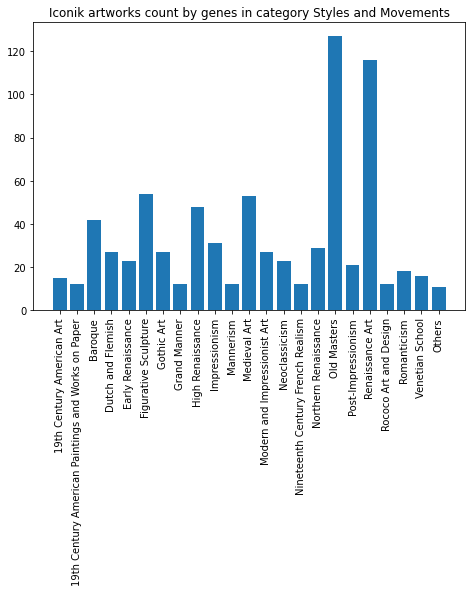

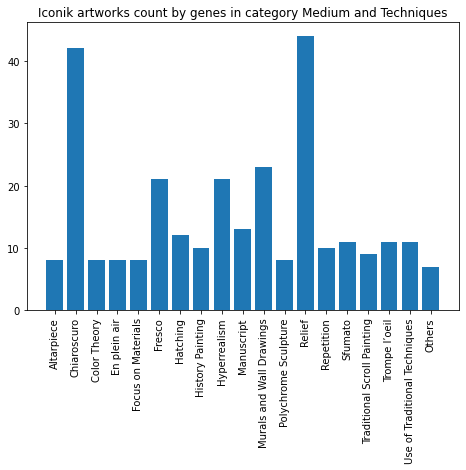

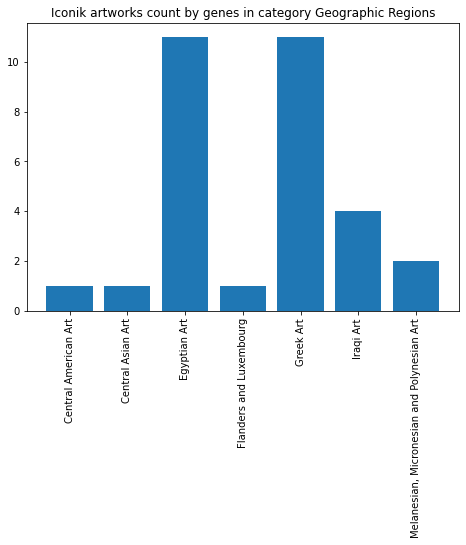

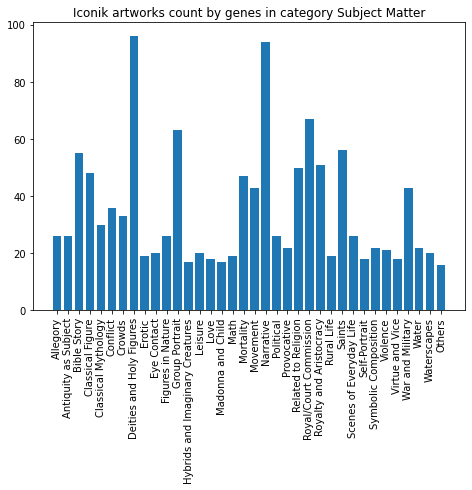

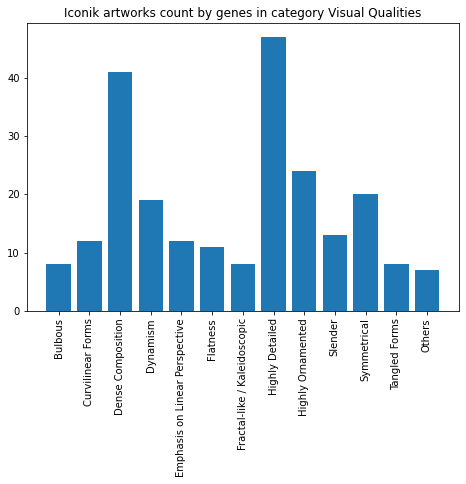

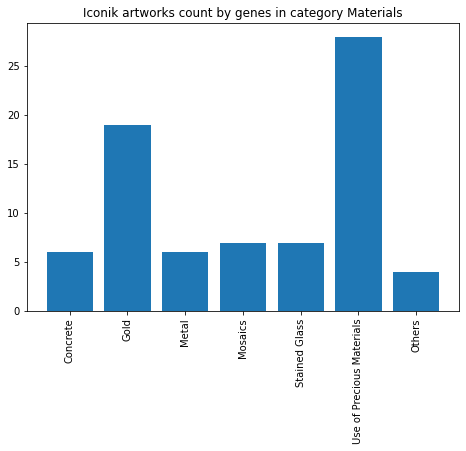

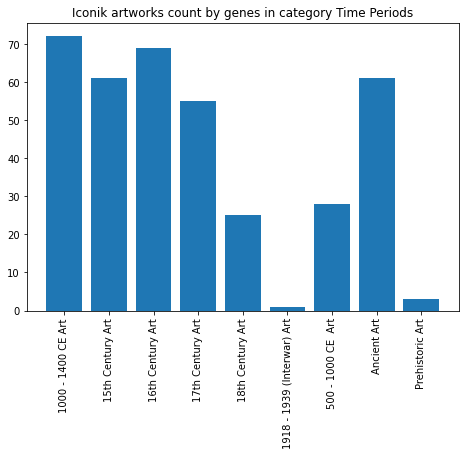

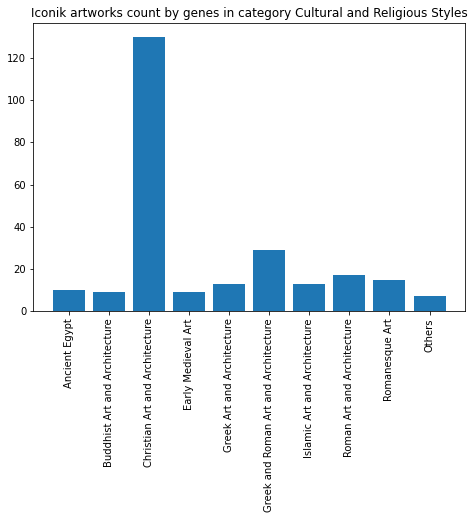

In [ ]:
for cat in gene_count_df['category_name'].unique():
  cat_df = gene_count_df.loc[gene_count_df['category_name']==cat]
  if cat_df['gene_name'].nunique() > 10:
    quartile_3 = np.percentile(cat_df['count'], 75)
    big_counts_df = cat_df.loc[cat_df['count'] >= quartile_3]
    small_counts_df = cat_df.loc[cat_df['count'] < quartile_3]
    small_counts_df['gene_name'] = 'Others'
    cat_df_new = pd.concat([big_counts_df, small_counts_df])
  else:
    cat_df_new = cat_df.copy()
  
  fig = plt.figure()
  axes = fig.add_axes([0, 0, 1, 1])
  axes.bar(x = cat_df_new['gene_name'], height = cat_df_new['count'])
  axes.set_xticklabels(cat_df_new['gene_name'], rotation = 90)
  axes.set_title('Iconik artworks count by genes in category {}'.format(cat))
  
  plt.show()

  print('')

In [ ]:
# artists_dict = {'id': {'artsy_id': [], 'category_id': [], 'gene_id': [], 'name': ''}}

#artists_dict = open_dict(artist_dict, 'live') # 2. Open json dict
#len(artists_dict)

# artworks_dict = {'artsy_id': {'artist': '', 'artist_id': '', 'category_id': [], 'gallery': '', 'gene_id': [],
#                               'link': '', 'name': '', 'parsing_date': '', 'price': '', 'updating_date': ', 'year': ''}}

#artworks_dict = open_dict(artwork_dict, 'live') # 2. Open json dict
#len(artworks_dict)

# Images

In [ ]:
# Sample from API tables

# 'image': {'href': 'https://d32dm0rphc51dk.cloudfront.net/NOpIAwQa-3r51Cg9qXKbfA/{image_version}.jpg',
#                      'templated': True}
#i = 'https://d32dm0rphc51dk.cloudfront.net/NOpIAwQa-3r51Cg9qXKbfA/normalized.jpg'
#for p in i.split('.jpg')[0].split('/'):
#  print(len(p), p)

6 https:
0 
29 d32dm0rphc51dk.cloudfront.net
22 NOpIAwQa-3r51Cg9qXKbfA
10 normalized


In [ ]:
#! pip install pillow --user

import PIL
from PIL import Image
import os
import cv2

%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Populating the interactive namespace from numpy and matplotlib


In [ ]:
image = requests.get(img, headers={'User-Agent': 'Chrome/97.0.4692.71'})
name = art_project_path + '/' + 'portrait_of_a_man_in_armour' + '.jpg'

img = open(name, 'wb')
img.write(image.content)
img.close()

img = Image.open(name)
plt.imshow(img)
plt.axis('off')
plt.show()

img.close()